# Machine Learning framework for network attack detection

Part II

## Achievement:

|Model|Recall|Precision|F1|Recall Attack|Precision Attack|
|-----|---------|------|--|-------------|----------------|
|Baseline|0.83|0.69|0.75|0.00|0.00|
|Logistic Regression|0.92|0.92|0.92|0.70|0.83|
|Random Forest|**0.99**|0.99|0.99|**0.95**|**0.96**|
|CatBoost|**0.99**|0.99|0.99|**0.94**|**1.0**|
|Decision Tree|**0.99**|0.99|0.99|**0.95**|**0.97**|


Following notebook will present the performance of different machine learning algorithms by performing binary classification on the [CIC-IDS-2018 dataset](https://www.unb.ca/cic/datasets/ids-2018.html). 

All used features extracted with the help of [CICFlowMeter](https://github.com/ISCX/CICFlowMeter) tool .

following list of algorithms have been tested to get the best performed model and use it as a final working model .

- Dummy classifer 
- logestic regression 
- Random Forest 
- Gradient Boosting
- Decision Tree

In [1]:
#pip install shap
#!pip install scikit-plot
#!pip install eli5
#!pip install catboost
#!pip install imblearn
#!pip install phik
#!pip install phik==0.10.0

In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier
from catboost import Pool
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
from scipy.stats import ks_2samp
from scipy.stats import describe
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler



%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/home/upm/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
path = r"/media/upm/New Volume/project/0/processed"

In [4]:
#path = r'E:\Juypter-files\FINAL\final1.csv'

In [5]:
types = {
    'dst_port': 'uint32',
    'protocol': 'uint8',
    'timestamp': 'object',
    'flow_duration': 'int64',
    'tot_fwd_pkts': 'uint32',
    'tot_bwd_pkts': 'uint32',
    'totlen_fwd_pkts': 'uint32',
    'totlen_bwd_pkts': 'uint32',
    'fwd_pkt_len_max': 'uint16',
    'fwd_pkt_len_min': 'uint16',
    'fwd_pkt_len_mean': 'float32',
    'fwd_pkt_len_std': 'float32',
    'bwd_pkt_len_max': 'uint16',
    'bwd_pkt_len_min': 'uint16',
    'bwd_pkt_len_mean': 'float32',
    'bwd_pkt_len_std': 'float32',
    'flow_byts_s': 'float64',
    'flow_pkts_s': 'float64',
    'flow_iat_mean': 'float32',
    'flow_iat_std': 'float32',
    'flow_iat_max': 'int64',
    'flow_iat_min': 'int64',
    'fwd_iat_tot': 'int64',
    'fwd_iat_mean': 'float32',
    'fwd_iat_std': 'float32',
    'fwd_iat_max': 'int64',
    'fwd_iat_min': 'int64',
    'bwd_iat_tot': 'uint32',
    'bwd_iat_mean': 'float32',
    'bwd_iat_std': 'float32',
    'bwd_iat_max': 'uint32',
    'bwd_iat_min': 'uint32',
    'fwd_psh_flags': 'uint8',
    'bwd_psh_flags': 'uint8',
    'fwd_urg_flags': 'uint8',
    'bwd_urg_flags': 'uint8',
    'fwd_header_len': 'uint32',
    'bwd_header_len': 'uint32',
    'fwd_pkts_s': 'float32',
    'bwd_pkts_s': 'float32',
    'pkt_len_min': 'uint16',
    'pkt_len_max': 'uint16',
    'pkt_len_mean': 'float32',
    'pkt_len_std': 'float32',
    'pkt_len_var': 'float32',
    'fin_flag_cnt': 'uint8',
    'syn_flag_cnt': 'uint8',
    'rst_flag_cnt': 'uint8',
    'psh_flag_cnt': 'uint8',
    'ack_flag_cnt': 'uint8',
    'urg_flag_cnt': 'uint8',
    'cwe_flag_count': 'uint8',
    'ece_flag_cnt': 'uint8',
    'down_up_ratio': 'uint16',
    'pkt_size_avg': 'float32',
    'fwd_seg_size_avg': 'float32',
    'bwd_seg_size_avg': 'float32',
    'fwd_byts_b_avg': 'uint8',
    'fwd_pkts_b_avg': 'uint8',
    'fwd_blk_rate_avg': 'uint8',
    'bwd_byts_b_avg': 'uint8',
    'bwd_pkts_b_avg': 'uint8',
    'bwd_blk_rate_avg': 'uint8',
    'subflow_fwd_pkts': 'uint32',
    'subflow_fwd_byts': 'uint32',
    'subflow_bwd_pkts': 'uint32',
    'subflow_bwd_byts': 'uint32',
    'init_fwd_win_byts': 'int32',
    'init_bwd_win_byts': 'int32',
    'fwd_act_data_pkts': 'uint32',
    'fwd_seg_size_min': 'uint8',
    'active_mean': 'float32',
    'active_std': 'float32',
    'active_max': 'uint32',
    'active_min': 'uint32',
    'idle_mean': 'float32',
    'idle_std': 'float32',
    'idle_max': 'uint64',
    'idle_min': 'uint64',
    'label': 'category'
}


# Data Cleaning


* load the dataset with new values and combine the files to the df 

* clean inf values and repace then with thier mean 

* then replace this negtive value with thier overall mean 

* check features that has feature variance where they are close to zero 

* delete unwanted columns like timestamp and Dst_port

* check feature coorealtion and do it with pandas method corr() or phik matrix then drop them

# 1- load and join

In [6]:
#path1 = r"E:\Juypter-files\dataset1_LOCAL_DATA\csv_files"

#join all csv files avilable in the base path 

csvs = glob.glob(os.path.join(path, '*.csv'))

df = pd.concat((pd.read_csv(f, dtype=types) for f in csvs)) # and concatenate them to one data frame using pandas and change the data types into numeric types


In [7]:
#df = df.loc[df["label"] != 'Benign']

In [8]:
df.shape

(16232943, 80)

In [9]:
df.head()

dst_port  protocol            timestamp  flow_duration  tot_fwd_pkts  \
0       443         6  02/03/2018 08:47:38         141385             9   
1     49684         6  02/03/2018 08:47:38            281             2   
2       443         6  02/03/2018 08:47:40         279824            11   
3       443         6  02/03/2018 08:47:40            132             2   
4       443         6  02/03/2018 08:47:41         274016             9   

   tot_bwd_pkts  totlen_fwd_pkts  totlen_bwd_pkts  fwd_pkt_len_max  \
0             7              553             3773              202   
1             1               38                0               38   
2            15             1086            10527              385   
3             0                0                0                0   
4            13             1285             6141              517   

   fwd_pkt_len_min  ...  fwd_seg_size_min  active_mean  active_std  \
0                0  ...                20          0.0         0.0   
1                0  ...                20          0.0         0.0   
2                0  ...                20          0.0         0.0   
3                0  ...                20          0.0         0.0   
4                0  ...                20          0.0         0.0   

   active_max  active_min  idle_mean  idle_std  idle_max  idle_min   label  
0           0           0        0.0       0.0         0         0  Benign  
1           0           0        0.0       0.0         0         0  Benign  
2           0           0        0.0       0.0         0         0  Benign  
3           0           0        0.0       0.0         0         0  Benign  
4           0           0        0.0       0.0         0         0  Benign  

[5 rows x 80 columns]

In [10]:
#df = df.iloc[:1000000,2:]

# 2- labeling binary

In [11]:
#df['label_cat'] = df.label.astype('category').cat.codes # create a col called label_cat and make its type category using cat.codes (label encoding method) 
df['binary_class'] = (df.label != 'Benign').astype('int') # create binary class col and the data type is int with values 0 and 1 only , so anything not bengin will be a number and bengin is a number notice !=

# 3- infinity values cleaning 

In [12]:
# for loop to check all columns that have inf values in the dataset
inf_values = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
print(inf_values)

['flow_byts_s', 'flow_pkts_s']


In [13]:
# replace inf with nan 
for col in inf_values:
    df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
   
    mean = df[col].mean()
    # fillna method to fill and replace the inf values with columns mean 
    df[col].fillna(mean, inplace=True)

# 4 - replace negtive values with mean

In [14]:
# identify all numeric cols in the dataset 
numeric_cols = df.select_dtypes(include=[np.number]).columns.values
print(numeric_cols)

# take onlly the coulmns where negtive values there 
columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
print("\n",'negtive cols', columns)

['dst_port' 'protocol' 'flow_duration' 'tot_fwd_pkts' 'tot_bwd_pkts'
 'totlen_fwd_pkts' 'totlen_bwd_pkts' 'fwd_pkt_len_max' 'fwd_pkt_len_min'
 'fwd_pkt_len_mean' 'fwd_pkt_len_std' 'bwd_pkt_len_max' 'bwd_pkt_len_min'
 'bwd_pkt_len_mean' 'bwd_pkt_len_std' 'flow_byts_s' 'flow_pkts_s'
 'flow_iat_mean' 'flow_iat_std' 'flow_iat_max' 'flow_iat_min'
 'fwd_iat_tot' 'fwd_iat_mean' 'fwd_iat_std' 'fwd_iat_max' 'fwd_iat_min'
 'bwd_iat_tot' 'bwd_iat_mean' 'bwd_iat_std' 'bwd_iat_max' 'bwd_iat_min'
 'fwd_psh_flags' 'bwd_psh_flags' 'fwd_urg_flags' 'bwd_urg_flags'
 'fwd_header_len' 'bwd_header_len' 'fwd_pkts_s' 'bwd_pkts_s' 'pkt_len_min'
 'pkt_len_max' 'pkt_len_mean' 'pkt_len_std' 'pkt_len_var' 'fin_flag_cnt'
 'syn_flag_cnt' 'rst_flag_cnt' 'psh_flag_cnt' 'ack_flag_cnt'
 'urg_flag_cnt' 'cwe_flag_count' 'ece_flag_cnt' 'down_up_ratio'
 'pkt_size_avg' 'fwd_seg_size_avg' 'bwd_seg_size_avg' 'fwd_byts_b_avg'
 'fwd_pkts_b_avg' 'fwd_blk_rate_avg' 'bwd_byts_b_avg' 'bwd_pkts_b_avg'
 'bwd_blk_rate_avg' 'subflow_fwd

In [15]:
# loop will itrate through the columns to find and replace negtive values with thier mean 
# please note col is short for columns

for col in columns:
    mask = df[col] < 0 # store all columns that are less than zero in mask 
      
    df.loc[mask, col] = np.nan # take only the records in mask(rows) and col(coulmns) which is the negtive
        
    mean = df[col].mean() # store the mean value in mean variable using mean() method
    df[col].fillna(mean, inplace=True) # now using fillna inplace true replace all negtive coulmns stored in col with mean 

# 5- Split the datset into training and prediction  

In [16]:
# load the dataset and split it to X-training , Y-labels

X = df.drop(columns=['label', 'binary_class'])

y = df[['binary_class']]

# 6- look for feature variance 

In [17]:
#calculate variance of each feature, If the variance is low or close to zero, then a feature is approximately constant and will not improve the performance of the model. In that case, it should be removed.
stats = X.describe()
std = stats.loc['std']
features_no_variance = std[std == 0.0].index

pd.Series(features_no_variance).sort_values()

7    bwd_blk_rate_avg
5      bwd_byts_b_avg
6      bwd_pkts_b_avg
0       bwd_psh_flags
1       bwd_urg_flags
4    fwd_blk_rate_avg
2      fwd_byts_b_avg
3      fwd_pkts_b_avg
dtype: object

In [18]:
#then drop features with variance below threshold
X = X.drop(columns=features_no_variance)

# 7- Un-wanted Features

The predictions of a classifier could be not related to the features `timestamp` and `dst_port` in order to recognize attacks, indifferent of time and the destination port they are executed against. so we say goodbay to them .

In [19]:
X= X.drop(columns=['timestamp', 'dst_port'])

# 8- feature coorealtion 

In [20]:
# coorealtion on X features 
cluster_threshold = 1
#X = X.drop(columns=['label'])


In [21]:
corr = spearmanr(X).correlation
#corr = df.drop(columns=['label']).corr()
corr_linkage = hierarchy.ward(corr)

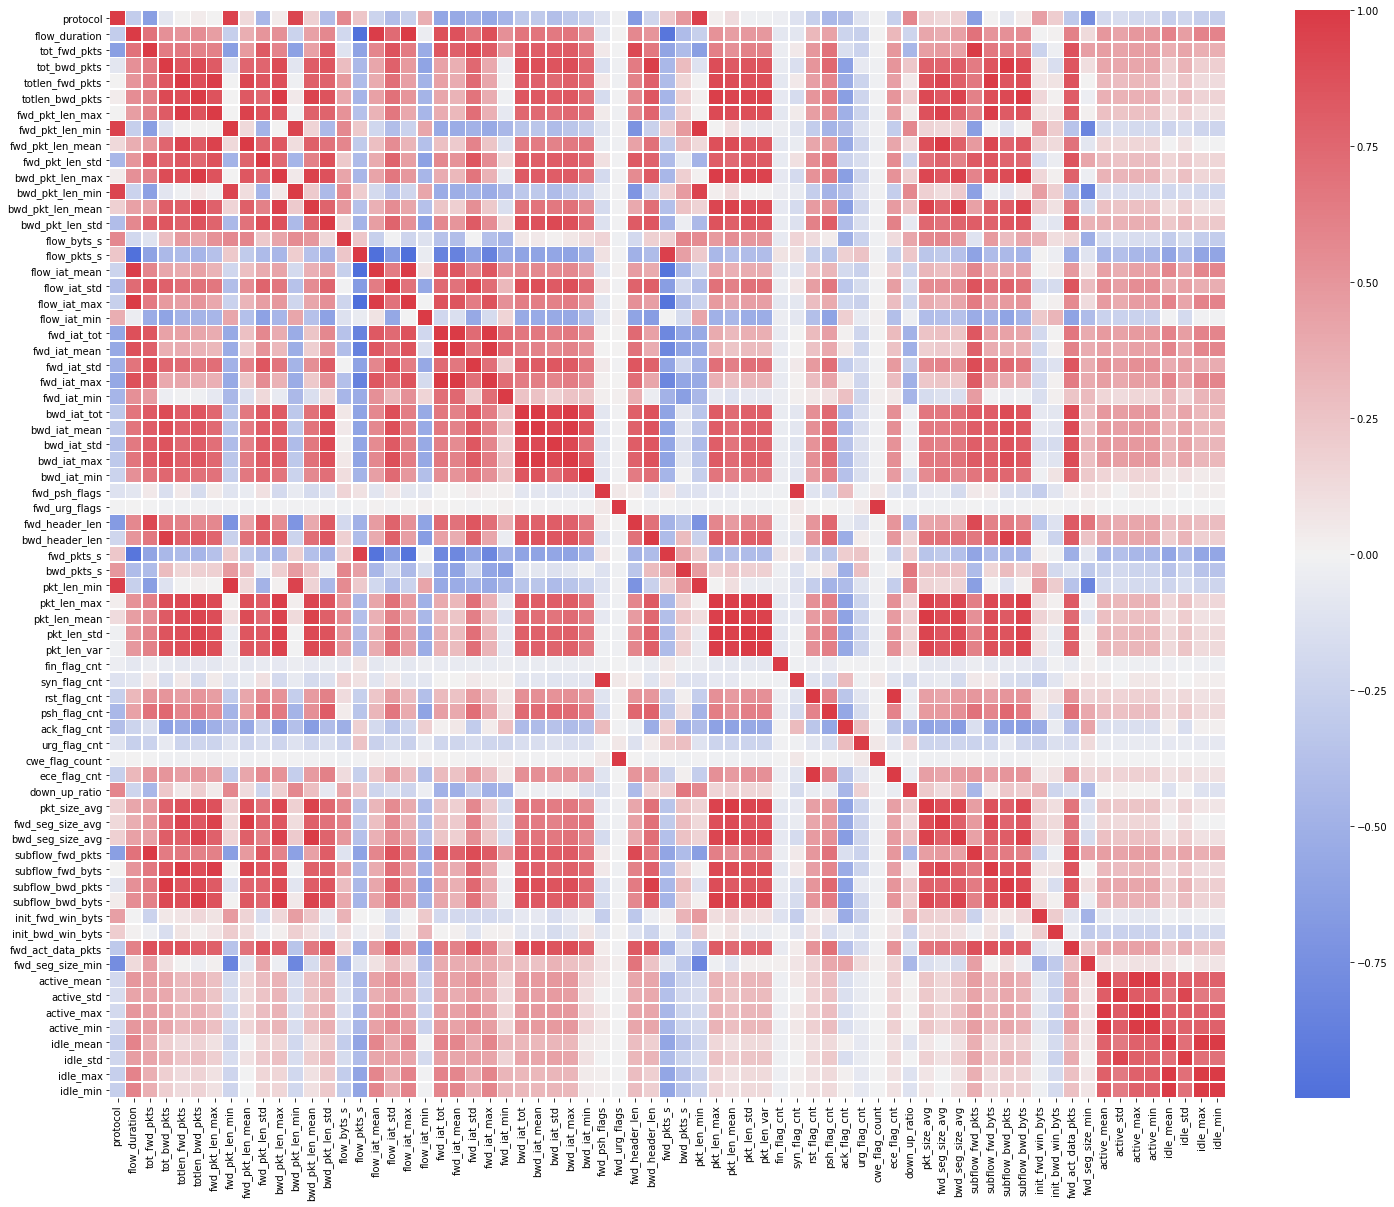

In [22]:
#fig, (ax1) = plt.subplots(figsize=(25, 40))
plt.figure(figsize=(25, 20))

sns.heatmap(corr, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True))

### The heatmap demonstrates that the dataset has a fair amount of features with high correlation amongst each other. In order to remove redundant features the cluster distance threshold of 1 is used to pick features from their respective clusters.

## 8-1 select coorelated features 

In [23]:
cluster_ids = hierarchy.fcluster(corr_linkage, cluster_threshold, criterion='distance')

cluster_id_to_feature_ids = defaultdict(list)


for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]


selected_features = X.columns[selected_features].tolist()

print('Selected features:')
pd.Series(selected_features)

Selected features:


0              protocol
1         flow_duration
2          tot_fwd_pkts
3          tot_bwd_pkts
4       totlen_fwd_pkts
5       totlen_bwd_pkts
6      fwd_pkt_len_mean
7       fwd_pkt_len_std
8      bwd_pkt_len_mean
9           flow_byts_s
10          flow_pkts_s
11         flow_iat_std
12         flow_iat_min
13          fwd_iat_tot
14          fwd_iat_min
15          bwd_iat_tot
16          bwd_iat_min
17        fwd_psh_flags
18        fwd_urg_flags
19           bwd_pkts_s
20         fin_flag_cnt
21         rst_flag_cnt
22         psh_flag_cnt
23         ack_flag_cnt
24         urg_flag_cnt
25        down_up_ratio
26    init_fwd_win_byts
27    init_bwd_win_byts
28     fwd_seg_size_min
29          active_mean
30            idle_mean
dtype: object

In [24]:
# assign new features to the X and dump the coorealted ones 
X = X[selected_features]
print(f"Remaining amount of features: {len(X.columns)}")

Remaining amount of features: 31


## 8-2 plot new coorealtion 

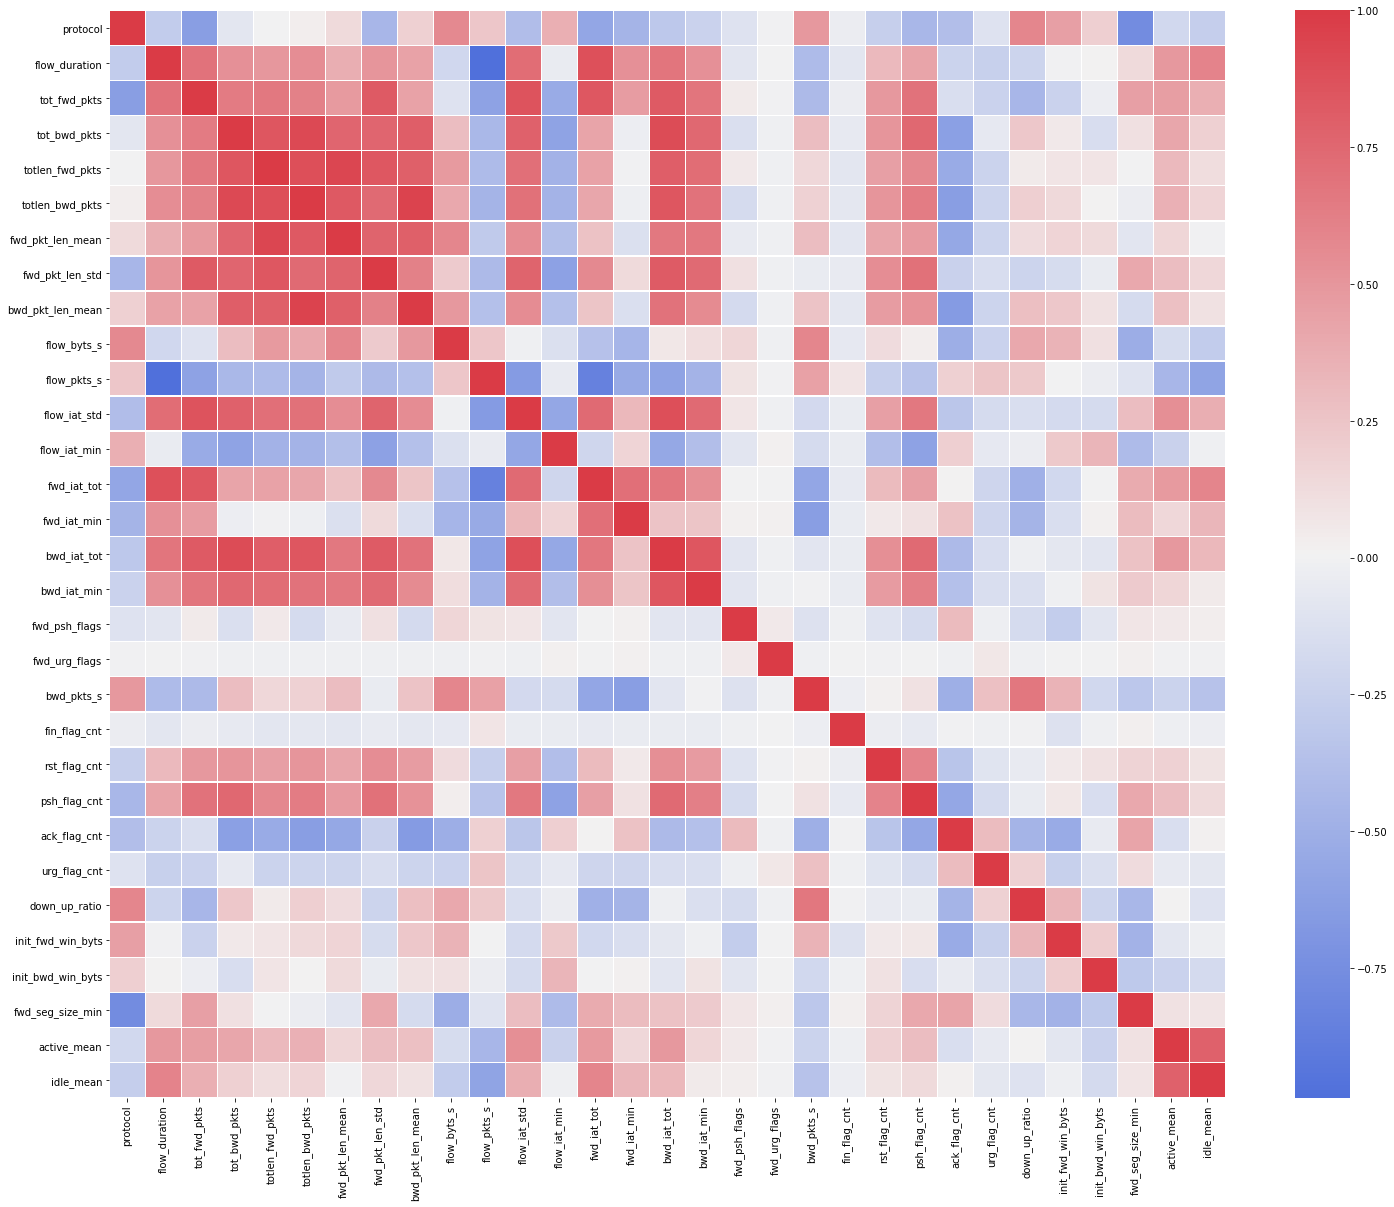

In [25]:
# the new heatmap after dropping the coorelated features 
corr_updated = spearmanr(X).correlation
plt.figure(figsize=(25, 20))
sns.heatmap(corr_updated, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True))

In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16232943 entries, 0 to 613070
Data columns (total 31 columns):
 #   Column             Dtype  
---  ------             -----  
 0   protocol           uint8  
 1   flow_duration      float64
 2   tot_fwd_pkts       uint32 
 3   tot_bwd_pkts       uint32 
 4   totlen_fwd_pkts    uint32 
 5   totlen_bwd_pkts    uint32 
 6   fwd_pkt_len_mean   float32
 7   fwd_pkt_len_std    float32
 8   bwd_pkt_len_mean   float32
 9   flow_byts_s        float64
 10  flow_pkts_s        float64
 11  flow_iat_std       float32
 12  flow_iat_min       float64
 13  fwd_iat_tot        float64
 14  fwd_iat_min        float64
 15  bwd_iat_tot        uint32 
 16  bwd_iat_min        uint32 
 17  fwd_psh_flags      uint8  
 18  fwd_urg_flags      uint8  
 19  bwd_pkts_s         float32
 20  fin_flag_cnt       uint8  
 21  rst_flag_cnt       uint8  
 22  psh_flag_cnt       uint8  
 23  ack_flag_cnt       uint8  
 24  urg_flag_cnt       uint8  
 25  down_up_ratio     

# -- Most important features - Shap

Following is a set of features that will be respresnted using shape values plots and they will the most usefull predictors . based on catboost and grid search training and result 

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

cls = RandomForestClassifier(max_depth=2, random_state=0)
cls.fit(X_train, y_train)

<ipython-input-28-a8ddd21e043f>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  cls.fit(X_train, y_train)


RandomForestClassifier(max_depth=2, random_state=0)

In [30]:
importances = cls.feature_importances_
indices = np.argsort(importances)
features = df.columns

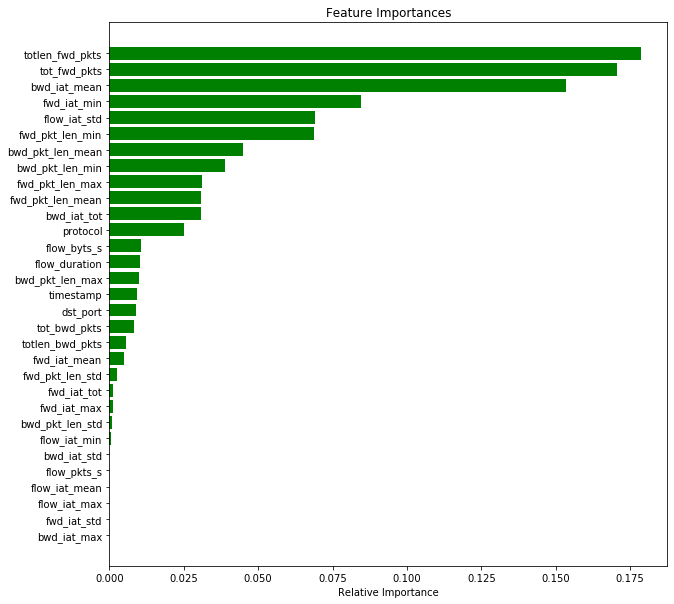

In [46]:
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


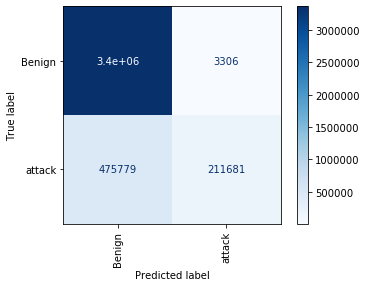

In [47]:
disp = plot_confusion_matrix(cls, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues, xticks_rotation='vertical')

In [37]:
# compute SHAP values
import shap
explainer = shap.TreeExplainer(cls)
shap_values = explainer.shap_values(X)

KeyboardInterrupt: 

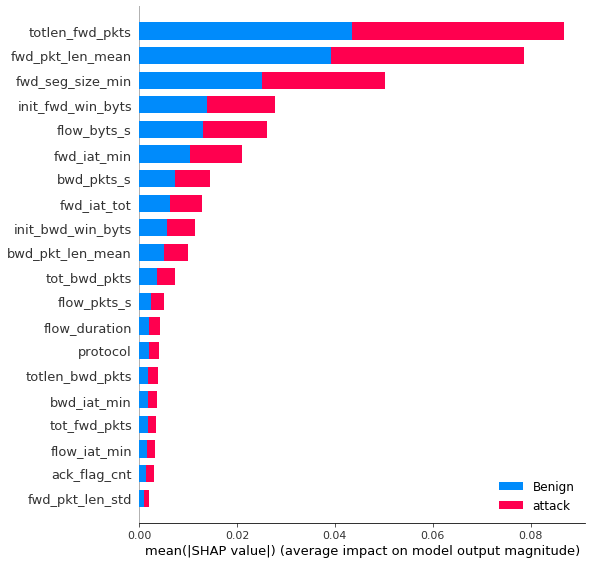

In [38]:
class_names = ['Benign', 'attack']
shap.summary_plot(shap_values, X.values, plot_type="bar", class_names= class_names, feature_names = X.columns)

# 9- Dataset train test Split  

In [27]:
#y.drop('label' , axis = 'columns')

In [28]:
# Split X frame into training , testing , and evaluating sets 
# 0.8 training , 0.1 testing , 0.1 evaluation 
# split done with the feature "protocol" being one hot encoded in the training and testing sets 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y , random_state = 101 )

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

# on hot encoding for the feature protocol cuz it is categorical 
X_trainh = pd.get_dummies(X_train, columns=['protocol'])
X_valh = pd.get_dummies(X_val, columns=['protocol'])
X_testh = pd.get_dummies(X_test, columns=['protocol'])

In [29]:
#X_test.to_csv (r'/media/upm/New Volume/project/pep/test.csv', index=False, header=True)

# 10- percentage of the benign labels - imbalance dataset 

In [30]:
percentage_benign = len(y_train.binary_class[y_train.binary_class == 0]) / len(y_train.binary_class)

print('Class occurences:')
print(y_train.binary_class.value_counts())
print('Percentage of benign samples: %.4f' % percentage_benign)

Class occurences:
0    10787766
1     2198588
Name: binary_class, dtype: int64
Percentage of benign samples: 0.8307


# used performance metrics 

the dataset is imbalanced with class `0 - Benign` with`~83%` of all the samples.  



To evaluate the performance of a classifier two metrics will be used:
* `Recall (weighted avg)` will be used as the primary metric as the goal of the classifier should be detect as many attacks as possible. This is the metric that classifiers will be optimized for.


* `Precision (weighted avg)` will be used as a secondary classifier as the the number of false-positives. This metric should be have a value over the threshold of `0.95` to have a maximum of `5%` false-positives.

The `Avg Precision Score` score will also be calculated for each classifier.

# Binary Classification 

#  Dummy Classifier

a `DummyClassifier` is created choosing the class with the most frequent occurences to make predictions. In this case all samples are classified as `0 - Benign` as this is the majority class of the dataset. 

In [30]:
# wrong cls_dummy = DummyClassifier('most_frequent')
# alwayes go back to documention 
dummy_clc = DummyClassifier(strategy="most_frequent")

In [33]:
dummy_clc.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [34]:
print("Classification Report")

print(classification_report(y_test, dummy_clc.predict(X_test)))

Classification Report


/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.83      1.00      0.91   1348471
           1       0.00      0.00      0.00    274824

    accuracy                           0.83   1623295
   macro avg       0.42      0.50      0.45   1623295
weighted avg       0.69      0.83      0.75   1623295



/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 11 - Binary Classifcation models 

## 11- 1 Logistic Regression - LR

Using the Logistic Regression estimator a linear model will be fitted to the data using the [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) 


Using Logistic Regression a weighted recall of `0.93` and a precision of `0.92` which is better that the dummy

In [31]:
scaler = StandardScaler()
scaler.fit(X_trainh)

StandardScaler()

In [32]:
lr = LogisticRegression(solver='saga', n_jobs=-1, verbose=2)

lr.fit(scaler.transform(X_trainh) , y_train)

/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


max_iter reached after 803 seconds


/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 13.4min finished


LogisticRegression(n_jobs=-1, solver='saga', verbose=2)

In [33]:
y_pred = lr.predict(scaler.transform(X_valh))

In [34]:
y_pred1 = lr.predict(scaler.transform(X_testh))

In [36]:
print("Classification Report")
print(classification_report(y_test , y_pred1))

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.97      0.96   1348471
           1       0.83      0.70      0.76    274824

    accuracy                           0.92   1623295
   macro avg       0.89      0.83      0.86   1623295
weighted avg       0.92      0.92      0.92   1623295



## 11-2 Random Forest - RF

The default values are used to train the estimator.  
`RandomForestClassifier` performs very well with recall of `0.99` and precision of `0.99`.

In [37]:
cls_forest = RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced')

In [38]:
cls_forest.fit(X_trainh, y_train)

<ipython-input-38-d14f6098bebd>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  cls_forest.fit(X_trainh, y_train)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.8min finished


RandomForestClassifier(class_weight='balanced', n_jobs=-1, verbose=1)

In [39]:
y_pred = cls_forest.predict(X_valh)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    8.0s finished


In [40]:
y_pred1 = cls_forest.predict(X_testh)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.7s finished


In [42]:
print("Classification Report")
print(classification_report(y_test ,y_pred1))

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1348471
           1       0.96      0.95      0.96    274824

    accuracy                           0.99   1623295
   macro avg       0.98      0.97      0.97   1623295
weighted avg       0.99      0.99      0.99   1623295



## 11-3 Gradient Boosting - GB

The last algorithm to evaluate is Gradient Boosting by facilitating the library [CatBoost](https://catboost.ai/). A grid search using cross-validation over a variation of hyper-parameters is performed in order to identify the optimal parameters. 

In [31]:
train_pool = Pool(X_train, y_train, cat_features=['protocol'])
eval_pool = Pool(X_val, y_val , cat_features=['protocol'])
test_pool = Pool(X_test, cat_features=['protocol'])

In [32]:
minority_class_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

In [33]:
cls_cb = CatBoostClassifier(loss_function='Logloss',                        
                            class_weights=[1, minority_class_weight],
                            task_type='GPU',
                            verbose=True)


cls_cb.fit(train_pool, eval_set=test_pool)

Learning rate set to 0.020023


0:	learn: 0.6560188	total: 247ms	remaining: 4m 6s
1:	learn: 0.6214057	total: 487ms	remaining: 4m 2s
2:	learn: 0.5889479	total: 737ms	remaining: 4m 4s
3:	learn: 0.5585512	total: 977ms	remaining: 4m 3s
4:	learn: 0.5301471	total: 1.22s	remaining: 4m 2s
5:	learn: 0.5028079	total: 1.47s	remaining: 4m 3s
6:	learn: 0.4779068	total: 1.71s	remaining: 4m 2s
7:	learn: 0.4543420	total: 1.95s	remaining: 4m 2s
8:	learn: 0.4334791	total: 2.19s	remaining: 4m 1s
9:	learn: 0.4142046	total: 2.44s	remaining: 4m 1s
10:	learn: 0.3956010	total: 2.67s	remaining: 4m
11:	learn: 0.3776878	total: 2.91s	remaining: 3m 59s
12:	learn: 0.3603161	total: 3.15s	remaining: 3m 59s
13:	learn: 0.3454986	total: 3.4s	remaining: 3m 59s
14:	learn: 0.3317109	total: 3.64s	remaining: 3m 58s
15:	learn: 0.3173416	total: 3.89s	remaining: 3m 59s
16:	learn: 0.3046156	total: 4.12s	remaining: 3m 58s
17:	learn: 0.2927603	total: 4.36s	remaining: 3m 57s
18:	learn: 0.2817582	total: 4.59s	remaining: 3m 57s
19:	learn: 0.2721524	total: 4.83s	rem

158:	learn: 0.0599831	total: 36.3s	remaining: 3m 11s
159:	learn: 0.0598443	total: 36.5s	remaining: 3m 11s
160:	learn: 0.0597510	total: 36.7s	remaining: 3m 11s
161:	learn: 0.0596184	total: 36.9s	remaining: 3m 11s
162:	learn: 0.0594750	total: 37.2s	remaining: 3m 10s
163:	learn: 0.0593783	total: 37.4s	remaining: 3m 10s
164:	learn: 0.0592923	total: 37.6s	remaining: 3m 10s
165:	learn: 0.0591323	total: 37.9s	remaining: 3m 10s
166:	learn: 0.0590594	total: 38.1s	remaining: 3m 10s
167:	learn: 0.0589297	total: 38.3s	remaining: 3m 9s
168:	learn: 0.0588429	total: 38.6s	remaining: 3m 9s
169:	learn: 0.0587212	total: 38.8s	remaining: 3m 9s
170:	learn: 0.0586656	total: 39s	remaining: 3m 9s
171:	learn: 0.0585937	total: 39.3s	remaining: 3m 9s
172:	learn: 0.0584872	total: 39.5s	remaining: 3m 9s
173:	learn: 0.0583006	total: 39.8s	remaining: 3m 8s
174:	learn: 0.0582343	total: 40s	remaining: 3m 8s
175:	learn: 0.0581684	total: 40.3s	remaining: 3m 8s
176:	learn: 0.0580556	total: 40.5s	remaining: 3m 8s
177:	le

315:	learn: 0.0517247	total: 1m 12s	remaining: 2m 36s
316:	learn: 0.0517104	total: 1m 12s	remaining: 2m 36s
317:	learn: 0.0516787	total: 1m 12s	remaining: 2m 36s
318:	learn: 0.0516618	total: 1m 13s	remaining: 2m 36s
319:	learn: 0.0516469	total: 1m 13s	remaining: 2m 36s
320:	learn: 0.0516379	total: 1m 13s	remaining: 2m 35s
321:	learn: 0.0516072	total: 1m 13s	remaining: 2m 35s
322:	learn: 0.0515992	total: 1m 14s	remaining: 2m 35s
323:	learn: 0.0515772	total: 1m 14s	remaining: 2m 35s
324:	learn: 0.0515648	total: 1m 14s	remaining: 2m 34s
325:	learn: 0.0515516	total: 1m 14s	remaining: 2m 34s
326:	learn: 0.0515404	total: 1m 15s	remaining: 2m 34s
327:	learn: 0.0515086	total: 1m 15s	remaining: 2m 34s
328:	learn: 0.0514761	total: 1m 15s	remaining: 2m 34s
329:	learn: 0.0514555	total: 1m 15s	remaining: 2m 33s
330:	learn: 0.0514146	total: 1m 15s	remaining: 2m 33s
331:	learn: 0.0513950	total: 1m 16s	remaining: 2m 33s
332:	learn: 0.0513605	total: 1m 16s	remaining: 2m 33s
333:	learn: 0.0513326	total:

468:	learn: 0.0491054	total: 1m 46s	remaining: 2m
469:	learn: 0.0490849	total: 1m 46s	remaining: 2m
470:	learn: 0.0490755	total: 1m 47s	remaining: 2m
471:	learn: 0.0490698	total: 1m 47s	remaining: 2m
472:	learn: 0.0490582	total: 1m 47s	remaining: 1m 59s
473:	learn: 0.0490534	total: 1m 47s	remaining: 1m 59s
474:	learn: 0.0490443	total: 1m 48s	remaining: 1m 59s
475:	learn: 0.0490289	total: 1m 48s	remaining: 1m 59s
476:	learn: 0.0490234	total: 1m 48s	remaining: 1m 58s
477:	learn: 0.0489811	total: 1m 48s	remaining: 1m 58s
478:	learn: 0.0489750	total: 1m 48s	remaining: 1m 58s
479:	learn: 0.0489666	total: 1m 49s	remaining: 1m 58s
480:	learn: 0.0489608	total: 1m 49s	remaining: 1m 57s
481:	learn: 0.0489505	total: 1m 49s	remaining: 1m 57s
482:	learn: 0.0489410	total: 1m 49s	remaining: 1m 57s
483:	learn: 0.0489259	total: 1m 49s	remaining: 1m 57s
484:	learn: 0.0489154	total: 1m 50s	remaining: 1m 57s
485:	learn: 0.0489082	total: 1m 50s	remaining: 1m 56s
486:	learn: 0.0489013	total: 1m 50s	remainin

622:	learn: 0.0478274	total: 2m 19s	remaining: 1m 24s
623:	learn: 0.0478232	total: 2m 20s	remaining: 1m 24s
624:	learn: 0.0478189	total: 2m 20s	remaining: 1m 24s
625:	learn: 0.0478024	total: 2m 20s	remaining: 1m 23s
626:	learn: 0.0477964	total: 2m 20s	remaining: 1m 23s
627:	learn: 0.0477897	total: 2m 20s	remaining: 1m 23s
628:	learn: 0.0477860	total: 2m 21s	remaining: 1m 23s
629:	learn: 0.0477792	total: 2m 21s	remaining: 1m 22s
630:	learn: 0.0477720	total: 2m 21s	remaining: 1m 22s
631:	learn: 0.0477669	total: 2m 21s	remaining: 1m 22s
632:	learn: 0.0477634	total: 2m 21s	remaining: 1m 22s
633:	learn: 0.0477599	total: 2m 22s	remaining: 1m 22s
634:	learn: 0.0477528	total: 2m 22s	remaining: 1m 21s
635:	learn: 0.0477493	total: 2m 22s	remaining: 1m 21s
636:	learn: 0.0477461	total: 2m 22s	remaining: 1m 21s
637:	learn: 0.0477399	total: 2m 23s	remaining: 1m 21s
638:	learn: 0.0477358	total: 2m 23s	remaining: 1m 20s
639:	learn: 0.0477292	total: 2m 23s	remaining: 1m 20s
640:	learn: 0.0477243	total:

776:	learn: 0.0469903	total: 2m 52s	remaining: 49.6s
777:	learn: 0.0469871	total: 2m 53s	remaining: 49.4s
778:	learn: 0.0469836	total: 2m 53s	remaining: 49.2s
779:	learn: 0.0469809	total: 2m 53s	remaining: 49s
780:	learn: 0.0469792	total: 2m 53s	remaining: 48.7s
781:	learn: 0.0469759	total: 2m 54s	remaining: 48.5s
782:	learn: 0.0469722	total: 2m 54s	remaining: 48.3s
783:	learn: 0.0469698	total: 2m 54s	remaining: 48.1s
784:	learn: 0.0469683	total: 2m 54s	remaining: 47.8s
785:	learn: 0.0469651	total: 2m 54s	remaining: 47.6s
786:	learn: 0.0469609	total: 2m 55s	remaining: 47.4s
787:	learn: 0.0469554	total: 2m 55s	remaining: 47.2s
788:	learn: 0.0469526	total: 2m 55s	remaining: 46.9s
789:	learn: 0.0469498	total: 2m 55s	remaining: 46.7s
790:	learn: 0.0469439	total: 2m 55s	remaining: 46.5s
791:	learn: 0.0469408	total: 2m 56s	remaining: 46.3s
792:	learn: 0.0469387	total: 2m 56s	remaining: 46s
793:	learn: 0.0469162	total: 2m 56s	remaining: 45.8s
794:	learn: 0.0469114	total: 2m 56s	remaining: 45.

933:	learn: 0.0462927	total: 3m 27s	remaining: 14.6s
934:	learn: 0.0462899	total: 3m 27s	remaining: 14.4s
935:	learn: 0.0462857	total: 3m 27s	remaining: 14.2s
936:	learn: 0.0462834	total: 3m 27s	remaining: 14s
937:	learn: 0.0462809	total: 3m 27s	remaining: 13.7s
938:	learn: 0.0462769	total: 3m 28s	remaining: 13.5s
939:	learn: 0.0462737	total: 3m 28s	remaining: 13.3s
940:	learn: 0.0462605	total: 3m 28s	remaining: 13.1s
941:	learn: 0.0462569	total: 3m 28s	remaining: 12.9s
942:	learn: 0.0462551	total: 3m 29s	remaining: 12.6s
943:	learn: 0.0462529	total: 3m 29s	remaining: 12.4s
944:	learn: 0.0462510	total: 3m 29s	remaining: 12.2s
945:	learn: 0.0462491	total: 3m 29s	remaining: 12s
946:	learn: 0.0462451	total: 3m 29s	remaining: 11.8s
947:	learn: 0.0462415	total: 3m 30s	remaining: 11.5s
948:	learn: 0.0462398	total: 3m 30s	remaining: 11.3s
949:	learn: 0.0462361	total: 3m 30s	remaining: 11.1s
950:	learn: 0.0462330	total: 3m 30s	remaining: 10.9s
951:	learn: 0.0462312	total: 3m 31s	remaining: 10.

In [34]:
y_pred = cls_cb.predict(X_val)

In [35]:
print("Classification Report")
print(classification_report(y_val, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1348471
           1       1.00      0.94      0.97    274823

    accuracy                           0.99   1623294
   macro avg       0.99      0.97      0.98   1623294
weighted avg       0.99      0.99      0.99   1623294



## 11-5 Decision Tree Classifier - DT

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
classifier = DecisionTreeClassifier(random_state = 0)

In [47]:
# fit the model
classifier.fit(X_trainh , y_train)

DecisionTreeClassifier(random_state=0)

In [48]:
y_predicted = classifier.predict(X_valh)

In [49]:
# predict validation
y_predicted1 = classifier.predict(X_testh)

In [51]:
print("Classification Report")
print(classification_report(y_test, y_predicted1))

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1348471
           1       0.97      0.94      0.96    274824

    accuracy                           0.99   1623295
   macro avg       0.98      0.97      0.97   1623295
weighted avg       0.99      0.99      0.99   1623295



## Gradient Boost and RF performed best of all models and will be used as the final estimator.

# 12 - Confusion matrices 

/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


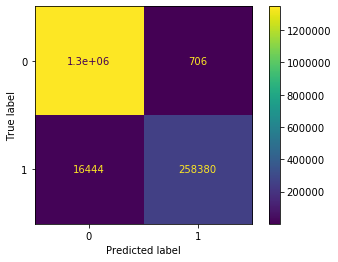

In [58]:
# GB confusion matrix 
matrix = plot_confusion_matrix(cls_cb , X_test , y_test)

plt.show(matrix)
plt.show()

/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.6s finished


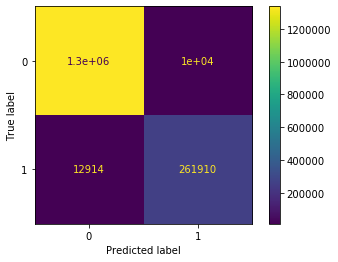

In [43]:
# RF confusion matrix 

matrix = plot_confusion_matrix(cls_forest , X_testh , y_test)

plt.show(matrix)
plt.show()@@@@@@@@

/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


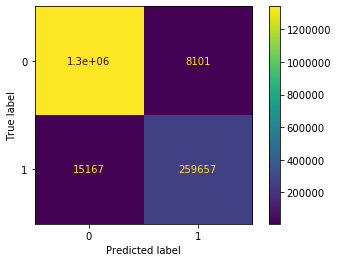

In [52]:
# DT confusion matrix 

matrix = plot_confusion_matrix(classifier , X_testh , y_test)

plt.show(matrix)
plt.show()

/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


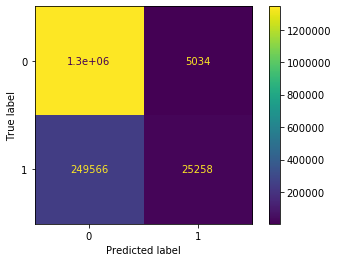

In [44]:
# LR confusion matrix 


matrix = plot_confusion_matrix(lr , X_testh , y_test)

plt.show(matrix)
plt.show()

# 13 -  Model Performance  

## 13.1 Model selection


Gradient Boost performed best of all models and will be used as the final estimator.

In [36]:
estimator = cls_cb

## 13.2 performance on the test set

In [37]:
def print_report(ds_type, cls, X_vals, y_true, y_predict, plot_pr=False, plot_roc=False):
    print(f"Classification Report ({ds_type}):")
    print(classification_report(y_true, y_predict))
    print(f"Avg Precision Score: {average_precision_score(y_true, y_predict, average='weighted')}")
    if plot_roc:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_predict)}")
        skplt.metrics.plot_roc(y_true, cls.predict_proba(X_vals))
        plt.show()
    if plot_pr:
        skplt.metrics.plot_precision_recall(y_true, cls.predict_proba(X_vals))
        plt.show()
    print('\n')

In [38]:
y_pred1 = estimator.predict(X_test)

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1348471
           1       1.00      0.94      0.97    274824

    accuracy                           0.99   1623295
   macro avg       0.99      0.97      0.98   1623295
weighted avg       0.99      0.99      0.99   1623295

Avg Precision Score: 0.9484097143331572


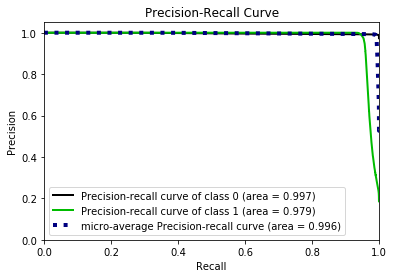

In [39]:
print_report('Test', estimator, test_pool, y_test, estimator.predict(test_pool), plot_pr=True)

## 13.3 Misclassification report

however the model did pretty well during the validation and test phases but various number of attack classes were missclassified   

In [40]:
classifications = y_test.copy()
classifications['pred'] = estimator.predict(test_pool)
counts = classifications.value_counts()

In [41]:
misclassifications = classifications[classifications.binary_class != classifications.pred]
mc = pd.DataFrame(misclassifications.value_counts())

In [42]:
mc['percentage'] = mc.apply(lambda x: x[0] / counts[x.name], axis=1)
mc = mc.sort_values('percentage', ascending=False)

In [43]:
print('Misclassifications:')
display(mc)

Misclassifications:


0  percentage
binary_class pred                   
1            0     16249         1.0
0            1       682         1.0

# 14 - test the Gb estimator on CICIDS-2017

we want to test the classifer on a new set of data that is out of the whole dataframe distrbuation,that will test if the performance is equally good as the performance in the test set above.

In [44]:
cicids2017 = r'/media/upm/New Volume/project/0/cicids2017/cic-ids-2017-20220417T142956Z-001/cic-ids-2017'

In [45]:
def replace_infinity_with_mean(df):
    inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
    for col in inf_columns:
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def replace_negative_values_with_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.values
    
    columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
    for col in columns:
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def load_dataset(files, dtypes, cols=None):
    df = pd.concat((pd.read_csv(f, dtype=dtypes, usecols=cols) for f in files))
    
    df = replace_infinity_with_mean(df)
    df = replace_negative_values_with_mean(df)
        
    df['label_cat'] = df.label.astype('category').cat.codes
    df['label_is_attack'] = (df.label != 'Benign').astype('int')
    return df

In [46]:
files = glob.glob(os.path.join(cicids2017, '*.csv'))

df_novel = load_dataset(files, types, cols=selected_features + ['label'])

X_novel = df_novel.drop(columns=['label', 'label_cat', 'label_is_attack'])
y_novel = df_novel[['label_is_attack', 'label_cat', 'label']]

In [47]:
print(f"Number of test samples: {len(X_novel)}")

Number of test samples: 2830743


Classification Report (Novel):
              precision    recall  f1-score   support

           0       0.85      0.97      0.91   2273097
           1       0.71      0.30      0.42    557646

    accuracy                           0.84   2830743
   macro avg       0.78      0.63      0.66   2830743
weighted avg       0.82      0.84      0.81   2830743

Avg Precision Score: 0.34918627997276036


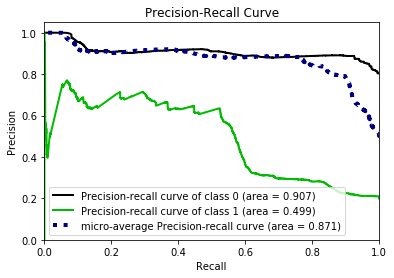

In [48]:
novel_pool = Pool(X_novel, cat_features=['protocol'])

print_report('Novel', estimator, novel_pool, y_novel.label_is_attack, estimator.predict(novel_pool), plot_pr=True)

the estimator has not a very good performance on cicids2017 dataset recorded in a different network environment with a recall of `0.84` and a precision of `0.82`. the estimator's attack recall is `0.30` which is insufficient for real-world usage.  

## 16 - Model from combined data

In order to create a estimator that generalizes well on data from different network environments an estimator is created by using the combined [CIC-IDS-2017](https://www.unb.ca/cic/datasets/ids-2017.html) and [CIC-IDS-2018](https://www.unb.ca/cic/datasets/ids-2018.html) datasets.

### 16.1 load combined data 

In [49]:
combined_files = glob.glob(os.path.join(path, '*.csv')) + glob.glob(os.path.join(cicids2017 , '*.csv'))

df = load_dataset(combined_files, types, cols=selected_features + ['label'])

X = df.drop(columns=['label', 'label_cat', 'label_is_attack'])
y = df[['label_is_attack', 'label_cat', 'label']]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y.label_cat)

### 16.2 Synthetic Oversampling - SMOTE

In order to get a better detection rate for underrepresented attacks `Synthetic Minority Oversampling` is used to push the occurrences of those classes to `100000`.

In [51]:
y_train.label.value_counts()

Benign                      12606243
DoS attacks-Hulk              554388
DDOS attack-HOIC              548809
DDoS attacks-LOIC-HTTP        460953
Bot                           230526
FTP-BruteForce                161038
SSH-Bruteforce                154789
Infilteration                 129576
PortScan                      127144
DoS attacks-SlowHTTPTest      116311
DDOS LOIT                     102422
DoS attacks-GoldenEye          41441
DoS attacks-Slowloris          13429
Brute Force -Web                1694
DDOS attack-LOIC-UDP            1384
Brute Force -XSS                 706
SQL Injection                     86
Heartbleed                         9
Name: label, dtype: int64

In [52]:
# 100000 record for under represented labels 
cnts = y_train.label_cat.value_counts()
sample_dict = {}

for i in np.unique(y_train.label_cat):
    sample_dict[i] = max(cnts[i], 100000)

In [53]:
from imblearn.over_sampling import SMOTENC
sm = SMOTENC(sampling_strategy=sample_dict, categorical_features=[0], n_jobs=24)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train.label_cat)

In [54]:
from collections import Counter
print('Class occurrences:')
Counter(y_train_s)

Class occurrences:


Counter({0: 12606243,
         7: 460953,
         10: 116311,
         1: 230526,
         9: 554388,
         5: 548809,
         15: 127144,
         4: 102422,
         14: 129576,
         12: 161038,
         17: 154789,
         11: 100000,
         8: 100000,
         2: 100000,
         6: 100000,
         3: 100000,
         16: 100000,
         13: 100000})

In [55]:
y_train_s = (y_train_s != 0).astype('int')
print('Binary label occurrences:')
Counter(y_train_s)

Binary label occurrences:


Counter({0: 12606243, 1: 3285956})

# 17. Hyperparameter Optimization - Grid Search 

In [56]:
def train_catboost_grid(train_pool, y_train):
    minority_class_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print(f"Minority class weight: {minority_class_weight}")
    
    param_grid = {
        'iterations': [500, 1000, 1500],
        'learning_rate': [0.3, 0.03, 0.003],
        'depth': [3, 6, 9],
        'l2_leaf_reg': [3, 6]
    }

    cls = CatBoostClassifier(loss_function='Logloss',
                             eval_metric='Recall',
                             class_weights=[1, minority_class_weight],
                             task_type='GPU',
                             verbose=True)

    cb_results = cls.grid_search(param_grid, train_pool)

    print('\nOptimal Parameters:')
    print(cb_results['params'])
    return cls

In [57]:
train_pool = Pool(X_train_s, y_train_s, cat_features=[0])

In [58]:
comb_estimator = train_catboost_grid(train_pool, y_train_s)

Minority class weight: 3.8364004265425344
0:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 179ms	remaining: 1m 29s
1:	learn: 0.9006563	test: 0.9008617	best: 0.9170290 (0)	total: 369ms	remaining: 1m 31s
2:	learn: 0.9365015	test: 0.9365491	best: 0.9365491 (2)	total: 537ms	remaining: 1m 28s
3:	learn: 0.9342533	test: 0.9343473	best: 0.9365491 (2)	total: 707ms	remaining: 1m 27s
4:	learn: 0.9509373	test: 0.9510391	best: 0.9510391 (4)	total: 883ms	remaining: 1m 27s
5:	learn: 0.9518706	test: 0.9519576	best: 0.9519576 (5)	total: 1.06s	remaining: 1m 27s
6:	learn: 0.9482755	test: 0.9483856	best: 0.9519576 (5)	total: 1.23s	remaining: 1m 26s
7:	learn: 0.9493865	test: 0.9494790	best: 0.9519576 (5)	total: 1.4s	remaining: 1m 26s
8:	learn: 0.9514741	test: 0.9516048	best: 0.9519576 (5)	total: 1.57s	remaining: 1m 25s
9:	learn: 0.9496711	test: 0.9498120	best: 0.9519576 (5)	total: 1.74s	remaining: 1m 25s
10:	learn: 0.9503327	test: 0.9504020	best: 0.9519576 (5)	total: 1.91s	remaining: 1m 24s
1

93:	learn: 0.9649865	test: 0.9648342	best: 0.9648767 (81)	total: 16.4s	remaining: 1m 10s
94:	learn: 0.9649922	test: 0.9648524	best: 0.9648767 (81)	total: 16.6s	remaining: 1m 10s
95:	learn: 0.9650253	test: 0.9648813	best: 0.9648813 (95)	total: 16.7s	remaining: 1m 10s
96:	learn: 0.9650466	test: 0.9648843	best: 0.9648843 (96)	total: 16.9s	remaining: 1m 10s
97:	learn: 0.9650493	test: 0.9648859	best: 0.9648859 (97)	total: 17.1s	remaining: 1m 9s
98:	learn: 0.9650831	test: 0.9649224	best: 0.9649224 (98)	total: 17.2s	remaining: 1m 9s
99:	learn: 0.9650854	test: 0.9649224	best: 0.9649224 (98)	total: 17.4s	remaining: 1m 9s
100:	learn: 0.9650843	test: 0.9649193	best: 0.9649224 (98)	total: 17.6s	remaining: 1m 9s
101:	learn: 0.9650778	test: 0.9649148	best: 0.9649224 (98)	total: 17.8s	remaining: 1m 9s
102:	learn: 0.9650729	test: 0.9649072	best: 0.9649224 (98)	total: 17.9s	remaining: 1m 9s
103:	learn: 0.9650843	test: 0.9649178	best: 0.9649224 (98)	total: 18.1s	remaining: 1m 8s
104:	learn: 0.9650679	te

185:	learn: 0.9654092	test: 0.9653056	best: 0.9653512 (159)	total: 32s	remaining: 54.1s
186:	learn: 0.9654111	test: 0.9652980	best: 0.9653512 (159)	total: 32.2s	remaining: 53.9s
187:	learn: 0.9654218	test: 0.9653010	best: 0.9653512 (159)	total: 32.4s	remaining: 53.7s
188:	learn: 0.9654415	test: 0.9653177	best: 0.9653512 (159)	total: 32.6s	remaining: 53.6s
189:	learn: 0.9654453	test: 0.9653253	best: 0.9653512 (159)	total: 32.7s	remaining: 53.4s
190:	learn: 0.9655363	test: 0.9654272	best: 0.9654272 (190)	total: 32.9s	remaining: 53.2s
191:	learn: 0.9655393	test: 0.9654257	best: 0.9654272 (190)	total: 33.1s	remaining: 53s
192:	learn: 0.9655975	test: 0.9654865	best: 0.9654865 (192)	total: 33.2s	remaining: 52.9s
193:	learn: 0.9656048	test: 0.9654865	best: 0.9654865 (192)	total: 33.4s	remaining: 52.7s
194:	learn: 0.9655934	test: 0.9654835	best: 0.9654865 (192)	total: 33.6s	remaining: 52.5s
195:	learn: 0.9656074	test: 0.9654941	best: 0.9654941 (195)	total: 33.7s	remaining: 52.3s
196:	learn: 0.

277:	learn: 0.9662401	test: 0.9661723	best: 0.9662058 (269)	total: 47.8s	remaining: 38.1s
278:	learn: 0.9662390	test: 0.9661754	best: 0.9662058 (269)	total: 47.9s	remaining: 38s
279:	learn: 0.9662265	test: 0.9661632	best: 0.9662058 (269)	total: 48.1s	remaining: 37.8s
280:	learn: 0.9662200	test: 0.9661601	best: 0.9662058 (269)	total: 48.3s	remaining: 37.6s
281:	learn: 0.9662162	test: 0.9661541	best: 0.9662058 (269)	total: 48.4s	remaining: 37.5s
282:	learn: 0.9662181	test: 0.9661510	best: 0.9662058 (269)	total: 48.6s	remaining: 37.3s
283:	learn: 0.9662272	test: 0.9661647	best: 0.9662058 (269)	total: 48.8s	remaining: 37.1s
284:	learn: 0.9662352	test: 0.9661723	best: 0.9662058 (269)	total: 49s	remaining: 36.9s
285:	learn: 0.9662428	test: 0.9661723	best: 0.9662058 (269)	total: 49.1s	remaining: 36.7s
286:	learn: 0.9662481	test: 0.9661769	best: 0.9662058 (269)	total: 49.3s	remaining: 36.6s
287:	learn: 0.9662527	test: 0.9661814	best: 0.9662058 (269)	total: 49.4s	remaining: 36.4s
288:	learn: 0.

369:	learn: 0.9668341	test: 0.9667745	best: 0.9667745 (369)	total: 1m 3s	remaining: 22.3s
370:	learn: 0.9668592	test: 0.9668125	best: 0.9668125 (370)	total: 1m 3s	remaining: 22.1s
371:	learn: 0.9669950	test: 0.9669585	best: 0.9669585 (371)	total: 1m 3s	remaining: 21.9s
372:	learn: 0.9670262	test: 0.9669752	best: 0.9669752 (372)	total: 1m 3s	remaining: 21.8s
373:	learn: 0.9670083	test: 0.9669554	best: 0.9669752 (372)	total: 1m 4s	remaining: 21.6s
374:	learn: 0.9670083	test: 0.9669448	best: 0.9669752 (372)	total: 1m 4s	remaining: 21.4s
375:	learn: 0.9670190	test: 0.9669661	best: 0.9669752 (372)	total: 1m 4s	remaining: 21.2s
376:	learn: 0.9670460	test: 0.9669934	best: 0.9669934 (376)	total: 1m 4s	remaining: 21.1s
377:	learn: 0.9670604	test: 0.9669919	best: 0.9669934 (376)	total: 1m 4s	remaining: 20.9s
378:	learn: 0.9670700	test: 0.9669950	best: 0.9669950 (378)	total: 1m 4s	remaining: 20.7s
379:	learn: 0.9670722	test: 0.9670041	best: 0.9670041 (379)	total: 1m 5s	remaining: 20.6s
380:	learn

461:	learn: 0.9674904	test: 0.9674572	best: 0.9675165 (455)	total: 1m 19s	remaining: 6.5s
462:	learn: 0.9675512	test: 0.9675181	best: 0.9675181 (462)	total: 1m 19s	remaining: 6.33s
463:	learn: 0.9675779	test: 0.9675439	best: 0.9675439 (463)	total: 1m 19s	remaining: 6.16s
464:	learn: 0.9675999	test: 0.9675713	best: 0.9675713 (464)	total: 1m 19s	remaining: 5.99s
465:	learn: 0.9675996	test: 0.9675698	best: 0.9675713 (464)	total: 1m 19s	remaining: 5.82s
466:	learn: 0.9675893	test: 0.9675637	best: 0.9675713 (464)	total: 1m 19s	remaining: 5.65s
467:	learn: 0.9675889	test: 0.9675622	best: 0.9675713 (464)	total: 1m 20s	remaining: 5.48s
468:	learn: 0.9676616	test: 0.9676291	best: 0.9676291 (468)	total: 1m 20s	remaining: 5.31s
469:	learn: 0.9676639	test: 0.9676291	best: 0.9676291 (468)	total: 1m 20s	remaining: 5.14s
470:	learn: 0.9676662	test: 0.9676321	best: 0.9676321 (470)	total: 1m 20s	remaining: 4.96s
471:	learn: 0.9676627	test: 0.9676306	best: 0.9676321 (470)	total: 1m 20s	remaining: 4.79s


52:	learn: 0.9517481	test: 0.9519530	best: 0.9521461 (46)	total: 9.28s	remaining: 1m 18s
53:	learn: 0.9519040	test: 0.9520975	best: 0.9521461 (46)	total: 9.45s	remaining: 1m 18s
54:	learn: 0.9517511	test: 0.9519484	best: 0.9521461 (46)	total: 9.62s	remaining: 1m 17s
55:	learn: 0.9519383	test: 0.9521142	best: 0.9521461 (46)	total: 9.79s	remaining: 1m 17s
56:	learn: 0.9512078	test: 0.9513737	best: 0.9521461 (46)	total: 9.96s	remaining: 1m 17s
57:	learn: 0.9512021	test: 0.9513706	best: 0.9521461 (46)	total: 10.1s	remaining: 1m 17s
58:	learn: 0.9512055	test: 0.9513691	best: 0.9521461 (46)	total: 10.3s	remaining: 1m 17s
59:	learn: 0.9512416	test: 0.9514025	best: 0.9521461 (46)	total: 10.5s	remaining: 1m 16s
60:	learn: 0.9513383	test: 0.9515075	best: 0.9521461 (46)	total: 10.7s	remaining: 1m 16s
61:	learn: 0.9512999	test: 0.9514816	best: 0.9521461 (46)	total: 10.8s	remaining: 1m 16s
62:	learn: 0.9512097	test: 0.9513797	best: 0.9521461 (46)	total: 11s	remaining: 1m 16s
63:	learn: 0.9514376	te

146:	learn: 0.9502832	test: 0.9504643	best: 0.9521461 (46)	total: 25.3s	remaining: 1m
147:	learn: 0.9502353	test: 0.9504217	best: 0.9521461 (46)	total: 25.5s	remaining: 1m
148:	learn: 0.9501699	test: 0.9503579	best: 0.9521461 (46)	total: 25.7s	remaining: 1m
149:	learn: 0.9502132	test: 0.9503944	best: 0.9521461 (46)	total: 25.9s	remaining: 1m
150:	learn: 0.9502125	test: 0.9503944	best: 0.9521461 (46)	total: 26s	remaining: 1m
151:	learn: 0.9502155	test: 0.9503974	best: 0.9521461 (46)	total: 26.2s	remaining: 1m
152:	learn: 0.9502338	test: 0.9504081	best: 0.9521461 (46)	total: 26.4s	remaining: 59.8s
153:	learn: 0.9503015	test: 0.9504689	best: 0.9521461 (46)	total: 26.6s	remaining: 59.7s
154:	learn: 0.9502178	test: 0.9503913	best: 0.9521461 (46)	total: 26.7s	remaining: 59.5s
155:	learn: 0.9501406	test: 0.9503335	best: 0.9521461 (46)	total: 26.9s	remaining: 59.3s
156:	learn: 0.9501299	test: 0.9503031	best: 0.9521461 (46)	total: 27.1s	remaining: 59.1s
157:	learn: 0.9499967	test: 0.9501739	bes

240:	learn: 0.9553275	test: 0.9554185	best: 0.9554383 (239)	total: 41.5s	remaining: 44.6s
241:	learn: 0.9552332	test: 0.9553242	best: 0.9554383 (239)	total: 41.7s	remaining: 44.4s
242:	learn: 0.9551970	test: 0.9552984	best: 0.9554383 (239)	total: 41.8s	remaining: 44.3s
243:	learn: 0.9613153	test: 0.9612303	best: 0.9612303 (243)	total: 42s	remaining: 44.1s
244:	learn: 0.9613233	test: 0.9612409	best: 0.9612409 (244)	total: 42.2s	remaining: 43.9s
245:	learn: 0.9630644	test: 0.9630505	best: 0.9630505 (245)	total: 42.4s	remaining: 43.7s
246:	learn: 0.9631096	test: 0.9630991	best: 0.9630991 (246)	total: 42.5s	remaining: 43.6s
247:	learn: 0.9630511	test: 0.9630459	best: 0.9630991 (246)	total: 42.7s	remaining: 43.4s
248:	learn: 0.9631907	test: 0.9631995	best: 0.9631995 (248)	total: 42.9s	remaining: 43.2s
249:	learn: 0.9631922	test: 0.9631995	best: 0.9631995 (248)	total: 43.1s	remaining: 43.1s
250:	learn: 0.9632181	test: 0.9632193	best: 0.9632193 (250)	total: 43.2s	remaining: 42.9s
251:	learn: 

332:	learn: 0.9627566	test: 0.9627950	best: 0.9632421 (252)	total: 57.4s	remaining: 28.8s
333:	learn: 0.9627543	test: 0.9627965	best: 0.9632421 (252)	total: 57.6s	remaining: 28.6s
334:	learn: 0.9627490	test: 0.9627920	best: 0.9632421 (252)	total: 57.8s	remaining: 28.4s
335:	learn: 0.9624743	test: 0.9625061	best: 0.9632421 (252)	total: 57.9s	remaining: 28.3s
336:	learn: 0.9624727	test: 0.9625031	best: 0.9632421 (252)	total: 58.1s	remaining: 28.1s
337:	learn: 0.9624735	test: 0.9625015	best: 0.9632421 (252)	total: 58.3s	remaining: 27.9s
338:	learn: 0.9624727	test: 0.9625015	best: 0.9632421 (252)	total: 58.5s	remaining: 27.8s
339:	learn: 0.9624663	test: 0.9624985	best: 0.9632421 (252)	total: 58.6s	remaining: 27.6s
340:	learn: 0.9624689	test: 0.9624985	best: 0.9632421 (252)	total: 58.8s	remaining: 27.4s
341:	learn: 0.9624857	test: 0.9625228	best: 0.9632421 (252)	total: 59s	remaining: 27.2s
342:	learn: 0.9624807	test: 0.9625137	best: 0.9632421 (252)	total: 59.1s	remaining: 27.1s
343:	learn: 

424:	learn: 0.9627326	test: 0.9627388	best: 0.9632421 (252)	total: 1m 13s	remaining: 12.9s
425:	learn: 0.9627524	test: 0.9627433	best: 0.9632421 (252)	total: 1m 13s	remaining: 12.7s
426:	learn: 0.9627299	test: 0.9627296	best: 0.9632421 (252)	total: 1m 13s	remaining: 12.6s
427:	learn: 0.9627368	test: 0.9627357	best: 0.9632421 (252)	total: 1m 13s	remaining: 12.4s
428:	learn: 0.9627394	test: 0.9627388	best: 0.9632421 (252)	total: 1m 13s	remaining: 12.2s
429:	learn: 0.9627318	test: 0.9627342	best: 0.9632421 (252)	total: 1m 14s	remaining: 12.1s
430:	learn: 0.9627265	test: 0.9627296	best: 0.9632421 (252)	total: 1m 14s	remaining: 11.9s
431:	learn: 0.9629194	test: 0.9629106	best: 0.9632421 (252)	total: 1m 14s	remaining: 11.7s
432:	learn: 0.9629114	test: 0.9629030	best: 0.9632421 (252)	total: 1m 14s	remaining: 11.5s
433:	learn: 0.9629141	test: 0.9629060	best: 0.9632421 (252)	total: 1m 14s	remaining: 11.4s
434:	learn: 0.9629129	test: 0.9629045	best: 0.9632421 (252)	total: 1m 14s	remaining: 11.2s

14:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 2.68s	remaining: 1m 26s
15:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 2.86s	remaining: 1m 26s
16:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 3.04s	remaining: 1m 26s
17:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 3.22s	remaining: 1m 26s
18:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 3.4s	remaining: 1m 26s
19:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 3.58s	remaining: 1m 25s
20:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 3.75s	remaining: 1m 25s
21:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 3.93s	remaining: 1m 25s
22:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 4.11s	remaining: 1m 25s
23:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 4.29s	remaining: 1m 25s
24:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 4.47s	remaining: 1m 24s
25:	learn: 0.9169130	test: 0.9170

108:	learn: 0.8999494	test: 0.9002368	best: 0.9170290 (0)	total: 19.4s	remaining: 1m 9s
109:	learn: 0.8999494	test: 0.9002368	best: 0.9170290 (0)	total: 19.6s	remaining: 1m 9s
110:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 19.8s	remaining: 1m 9s
111:	learn: 0.9000882	test: 0.9003736	best: 0.9170290 (0)	total: 20s	remaining: 1m 9s
112:	learn: 0.9000882	test: 0.9003736	best: 0.9170290 (0)	total: 20.1s	remaining: 1m 8s
113:	learn: 0.9000882	test: 0.9003736	best: 0.9170290 (0)	total: 20.3s	remaining: 1m 8s
114:	learn: 0.9000882	test: 0.9003736	best: 0.9170290 (0)	total: 20.5s	remaining: 1m 8s
115:	learn: 0.9000882	test: 0.9003736	best: 0.9170290 (0)	total: 20.7s	remaining: 1m 8s
116:	learn: 0.9000882	test: 0.9003736	best: 0.9170290 (0)	total: 20.8s	remaining: 1m 8s
117:	learn: 0.9000882	test: 0.9003736	best: 0.9170290 (0)	total: 21s	remaining: 1m 8s
118:	learn: 0.9000882	test: 0.9003736	best: 0.9170290 (0)	total: 21.2s	remaining: 1m 7s
119:	learn: 0.9000882	test: 0.900373

202:	learn: 0.9123987	test: 0.9127408	best: 0.9170290 (0)	total: 36s	remaining: 52.7s
203:	learn: 0.9123987	test: 0.9127408	best: 0.9170290 (0)	total: 36.2s	remaining: 52.5s
204:	learn: 0.9123987	test: 0.9127408	best: 0.9170290 (0)	total: 36.4s	remaining: 52.3s
205:	learn: 0.9125079	test: 0.9128336	best: 0.9170290 (0)	total: 36.5s	remaining: 52.2s
206:	learn: 0.9125079	test: 0.9128336	best: 0.9170290 (0)	total: 36.7s	remaining: 52s
207:	learn: 0.9125079	test: 0.9128336	best: 0.9170290 (0)	total: 36.9s	remaining: 51.8s
208:	learn: 0.9125079	test: 0.9128336	best: 0.9170290 (0)	total: 37.1s	remaining: 51.6s
209:	learn: 0.9125083	test: 0.9128336	best: 0.9170290 (0)	total: 37.3s	remaining: 51.5s
210:	learn: 0.9134838	test: 0.9138052	best: 0.9170290 (0)	total: 37.4s	remaining: 51.3s
211:	learn: 0.9134926	test: 0.9138113	best: 0.9170290 (0)	total: 37.6s	remaining: 51.1s
212:	learn: 0.9134926	test: 0.9138113	best: 0.9170290 (0)	total: 37.8s	remaining: 50.9s
213:	learn: 0.9134930	test: 0.913811

296:	learn: 0.9461460	test: 0.9463404	best: 0.9463404 (294)	total: 52.6s	remaining: 35.9s
297:	learn: 0.9461464	test: 0.9463404	best: 0.9463404 (294)	total: 52.8s	remaining: 35.8s
298:	learn: 0.9461464	test: 0.9463404	best: 0.9463404 (294)	total: 52.9s	remaining: 35.6s
299:	learn: 0.9461464	test: 0.9463404	best: 0.9463404 (294)	total: 53.1s	remaining: 35.4s
300:	learn: 0.9461464	test: 0.9463404	best: 0.9463404 (294)	total: 53.3s	remaining: 35.2s
301:	learn: 0.9461464	test: 0.9463404	best: 0.9463404 (294)	total: 53.5s	remaining: 35s
302:	learn: 0.9461464	test: 0.9463404	best: 0.9463404 (294)	total: 53.6s	remaining: 34.9s
303:	learn: 0.9461468	test: 0.9463404	best: 0.9463404 (294)	total: 53.8s	remaining: 34.7s
304:	learn: 0.9461472	test: 0.9463404	best: 0.9463404 (294)	total: 54s	remaining: 34.5s
305:	learn: 0.9460840	test: 0.9462796	best: 0.9463404 (294)	total: 54.2s	remaining: 34.3s
306:	learn: 0.9460840	test: 0.9462796	best: 0.9463404 (294)	total: 54.3s	remaining: 34.2s
307:	learn: 0.

388:	learn: 0.9459915	test: 0.9461807	best: 0.9463404 (294)	total: 1m 8s	remaining: 19.6s
389:	learn: 0.9459915	test: 0.9461807	best: 0.9463404 (294)	total: 1m 8s	remaining: 19.4s
390:	learn: 0.9459915	test: 0.9461807	best: 0.9463404 (294)	total: 1m 9s	remaining: 19.3s
391:	learn: 0.9459953	test: 0.9461777	best: 0.9463404 (294)	total: 1m 9s	remaining: 19.1s
392:	learn: 0.9459953	test: 0.9461777	best: 0.9463404 (294)	total: 1m 9s	remaining: 18.9s
393:	learn: 0.9459874	test: 0.9461762	best: 0.9463404 (294)	total: 1m 9s	remaining: 18.7s
394:	learn: 0.9459874	test: 0.9461762	best: 0.9463404 (294)	total: 1m 9s	remaining: 18.5s
395:	learn: 0.9459874	test: 0.9461762	best: 0.9463404 (294)	total: 1m 9s	remaining: 18.4s
396:	learn: 0.9459877	test: 0.9461762	best: 0.9463404 (294)	total: 1m 10s	remaining: 18.2s
397:	learn: 0.9459881	test: 0.9461792	best: 0.9463404 (294)	total: 1m 10s	remaining: 18s
398:	learn: 0.9459889	test: 0.9461838	best: 0.9463404 (294)	total: 1m 10s	remaining: 17.8s
399:	lear

480:	learn: 0.9458569	test: 0.9461397	best: 0.9463404 (294)	total: 1m 24s	remaining: 3.35s
481:	learn: 0.9458576	test: 0.9461412	best: 0.9463404 (294)	total: 1m 24s	remaining: 3.17s
482:	learn: 0.9458576	test: 0.9461412	best: 0.9463404 (294)	total: 1m 25s	remaining: 3s
483:	learn: 0.9458580	test: 0.9461412	best: 0.9463404 (294)	total: 1m 25s	remaining: 2.82s
484:	learn: 0.9458584	test: 0.9461412	best: 0.9463404 (294)	total: 1m 25s	remaining: 2.64s
485:	learn: 0.9458584	test: 0.9461412	best: 0.9463404 (294)	total: 1m 25s	remaining: 2.47s
486:	learn: 0.9458584	test: 0.9461412	best: 0.9463404 (294)	total: 1m 25s	remaining: 2.29s
487:	learn: 0.9458317	test: 0.9461093	best: 0.9463404 (294)	total: 1m 26s	remaining: 2.12s
488:	learn: 0.9458321	test: 0.9461077	best: 0.9463404 (294)	total: 1m 26s	remaining: 1.94s
489:	learn: 0.9458321	test: 0.9461077	best: 0.9463404 (294)	total: 1m 26s	remaining: 1.76s
490:	learn: 0.9513383	test: 0.9515926	best: 0.9515926 (490)	total: 1m 26s	remaining: 1.59s
49

72:	learn: 0.9638295	test: 0.9636374	best: 0.9641970 (53)	total: 12.4s	remaining: 1m 12s
73:	learn: 0.9638363	test: 0.9636314	best: 0.9641970 (53)	total: 12.6s	remaining: 1m 12s
74:	learn: 0.9639695	test: 0.9637925	best: 0.9641970 (53)	total: 12.7s	remaining: 1m 12s
75:	learn: 0.9639718	test: 0.9637849	best: 0.9641970 (53)	total: 12.9s	remaining: 1m 12s
76:	learn: 0.9639908	test: 0.9638001	best: 0.9641970 (53)	total: 13.1s	remaining: 1m 11s
77:	learn: 0.9640110	test: 0.9638214	best: 0.9641970 (53)	total: 13.2s	remaining: 1m 11s
78:	learn: 0.9641346	test: 0.9639568	best: 0.9641970 (53)	total: 13.4s	remaining: 1m 11s
79:	learn: 0.9641883	test: 0.9639978	best: 0.9641970 (53)	total: 13.6s	remaining: 1m 11s
80:	learn: 0.9642625	test: 0.9640982	best: 0.9641970 (53)	total: 13.8s	remaining: 1m 11s
81:	learn: 0.9642305	test: 0.9640465	best: 0.9641970 (53)	total: 13.9s	remaining: 1m 11s
82:	learn: 0.9642640	test: 0.9641058	best: 0.9641970 (53)	total: 14.1s	remaining: 1m 10s
83:	learn: 0.9639642	

164:	learn: 0.9656713	test: 0.9656218	best: 0.9656218 (164)	total: 28.2s	remaining: 57.2s
165:	learn: 0.9656729	test: 0.9656218	best: 0.9656218 (164)	total: 28.3s	remaining: 57s
166:	learn: 0.9656790	test: 0.9656325	best: 0.9656325 (166)	total: 28.5s	remaining: 56.8s
167:	learn: 0.9656447	test: 0.9655793	best: 0.9656325 (166)	total: 28.7s	remaining: 56.7s
168:	learn: 0.9656683	test: 0.9656295	best: 0.9656325 (166)	total: 28.9s	remaining: 56.5s
169:	learn: 0.9656565	test: 0.9656264	best: 0.9656325 (166)	total: 29s	remaining: 56.3s
170:	learn: 0.9656120	test: 0.9655443	best: 0.9656325 (166)	total: 29.2s	remaining: 56.2s
171:	learn: 0.9655823	test: 0.9655032	best: 0.9656325 (166)	total: 29.4s	remaining: 56s
172:	learn: 0.9655876	test: 0.9655017	best: 0.9656325 (166)	total: 29.5s	remaining: 55.9s
173:	learn: 0.9655861	test: 0.9655063	best: 0.9656325 (166)	total: 29.7s	remaining: 55.7s
174:	learn: 0.9655972	test: 0.9655428	best: 0.9656325 (166)	total: 29.9s	remaining: 55.5s
175:	learn: 0.96

256:	learn: 0.9661530	test: 0.9661191	best: 0.9661343 (250)	total: 43.9s	remaining: 41.6s
257:	learn: 0.9661523	test: 0.9661206	best: 0.9661343 (250)	total: 44.1s	remaining: 41.4s
258:	learn: 0.9661690	test: 0.9661328	best: 0.9661343 (250)	total: 44.3s	remaining: 41.2s
259:	learn: 0.9661747	test: 0.9661389	best: 0.9661389 (259)	total: 44.5s	remaining: 41s
260:	learn: 0.9661793	test: 0.9661389	best: 0.9661389 (259)	total: 44.6s	remaining: 40.9s
261:	learn: 0.9661819	test: 0.9661389	best: 0.9661389 (259)	total: 44.8s	remaining: 40.7s
262:	learn: 0.9662055	test: 0.9661617	best: 0.9661617 (262)	total: 45s	remaining: 40.5s
263:	learn: 0.9662006	test: 0.9661571	best: 0.9661617 (262)	total: 45.1s	remaining: 40.3s
264:	learn: 0.9661500	test: 0.9660993	best: 0.9661617 (262)	total: 45.3s	remaining: 40.2s
265:	learn: 0.9661622	test: 0.9661313	best: 0.9661617 (262)	total: 45.5s	remaining: 40s
266:	learn: 0.9661538	test: 0.9661176	best: 0.9661617 (262)	total: 45.6s	remaining: 39.8s
267:	learn: 0.96

348:	learn: 0.9666933	test: 0.9666528	best: 0.9666848 (342)	total: 59.6s	remaining: 25.8s
349:	learn: 0.9667017	test: 0.9666680	best: 0.9666848 (342)	total: 59.8s	remaining: 25.6s
350:	learn: 0.9667116	test: 0.9666726	best: 0.9666848 (342)	total: 60s	remaining: 25.5s
351:	learn: 0.9667272	test: 0.9666954	best: 0.9666954 (351)	total: 1m	remaining: 25.3s
352:	learn: 0.9667268	test: 0.9666924	best: 0.9666954 (351)	total: 1m	remaining: 25.1s
353:	learn: 0.9667332	test: 0.9667000	best: 0.9667000 (353)	total: 1m	remaining: 25s
354:	learn: 0.9667424	test: 0.9667106	best: 0.9667106 (354)	total: 1m	remaining: 24.8s
355:	learn: 0.9667827	test: 0.9667501	best: 0.9667501 (355)	total: 1m	remaining: 24.6s
356:	learn: 0.9667603	test: 0.9667289	best: 0.9667501 (355)	total: 1m 1s	remaining: 24.4s
357:	learn: 0.9667873	test: 0.9667501	best: 0.9667501 (355)	total: 1m 1s	remaining: 24.3s
358:	learn: 0.9667812	test: 0.9667501	best: 0.9667501 (355)	total: 1m 1s	remaining: 24.1s
359:	learn: 0.9667934	test: 0

440:	learn: 0.9675223	test: 0.9675089	best: 0.9675272 (427)	total: 1m 15s	remaining: 10.1s
441:	learn: 0.9675273	test: 0.9675105	best: 0.9675272 (427)	total: 1m 15s	remaining: 9.92s
442:	learn: 0.9674885	test: 0.9674724	best: 0.9675272 (427)	total: 1m 15s	remaining: 9.75s
443:	learn: 0.9674908	test: 0.9674740	best: 0.9675272 (427)	total: 1m 15s	remaining: 9.58s
444:	learn: 0.9674843	test: 0.9674724	best: 0.9675272 (427)	total: 1m 16s	remaining: 9.41s
445:	learn: 0.9674915	test: 0.9674785	best: 0.9675272 (427)	total: 1m 16s	remaining: 9.24s
446:	learn: 0.9674889	test: 0.9674785	best: 0.9675272 (427)	total: 1m 16s	remaining: 9.07s
447:	learn: 0.9674869	test: 0.9674770	best: 0.9675272 (427)	total: 1m 16s	remaining: 8.9s
448:	learn: 0.9674295	test: 0.9674147	best: 0.9675272 (427)	total: 1m 16s	remaining: 8.73s
449:	learn: 0.9674303	test: 0.9674192	best: 0.9675272 (427)	total: 1m 17s	remaining: 8.56s
450:	learn: 0.9674866	test: 0.9674800	best: 0.9675272 (427)	total: 1m 17s	remaining: 8.39s


30:	learn: 0.9461886	test: 0.9463541	best: 0.9463602 (28)	total: 5.51s	remaining: 1m 23s
31:	learn: 0.9461886	test: 0.9463541	best: 0.9463602 (28)	total: 5.68s	remaining: 1m 23s
32:	learn: 0.9461209	test: 0.9462872	best: 0.9463602 (28)	total: 5.85s	remaining: 1m 22s
33:	learn: 0.9460460	test: 0.9461959	best: 0.9463602 (28)	total: 6.02s	remaining: 1m 22s
34:	learn: 0.9459071	test: 0.9460773	best: 0.9463602 (28)	total: 6.2s	remaining: 1m 22s
35:	learn: 0.9461696	test: 0.9463754	best: 0.9463754 (35)	total: 6.37s	remaining: 1m 22s
36:	learn: 0.9459649	test: 0.9461762	best: 0.9463754 (35)	total: 6.54s	remaining: 1m 21s
37:	learn: 0.9461255	test: 0.9463222	best: 0.9463754 (35)	total: 6.71s	remaining: 1m 21s
38:	learn: 0.9515742	test: 0.9517873	best: 0.9517873 (38)	total: 6.88s	remaining: 1m 21s
39:	learn: 0.9515361	test: 0.9517629	best: 0.9517873 (38)	total: 7.06s	remaining: 1m 21s
40:	learn: 0.9515236	test: 0.9517508	best: 0.9517873 (38)	total: 7.23s	remaining: 1m 20s
41:	learn: 0.9515639	t

124:	learn: 0.9497947	test: 0.9500218	best: 0.9521461 (46)	total: 21.6s	remaining: 1m 4s
125:	learn: 0.9497871	test: 0.9500188	best: 0.9521461 (46)	total: 21.8s	remaining: 1m 4s
126:	learn: 0.9497278	test: 0.9499595	best: 0.9521461 (46)	total: 22s	remaining: 1m 4s
127:	learn: 0.9497886	test: 0.9500188	best: 0.9521461 (46)	total: 22.2s	remaining: 1m 4s
128:	learn: 0.9498145	test: 0.9500416	best: 0.9521461 (46)	total: 22.3s	remaining: 1m 4s
129:	learn: 0.9498195	test: 0.9500431	best: 0.9521461 (46)	total: 22.5s	remaining: 1m 4s
130:	learn: 0.9497989	test: 0.9500173	best: 0.9521461 (46)	total: 22.7s	remaining: 1m 3s
131:	learn: 0.9497468	test: 0.9499640	best: 0.9521461 (46)	total: 22.9s	remaining: 1m 3s
132:	learn: 0.9496722	test: 0.9499017	best: 0.9521461 (46)	total: 23s	remaining: 1m 3s
133:	learn: 0.9497749	test: 0.9499899	best: 0.9521461 (46)	total: 23.2s	remaining: 1m 3s
134:	learn: 0.9497262	test: 0.9499367	best: 0.9521461 (46)	total: 23.4s	remaining: 1m 3s
135:	learn: 0.9497076	tes

218:	learn: 0.9515068	test: 0.9516747	best: 0.9523773 (177)	total: 37.9s	remaining: 48.6s
219:	learn: 0.9515000	test: 0.9516565	best: 0.9523773 (177)	total: 38s	remaining: 48.4s
220:	learn: 0.9515418	test: 0.9516839	best: 0.9523773 (177)	total: 38.2s	remaining: 48.2s
221:	learn: 0.9592973	test: 0.9592444	best: 0.9592444 (221)	total: 38.4s	remaining: 48.1s
222:	learn: 0.9594126	test: 0.9593569	best: 0.9593569 (222)	total: 38.5s	remaining: 47.9s
223:	learn: 0.9598779	test: 0.9597644	best: 0.9597644 (223)	total: 38.7s	remaining: 47.7s
224:	learn: 0.9600659	test: 0.9599439	best: 0.9599439 (224)	total: 38.9s	remaining: 47.5s
225:	learn: 0.9600545	test: 0.9599332	best: 0.9599439 (224)	total: 39.1s	remaining: 47.4s
226:	learn: 0.9547009	test: 0.9547981	best: 0.9599439 (224)	total: 39.2s	remaining: 47.2s
227:	learn: 0.9598696	test: 0.9597401	best: 0.9599439 (224)	total: 39.4s	remaining: 47s
228:	learn: 0.9599845	test: 0.9598541	best: 0.9599439 (224)	total: 39.6s	remaining: 46.9s
229:	learn: 0.

310:	learn: 0.9625134	test: 0.9625426	best: 0.9630550 (273)	total: 53.7s	remaining: 32.6s
311:	learn: 0.9625306	test: 0.9625593	best: 0.9630550 (273)	total: 53.9s	remaining: 32.5s
312:	learn: 0.9625420	test: 0.9625730	best: 0.9630550 (273)	total: 54.1s	remaining: 32.3s
313:	learn: 0.9625287	test: 0.9625532	best: 0.9630550 (273)	total: 54.2s	remaining: 32.1s
314:	learn: 0.9625298	test: 0.9625578	best: 0.9630550 (273)	total: 54.4s	remaining: 32s
315:	learn: 0.9625249	test: 0.9625502	best: 0.9630550 (273)	total: 54.6s	remaining: 31.8s
316:	learn: 0.9625134	test: 0.9625411	best: 0.9630550 (273)	total: 54.8s	remaining: 31.6s
317:	learn: 0.9625256	test: 0.9625548	best: 0.9630550 (273)	total: 54.9s	remaining: 31.4s
318:	learn: 0.9625302	test: 0.9625624	best: 0.9630550 (273)	total: 55.1s	remaining: 31.3s
319:	learn: 0.9625283	test: 0.9625426	best: 0.9630550 (273)	total: 55.3s	remaining: 31.1s
320:	learn: 0.9625173	test: 0.9625441	best: 0.9630550 (273)	total: 55.5s	remaining: 30.9s
321:	learn: 

402:	learn: 0.9628623	test: 0.9628787	best: 0.9630550 (273)	total: 1m 9s	remaining: 16.7s
403:	learn: 0.9628620	test: 0.9628756	best: 0.9630550 (273)	total: 1m 9s	remaining: 16.6s
404:	learn: 0.9628604	test: 0.9628741	best: 0.9630550 (273)	total: 1m 9s	remaining: 16.4s
405:	learn: 0.9628578	test: 0.9628741	best: 0.9630550 (273)	total: 1m 10s	remaining: 16.2s
406:	learn: 0.9628585	test: 0.9628726	best: 0.9630550 (273)	total: 1m 10s	remaining: 16.1s
407:	learn: 0.9628585	test: 0.9628726	best: 0.9630550 (273)	total: 1m 10s	remaining: 15.9s
408:	learn: 0.9628608	test: 0.9628771	best: 0.9630550 (273)	total: 1m 10s	remaining: 15.7s
409:	learn: 0.9628604	test: 0.9628756	best: 0.9630550 (273)	total: 1m 10s	remaining: 15.5s
410:	learn: 0.9628601	test: 0.9628756	best: 0.9630550 (273)	total: 1m 10s	remaining: 15.4s
411:	learn: 0.9628623	test: 0.9628787	best: 0.9630550 (273)	total: 1m 11s	remaining: 15.2s
412:	learn: 0.9628631	test: 0.9628787	best: 0.9630550 (273)	total: 1m 11s	remaining: 15s
413:

494:	learn: 0.9641670	test: 0.9641818	best: 0.9641833 (491)	total: 1m 25s	remaining: 862ms
495:	learn: 0.9641658	test: 0.9641788	best: 0.9641833 (491)	total: 1m 25s	remaining: 690ms
496:	learn: 0.9641677	test: 0.9641818	best: 0.9641833 (491)	total: 1m 25s	remaining: 517ms
497:	learn: 0.9641693	test: 0.9641833	best: 0.9641833 (491)	total: 1m 25s	remaining: 345ms
498:	learn: 0.9641685	test: 0.9641833	best: 0.9641833 (491)	total: 1m 26s	remaining: 172ms
499:	learn: 0.9641571	test: 0.9641727	best: 0.9641833 (491)	total: 1m 26s	remaining: 0us
bestTest = 0.9641833442
bestIteration = 491
4:	loss: 0.9641833	best: 0.9677142 (0)	total: 7m 32s	remaining: 1h 13m 52s
0:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 186ms	remaining: 1m 32s
1:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 362ms	remaining: 1m 30s
2:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 540ms	remaining: 1m 29s
3:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 719ms	remaini

86:	learn: 0.9152789	test: 0.9155418	best: 0.9170290 (0)	total: 15.6s	remaining: 1m 13s
87:	learn: 0.9152789	test: 0.9155418	best: 0.9170290 (0)	total: 15.7s	remaining: 1m 13s
88:	learn: 0.9152789	test: 0.9155418	best: 0.9170290 (0)	total: 15.9s	remaining: 1m 13s
89:	learn: 0.9152789	test: 0.9155418	best: 0.9170290 (0)	total: 16.1s	remaining: 1m 13s
90:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 16.3s	remaining: 1m 13s
91:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 16.4s	remaining: 1m 12s
92:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 16.6s	remaining: 1m 12s
93:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 16.8s	remaining: 1m 12s
94:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 17s	remaining: 1m 12s
95:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 17.1s	remaining: 1m 12s
96:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 17.3s	remaining: 1m 11s
97:	learn: 0.9154881	test: 0.91570

180:	learn: 0.9010208	test: 0.9012662	best: 0.9170290 (0)	total: 32.2s	remaining: 56.8s
181:	learn: 0.9010208	test: 0.9012662	best: 0.9170290 (0)	total: 32.4s	remaining: 56.7s
182:	learn: 0.9010208	test: 0.9012662	best: 0.9170290 (0)	total: 32.6s	remaining: 56.5s
183:	learn: 0.9010657	test: 0.9013103	best: 0.9170290 (0)	total: 32.8s	remaining: 56.3s
184:	learn: 0.9010737	test: 0.9013194	best: 0.9170290 (0)	total: 33s	remaining: 56.1s
185:	learn: 0.9010737	test: 0.9013194	best: 0.9170290 (0)	total: 33.1s	remaining: 55.9s
186:	learn: 0.9010737	test: 0.9013194	best: 0.9170290 (0)	total: 33.3s	remaining: 55.7s
187:	learn: 0.9010737	test: 0.9013194	best: 0.9170290 (0)	total: 33.5s	remaining: 55.6s
188:	learn: 0.9010737	test: 0.9013194	best: 0.9170290 (0)	total: 33.7s	remaining: 55.4s
189:	learn: 0.9010737	test: 0.9013194	best: 0.9170290 (0)	total: 33.8s	remaining: 55.2s
190:	learn: 0.9123869	test: 0.9127241	best: 0.9170290 (0)	total: 34s	remaining: 55s
191:	learn: 0.9123987	test: 0.9127408	

274:	learn: 0.9460402	test: 0.9461883	best: 0.9462811 (265)	total: 48.8s	remaining: 40s
275:	learn: 0.9460402	test: 0.9461883	best: 0.9462811 (265)	total: 49s	remaining: 39.8s
276:	learn: 0.9460402	test: 0.9461883	best: 0.9462811 (265)	total: 49.2s	remaining: 39.6s
277:	learn: 0.9460372	test: 0.9462096	best: 0.9462811 (265)	total: 49.4s	remaining: 39.4s
278:	learn: 0.9460361	test: 0.9462112	best: 0.9462811 (265)	total: 49.5s	remaining: 39.2s
279:	learn: 0.9460353	test: 0.9462096	best: 0.9462811 (265)	total: 49.7s	remaining: 39.1s
280:	learn: 0.9460353	test: 0.9462096	best: 0.9462811 (265)	total: 49.9s	remaining: 38.9s
281:	learn: 0.9460368	test: 0.9462096	best: 0.9462811 (265)	total: 50.1s	remaining: 38.7s
282:	learn: 0.9458523	test: 0.9460165	best: 0.9462811 (265)	total: 50.3s	remaining: 38.5s
283:	learn: 0.9458523	test: 0.9460165	best: 0.9462811 (265)	total: 50.4s	remaining: 38.3s
284:	learn: 0.9460368	test: 0.9462096	best: 0.9462811 (265)	total: 50.6s	remaining: 38.2s
285:	learn: 0.

366:	learn: 0.9460962	test: 0.9462705	best: 0.9463541 (298)	total: 1m 5s	remaining: 23.6s
367:	learn: 0.9460973	test: 0.9462705	best: 0.9463541 (298)	total: 1m 5s	remaining: 23.4s
368:	learn: 0.9460973	test: 0.9462705	best: 0.9463541 (298)	total: 1m 5s	remaining: 23.2s
369:	learn: 0.9460962	test: 0.9462705	best: 0.9463541 (298)	total: 1m 5s	remaining: 23s
370:	learn: 0.9460730	test: 0.9462522	best: 0.9463541 (298)	total: 1m 5s	remaining: 22.8s
371:	learn: 0.9460737	test: 0.9462522	best: 0.9463541 (298)	total: 1m 5s	remaining: 22.7s
372:	learn: 0.9460737	test: 0.9462522	best: 0.9463541 (298)	total: 1m 6s	remaining: 22.5s
373:	learn: 0.9460737	test: 0.9462522	best: 0.9463541 (298)	total: 1m 6s	remaining: 22.3s
374:	learn: 0.9460737	test: 0.9462522	best: 0.9463541 (298)	total: 1m 6s	remaining: 22.1s
375:	learn: 0.9460737	test: 0.9462522	best: 0.9463541 (298)	total: 1m 6s	remaining: 22s
376:	learn: 0.9460756	test: 0.9462568	best: 0.9463541 (298)	total: 1m 6s	remaining: 21.8s
377:	learn: 0.

458:	learn: 0.9458063	test: 0.9460697	best: 0.9463541 (298)	total: 1m 21s	remaining: 7.25s
459:	learn: 0.9458063	test: 0.9460697	best: 0.9463541 (298)	total: 1m 21s	remaining: 7.07s
460:	learn: 0.9458196	test: 0.9460941	best: 0.9463541 (298)	total: 1m 21s	remaining: 6.9s
461:	learn: 0.9458196	test: 0.9460941	best: 0.9463541 (298)	total: 1m 21s	remaining: 6.72s
462:	learn: 0.9458196	test: 0.9460941	best: 0.9463541 (298)	total: 1m 21s	remaining: 6.54s
463:	learn: 0.9458196	test: 0.9460941	best: 0.9463541 (298)	total: 1m 22s	remaining: 6.37s
464:	learn: 0.9458196	test: 0.9460941	best: 0.9463541 (298)	total: 1m 22s	remaining: 6.19s
465:	learn: 0.9458196	test: 0.9460941	best: 0.9463541 (298)	total: 1m 22s	remaining: 6.01s
466:	learn: 0.9458192	test: 0.9460941	best: 0.9463541 (298)	total: 1m 22s	remaining: 5.83s
467:	learn: 0.9458245	test: 0.9460971	best: 0.9463541 (298)	total: 1m 22s	remaining: 5.66s
468:	learn: 0.9458245	test: 0.9460971	best: 0.9463541 (298)	total: 1m 22s	remaining: 5.48s


50:	learn: 0.9628932	test: 0.9627388	best: 0.9630444 (43)	total: 8.83s	remaining: 2m 44s
51:	learn: 0.9630172	test: 0.9628817	best: 0.9630444 (43)	total: 8.99s	remaining: 2m 43s
52:	learn: 0.9630537	test: 0.9629456	best: 0.9630444 (43)	total: 9.16s	remaining: 2m 43s
53:	learn: 0.9629829	test: 0.9628482	best: 0.9630444 (43)	total: 9.33s	remaining: 2m 43s
54:	learn: 0.9632653	test: 0.9631311	best: 0.9631311 (54)	total: 9.5s	remaining: 2m 43s
55:	learn: 0.9632283	test: 0.9630976	best: 0.9631311 (54)	total: 9.67s	remaining: 2m 43s
56:	learn: 0.9632341	test: 0.9630976	best: 0.9631311 (54)	total: 9.84s	remaining: 2m 42s
57:	learn: 0.9631252	test: 0.9630155	best: 0.9631311 (54)	total: 10s	remaining: 2m 42s
58:	learn: 0.9631351	test: 0.9630079	best: 0.9631311 (54)	total: 10.2s	remaining: 2m 42s
59:	learn: 0.9633657	test: 0.9632056	best: 0.9632056 (59)	total: 10.4s	remaining: 2m 42s
60:	learn: 0.9634117	test: 0.9632634	best: 0.9632634 (60)	total: 10.5s	remaining: 2m 42s
61:	learn: 0.9637926	tes

142:	learn: 0.9652677	test: 0.9651520	best: 0.9653177 (134)	total: 24.6s	remaining: 2m 27s
143:	learn: 0.9653011	test: 0.9652006	best: 0.9653177 (134)	total: 24.8s	remaining: 2m 27s
144:	learn: 0.9652635	test: 0.9651474	best: 0.9653177 (134)	total: 24.9s	remaining: 2m 27s
145:	learn: 0.9652502	test: 0.9651398	best: 0.9653177 (134)	total: 25.1s	remaining: 2m 26s
146:	learn: 0.9653571	test: 0.9652402	best: 0.9653177 (134)	total: 25.3s	remaining: 2m 26s
147:	learn: 0.9654122	test: 0.9652888	best: 0.9653177 (134)	total: 25.4s	remaining: 2m 26s
148:	learn: 0.9654084	test: 0.9652888	best: 0.9653177 (134)	total: 25.6s	remaining: 2m 26s
149:	learn: 0.9654107	test: 0.9652828	best: 0.9653177 (134)	total: 25.8s	remaining: 2m 26s
150:	learn: 0.9653780	test: 0.9652615	best: 0.9653177 (134)	total: 26s	remaining: 2m 26s
151:	learn: 0.9654138	test: 0.9652904	best: 0.9653177 (134)	total: 26.1s	remaining: 2m 25s
152:	learn: 0.9653339	test: 0.9652204	best: 0.9653177 (134)	total: 26.3s	remaining: 2m 25s
1

234:	learn: 0.9658821	test: 0.9658074	best: 0.9658074 (234)	total: 40.4s	remaining: 2m 11s
235:	learn: 0.9659529	test: 0.9658819	best: 0.9658819 (235)	total: 40.6s	remaining: 2m 11s
236:	learn: 0.9659662	test: 0.9659001	best: 0.9659001 (236)	total: 40.8s	remaining: 2m 11s
237:	learn: 0.9659666	test: 0.9658925	best: 0.9659001 (236)	total: 41s	remaining: 2m 11s
238:	learn: 0.9659654	test: 0.9658956	best: 0.9659001 (236)	total: 41.2s	remaining: 2m 11s
239:	learn: 0.9659540	test: 0.9658834	best: 0.9659001 (236)	total: 41.4s	remaining: 2m 10s
240:	learn: 0.9659723	test: 0.9659047	best: 0.9659047 (240)	total: 41.5s	remaining: 2m 10s
241:	learn: 0.9659791	test: 0.9659108	best: 0.9659108 (241)	total: 41.8s	remaining: 2m 10s
242:	learn: 0.9659643	test: 0.9658956	best: 0.9659108 (241)	total: 41.9s	remaining: 2m 10s
243:	learn: 0.9660187	test: 0.9659412	best: 0.9659412 (243)	total: 42.1s	remaining: 2m 10s
244:	learn: 0.9660271	test: 0.9659533	best: 0.9659533 (244)	total: 42.3s	remaining: 2m 10s
2

326:	learn: 0.9669471	test: 0.9668748	best: 0.9668748 (326)	total: 57.1s	remaining: 1m 57s
327:	learn: 0.9669547	test: 0.9668748	best: 0.9668748 (326)	total: 57.2s	remaining: 1m 57s
328:	learn: 0.9669429	test: 0.9668688	best: 0.9668748 (326)	total: 57.4s	remaining: 1m 57s
329:	learn: 0.9669524	test: 0.9668703	best: 0.9668748 (326)	total: 57.6s	remaining: 1m 56s
330:	learn: 0.9669604	test: 0.9668718	best: 0.9668748 (326)	total: 57.8s	remaining: 1m 56s
331:	learn: 0.9669630	test: 0.9668748	best: 0.9668748 (326)	total: 58s	remaining: 1m 56s
332:	learn: 0.9669767	test: 0.9668855	best: 0.9668855 (332)	total: 58.1s	remaining: 1m 56s
333:	learn: 0.9669786	test: 0.9668809	best: 0.9668855 (332)	total: 58.3s	remaining: 1m 56s
334:	learn: 0.9669939	test: 0.9668961	best: 0.9668961 (334)	total: 58.5s	remaining: 1m 56s
335:	learn: 0.9670091	test: 0.9669144	best: 0.9669144 (335)	total: 58.7s	remaining: 1m 55s
336:	learn: 0.9670235	test: 0.9669433	best: 0.9669433 (336)	total: 58.8s	remaining: 1m 55s
3

418:	learn: 0.9673781	test: 0.9673021	best: 0.9673021 (418)	total: 1m 13s	remaining: 1m 41s
419:	learn: 0.9673827	test: 0.9673143	best: 0.9673143 (419)	total: 1m 13s	remaining: 1m 41s
420:	learn: 0.9674090	test: 0.9673386	best: 0.9673386 (420)	total: 1m 13s	remaining: 1m 41s
421:	learn: 0.9674067	test: 0.9673295	best: 0.9673386 (420)	total: 1m 13s	remaining: 1m 40s
422:	learn: 0.9674048	test: 0.9673280	best: 0.9673386 (420)	total: 1m 13s	remaining: 1m 40s
423:	learn: 0.9674048	test: 0.9673280	best: 0.9673386 (420)	total: 1m 14s	remaining: 1m 40s
424:	learn: 0.9674097	test: 0.9673295	best: 0.9673386 (420)	total: 1m 14s	remaining: 1m 40s
425:	learn: 0.9674082	test: 0.9673295	best: 0.9673386 (420)	total: 1m 14s	remaining: 1m 40s
426:	learn: 0.9674112	test: 0.9673386	best: 0.9673386 (420)	total: 1m 14s	remaining: 1m 40s
427:	learn: 0.9674124	test: 0.9673371	best: 0.9673386 (420)	total: 1m 14s	remaining: 1m 39s
428:	learn: 0.9674059	test: 0.9673234	best: 0.9673386 (420)	total: 1m 14s	remain

508:	learn: 0.9676894	test: 0.9676154	best: 0.9676367 (507)	total: 1m 28s	remaining: 1m 25s
509:	learn: 0.9676954	test: 0.9676306	best: 0.9676367 (507)	total: 1m 28s	remaining: 1m 25s
510:	learn: 0.9676996	test: 0.9676306	best: 0.9676367 (507)	total: 1m 28s	remaining: 1m 25s
511:	learn: 0.9676935	test: 0.9676215	best: 0.9676367 (507)	total: 1m 29s	remaining: 1m 24s
512:	learn: 0.9676920	test: 0.9676169	best: 0.9676367 (507)	total: 1m 29s	remaining: 1m 24s
513:	learn: 0.9677103	test: 0.9676367	best: 0.9676367 (507)	total: 1m 29s	remaining: 1m 24s
514:	learn: 0.9677164	test: 0.9676428	best: 0.9676428 (514)	total: 1m 29s	remaining: 1m 24s
515:	learn: 0.9677308	test: 0.9676671	best: 0.9676671 (515)	total: 1m 29s	remaining: 1m 24s
516:	learn: 0.9677274	test: 0.9676625	best: 0.9676671 (515)	total: 1m 30s	remaining: 1m 24s
517:	learn: 0.9677358	test: 0.9676564	best: 0.9676671 (515)	total: 1m 30s	remaining: 1m 23s
518:	learn: 0.9677312	test: 0.9676580	best: 0.9676671 (515)	total: 1m 30s	remain

598:	learn: 0.9678880	test: 0.9678100	best: 0.9678496 (569)	total: 1m 44s	remaining: 1m 9s
599:	learn: 0.9678925	test: 0.9678100	best: 0.9678496 (569)	total: 1m 44s	remaining: 1m 9s
600:	learn: 0.9678975	test: 0.9678207	best: 0.9678496 (569)	total: 1m 44s	remaining: 1m 9s
601:	learn: 0.9679028	test: 0.9678267	best: 0.9678496 (569)	total: 1m 44s	remaining: 1m 9s
602:	learn: 0.9678545	test: 0.9677826	best: 0.9678496 (569)	total: 1m 44s	remaining: 1m 9s
603:	learn: 0.9678613	test: 0.9677979	best: 0.9678496 (569)	total: 1m 45s	remaining: 1m 8s
604:	learn: 0.9678735	test: 0.9677948	best: 0.9678496 (569)	total: 1m 45s	remaining: 1m 8s
605:	learn: 0.9678754	test: 0.9678024	best: 0.9678496 (569)	total: 1m 45s	remaining: 1m 8s
606:	learn: 0.9678891	test: 0.9678070	best: 0.9678496 (569)	total: 1m 45s	remaining: 1m 8s
607:	learn: 0.9678826	test: 0.9677979	best: 0.9678496 (569)	total: 1m 45s	remaining: 1m 8s
608:	learn: 0.9678849	test: 0.9678039	best: 0.9678496 (569)	total: 1m 45s	remaining: 1m 7s

690:	learn: 0.9681360	test: 0.9680989	best: 0.9681217 (679)	total: 1m 59s	remaining: 53.6s
691:	learn: 0.9681463	test: 0.9681126	best: 0.9681217 (679)	total: 2m	remaining: 53.5s
692:	learn: 0.9681440	test: 0.9681111	best: 0.9681217 (679)	total: 2m	remaining: 53.3s
693:	learn: 0.9681448	test: 0.9681111	best: 0.9681217 (679)	total: 2m	remaining: 53.1s
694:	learn: 0.9681490	test: 0.9681172	best: 0.9681217 (679)	total: 2m	remaining: 52.9s
695:	learn: 0.9681539	test: 0.9681217	best: 0.9681217 (679)	total: 2m	remaining: 52.8s
696:	learn: 0.9681570	test: 0.9681248	best: 0.9681248 (696)	total: 2m	remaining: 52.6s
697:	learn: 0.9681691	test: 0.9681309	best: 0.9681309 (697)	total: 2m 1s	remaining: 52.4s
698:	learn: 0.9681707	test: 0.9681294	best: 0.9681309 (697)	total: 2m 1s	remaining: 52.2s
699:	learn: 0.9681840	test: 0.9681430	best: 0.9681430 (699)	total: 2m 1s	remaining: 52.1s
700:	learn: 0.9681844	test: 0.9681476	best: 0.9681476 (700)	total: 2m 1s	remaining: 51.9s
701:	learn: 0.9681805	test:

782:	learn: 0.9683129	test: 0.9682510	best: 0.9682510 (782)	total: 2m 15s	remaining: 37.6s
783:	learn: 0.9683122	test: 0.9682525	best: 0.9682525 (783)	total: 2m 15s	remaining: 37.4s
784:	learn: 0.9683107	test: 0.9682525	best: 0.9682525 (783)	total: 2m 15s	remaining: 37.2s
785:	learn: 0.9683114	test: 0.9682510	best: 0.9682525 (783)	total: 2m 16s	remaining: 37s
786:	learn: 0.9683133	test: 0.9682464	best: 0.9682525 (783)	total: 2m 16s	remaining: 36.9s
787:	learn: 0.9683164	test: 0.9682495	best: 0.9682525 (783)	total: 2m 16s	remaining: 36.7s
788:	learn: 0.9683350	test: 0.9682799	best: 0.9682799 (788)	total: 2m 16s	remaining: 36.5s
789:	learn: 0.9683438	test: 0.9682890	best: 0.9682890 (789)	total: 2m 16s	remaining: 36.3s
790:	learn: 0.9683719	test: 0.9683164	best: 0.9683164 (790)	total: 2m 16s	remaining: 36.2s
791:	learn: 0.9683727	test: 0.9683209	best: 0.9683209 (791)	total: 2m 17s	remaining: 36s
792:	learn: 0.9683742	test: 0.9683209	best: 0.9683209 (791)	total: 2m 17s	remaining: 35.8s
793

874:	learn: 0.9684598	test: 0.9684152	best: 0.9684304 (870)	total: 2m 31s	remaining: 21.6s
875:	learn: 0.9684438	test: 0.9683894	best: 0.9684304 (870)	total: 2m 31s	remaining: 21.4s
876:	learn: 0.9684454	test: 0.9683894	best: 0.9684304 (870)	total: 2m 31s	remaining: 21.3s
877:	learn: 0.9684465	test: 0.9683909	best: 0.9684304 (870)	total: 2m 31s	remaining: 21.1s
878:	learn: 0.9684575	test: 0.9684137	best: 0.9684304 (870)	total: 2m 31s	remaining: 20.9s
879:	learn: 0.9684484	test: 0.9684015	best: 0.9684304 (870)	total: 2m 32s	remaining: 20.7s
880:	learn: 0.9684415	test: 0.9683955	best: 0.9684304 (870)	total: 2m 32s	remaining: 20.6s
881:	learn: 0.9684385	test: 0.9683985	best: 0.9684304 (870)	total: 2m 32s	remaining: 20.4s
882:	learn: 0.9684324	test: 0.9683909	best: 0.9684304 (870)	total: 2m 32s	remaining: 20.2s
883:	learn: 0.9684339	test: 0.9683924	best: 0.9684304 (870)	total: 2m 32s	remaining: 20s
884:	learn: 0.9684374	test: 0.9683939	best: 0.9684304 (870)	total: 2m 32s	remaining: 19.9s
8

966:	learn: 0.9685701	test: 0.9685369	best: 0.9685566 (960)	total: 2m 46s	remaining: 5.7s
967:	learn: 0.9685846	test: 0.9685566	best: 0.9685566 (960)	total: 2m 47s	remaining: 5.52s
968:	learn: 0.9685842	test: 0.9685566	best: 0.9685566 (960)	total: 2m 47s	remaining: 5.35s
969:	learn: 0.9685846	test: 0.9685582	best: 0.9685582 (969)	total: 2m 47s	remaining: 5.18s
970:	learn: 0.9685785	test: 0.9685566	best: 0.9685582 (969)	total: 2m 47s	remaining: 5s
971:	learn: 0.9685785	test: 0.9685566	best: 0.9685582 (969)	total: 2m 47s	remaining: 4.83s
972:	learn: 0.9685827	test: 0.9685597	best: 0.9685597 (972)	total: 2m 47s	remaining: 4.66s
973:	learn: 0.9685876	test: 0.9685642	best: 0.9685642 (973)	total: 2m 48s	remaining: 4.49s
974:	learn: 0.9685854	test: 0.9685688	best: 0.9685688 (974)	total: 2m 48s	remaining: 4.31s
975:	learn: 0.9685831	test: 0.9685642	best: 0.9685688 (974)	total: 2m 48s	remaining: 4.14s
976:	learn: 0.9685827	test: 0.9685612	best: 0.9685688 (974)	total: 2m 48s	remaining: 3.97s
977

58:	learn: 0.9512055	test: 0.9513691	best: 0.9521461 (46)	total: 10.3s	remaining: 2m 43s
59:	learn: 0.9512416	test: 0.9514025	best: 0.9521461 (46)	total: 10.4s	remaining: 2m 43s
60:	learn: 0.9513383	test: 0.9515075	best: 0.9521461 (46)	total: 10.6s	remaining: 2m 43s
61:	learn: 0.9512999	test: 0.9514816	best: 0.9521461 (46)	total: 10.8s	remaining: 2m 42s
62:	learn: 0.9512097	test: 0.9513797	best: 0.9521461 (46)	total: 10.9s	remaining: 2m 42s
63:	learn: 0.9514376	test: 0.9516002	best: 0.9521461 (46)	total: 11.1s	remaining: 2m 42s
64:	learn: 0.9512732	test: 0.9514527	best: 0.9521461 (46)	total: 11.3s	remaining: 2m 42s
65:	learn: 0.9510579	test: 0.9512474	best: 0.9521461 (46)	total: 11.5s	remaining: 2m 42s
66:	learn: 0.9511108	test: 0.9512687	best: 0.9521461 (46)	total: 11.6s	remaining: 2m 41s
67:	learn: 0.9511062	test: 0.9512657	best: 0.9521461 (46)	total: 11.8s	remaining: 2m 41s
68:	learn: 0.9511697	test: 0.9513478	best: 0.9521461 (46)	total: 12s	remaining: 2m 41s
69:	learn: 0.9510788	te

150:	learn: 0.9502125	test: 0.9503944	best: 0.9521461 (46)	total: 25.9s	remaining: 2m 25s
151:	learn: 0.9502155	test: 0.9503974	best: 0.9521461 (46)	total: 26.1s	remaining: 2m 25s
152:	learn: 0.9502338	test: 0.9504081	best: 0.9521461 (46)	total: 26.3s	remaining: 2m 25s
153:	learn: 0.9503015	test: 0.9504689	best: 0.9521461 (46)	total: 26.5s	remaining: 2m 25s
154:	learn: 0.9502178	test: 0.9503913	best: 0.9521461 (46)	total: 26.6s	remaining: 2m 25s
155:	learn: 0.9501406	test: 0.9503335	best: 0.9521461 (46)	total: 26.8s	remaining: 2m 25s
156:	learn: 0.9501299	test: 0.9503031	best: 0.9521461 (46)	total: 27s	remaining: 2m 24s
157:	learn: 0.9499967	test: 0.9501739	best: 0.9521461 (46)	total: 27.2s	remaining: 2m 24s
158:	learn: 0.9500089	test: 0.9501830	best: 0.9521461 (46)	total: 27.3s	remaining: 2m 24s
159:	learn: 0.9500089	test: 0.9501815	best: 0.9521461 (46)	total: 27.5s	remaining: 2m 24s
160:	learn: 0.9502140	test: 0.9503761	best: 0.9521461 (46)	total: 27.7s	remaining: 2m 24s
161:	learn: 

242:	learn: 0.9551970	test: 0.9552984	best: 0.9554383 (239)	total: 41.7s	remaining: 2m 9s
243:	learn: 0.9613153	test: 0.9612303	best: 0.9612303 (243)	total: 41.9s	remaining: 2m 9s
244:	learn: 0.9613233	test: 0.9612409	best: 0.9612409 (244)	total: 42s	remaining: 2m 9s
245:	learn: 0.9630644	test: 0.9630505	best: 0.9630505 (245)	total: 42.2s	remaining: 2m 9s
246:	learn: 0.9631096	test: 0.9630991	best: 0.9630991 (246)	total: 42.4s	remaining: 2m 9s
247:	learn: 0.9630511	test: 0.9630459	best: 0.9630991 (246)	total: 42.6s	remaining: 2m 9s
248:	learn: 0.9631907	test: 0.9631995	best: 0.9631995 (248)	total: 42.7s	remaining: 2m 8s
249:	learn: 0.9631907	test: 0.9631980	best: 0.9631995 (248)	total: 42.9s	remaining: 2m 8s
250:	learn: 0.9632181	test: 0.9632193	best: 0.9632193 (250)	total: 43.1s	remaining: 2m 8s
251:	learn: 0.9632177	test: 0.9632238	best: 0.9632238 (251)	total: 43.3s	remaining: 2m 8s
252:	learn: 0.9632295	test: 0.9632421	best: 0.9632421 (252)	total: 43.4s	remaining: 2m 8s
253:	learn: 

334:	learn: 0.9627490	test: 0.9627920	best: 0.9632421 (252)	total: 57.6s	remaining: 1m 54s
335:	learn: 0.9624743	test: 0.9625061	best: 0.9632421 (252)	total: 57.7s	remaining: 1m 54s
336:	learn: 0.9624727	test: 0.9625031	best: 0.9632421 (252)	total: 57.9s	remaining: 1m 53s
337:	learn: 0.9624735	test: 0.9625015	best: 0.9632421 (252)	total: 58.1s	remaining: 1m 53s
338:	learn: 0.9624727	test: 0.9625015	best: 0.9632421 (252)	total: 58.3s	remaining: 1m 53s
339:	learn: 0.9624663	test: 0.9624985	best: 0.9632421 (252)	total: 58.4s	remaining: 1m 53s
340:	learn: 0.9624689	test: 0.9624985	best: 0.9632421 (252)	total: 58.6s	remaining: 1m 53s
341:	learn: 0.9624857	test: 0.9625228	best: 0.9632421 (252)	total: 58.8s	remaining: 1m 53s
342:	learn: 0.9624807	test: 0.9625137	best: 0.9632421 (252)	total: 58.9s	remaining: 1m 52s
343:	learn: 0.9624807	test: 0.9625152	best: 0.9632421 (252)	total: 59.1s	remaining: 1m 52s
344:	learn: 0.9624625	test: 0.9624924	best: 0.9632421 (252)	total: 59.3s	remaining: 1m 52s

426:	learn: 0.9627299	test: 0.9627296	best: 0.9632421 (252)	total: 1m 13s	remaining: 1m 38s
427:	learn: 0.9627368	test: 0.9627357	best: 0.9632421 (252)	total: 1m 13s	remaining: 1m 38s
428:	learn: 0.9627394	test: 0.9627388	best: 0.9632421 (252)	total: 1m 13s	remaining: 1m 38s
429:	learn: 0.9627322	test: 0.9627342	best: 0.9632421 (252)	total: 1m 13s	remaining: 1m 37s
430:	learn: 0.9627265	test: 0.9627296	best: 0.9632421 (252)	total: 1m 13s	remaining: 1m 37s
431:	learn: 0.9629194	test: 0.9629106	best: 0.9632421 (252)	total: 1m 14s	remaining: 1m 37s
432:	learn: 0.9629114	test: 0.9629030	best: 0.9632421 (252)	total: 1m 14s	remaining: 1m 37s
433:	learn: 0.9629141	test: 0.9629060	best: 0.9632421 (252)	total: 1m 14s	remaining: 1m 37s
434:	learn: 0.9629129	test: 0.9629045	best: 0.9632421 (252)	total: 1m 14s	remaining: 1m 36s
435:	learn: 0.9629190	test: 0.9629106	best: 0.9632421 (252)	total: 1m 14s	remaining: 1m 36s
436:	learn: 0.9629361	test: 0.9629243	best: 0.9632421 (252)	total: 1m 15s	remain

516:	learn: 0.9637112	test: 0.9637226	best: 0.9640374 (476)	total: 1m 28s	remaining: 1m 22s
517:	learn: 0.9637104	test: 0.9637165	best: 0.9640374 (476)	total: 1m 28s	remaining: 1m 22s
518:	learn: 0.9637104	test: 0.9637165	best: 0.9640374 (476)	total: 1m 28s	remaining: 1m 22s
519:	learn: 0.9637127	test: 0.9637165	best: 0.9640374 (476)	total: 1m 29s	remaining: 1m 22s
520:	learn: 0.9637119	test: 0.9637165	best: 0.9640374 (476)	total: 1m 29s	remaining: 1m 22s
521:	learn: 0.9637108	test: 0.9637196	best: 0.9640374 (476)	total: 1m 29s	remaining: 1m 21s
522:	learn: 0.9637104	test: 0.9637196	best: 0.9640374 (476)	total: 1m 29s	remaining: 1m 21s
523:	learn: 0.9639623	test: 0.9639629	best: 0.9640374 (476)	total: 1m 29s	remaining: 1m 21s
524:	learn: 0.9639634	test: 0.9639674	best: 0.9640374 (476)	total: 1m 29s	remaining: 1m 21s
525:	learn: 0.9639630	test: 0.9639674	best: 0.9640374 (476)	total: 1m 30s	remaining: 1m 21s
526:	learn: 0.9639634	test: 0.9639674	best: 0.9640374 (476)	total: 1m 30s	remain

606:	learn: 0.9643310	test: 0.9643217	best: 0.9643217 (606)	total: 1m 43s	remaining: 1m 7s
607:	learn: 0.9643294	test: 0.9643217	best: 0.9643217 (606)	total: 1m 44s	remaining: 1m 7s
608:	learn: 0.9643359	test: 0.9643308	best: 0.9643308 (608)	total: 1m 44s	remaining: 1m 6s
609:	learn: 0.9643355	test: 0.9643339	best: 0.9643339 (609)	total: 1m 44s	remaining: 1m 6s
610:	learn: 0.9643401	test: 0.9643400	best: 0.9643400 (610)	total: 1m 44s	remaining: 1m 6s
611:	learn: 0.9643047	test: 0.9643004	best: 0.9643400 (610)	total: 1m 44s	remaining: 1m 6s
612:	learn: 0.9643146	test: 0.9643065	best: 0.9643400 (610)	total: 1m 45s	remaining: 1m 6s
613:	learn: 0.9643184	test: 0.9643080	best: 0.9643400 (610)	total: 1m 45s	remaining: 1m 6s
614:	learn: 0.9643344	test: 0.9643202	best: 0.9643400 (610)	total: 1m 45s	remaining: 1m 5s
615:	learn: 0.9643606	test: 0.9643476	best: 0.9643476 (615)	total: 1m 45s	remaining: 1m 5s
616:	learn: 0.9643420	test: 0.9643248	best: 0.9643476 (615)	total: 1m 45s	remaining: 1m 5s

698:	learn: 0.9646060	test: 0.9646228	best: 0.9646365 (684)	total: 1m 59s	remaining: 51.5s
699:	learn: 0.9646197	test: 0.9646319	best: 0.9646365 (684)	total: 1m 59s	remaining: 51.3s
700:	learn: 0.9646429	test: 0.9646456	best: 0.9646456 (700)	total: 1m 59s	remaining: 51.2s
701:	learn: 0.9646433	test: 0.9646456	best: 0.9646456 (700)	total: 2m	remaining: 51s
702:	learn: 0.9646471	test: 0.9646456	best: 0.9646456 (700)	total: 2m	remaining: 50.8s
703:	learn: 0.9646563	test: 0.9646502	best: 0.9646502 (703)	total: 2m	remaining: 50.7s
704:	learn: 0.9646555	test: 0.9646502	best: 0.9646502 (703)	total: 2m	remaining: 50.5s
705:	learn: 0.9646551	test: 0.9646517	best: 0.9646517 (705)	total: 2m	remaining: 50.3s
706:	learn: 0.9646551	test: 0.9646517	best: 0.9646517 (705)	total: 2m	remaining: 50.1s
707:	learn: 0.9646863	test: 0.9646973	best: 0.9646973 (707)	total: 2m 1s	remaining: 50s
708:	learn: 0.9646871	test: 0.9646988	best: 0.9646988 (708)	total: 2m 1s	remaining: 49.8s
709:	learn: 0.9646916	test: 0

790:	learn: 0.9651204	test: 0.9650668	best: 0.9650668 (790)	total: 2m 15s	remaining: 35.8s
791:	learn: 0.9651349	test: 0.9650729	best: 0.9650729 (791)	total: 2m 15s	remaining: 35.6s
792:	learn: 0.9650873	test: 0.9650182	best: 0.9650729 (791)	total: 2m 15s	remaining: 35.4s
793:	learn: 0.9651284	test: 0.9650623	best: 0.9650729 (791)	total: 2m 15s	remaining: 35.3s
794:	learn: 0.9651570	test: 0.9650942	best: 0.9650942 (794)	total: 2m 16s	remaining: 35.1s
795:	learn: 0.9651558	test: 0.9650927	best: 0.9650942 (794)	total: 2m 16s	remaining: 34.9s
796:	learn: 0.9651512	test: 0.9650912	best: 0.9650942 (794)	total: 2m 16s	remaining: 34.7s
797:	learn: 0.9651520	test: 0.9650927	best: 0.9650942 (794)	total: 2m 16s	remaining: 34.6s
798:	learn: 0.9651509	test: 0.9650912	best: 0.9650942 (794)	total: 2m 16s	remaining: 34.4s
799:	learn: 0.9651509	test: 0.9650912	best: 0.9650942 (794)	total: 2m 16s	remaining: 34.2s
800:	learn: 0.9651573	test: 0.9650972	best: 0.9650972 (800)	total: 2m 17s	remaining: 34s
8

882:	learn: 0.9653597	test: 0.9652523	best: 0.9652888 (863)	total: 2m 31s	remaining: 20s
883:	learn: 0.9653932	test: 0.9652904	best: 0.9652904 (883)	total: 2m 31s	remaining: 19.8s
884:	learn: 0.9653955	test: 0.9652964	best: 0.9652964 (884)	total: 2m 31s	remaining: 19.7s
885:	learn: 0.9654039	test: 0.9653025	best: 0.9653025 (885)	total: 2m 31s	remaining: 19.5s
886:	learn: 0.9654054	test: 0.9653025	best: 0.9653025 (885)	total: 2m 31s	remaining: 19.3s
887:	learn: 0.9654031	test: 0.9653056	best: 0.9653056 (887)	total: 2m 31s	remaining: 19.2s
888:	learn: 0.9653974	test: 0.9652919	best: 0.9653056 (887)	total: 2m 32s	remaining: 19s
889:	learn: 0.9653974	test: 0.9652919	best: 0.9653056 (887)	total: 2m 32s	remaining: 18.8s
890:	learn: 0.9653750	test: 0.9652721	best: 0.9653056 (887)	total: 2m 32s	remaining: 18.6s
891:	learn: 0.9653753	test: 0.9652767	best: 0.9653056 (887)	total: 2m 32s	remaining: 18.5s
892:	learn: 0.9653746	test: 0.9652782	best: 0.9653056 (887)	total: 2m 32s	remaining: 18.3s
893

974:	learn: 0.9653966	test: 0.9653116	best: 0.9653390 (963)	total: 2m 46s	remaining: 4.28s
975:	learn: 0.9654130	test: 0.9653284	best: 0.9653390 (963)	total: 2m 47s	remaining: 4.11s
976:	learn: 0.9654122	test: 0.9653253	best: 0.9653390 (963)	total: 2m 47s	remaining: 3.94s
977:	learn: 0.9654115	test: 0.9653268	best: 0.9653390 (963)	total: 2m 47s	remaining: 3.76s
978:	learn: 0.9654111	test: 0.9653268	best: 0.9653390 (963)	total: 2m 47s	remaining: 3.59s
979:	learn: 0.9654119	test: 0.9653299	best: 0.9653390 (963)	total: 2m 47s	remaining: 3.42s
980:	learn: 0.9654096	test: 0.9653253	best: 0.9653390 (963)	total: 2m 47s	remaining: 3.25s
981:	learn: 0.9654259	test: 0.9653436	best: 0.9653436 (981)	total: 2m 48s	remaining: 3.08s
982:	learn: 0.9654016	test: 0.9653132	best: 0.9653436 (981)	total: 2m 48s	remaining: 2.91s
983:	learn: 0.9654081	test: 0.9653253	best: 0.9653436 (981)	total: 2m 48s	remaining: 2.74s
984:	learn: 0.9654202	test: 0.9653421	best: 0.9653436 (981)	total: 2m 48s	remaining: 2.57s

66:	learn: 0.9152728	test: 0.9155372	best: 0.9170290 (0)	total: 11.9s	remaining: 2m 46s
67:	learn: 0.9152728	test: 0.9155372	best: 0.9170290 (0)	total: 12.1s	remaining: 2m 46s
68:	learn: 0.9152728	test: 0.9155372	best: 0.9170290 (0)	total: 12.3s	remaining: 2m 45s
69:	learn: 0.9152728	test: 0.9155372	best: 0.9170290 (0)	total: 12.5s	remaining: 2m 45s
70:	learn: 0.9152728	test: 0.9155372	best: 0.9170290 (0)	total: 12.6s	remaining: 2m 45s
71:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 12.8s	remaining: 2m 45s
72:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 13s	remaining: 2m 45s
73:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 13.2s	remaining: 2m 44s
74:	learn: 0.9152728	test: 0.9155372	best: 0.9170290 (0)	total: 13.4s	remaining: 2m 44s
75:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 13.5s	remaining: 2m 44s
76:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 13.7s	remaining: 2m 44s
77:	learn: 0.9154881	test: 0.91570

160:	learn: 0.8996659	test: 0.8999676	best: 0.9170290 (0)	total: 28.6s	remaining: 2m 29s
161:	learn: 0.8996659	test: 0.8999676	best: 0.9170290 (0)	total: 28.8s	remaining: 2m 28s
162:	learn: 0.8996659	test: 0.8999676	best: 0.9170290 (0)	total: 29s	remaining: 2m 28s
163:	learn: 0.8996659	test: 0.8999676	best: 0.9170290 (0)	total: 29.1s	remaining: 2m 28s
164:	learn: 0.8996659	test: 0.8999676	best: 0.9170290 (0)	total: 29.3s	remaining: 2m 28s
165:	learn: 0.8996659	test: 0.8999676	best: 0.9170290 (0)	total: 29.5s	remaining: 2m 28s
166:	learn: 0.8996659	test: 0.8999676	best: 0.9170290 (0)	total: 29.7s	remaining: 2m 27s
167:	learn: 0.8996659	test: 0.8999676	best: 0.9170290 (0)	total: 29.8s	remaining: 2m 27s
168:	learn: 0.8996659	test: 0.8999676	best: 0.9170290 (0)	total: 30s	remaining: 2m 27s
169:	learn: 0.8996625	test: 0.8999631	best: 0.9170290 (0)	total: 30.2s	remaining: 2m 27s
170:	learn: 0.8996625	test: 0.8999631	best: 0.9170290 (0)	total: 30.4s	remaining: 2m 27s
171:	learn: 0.8996625	tes

252:	learn: 0.9451142	test: 0.9452744	best: 0.9452897 (246)	total: 44.8s	remaining: 2m 12s
253:	learn: 0.9453668	test: 0.9455041	best: 0.9455041 (253)	total: 45s	remaining: 2m 12s
254:	learn: 0.9451743	test: 0.9453474	best: 0.9455041 (253)	total: 45.2s	remaining: 2m 11s
255:	learn: 0.9451743	test: 0.9453474	best: 0.9455041 (253)	total: 45.3s	remaining: 2m 11s
256:	learn: 0.9454269	test: 0.9455771	best: 0.9455771 (256)	total: 45.5s	remaining: 2m 11s
257:	learn: 0.9455141	test: 0.9456759	best: 0.9456759 (257)	total: 45.7s	remaining: 2m 11s
258:	learn: 0.9455141	test: 0.9456759	best: 0.9456759 (257)	total: 45.9s	remaining: 2m 11s
259:	learn: 0.9455141	test: 0.9456759	best: 0.9456759 (257)	total: 46s	remaining: 2m 11s
260:	learn: 0.9457488	test: 0.9459405	best: 0.9459405 (260)	total: 46.2s	remaining: 2m 10s
261:	learn: 0.9457488	test: 0.9459405	best: 0.9459405 (260)	total: 46.4s	remaining: 2m 10s
262:	learn: 0.9457492	test: 0.9459405	best: 0.9459405 (260)	total: 46.6s	remaining: 2m 10s
263

344:	learn: 0.9461072	test: 0.9462902	best: 0.9463541 (298)	total: 1m	remaining: 1m 55s
345:	learn: 0.9461072	test: 0.9462902	best: 0.9463541 (298)	total: 1m 1s	remaining: 1m 55s
346:	learn: 0.9461072	test: 0.9462902	best: 0.9463541 (298)	total: 1m 1s	remaining: 1m 55s
347:	learn: 0.9461072	test: 0.9462902	best: 0.9463541 (298)	total: 1m 1s	remaining: 1m 55s
348:	learn: 0.9461087	test: 0.9462902	best: 0.9463541 (298)	total: 1m 1s	remaining: 1m 54s
349:	learn: 0.9461072	test: 0.9462902	best: 0.9463541 (298)	total: 1m 1s	remaining: 1m 54s
350:	learn: 0.9461087	test: 0.9462902	best: 0.9463541 (298)	total: 1m 1s	remaining: 1m 54s
351:	learn: 0.9461030	test: 0.9462887	best: 0.9463541 (298)	total: 1m 2s	remaining: 1m 54s
352:	learn: 0.9461030	test: 0.9462887	best: 0.9463541 (298)	total: 1m 2s	remaining: 1m 54s
353:	learn: 0.9461030	test: 0.9462887	best: 0.9463541 (298)	total: 1m 2s	remaining: 1m 54s
354:	learn: 0.9461030	test: 0.9462887	best: 0.9463541 (298)	total: 1m 2s	remaining: 1m 53s
35

434:	learn: 0.9459927	test: 0.9462020	best: 0.9463541 (298)	total: 1m 16s	remaining: 1m 39s
435:	learn: 0.9459923	test: 0.9462020	best: 0.9463541 (298)	total: 1m 16s	remaining: 1m 39s
436:	learn: 0.9459923	test: 0.9462020	best: 0.9463541 (298)	total: 1m 17s	remaining: 1m 39s
437:	learn: 0.9459919	test: 0.9462020	best: 0.9463541 (298)	total: 1m 17s	remaining: 1m 39s
438:	learn: 0.9458496	test: 0.9461077	best: 0.9463541 (298)	total: 1m 17s	remaining: 1m 38s
439:	learn: 0.9458496	test: 0.9461077	best: 0.9463541 (298)	total: 1m 17s	remaining: 1m 38s
440:	learn: 0.9458496	test: 0.9461077	best: 0.9463541 (298)	total: 1m 17s	remaining: 1m 38s
441:	learn: 0.9458500	test: 0.9461077	best: 0.9463541 (298)	total: 1m 17s	remaining: 1m 38s
442:	learn: 0.9458496	test: 0.9461077	best: 0.9463541 (298)	total: 1m 18s	remaining: 1m 38s
443:	learn: 0.9458496	test: 0.9461077	best: 0.9463541 (298)	total: 1m 18s	remaining: 1m 38s
444:	learn: 0.9458496	test: 0.9461077	best: 0.9463541 (298)	total: 1m 18s	remain

524:	learn: 0.9513375	test: 0.9515865	best: 0.9516428 (519)	total: 1m 32s	remaining: 1m 23s
525:	learn: 0.9513900	test: 0.9516534	best: 0.9516534 (525)	total: 1m 32s	remaining: 1m 23s
526:	learn: 0.9513375	test: 0.9515865	best: 0.9516534 (525)	total: 1m 32s	remaining: 1m 23s
527:	learn: 0.9513832	test: 0.9516382	best: 0.9516534 (525)	total: 1m 32s	remaining: 1m 23s
528:	learn: 0.9513904	test: 0.9516534	best: 0.9516534 (525)	total: 1m 33s	remaining: 1m 22s
529:	learn: 0.9513900	test: 0.9516534	best: 0.9516534 (525)	total: 1m 33s	remaining: 1m 22s
530:	learn: 0.9513900	test: 0.9516534	best: 0.9516534 (525)	total: 1m 33s	remaining: 1m 22s
531:	learn: 0.9513900	test: 0.9516534	best: 0.9516534 (525)	total: 1m 33s	remaining: 1m 22s
532:	learn: 0.9513900	test: 0.9516534	best: 0.9516534 (525)	total: 1m 33s	remaining: 1m 22s
533:	learn: 0.9513900	test: 0.9516534	best: 0.9516534 (525)	total: 1m 33s	remaining: 1m 21s
534:	learn: 0.9513786	test: 0.9516398	best: 0.9516534 (525)	total: 1m 34s	remain

614:	learn: 0.9510039	test: 0.9512474	best: 0.9516641 (568)	total: 1m 47s	remaining: 1m 7s
615:	learn: 0.9509947	test: 0.9512307	best: 0.9516641 (568)	total: 1m 47s	remaining: 1m 7s
616:	learn: 0.9509917	test: 0.9512262	best: 0.9516641 (568)	total: 1m 48s	remaining: 1m 7s
617:	learn: 0.9509913	test: 0.9512262	best: 0.9516641 (568)	total: 1m 48s	remaining: 1m 6s
618:	learn: 0.9509913	test: 0.9512262	best: 0.9516641 (568)	total: 1m 48s	remaining: 1m 6s
619:	learn: 0.9509913	test: 0.9512262	best: 0.9516641 (568)	total: 1m 48s	remaining: 1m 6s
620:	learn: 0.9509905	test: 0.9512246	best: 0.9516641 (568)	total: 1m 48s	remaining: 1m 6s
621:	learn: 0.9509905	test: 0.9512246	best: 0.9516641 (568)	total: 1m 48s	remaining: 1m 6s
622:	learn: 0.9509905	test: 0.9512246	best: 0.9516641 (568)	total: 1m 49s	remaining: 1m 6s
623:	learn: 0.9509905	test: 0.9512246	best: 0.9516641 (568)	total: 1m 49s	remaining: 1m 5s
624:	learn: 0.9509905	test: 0.9512246	best: 0.9516641 (568)	total: 1m 49s	remaining: 1m 5s

706:	learn: 0.9504293	test: 0.9506635	best: 0.9516641 (568)	total: 2m 3s	remaining: 51.2s
707:	learn: 0.9503635	test: 0.9506133	best: 0.9516641 (568)	total: 2m 3s	remaining: 51s
708:	learn: 0.9503643	test: 0.9506149	best: 0.9516641 (568)	total: 2m 3s	remaining: 50.8s
709:	learn: 0.9504320	test: 0.9506650	best: 0.9516641 (568)	total: 2m 4s	remaining: 50.7s
710:	learn: 0.9504320	test: 0.9506650	best: 0.9516641 (568)	total: 2m 4s	remaining: 50.5s
711:	learn: 0.9503974	test: 0.9506362	best: 0.9516641 (568)	total: 2m 4s	remaining: 50.3s
712:	learn: 0.9503316	test: 0.9505860	best: 0.9516641 (568)	total: 2m 4s	remaining: 50.1s
713:	learn: 0.9503312	test: 0.9505860	best: 0.9516641 (568)	total: 2m 4s	remaining: 50s
714:	learn: 0.9503312	test: 0.9505860	best: 0.9516641 (568)	total: 2m 4s	remaining: 49.8s
715:	learn: 0.9503795	test: 0.9506301	best: 0.9516641 (568)	total: 2m 5s	remaining: 49.6s
716:	learn: 0.9503806	test: 0.9506301	best: 0.9516641 (568)	total: 2m 5s	remaining: 49.4s
717:	learn: 0.

798:	learn: 0.9503981	test: 0.9506027	best: 0.9516641 (568)	total: 2m 19s	remaining: 35s
799:	learn: 0.9503981	test: 0.9506027	best: 0.9516641 (568)	total: 2m 19s	remaining: 34.9s
800:	learn: 0.9503981	test: 0.9506027	best: 0.9516641 (568)	total: 2m 19s	remaining: 34.7s
801:	learn: 0.9503989	test: 0.9506027	best: 0.9516641 (568)	total: 2m 19s	remaining: 34.5s
802:	learn: 0.9503989	test: 0.9506027	best: 0.9516641 (568)	total: 2m 19s	remaining: 34.3s
803:	learn: 0.9503989	test: 0.9506027	best: 0.9516641 (568)	total: 2m 20s	remaining: 34.2s
804:	learn: 0.9504023	test: 0.9506042	best: 0.9516641 (568)	total: 2m 20s	remaining: 34s
805:	learn: 0.9504016	test: 0.9506042	best: 0.9516641 (568)	total: 2m 20s	remaining: 33.8s
806:	learn: 0.9504016	test: 0.9506042	best: 0.9516641 (568)	total: 2m 20s	remaining: 33.6s
807:	learn: 0.9504016	test: 0.9506042	best: 0.9516641 (568)	total: 2m 20s	remaining: 33.5s
808:	learn: 0.9504016	test: 0.9506042	best: 0.9516641 (568)	total: 2m 20s	remaining: 33.3s
809

890:	learn: 0.9501596	test: 0.9504157	best: 0.9516641 (568)	total: 2m 34s	remaining: 19s
891:	learn: 0.9501630	test: 0.9504217	best: 0.9516641 (568)	total: 2m 35s	remaining: 18.8s
892:	learn: 0.9501630	test: 0.9504217	best: 0.9516641 (568)	total: 2m 35s	remaining: 18.6s
893:	learn: 0.9501630	test: 0.9504217	best: 0.9516641 (568)	total: 2m 35s	remaining: 18.4s
894:	learn: 0.9501588	test: 0.9504141	best: 0.9516641 (568)	total: 2m 35s	remaining: 18.3s
895:	learn: 0.9501554	test: 0.9504126	best: 0.9516641 (568)	total: 2m 35s	remaining: 18.1s
896:	learn: 0.9501554	test: 0.9504111	best: 0.9516641 (568)	total: 2m 35s	remaining: 17.9s
897:	learn: 0.9501543	test: 0.9504111	best: 0.9516641 (568)	total: 2m 36s	remaining: 17.7s
898:	learn: 0.9501543	test: 0.9504111	best: 0.9516641 (568)	total: 2m 36s	remaining: 17.6s
899:	learn: 0.9501539	test: 0.9504111	best: 0.9516641 (568)	total: 2m 36s	remaining: 17.4s
900:	learn: 0.9501543	test: 0.9504111	best: 0.9516641 (568)	total: 2m 36s	remaining: 17.2s
9

982:	learn: 0.9500314	test: 0.9502955	best: 0.9516641 (568)	total: 2m 50s	remaining: 2.95s
983:	learn: 0.9500314	test: 0.9502955	best: 0.9516641 (568)	total: 2m 50s	remaining: 2.78s
984:	learn: 0.9500337	test: 0.9502955	best: 0.9516641 (568)	total: 2m 50s	remaining: 2.6s
985:	learn: 0.9500340	test: 0.9502971	best: 0.9516641 (568)	total: 2m 51s	remaining: 2.43s
986:	learn: 0.9500340	test: 0.9502971	best: 0.9516641 (568)	total: 2m 51s	remaining: 2.26s
987:	learn: 0.9500337	test: 0.9502955	best: 0.9516641 (568)	total: 2m 51s	remaining: 2.08s
988:	learn: 0.9500337	test: 0.9502971	best: 0.9516641 (568)	total: 2m 51s	remaining: 1.91s
989:	learn: 0.9500751	test: 0.9503457	best: 0.9516641 (568)	total: 2m 51s	remaining: 1.74s
990:	learn: 0.9500337	test: 0.9502971	best: 0.9516641 (568)	total: 2m 51s	remaining: 1.56s
991:	learn: 0.9500340	test: 0.9502986	best: 0.9516641 (568)	total: 2m 52s	remaining: 1.39s
992:	learn: 0.9500325	test: 0.9502955	best: 0.9516641 (568)	total: 2m 52s	remaining: 1.21s


74:	learn: 0.9639695	test: 0.9637925	best: 0.9641970 (53)	total: 12.8s	remaining: 2m 38s
75:	learn: 0.9639718	test: 0.9637849	best: 0.9641970 (53)	total: 13s	remaining: 2m 38s
76:	learn: 0.9639908	test: 0.9638001	best: 0.9641970 (53)	total: 13.2s	remaining: 2m 37s
77:	learn: 0.9640110	test: 0.9638214	best: 0.9641970 (53)	total: 13.3s	remaining: 2m 37s
78:	learn: 0.9641346	test: 0.9639568	best: 0.9641970 (53)	total: 13.5s	remaining: 2m 37s
79:	learn: 0.9641883	test: 0.9639978	best: 0.9641970 (53)	total: 13.7s	remaining: 2m 37s
80:	learn: 0.9642625	test: 0.9640982	best: 0.9641970 (53)	total: 13.9s	remaining: 2m 37s
81:	learn: 0.9642305	test: 0.9640465	best: 0.9641970 (53)	total: 14s	remaining: 2m 37s
82:	learn: 0.9642640	test: 0.9641058	best: 0.9641970 (53)	total: 14.2s	remaining: 2m 37s
83:	learn: 0.9639642	test: 0.9637865	best: 0.9641970 (53)	total: 14.4s	remaining: 2m 36s
84:	learn: 0.9639581	test: 0.9637804	best: 0.9641970 (53)	total: 14.6s	remaining: 2m 36s
85:	learn: 0.9639687	test

166:	learn: 0.9656790	test: 0.9656325	best: 0.9656325 (166)	total: 28.7s	remaining: 2m 22s
167:	learn: 0.9656447	test: 0.9655793	best: 0.9656325 (166)	total: 28.8s	remaining: 2m 22s
168:	learn: 0.9656683	test: 0.9656295	best: 0.9656325 (166)	total: 29s	remaining: 2m 22s
169:	learn: 0.9656565	test: 0.9656264	best: 0.9656325 (166)	total: 29.2s	remaining: 2m 22s
170:	learn: 0.9656120	test: 0.9655443	best: 0.9656325 (166)	total: 29.4s	remaining: 2m 22s
171:	learn: 0.9655823	test: 0.9655032	best: 0.9656325 (166)	total: 29.5s	remaining: 2m 22s
172:	learn: 0.9655876	test: 0.9655017	best: 0.9656325 (166)	total: 29.7s	remaining: 2m 22s
173:	learn: 0.9655861	test: 0.9655063	best: 0.9656325 (166)	total: 29.9s	remaining: 2m 21s
174:	learn: 0.9655972	test: 0.9655428	best: 0.9656325 (166)	total: 30.1s	remaining: 2m 21s
175:	learn: 0.9656055	test: 0.9655610	best: 0.9656325 (166)	total: 30.2s	remaining: 2m 21s
176:	learn: 0.9655831	test: 0.9655382	best: 0.9656325 (166)	total: 30.4s	remaining: 2m 21s
1

258:	learn: 0.9661690	test: 0.9661328	best: 0.9661358 (250)	total: 44.5s	remaining: 2m 7s
259:	learn: 0.9661747	test: 0.9661389	best: 0.9661389 (259)	total: 44.7s	remaining: 2m 7s
260:	learn: 0.9661793	test: 0.9661389	best: 0.9661389 (259)	total: 44.9s	remaining: 2m 7s
261:	learn: 0.9661819	test: 0.9661389	best: 0.9661389 (259)	total: 45s	remaining: 2m 6s
262:	learn: 0.9662055	test: 0.9661617	best: 0.9661617 (262)	total: 45.2s	remaining: 2m 6s
263:	learn: 0.9662010	test: 0.9661571	best: 0.9661617 (262)	total: 45.4s	remaining: 2m 6s
264:	learn: 0.9661500	test: 0.9660993	best: 0.9661617 (262)	total: 45.5s	remaining: 2m 6s
265:	learn: 0.9661622	test: 0.9661313	best: 0.9661617 (262)	total: 45.7s	remaining: 2m 6s
266:	learn: 0.9661538	test: 0.9661176	best: 0.9661617 (262)	total: 45.9s	remaining: 2m 5s
267:	learn: 0.9661583	test: 0.9661191	best: 0.9661617 (262)	total: 46.1s	remaining: 2m 5s
268:	learn: 0.9661603	test: 0.9661221	best: 0.9661617 (262)	total: 46.2s	remaining: 2m 5s
269:	learn: 

350:	learn: 0.9667116	test: 0.9666726	best: 0.9666848 (342)	total: 1m	remaining: 1m 51s
351:	learn: 0.9667272	test: 0.9666954	best: 0.9666954 (351)	total: 1m	remaining: 1m 51s
352:	learn: 0.9667268	test: 0.9666924	best: 0.9666954 (351)	total: 1m	remaining: 1m 51s
353:	learn: 0.9667325	test: 0.9666984	best: 0.9666984 (353)	total: 1m	remaining: 1m 51s
354:	learn: 0.9667416	test: 0.9667091	best: 0.9667091 (354)	total: 1m 1s	remaining: 1m 50s
355:	learn: 0.9667827	test: 0.9667501	best: 0.9667501 (355)	total: 1m 1s	remaining: 1m 50s
356:	learn: 0.9667603	test: 0.9667289	best: 0.9667501 (355)	total: 1m 1s	remaining: 1m 50s
357:	learn: 0.9667873	test: 0.9667501	best: 0.9667501 (355)	total: 1m 1s	remaining: 1m 50s
358:	learn: 0.9667812	test: 0.9667501	best: 0.9667501 (355)	total: 1m 1s	remaining: 1m 50s
359:	learn: 0.9667930	test: 0.9667745	best: 0.9667745 (359)	total: 1m 1s	remaining: 1m 50s
360:	learn: 0.9668166	test: 0.9668003	best: 0.9668003 (360)	total: 1m 2s	remaining: 1m 49s
361:	learn:

440:	learn: 0.9673899	test: 0.9673782	best: 0.9674755 (430)	total: 1m 15s	remaining: 1m 36s
441:	learn: 0.9673838	test: 0.9673584	best: 0.9674755 (430)	total: 1m 16s	remaining: 1m 35s
442:	learn: 0.9674051	test: 0.9673934	best: 0.9674755 (430)	total: 1m 16s	remaining: 1m 35s
443:	learn: 0.9674051	test: 0.9673934	best: 0.9674755 (430)	total: 1m 16s	remaining: 1m 35s
444:	learn: 0.9674173	test: 0.9674086	best: 0.9674755 (430)	total: 1m 16s	remaining: 1m 35s
445:	learn: 0.9673751	test: 0.9673630	best: 0.9674755 (430)	total: 1m 16s	remaining: 1m 35s
446:	learn: 0.9673766	test: 0.9673630	best: 0.9674755 (430)	total: 1m 16s	remaining: 1m 35s
447:	learn: 0.9674051	test: 0.9674010	best: 0.9674755 (430)	total: 1m 17s	remaining: 1m 34s
448:	learn: 0.9674048	test: 0.9674010	best: 0.9674755 (430)	total: 1m 17s	remaining: 1m 34s
449:	learn: 0.9674074	test: 0.9674010	best: 0.9674755 (430)	total: 1m 17s	remaining: 1m 34s
450:	learn: 0.9673857	test: 0.9673538	best: 0.9674755 (430)	total: 1m 17s	remain

530:	learn: 0.9678575	test: 0.9677903	best: 0.9677903 (530)	total: 1m 31s	remaining: 1m 20s
531:	learn: 0.9678651	test: 0.9678055	best: 0.9678055 (531)	total: 1m 31s	remaining: 1m 20s
532:	learn: 0.9678480	test: 0.9677887	best: 0.9678055 (531)	total: 1m 31s	remaining: 1m 20s
533:	learn: 0.9678469	test: 0.9677872	best: 0.9678055 (531)	total: 1m 31s	remaining: 1m 20s
534:	learn: 0.9678465	test: 0.9677872	best: 0.9678055 (531)	total: 1m 31s	remaining: 1m 19s
535:	learn: 0.9678511	test: 0.9678039	best: 0.9678055 (531)	total: 1m 32s	remaining: 1m 19s
536:	learn: 0.9678568	test: 0.9678115	best: 0.9678115 (536)	total: 1m 32s	remaining: 1m 19s
537:	learn: 0.9678720	test: 0.9678313	best: 0.9678313 (537)	total: 1m 32s	remaining: 1m 19s
538:	learn: 0.9678689	test: 0.9678344	best: 0.9678344 (538)	total: 1m 32s	remaining: 1m 19s
539:	learn: 0.9678701	test: 0.9678283	best: 0.9678344 (538)	total: 1m 32s	remaining: 1m 19s
540:	learn: 0.9678693	test: 0.9678359	best: 0.9678359 (540)	total: 1m 33s	remain

620:	learn: 0.9681265	test: 0.9681035	best: 0.9681643 (610)	total: 1m 46s	remaining: 1m 5s
621:	learn: 0.9681376	test: 0.9681172	best: 0.9681643 (610)	total: 1m 46s	remaining: 1m 5s
622:	learn: 0.9681345	test: 0.9681126	best: 0.9681643 (610)	total: 1m 47s	remaining: 1m 4s
623:	learn: 0.9681075	test: 0.9680868	best: 0.9681643 (610)	total: 1m 47s	remaining: 1m 4s
624:	learn: 0.9681037	test: 0.9680898	best: 0.9681643 (610)	total: 1m 47s	remaining: 1m 4s
625:	learn: 0.9681102	test: 0.9680929	best: 0.9681643 (610)	total: 1m 47s	remaining: 1m 4s
626:	learn: 0.9681193	test: 0.9680944	best: 0.9681643 (610)	total: 1m 47s	remaining: 1m 4s
627:	learn: 0.9681178	test: 0.9680898	best: 0.9681643 (610)	total: 1m 48s	remaining: 1m 3s
628:	learn: 0.9681265	test: 0.9681020	best: 0.9681643 (610)	total: 1m 48s	remaining: 1m 3s
629:	learn: 0.9681143	test: 0.9680944	best: 0.9681643 (610)	total: 1m 48s	remaining: 1m 3s
630:	learn: 0.9681220	test: 0.9681005	best: 0.9681643 (610)	total: 1m 48s	remaining: 1m 3s

712:	learn: 0.9682003	test: 0.9681887	best: 0.9682115 (690)	total: 2m 2s	remaining: 49.3s
713:	learn: 0.9681992	test: 0.9681841	best: 0.9682115 (690)	total: 2m 2s	remaining: 49.2s
714:	learn: 0.9682076	test: 0.9682130	best: 0.9682130 (714)	total: 2m 2s	remaining: 49s
715:	learn: 0.9682064	test: 0.9682115	best: 0.9682130 (714)	total: 2m 3s	remaining: 48.8s
716:	learn: 0.9682098	test: 0.9682099	best: 0.9682130 (714)	total: 2m 3s	remaining: 48.7s
717:	learn: 0.9682030	test: 0.9682099	best: 0.9682130 (714)	total: 2m 3s	remaining: 48.5s
718:	learn: 0.9682038	test: 0.9682130	best: 0.9682130 (714)	total: 2m 3s	remaining: 48.3s
719:	learn: 0.9682171	test: 0.9682236	best: 0.9682236 (719)	total: 2m 3s	remaining: 48.1s
720:	learn: 0.9682026	test: 0.9682099	best: 0.9682236 (719)	total: 2m 3s	remaining: 48s
721:	learn: 0.9682357	test: 0.9682571	best: 0.9682571 (721)	total: 2m 4s	remaining: 47.8s
722:	learn: 0.9682536	test: 0.9682784	best: 0.9682784 (722)	total: 2m 4s	remaining: 47.6s
723:	learn: 0.

804:	learn: 0.9683761	test: 0.9683894	best: 0.9684031 (782)	total: 2m 18s	remaining: 33.5s
805:	learn: 0.9683761	test: 0.9683894	best: 0.9684031 (782)	total: 2m 18s	remaining: 33.3s
806:	learn: 0.9683769	test: 0.9683909	best: 0.9684031 (782)	total: 2m 18s	remaining: 33.1s
807:	learn: 0.9683761	test: 0.9683863	best: 0.9684031 (782)	total: 2m 18s	remaining: 33s
808:	learn: 0.9683213	test: 0.9683316	best: 0.9684031 (782)	total: 2m 18s	remaining: 32.8s
809:	learn: 0.9683244	test: 0.9683270	best: 0.9684031 (782)	total: 2m 19s	remaining: 32.6s
810:	learn: 0.9683270	test: 0.9683255	best: 0.9684031 (782)	total: 2m 19s	remaining: 32.4s
811:	learn: 0.9683316	test: 0.9683286	best: 0.9684031 (782)	total: 2m 19s	remaining: 32.3s
812:	learn: 0.9683305	test: 0.9683270	best: 0.9684031 (782)	total: 2m 19s	remaining: 32.1s
813:	learn: 0.9683350	test: 0.9683392	best: 0.9684031 (782)	total: 2m 19s	remaining: 31.9s
814:	learn: 0.9683362	test: 0.9683422	best: 0.9684031 (782)	total: 2m 19s	remaining: 31.8s
8

896:	learn: 0.9684389	test: 0.9684396	best: 0.9684472 (894)	total: 2m 33s	remaining: 17.7s
897:	learn: 0.9684347	test: 0.9684244	best: 0.9684472 (894)	total: 2m 34s	remaining: 17.5s
898:	learn: 0.9684396	test: 0.9684274	best: 0.9684472 (894)	total: 2m 34s	remaining: 17.3s
899:	learn: 0.9684408	test: 0.9684289	best: 0.9684472 (894)	total: 2m 34s	remaining: 17.2s
900:	learn: 0.9684423	test: 0.9684350	best: 0.9684472 (894)	total: 2m 34s	remaining: 17s
901:	learn: 0.9684484	test: 0.9684350	best: 0.9684472 (894)	total: 2m 34s	remaining: 16.8s
902:	learn: 0.9684473	test: 0.9684320	best: 0.9684472 (894)	total: 2m 34s	remaining: 16.6s
903:	learn: 0.9684484	test: 0.9684304	best: 0.9684472 (894)	total: 2m 35s	remaining: 16.5s
904:	learn: 0.9684476	test: 0.9684380	best: 0.9684472 (894)	total: 2m 35s	remaining: 16.3s
905:	learn: 0.9684476	test: 0.9684380	best: 0.9684472 (894)	total: 2m 35s	remaining: 16.1s
906:	learn: 0.9684514	test: 0.9684426	best: 0.9684472 (894)	total: 2m 35s	remaining: 16s
907

988:	learn: 0.9685633	test: 0.9685536	best: 0.9685825 (971)	total: 2m 49s	remaining: 1.89s
989:	learn: 0.9685679	test: 0.9685566	best: 0.9685825 (971)	total: 2m 49s	remaining: 1.71s
990:	learn: 0.9685671	test: 0.9685566	best: 0.9685825 (971)	total: 2m 49s	remaining: 1.54s
991:	learn: 0.9685686	test: 0.9685612	best: 0.9685825 (971)	total: 2m 50s	remaining: 1.37s
992:	learn: 0.9685922	test: 0.9685825	best: 0.9685825 (971)	total: 2m 50s	remaining: 1.2s
993:	learn: 0.9686021	test: 0.9685855	best: 0.9685855 (993)	total: 2m 50s	remaining: 1.03s
994:	learn: 0.9686188	test: 0.9686053	best: 0.9686053 (994)	total: 2m 50s	remaining: 858ms
995:	learn: 0.9686234	test: 0.9686083	best: 0.9686083 (995)	total: 2m 50s	remaining: 686ms
996:	learn: 0.9686109	test: 0.9685962	best: 0.9686083 (995)	total: 2m 51s	remaining: 515ms
997:	learn: 0.9686135	test: 0.9685992	best: 0.9686083 (995)	total: 2m 51s	remaining: 343ms
998:	learn: 0.9686112	test: 0.9685992	best: 0.9686083 (995)	total: 2m 51s	remaining: 172ms


80:	learn: 0.9510423	test: 0.9512961	best: 0.9521461 (46)	total: 14s	remaining: 2m 39s
81:	learn: 0.9510571	test: 0.9513007	best: 0.9521461 (46)	total: 14.2s	remaining: 2m 39s
82:	learn: 0.9508520	test: 0.9511334	best: 0.9521461 (46)	total: 14.4s	remaining: 2m 38s
83:	learn: 0.9508197	test: 0.9510984	best: 0.9521461 (46)	total: 14.6s	remaining: 2m 38s
84:	learn: 0.9508258	test: 0.9510726	best: 0.9521461 (46)	total: 14.7s	remaining: 2m 38s
85:	learn: 0.9504624	test: 0.9507107	best: 0.9521461 (46)	total: 14.9s	remaining: 2m 38s
86:	learn: 0.9504290	test: 0.9506818	best: 0.9521461 (46)	total: 15.1s	remaining: 2m 38s
87:	learn: 0.9504046	test: 0.9506574	best: 0.9521461 (46)	total: 15.2s	remaining: 2m 37s
88:	learn: 0.9503962	test: 0.9506514	best: 0.9521461 (46)	total: 15.4s	remaining: 2m 37s
89:	learn: 0.9503517	test: 0.9506133	best: 0.9521461 (46)	total: 15.6s	remaining: 2m 37s
90:	learn: 0.9507516	test: 0.9510057	best: 0.9521461 (46)	total: 15.7s	remaining: 2m 37s
91:	learn: 0.9501345	te

172:	learn: 0.9493446	test: 0.9495641	best: 0.9521461 (46)	total: 29.8s	remaining: 2m 22s
173:	learn: 0.9519280	test: 0.9521917	best: 0.9521917 (173)	total: 30s	remaining: 2m 22s
174:	learn: 0.9516465	test: 0.9519287	best: 0.9521917 (173)	total: 30.1s	remaining: 2m 22s
175:	learn: 0.9516598	test: 0.9519332	best: 0.9521917 (173)	total: 30.3s	remaining: 2m 21s
176:	learn: 0.9515175	test: 0.9517721	best: 0.9521917 (173)	total: 30.5s	remaining: 2m 21s
177:	learn: 0.9521266	test: 0.9523773	best: 0.9523773 (177)	total: 30.7s	remaining: 2m 21s
178:	learn: 0.9507147	test: 0.9508962	best: 0.9523773 (177)	total: 30.8s	remaining: 2m 21s
179:	learn: 0.9496014	test: 0.9498074	best: 0.9523773 (177)	total: 31s	remaining: 2m 21s
180:	learn: 0.9496045	test: 0.9498059	best: 0.9523773 (177)	total: 31.2s	remaining: 2m 21s
181:	learn: 0.9495988	test: 0.9498074	best: 0.9523773 (177)	total: 31.4s	remaining: 2m 20s
182:	learn: 0.9495607	test: 0.9497466	best: 0.9523773 (177)	total: 31.5s	remaining: 2m 20s
183:

264:	learn: 0.9628711	test: 0.9628939	best: 0.9630307 (261)	total: 45.6s	remaining: 2m 6s
265:	learn: 0.9628707	test: 0.9628969	best: 0.9630307 (261)	total: 45.8s	remaining: 2m 6s
266:	learn: 0.9628772	test: 0.9629349	best: 0.9630307 (261)	total: 46s	remaining: 2m 6s
267:	learn: 0.9629304	test: 0.9629729	best: 0.9630307 (261)	total: 46.1s	remaining: 2m 6s
268:	learn: 0.9629624	test: 0.9629851	best: 0.9630307 (261)	total: 46.3s	remaining: 2m 5s
269:	learn: 0.9629670	test: 0.9629881	best: 0.9630307 (261)	total: 46.5s	remaining: 2m 5s
270:	learn: 0.9629654	test: 0.9629851	best: 0.9630307 (261)	total: 46.7s	remaining: 2m 5s
271:	learn: 0.9630073	test: 0.9630307	best: 0.9630307 (261)	total: 46.8s	remaining: 2m 5s
272:	learn: 0.9630271	test: 0.9630505	best: 0.9630505 (272)	total: 47s	remaining: 2m 5s
273:	learn: 0.9630343	test: 0.9630550	best: 0.9630550 (273)	total: 47.2s	remaining: 2m 4s
274:	learn: 0.9629765	test: 0.9630018	best: 0.9630550 (273)	total: 47.3s	remaining: 2m 4s
275:	learn: 0.

356:	learn: 0.9626580	test: 0.9626551	best: 0.9630550 (273)	total: 1m 1s	remaining: 1m 50s
357:	learn: 0.9625838	test: 0.9625897	best: 0.9630550 (273)	total: 1m 1s	remaining: 1m 50s
358:	learn: 0.9625663	test: 0.9625654	best: 0.9630550 (273)	total: 1m 1s	remaining: 1m 50s
359:	learn: 0.9625644	test: 0.9625608	best: 0.9630550 (273)	total: 1m 1s	remaining: 1m 50s
360:	learn: 0.9625686	test: 0.9625639	best: 0.9630550 (273)	total: 1m 2s	remaining: 1m 49s
361:	learn: 0.9625553	test: 0.9625548	best: 0.9630550 (273)	total: 1m 2s	remaining: 1m 49s
362:	learn: 0.9624590	test: 0.9624590	best: 0.9630550 (273)	total: 1m 2s	remaining: 1m 49s
363:	learn: 0.9624556	test: 0.9624559	best: 0.9630550 (273)	total: 1m 2s	remaining: 1m 49s
364:	learn: 0.9624693	test: 0.9624681	best: 0.9630550 (273)	total: 1m 2s	remaining: 1m 49s
365:	learn: 0.9624693	test: 0.9624681	best: 0.9630550 (273)	total: 1m 2s	remaining: 1m 49s
366:	learn: 0.9624686	test: 0.9624650	best: 0.9630550 (273)	total: 1m 3s	remaining: 1m 48s

446:	learn: 0.9629635	test: 0.9629684	best: 0.9630550 (273)	total: 1m 16s	remaining: 1m 35s
447:	learn: 0.9629620	test: 0.9629653	best: 0.9630550 (273)	total: 1m 17s	remaining: 1m 34s
448:	learn: 0.9629837	test: 0.9629851	best: 0.9630550 (273)	total: 1m 17s	remaining: 1m 34s
449:	learn: 0.9630503	test: 0.9630490	best: 0.9630550 (273)	total: 1m 17s	remaining: 1m 34s
450:	learn: 0.9630442	test: 0.9630444	best: 0.9630550 (273)	total: 1m 17s	remaining: 1m 34s
451:	learn: 0.9630450	test: 0.9630444	best: 0.9630550 (273)	total: 1m 17s	remaining: 1m 34s
452:	learn: 0.9630518	test: 0.9630520	best: 0.9630550 (273)	total: 1m 17s	remaining: 1m 34s
453:	learn: 0.9630518	test: 0.9630520	best: 0.9630550 (273)	total: 1m 18s	remaining: 1m 33s
454:	learn: 0.9630552	test: 0.9630566	best: 0.9630566 (454)	total: 1m 18s	remaining: 1m 33s
455:	learn: 0.9630556	test: 0.9630566	best: 0.9630566 (454)	total: 1m 18s	remaining: 1m 33s
456:	learn: 0.9630537	test: 0.9630505	best: 0.9630566 (454)	total: 1m 18s	remain

536:	learn: 0.9641369	test: 0.9641681	best: 0.9642472 (524)	total: 1m 32s	remaining: 1m 19s
537:	learn: 0.9641666	test: 0.9642168	best: 0.9642472 (524)	total: 1m 32s	remaining: 1m 19s
538:	learn: 0.9641685	test: 0.9642214	best: 0.9642472 (524)	total: 1m 32s	remaining: 1m 19s
539:	learn: 0.9641681	test: 0.9642214	best: 0.9642472 (524)	total: 1m 32s	remaining: 1m 18s
540:	learn: 0.9641365	test: 0.9641742	best: 0.9642472 (524)	total: 1m 32s	remaining: 1m 18s
541:	learn: 0.9641339	test: 0.9641727	best: 0.9642472 (524)	total: 1m 33s	remaining: 1m 18s
542:	learn: 0.9641693	test: 0.9642183	best: 0.9642472 (524)	total: 1m 33s	remaining: 1m 18s
543:	learn: 0.9641734	test: 0.9642259	best: 0.9642472 (524)	total: 1m 33s	remaining: 1m 18s
544:	learn: 0.9641727	test: 0.9642259	best: 0.9642472 (524)	total: 1m 33s	remaining: 1m 18s
545:	learn: 0.9641829	test: 0.9642366	best: 0.9642472 (524)	total: 1m 33s	remaining: 1m 17s
546:	learn: 0.9641833	test: 0.9642381	best: 0.9642472 (524)	total: 1m 33s	remain

626:	learn: 0.9644812	test: 0.9645012	best: 0.9645012 (626)	total: 1m 47s	remaining: 1m 3s
627:	learn: 0.9643698	test: 0.9643765	best: 0.9645012 (626)	total: 1m 47s	remaining: 1m 3s
628:	learn: 0.9643793	test: 0.9643856	best: 0.9645012 (626)	total: 1m 47s	remaining: 1m 3s
629:	learn: 0.9643800	test: 0.9643856	best: 0.9645012 (626)	total: 1m 48s	remaining: 1m 3s
630:	learn: 0.9643800	test: 0.9643810	best: 0.9645012 (626)	total: 1m 48s	remaining: 1m 3s
631:	learn: 0.9644116	test: 0.9644282	best: 0.9645012 (626)	total: 1m 48s	remaining: 1m 3s
632:	learn: 0.9644112	test: 0.9644236	best: 0.9645012 (626)	total: 1m 48s	remaining: 1m 2s
633:	learn: 0.9644112	test: 0.9644282	best: 0.9645012 (626)	total: 1m 48s	remaining: 1m 2s
634:	learn: 0.9644120	test: 0.9644236	best: 0.9645012 (626)	total: 1m 48s	remaining: 1m 2s
635:	learn: 0.9644135	test: 0.9644282	best: 0.9645012 (626)	total: 1m 49s	remaining: 1m 2s
636:	learn: 0.9644219	test: 0.9644434	best: 0.9645012 (626)	total: 1m 49s	remaining: 1m 2s

718:	learn: 0.9648043	test: 0.9647657	best: 0.9647657 (718)	total: 2m 3s	remaining: 48.2s
719:	learn: 0.9647985	test: 0.9647612	best: 0.9647657 (718)	total: 2m 3s	remaining: 48s
720:	learn: 0.9647985	test: 0.9647612	best: 0.9647657 (718)	total: 2m 3s	remaining: 47.9s
721:	learn: 0.9647860	test: 0.9647505	best: 0.9647657 (718)	total: 2m 3s	remaining: 47.7s
722:	learn: 0.9648191	test: 0.9647749	best: 0.9647749 (722)	total: 2m 4s	remaining: 47.5s
723:	learn: 0.9648180	test: 0.9647749	best: 0.9647749 (722)	total: 2m 4s	remaining: 47.4s
724:	learn: 0.9648183	test: 0.9647749	best: 0.9647749 (722)	total: 2m 4s	remaining: 47.2s
725:	learn: 0.9648313	test: 0.9647870	best: 0.9647870 (725)	total: 2m 4s	remaining: 47s
726:	learn: 0.9648332	test: 0.9647901	best: 0.9647901 (726)	total: 2m 4s	remaining: 46.8s
727:	learn: 0.9648320	test: 0.9647886	best: 0.9647901 (726)	total: 2m 4s	remaining: 46.7s
728:	learn: 0.9648385	test: 0.9647901	best: 0.9647901 (726)	total: 2m 5s	remaining: 46.5s
729:	learn: 0.

810:	learn: 0.9651200	test: 0.9650577	best: 0.9650896 (803)	total: 2m 19s	remaining: 32.4s
811:	learn: 0.9651204	test: 0.9650577	best: 0.9650896 (803)	total: 2m 19s	remaining: 32.2s
812:	learn: 0.9651204	test: 0.9650577	best: 0.9650896 (803)	total: 2m 19s	remaining: 32s
813:	learn: 0.9651204	test: 0.9650577	best: 0.9650896 (803)	total: 2m 19s	remaining: 31.9s
814:	learn: 0.9651060	test: 0.9650471	best: 0.9650896 (803)	total: 2m 19s	remaining: 31.7s
815:	learn: 0.9651056	test: 0.9650440	best: 0.9650896 (803)	total: 2m 19s	remaining: 31.5s
816:	learn: 0.9651037	test: 0.9650425	best: 0.9650896 (803)	total: 2m 20s	remaining: 31.4s
817:	learn: 0.9651056	test: 0.9650395	best: 0.9650896 (803)	total: 2m 20s	remaining: 31.2s
818:	learn: 0.9651136	test: 0.9650440	best: 0.9650896 (803)	total: 2m 20s	remaining: 31s
819:	learn: 0.9651219	test: 0.9650516	best: 0.9650896 (803)	total: 2m 20s	remaining: 30.8s
820:	learn: 0.9651159	test: 0.9650471	best: 0.9650896 (803)	total: 2m 20s	remaining: 30.7s
821

902:	learn: 0.9654769	test: 0.9653862	best: 0.9653983 (897)	total: 2m 34s	remaining: 16.6s
903:	learn: 0.9654807	test: 0.9653907	best: 0.9653983 (897)	total: 2m 34s	remaining: 16.5s
904:	learn: 0.9654819	test: 0.9653907	best: 0.9653983 (897)	total: 2m 35s	remaining: 16.3s
905:	learn: 0.9654838	test: 0.9653922	best: 0.9653983 (897)	total: 2m 35s	remaining: 16.1s
906:	learn: 0.9654826	test: 0.9653938	best: 0.9653983 (897)	total: 2m 35s	remaining: 15.9s
907:	learn: 0.9654883	test: 0.9653968	best: 0.9653983 (897)	total: 2m 35s	remaining: 15.8s
908:	learn: 0.9654891	test: 0.9654029	best: 0.9654029 (908)	total: 2m 35s	remaining: 15.6s
909:	learn: 0.9654887	test: 0.9654014	best: 0.9654029 (908)	total: 2m 36s	remaining: 15.4s
910:	learn: 0.9654632	test: 0.9653770	best: 0.9654029 (908)	total: 2m 36s	remaining: 15.3s
911:	learn: 0.9654625	test: 0.9653740	best: 0.9654029 (908)	total: 2m 36s	remaining: 15.1s
912:	learn: 0.9654625	test: 0.9653725	best: 0.9654029 (908)	total: 2m 36s	remaining: 14.9s

994:	learn: 0.9655895	test: 0.9654896	best: 0.9654956 (989)	total: 2m 50s	remaining: 857ms
995:	learn: 0.9655899	test: 0.9654896	best: 0.9654956 (989)	total: 2m 50s	remaining: 686ms
996:	learn: 0.9655907	test: 0.9654896	best: 0.9654956 (989)	total: 2m 50s	remaining: 514ms
997:	learn: 0.9655530	test: 0.9654531	best: 0.9654956 (989)	total: 2m 51s	remaining: 343ms
998:	learn: 0.9655530	test: 0.9654531	best: 0.9654956 (989)	total: 2m 51s	remaining: 171ms
999:	learn: 0.9655424	test: 0.9654439	best: 0.9654956 (989)	total: 2m 51s	remaining: 0us
bestTest = 0.9654956384
bestIteration = 989
10:	loss: 0.9654956	best: 0.9686083 (9)	total: 23m 40s	remaining: 1h 32m 32s
0:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 181ms	remaining: 3m 1s
1:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 357ms	remaining: 2m 58s
2:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 534ms	remaining: 2m 57s
3:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 713ms	remain

86:	learn: 0.9152789	test: 0.9155418	best: 0.9170290 (0)	total: 15.5s	remaining: 2m 42s
87:	learn: 0.9152789	test: 0.9155418	best: 0.9170290 (0)	total: 15.7s	remaining: 2m 42s
88:	learn: 0.9152789	test: 0.9155418	best: 0.9170290 (0)	total: 15.8s	remaining: 2m 42s
89:	learn: 0.9152789	test: 0.9155418	best: 0.9170290 (0)	total: 16s	remaining: 2m 42s
90:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 16.2s	remaining: 2m 41s
91:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 16.4s	remaining: 2m 41s
92:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 16.6s	remaining: 2m 41s
93:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 16.7s	remaining: 2m 41s
94:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 16.9s	remaining: 2m 41s
95:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 17.1s	remaining: 2m 40s
96:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 17.3s	remaining: 2m 40s
97:	learn: 0.9154881	test: 0.91570

180:	learn: 0.9010208	test: 0.9012662	best: 0.9170290 (0)	total: 32.2s	remaining: 2m 25s
181:	learn: 0.9010208	test: 0.9012662	best: 0.9170290 (0)	total: 32.3s	remaining: 2m 25s
182:	learn: 0.9010208	test: 0.9012662	best: 0.9170290 (0)	total: 32.5s	remaining: 2m 25s
183:	learn: 0.9010657	test: 0.9013103	best: 0.9170290 (0)	total: 32.7s	remaining: 2m 24s
184:	learn: 0.9010737	test: 0.9013194	best: 0.9170290 (0)	total: 32.9s	remaining: 2m 24s
185:	learn: 0.9010737	test: 0.9013194	best: 0.9170290 (0)	total: 33s	remaining: 2m 24s
186:	learn: 0.9010737	test: 0.9013194	best: 0.9170290 (0)	total: 33.2s	remaining: 2m 24s
187:	learn: 0.9010737	test: 0.9013194	best: 0.9170290 (0)	total: 33.4s	remaining: 2m 24s
188:	learn: 0.9010737	test: 0.9013194	best: 0.9170290 (0)	total: 33.6s	remaining: 2m 24s
189:	learn: 0.9010737	test: 0.9013194	best: 0.9170290 (0)	total: 33.7s	remaining: 2m 23s
190:	learn: 0.9123869	test: 0.9127241	best: 0.9170290 (0)	total: 33.9s	remaining: 2m 23s
191:	learn: 0.9123987	t

272:	learn: 0.9460410	test: 0.9461899	best: 0.9462811 (265)	total: 48.4s	remaining: 2m 8s
273:	learn: 0.9460775	test: 0.9462264	best: 0.9462811 (265)	total: 48.5s	remaining: 2m 8s
274:	learn: 0.9460402	test: 0.9461883	best: 0.9462811 (265)	total: 48.7s	remaining: 2m 8s
275:	learn: 0.9460402	test: 0.9461883	best: 0.9462811 (265)	total: 48.9s	remaining: 2m 8s
276:	learn: 0.9460402	test: 0.9461883	best: 0.9462811 (265)	total: 49.1s	remaining: 2m 8s
277:	learn: 0.9460372	test: 0.9462096	best: 0.9462811 (265)	total: 49.2s	remaining: 2m 7s
278:	learn: 0.9460361	test: 0.9462112	best: 0.9462811 (265)	total: 49.4s	remaining: 2m 7s
279:	learn: 0.9460353	test: 0.9462096	best: 0.9462811 (265)	total: 49.6s	remaining: 2m 7s
280:	learn: 0.9460353	test: 0.9462096	best: 0.9462811 (265)	total: 49.8s	remaining: 2m 7s
281:	learn: 0.9460368	test: 0.9462096	best: 0.9462811 (265)	total: 49.9s	remaining: 2m 7s
282:	learn: 0.9458523	test: 0.9460165	best: 0.9462811 (265)	total: 50.1s	remaining: 2m 6s
283:	learn

364:	learn: 0.9460973	test: 0.9462705	best: 0.9463541 (298)	total: 1m 4s	remaining: 1m 52s
365:	learn: 0.9460981	test: 0.9462750	best: 0.9463541 (298)	total: 1m 4s	remaining: 1m 51s
366:	learn: 0.9460962	test: 0.9462705	best: 0.9463541 (298)	total: 1m 4s	remaining: 1m 51s
367:	learn: 0.9460973	test: 0.9462705	best: 0.9463541 (298)	total: 1m 4s	remaining: 1m 51s
368:	learn: 0.9460973	test: 0.9462705	best: 0.9463541 (298)	total: 1m 5s	remaining: 1m 51s
369:	learn: 0.9460962	test: 0.9462705	best: 0.9463541 (298)	total: 1m 5s	remaining: 1m 51s
370:	learn: 0.9460730	test: 0.9462522	best: 0.9463541 (298)	total: 1m 5s	remaining: 1m 51s
371:	learn: 0.9460737	test: 0.9462522	best: 0.9463541 (298)	total: 1m 5s	remaining: 1m 50s
372:	learn: 0.9460737	test: 0.9462522	best: 0.9463541 (298)	total: 1m 5s	remaining: 1m 50s
373:	learn: 0.9460737	test: 0.9462522	best: 0.9463541 (298)	total: 1m 6s	remaining: 1m 50s
374:	learn: 0.9460737	test: 0.9462522	best: 0.9463541 (298)	total: 1m 6s	remaining: 1m 50s

454:	learn: 0.9458173	test: 0.9460758	best: 0.9463541 (298)	total: 1m 20s	remaining: 1m 36s
455:	learn: 0.9458063	test: 0.9460697	best: 0.9463541 (298)	total: 1m 20s	remaining: 1m 35s
456:	learn: 0.9458063	test: 0.9460697	best: 0.9463541 (298)	total: 1m 20s	remaining: 1m 35s
457:	learn: 0.9458063	test: 0.9460697	best: 0.9463541 (298)	total: 1m 20s	remaining: 1m 35s
458:	learn: 0.9458063	test: 0.9460697	best: 0.9463541 (298)	total: 1m 20s	remaining: 1m 35s
459:	learn: 0.9458063	test: 0.9460697	best: 0.9463541 (298)	total: 1m 21s	remaining: 1m 35s
460:	learn: 0.9458196	test: 0.9460941	best: 0.9463541 (298)	total: 1m 21s	remaining: 1m 35s
461:	learn: 0.9458196	test: 0.9460941	best: 0.9463541 (298)	total: 1m 21s	remaining: 1m 34s
462:	learn: 0.9458196	test: 0.9460941	best: 0.9463541 (298)	total: 1m 21s	remaining: 1m 34s
463:	learn: 0.9458196	test: 0.9460941	best: 0.9463541 (298)	total: 1m 21s	remaining: 1m 34s
464:	learn: 0.9458196	test: 0.9460941	best: 0.9463541 (298)	total: 1m 21s	remain

544:	learn: 0.9513680	test: 0.9516428	best: 0.9516641 (516)	total: 1m 35s	remaining: 1m 20s
545:	learn: 0.9513413	test: 0.9516261	best: 0.9516641 (516)	total: 1m 36s	remaining: 1m 19s
546:	learn: 0.9513855	test: 0.9516626	best: 0.9516641 (516)	total: 1m 36s	remaining: 1m 19s
547:	learn: 0.9513585	test: 0.9516458	best: 0.9516641 (516)	total: 1m 36s	remaining: 1m 19s
548:	learn: 0.9513409	test: 0.9516261	best: 0.9516641 (516)	total: 1m 36s	remaining: 1m 19s
549:	learn: 0.9513676	test: 0.9516413	best: 0.9516641 (516)	total: 1m 36s	remaining: 1m 19s
550:	learn: 0.9513634	test: 0.9516413	best: 0.9516641 (516)	total: 1m 36s	remaining: 1m 18s
551:	learn: 0.9513847	test: 0.9516626	best: 0.9516641 (516)	total: 1m 37s	remaining: 1m 18s
552:	learn: 0.9513581	test: 0.9516443	best: 0.9516641 (516)	total: 1m 37s	remaining: 1m 18s
553:	learn: 0.9513851	test: 0.9516610	best: 0.9516641 (516)	total: 1m 37s	remaining: 1m 18s
554:	learn: 0.9513851	test: 0.9516610	best: 0.9516641 (516)	total: 1m 37s	remain

634:	learn: 0.9508996	test: 0.9511273	best: 0.9516641 (516)	total: 1m 51s	remaining: 1m 3s
635:	learn: 0.9508996	test: 0.9511273	best: 0.9516641 (516)	total: 1m 51s	remaining: 1m 3s
636:	learn: 0.9508882	test: 0.9511151	best: 0.9516641 (516)	total: 1m 51s	remaining: 1m 3s
637:	learn: 0.9508882	test: 0.9511151	best: 0.9516641 (516)	total: 1m 51s	remaining: 1m 3s
638:	learn: 0.9508897	test: 0.9511167	best: 0.9516641 (516)	total: 1m 51s	remaining: 1m 3s
639:	learn: 0.9508890	test: 0.9511167	best: 0.9516641 (516)	total: 1m 52s	remaining: 1m 3s
640:	learn: 0.9508170	test: 0.9510482	best: 0.9516641 (516)	total: 1m 52s	remaining: 1m 2s
641:	learn: 0.9508638	test: 0.9510908	best: 0.9516641 (516)	total: 1m 52s	remaining: 1m 2s
642:	learn: 0.9508627	test: 0.9510893	best: 0.9516641 (516)	total: 1m 52s	remaining: 1m 2s
643:	learn: 0.9508627	test: 0.9510893	best: 0.9516641 (516)	total: 1m 52s	remaining: 1m 2s
644:	learn: 0.9508627	test: 0.9510893	best: 0.9516641 (516)	total: 1m 53s	remaining: 1m 2s

726:	learn: 0.9503380	test: 0.9505784	best: 0.9516641 (516)	total: 2m 7s	remaining: 47.7s
727:	learn: 0.9503380	test: 0.9505784	best: 0.9516641 (516)	total: 2m 7s	remaining: 47.5s
728:	learn: 0.9503475	test: 0.9505890	best: 0.9516641 (516)	total: 2m 7s	remaining: 47.4s
729:	learn: 0.9503475	test: 0.9505890	best: 0.9516641 (516)	total: 2m 7s	remaining: 47.2s
730:	learn: 0.9503475	test: 0.9505890	best: 0.9516641 (516)	total: 2m 7s	remaining: 47s
731:	learn: 0.9503475	test: 0.9505890	best: 0.9516641 (516)	total: 2m 7s	remaining: 46.8s
732:	learn: 0.9503475	test: 0.9505890	best: 0.9516641 (516)	total: 2m 8s	remaining: 46.7s
733:	learn: 0.9504004	test: 0.9506331	best: 0.9516641 (516)	total: 2m 8s	remaining: 46.5s
734:	learn: 0.9504617	test: 0.9506863	best: 0.9516641 (516)	total: 2m 8s	remaining: 46.3s
735:	learn: 0.9504461	test: 0.9506802	best: 0.9516641 (516)	total: 2m 8s	remaining: 46.1s
736:	learn: 0.9504617	test: 0.9506863	best: 0.9516641 (516)	total: 2m 8s	remaining: 46s
737:	learn: 0.

818:	learn: 0.9503803	test: 0.9506316	best: 0.9516641 (516)	total: 2m 22s	remaining: 31.6s
819:	learn: 0.9507276	test: 0.9509494	best: 0.9516641 (516)	total: 2m 22s	remaining: 31.4s
820:	learn: 0.9507269	test: 0.9509494	best: 0.9516641 (516)	total: 2m 23s	remaining: 31.2s
821:	learn: 0.9507269	test: 0.9509494	best: 0.9516641 (516)	total: 2m 23s	remaining: 31s
822:	learn: 0.9507269	test: 0.9509494	best: 0.9516641 (516)	total: 2m 23s	remaining: 30.9s
823:	learn: 0.9507276	test: 0.9509494	best: 0.9516641 (516)	total: 2m 23s	remaining: 30.7s
824:	learn: 0.9507276	test: 0.9509494	best: 0.9516641 (516)	total: 2m 23s	remaining: 30.5s
825:	learn: 0.9507273	test: 0.9509494	best: 0.9516641 (516)	total: 2m 24s	remaining: 30.3s
826:	learn: 0.9503803	test: 0.9506301	best: 0.9516641 (516)	total: 2m 24s	remaining: 30.2s
827:	learn: 0.9503803	test: 0.9506301	best: 0.9516641 (516)	total: 2m 24s	remaining: 30s
828:	learn: 0.9503803	test: 0.9506301	best: 0.9516641 (516)	total: 2m 24s	remaining: 29.8s
829

910:	learn: 0.9501710	test: 0.9504293	best: 0.9516641 (516)	total: 2m 38s	remaining: 15.5s
911:	learn: 0.9501710	test: 0.9504309	best: 0.9516641 (516)	total: 2m 38s	remaining: 15.3s
912:	learn: 0.9501710	test: 0.9504309	best: 0.9516641 (516)	total: 2m 38s	remaining: 15.1s
913:	learn: 0.9501710	test: 0.9504309	best: 0.9516641 (516)	total: 2m 39s	remaining: 15s
914:	learn: 0.9501710	test: 0.9504309	best: 0.9516641 (516)	total: 2m 39s	remaining: 14.8s
915:	learn: 0.9501702	test: 0.9504293	best: 0.9516641 (516)	total: 2m 39s	remaining: 14.6s
916:	learn: 0.9501710	test: 0.9504293	best: 0.9516641 (516)	total: 2m 39s	remaining: 14.4s
917:	learn: 0.9501702	test: 0.9504293	best: 0.9516641 (516)	total: 2m 39s	remaining: 14.3s
918:	learn: 0.9501702	test: 0.9504309	best: 0.9516641 (516)	total: 2m 39s	remaining: 14.1s
919:	learn: 0.9501695	test: 0.9504293	best: 0.9516641 (516)	total: 2m 40s	remaining: 13.9s
920:	learn: 0.9501699	test: 0.9504293	best: 0.9516641 (516)	total: 2m 40s	remaining: 13.7s
9

11:	loss: 0.9516641	best: 0.9686083 (9)	total: 26m 37s	remaining: 1h 33m 11s
0:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 181ms	remaining: 4m 31s
1:	learn: 0.9006563	test: 0.9008617	best: 0.9170290 (0)	total: 361ms	remaining: 4m 30s
2:	learn: 0.9365015	test: 0.9365491	best: 0.9365491 (2)	total: 526ms	remaining: 4m 22s
3:	learn: 0.9342533	test: 0.9343473	best: 0.9365491 (2)	total: 699ms	remaining: 4m 21s
4:	learn: 0.9509373	test: 0.9510391	best: 0.9510391 (4)	total: 872ms	remaining: 4m 20s
5:	learn: 0.9518706	test: 0.9519576	best: 0.9519576 (5)	total: 1.05s	remaining: 4m 21s
6:	learn: 0.9482755	test: 0.9483856	best: 0.9519576 (5)	total: 1.22s	remaining: 4m 19s
7:	learn: 0.9493865	test: 0.9494790	best: 0.9519576 (5)	total: 1.39s	remaining: 4m 18s
8:	learn: 0.9514741	test: 0.9516048	best: 0.9519576 (5)	total: 1.56s	remaining: 4m 17s
9:	learn: 0.9496711	test: 0.9498120	best: 0.9519576 (5)	total: 1.73s	remaining: 4m 17s
10:	learn: 0.9503327	test: 0.9504020	best: 0.9519576 

94:	learn: 0.9649610	test: 0.9648083	best: 0.9648767 (81)	total: 16.2s	remaining: 4m
95:	learn: 0.9650158	test: 0.9648707	best: 0.9648767 (81)	total: 16.4s	remaining: 4m
96:	learn: 0.9650177	test: 0.9648691	best: 0.9648767 (81)	total: 16.6s	remaining: 3m 59s
97:	learn: 0.9650284	test: 0.9648798	best: 0.9648798 (97)	total: 16.8s	remaining: 3m 59s
98:	learn: 0.9650303	test: 0.9648783	best: 0.9648798 (97)	total: 16.9s	remaining: 3m 59s
99:	learn: 0.9650641	test: 0.9649224	best: 0.9649224 (99)	total: 17.1s	remaining: 3m 59s
100:	learn: 0.9651299	test: 0.9649771	best: 0.9649771 (100)	total: 17.3s	remaining: 3m 59s
101:	learn: 0.9650831	test: 0.9649284	best: 0.9649771 (100)	total: 17.4s	remaining: 3m 59s
102:	learn: 0.9650485	test: 0.9648828	best: 0.9649771 (100)	total: 17.6s	remaining: 3m 59s
103:	learn: 0.9650428	test: 0.9648935	best: 0.9649771 (100)	total: 17.8s	remaining: 3m 58s
104:	learn: 0.9650333	test: 0.9648676	best: 0.9649771 (100)	total: 18s	remaining: 3m 58s
105:	learn: 0.9650949

186:	learn: 0.9658540	test: 0.9657678	best: 0.9657724 (185)	total: 32.1s	remaining: 3m 45s
187:	learn: 0.9658563	test: 0.9657815	best: 0.9657815 (187)	total: 32.2s	remaining: 3m 44s
188:	learn: 0.9658418	test: 0.9657663	best: 0.9657815 (187)	total: 32.4s	remaining: 3m 44s
189:	learn: 0.9658270	test: 0.9657374	best: 0.9657815 (187)	total: 32.6s	remaining: 3m 44s
190:	learn: 0.9658232	test: 0.9657359	best: 0.9657815 (187)	total: 32.7s	remaining: 3m 44s
191:	learn: 0.9658159	test: 0.9657207	best: 0.9657815 (187)	total: 32.9s	remaining: 3m 44s
192:	learn: 0.9658193	test: 0.9657207	best: 0.9657815 (187)	total: 33.1s	remaining: 3m 44s
193:	learn: 0.9658300	test: 0.9657283	best: 0.9657815 (187)	total: 33.3s	remaining: 3m 43s
194:	learn: 0.9658665	test: 0.9657663	best: 0.9657815 (187)	total: 33.4s	remaining: 3m 43s
195:	learn: 0.9658665	test: 0.9657678	best: 0.9657815 (187)	total: 33.6s	remaining: 3m 43s
196:	learn: 0.9658601	test: 0.9657633	best: 0.9657815 (187)	total: 33.8s	remaining: 3m 43s

278:	learn: 0.9666883	test: 0.9666513	best: 0.9666680 (275)	total: 47.8s	remaining: 3m 29s
279:	learn: 0.9666861	test: 0.9666437	best: 0.9666680 (275)	total: 48s	remaining: 3m 28s
280:	learn: 0.9666765	test: 0.9666422	best: 0.9666680 (275)	total: 48.1s	remaining: 3m 28s
281:	learn: 0.9666686	test: 0.9666285	best: 0.9666680 (275)	total: 48.3s	remaining: 3m 28s
282:	learn: 0.9666678	test: 0.9666331	best: 0.9666680 (275)	total: 48.5s	remaining: 3m 28s
283:	learn: 0.9668660	test: 0.9668079	best: 0.9668079 (283)	total: 48.6s	remaining: 3m 28s
284:	learn: 0.9668679	test: 0.9668049	best: 0.9668079 (283)	total: 48.8s	remaining: 3m 28s
285:	learn: 0.9668656	test: 0.9668019	best: 0.9668079 (283)	total: 49s	remaining: 3m 27s
286:	learn: 0.9668904	test: 0.9668277	best: 0.9668277 (286)	total: 49.2s	remaining: 3m 27s
287:	learn: 0.9668900	test: 0.9668307	best: 0.9668307 (287)	total: 49.3s	remaining: 3m 27s
288:	learn: 0.9668858	test: 0.9668231	best: 0.9668307 (287)	total: 49.5s	remaining: 3m 27s
289

370:	learn: 0.9674398	test: 0.9674040	best: 0.9674040 (370)	total: 1m 3s	remaining: 3m 13s
371:	learn: 0.9674386	test: 0.9674025	best: 0.9674040 (370)	total: 1m 3s	remaining: 3m 12s
372:	learn: 0.9674421	test: 0.9674101	best: 0.9674101 (372)	total: 1m 3s	remaining: 3m 12s
373:	learn: 0.9674596	test: 0.9674131	best: 0.9674131 (373)	total: 1m 3s	remaining: 3m 12s
374:	learn: 0.9674561	test: 0.9674131	best: 0.9674131 (373)	total: 1m 4s	remaining: 3m 12s
375:	learn: 0.9674535	test: 0.9674055	best: 0.9674131 (373)	total: 1m 4s	remaining: 3m 12s
376:	learn: 0.9674584	test: 0.9674101	best: 0.9674131 (373)	total: 1m 4s	remaining: 3m 12s
377:	learn: 0.9674546	test: 0.9674055	best: 0.9674131 (373)	total: 1m 4s	remaining: 3m 11s
378:	learn: 0.9674546	test: 0.9674025	best: 0.9674131 (373)	total: 1m 4s	remaining: 3m 11s
379:	learn: 0.9674504	test: 0.9673964	best: 0.9674131 (373)	total: 1m 5s	remaining: 3m 11s
380:	learn: 0.9674535	test: 0.9673934	best: 0.9674131 (373)	total: 1m 5s	remaining: 3m 11s

462:	learn: 0.9675109	test: 0.9674481	best: 0.9674922 (428)	total: 1m 19s	remaining: 2m 57s
463:	learn: 0.9675155	test: 0.9674618	best: 0.9674922 (428)	total: 1m 19s	remaining: 2m 57s
464:	learn: 0.9675212	test: 0.9674679	best: 0.9674922 (428)	total: 1m 19s	remaining: 2m 57s
465:	learn: 0.9675326	test: 0.9674831	best: 0.9674922 (428)	total: 1m 19s	remaining: 2m 56s
466:	learn: 0.9675376	test: 0.9674816	best: 0.9674922 (428)	total: 1m 19s	remaining: 2m 56s
467:	learn: 0.9675391	test: 0.9674876	best: 0.9674922 (428)	total: 1m 20s	remaining: 2m 56s
468:	learn: 0.9675368	test: 0.9674937	best: 0.9674937 (468)	total: 1m 20s	remaining: 2m 56s
469:	learn: 0.9675372	test: 0.9674861	best: 0.9674937 (468)	total: 1m 20s	remaining: 2m 56s
470:	learn: 0.9675440	test: 0.9674831	best: 0.9674937 (468)	total: 1m 20s	remaining: 2m 56s
471:	learn: 0.9675349	test: 0.9674800	best: 0.9674937 (468)	total: 1m 20s	remaining: 2m 55s
472:	learn: 0.9675296	test: 0.9674785	best: 0.9674937 (468)	total: 1m 20s	remain

552:	learn: 0.9678659	test: 0.9677842	best: 0.9677842 (552)	total: 1m 34s	remaining: 2m 42s
553:	learn: 0.9678731	test: 0.9677933	best: 0.9677933 (553)	total: 1m 34s	remaining: 2m 42s
554:	learn: 0.9678925	test: 0.9678100	best: 0.9678100 (554)	total: 1m 35s	remaining: 2m 41s
555:	learn: 0.9679336	test: 0.9678465	best: 0.9678465 (555)	total: 1m 35s	remaining: 2m 41s
556:	learn: 0.9679363	test: 0.9678496	best: 0.9678496 (556)	total: 1m 35s	remaining: 2m 41s
557:	learn: 0.9679355	test: 0.9678480	best: 0.9678496 (556)	total: 1m 35s	remaining: 2m 41s
558:	learn: 0.9679348	test: 0.9678511	best: 0.9678511 (558)	total: 1m 35s	remaining: 2m 41s
559:	learn: 0.9679317	test: 0.9678480	best: 0.9678511 (558)	total: 1m 35s	remaining: 2m 40s
560:	learn: 0.9679340	test: 0.9678526	best: 0.9678526 (560)	total: 1m 36s	remaining: 2m 40s
561:	learn: 0.9679348	test: 0.9678480	best: 0.9678526 (560)	total: 1m 36s	remaining: 2m 40s
562:	learn: 0.9679291	test: 0.9678420	best: 0.9678526 (560)	total: 1m 36s	remain

642:	learn: 0.9680889	test: 0.9680488	best: 0.9680670 (621)	total: 1m 50s	remaining: 2m 26s
643:	learn: 0.9680877	test: 0.9680412	best: 0.9680670 (621)	total: 1m 50s	remaining: 2m 26s
644:	learn: 0.9680809	test: 0.9680336	best: 0.9680670 (621)	total: 1m 50s	remaining: 2m 26s
645:	learn: 0.9680839	test: 0.9680396	best: 0.9680670 (621)	total: 1m 50s	remaining: 2m 26s
646:	learn: 0.9680786	test: 0.9680305	best: 0.9680670 (621)	total: 1m 50s	remaining: 2m 26s
647:	learn: 0.9680759	test: 0.9680199	best: 0.9680670 (621)	total: 1m 51s	remaining: 2m 25s
648:	learn: 0.9680824	test: 0.9680275	best: 0.9680670 (621)	total: 1m 51s	remaining: 2m 25s
649:	learn: 0.9680850	test: 0.9680305	best: 0.9680670 (621)	total: 1m 51s	remaining: 2m 25s
650:	learn: 0.9680850	test: 0.9680275	best: 0.9680670 (621)	total: 1m 51s	remaining: 2m 25s
651:	learn: 0.9680896	test: 0.9680229	best: 0.9680670 (621)	total: 1m 51s	remaining: 2m 25s
652:	learn: 0.9680919	test: 0.9680229	best: 0.9680670 (621)	total: 1m 51s	remain

732:	learn: 0.9682715	test: 0.9682449	best: 0.9682540 (725)	total: 2m 5s	remaining: 2m 11s
733:	learn: 0.9682837	test: 0.9682677	best: 0.9682677 (733)	total: 2m 5s	remaining: 2m 11s
734:	learn: 0.9682814	test: 0.9682677	best: 0.9682677 (733)	total: 2m 5s	remaining: 2m 11s
735:	learn: 0.9682779	test: 0.9682556	best: 0.9682677 (733)	total: 2m 6s	remaining: 2m 10s
736:	learn: 0.9682897	test: 0.9682708	best: 0.9682708 (736)	total: 2m 6s	remaining: 2m 10s
737:	learn: 0.9682897	test: 0.9682708	best: 0.9682708 (736)	total: 2m 6s	remaining: 2m 10s
738:	learn: 0.9682905	test: 0.9682708	best: 0.9682708 (736)	total: 2m 6s	remaining: 2m 10s
739:	learn: 0.9682970	test: 0.9682738	best: 0.9682738 (739)	total: 2m 6s	remaining: 2m 10s
740:	learn: 0.9682939	test: 0.9682723	best: 0.9682738 (739)	total: 2m 6s	remaining: 2m 10s
741:	learn: 0.9683628	test: 0.9683605	best: 0.9683605 (741)	total: 2m 7s	remaining: 2m 9s
742:	learn: 0.9683746	test: 0.9683605	best: 0.9683605 (741)	total: 2m 7s	remaining: 2m 9s
7

824:	learn: 0.9684199	test: 0.9684000	best: 0.9684046 (819)	total: 2m 21s	remaining: 1m 55s
825:	learn: 0.9684202	test: 0.9683985	best: 0.9684046 (819)	total: 2m 21s	remaining: 1m 55s
826:	learn: 0.9684221	test: 0.9684046	best: 0.9684046 (819)	total: 2m 21s	remaining: 1m 55s
827:	learn: 0.9684218	test: 0.9684046	best: 0.9684046 (819)	total: 2m 21s	remaining: 1m 55s
828:	learn: 0.9684279	test: 0.9684015	best: 0.9684046 (819)	total: 2m 21s	remaining: 1m 54s
829:	learn: 0.9684275	test: 0.9683955	best: 0.9684046 (819)	total: 2m 22s	remaining: 1m 54s
830:	learn: 0.9684282	test: 0.9683985	best: 0.9684046 (819)	total: 2m 22s	remaining: 1m 54s
831:	learn: 0.9684374	test: 0.9684091	best: 0.9684091 (831)	total: 2m 22s	remaining: 1m 54s
832:	learn: 0.9684495	test: 0.9684244	best: 0.9684244 (832)	total: 2m 22s	remaining: 1m 54s
833:	learn: 0.9684480	test: 0.9684213	best: 0.9684244 (832)	total: 2m 22s	remaining: 1m 54s
834:	learn: 0.9684545	test: 0.9684289	best: 0.9684289 (834)	total: 2m 22s	remain

914:	learn: 0.9685553	test: 0.9685217	best: 0.9685217 (911)	total: 2m 36s	remaining: 1m 40s
915:	learn: 0.9685534	test: 0.9685232	best: 0.9685232 (915)	total: 2m 36s	remaining: 1m 39s
916:	learn: 0.9685580	test: 0.9685308	best: 0.9685308 (916)	total: 2m 36s	remaining: 1m 39s
917:	learn: 0.9685561	test: 0.9685278	best: 0.9685308 (916)	total: 2m 37s	remaining: 1m 39s
918:	learn: 0.9685701	test: 0.9685414	best: 0.9685414 (918)	total: 2m 37s	remaining: 1m 39s
919:	learn: 0.9685698	test: 0.9685414	best: 0.9685414 (918)	total: 2m 37s	remaining: 1m 39s
920:	learn: 0.9685701	test: 0.9685414	best: 0.9685414 (918)	total: 2m 37s	remaining: 1m 39s
921:	learn: 0.9685766	test: 0.9685460	best: 0.9685460 (921)	total: 2m 37s	remaining: 1m 38s
922:	learn: 0.9685759	test: 0.9685475	best: 0.9685475 (922)	total: 2m 37s	remaining: 1m 38s
923:	learn: 0.9685755	test: 0.9685506	best: 0.9685506 (923)	total: 2m 38s	remaining: 1m 38s
924:	learn: 0.9685751	test: 0.9685521	best: 0.9685521 (924)	total: 2m 38s	remain

1004:	learn: 0.9686946	test: 0.9686540	best: 0.9686631 (1001)	total: 2m 52s	remaining: 1m 24s
1005:	learn: 0.9687006	test: 0.9686616	best: 0.9686631 (1001)	total: 2m 52s	remaining: 1m 24s
1006:	learn: 0.9687041	test: 0.9686631	best: 0.9686631 (1001)	total: 2m 52s	remaining: 1m 24s
1007:	learn: 0.9687117	test: 0.9686631	best: 0.9686631 (1001)	total: 2m 52s	remaining: 1m 24s
1008:	learn: 0.9687121	test: 0.9686661	best: 0.9686661 (1008)	total: 2m 52s	remaining: 1m 24s
1009:	learn: 0.9686995	test: 0.9686555	best: 0.9686661 (1008)	total: 2m 52s	remaining: 1m 23s
1010:	learn: 0.9686968	test: 0.9686555	best: 0.9686661 (1008)	total: 2m 53s	remaining: 1m 23s
1011:	learn: 0.9686968	test: 0.9686555	best: 0.9686661 (1008)	total: 2m 53s	remaining: 1m 23s
1012:	learn: 0.9686976	test: 0.9686540	best: 0.9686661 (1008)	total: 2m 53s	remaining: 1m 23s
1013:	learn: 0.9687201	test: 0.9686722	best: 0.9686722 (1013)	total: 2m 53s	remaining: 1m 23s
1014:	learn: 0.9687212	test: 0.9686753	best: 0.9686753 (1014

1092:	learn: 0.9688277	test: 0.9687954	best: 0.9687954 (1092)	total: 3m 6s	remaining: 1m 9s
1093:	learn: 0.9688448	test: 0.9688136	best: 0.9688136 (1093)	total: 3m 7s	remaining: 1m 9s
1094:	learn: 0.9688452	test: 0.9688167	best: 0.9688167 (1094)	total: 3m 7s	remaining: 1m 9s
1095:	learn: 0.9688532	test: 0.9688212	best: 0.9688212 (1095)	total: 3m 7s	remaining: 1m 9s
1096:	learn: 0.9688604	test: 0.9688273	best: 0.9688273 (1096)	total: 3m 7s	remaining: 1m 8s
1097:	learn: 0.9688574	test: 0.9688243	best: 0.9688273 (1096)	total: 3m 7s	remaining: 1m 8s
1098:	learn: 0.9688993	test: 0.9688669	best: 0.9688669 (1098)	total: 3m 8s	remaining: 1m 8s
1099:	learn: 0.9688981	test: 0.9688684	best: 0.9688684 (1099)	total: 3m 8s	remaining: 1m 8s
1100:	learn: 0.9688981	test: 0.9688684	best: 0.9688684 (1099)	total: 3m 8s	remaining: 1m 8s
1101:	learn: 0.9689012	test: 0.9688653	best: 0.9688684 (1099)	total: 3m 8s	remaining: 1m 8s
1102:	learn: 0.9689072	test: 0.9688729	best: 0.9688729 (1102)	total: 3m 8s	remai

1182:	learn: 0.9689168	test: 0.9688638	best: 0.9689064 (1166)	total: 3m 22s	remaining: 54.2s
1183:	learn: 0.9689251	test: 0.9688760	best: 0.9689064 (1166)	total: 3m 22s	remaining: 54s
1184:	learn: 0.9689324	test: 0.9688714	best: 0.9689064 (1166)	total: 3m 22s	remaining: 53.8s
1185:	learn: 0.9689289	test: 0.9688669	best: 0.9689064 (1166)	total: 3m 22s	remaining: 53.7s
1186:	learn: 0.9689270	test: 0.9688669	best: 0.9689064 (1166)	total: 3m 22s	remaining: 53.5s
1187:	learn: 0.9689293	test: 0.9688714	best: 0.9689064 (1166)	total: 3m 23s	remaining: 53.3s
1188:	learn: 0.9689308	test: 0.9688775	best: 0.9689064 (1166)	total: 3m 23s	remaining: 53.1s
1189:	learn: 0.9689278	test: 0.9688790	best: 0.9689064 (1166)	total: 3m 23s	remaining: 53s
1190:	learn: 0.9689297	test: 0.9688821	best: 0.9689064 (1166)	total: 3m 23s	remaining: 52.8s
1191:	learn: 0.9689301	test: 0.9688821	best: 0.9689064 (1166)	total: 3m 23s	remaining: 52.6s
1192:	learn: 0.9689335	test: 0.9688851	best: 0.9689064 (1166)	total: 3m 23

1272:	learn: 0.9690039	test: 0.9689535	best: 0.9689566 (1259)	total: 3m 37s	remaining: 38.7s
1273:	learn: 0.9690035	test: 0.9689520	best: 0.9689566 (1259)	total: 3m 37s	remaining: 38.6s
1274:	learn: 0.9690035	test: 0.9689520	best: 0.9689566 (1259)	total: 3m 37s	remaining: 38.4s
1275:	learn: 0.9690035	test: 0.9689520	best: 0.9689566 (1259)	total: 3m 37s	remaining: 38.2s
1276:	learn: 0.9690111	test: 0.9689581	best: 0.9689581 (1276)	total: 3m 37s	remaining: 38s
1277:	learn: 0.9690111	test: 0.9689581	best: 0.9689581 (1276)	total: 3m 37s	remaining: 37.9s
1278:	learn: 0.9690111	test: 0.9689581	best: 0.9689581 (1276)	total: 3m 38s	remaining: 37.7s
1279:	learn: 0.9690126	test: 0.9689596	best: 0.9689596 (1279)	total: 3m 38s	remaining: 37.5s
1280:	learn: 0.9690130	test: 0.9689611	best: 0.9689611 (1280)	total: 3m 38s	remaining: 37.3s
1281:	learn: 0.9690111	test: 0.9689581	best: 0.9689611 (1280)	total: 3m 38s	remaining: 37.2s
1282:	learn: 0.9690058	test: 0.9689520	best: 0.9689611 (1280)	total: 3m 

1362:	learn: 0.9689940	test: 0.9689414	best: 0.9689611 (1280)	total: 3m 52s	remaining: 23.3s
1363:	learn: 0.9689940	test: 0.9689414	best: 0.9689611 (1280)	total: 3m 52s	remaining: 23.2s
1364:	learn: 0.9689940	test: 0.9689414	best: 0.9689611 (1280)	total: 3m 52s	remaining: 23s
1365:	learn: 0.9689944	test: 0.9689414	best: 0.9689611 (1280)	total: 3m 52s	remaining: 22.8s
1366:	learn: 0.9689944	test: 0.9689414	best: 0.9689611 (1280)	total: 3m 52s	remaining: 22.7s
1367:	learn: 0.9689944	test: 0.9689414	best: 0.9689611 (1280)	total: 3m 53s	remaining: 22.5s
1368:	learn: 0.9689944	test: 0.9689414	best: 0.9689611 (1280)	total: 3m 53s	remaining: 22.3s
1369:	learn: 0.9689944	test: 0.9689414	best: 0.9689611 (1280)	total: 3m 53s	remaining: 22.1s
1370:	learn: 0.9689944	test: 0.9689414	best: 0.9689611 (1280)	total: 3m 53s	remaining: 22s
1371:	learn: 0.9689944	test: 0.9689414	best: 0.9689611 (1280)	total: 3m 53s	remaining: 21.8s
1372:	learn: 0.9689948	test: 0.9689414	best: 0.9689611 (1280)	total: 3m 53

1452:	learn: 0.9689993	test: 0.9689550	best: 0.9689611 (1280)	total: 4m 6s	remaining: 7.99s
1453:	learn: 0.9689993	test: 0.9689535	best: 0.9689611 (1280)	total: 4m 7s	remaining: 7.82s
1454:	learn: 0.9689993	test: 0.9689535	best: 0.9689611 (1280)	total: 4m 7s	remaining: 7.65s
1455:	learn: 0.9689993	test: 0.9689535	best: 0.9689611 (1280)	total: 4m 7s	remaining: 7.48s
1456:	learn: 0.9689993	test: 0.9689535	best: 0.9689611 (1280)	total: 4m 7s	remaining: 7.31s
1457:	learn: 0.9689993	test: 0.9689535	best: 0.9689611 (1280)	total: 4m 7s	remaining: 7.14s
1458:	learn: 0.9689993	test: 0.9689535	best: 0.9689611 (1280)	total: 4m 7s	remaining: 6.97s
1459:	learn: 0.9689993	test: 0.9689535	best: 0.9689611 (1280)	total: 4m 8s	remaining: 6.79s
1460:	learn: 0.9689993	test: 0.9689535	best: 0.9689611 (1280)	total: 4m 8s	remaining: 6.63s
1461:	learn: 0.9689993	test: 0.9689535	best: 0.9689611 (1280)	total: 4m 8s	remaining: 6.46s
1462:	learn: 0.9689993	test: 0.9689535	best: 0.9689611 (1280)	total: 4m 8s	remai

42:	learn: 0.9518036	test: 0.9520397	best: 0.9520397 (42)	total: 7.55s	remaining: 4m 16s
43:	learn: 0.9518036	test: 0.9520397	best: 0.9520397 (42)	total: 7.73s	remaining: 4m 15s
44:	learn: 0.9518002	test: 0.9520397	best: 0.9520397 (42)	total: 7.9s	remaining: 4m 15s
45:	learn: 0.9517964	test: 0.9520382	best: 0.9520397 (42)	total: 8.07s	remaining: 4m 15s
46:	learn: 0.9519166	test: 0.9521461	best: 0.9521461 (46)	total: 8.25s	remaining: 4m 14s
47:	learn: 0.9518584	test: 0.9520747	best: 0.9521461 (46)	total: 8.42s	remaining: 4m 14s
48:	learn: 0.9518519	test: 0.9520701	best: 0.9521461 (46)	total: 8.6s	remaining: 4m 14s
49:	learn: 0.9516191	test: 0.9518344	best: 0.9521461 (46)	total: 8.77s	remaining: 4m 14s
50:	learn: 0.9517576	test: 0.9519652	best: 0.9521461 (46)	total: 8.94s	remaining: 4m 13s
51:	learn: 0.9517576	test: 0.9519591	best: 0.9521461 (46)	total: 9.11s	remaining: 4m 13s
52:	learn: 0.9517481	test: 0.9519530	best: 0.9521461 (46)	total: 9.28s	remaining: 4m 13s
53:	learn: 0.9519040	te

136:	learn: 0.9503007	test: 0.9505008	best: 0.9521461 (46)	total: 23.7s	remaining: 3m 55s
137:	learn: 0.9503026	test: 0.9504978	best: 0.9521461 (46)	total: 23.8s	remaining: 3m 55s
138:	learn: 0.9496844	test: 0.9499047	best: 0.9521461 (46)	total: 24s	remaining: 3m 54s
139:	learn: 0.9496372	test: 0.9498515	best: 0.9521461 (46)	total: 24.2s	remaining: 3m 54s
140:	learn: 0.9496395	test: 0.9498485	best: 0.9521461 (46)	total: 24.3s	remaining: 3m 54s
141:	learn: 0.9496749	test: 0.9498698	best: 0.9521461 (46)	total: 24.5s	remaining: 3m 54s
142:	learn: 0.9496174	test: 0.9498196	best: 0.9521461 (46)	total: 24.7s	remaining: 3m 54s
143:	learn: 0.9496163	test: 0.9498181	best: 0.9521461 (46)	total: 24.9s	remaining: 3m 54s
144:	learn: 0.9496018	test: 0.9498378	best: 0.9521461 (46)	total: 25s	remaining: 3m 53s
145:	learn: 0.9502832	test: 0.9504628	best: 0.9521461 (46)	total: 25.2s	remaining: 3m 53s
146:	learn: 0.9502832	test: 0.9504643	best: 0.9521461 (46)	total: 25.4s	remaining: 3m 53s
147:	learn: 0.

228:	learn: 0.9543071	test: 0.9544286	best: 0.9544331 (227)	total: 39.4s	remaining: 3m 38s
229:	learn: 0.9543543	test: 0.9544772	best: 0.9544772 (229)	total: 39.6s	remaining: 3m 38s
230:	learn: 0.9543493	test: 0.9544727	best: 0.9544772 (229)	total: 39.8s	remaining: 3m 38s
231:	learn: 0.9543585	test: 0.9544803	best: 0.9544803 (231)	total: 39.9s	remaining: 3m 38s
232:	learn: 0.9543794	test: 0.9544940	best: 0.9544940 (232)	total: 40.1s	remaining: 3m 38s
233:	learn: 0.9543931	test: 0.9545076	best: 0.9545076 (233)	total: 40.3s	remaining: 3m 37s
234:	learn: 0.9543931	test: 0.9545031	best: 0.9545076 (233)	total: 40.5s	remaining: 3m 37s
235:	learn: 0.9552830	test: 0.9553470	best: 0.9553470 (235)	total: 40.6s	remaining: 3m 37s
236:	learn: 0.9552267	test: 0.9552984	best: 0.9553470 (235)	total: 40.8s	remaining: 3m 37s
237:	learn: 0.9552297	test: 0.9552923	best: 0.9553470 (235)	total: 41s	remaining: 3m 37s
238:	learn: 0.9553222	test: 0.9554033	best: 0.9554033 (238)	total: 41.1s	remaining: 3m 37s
2

320:	learn: 0.9628627	test: 0.9628969	best: 0.9632421 (252)	total: 55.3s	remaining: 3m 23s
321:	learn: 0.9628699	test: 0.9629075	best: 0.9632421 (252)	total: 55.5s	remaining: 3m 23s
322:	learn: 0.9628144	test: 0.9628558	best: 0.9632421 (252)	total: 55.7s	remaining: 3m 22s
323:	learn: 0.9627699	test: 0.9627905	best: 0.9632421 (252)	total: 55.9s	remaining: 3m 22s
324:	learn: 0.9627611	test: 0.9627829	best: 0.9632421 (252)	total: 56s	remaining: 3m 22s
325:	learn: 0.9627733	test: 0.9628041	best: 0.9632421 (252)	total: 56.2s	remaining: 3m 22s
326:	learn: 0.9627710	test: 0.9628011	best: 0.9632421 (252)	total: 56.4s	remaining: 3m 22s
327:	learn: 0.9627699	test: 0.9628026	best: 0.9632421 (252)	total: 56.6s	remaining: 3m 22s
328:	learn: 0.9627722	test: 0.9628102	best: 0.9632421 (252)	total: 56.7s	remaining: 3m 21s
329:	learn: 0.9627627	test: 0.9628026	best: 0.9632421 (252)	total: 56.9s	remaining: 3m 21s
330:	learn: 0.9624959	test: 0.9625137	best: 0.9632421 (252)	total: 57.1s	remaining: 3m 21s
3

412:	learn: 0.9627524	test: 0.9627524	best: 0.9632421 (252)	total: 1m 11s	remaining: 3m 7s
413:	learn: 0.9627520	test: 0.9627524	best: 0.9632421 (252)	total: 1m 11s	remaining: 3m 7s
414:	learn: 0.9627528	test: 0.9627524	best: 0.9632421 (252)	total: 1m 11s	remaining: 3m 6s
415:	learn: 0.9627531	test: 0.9627509	best: 0.9632421 (252)	total: 1m 11s	remaining: 3m 6s
416:	learn: 0.9627528	test: 0.9627494	best: 0.9632421 (252)	total: 1m 11s	remaining: 3m 6s
417:	learn: 0.9627486	test: 0.9627448	best: 0.9632421 (252)	total: 1m 12s	remaining: 3m 6s
418:	learn: 0.9627098	test: 0.9627175	best: 0.9632421 (252)	total: 1m 12s	remaining: 3m 6s
419:	learn: 0.9627105	test: 0.9627129	best: 0.9632421 (252)	total: 1m 12s	remaining: 3m 6s
420:	learn: 0.9627345	test: 0.9627357	best: 0.9632421 (252)	total: 1m 12s	remaining: 3m 5s
421:	learn: 0.9627299	test: 0.9627312	best: 0.9632421 (252)	total: 1m 12s	remaining: 3m 5s
422:	learn: 0.9627311	test: 0.9627342	best: 0.9632421 (252)	total: 1m 12s	remaining: 3m 5s

502:	learn: 0.9637207	test: 0.9637180	best: 0.9640374 (476)	total: 1m 26s	remaining: 2m 51s
503:	learn: 0.9637180	test: 0.9637120	best: 0.9640374 (476)	total: 1m 26s	remaining: 2m 51s
504:	learn: 0.9637112	test: 0.9637104	best: 0.9640374 (476)	total: 1m 26s	remaining: 2m 51s
505:	learn: 0.9639448	test: 0.9639385	best: 0.9640374 (476)	total: 1m 27s	remaining: 2m 50s
506:	learn: 0.9639573	test: 0.9639568	best: 0.9640374 (476)	total: 1m 27s	remaining: 2m 50s
507:	learn: 0.9639646	test: 0.9639598	best: 0.9640374 (476)	total: 1m 27s	remaining: 2m 50s
508:	learn: 0.9637283	test: 0.9637287	best: 0.9640374 (476)	total: 1m 27s	remaining: 2m 50s
509:	learn: 0.9637233	test: 0.9637287	best: 0.9640374 (476)	total: 1m 27s	remaining: 2m 50s
510:	learn: 0.9637230	test: 0.9637287	best: 0.9640374 (476)	total: 1m 27s	remaining: 2m 50s
511:	learn: 0.9637249	test: 0.9637287	best: 0.9640374 (476)	total: 1m 28s	remaining: 2m 49s
512:	learn: 0.9637211	test: 0.9637287	best: 0.9640374 (476)	total: 1m 28s	remain

592:	learn: 0.9642183	test: 0.9642320	best: 0.9642320 (592)	total: 1m 41s	remaining: 2m 35s
593:	learn: 0.9642073	test: 0.9642244	best: 0.9642320 (592)	total: 1m 42s	remaining: 2m 35s
594:	learn: 0.9642092	test: 0.9642305	best: 0.9642320 (592)	total: 1m 42s	remaining: 2m 35s
595:	learn: 0.9642103	test: 0.9642290	best: 0.9642320 (592)	total: 1m 42s	remaining: 2m 35s
596:	learn: 0.9642081	test: 0.9642274	best: 0.9642320 (592)	total: 1m 42s	remaining: 2m 35s
597:	learn: 0.9642339	test: 0.9642609	best: 0.9642609 (597)	total: 1m 42s	remaining: 2m 34s
598:	learn: 0.9642343	test: 0.9642442	best: 0.9642609 (597)	total: 1m 42s	remaining: 2m 34s
599:	learn: 0.9642343	test: 0.9642472	best: 0.9642609 (597)	total: 1m 43s	remaining: 2m 34s
600:	learn: 0.9642842	test: 0.9642943	best: 0.9642943 (600)	total: 1m 43s	remaining: 2m 34s
601:	learn: 0.9643112	test: 0.9643096	best: 0.9643096 (601)	total: 1m 43s	remaining: 2m 34s
602:	learn: 0.9643161	test: 0.9643172	best: 0.9643172 (602)	total: 1m 43s	remain

682:	learn: 0.9647993	test: 0.9647809	best: 0.9647840 (680)	total: 1m 57s	remaining: 2m 20s
683:	learn: 0.9647974	test: 0.9647779	best: 0.9647840 (680)	total: 1m 57s	remaining: 2m 20s
684:	learn: 0.9648248	test: 0.9648114	best: 0.9648114 (684)	total: 1m 57s	remaining: 2m 19s
685:	learn: 0.9648248	test: 0.9648114	best: 0.9648114 (684)	total: 1m 57s	remaining: 2m 19s
686:	learn: 0.9648229	test: 0.9648098	best: 0.9648114 (684)	total: 1m 57s	remaining: 2m 19s
687:	learn: 0.9648164	test: 0.9648068	best: 0.9648114 (684)	total: 1m 58s	remaining: 2m 19s
688:	learn: 0.9648130	test: 0.9648038	best: 0.9648114 (684)	total: 1m 58s	remaining: 2m 19s
689:	learn: 0.9648157	test: 0.9648068	best: 0.9648114 (684)	total: 1m 58s	remaining: 2m 19s
690:	learn: 0.9648157	test: 0.9648083	best: 0.9648114 (684)	total: 1m 58s	remaining: 2m 18s
691:	learn: 0.9648176	test: 0.9648038	best: 0.9648114 (684)	total: 1m 58s	remaining: 2m 18s
692:	learn: 0.9648172	test: 0.9648053	best: 0.9648114 (684)	total: 1m 58s	remain

774:	learn: 0.9651410	test: 0.9650866	best: 0.9650972 (764)	total: 2m 12s	remaining: 2m 4s
775:	learn: 0.9651410	test: 0.9650866	best: 0.9650972 (764)	total: 2m 13s	remaining: 2m 4s
776:	learn: 0.9651680	test: 0.9651094	best: 0.9651094 (776)	total: 2m 13s	remaining: 2m 3s
777:	learn: 0.9651832	test: 0.9651246	best: 0.9651246 (777)	total: 2m 13s	remaining: 2m 3s
778:	learn: 0.9651862	test: 0.9651276	best: 0.9651276 (778)	total: 2m 13s	remaining: 2m 3s
779:	learn: 0.9651866	test: 0.9651276	best: 0.9651276 (778)	total: 2m 13s	remaining: 2m 3s
780:	learn: 0.9651733	test: 0.9651170	best: 0.9651276 (778)	total: 2m 13s	remaining: 2m 3s
781:	learn: 0.9651836	test: 0.9651261	best: 0.9651276 (778)	total: 2m 14s	remaining: 2m 3s
782:	learn: 0.9651862	test: 0.9651292	best: 0.9651292 (782)	total: 2m 14s	remaining: 2m 2s
783:	learn: 0.9651859	test: 0.9651292	best: 0.9651292 (782)	total: 2m 14s	remaining: 2m 2s
784:	learn: 0.9651661	test: 0.9651003	best: 0.9651292 (782)	total: 2m 14s	remaining: 2m 2s

864:	learn: 0.9652289	test: 0.9651489	best: 0.9651900 (803)	total: 2m 28s	remaining: 1m 48s
865:	learn: 0.9652319	test: 0.9651641	best: 0.9651900 (803)	total: 2m 28s	remaining: 1m 48s
866:	learn: 0.9652273	test: 0.9651596	best: 0.9651900 (803)	total: 2m 28s	remaining: 1m 48s
867:	learn: 0.9652289	test: 0.9651596	best: 0.9651900 (803)	total: 2m 28s	remaining: 1m 48s
868:	learn: 0.9652353	test: 0.9651717	best: 0.9651900 (803)	total: 2m 28s	remaining: 1m 48s
869:	learn: 0.9652353	test: 0.9651717	best: 0.9651900 (803)	total: 2m 29s	remaining: 1m 48s
870:	learn: 0.9652388	test: 0.9651702	best: 0.9651900 (803)	total: 2m 29s	remaining: 1m 47s
871:	learn: 0.9652445	test: 0.9651733	best: 0.9651900 (803)	total: 2m 29s	remaining: 1m 47s
872:	learn: 0.9652437	test: 0.9651733	best: 0.9651900 (803)	total: 2m 29s	remaining: 1m 47s
873:	learn: 0.9652441	test: 0.9651733	best: 0.9651900 (803)	total: 2m 29s	remaining: 1m 47s
874:	learn: 0.9652441	test: 0.9651717	best: 0.9651900 (803)	total: 2m 30s	remain

954:	learn: 0.9654571	test: 0.9653862	best: 0.9654029 (945)	total: 2m 43s	remaining: 1m 33s
955:	learn: 0.9654549	test: 0.9653846	best: 0.9654029 (945)	total: 2m 43s	remaining: 1m 33s
956:	learn: 0.9654537	test: 0.9653831	best: 0.9654029 (945)	total: 2m 44s	remaining: 1m 33s
957:	learn: 0.9654511	test: 0.9653755	best: 0.9654029 (945)	total: 2m 44s	remaining: 1m 32s
958:	learn: 0.9654511	test: 0.9653755	best: 0.9654029 (945)	total: 2m 44s	remaining: 1m 32s
959:	learn: 0.9654476	test: 0.9653786	best: 0.9654029 (945)	total: 2m 44s	remaining: 1m 32s
960:	learn: 0.9654461	test: 0.9653725	best: 0.9654029 (945)	total: 2m 44s	remaining: 1m 32s
961:	learn: 0.9654450	test: 0.9653679	best: 0.9654029 (945)	total: 2m 44s	remaining: 1m 32s
962:	learn: 0.9654453	test: 0.9653694	best: 0.9654029 (945)	total: 2m 45s	remaining: 1m 32s
963:	learn: 0.9654533	test: 0.9653816	best: 0.9654029 (945)	total: 2m 45s	remaining: 1m 31s
964:	learn: 0.9654533	test: 0.9653801	best: 0.9654029 (945)	total: 2m 45s	remain

1044:	learn: 0.9655595	test: 0.9654728	best: 0.9654728 (1042)	total: 2m 59s	remaining: 1m 18s
1045:	learn: 0.9655583	test: 0.9654728	best: 0.9654728 (1042)	total: 2m 59s	remaining: 1m 17s
1046:	learn: 0.9655583	test: 0.9654713	best: 0.9654728 (1042)	total: 2m 59s	remaining: 1m 17s
1047:	learn: 0.9655591	test: 0.9654698	best: 0.9654728 (1042)	total: 2m 59s	remaining: 1m 17s
1048:	learn: 0.9655583	test: 0.9654698	best: 0.9654728 (1042)	total: 2m 59s	remaining: 1m 17s
1049:	learn: 0.9655561	test: 0.9654667	best: 0.9654728 (1042)	total: 3m	remaining: 1m 17s
1050:	learn: 0.9655572	test: 0.9654652	best: 0.9654728 (1042)	total: 3m	remaining: 1m 17s
1051:	learn: 0.9655450	test: 0.9654531	best: 0.9654728 (1042)	total: 3m	remaining: 1m 16s
1052:	learn: 0.9655393	test: 0.9654515	best: 0.9654728 (1042)	total: 3m	remaining: 1m 16s
1053:	learn: 0.9655359	test: 0.9654500	best: 0.9654728 (1042)	total: 3m	remaining: 1m 16s
1054:	learn: 0.9655370	test: 0.9654515	best: 0.9654728 (1042)	total: 3m	remainin

1134:	learn: 0.9656337	test: 0.9655610	best: 0.9655641 (1132)	total: 3m 14s	remaining: 1m 2s
1135:	learn: 0.9656337	test: 0.9655610	best: 0.9655641 (1132)	total: 3m 14s	remaining: 1m 2s
1136:	learn: 0.9656375	test: 0.9655625	best: 0.9655641 (1132)	total: 3m 15s	remaining: 1m 2s
1137:	learn: 0.9656390	test: 0.9655610	best: 0.9655641 (1132)	total: 3m 15s	remaining: 1m 2s
1138:	learn: 0.9656390	test: 0.9655610	best: 0.9655641 (1132)	total: 3m 15s	remaining: 1m 1s
1139:	learn: 0.9656382	test: 0.9655610	best: 0.9655641 (1132)	total: 3m 15s	remaining: 1m 1s
1140:	learn: 0.9656386	test: 0.9655641	best: 0.9655641 (1132)	total: 3m 15s	remaining: 1m 1s
1141:	learn: 0.9656382	test: 0.9655625	best: 0.9655641 (1132)	total: 3m 15s	remaining: 1m 1s
1142:	learn: 0.9656379	test: 0.9655625	best: 0.9655641 (1132)	total: 3m 16s	remaining: 1m 1s
1143:	learn: 0.9656409	test: 0.9655656	best: 0.9655656 (1143)	total: 3m 16s	remaining: 1m 1s
1144:	learn: 0.9656401	test: 0.9655671	best: 0.9655671 (1144)	total: 3

1224:	learn: 0.9656048	test: 0.9655321	best: 0.9655854 (1154)	total: 3m 30s	remaining: 47.2s
1225:	learn: 0.9655994	test: 0.9655276	best: 0.9655854 (1154)	total: 3m 30s	remaining: 47s
1226:	learn: 0.9655987	test: 0.9655276	best: 0.9655854 (1154)	total: 3m 30s	remaining: 46.8s
1227:	learn: 0.9655983	test: 0.9655276	best: 0.9655854 (1154)	total: 3m 30s	remaining: 46.6s
1228:	learn: 0.9655983	test: 0.9655276	best: 0.9655854 (1154)	total: 3m 30s	remaining: 46.5s
1229:	learn: 0.9655979	test: 0.9655276	best: 0.9655854 (1154)	total: 3m 30s	remaining: 46.3s
1230:	learn: 0.9655968	test: 0.9655276	best: 0.9655854 (1154)	total: 3m 31s	remaining: 46.1s
1231:	learn: 0.9655991	test: 0.9655291	best: 0.9655854 (1154)	total: 3m 31s	remaining: 46s
1232:	learn: 0.9655991	test: 0.9655291	best: 0.9655854 (1154)	total: 3m 31s	remaining: 45.8s
1233:	learn: 0.9656002	test: 0.9655291	best: 0.9655854 (1154)	total: 3m 31s	remaining: 45.6s
1234:	learn: 0.9656006	test: 0.9655291	best: 0.9655854 (1154)	total: 3m 31

1314:	learn: 0.9656116	test: 0.9655549	best: 0.9655854 (1154)	total: 3m 45s	remaining: 31.7s
1315:	learn: 0.9656116	test: 0.9655549	best: 0.9655854 (1154)	total: 3m 45s	remaining: 31.6s
1316:	learn: 0.9656139	test: 0.9655580	best: 0.9655854 (1154)	total: 3m 45s	remaining: 31.4s
1317:	learn: 0.9656139	test: 0.9655580	best: 0.9655854 (1154)	total: 3m 46s	remaining: 31.2s
1318:	learn: 0.9656097	test: 0.9655519	best: 0.9655854 (1154)	total: 3m 46s	remaining: 31s
1319:	learn: 0.9656070	test: 0.9655519	best: 0.9655854 (1154)	total: 3m 46s	remaining: 30.9s
1320:	learn: 0.9656112	test: 0.9655625	best: 0.9655854 (1154)	total: 3m 46s	remaining: 30.7s
1321:	learn: 0.9656135	test: 0.9655656	best: 0.9655854 (1154)	total: 3m 46s	remaining: 30.5s
1322:	learn: 0.9656154	test: 0.9655686	best: 0.9655854 (1154)	total: 3m 46s	remaining: 30.4s
1323:	learn: 0.9656166	test: 0.9655717	best: 0.9655854 (1154)	total: 3m 47s	remaining: 30.2s
1324:	learn: 0.9656162	test: 0.9655717	best: 0.9655854 (1154)	total: 3m 

1404:	learn: 0.9656965	test: 0.9656568	best: 0.9656614 (1398)	total: 4m	remaining: 16.3s
1405:	learn: 0.9657010	test: 0.9656675	best: 0.9656675 (1405)	total: 4m 1s	remaining: 16.1s
1406:	learn: 0.9657006	test: 0.9656705	best: 0.9656705 (1406)	total: 4m 1s	remaining: 15.9s
1407:	learn: 0.9657006	test: 0.9656705	best: 0.9656705 (1406)	total: 4m 1s	remaining: 15.8s
1408:	learn: 0.9657006	test: 0.9656705	best: 0.9656705 (1406)	total: 4m 1s	remaining: 15.6s
1409:	learn: 0.9656961	test: 0.9656644	best: 0.9656705 (1406)	total: 4m 1s	remaining: 15.4s
1410:	learn: 0.9656972	test: 0.9656644	best: 0.9656705 (1406)	total: 4m 1s	remaining: 15.3s
1411:	learn: 0.9656961	test: 0.9656644	best: 0.9656705 (1406)	total: 4m 2s	remaining: 15.1s
1412:	learn: 0.9656984	test: 0.9656644	best: 0.9656705 (1406)	total: 4m 2s	remaining: 14.9s
1413:	learn: 0.9656995	test: 0.9656690	best: 0.9656705 (1406)	total: 4m 2s	remaining: 14.7s
1414:	learn: 0.9656984	test: 0.9656675	best: 0.9656705 (1406)	total: 4m 2s	remainin

1494:	learn: 0.9657242	test: 0.9657070	best: 0.9657070 (1493)	total: 4m 16s	remaining: 857ms
1495:	learn: 0.9657250	test: 0.9657085	best: 0.9657085 (1495)	total: 4m 16s	remaining: 686ms
1496:	learn: 0.9657242	test: 0.9657085	best: 0.9657085 (1495)	total: 4m 16s	remaining: 514ms
1497:	learn: 0.9657242	test: 0.9657085	best: 0.9657085 (1495)	total: 4m 16s	remaining: 343ms
1498:	learn: 0.9657246	test: 0.9657100	best: 0.9657100 (1498)	total: 4m 17s	remaining: 171ms
1499:	learn: 0.9657246	test: 0.9657100	best: 0.9657100 (1498)	total: 4m 17s	remaining: 0us
bestTest = 0.9657100457
bestIteration = 1498
13:	loss: 0.9657100	best: 0.9689611 (12)	total: 35m 15s	remaining: 1h 40m 44s
0:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 178ms	remaining: 4m 27s
1:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 360ms	remaining: 4m 29s
2:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 536ms	remaining: 4m 27s
3:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	tota

86:	learn: 0.9152789	test: 0.9155418	best: 0.9170290 (0)	total: 15.5s	remaining: 4m 12s
87:	learn: 0.9152789	test: 0.9155418	best: 0.9170290 (0)	total: 15.7s	remaining: 4m 11s
88:	learn: 0.9152789	test: 0.9155418	best: 0.9170290 (0)	total: 15.9s	remaining: 4m 11s
89:	learn: 0.9152789	test: 0.9155418	best: 0.9170290 (0)	total: 16s	remaining: 4m 11s
90:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 16.2s	remaining: 4m 11s
91:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 16.4s	remaining: 4m 10s
92:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 16.6s	remaining: 4m 10s
93:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 16.8s	remaining: 4m 10s
94:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 16.9s	remaining: 4m 10s
95:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 17.1s	remaining: 4m 10s
96:	learn: 0.9154881	test: 0.9157030	best: 0.9170290 (0)	total: 17.3s	remaining: 4m 9s
97:	learn: 0.9154881	test: 0.915703

180:	learn: 0.9010208	test: 0.9012662	best: 0.9170290 (0)	total: 32.2s	remaining: 3m 54s
181:	learn: 0.9010208	test: 0.9012662	best: 0.9170290 (0)	total: 32.4s	remaining: 3m 54s
182:	learn: 0.9010208	test: 0.9012662	best: 0.9170290 (0)	total: 32.5s	remaining: 3m 54s
183:	learn: 0.9010657	test: 0.9013103	best: 0.9170290 (0)	total: 32.7s	remaining: 3m 53s
184:	learn: 0.9010737	test: 0.9013194	best: 0.9170290 (0)	total: 32.9s	remaining: 3m 53s
185:	learn: 0.9010737	test: 0.9013194	best: 0.9170290 (0)	total: 33.1s	remaining: 3m 53s
186:	learn: 0.9010737	test: 0.9013194	best: 0.9170290 (0)	total: 33.2s	remaining: 3m 53s
187:	learn: 0.9010737	test: 0.9013194	best: 0.9170290 (0)	total: 33.4s	remaining: 3m 53s
188:	learn: 0.9010737	test: 0.9013194	best: 0.9170290 (0)	total: 33.6s	remaining: 3m 53s
189:	learn: 0.9010737	test: 0.9013194	best: 0.9170290 (0)	total: 33.8s	remaining: 3m 52s
190:	learn: 0.9123869	test: 0.9127241	best: 0.9170290 (0)	total: 33.9s	remaining: 3m 52s
191:	learn: 0.9123987

272:	learn: 0.9460410	test: 0.9461899	best: 0.9462811 (265)	total: 48.4s	remaining: 3m 37s
273:	learn: 0.9460775	test: 0.9462264	best: 0.9462811 (265)	total: 48.6s	remaining: 3m 37s
274:	learn: 0.9460402	test: 0.9461883	best: 0.9462811 (265)	total: 48.7s	remaining: 3m 37s
275:	learn: 0.9460402	test: 0.9461883	best: 0.9462811 (265)	total: 48.9s	remaining: 3m 36s
276:	learn: 0.9460402	test: 0.9461883	best: 0.9462811 (265)	total: 49.1s	remaining: 3m 36s
277:	learn: 0.9460372	test: 0.9462096	best: 0.9462811 (265)	total: 49.3s	remaining: 3m 36s
278:	learn: 0.9460361	test: 0.9462112	best: 0.9462811 (265)	total: 49.4s	remaining: 3m 36s
279:	learn: 0.9460353	test: 0.9462096	best: 0.9462811 (265)	total: 49.6s	remaining: 3m 36s
280:	learn: 0.9460353	test: 0.9462096	best: 0.9462811 (265)	total: 49.8s	remaining: 3m 36s
281:	learn: 0.9460368	test: 0.9462096	best: 0.9462811 (265)	total: 50s	remaining: 3m 35s
282:	learn: 0.9458523	test: 0.9460165	best: 0.9462811 (265)	total: 50.1s	remaining: 3m 35s
2

364:	learn: 0.9460981	test: 0.9462750	best: 0.9463541 (298)	total: 1m 4s	remaining: 3m 20s
365:	learn: 0.9460981	test: 0.9462750	best: 0.9463541 (298)	total: 1m 4s	remaining: 3m 20s
366:	learn: 0.9460981	test: 0.9462750	best: 0.9463541 (298)	total: 1m 4s	remaining: 3m 20s
367:	learn: 0.9460973	test: 0.9462705	best: 0.9463541 (298)	total: 1m 5s	remaining: 3m 20s
368:	learn: 0.9460973	test: 0.9462705	best: 0.9463541 (298)	total: 1m 5s	remaining: 3m 19s
369:	learn: 0.9460962	test: 0.9462705	best: 0.9463541 (298)	total: 1m 5s	remaining: 3m 19s
370:	learn: 0.9460730	test: 0.9462522	best: 0.9463541 (298)	total: 1m 5s	remaining: 3m 19s
371:	learn: 0.9460737	test: 0.9462522	best: 0.9463541 (298)	total: 1m 5s	remaining: 3m 19s
372:	learn: 0.9460737	test: 0.9462522	best: 0.9463541 (298)	total: 1m 5s	remaining: 3m 19s
373:	learn: 0.9460737	test: 0.9462522	best: 0.9463541 (298)	total: 1m 6s	remaining: 3m 19s
374:	learn: 0.9460737	test: 0.9462522	best: 0.9463541 (298)	total: 1m 6s	remaining: 3m 18s

454:	learn: 0.9458317	test: 0.9460941	best: 0.9463541 (298)	total: 1m 20s	remaining: 3m 4s
455:	learn: 0.9458066	test: 0.9460713	best: 0.9463541 (298)	total: 1m 20s	remaining: 3m 4s
456:	learn: 0.9458066	test: 0.9460713	best: 0.9463541 (298)	total: 1m 20s	remaining: 3m 4s
457:	learn: 0.9458066	test: 0.9460713	best: 0.9463541 (298)	total: 1m 20s	remaining: 3m 3s
458:	learn: 0.9458066	test: 0.9460713	best: 0.9463541 (298)	total: 1m 21s	remaining: 3m 3s
459:	learn: 0.9458066	test: 0.9460713	best: 0.9463541 (298)	total: 1m 21s	remaining: 3m 3s
460:	learn: 0.9458066	test: 0.9460713	best: 0.9463541 (298)	total: 1m 21s	remaining: 3m 3s
461:	learn: 0.9458066	test: 0.9460713	best: 0.9463541 (298)	total: 1m 21s	remaining: 3m 3s
462:	learn: 0.9458066	test: 0.9460713	best: 0.9463541 (298)	total: 1m 21s	remaining: 3m 3s
463:	learn: 0.9458063	test: 0.9460713	best: 0.9463541 (298)	total: 1m 21s	remaining: 3m 2s
464:	learn: 0.9458063	test: 0.9460713	best: 0.9463541 (298)	total: 1m 22s	remaining: 3m 2s

544:	learn: 0.9513839	test: 0.9516534	best: 0.9516534 (525)	total: 1m 35s	remaining: 2m 48s
545:	learn: 0.9513714	test: 0.9516458	best: 0.9516534 (525)	total: 1m 36s	remaining: 2m 47s
546:	learn: 0.9513702	test: 0.9516458	best: 0.9516534 (525)	total: 1m 36s	remaining: 2m 47s
547:	learn: 0.9513702	test: 0.9516458	best: 0.9516534 (525)	total: 1m 36s	remaining: 2m 47s
548:	learn: 0.9513185	test: 0.9515789	best: 0.9516534 (525)	total: 1m 36s	remaining: 2m 47s
549:	learn: 0.9513181	test: 0.9515774	best: 0.9516534 (525)	total: 1m 36s	remaining: 2m 47s
550:	learn: 0.9513181	test: 0.9515789	best: 0.9516534 (525)	total: 1m 36s	remaining: 2m 47s
551:	learn: 0.9513181	test: 0.9515789	best: 0.9516534 (525)	total: 1m 37s	remaining: 2m 46s
552:	learn: 0.9513181	test: 0.9515789	best: 0.9516534 (525)	total: 1m 37s	remaining: 2m 46s
553:	learn: 0.9513181	test: 0.9515789	best: 0.9516534 (525)	total: 1m 37s	remaining: 2m 46s
554:	learn: 0.9513695	test: 0.9516458	best: 0.9516534 (525)	total: 1m 37s	remain

634:	learn: 0.9508878	test: 0.9511243	best: 0.9516641 (568)	total: 1m 51s	remaining: 2m 31s
635:	learn: 0.9508874	test: 0.9511243	best: 0.9516641 (568)	total: 1m 51s	remaining: 2m 31s
636:	learn: 0.9508874	test: 0.9511243	best: 0.9516641 (568)	total: 1m 51s	remaining: 2m 31s
637:	learn: 0.9508874	test: 0.9511243	best: 0.9516641 (568)	total: 1m 51s	remaining: 2m 31s
638:	learn: 0.9507976	test: 0.9510269	best: 0.9516641 (568)	total: 1m 52s	remaining: 2m 30s
639:	learn: 0.9508870	test: 0.9511243	best: 0.9516641 (568)	total: 1m 52s	remaining: 2m 30s
640:	learn: 0.9507969	test: 0.9510254	best: 0.9516641 (568)	total: 1m 52s	remaining: 2m 30s
641:	learn: 0.9507969	test: 0.9510254	best: 0.9516641 (568)	total: 1m 52s	remaining: 2m 30s
642:	learn: 0.9507965	test: 0.9510254	best: 0.9516641 (568)	total: 1m 52s	remaining: 2m 30s
643:	learn: 0.9507965	test: 0.9510254	best: 0.9516641 (568)	total: 1m 52s	remaining: 2m 30s
644:	learn: 0.9507965	test: 0.9510254	best: 0.9516641 (568)	total: 1m 53s	remain

724:	learn: 0.9503943	test: 0.9506331	best: 0.9516641 (568)	total: 2m 6s	remaining: 2m 15s
725:	learn: 0.9503947	test: 0.9506362	best: 0.9516641 (568)	total: 2m 6s	remaining: 2m 15s
726:	learn: 0.9503951	test: 0.9506331	best: 0.9516641 (568)	total: 2m 7s	remaining: 2m 15s
727:	learn: 0.9503947	test: 0.9506331	best: 0.9516641 (568)	total: 2m 7s	remaining: 2m 15s
728:	learn: 0.9503947	test: 0.9506331	best: 0.9516641 (568)	total: 2m 7s	remaining: 2m 14s
729:	learn: 0.9503947	test: 0.9506331	best: 0.9516641 (568)	total: 2m 7s	remaining: 2m 14s
730:	learn: 0.9503947	test: 0.9506301	best: 0.9516641 (568)	total: 2m 7s	remaining: 2m 14s
731:	learn: 0.9503947	test: 0.9506301	best: 0.9516641 (568)	total: 2m 8s	remaining: 2m 14s
732:	learn: 0.9503947	test: 0.9506301	best: 0.9516641 (568)	total: 2m 8s	remaining: 2m 14s
733:	learn: 0.9503947	test: 0.9506301	best: 0.9516641 (568)	total: 2m 8s	remaining: 2m 13s
734:	learn: 0.9503890	test: 0.9506270	best: 0.9516641 (568)	total: 2m 8s	remaining: 2m 13s

816:	learn: 0.9506371	test: 0.9508658	best: 0.9516641 (568)	total: 2m 22s	remaining: 1m 59s
817:	learn: 0.9506371	test: 0.9508658	best: 0.9516641 (568)	total: 2m 22s	remaining: 1m 58s
818:	learn: 0.9506367	test: 0.9508642	best: 0.9516641 (568)	total: 2m 22s	remaining: 1m 58s
819:	learn: 0.9506359	test: 0.9508612	best: 0.9516641 (568)	total: 2m 23s	remaining: 1m 58s
820:	learn: 0.9506348	test: 0.9508612	best: 0.9516641 (568)	total: 2m 23s	remaining: 1m 58s
821:	learn: 0.9506348	test: 0.9508612	best: 0.9516641 (568)	total: 2m 23s	remaining: 1m 58s
822:	learn: 0.9506226	test: 0.9508536	best: 0.9516641 (568)	total: 2m 23s	remaining: 1m 58s
823:	learn: 0.9506226	test: 0.9508536	best: 0.9516641 (568)	total: 2m 23s	remaining: 1m 57s
824:	learn: 0.9506344	test: 0.9508612	best: 0.9516641 (568)	total: 2m 23s	remaining: 1m 57s
825:	learn: 0.9506344	test: 0.9508612	best: 0.9516641 (568)	total: 2m 24s	remaining: 1m 57s
826:	learn: 0.9506329	test: 0.9508597	best: 0.9516641 (568)	total: 2m 24s	remain

906:	learn: 0.9501577	test: 0.9504172	best: 0.9516641 (568)	total: 2m 37s	remaining: 1m 43s
907:	learn: 0.9501569	test: 0.9504172	best: 0.9516641 (568)	total: 2m 38s	remaining: 1m 43s
908:	learn: 0.9501573	test: 0.9504172	best: 0.9516641 (568)	total: 2m 38s	remaining: 1m 42s
909:	learn: 0.9501573	test: 0.9504172	best: 0.9516641 (568)	total: 2m 38s	remaining: 1m 42s
910:	learn: 0.9501558	test: 0.9504141	best: 0.9516641 (568)	total: 2m 38s	remaining: 1m 42s
911:	learn: 0.9501554	test: 0.9504126	best: 0.9516641 (568)	total: 2m 38s	remaining: 1m 42s
912:	learn: 0.9501558	test: 0.9504126	best: 0.9516641 (568)	total: 2m 38s	remaining: 1m 42s
913:	learn: 0.9501550	test: 0.9504081	best: 0.9516641 (568)	total: 2m 39s	remaining: 1m 42s
914:	learn: 0.9501539	test: 0.9504081	best: 0.9516641 (568)	total: 2m 39s	remaining: 1m 41s
915:	learn: 0.9501642	test: 0.9504157	best: 0.9516641 (568)	total: 2m 39s	remaining: 1m 41s
916:	learn: 0.9501634	test: 0.9504157	best: 0.9516641 (568)	total: 2m 39s	remain

996:	learn: 0.9500329	test: 0.9502971	best: 0.9516641 (568)	total: 2m 53s	remaining: 1m 27s
997:	learn: 0.9500329	test: 0.9502971	best: 0.9516641 (568)	total: 2m 53s	remaining: 1m 27s
998:	learn: 0.9500249	test: 0.9502925	best: 0.9516641 (568)	total: 2m 53s	remaining: 1m 27s
999:	learn: 0.9500249	test: 0.9502925	best: 0.9516641 (568)	total: 2m 53s	remaining: 1m 26s
1000:	learn: 0.9500245	test: 0.9502910	best: 0.9516641 (568)	total: 2m 53s	remaining: 1m 26s
1001:	learn: 0.9500276	test: 0.9502910	best: 0.9516641 (568)	total: 2m 54s	remaining: 1m 26s
1002:	learn: 0.9500276	test: 0.9502910	best: 0.9516641 (568)	total: 2m 54s	remaining: 1m 26s
1003:	learn: 0.9500245	test: 0.9502910	best: 0.9516641 (568)	total: 2m 54s	remaining: 1m 26s
1004:	learn: 0.9500245	test: 0.9502910	best: 0.9516641 (568)	total: 2m 54s	remaining: 1m 26s
1005:	learn: 0.9500245	test: 0.9502910	best: 0.9516641 (568)	total: 2m 54s	remaining: 1m 25s
1006:	learn: 0.9500245	test: 0.9502910	best: 0.9516641 (568)	total: 2m 54s

1086:	learn: 0.9500299	test: 0.9502910	best: 0.9516641 (568)	total: 3m 8s	remaining: 1m 11s
1087:	learn: 0.9500416	test: 0.9503047	best: 0.9516641 (568)	total: 3m 8s	remaining: 1m 11s
1088:	learn: 0.9500375	test: 0.9502955	best: 0.9516641 (568)	total: 3m 8s	remaining: 1m 11s
1089:	learn: 0.9500375	test: 0.9502955	best: 0.9516641 (568)	total: 3m 9s	remaining: 1m 11s
1090:	learn: 0.9500375	test: 0.9502955	best: 0.9516641 (568)	total: 3m 9s	remaining: 1m 10s
1091:	learn: 0.9500375	test: 0.9502955	best: 0.9516641 (568)	total: 3m 9s	remaining: 1m 10s
1092:	learn: 0.9500162	test: 0.9502712	best: 0.9516641 (568)	total: 3m 9s	remaining: 1m 10s
1093:	learn: 0.9500230	test: 0.9502818	best: 0.9516641 (568)	total: 3m 9s	remaining: 1m 10s
1094:	learn: 0.9500165	test: 0.9502712	best: 0.9516641 (568)	total: 3m 10s	remaining: 1m 10s
1095:	learn: 0.9500139	test: 0.9502682	best: 0.9516641 (568)	total: 3m 10s	remaining: 1m 10s
1096:	learn: 0.9500139	test: 0.9502682	best: 0.9516641 (568)	total: 3m 10s	rem

1176:	learn: 0.9498898	test: 0.9501237	best: 0.9516641 (568)	total: 3m 24s	remaining: 56s
1177:	learn: 0.9498841	test: 0.9501191	best: 0.9516641 (568)	total: 3m 24s	remaining: 55.8s
1178:	learn: 0.9498841	test: 0.9501191	best: 0.9516641 (568)	total: 3m 24s	remaining: 55.6s
1179:	learn: 0.9498883	test: 0.9501252	best: 0.9516641 (568)	total: 3m 24s	remaining: 55.5s
1180:	learn: 0.9498792	test: 0.9501146	best: 0.9516641 (568)	total: 3m 24s	remaining: 55.3s
1181:	learn: 0.9498811	test: 0.9501161	best: 0.9516641 (568)	total: 3m 24s	remaining: 55.1s
1182:	learn: 0.9498815	test: 0.9501161	best: 0.9516641 (568)	total: 3m 25s	remaining: 54.9s
1183:	learn: 0.9498811	test: 0.9501161	best: 0.9516641 (568)	total: 3m 25s	remaining: 54.8s
1184:	learn: 0.9498811	test: 0.9501161	best: 0.9516641 (568)	total: 3m 25s	remaining: 54.6s
1185:	learn: 0.9498682	test: 0.9500872	best: 0.9516641 (568)	total: 3m 25s	remaining: 54.4s
1186:	learn: 0.9498674	test: 0.9500872	best: 0.9516641 (568)	total: 3m 25s	remaini

1266:	learn: 0.9497194	test: 0.9499382	best: 0.9516641 (568)	total: 3m 39s	remaining: 40.4s
1267:	learn: 0.9497182	test: 0.9499367	best: 0.9516641 (568)	total: 3m 39s	remaining: 40.2s
1268:	learn: 0.9497190	test: 0.9499351	best: 0.9516641 (568)	total: 3m 39s	remaining: 40s
1269:	learn: 0.9497209	test: 0.9499382	best: 0.9516641 (568)	total: 3m 39s	remaining: 39.8s
1270:	learn: 0.9497224	test: 0.9499443	best: 0.9516641 (568)	total: 3m 40s	remaining: 39.7s
1271:	learn: 0.9497198	test: 0.9499412	best: 0.9516641 (568)	total: 3m 40s	remaining: 39.5s
1272:	learn: 0.9497213	test: 0.9499428	best: 0.9516641 (568)	total: 3m 40s	remaining: 39.3s
1273:	learn: 0.9497182	test: 0.9499351	best: 0.9516641 (568)	total: 3m 40s	remaining: 39.1s
1274:	learn: 0.9497198	test: 0.9499412	best: 0.9516641 (568)	total: 3m 40s	remaining: 39s
1275:	learn: 0.9497179	test: 0.9499367	best: 0.9516641 (568)	total: 3m 40s	remaining: 38.8s
1276:	learn: 0.9497137	test: 0.9499306	best: 0.9516641 (568)	total: 3m 41s	remaining

1356:	learn: 0.9495820	test: 0.9498044	best: 0.9516641 (568)	total: 3m 54s	remaining: 24.8s
1357:	learn: 0.9495824	test: 0.9498044	best: 0.9516641 (568)	total: 3m 55s	remaining: 24.6s
1358:	learn: 0.9495760	test: 0.9497953	best: 0.9516641 (568)	total: 3m 55s	remaining: 24.4s
1359:	learn: 0.9495756	test: 0.9497937	best: 0.9516641 (568)	total: 3m 55s	remaining: 24.2s
1360:	learn: 0.9495817	test: 0.9498029	best: 0.9516641 (568)	total: 3m 55s	remaining: 24.1s
1361:	learn: 0.9495752	test: 0.9497937	best: 0.9516641 (568)	total: 3m 55s	remaining: 23.9s
1362:	learn: 0.9495676	test: 0.9497907	best: 0.9516641 (568)	total: 3m 55s	remaining: 23.7s
1363:	learn: 0.9495676	test: 0.9497907	best: 0.9516641 (568)	total: 3m 56s	remaining: 23.5s
1364:	learn: 0.9495680	test: 0.9497907	best: 0.9516641 (568)	total: 3m 56s	remaining: 23.4s
1365:	learn: 0.9495699	test: 0.9497907	best: 0.9516641 (568)	total: 3m 56s	remaining: 23.2s
1366:	learn: 0.9495702	test: 0.9497922	best: 0.9516641 (568)	total: 3m 56s	remai

1448:	learn: 0.9492335	test: 0.9494592	best: 0.9516641 (568)	total: 4m 10s	remaining: 8.82s
1449:	learn: 0.9492335	test: 0.9494592	best: 0.9516641 (568)	total: 4m 10s	remaining: 8.65s
1450:	learn: 0.9495737	test: 0.9498165	best: 0.9516641 (568)	total: 4m 11s	remaining: 8.48s
1451:	learn: 0.9492731	test: 0.9495109	best: 0.9516641 (568)	total: 4m 11s	remaining: 8.3s
1452:	learn: 0.9493165	test: 0.9495596	best: 0.9516641 (568)	total: 4m 11s	remaining: 8.13s
1453:	learn: 0.9492727	test: 0.9495139	best: 0.9516641 (568)	total: 4m 11s	remaining: 7.96s
1454:	learn: 0.9492731	test: 0.9495139	best: 0.9516641 (568)	total: 4m 11s	remaining: 7.78s
1455:	learn: 0.9492727	test: 0.9495139	best: 0.9516641 (568)	total: 4m 11s	remaining: 7.61s
1456:	learn: 0.9493165	test: 0.9495596	best: 0.9516641 (568)	total: 4m 12s	remaining: 7.44s
1457:	learn: 0.9493165	test: 0.9495580	best: 0.9516641 (568)	total: 4m 12s	remaining: 7.27s
1458:	learn: 0.9493165	test: 0.9495565	best: 0.9516641 (568)	total: 4m 12s	remain

38:	learn: 0.9604460	test: 0.9601735	best: 0.9601948 (36)	total: 6.69s	remaining: 4m 10s
39:	learn: 0.9626238	test: 0.9624650	best: 0.9624650 (39)	total: 6.86s	remaining: 4m 10s
40:	learn: 0.9639493	test: 0.9638138	best: 0.9638138 (40)	total: 7.04s	remaining: 4m 10s
41:	learn: 0.9634239	test: 0.9632953	best: 0.9638138 (40)	total: 7.21s	remaining: 4m 10s
42:	learn: 0.9637214	test: 0.9635857	best: 0.9638138 (40)	total: 7.38s	remaining: 4m 10s
43:	learn: 0.9637271	test: 0.9635994	best: 0.9638138 (40)	total: 7.55s	remaining: 4m 9s
44:	learn: 0.9637154	test: 0.9635736	best: 0.9638138 (40)	total: 7.72s	remaining: 4m 9s
45:	learn: 0.9637218	test: 0.9635766	best: 0.9638138 (40)	total: 7.89s	remaining: 4m 9s
46:	learn: 0.9636918	test: 0.9635462	best: 0.9638138 (40)	total: 8.06s	remaining: 4m 9s
47:	learn: 0.9637138	test: 0.9635705	best: 0.9638138 (40)	total: 8.22s	remaining: 4m 8s
48:	learn: 0.9637146	test: 0.9636101	best: 0.9638138 (40)	total: 8.39s	remaining: 4m 8s
49:	learn: 0.9641004	test: 

132:	learn: 0.9654218	test: 0.9653512	best: 0.9653557 (131)	total: 22.7s	remaining: 3m 53s
133:	learn: 0.9654145	test: 0.9653466	best: 0.9653557 (131)	total: 22.9s	remaining: 3m 52s
134:	learn: 0.9654301	test: 0.9653633	best: 0.9653633 (134)	total: 23s	remaining: 3m 52s
135:	learn: 0.9653978	test: 0.9653390	best: 0.9653633 (134)	total: 23.2s	remaining: 3m 52s
136:	learn: 0.9653940	test: 0.9653299	best: 0.9653633 (134)	total: 23.3s	remaining: 3m 52s
137:	learn: 0.9653966	test: 0.9653314	best: 0.9653633 (134)	total: 23.5s	remaining: 3m 52s
138:	learn: 0.9654100	test: 0.9653497	best: 0.9653633 (134)	total: 23.7s	remaining: 3m 51s
139:	learn: 0.9654640	test: 0.9653983	best: 0.9653983 (139)	total: 23.9s	remaining: 3m 51s
140:	learn: 0.9654682	test: 0.9654029	best: 0.9654029 (140)	total: 24s	remaining: 3m 51s
141:	learn: 0.9654568	test: 0.9653877	best: 0.9654029 (140)	total: 24.2s	remaining: 3m 51s
142:	learn: 0.9654495	test: 0.9653892	best: 0.9654029 (140)	total: 24.4s	remaining: 3m 51s
143

224:	learn: 0.9659556	test: 0.9658636	best: 0.9658895 (218)	total: 38.5s	remaining: 3m 38s
225:	learn: 0.9660145	test: 0.9659366	best: 0.9659366 (225)	total: 38.7s	remaining: 3m 38s
226:	learn: 0.9660153	test: 0.9659245	best: 0.9659366 (225)	total: 38.8s	remaining: 3m 37s
227:	learn: 0.9660180	test: 0.9659336	best: 0.9659366 (225)	total: 39s	remaining: 3m 37s
228:	learn: 0.9660111	test: 0.9659245	best: 0.9659366 (225)	total: 39.2s	remaining: 3m 37s
229:	learn: 0.9659936	test: 0.9659092	best: 0.9659366 (225)	total: 39.4s	remaining: 3m 37s
230:	learn: 0.9659936	test: 0.9659077	best: 0.9659366 (225)	total: 39.5s	remaining: 3m 37s
231:	learn: 0.9659932	test: 0.9659108	best: 0.9659366 (225)	total: 39.7s	remaining: 3m 36s
232:	learn: 0.9660031	test: 0.9659153	best: 0.9659366 (225)	total: 39.9s	remaining: 3m 36s
233:	learn: 0.9660043	test: 0.9659184	best: 0.9659366 (225)	total: 40s	remaining: 3m 36s
234:	learn: 0.9660225	test: 0.9659427	best: 0.9659427 (234)	total: 40.2s	remaining: 3m 36s
235

316:	learn: 0.9664224	test: 0.9663837	best: 0.9663837 (316)	total: 54.1s	remaining: 3m 21s
317:	learn: 0.9663920	test: 0.9663517	best: 0.9663837 (316)	total: 54.3s	remaining: 3m 21s
318:	learn: 0.9663866	test: 0.9663487	best: 0.9663837 (316)	total: 54.4s	remaining: 3m 21s
319:	learn: 0.9664913	test: 0.9664536	best: 0.9664536 (319)	total: 54.6s	remaining: 3m 21s
320:	learn: 0.9664802	test: 0.9664430	best: 0.9664536 (319)	total: 54.8s	remaining: 3m 21s
321:	learn: 0.9664757	test: 0.9664232	best: 0.9664536 (319)	total: 55s	remaining: 3m 21s
322:	learn: 0.9664776	test: 0.9664263	best: 0.9664536 (319)	total: 55.1s	remaining: 3m 20s
323:	learn: 0.9666659	test: 0.9666346	best: 0.9666346 (323)	total: 55.3s	remaining: 3m 20s
324:	learn: 0.9666476	test: 0.9666179	best: 0.9666346 (323)	total: 55.5s	remaining: 3m 20s
325:	learn: 0.9666396	test: 0.9666057	best: 0.9666346 (323)	total: 55.7s	remaining: 3m 20s
326:	learn: 0.9666431	test: 0.9666194	best: 0.9666346 (323)	total: 55.8s	remaining: 3m 20s
3

408:	learn: 0.9673245	test: 0.9673341	best: 0.9673341 (408)	total: 1m 9s	remaining: 3m 6s
409:	learn: 0.9673435	test: 0.9673447	best: 0.9673447 (409)	total: 1m 10s	remaining: 3m 6s
410:	learn: 0.9673397	test: 0.9673401	best: 0.9673447 (409)	total: 1m 10s	remaining: 3m 6s
411:	learn: 0.9673355	test: 0.9673432	best: 0.9673447 (409)	total: 1m 10s	remaining: 3m 5s
412:	learn: 0.9670954	test: 0.9670725	best: 0.9673447 (409)	total: 1m 10s	remaining: 3m 5s
413:	learn: 0.9670962	test: 0.9670740	best: 0.9673447 (409)	total: 1m 10s	remaining: 3m 5s
414:	learn: 0.9670905	test: 0.9670695	best: 0.9673447 (409)	total: 1m 10s	remaining: 3m 5s
415:	learn: 0.9670993	test: 0.9670816	best: 0.9673447 (409)	total: 1m 11s	remaining: 3m 5s
416:	learn: 0.9670985	test: 0.9670816	best: 0.9673447 (409)	total: 1m 11s	remaining: 3m 5s
417:	learn: 0.9671050	test: 0.9670832	best: 0.9673447 (409)	total: 1m 11s	remaining: 3m 4s
418:	learn: 0.9671145	test: 0.9670832	best: 0.9673447 (409)	total: 1m 11s	remaining: 3m 4s


498:	learn: 0.9677746	test: 0.9677629	best: 0.9677705 (471)	total: 1m 25s	remaining: 2m 51s
499:	learn: 0.9677666	test: 0.9677431	best: 0.9677705 (471)	total: 1m 25s	remaining: 2m 51s
500:	learn: 0.9677487	test: 0.9677386	best: 0.9677705 (471)	total: 1m 25s	remaining: 2m 50s
501:	learn: 0.9677495	test: 0.9677386	best: 0.9677705 (471)	total: 1m 25s	remaining: 2m 50s
502:	learn: 0.9677472	test: 0.9677340	best: 0.9677705 (471)	total: 1m 26s	remaining: 2m 50s
503:	learn: 0.9677354	test: 0.9677279	best: 0.9677705 (471)	total: 1m 26s	remaining: 2m 50s
504:	learn: 0.9677422	test: 0.9677294	best: 0.9677705 (471)	total: 1m 26s	remaining: 2m 50s
505:	learn: 0.9677411	test: 0.9677218	best: 0.9677705 (471)	total: 1m 26s	remaining: 2m 49s
506:	learn: 0.9677662	test: 0.9677477	best: 0.9677705 (471)	total: 1m 26s	remaining: 2m 49s
507:	learn: 0.9677537	test: 0.9677370	best: 0.9677705 (471)	total: 1m 26s	remaining: 2m 49s
508:	learn: 0.9677472	test: 0.9677233	best: 0.9677705 (471)	total: 1m 27s	remain

588:	learn: 0.9679466	test: 0.9678997	best: 0.9679028 (556)	total: 1m 40s	remaining: 2m 35s
589:	learn: 0.9679511	test: 0.9678967	best: 0.9679028 (556)	total: 1m 40s	remaining: 2m 35s
590:	learn: 0.9679492	test: 0.9678952	best: 0.9679028 (556)	total: 1m 41s	remaining: 2m 35s
591:	learn: 0.9679523	test: 0.9678982	best: 0.9679028 (556)	total: 1m 41s	remaining: 2m 35s
592:	learn: 0.9679504	test: 0.9678937	best: 0.9679028 (556)	total: 1m 41s	remaining: 2m 35s
593:	learn: 0.9679629	test: 0.9679073	best: 0.9679073 (593)	total: 1m 41s	remaining: 2m 35s
594:	learn: 0.9679595	test: 0.9679043	best: 0.9679073 (593)	total: 1m 41s	remaining: 2m 34s
595:	learn: 0.9679557	test: 0.9679028	best: 0.9679073 (593)	total: 1m 41s	remaining: 2m 34s
596:	learn: 0.9679584	test: 0.9679058	best: 0.9679073 (593)	total: 1m 42s	remaining: 2m 34s
597:	learn: 0.9679618	test: 0.9679089	best: 0.9679089 (597)	total: 1m 42s	remaining: 2m 34s
598:	learn: 0.9679606	test: 0.9679119	best: 0.9679119 (598)	total: 1m 42s	remain

678:	learn: 0.9681322	test: 0.9680944	best: 0.9681294 (660)	total: 1m 56s	remaining: 2m 20s
679:	learn: 0.9681330	test: 0.9680959	best: 0.9681294 (660)	total: 1m 56s	remaining: 2m 20s
680:	learn: 0.9681330	test: 0.9680959	best: 0.9681294 (660)	total: 1m 56s	remaining: 2m 20s
681:	learn: 0.9681372	test: 0.9680989	best: 0.9681294 (660)	total: 1m 56s	remaining: 2m 19s
682:	learn: 0.9681395	test: 0.9681005	best: 0.9681294 (660)	total: 1m 56s	remaining: 2m 19s
683:	learn: 0.9681307	test: 0.9680913	best: 0.9681294 (660)	total: 1m 57s	remaining: 2m 19s
684:	learn: 0.9681296	test: 0.9680929	best: 0.9681294 (660)	total: 1m 57s	remaining: 2m 19s
685:	learn: 0.9681573	test: 0.9681172	best: 0.9681294 (660)	total: 1m 57s	remaining: 2m 19s
686:	learn: 0.9681474	test: 0.9681096	best: 0.9681294 (660)	total: 1m 57s	remaining: 2m 19s
687:	learn: 0.9681478	test: 0.9681157	best: 0.9681294 (660)	total: 1m 57s	remaining: 2m 18s
688:	learn: 0.9681429	test: 0.9681141	best: 0.9681294 (660)	total: 1m 57s	remain

770:	learn: 0.9683141	test: 0.9682981	best: 0.9683088 (762)	total: 2m 11s	remaining: 2m 4s
771:	learn: 0.9683187	test: 0.9682997	best: 0.9683088 (762)	total: 2m 12s	remaining: 2m 4s
772:	learn: 0.9683156	test: 0.9682951	best: 0.9683088 (762)	total: 2m 12s	remaining: 2m 4s
773:	learn: 0.9683236	test: 0.9683057	best: 0.9683088 (762)	total: 2m 12s	remaining: 2m 4s
774:	learn: 0.9683228	test: 0.9682981	best: 0.9683088 (762)	total: 2m 12s	remaining: 2m 4s
775:	learn: 0.9683031	test: 0.9682981	best: 0.9683088 (762)	total: 2m 12s	remaining: 2m 3s
776:	learn: 0.9683061	test: 0.9683012	best: 0.9683088 (762)	total: 2m 12s	remaining: 2m 3s
777:	learn: 0.9683198	test: 0.9683042	best: 0.9683088 (762)	total: 2m 13s	remaining: 2m 3s
778:	learn: 0.9683168	test: 0.9683073	best: 0.9683088 (762)	total: 2m 13s	remaining: 2m 3s
779:	learn: 0.9683175	test: 0.9683057	best: 0.9683088 (762)	total: 2m 13s	remaining: 2m 3s
780:	learn: 0.9683316	test: 0.9683179	best: 0.9683179 (780)	total: 2m 13s	remaining: 2m 2s

860:	learn: 0.9683909	test: 0.9684015	best: 0.9684015 (860)	total: 2m 27s	remaining: 1m 49s
861:	learn: 0.9683986	test: 0.9684061	best: 0.9684061 (861)	total: 2m 27s	remaining: 1m 48s
862:	learn: 0.9684024	test: 0.9684137	best: 0.9684137 (862)	total: 2m 27s	remaining: 1m 48s
863:	learn: 0.9683993	test: 0.9684167	best: 0.9684167 (863)	total: 2m 27s	remaining: 1m 48s
864:	learn: 0.9684012	test: 0.9684152	best: 0.9684167 (863)	total: 2m 27s	remaining: 1m 48s
865:	learn: 0.9684005	test: 0.9684167	best: 0.9684167 (863)	total: 2m 27s	remaining: 1m 48s
866:	learn: 0.9684012	test: 0.9684167	best: 0.9684167 (863)	total: 2m 28s	remaining: 1m 48s
867:	learn: 0.9684005	test: 0.9684137	best: 0.9684167 (863)	total: 2m 28s	remaining: 1m 47s
868:	learn: 0.9684016	test: 0.9684122	best: 0.9684167 (863)	total: 2m 28s	remaining: 1m 47s
869:	learn: 0.9684008	test: 0.9684122	best: 0.9684167 (863)	total: 2m 28s	remaining: 1m 47s
870:	learn: 0.9684046	test: 0.9684137	best: 0.9684167 (863)	total: 2m 28s	remain

950:	learn: 0.9685154	test: 0.9685186	best: 0.9685201 (914)	total: 2m 42s	remaining: 1m 33s
951:	learn: 0.9685154	test: 0.9685186	best: 0.9685201 (914)	total: 2m 42s	remaining: 1m 33s
952:	learn: 0.9685154	test: 0.9685186	best: 0.9685201 (914)	total: 2m 42s	remaining: 1m 33s
953:	learn: 0.9685157	test: 0.9685293	best: 0.9685293 (953)	total: 2m 42s	remaining: 1m 33s
954:	learn: 0.9685157	test: 0.9685293	best: 0.9685293 (953)	total: 2m 42s	remaining: 1m 32s
955:	learn: 0.9685157	test: 0.9685262	best: 0.9685293 (953)	total: 2m 42s	remaining: 1m 32s
956:	learn: 0.9685161	test: 0.9685262	best: 0.9685293 (953)	total: 2m 43s	remaining: 1m 32s
957:	learn: 0.9685173	test: 0.9685278	best: 0.9685293 (953)	total: 2m 43s	remaining: 1m 32s
958:	learn: 0.9685173	test: 0.9685278	best: 0.9685293 (953)	total: 2m 43s	remaining: 1m 32s
959:	learn: 0.9685165	test: 0.9685278	best: 0.9685293 (953)	total: 2m 43s	remaining: 1m 31s
960:	learn: 0.9685165	test: 0.9685278	best: 0.9685293 (953)	total: 2m 43s	remain

1040:	learn: 0.9685523	test: 0.9685460	best: 0.9685764 (993)	total: 2m 56s	remaining: 1m 17s
1041:	learn: 0.9685545	test: 0.9685460	best: 0.9685764 (993)	total: 2m 57s	remaining: 1m 17s
1042:	learn: 0.9685534	test: 0.9685414	best: 0.9685764 (993)	total: 2m 57s	remaining: 1m 17s
1043:	learn: 0.9685561	test: 0.9685475	best: 0.9685764 (993)	total: 2m 57s	remaining: 1m 17s
1044:	learn: 0.9685561	test: 0.9685475	best: 0.9685764 (993)	total: 2m 57s	remaining: 1m 17s
1045:	learn: 0.9685576	test: 0.9685536	best: 0.9685764 (993)	total: 2m 57s	remaining: 1m 17s
1046:	learn: 0.9685618	test: 0.9685582	best: 0.9685764 (993)	total: 2m 57s	remaining: 1m 16s
1047:	learn: 0.9685519	test: 0.9685475	best: 0.9685764 (993)	total: 2m 58s	remaining: 1m 16s
1048:	learn: 0.9685526	test: 0.9685460	best: 0.9685764 (993)	total: 2m 58s	remaining: 1m 16s
1049:	learn: 0.9685466	test: 0.9685308	best: 0.9685764 (993)	total: 2m 58s	remaining: 1m 16s
1050:	learn: 0.9685530	test: 0.9685369	best: 0.9685764 (993)	total: 2m

1130:	learn: 0.9686653	test: 0.9686813	best: 0.9686813 (1129)	total: 3m 11s	remaining: 1m 2s
1131:	learn: 0.9686706	test: 0.9686920	best: 0.9686920 (1131)	total: 3m 12s	remaining: 1m 2s
1132:	learn: 0.9686717	test: 0.9686920	best: 0.9686920 (1131)	total: 3m 12s	remaining: 1m 2s
1133:	learn: 0.9686717	test: 0.9686920	best: 0.9686920 (1131)	total: 3m 12s	remaining: 1m 2s
1134:	learn: 0.9686725	test: 0.9686920	best: 0.9686920 (1131)	total: 3m 12s	remaining: 1m 1s
1135:	learn: 0.9686725	test: 0.9686920	best: 0.9686920 (1131)	total: 3m 12s	remaining: 1m 1s
1136:	learn: 0.9686725	test: 0.9686920	best: 0.9686920 (1131)	total: 3m 12s	remaining: 1m 1s
1137:	learn: 0.9686717	test: 0.9686920	best: 0.9686920 (1131)	total: 3m 13s	remaining: 1m 1s
1138:	learn: 0.9686744	test: 0.9686889	best: 0.9686920 (1131)	total: 3m 13s	remaining: 1m 1s
1139:	learn: 0.9686759	test: 0.9686905	best: 0.9686920 (1131)	total: 3m 13s	remaining: 1m 1s
1140:	learn: 0.9686748	test: 0.9686859	best: 0.9686920 (1131)	total: 3

1219:	learn: 0.9687170	test: 0.9687406	best: 0.9687452 (1197)	total: 3m 26s	remaining: 47.4s
1220:	learn: 0.9687170	test: 0.9687406	best: 0.9687452 (1197)	total: 3m 26s	remaining: 47.3s
1221:	learn: 0.9687170	test: 0.9687406	best: 0.9687452 (1197)	total: 3m 27s	remaining: 47.1s
1222:	learn: 0.9687170	test: 0.9687406	best: 0.9687452 (1197)	total: 3m 27s	remaining: 46.9s
1223:	learn: 0.9687170	test: 0.9687406	best: 0.9687452 (1197)	total: 3m 27s	remaining: 46.7s
1224:	learn: 0.9687223	test: 0.9687467	best: 0.9687467 (1224)	total: 3m 27s	remaining: 46.6s
1225:	learn: 0.9687258	test: 0.9687467	best: 0.9687467 (1224)	total: 3m 27s	remaining: 46.4s
1226:	learn: 0.9687322	test: 0.9687437	best: 0.9687467 (1224)	total: 3m 27s	remaining: 46.2s
1227:	learn: 0.9687349	test: 0.9687467	best: 0.9687467 (1224)	total: 3m 27s	remaining: 46.1s
1228:	learn: 0.9687353	test: 0.9687467	best: 0.9687467 (1224)	total: 3m 28s	remaining: 45.9s
1229:	learn: 0.9687353	test: 0.9687467	best: 0.9687467 (1224)	total: 3

1309:	learn: 0.9687718	test: 0.9687726	best: 0.9687802 (1266)	total: 3m 41s	remaining: 32.1s
1310:	learn: 0.9687699	test: 0.9687634	best: 0.9687802 (1266)	total: 3m 41s	remaining: 31.9s
1311:	learn: 0.9687722	test: 0.9687695	best: 0.9687802 (1266)	total: 3m 41s	remaining: 31.8s
1312:	learn: 0.9687733	test: 0.9687680	best: 0.9687802 (1266)	total: 3m 41s	remaining: 31.6s
1313:	learn: 0.9687733	test: 0.9687665	best: 0.9687802 (1266)	total: 3m 41s	remaining: 31.4s
1314:	learn: 0.9687733	test: 0.9687665	best: 0.9687802 (1266)	total: 3m 42s	remaining: 31.2s
1315:	learn: 0.9687790	test: 0.9687726	best: 0.9687802 (1266)	total: 3m 42s	remaining: 31.1s
1316:	learn: 0.9687798	test: 0.9687771	best: 0.9687802 (1266)	total: 3m 42s	remaining: 30.9s
1317:	learn: 0.9687737	test: 0.9687756	best: 0.9687802 (1266)	total: 3m 42s	remaining: 30.7s
1318:	learn: 0.9687745	test: 0.9687787	best: 0.9687802 (1266)	total: 3m 42s	remaining: 30.6s
1319:	learn: 0.9687786	test: 0.9687802	best: 0.9687802 (1266)	total: 3

1399:	learn: 0.9688487	test: 0.9688425	best: 0.9688592 (1365)	total: 3m 56s	remaining: 16.9s
1400:	learn: 0.9688471	test: 0.9688395	best: 0.9688592 (1365)	total: 3m 56s	remaining: 16.7s
1401:	learn: 0.9688467	test: 0.9688395	best: 0.9688592 (1365)	total: 3m 56s	remaining: 16.6s
1402:	learn: 0.9688502	test: 0.9688456	best: 0.9688592 (1365)	total: 3m 57s	remaining: 16.4s
1403:	learn: 0.9688494	test: 0.9688410	best: 0.9688592 (1365)	total: 3m 57s	remaining: 16.2s
1404:	learn: 0.9688487	test: 0.9688440	best: 0.9688592 (1365)	total: 3m 57s	remaining: 16.1s
1405:	learn: 0.9688479	test: 0.9688440	best: 0.9688592 (1365)	total: 3m 57s	remaining: 15.9s
1406:	learn: 0.9688437	test: 0.9688349	best: 0.9688592 (1365)	total: 3m 57s	remaining: 15.7s
1407:	learn: 0.9688433	test: 0.9688380	best: 0.9688592 (1365)	total: 3m 57s	remaining: 15.6s
1408:	learn: 0.9688460	test: 0.9688456	best: 0.9688592 (1365)	total: 3m 58s	remaining: 15.4s
1409:	learn: 0.9688460	test: 0.9688456	best: 0.9688592 (1365)	total: 3

1489:	learn: 0.9688776	test: 0.9688805	best: 0.9689003 (1468)	total: 4m 12s	remaining: 1.69s
1490:	learn: 0.9688776	test: 0.9688790	best: 0.9689003 (1468)	total: 4m 12s	remaining: 1.52s
1491:	learn: 0.9688810	test: 0.9688790	best: 0.9689003 (1468)	total: 4m 12s	remaining: 1.35s
1492:	learn: 0.9688806	test: 0.9688790	best: 0.9689003 (1468)	total: 4m 12s	remaining: 1.18s
1493:	learn: 0.9688810	test: 0.9688805	best: 0.9689003 (1468)	total: 4m 12s	remaining: 1.01s
1494:	learn: 0.9688810	test: 0.9688805	best: 0.9689003 (1468)	total: 4m 12s	remaining: 845ms
1495:	learn: 0.9688814	test: 0.9688805	best: 0.9689003 (1468)	total: 4m 12s	remaining: 676ms
1496:	learn: 0.9688837	test: 0.9688821	best: 0.9689003 (1468)	total: 4m 13s	remaining: 507ms
1497:	learn: 0.9688825	test: 0.9688836	best: 0.9689003 (1468)	total: 4m 13s	remaining: 338ms
1498:	learn: 0.9688818	test: 0.9688805	best: 0.9689003 (1468)	total: 4m 13s	remaining: 169ms
1499:	learn: 0.9688818	test: 0.9688805	best: 0.9689003 (1468)	total: 4

80:	learn: 0.9510423	test: 0.9512961	best: 0.9521461 (46)	total: 14.1s	remaining: 4m 6s
81:	learn: 0.9510571	test: 0.9513007	best: 0.9521461 (46)	total: 14.2s	remaining: 4m 6s
82:	learn: 0.9508520	test: 0.9511334	best: 0.9521461 (46)	total: 14.4s	remaining: 4m 5s
83:	learn: 0.9508197	test: 0.9510984	best: 0.9521461 (46)	total: 14.6s	remaining: 4m 5s
84:	learn: 0.9508258	test: 0.9510726	best: 0.9521461 (46)	total: 14.7s	remaining: 4m 5s
85:	learn: 0.9504624	test: 0.9507107	best: 0.9521461 (46)	total: 14.9s	remaining: 4m 5s
86:	learn: 0.9504290	test: 0.9506818	best: 0.9521461 (46)	total: 15.1s	remaining: 4m 4s
87:	learn: 0.9504046	test: 0.9506574	best: 0.9521461 (46)	total: 15.2s	remaining: 4m 4s
88:	learn: 0.9503962	test: 0.9506514	best: 0.9521461 (46)	total: 15.4s	remaining: 4m 4s
89:	learn: 0.9503517	test: 0.9506133	best: 0.9521461 (46)	total: 15.6s	remaining: 4m 4s
90:	learn: 0.9507516	test: 0.9510057	best: 0.9521461 (46)	total: 15.8s	remaining: 4m 3s
91:	learn: 0.9501345	test: 0.950

172:	learn: 0.9493446	test: 0.9495641	best: 0.9521461 (46)	total: 29.8s	remaining: 3m 48s
173:	learn: 0.9519280	test: 0.9521917	best: 0.9521917 (173)	total: 30s	remaining: 3m 48s
174:	learn: 0.9516465	test: 0.9519287	best: 0.9521917 (173)	total: 30.2s	remaining: 3m 48s
175:	learn: 0.9516598	test: 0.9519332	best: 0.9521917 (173)	total: 30.3s	remaining: 3m 48s
176:	learn: 0.9515175	test: 0.9517721	best: 0.9521917 (173)	total: 30.5s	remaining: 3m 47s
177:	learn: 0.9521266	test: 0.9523773	best: 0.9523773 (177)	total: 30.7s	remaining: 3m 47s
178:	learn: 0.9507147	test: 0.9508962	best: 0.9523773 (177)	total: 30.9s	remaining: 3m 47s
179:	learn: 0.9496014	test: 0.9498074	best: 0.9523773 (177)	total: 31s	remaining: 3m 47s
180:	learn: 0.9496045	test: 0.9498059	best: 0.9523773 (177)	total: 31.2s	remaining: 3m 47s
181:	learn: 0.9495988	test: 0.9498074	best: 0.9523773 (177)	total: 31.4s	remaining: 3m 47s
182:	learn: 0.9495607	test: 0.9497466	best: 0.9523773 (177)	total: 31.5s	remaining: 3m 46s
183:

264:	learn: 0.9628711	test: 0.9628939	best: 0.9630307 (261)	total: 45.6s	remaining: 3m 32s
265:	learn: 0.9628707	test: 0.9628969	best: 0.9630307 (261)	total: 45.8s	remaining: 3m 32s
266:	learn: 0.9628772	test: 0.9629349	best: 0.9630307 (261)	total: 46s	remaining: 3m 32s
267:	learn: 0.9629304	test: 0.9629729	best: 0.9630307 (261)	total: 46.2s	remaining: 3m 32s
268:	learn: 0.9629624	test: 0.9629851	best: 0.9630307 (261)	total: 46.3s	remaining: 3m 31s
269:	learn: 0.9629670	test: 0.9629881	best: 0.9630307 (261)	total: 46.5s	remaining: 3m 31s
270:	learn: 0.9629654	test: 0.9629851	best: 0.9630307 (261)	total: 46.7s	remaining: 3m 31s
271:	learn: 0.9630073	test: 0.9630307	best: 0.9630307 (261)	total: 46.8s	remaining: 3m 31s
272:	learn: 0.9630271	test: 0.9630505	best: 0.9630505 (272)	total: 47s	remaining: 3m 31s
273:	learn: 0.9630343	test: 0.9630550	best: 0.9630550 (273)	total: 47.2s	remaining: 3m 31s
274:	learn: 0.9629765	test: 0.9630018	best: 0.9630550 (273)	total: 47.4s	remaining: 3m 30s
275

356:	learn: 0.9626580	test: 0.9626551	best: 0.9630550 (273)	total: 1m 1s	remaining: 3m 16s
357:	learn: 0.9625838	test: 0.9625897	best: 0.9630550 (273)	total: 1m 1s	remaining: 3m 16s
358:	learn: 0.9625663	test: 0.9625654	best: 0.9630550 (273)	total: 1m 1s	remaining: 3m 16s
359:	learn: 0.9625644	test: 0.9625608	best: 0.9630550 (273)	total: 1m 1s	remaining: 3m 16s
360:	learn: 0.9625686	test: 0.9625639	best: 0.9630550 (273)	total: 1m 2s	remaining: 3m 16s
361:	learn: 0.9625553	test: 0.9625548	best: 0.9630550 (273)	total: 1m 2s	remaining: 3m 15s
362:	learn: 0.9624590	test: 0.9624590	best: 0.9630550 (273)	total: 1m 2s	remaining: 3m 15s
363:	learn: 0.9624556	test: 0.9624559	best: 0.9630550 (273)	total: 1m 2s	remaining: 3m 15s
364:	learn: 0.9624693	test: 0.9624681	best: 0.9630550 (273)	total: 1m 2s	remaining: 3m 15s
365:	learn: 0.9624693	test: 0.9624681	best: 0.9630550 (273)	total: 1m 3s	remaining: 3m 15s
366:	learn: 0.9624686	test: 0.9624650	best: 0.9630550 (273)	total: 1m 3s	remaining: 3m 15s

448:	learn: 0.9629837	test: 0.9629851	best: 0.9630550 (273)	total: 1m 17s	remaining: 3m
449:	learn: 0.9630503	test: 0.9630490	best: 0.9630550 (273)	total: 1m 17s	remaining: 3m
450:	learn: 0.9630442	test: 0.9630444	best: 0.9630550 (273)	total: 1m 17s	remaining: 3m
451:	learn: 0.9630450	test: 0.9630444	best: 0.9630550 (273)	total: 1m 17s	remaining: 3m
452:	learn: 0.9630518	test: 0.9630520	best: 0.9630550 (273)	total: 1m 17s	remaining: 3m
453:	learn: 0.9630518	test: 0.9630520	best: 0.9630550 (273)	total: 1m 18s	remaining: 3m
454:	learn: 0.9630552	test: 0.9630566	best: 0.9630566 (454)	total: 1m 18s	remaining: 2m 59s
455:	learn: 0.9630556	test: 0.9630566	best: 0.9630566 (454)	total: 1m 18s	remaining: 2m 59s
456:	learn: 0.9630537	test: 0.9630505	best: 0.9630566 (454)	total: 1m 18s	remaining: 2m 59s
457:	learn: 0.9630613	test: 0.9630520	best: 0.9630566 (454)	total: 1m 18s	remaining: 2m 59s
458:	learn: 0.9630575	test: 0.9630535	best: 0.9630566 (454)	total: 1m 19s	remaining: 2m 59s
459:	learn: 

538:	learn: 0.9641685	test: 0.9642214	best: 0.9642472 (524)	total: 1m 32s	remaining: 2m 45s
539:	learn: 0.9641681	test: 0.9642214	best: 0.9642472 (524)	total: 1m 32s	remaining: 2m 45s
540:	learn: 0.9641365	test: 0.9641742	best: 0.9642472 (524)	total: 1m 33s	remaining: 2m 44s
541:	learn: 0.9641339	test: 0.9641727	best: 0.9642472 (524)	total: 1m 33s	remaining: 2m 44s
542:	learn: 0.9641693	test: 0.9642183	best: 0.9642472 (524)	total: 1m 33s	remaining: 2m 44s
543:	learn: 0.9641734	test: 0.9642259	best: 0.9642472 (524)	total: 1m 33s	remaining: 2m 44s
544:	learn: 0.9641727	test: 0.9642259	best: 0.9642472 (524)	total: 1m 33s	remaining: 2m 44s
545:	learn: 0.9641829	test: 0.9642366	best: 0.9642472 (524)	total: 1m 33s	remaining: 2m 44s
546:	learn: 0.9641833	test: 0.9642381	best: 0.9642472 (524)	total: 1m 34s	remaining: 2m 43s
547:	learn: 0.9641833	test: 0.9642366	best: 0.9642472 (524)	total: 1m 34s	remaining: 2m 43s
548:	learn: 0.9641803	test: 0.9642350	best: 0.9642472 (524)	total: 1m 34s	remain

628:	learn: 0.9643793	test: 0.9643856	best: 0.9645012 (626)	total: 1m 48s	remaining: 2m 29s
629:	learn: 0.9643800	test: 0.9643856	best: 0.9645012 (626)	total: 1m 48s	remaining: 2m 29s
630:	learn: 0.9643800	test: 0.9643810	best: 0.9645012 (626)	total: 1m 48s	remaining: 2m 29s
631:	learn: 0.9644116	test: 0.9644282	best: 0.9645012 (626)	total: 1m 48s	remaining: 2m 29s
632:	learn: 0.9644112	test: 0.9644236	best: 0.9645012 (626)	total: 1m 48s	remaining: 2m 28s
633:	learn: 0.9644112	test: 0.9644282	best: 0.9645012 (626)	total: 1m 48s	remaining: 2m 28s
634:	learn: 0.9644120	test: 0.9644236	best: 0.9645012 (626)	total: 1m 49s	remaining: 2m 28s
635:	learn: 0.9644135	test: 0.9644282	best: 0.9645012 (626)	total: 1m 49s	remaining: 2m 28s
636:	learn: 0.9644219	test: 0.9644434	best: 0.9645012 (626)	total: 1m 49s	remaining: 2m 28s
637:	learn: 0.9644280	test: 0.9644495	best: 0.9645012 (626)	total: 1m 49s	remaining: 2m 28s
638:	learn: 0.9644299	test: 0.9644540	best: 0.9645012 (626)	total: 1m 49s	remain

718:	learn: 0.9648043	test: 0.9647657	best: 0.9647657 (718)	total: 2m 3s	remaining: 2m 14s
719:	learn: 0.9647985	test: 0.9647612	best: 0.9647657 (718)	total: 2m 3s	remaining: 2m 13s
720:	learn: 0.9647985	test: 0.9647612	best: 0.9647657 (718)	total: 2m 3s	remaining: 2m 13s
721:	learn: 0.9647860	test: 0.9647505	best: 0.9647657 (718)	total: 2m 4s	remaining: 2m 13s
722:	learn: 0.9648191	test: 0.9647749	best: 0.9647749 (722)	total: 2m 4s	remaining: 2m 13s
723:	learn: 0.9648180	test: 0.9647749	best: 0.9647749 (722)	total: 2m 4s	remaining: 2m 13s
724:	learn: 0.9648183	test: 0.9647749	best: 0.9647749 (722)	total: 2m 4s	remaining: 2m 13s
725:	learn: 0.9648313	test: 0.9647870	best: 0.9647870 (725)	total: 2m 4s	remaining: 2m 12s
726:	learn: 0.9648332	test: 0.9647901	best: 0.9647901 (726)	total: 2m 4s	remaining: 2m 12s
727:	learn: 0.9648320	test: 0.9647886	best: 0.9647901 (726)	total: 2m 5s	remaining: 2m 12s
728:	learn: 0.9648385	test: 0.9647901	best: 0.9647901 (726)	total: 2m 5s	remaining: 2m 12s

810:	learn: 0.9651200	test: 0.9650577	best: 0.9650896 (803)	total: 2m 19s	remaining: 1m 58s
811:	learn: 0.9651204	test: 0.9650577	best: 0.9650896 (803)	total: 2m 19s	remaining: 1m 58s
812:	learn: 0.9651204	test: 0.9650577	best: 0.9650896 (803)	total: 2m 19s	remaining: 1m 57s
813:	learn: 0.9651204	test: 0.9650577	best: 0.9650896 (803)	total: 2m 19s	remaining: 1m 57s
814:	learn: 0.9651060	test: 0.9650471	best: 0.9650896 (803)	total: 2m 19s	remaining: 1m 57s
815:	learn: 0.9651056	test: 0.9650440	best: 0.9650896 (803)	total: 2m 19s	remaining: 1m 57s
816:	learn: 0.9651037	test: 0.9650425	best: 0.9650896 (803)	total: 2m 20s	remaining: 1m 57s
817:	learn: 0.9651056	test: 0.9650395	best: 0.9650896 (803)	total: 2m 20s	remaining: 1m 57s
818:	learn: 0.9651136	test: 0.9650440	best: 0.9650896 (803)	total: 2m 20s	remaining: 1m 56s
819:	learn: 0.9651219	test: 0.9650516	best: 0.9650896 (803)	total: 2m 20s	remaining: 1m 56s
820:	learn: 0.9651159	test: 0.9650471	best: 0.9650896 (803)	total: 2m 20s	remain

900:	learn: 0.9654784	test: 0.9653877	best: 0.9653983 (897)	total: 2m 34s	remaining: 1m 42s
901:	learn: 0.9654784	test: 0.9653877	best: 0.9653983 (897)	total: 2m 34s	remaining: 1m 42s
902:	learn: 0.9654769	test: 0.9653862	best: 0.9653983 (897)	total: 2m 34s	remaining: 1m 42s
903:	learn: 0.9654807	test: 0.9653907	best: 0.9653983 (897)	total: 2m 35s	remaining: 1m 42s
904:	learn: 0.9654819	test: 0.9653907	best: 0.9653983 (897)	total: 2m 35s	remaining: 1m 42s
905:	learn: 0.9654838	test: 0.9653922	best: 0.9653983 (897)	total: 2m 35s	remaining: 1m 41s
906:	learn: 0.9654826	test: 0.9653938	best: 0.9653983 (897)	total: 2m 35s	remaining: 1m 41s
907:	learn: 0.9654883	test: 0.9653968	best: 0.9653983 (897)	total: 2m 35s	remaining: 1m 41s
908:	learn: 0.9654891	test: 0.9654029	best: 0.9654029 (908)	total: 2m 36s	remaining: 1m 41s
909:	learn: 0.9654887	test: 0.9654014	best: 0.9654029 (908)	total: 2m 36s	remaining: 1m 41s
910:	learn: 0.9654632	test: 0.9653770	best: 0.9654029 (908)	total: 2m 36s	remain

990:	learn: 0.9655892	test: 0.9654941	best: 0.9654956 (989)	total: 2m 50s	remaining: 1m 27s
991:	learn: 0.9655895	test: 0.9654926	best: 0.9654956 (989)	total: 2m 50s	remaining: 1m 27s
992:	learn: 0.9655876	test: 0.9654911	best: 0.9654956 (989)	total: 2m 50s	remaining: 1m 27s
993:	learn: 0.9655873	test: 0.9654911	best: 0.9654956 (989)	total: 2m 50s	remaining: 1m 26s
994:	learn: 0.9655895	test: 0.9654896	best: 0.9654956 (989)	total: 2m 50s	remaining: 1m 26s
995:	learn: 0.9655899	test: 0.9654896	best: 0.9654956 (989)	total: 2m 50s	remaining: 1m 26s
996:	learn: 0.9655907	test: 0.9654896	best: 0.9654956 (989)	total: 2m 51s	remaining: 1m 26s
997:	learn: 0.9655530	test: 0.9654531	best: 0.9654956 (989)	total: 2m 51s	remaining: 1m 26s
998:	learn: 0.9655530	test: 0.9654531	best: 0.9654956 (989)	total: 2m 51s	remaining: 1m 25s
999:	learn: 0.9655424	test: 0.9654439	best: 0.9654956 (989)	total: 2m 51s	remaining: 1m 25s
1000:	learn: 0.9655561	test: 0.9654561	best: 0.9654956 (989)	total: 2m 51s	remai

1080:	learn: 0.9656557	test: 0.9655778	best: 0.9655778 (1078)	total: 3m 5s	remaining: 1m 11s
1081:	learn: 0.9656557	test: 0.9655778	best: 0.9655778 (1078)	total: 3m 5s	remaining: 1m 11s
1082:	learn: 0.9656584	test: 0.9655808	best: 0.9655808 (1082)	total: 3m 5s	remaining: 1m 11s
1083:	learn: 0.9656580	test: 0.9655808	best: 0.9655808 (1082)	total: 3m 5s	remaining: 1m 11s
1084:	learn: 0.9656580	test: 0.9655778	best: 0.9655808 (1082)	total: 3m 6s	remaining: 1m 11s
1085:	learn: 0.9656615	test: 0.9655854	best: 0.9655854 (1085)	total: 3m 6s	remaining: 1m 11s
1086:	learn: 0.9656565	test: 0.9655793	best: 0.9655854 (1085)	total: 3m 6s	remaining: 1m 10s
1087:	learn: 0.9656588	test: 0.9655869	best: 0.9655869 (1087)	total: 3m 6s	remaining: 1m 10s
1088:	learn: 0.9656588	test: 0.9655884	best: 0.9655884 (1088)	total: 3m 6s	remaining: 1m 10s
1089:	learn: 0.9656531	test: 0.9655854	best: 0.9655884 (1088)	total: 3m 7s	remaining: 1m 10s
1090:	learn: 0.9656554	test: 0.9655838	best: 0.9655884 (1088)	total: 3

1170:	learn: 0.9657041	test: 0.9656447	best: 0.9656614 (1166)	total: 3m 20s	remaining: 56.5s
1171:	learn: 0.9657052	test: 0.9656447	best: 0.9656614 (1166)	total: 3m 21s	remaining: 56.3s
1172:	learn: 0.9657109	test: 0.9656523	best: 0.9656614 (1166)	total: 3m 21s	remaining: 56.1s
1173:	learn: 0.9657102	test: 0.9656507	best: 0.9656614 (1166)	total: 3m 21s	remaining: 55.9s
1174:	learn: 0.9657105	test: 0.9656492	best: 0.9656614 (1166)	total: 3m 21s	remaining: 55.8s
1175:	learn: 0.9657124	test: 0.9656492	best: 0.9656614 (1166)	total: 3m 21s	remaining: 55.6s
1176:	learn: 0.9657121	test: 0.9656492	best: 0.9656614 (1166)	total: 3m 22s	remaining: 55.4s
1177:	learn: 0.9657223	test: 0.9656553	best: 0.9656614 (1166)	total: 3m 22s	remaining: 55.3s
1178:	learn: 0.9657227	test: 0.9656553	best: 0.9656614 (1166)	total: 3m 22s	remaining: 55.1s
1179:	learn: 0.9657417	test: 0.9656751	best: 0.9656751 (1179)	total: 3m 22s	remaining: 54.9s
1180:	learn: 0.9657417	test: 0.9656736	best: 0.9656751 (1179)	total: 3

1260:	learn: 0.9657901	test: 0.9657389	best: 0.9657435 (1259)	total: 3m 36s	remaining: 41s
1261:	learn: 0.9657912	test: 0.9657389	best: 0.9657435 (1259)	total: 3m 36s	remaining: 40.8s
1262:	learn: 0.9657912	test: 0.9657344	best: 0.9657435 (1259)	total: 3m 36s	remaining: 40.7s
1263:	learn: 0.9657935	test: 0.9657435	best: 0.9657435 (1259)	total: 3m 36s	remaining: 40.5s
1264:	learn: 0.9657920	test: 0.9657435	best: 0.9657435 (1259)	total: 3m 37s	remaining: 40.3s
1265:	learn: 0.9657942	test: 0.9657450	best: 0.9657450 (1265)	total: 3m 37s	remaining: 40.2s
1266:	learn: 0.9657992	test: 0.9657465	best: 0.9657465 (1266)	total: 3m 37s	remaining: 40s
1267:	learn: 0.9657897	test: 0.9657405	best: 0.9657465 (1266)	total: 3m 37s	remaining: 39.8s
1268:	learn: 0.9657950	test: 0.9657557	best: 0.9657557 (1268)	total: 3m 37s	remaining: 39.6s
1269:	learn: 0.9657958	test: 0.9657557	best: 0.9657557 (1268)	total: 3m 37s	remaining: 39.5s
1270:	learn: 0.9657954	test: 0.9657541	best: 0.9657557 (1268)	total: 3m 38

1350:	learn: 0.9657467	test: 0.9657450	best: 0.9658287 (1311)	total: 3m 51s	remaining: 25.6s
1351:	learn: 0.9657524	test: 0.9657481	best: 0.9658287 (1311)	total: 3m 51s	remaining: 25.4s
1352:	learn: 0.9657512	test: 0.9657465	best: 0.9658287 (1311)	total: 3m 52s	remaining: 25.2s
1353:	learn: 0.9657516	test: 0.9657435	best: 0.9658287 (1311)	total: 3m 52s	remaining: 25s
1354:	learn: 0.9657482	test: 0.9657420	best: 0.9658287 (1311)	total: 3m 52s	remaining: 24.9s
1355:	learn: 0.9657478	test: 0.9657405	best: 0.9658287 (1311)	total: 3m 52s	remaining: 24.7s
1356:	learn: 0.9657478	test: 0.9657405	best: 0.9658287 (1311)	total: 3m 52s	remaining: 24.5s
1357:	learn: 0.9657452	test: 0.9657374	best: 0.9658287 (1311)	total: 3m 52s	remaining: 24.4s
1358:	learn: 0.9657459	test: 0.9657374	best: 0.9658287 (1311)	total: 3m 53s	remaining: 24.2s
1359:	learn: 0.9657486	test: 0.9657389	best: 0.9658287 (1311)	total: 3m 53s	remaining: 24s
1360:	learn: 0.9657490	test: 0.9657389	best: 0.9658287 (1311)	total: 3m 53

1440:	learn: 0.9657969	test: 0.9657693	best: 0.9658287 (1311)	total: 4m 7s	remaining: 10.1s
1441:	learn: 0.9657969	test: 0.9657693	best: 0.9658287 (1311)	total: 4m 7s	remaining: 9.95s
1442:	learn: 0.9658091	test: 0.9657922	best: 0.9658287 (1311)	total: 4m 7s	remaining: 9.78s
1443:	learn: 0.9658129	test: 0.9658028	best: 0.9658287 (1311)	total: 4m 7s	remaining: 9.61s
1444:	learn: 0.9658102	test: 0.9657998	best: 0.9658287 (1311)	total: 4m 7s	remaining: 9.44s
1445:	learn: 0.9658026	test: 0.9657800	best: 0.9658287 (1311)	total: 4m 8s	remaining: 9.26s
1446:	learn: 0.9658018	test: 0.9657785	best: 0.9658287 (1311)	total: 4m 8s	remaining: 9.09s
1447:	learn: 0.9658034	test: 0.9657815	best: 0.9658287 (1311)	total: 4m 8s	remaining: 8.92s
1448:	learn: 0.9658053	test: 0.9657846	best: 0.9658287 (1311)	total: 4m 8s	remaining: 8.75s
1449:	learn: 0.9658034	test: 0.9657815	best: 0.9658287 (1311)	total: 4m 8s	remaining: 8.58s
1450:	learn: 0.9658022	test: 0.9657830	best: 0.9658287 (1311)	total: 4m 8s	remai

30:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 5.52s	remaining: 4m 21s
31:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 5.7s	remaining: 4m 21s
32:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 5.88s	remaining: 4m 21s
33:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 6.05s	remaining: 4m 21s
34:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 6.23s	remaining: 4m 20s
35:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 6.41s	remaining: 4m 20s
36:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 6.59s	remaining: 4m 20s
37:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 6.77s	remaining: 4m 20s
38:	learn: 0.9169130	test: 0.9170290	best: 0.9170290 (0)	total: 6.95s	remaining: 4m 20s
39:	learn: 0.9152728	test: 0.9155372	best: 0.9170290 (0)	total: 7.13s	remaining: 4m 20s
40:	learn: 0.9152728	test: 0.9155372	best: 0.9170290 (0)	total: 7.31s	remaining: 4m 20s
41:	learn: 0.9152728	test: 0.9155

124:	learn: 0.8998463	test: 0.9001106	best: 0.9170290 (0)	total: 22.2s	remaining: 4m 4s
125:	learn: 0.8998463	test: 0.9001106	best: 0.9170290 (0)	total: 22.4s	remaining: 4m 4s
126:	learn: 0.8998463	test: 0.9001106	best: 0.9170290 (0)	total: 22.6s	remaining: 4m 4s
127:	learn: 0.8998463	test: 0.9001106	best: 0.9170290 (0)	total: 22.8s	remaining: 4m 4s
128:	learn: 0.8998463	test: 0.9001106	best: 0.9170290 (0)	total: 23s	remaining: 4m 4s
129:	learn: 0.8998463	test: 0.9001106	best: 0.9170290 (0)	total: 23.1s	remaining: 4m 3s
130:	learn: 0.8998463	test: 0.9001106	best: 0.9170290 (0)	total: 23.3s	remaining: 4m 3s
131:	learn: 0.8998463	test: 0.9001106	best: 0.9170290 (0)	total: 23.5s	remaining: 4m 3s
132:	learn: 0.8998463	test: 0.9001106	best: 0.9170290 (0)	total: 23.7s	remaining: 4m 3s
133:	learn: 0.8997732	test: 0.9000406	best: 0.9170290 (0)	total: 23.9s	remaining: 4m 3s
134:	learn: 0.8998208	test: 0.9000877	best: 0.9170290 (0)	total: 24s	remaining: 4m 2s
135:	learn: 0.8997732	test: 0.900040

218:	learn: 0.9135534	test: 0.9138539	best: 0.9170290 (0)	total: 38.9s	remaining: 3m 47s
219:	learn: 0.9134937	test: 0.9138128	best: 0.9170290 (0)	total: 39.1s	remaining: 3m 47s
220:	learn: 0.9135534	test: 0.9138539	best: 0.9170290 (0)	total: 39.3s	remaining: 3m 47s
221:	learn: 0.9135534	test: 0.9138539	best: 0.9170290 (0)	total: 39.4s	remaining: 3m 46s
222:	learn: 0.9135534	test: 0.9138539	best: 0.9170290 (0)	total: 39.6s	remaining: 3m 46s
223:	learn: 0.9135534	test: 0.9138539	best: 0.9170290 (0)	total: 39.8s	remaining: 3m 46s
224:	learn: 0.9135534	test: 0.9138539	best: 0.9170290 (0)	total: 40s	remaining: 3m 46s
225:	learn: 0.9135534	test: 0.9138539	best: 0.9170290 (0)	total: 40.1s	remaining: 3m 46s
226:	learn: 0.9135534	test: 0.9138539	best: 0.9170290 (0)	total: 40.3s	remaining: 3m 46s
227:	learn: 0.9136927	test: 0.9140090	best: 0.9170290 (0)	total: 40.5s	remaining: 3m 45s
228:	learn: 0.9136927	test: 0.9140090	best: 0.9170290 (0)	total: 40.7s	remaining: 3m 45s
229:	learn: 0.9136927	t

310:	learn: 0.9461030	test: 0.9462933	best: 0.9463541 (298)	total: 55.1s	remaining: 3m 30s
311:	learn: 0.9461030	test: 0.9462933	best: 0.9463541 (298)	total: 55.3s	remaining: 3m 30s
312:	learn: 0.9459215	test: 0.9461093	best: 0.9463541 (298)	total: 55.5s	remaining: 3m 30s
313:	learn: 0.9459215	test: 0.9461093	best: 0.9463541 (298)	total: 55.7s	remaining: 3m 30s
314:	learn: 0.9459215	test: 0.9461093	best: 0.9463541 (298)	total: 55.8s	remaining: 3m 30s
315:	learn: 0.9459215	test: 0.9461093	best: 0.9463541 (298)	total: 56s	remaining: 3m 29s
316:	learn: 0.9461034	test: 0.9462933	best: 0.9463541 (298)	total: 56.2s	remaining: 3m 29s
317:	learn: 0.9461038	test: 0.9462933	best: 0.9463541 (298)	total: 56.4s	remaining: 3m 29s
318:	learn: 0.9461038	test: 0.9462933	best: 0.9463541 (298)	total: 56.5s	remaining: 3m 29s
319:	learn: 0.9461038	test: 0.9462933	best: 0.9463541 (298)	total: 56.7s	remaining: 3m 29s
320:	learn: 0.9461038	test: 0.9462933	best: 0.9463541 (298)	total: 56.9s	remaining: 3m 28s
3

402:	learn: 0.9460262	test: 0.9462324	best: 0.9463541 (298)	total: 1m 11s	remaining: 3m 14s
403:	learn: 0.9459988	test: 0.9461883	best: 0.9463541 (298)	total: 1m 11s	remaining: 3m 13s
404:	learn: 0.9460269	test: 0.9462324	best: 0.9463541 (298)	total: 1m 11s	remaining: 3m 13s
405:	learn: 0.9460262	test: 0.9462279	best: 0.9463541 (298)	total: 1m 11s	remaining: 3m 13s
406:	learn: 0.9460262	test: 0.9462279	best: 0.9463541 (298)	total: 1m 11s	remaining: 3m 13s
407:	learn: 0.9460265	test: 0.9462279	best: 0.9463541 (298)	total: 1m 12s	remaining: 3m 13s
408:	learn: 0.9460269	test: 0.9462279	best: 0.9463541 (298)	total: 1m 12s	remaining: 3m 12s
409:	learn: 0.9460273	test: 0.9462324	best: 0.9463541 (298)	total: 1m 12s	remaining: 3m 12s
410:	learn: 0.9460231	test: 0.9462264	best: 0.9463541 (298)	total: 1m 12s	remaining: 3m 12s
411:	learn: 0.9460231	test: 0.9462264	best: 0.9463541 (298)	total: 1m 12s	remaining: 3m 12s
412:	learn: 0.9460231	test: 0.9462264	best: 0.9463541 (298)	total: 1m 13s	remain

492:	learn: 0.9513748	test: 0.9516337	best: 0.9516352 (489)	total: 1m 26s	remaining: 2m 57s
493:	learn: 0.9513748	test: 0.9516337	best: 0.9516352 (489)	total: 1m 27s	remaining: 2m 57s
494:	learn: 0.9513744	test: 0.9516337	best: 0.9516352 (489)	total: 1m 27s	remaining: 2m 57s
495:	learn: 0.9513813	test: 0.9516489	best: 0.9516489 (495)	total: 1m 27s	remaining: 2m 57s
496:	learn: 0.9513741	test: 0.9516458	best: 0.9516489 (495)	total: 1m 27s	remaining: 2m 56s
497:	learn: 0.9513729	test: 0.9516443	best: 0.9516489 (495)	total: 1m 27s	remaining: 2m 56s
498:	learn: 0.9513813	test: 0.9516519	best: 0.9516519 (498)	total: 1m 27s	remaining: 2m 56s
499:	learn: 0.9513877	test: 0.9516504	best: 0.9516519 (498)	total: 1m 28s	remaining: 2m 56s
500:	learn: 0.9513801	test: 0.9516474	best: 0.9516519 (498)	total: 1m 28s	remaining: 2m 56s
501:	learn: 0.9513801	test: 0.9516474	best: 0.9516519 (498)	total: 1m 28s	remaining: 2m 55s
502:	learn: 0.9513801	test: 0.9516474	best: 0.9516519 (498)	total: 1m 28s	remain

582:	learn: 0.9509662	test: 0.9512140	best: 0.9516641 (516)	total: 1m 42s	remaining: 2m 41s
583:	learn: 0.9509669	test: 0.9512155	best: 0.9516641 (516)	total: 1m 42s	remaining: 2m 41s
584:	learn: 0.9509669	test: 0.9512155	best: 0.9516641 (516)	total: 1m 42s	remaining: 2m 40s
585:	learn: 0.9509669	test: 0.9512155	best: 0.9516641 (516)	total: 1m 43s	remaining: 2m 40s
586:	learn: 0.9510381	test: 0.9512824	best: 0.9516641 (516)	total: 1m 43s	remaining: 2m 40s
587:	learn: 0.9510347	test: 0.9512809	best: 0.9516641 (516)	total: 1m 43s	remaining: 2m 40s
588:	learn: 0.9510347	test: 0.9512809	best: 0.9516641 (516)	total: 1m 43s	remaining: 2m 40s
589:	learn: 0.9510347	test: 0.9512809	best: 0.9516641 (516)	total: 1m 43s	remaining: 2m 39s
590:	learn: 0.9509628	test: 0.9512125	best: 0.9516641 (516)	total: 1m 43s	remaining: 2m 39s
591:	learn: 0.9509628	test: 0.9512125	best: 0.9516641 (516)	total: 1m 44s	remaining: 2m 39s
592:	learn: 0.9509628	test: 0.9512125	best: 0.9516641 (516)	total: 1m 44s	remain

672:	learn: 0.9507078	test: 0.9509433	best: 0.9516641 (516)	total: 1m 57s	remaining: 2m 24s
673:	learn: 0.9507086	test: 0.9509433	best: 0.9516641 (516)	total: 1m 58s	remaining: 2m 24s
674:	learn: 0.9506728	test: 0.9509159	best: 0.9516641 (516)	total: 1m 58s	remaining: 2m 24s
675:	learn: 0.9506744	test: 0.9509159	best: 0.9516641 (516)	total: 1m 58s	remaining: 2m 24s
676:	learn: 0.9506744	test: 0.9509159	best: 0.9516641 (516)	total: 1m 58s	remaining: 2m 24s
677:	learn: 0.9506728	test: 0.9509159	best: 0.9516641 (516)	total: 1m 58s	remaining: 2m 24s
678:	learn: 0.9506728	test: 0.9509159	best: 0.9516641 (516)	total: 1m 59s	remaining: 2m 23s
679:	learn: 0.9506725	test: 0.9509159	best: 0.9516641 (516)	total: 1m 59s	remaining: 2m 23s
680:	learn: 0.9504507	test: 0.9506924	best: 0.9516641 (516)	total: 1m 59s	remaining: 2m 23s
681:	learn: 0.9504503	test: 0.9506909	best: 0.9516641 (516)	total: 1m 59s	remaining: 2m 23s
682:	learn: 0.9504499	test: 0.9506924	best: 0.9516641 (516)	total: 1m 59s	remain

762:	learn: 0.9505058	test: 0.9507137	best: 0.9516641 (516)	total: 2m 13s	remaining: 2m 8s
763:	learn: 0.9505066	test: 0.9507152	best: 0.9516641 (516)	total: 2m 13s	remaining: 2m 8s
764:	learn: 0.9505070	test: 0.9507152	best: 0.9516641 (516)	total: 2m 13s	remaining: 2m 8s
765:	learn: 0.9505062	test: 0.9507152	best: 0.9516641 (516)	total: 2m 13s	remaining: 2m 8s
766:	learn: 0.9505062	test: 0.9507152	best: 0.9516641 (516)	total: 2m 14s	remaining: 2m 8s
767:	learn: 0.9505062	test: 0.9507152	best: 0.9516641 (516)	total: 2m 14s	remaining: 2m 7s
768:	learn: 0.9505058	test: 0.9507152	best: 0.9516641 (516)	total: 2m 14s	remaining: 2m 7s
769:	learn: 0.9505058	test: 0.9507152	best: 0.9516641 (516)	total: 2m 14s	remaining: 2m 7s
770:	learn: 0.9505058	test: 0.9507152	best: 0.9516641 (516)	total: 2m 14s	remaining: 2m 7s
771:	learn: 0.9505062	test: 0.9507137	best: 0.9516641 (516)	total: 2m 14s	remaining: 2m 7s
772:	learn: 0.9505047	test: 0.9507122	best: 0.9516641 (516)	total: 2m 15s	remaining: 2m 7s

852:	learn: 0.9502292	test: 0.9505008	best: 0.9516641 (516)	total: 2m 28s	remaining: 1m 52s
853:	learn: 0.9502288	test: 0.9504993	best: 0.9516641 (516)	total: 2m 29s	remaining: 1m 52s
854:	learn: 0.9502281	test: 0.9504978	best: 0.9516641 (516)	total: 2m 29s	remaining: 1m 52s
855:	learn: 0.9502250	test: 0.9504963	best: 0.9516641 (516)	total: 2m 29s	remaining: 1m 52s
856:	learn: 0.9502163	test: 0.9504734	best: 0.9516641 (516)	total: 2m 29s	remaining: 1m 52s
857:	learn: 0.9502193	test: 0.9504826	best: 0.9516641 (516)	total: 2m 29s	remaining: 1m 52s
858:	learn: 0.9502193	test: 0.9504826	best: 0.9516641 (516)	total: 2m 29s	remaining: 1m 51s
859:	learn: 0.9502167	test: 0.9504810	best: 0.9516641 (516)	total: 2m 30s	remaining: 1m 51s
860:	learn: 0.9502167	test: 0.9504810	best: 0.9516641 (516)	total: 2m 30s	remaining: 1m 51s
861:	learn: 0.9502094	test: 0.9504598	best: 0.9516641 (516)	total: 2m 30s	remaining: 1m 51s
862:	learn: 0.9502094	test: 0.9504598	best: 0.9516641 (516)	total: 2m 30s	remain

942:	learn: 0.9501752	test: 0.9504309	best: 0.9516641 (516)	total: 2m 44s	remaining: 1m 36s
943:	learn: 0.9501699	test: 0.9504202	best: 0.9516641 (516)	total: 2m 44s	remaining: 1m 36s
944:	learn: 0.9501706	test: 0.9504202	best: 0.9516641 (516)	total: 2m 44s	remaining: 1m 36s
945:	learn: 0.9501714	test: 0.9504202	best: 0.9516641 (516)	total: 2m 44s	remaining: 1m 36s
946:	learn: 0.9501714	test: 0.9504202	best: 0.9516641 (516)	total: 2m 44s	remaining: 1m 36s
947:	learn: 0.9501714	test: 0.9504202	best: 0.9516641 (516)	total: 2m 45s	remaining: 1m 36s
948:	learn: 0.9501478	test: 0.9504005	best: 0.9516641 (516)	total: 2m 45s	remaining: 1m 35s
949:	learn: 0.9501478	test: 0.9503989	best: 0.9516641 (516)	total: 2m 45s	remaining: 1m 35s
950:	learn: 0.9501482	test: 0.9503989	best: 0.9516641 (516)	total: 2m 45s	remaining: 1m 35s
951:	learn: 0.9501474	test: 0.9503974	best: 0.9516641 (516)	total: 2m 45s	remaining: 1m 35s
952:	learn: 0.9501474	test: 0.9503989	best: 0.9516641 (516)	total: 2m 45s	remain

1032:	learn: 0.9499987	test: 0.9502636	best: 0.9516641 (516)	total: 2m 59s	remaining: 1m 21s
1033:	learn: 0.9499983	test: 0.9502621	best: 0.9516641 (516)	total: 2m 59s	remaining: 1m 20s
1034:	learn: 0.9500759	test: 0.9503381	best: 0.9516641 (516)	total: 2m 59s	remaining: 1m 20s
1035:	learn: 0.9500770	test: 0.9503396	best: 0.9516641 (516)	total: 3m	remaining: 1m 20s
1036:	learn: 0.9500774	test: 0.9503396	best: 0.9516641 (516)	total: 3m	remaining: 1m 20s
1037:	learn: 0.9500044	test: 0.9502682	best: 0.9516641 (516)	total: 3m	remaining: 1m 20s
1038:	learn: 0.9500713	test: 0.9503290	best: 0.9516641 (516)	total: 3m	remaining: 1m 20s
1039:	learn: 0.9500770	test: 0.9503351	best: 0.9516641 (516)	total: 3m	remaining: 1m 19s
1040:	learn: 0.9500713	test: 0.9503290	best: 0.9516641 (516)	total: 3m	remaining: 1m 19s
1041:	learn: 0.9500702	test: 0.9503275	best: 0.9516641 (516)	total: 3m 1s	remaining: 1m 19s
1042:	learn: 0.9500751	test: 0.9503335	best: 0.9516641 (516)	total: 3m 1s	remaining: 1m 19s
104

1122:	learn: 0.9500032	test: 0.9502575	best: 0.9516641 (516)	total: 3m 14s	remaining: 1m 5s
1123:	learn: 0.9500089	test: 0.9502636	best: 0.9516641 (516)	total: 3m 15s	remaining: 1m 5s
1124:	learn: 0.9500047	test: 0.9502606	best: 0.9516641 (516)	total: 3m 15s	remaining: 1m 5s
1125:	learn: 0.9500047	test: 0.9502606	best: 0.9516641 (516)	total: 3m 15s	remaining: 1m 4s
1126:	learn: 0.9500047	test: 0.9502606	best: 0.9516641 (516)	total: 3m 15s	remaining: 1m 4s
1127:	learn: 0.9500036	test: 0.9502590	best: 0.9516641 (516)	total: 3m 15s	remaining: 1m 4s
1128:	learn: 0.9500040	test: 0.9502575	best: 0.9516641 (516)	total: 3m 15s	remaining: 1m 4s
1129:	learn: 0.9500051	test: 0.9502590	best: 0.9516641 (516)	total: 3m 16s	remaining: 1m 4s
1130:	learn: 0.9500059	test: 0.9502590	best: 0.9516641 (516)	total: 3m 16s	remaining: 1m 4s
1131:	learn: 0.9500040	test: 0.9502575	best: 0.9516641 (516)	total: 3m 16s	remaining: 1m 3s
1132:	learn: 0.9500047	test: 0.9502590	best: 0.9516641 (516)	total: 3m 16s	remai

1212:	learn: 0.9498609	test: 0.9500720	best: 0.9516641 (516)	total: 3m 30s	remaining: 49.8s
1213:	learn: 0.9498605	test: 0.9500720	best: 0.9516641 (516)	total: 3m 30s	remaining: 49.6s
1214:	learn: 0.9498605	test: 0.9500720	best: 0.9516641 (516)	total: 3m 30s	remaining: 49.4s
1215:	learn: 0.9498602	test: 0.9500705	best: 0.9516641 (516)	total: 3m 30s	remaining: 49.2s
1216:	learn: 0.9498586	test: 0.9500690	best: 0.9516641 (516)	total: 3m 30s	remaining: 49.1s
1217:	learn: 0.9498586	test: 0.9500690	best: 0.9516641 (516)	total: 3m 31s	remaining: 48.9s
1218:	learn: 0.9498586	test: 0.9500690	best: 0.9516641 (516)	total: 3m 31s	remaining: 48.7s
1219:	learn: 0.9498586	test: 0.9500690	best: 0.9516641 (516)	total: 3m 31s	remaining: 48.5s
1220:	learn: 0.9498533	test: 0.9500568	best: 0.9516641 (516)	total: 3m 31s	remaining: 48.4s
1221:	learn: 0.9498522	test: 0.9500568	best: 0.9516641 (516)	total: 3m 31s	remaining: 48.2s
1222:	learn: 0.9497513	test: 0.9499671	best: 0.9516641 (516)	total: 3m 32s	remai

1302:	learn: 0.9496547	test: 0.9498758	best: 0.9516641 (516)	total: 3m 45s	remaining: 34.1s
1303:	learn: 0.9496543	test: 0.9498758	best: 0.9516641 (516)	total: 3m 45s	remaining: 34s
1304:	learn: 0.9496456	test: 0.9498698	best: 0.9516641 (516)	total: 3m 46s	remaining: 33.8s
1305:	learn: 0.9496555	test: 0.9498774	best: 0.9516641 (516)	total: 3m 46s	remaining: 33.6s
1306:	learn: 0.9496558	test: 0.9498774	best: 0.9516641 (516)	total: 3m 46s	remaining: 33.4s
1307:	learn: 0.9496482	test: 0.9498743	best: 0.9516641 (516)	total: 3m 46s	remaining: 33.3s
1308:	learn: 0.9496479	test: 0.9498758	best: 0.9516641 (516)	total: 3m 46s	remaining: 33.1s
1309:	learn: 0.9496547	test: 0.9498789	best: 0.9516641 (516)	total: 3m 46s	remaining: 32.9s
1310:	learn: 0.9496562	test: 0.9498758	best: 0.9516641 (516)	total: 3m 47s	remaining: 32.7s
1311:	learn: 0.9496547	test: 0.9498758	best: 0.9516641 (516)	total: 3m 47s	remaining: 32.6s
1312:	learn: 0.9496547	test: 0.9498758	best: 0.9516641 (516)	total: 3m 47s	remaini

1392:	learn: 0.9496760	test: 0.9499321	best: 0.9516641 (516)	total: 4m 1s	remaining: 18.5s
1393:	learn: 0.9496756	test: 0.9499321	best: 0.9516641 (516)	total: 4m 1s	remaining: 18.4s
1394:	learn: 0.9496680	test: 0.9499199	best: 0.9516641 (516)	total: 4m 1s	remaining: 18.2s
1395:	learn: 0.9496684	test: 0.9499184	best: 0.9516641 (516)	total: 4m 1s	remaining: 18s
1396:	learn: 0.9496673	test: 0.9499139	best: 0.9516641 (516)	total: 4m 1s	remaining: 17.8s
1397:	learn: 0.9496684	test: 0.9499154	best: 0.9516641 (516)	total: 4m 2s	remaining: 17.7s
1398:	learn: 0.9496673	test: 0.9499139	best: 0.9516641 (516)	total: 4m 2s	remaining: 17.5s
1399:	learn: 0.9496673	test: 0.9499154	best: 0.9516641 (516)	total: 4m 2s	remaining: 17.3s
1400:	learn: 0.9496688	test: 0.9499184	best: 0.9516641 (516)	total: 4m 2s	remaining: 17.1s
1401:	learn: 0.9496703	test: 0.9499169	best: 0.9516641 (516)	total: 4m 2s	remaining: 17s
1402:	learn: 0.9497106	test: 0.9499564	best: 0.9516641 (516)	total: 4m 2s	remaining: 16.8s
140

1482:	learn: 0.9501683	test: 0.9503792	best: 0.9516641 (516)	total: 4m 16s	remaining: 2.94s
1483:	learn: 0.9501683	test: 0.9503792	best: 0.9516641 (516)	total: 4m 16s	remaining: 2.77s
1484:	learn: 0.9501573	test: 0.9503731	best: 0.9516641 (516)	total: 4m 16s	remaining: 2.6s
1485:	learn: 0.9501683	test: 0.9503776	best: 0.9516641 (516)	total: 4m 17s	remaining: 2.42s
1486:	learn: 0.9501691	test: 0.9503792	best: 0.9516641 (516)	total: 4m 17s	remaining: 2.25s
1487:	learn: 0.9501683	test: 0.9503776	best: 0.9516641 (516)	total: 4m 17s	remaining: 2.08s
1488:	learn: 0.9501691	test: 0.9503776	best: 0.9516641 (516)	total: 4m 17s	remaining: 1.9s
1489:	learn: 0.9501691	test: 0.9503776	best: 0.9516641 (516)	total: 4m 17s	remaining: 1.73s
1490:	learn: 0.9501653	test: 0.9503761	best: 0.9516641 (516)	total: 4m 18s	remaining: 1.56s
1491:	learn: 0.9501626	test: 0.9503746	best: 0.9516641 (516)	total: 4m 18s	remaining: 1.38s
1492:	learn: 0.9501626	test: 0.9503746	best: 0.9516641 (516)	total: 4m 18s	remaini

73:	learn: 0.9672602	test: 0.9672504	best: 0.9672504 (73)	total: 23.5s	remaining: 2m 15s
74:	learn: 0.9672762	test: 0.9672702	best: 0.9672702 (74)	total: 23.9s	remaining: 2m 15s
75:	learn: 0.9672819	test: 0.9672808	best: 0.9672808 (75)	total: 24.2s	remaining: 2m 14s
76:	learn: 0.9673542	test: 0.9673614	best: 0.9673614 (76)	total: 24.5s	remaining: 2m 14s
77:	learn: 0.9673603	test: 0.9673538	best: 0.9673614 (76)	total: 24.8s	remaining: 2m 14s
78:	learn: 0.9673633	test: 0.9673554	best: 0.9673614 (76)	total: 25.1s	remaining: 2m 13s
79:	learn: 0.9673507	test: 0.9673554	best: 0.9673614 (76)	total: 25.4s	remaining: 2m 13s
80:	learn: 0.9673485	test: 0.9673508	best: 0.9673614 (76)	total: 25.7s	remaining: 2m 13s
81:	learn: 0.9673584	test: 0.9673554	best: 0.9673614 (76)	total: 26s	remaining: 2m 12s
82:	learn: 0.9674504	test: 0.9674588	best: 0.9674588 (82)	total: 26.4s	remaining: 2m 12s
83:	learn: 0.9675341	test: 0.9675500	best: 0.9675500 (83)	total: 26.7s	remaining: 2m 12s
84:	learn: 0.9675102	te

165:	learn: 0.9687509	test: 0.9686661	best: 0.9686661 (165)	total: 52.4s	remaining: 1m 45s
166:	learn: 0.9687661	test: 0.9686905	best: 0.9686905 (166)	total: 52.8s	remaining: 1m 45s
167:	learn: 0.9687562	test: 0.9686676	best: 0.9686905 (166)	total: 53.1s	remaining: 1m 44s
168:	learn: 0.9687513	test: 0.9686524	best: 0.9686905 (166)	total: 53.4s	remaining: 1m 44s
169:	learn: 0.9687532	test: 0.9686479	best: 0.9686905 (166)	total: 53.7s	remaining: 1m 44s
170:	learn: 0.9687608	test: 0.9686631	best: 0.9686905 (166)	total: 54s	remaining: 1m 43s
171:	learn: 0.9687653	test: 0.9686753	best: 0.9686905 (166)	total: 54.3s	remaining: 1m 43s
172:	learn: 0.9687634	test: 0.9686737	best: 0.9686905 (166)	total: 54.7s	remaining: 1m 43s
173:	learn: 0.9687459	test: 0.9686524	best: 0.9686905 (166)	total: 55s	remaining: 1m 43s
174:	learn: 0.9687520	test: 0.9686540	best: 0.9686905 (166)	total: 55.3s	remaining: 1m 42s
175:	learn: 0.9688095	test: 0.9687209	best: 0.9687209 (175)	total: 55.6s	remaining: 1m 42s
176

255:	learn: 0.9691918	test: 0.9690980	best: 0.9690980 (255)	total: 1m 20s	remaining: 1m 16s
256:	learn: 0.9691888	test: 0.9690965	best: 0.9690980 (255)	total: 1m 21s	remaining: 1m 16s
257:	learn: 0.9691785	test: 0.9690752	best: 0.9690980 (255)	total: 1m 21s	remaining: 1m 16s
258:	learn: 0.9691926	test: 0.9690904	best: 0.9690980 (255)	total: 1m 21s	remaining: 1m 16s
259:	learn: 0.9691922	test: 0.9690873	best: 0.9690980 (255)	total: 1m 21s	remaining: 1m 15s
260:	learn: 0.9692097	test: 0.9691025	best: 0.9691025 (260)	total: 1m 22s	remaining: 1m 15s
261:	learn: 0.9692082	test: 0.9691025	best: 0.9691025 (260)	total: 1m 22s	remaining: 1m 15s
262:	learn: 0.9692158	test: 0.9691162	best: 0.9691162 (262)	total: 1m 22s	remaining: 1m 14s
263:	learn: 0.9692200	test: 0.9691193	best: 0.9691193 (263)	total: 1m 23s	remaining: 1m 14s
264:	learn: 0.9692227	test: 0.9691193	best: 0.9691193 (263)	total: 1m 23s	remaining: 1m 14s
265:	learn: 0.9692268	test: 0.9691360	best: 0.9691360 (265)	total: 1m 23s	remain

345:	learn: 0.9694095	test: 0.9692729	best: 0.9692865 (326)	total: 1m 47s	remaining: 48.1s
346:	learn: 0.9694098	test: 0.9692744	best: 0.9692865 (326)	total: 1m 48s	remaining: 47.7s
347:	learn: 0.9694026	test: 0.9692698	best: 0.9692865 (326)	total: 1m 48s	remaining: 47.4s
348:	learn: 0.9694068	test: 0.9692759	best: 0.9692865 (326)	total: 1m 48s	remaining: 47.1s
349:	learn: 0.9694038	test: 0.9692683	best: 0.9692865 (326)	total: 1m 49s	remaining: 46.8s
350:	learn: 0.9694076	test: 0.9692713	best: 0.9692865 (326)	total: 1m 49s	remaining: 46.5s
351:	learn: 0.9694083	test: 0.9692774	best: 0.9692865 (326)	total: 1m 49s	remaining: 46.2s
352:	learn: 0.9694106	test: 0.9692759	best: 0.9692865 (326)	total: 1m 50s	remaining: 45.9s
353:	learn: 0.9694114	test: 0.9692789	best: 0.9692865 (326)	total: 1m 50s	remaining: 45.5s
354:	learn: 0.9694144	test: 0.9692805	best: 0.9692865 (326)	total: 1m 50s	remaining: 45.2s
355:	learn: 0.9694148	test: 0.9692835	best: 0.9692865 (326)	total: 1m 51s	remaining: 44.9s

436:	learn: 0.9695350	test: 0.9694158	best: 0.9694158 (436)	total: 2m 14s	remaining: 19.3s
437:	learn: 0.9695350	test: 0.9694158	best: 0.9694158 (436)	total: 2m 14s	remaining: 19s
438:	learn: 0.9695350	test: 0.9694158	best: 0.9694158 (436)	total: 2m 14s	remaining: 18.7s
439:	learn: 0.9695350	test: 0.9694158	best: 0.9694158 (436)	total: 2m 14s	remaining: 18.3s
440:	learn: 0.9695350	test: 0.9694158	best: 0.9694158 (436)	total: 2m 14s	remaining: 18s
441:	learn: 0.9695350	test: 0.9694158	best: 0.9694158 (436)	total: 2m 14s	remaining: 17.7s
442:	learn: 0.9695350	test: 0.9694158	best: 0.9694158 (436)	total: 2m 14s	remaining: 17.4s
443:	learn: 0.9695350	test: 0.9694158	best: 0.9694158 (436)	total: 2m 15s	remaining: 17s
444:	learn: 0.9695346	test: 0.9694128	best: 0.9694158 (436)	total: 2m 15s	remaining: 16.7s
445:	learn: 0.9695335	test: 0.9694128	best: 0.9694158 (436)	total: 2m 15s	remaining: 16.4s
446:	learn: 0.9695339	test: 0.9694128	best: 0.9694158 (436)	total: 2m 16s	remaining: 16.1s
447:	

26:	learn: 0.9479472	test: 0.9480329	best: 0.9480329 (26)	total: 9.2s	remaining: 2m 41s
27:	learn: 0.9476394	test: 0.9477759	best: 0.9480329 (26)	total: 9.56s	remaining: 2m 41s
28:	learn: 0.9484791	test: 0.9485544	best: 0.9485544 (28)	total: 9.91s	remaining: 2m 40s
29:	learn: 0.9485266	test: 0.9486076	best: 0.9486076 (29)	total: 10.2s	remaining: 2m 40s
30:	learn: 0.9485186	test: 0.9485864	best: 0.9486076 (29)	total: 10.6s	remaining: 2m 40s
31:	learn: 0.9486194	test: 0.9486837	best: 0.9486837 (31)	total: 10.9s	remaining: 2m 39s
32:	learn: 0.9592205	test: 0.9591988	best: 0.9591988 (32)	total: 11.3s	remaining: 2m 39s
33:	learn: 0.9598574	test: 0.9597614	best: 0.9597614 (33)	total: 11.6s	remaining: 2m 38s
34:	learn: 0.9597128	test: 0.9596215	best: 0.9597614 (33)	total: 11.9s	remaining: 2m 38s
35:	learn: 0.9611167	test: 0.9610539	best: 0.9610539 (35)	total: 12.3s	remaining: 2m 38s
36:	learn: 0.9590002	test: 0.9588475	best: 0.9610539 (35)	total: 12.6s	remaining: 2m 37s
37:	learn: 0.9590367	t

119:	learn: 0.9615562	test: 0.9614827	best: 0.9617701 (107)	total: 39.6s	remaining: 2m 5s
120:	learn: 0.9618248	test: 0.9617595	best: 0.9617701 (107)	total: 39.9s	remaining: 2m 4s
121:	learn: 0.9615889	test: 0.9615025	best: 0.9617701 (107)	total: 40.2s	remaining: 2m 4s
122:	learn: 0.9618549	test: 0.9617990	best: 0.9617990 (122)	total: 40.6s	remaining: 2m 4s
123:	learn: 0.9619705	test: 0.9619344	best: 0.9619344 (123)	total: 40.9s	remaining: 2m 4s
124:	learn: 0.9628167	test: 0.9627737	best: 0.9627737 (124)	total: 41.2s	remaining: 2m 3s
125:	learn: 0.9628372	test: 0.9627874	best: 0.9627874 (125)	total: 41.5s	remaining: 2m 3s
126:	learn: 0.9628696	test: 0.9628178	best: 0.9628178 (126)	total: 41.9s	remaining: 2m 2s
127:	learn: 0.9629361	test: 0.9628680	best: 0.9628680 (127)	total: 42.2s	remaining: 2m 2s
128:	learn: 0.9629323	test: 0.9628574	best: 0.9628680 (127)	total: 42.5s	remaining: 2m 2s
129:	learn: 0.9639364	test: 0.9639294	best: 0.9639294 (129)	total: 42.8s	remaining: 2m 1s
130:	learn

210:	learn: 0.9652524	test: 0.9652919	best: 0.9652949 (202)	total: 1m 8s	remaining: 1m 34s
211:	learn: 0.9652559	test: 0.9652919	best: 0.9652949 (202)	total: 1m 9s	remaining: 1m 33s
212:	learn: 0.9652620	test: 0.9652995	best: 0.9652995 (212)	total: 1m 9s	remaining: 1m 33s
213:	learn: 0.9652608	test: 0.9653040	best: 0.9653040 (213)	total: 1m 9s	remaining: 1m 33s
214:	learn: 0.9654552	test: 0.9654941	best: 0.9654941 (214)	total: 1m 10s	remaining: 1m 32s
215:	learn: 0.9654628	test: 0.9654941	best: 0.9654941 (214)	total: 1m 10s	remaining: 1m 32s
216:	learn: 0.9654769	test: 0.9655215	best: 0.9655215 (216)	total: 1m 10s	remaining: 1m 32s
217:	learn: 0.9654826	test: 0.9655200	best: 0.9655215 (216)	total: 1m 11s	remaining: 1m 31s
218:	learn: 0.9654883	test: 0.9655261	best: 0.9655261 (218)	total: 1m 11s	remaining: 1m 31s
219:	learn: 0.9654872	test: 0.9655291	best: 0.9655291 (219)	total: 1m 11s	remaining: 1m 31s
220:	learn: 0.9654914	test: 0.9655291	best: 0.9655291 (219)	total: 1m 11s	remaining:

300:	learn: 0.9659415	test: 0.9659777	best: 0.9659777 (296)	total: 1m 37s	remaining: 1m 4s
301:	learn: 0.9659411	test: 0.9659777	best: 0.9659777 (296)	total: 1m 37s	remaining: 1m 4s
302:	learn: 0.9659411	test: 0.9659777	best: 0.9659777 (296)	total: 1m 37s	remaining: 1m 3s
303:	learn: 0.9659396	test: 0.9659777	best: 0.9659777 (296)	total: 1m 38s	remaining: 1m 3s
304:	learn: 0.9659388	test: 0.9659792	best: 0.9659792 (304)	total: 1m 38s	remaining: 1m 3s
305:	learn: 0.9659415	test: 0.9659792	best: 0.9659792 (304)	total: 1m 38s	remaining: 1m 2s
306:	learn: 0.9659445	test: 0.9659853	best: 0.9659853 (306)	total: 1m 39s	remaining: 1m 2s
307:	learn: 0.9659476	test: 0.9659898	best: 0.9659898 (307)	total: 1m 39s	remaining: 1m 2s
308:	learn: 0.9660613	test: 0.9661100	best: 0.9661100 (308)	total: 1m 39s	remaining: 1m 1s
309:	learn: 0.9660602	test: 0.9661069	best: 0.9661100 (308)	total: 1m 40s	remaining: 1m 1s
310:	learn: 0.9660636	test: 0.9661115	best: 0.9661115 (310)	total: 1m 40s	remaining: 1m 1s

391:	learn: 0.9665312	test: 0.9665768	best: 0.9665768 (391)	total: 2m 6s	remaining: 34.7s
392:	learn: 0.9665308	test: 0.9665768	best: 0.9665768 (391)	total: 2m 6s	remaining: 34.4s
393:	learn: 0.9665343	test: 0.9665783	best: 0.9665783 (393)	total: 2m 6s	remaining: 34.1s
394:	learn: 0.9665358	test: 0.9665798	best: 0.9665798 (394)	total: 2m 7s	remaining: 33.8s
395:	learn: 0.9665343	test: 0.9665798	best: 0.9665798 (394)	total: 2m 7s	remaining: 33.4s
396:	learn: 0.9665358	test: 0.9665798	best: 0.9665798 (394)	total: 2m 7s	remaining: 33.1s
397:	learn: 0.9665358	test: 0.9665783	best: 0.9665798 (394)	total: 2m 7s	remaining: 32.8s
398:	learn: 0.9665316	test: 0.9665798	best: 0.9665798 (394)	total: 2m 8s	remaining: 32.5s
399:	learn: 0.9665350	test: 0.9665798	best: 0.9665798 (394)	total: 2m 8s	remaining: 32.2s
400:	learn: 0.9665323	test: 0.9665890	best: 0.9665890 (400)	total: 2m 8s	remaining: 31.8s
401:	learn: 0.9665327	test: 0.9665890	best: 0.9665890 (400)	total: 2m 9s	remaining: 31.5s
402:	learn

482:	learn: 0.9667641	test: 0.9668231	best: 0.9668231 (482)	total: 2m 34s	remaining: 5.44s
483:	learn: 0.9667660	test: 0.9668277	best: 0.9668277 (483)	total: 2m 35s	remaining: 5.12s
484:	learn: 0.9667660	test: 0.9668292	best: 0.9668292 (484)	total: 2m 35s	remaining: 4.8s
485:	learn: 0.9667656	test: 0.9668292	best: 0.9668292 (484)	total: 2m 35s	remaining: 4.48s
486:	learn: 0.9667694	test: 0.9668323	best: 0.9668323 (486)	total: 2m 35s	remaining: 4.16s
487:	learn: 0.9667812	test: 0.9668429	best: 0.9668429 (487)	total: 2m 36s	remaining: 3.84s
488:	learn: 0.9667838	test: 0.9668505	best: 0.9668505 (488)	total: 2m 36s	remaining: 3.52s
489:	learn: 0.9667812	test: 0.9668429	best: 0.9668505 (488)	total: 2m 36s	remaining: 3.2s
490:	learn: 0.9667812	test: 0.9668429	best: 0.9668505 (488)	total: 2m 37s	remaining: 2.88s
491:	learn: 0.9667869	test: 0.9668536	best: 0.9668536 (491)	total: 2m 37s	remaining: 2.56s
492:	learn: 0.9667960	test: 0.9668581	best: 0.9668581 (492)	total: 2m 37s	remaining: 2.24s
4

74:	learn: 0.9289579	test: 0.9289536	best: 0.9325636 (1)	total: 25s	remaining: 2m 21s
75:	learn: 0.9289370	test: 0.9289324	best: 0.9325636 (1)	total: 25.4s	remaining: 2m 21s
76:	learn: 0.9288788	test: 0.9288685	best: 0.9325636 (1)	total: 25.7s	remaining: 2m 21s
77:	learn: 0.9288807	test: 0.9288639	best: 0.9325636 (1)	total: 26.1s	remaining: 2m 21s
78:	learn: 0.9288369	test: 0.9288335	best: 0.9325636 (1)	total: 26.4s	remaining: 2m 20s
79:	learn: 0.9288365	test: 0.9288335	best: 0.9325636 (1)	total: 26.8s	remaining: 2m 20s
80:	learn: 0.9288384	test: 0.9288335	best: 0.9325636 (1)	total: 27.2s	remaining: 2m 20s
81:	learn: 0.9288384	test: 0.9288335	best: 0.9325636 (1)	total: 27.5s	remaining: 2m 20s
82:	learn: 0.9288358	test: 0.9288274	best: 0.9325636 (1)	total: 27.8s	remaining: 2m 19s
83:	learn: 0.9288320	test: 0.9288259	best: 0.9325636 (1)	total: 28.2s	remaining: 2m 19s
84:	learn: 0.9288270	test: 0.9288229	best: 0.9325636 (1)	total: 28.5s	remaining: 2m 19s
85:	learn: 0.9288152	test: 0.92880

167:	learn: 0.9339752	test: 0.9341207	best: 0.9341207 (166)	total: 57.2s	remaining: 1m 53s
168:	learn: 0.9339774	test: 0.9341253	best: 0.9341253 (168)	total: 57.6s	remaining: 1m 52s
169:	learn: 0.9339638	test: 0.9340979	best: 0.9341253 (168)	total: 57.9s	remaining: 1m 52s
170:	learn: 0.9339755	test: 0.9341207	best: 0.9341253 (168)	total: 58.2s	remaining: 1m 52s
171:	learn: 0.9338051	test: 0.9339428	best: 0.9341253 (168)	total: 58.6s	remaining: 1m 51s
172:	learn: 0.9457713	test: 0.9460302	best: 0.9460302 (172)	total: 59s	remaining: 1m 51s
173:	learn: 0.9458207	test: 0.9460834	best: 0.9460834 (173)	total: 59.3s	remaining: 1m 51s
174:	learn: 0.9458226	test: 0.9460834	best: 0.9460834 (173)	total: 59.7s	remaining: 1m 50s
175:	learn: 0.9458230	test: 0.9460834	best: 0.9460834 (173)	total: 1m	remaining: 1m 50s
176:	learn: 0.9458226	test: 0.9460834	best: 0.9460834 (173)	total: 1m	remaining: 1m 50s
177:	learn: 0.9458226	test: 0.9460834	best: 0.9460834 (173)	total: 1m	remaining: 1m 49s
178:	learn

257:	learn: 0.9475937	test: 0.9478093	best: 0.9478154 (240)	total: 1m 28s	remaining: 1m 22s
258:	learn: 0.9475933	test: 0.9478078	best: 0.9478154 (240)	total: 1m 28s	remaining: 1m 22s
259:	learn: 0.9476028	test: 0.9478200	best: 0.9478200 (259)	total: 1m 28s	remaining: 1m 21s
260:	learn: 0.9476025	test: 0.9478200	best: 0.9478200 (259)	total: 1m 29s	remaining: 1m 21s
261:	learn: 0.9476051	test: 0.9478230	best: 0.9478230 (261)	total: 1m 29s	remaining: 1m 21s
262:	learn: 0.9476017	test: 0.9478154	best: 0.9478230 (261)	total: 1m 29s	remaining: 1m 20s
263:	learn: 0.9476025	test: 0.9478169	best: 0.9478230 (261)	total: 1m 30s	remaining: 1m 20s
264:	learn: 0.9475986	test: 0.9478108	best: 0.9478230 (261)	total: 1m 30s	remaining: 1m 20s
265:	learn: 0.9476036	test: 0.9478184	best: 0.9478230 (261)	total: 1m 30s	remaining: 1m 19s
266:	learn: 0.9476089	test: 0.9478306	best: 0.9478306 (266)	total: 1m 31s	remaining: 1m 19s
267:	learn: 0.9476089	test: 0.9478306	best: 0.9478306 (266)	total: 1m 31s	remain

347:	learn: 0.9474891	test: 0.9476709	best: 0.9494060 (297)	total: 1m 58s	remaining: 51.8s
348:	learn: 0.9474000	test: 0.9475797	best: 0.9494060 (297)	total: 1m 59s	remaining: 51.5s
349:	learn: 0.9472460	test: 0.9474170	best: 0.9494060 (297)	total: 1m 59s	remaining: 51.1s
350:	learn: 0.9473411	test: 0.9475113	best: 0.9494060 (297)	total: 1m 59s	remaining: 50.8s
351:	learn: 0.9473274	test: 0.9474930	best: 0.9494060 (297)	total: 2m	remaining: 50.5s
352:	learn: 0.9472985	test: 0.9474702	best: 0.9494060 (297)	total: 2m	remaining: 50.1s
353:	learn: 0.9471250	test: 0.9473060	best: 0.9494060 (297)	total: 2m	remaining: 49.8s
354:	learn: 0.9471238	test: 0.9473075	best: 0.9494060 (297)	total: 2m 1s	remaining: 49.4s
355:	learn: 0.9471174	test: 0.9473045	best: 0.9494060 (297)	total: 2m 1s	remaining: 49.1s
356:	learn: 0.9471227	test: 0.9472954	best: 0.9494060 (297)	total: 2m 1s	remaining: 48.8s
357:	learn: 0.9469792	test: 0.9471448	best: 0.9494060 (297)	total: 2m 2s	remaining: 48.4s
358:	learn: 0.9

438:	learn: 0.9570103	test: 0.9570881	best: 0.9570881 (438)	total: 2m 28s	remaining: 20.7s
439:	learn: 0.9577888	test: 0.9578013	best: 0.9578013 (439)	total: 2m 29s	remaining: 20.4s
440:	learn: 0.9587468	test: 0.9588156	best: 0.9588156 (440)	total: 2m 29s	remaining: 20s
441:	learn: 0.9587552	test: 0.9588232	best: 0.9588232 (441)	total: 2m 29s	remaining: 19.7s
442:	learn: 0.9587548	test: 0.9588232	best: 0.9588232 (441)	total: 2m 30s	remaining: 19.3s
443:	learn: 0.9587540	test: 0.9588262	best: 0.9588262 (443)	total: 2m 30s	remaining: 19s
444:	learn: 0.9587555	test: 0.9588262	best: 0.9588262 (443)	total: 2m 30s	remaining: 18.7s
445:	learn: 0.9592395	test: 0.9592930	best: 0.9592930 (445)	total: 2m 31s	remaining: 18.3s
446:	learn: 0.9592387	test: 0.9592930	best: 0.9592930 (445)	total: 2m 31s	remaining: 18s
447:	learn: 0.9592498	test: 0.9593128	best: 0.9593128 (447)	total: 2m 31s	remaining: 17.6s
448:	learn: 0.9592445	test: 0.9593082	best: 0.9593128 (447)	total: 2m 32s	remaining: 17.3s
449:	

28:	learn: 0.9647156	test: 0.9646760	best: 0.9646912 (27)	total: 9.42s	remaining: 2m 33s
29:	learn: 0.9647959	test: 0.9647703	best: 0.9647703 (29)	total: 9.74s	remaining: 2m 32s
30:	learn: 0.9647525	test: 0.9646760	best: 0.9647703 (29)	total: 10.1s	remaining: 2m 32s
31:	learn: 0.9656786	test: 0.9656796	best: 0.9656796 (31)	total: 10.4s	remaining: 2m 32s
32:	learn: 0.9656698	test: 0.9656812	best: 0.9656812 (32)	total: 10.7s	remaining: 2m 31s
33:	learn: 0.9657851	test: 0.9657952	best: 0.9657952 (33)	total: 11s	remaining: 2m 31s
34:	learn: 0.9657448	test: 0.9657557	best: 0.9657952 (33)	total: 11.3s	remaining: 2m 30s
35:	learn: 0.9657771	test: 0.9657952	best: 0.9657952 (33)	total: 11.7s	remaining: 2m 30s
36:	learn: 0.9657581	test: 0.9657815	best: 0.9657952 (33)	total: 12s	remaining: 2m 29s
37:	learn: 0.9657368	test: 0.9657572	best: 0.9657952 (33)	total: 12.3s	remaining: 2m 29s
38:	learn: 0.9658163	test: 0.9658408	best: 0.9658408 (38)	total: 12.6s	remaining: 2m 28s
39:	learn: 0.9658863	test

121:	learn: 0.9680428	test: 0.9679986	best: 0.9679986 (121)	total: 38.6s	remaining: 1m 59s
122:	learn: 0.9680485	test: 0.9680031	best: 0.9680031 (122)	total: 38.9s	remaining: 1m 59s
123:	learn: 0.9680474	test: 0.9679925	best: 0.9680031 (122)	total: 39.2s	remaining: 1m 58s
124:	learn: 0.9680405	test: 0.9679864	best: 0.9680031 (122)	total: 39.5s	remaining: 1m 58s
125:	learn: 0.9680265	test: 0.9679682	best: 0.9680031 (122)	total: 39.8s	remaining: 1m 58s
126:	learn: 0.9680249	test: 0.9679773	best: 0.9680031 (122)	total: 40.2s	remaining: 1m 58s
127:	learn: 0.9680447	test: 0.9679971	best: 0.9680031 (122)	total: 40.5s	remaining: 1m 57s
128:	learn: 0.9680805	test: 0.9680381	best: 0.9680381 (128)	total: 40.8s	remaining: 1m 57s
129:	learn: 0.9680828	test: 0.9680442	best: 0.9680442 (129)	total: 41.1s	remaining: 1m 57s
130:	learn: 0.9680976	test: 0.9680640	best: 0.9680640 (130)	total: 41.5s	remaining: 1m 56s
131:	learn: 0.9681083	test: 0.9680913	best: 0.9680913 (131)	total: 41.7s	remaining: 1m 56s

212:	learn: 0.9690355	test: 0.9689779	best: 0.9689779 (212)	total: 1m 7s	remaining: 1m 30s
213:	learn: 0.9690465	test: 0.9689931	best: 0.9689931 (213)	total: 1m 7s	remaining: 1m 30s
214:	learn: 0.9690404	test: 0.9689809	best: 0.9689931 (213)	total: 1m 7s	remaining: 1m 29s
215:	learn: 0.9690400	test: 0.9689809	best: 0.9689931 (213)	total: 1m 7s	remaining: 1m 29s
216:	learn: 0.9690507	test: 0.9689900	best: 0.9689931 (213)	total: 1m 8s	remaining: 1m 28s
217:	learn: 0.9690518	test: 0.9689900	best: 0.9689931 (213)	total: 1m 8s	remaining: 1m 28s
218:	learn: 0.9690560	test: 0.9689931	best: 0.9689931 (213)	total: 1m 8s	remaining: 1m 28s
219:	learn: 0.9690507	test: 0.9689915	best: 0.9689931 (213)	total: 1m 8s	remaining: 1m 27s
220:	learn: 0.9690610	test: 0.9689931	best: 0.9689931 (213)	total: 1m 9s	remaining: 1m 27s
221:	learn: 0.9690526	test: 0.9689839	best: 0.9689931 (213)	total: 1m 9s	remaining: 1m 27s
222:	learn: 0.9690518	test: 0.9689809	best: 0.9689931 (213)	total: 1m 9s	remaining: 1m 26s

302:	learn: 0.9692561	test: 0.9691451	best: 0.9691466 (298)	total: 1m 34s	remaining: 1m 1s
303:	learn: 0.9692603	test: 0.9691512	best: 0.9691512 (303)	total: 1m 35s	remaining: 1m 1s
304:	learn: 0.9692630	test: 0.9691527	best: 0.9691527 (304)	total: 1m 35s	remaining: 1m
305:	learn: 0.9692702	test: 0.9691542	best: 0.9691542 (305)	total: 1m 35s	remaining: 1m
306:	learn: 0.9692660	test: 0.9691558	best: 0.9691558 (306)	total: 1m 35s	remaining: 1m
307:	learn: 0.9692611	test: 0.9691634	best: 0.9691634 (307)	total: 1m 36s	remaining: 1m
308:	learn: 0.9692596	test: 0.9691679	best: 0.9691679 (308)	total: 1m 36s	remaining: 59.7s
309:	learn: 0.9692580	test: 0.9691649	best: 0.9691679 (308)	total: 1m 36s	remaining: 59.4s
310:	learn: 0.9692580	test: 0.9691649	best: 0.9691679 (308)	total: 1m 37s	remaining: 59s
311:	learn: 0.9692580	test: 0.9691649	best: 0.9691679 (308)	total: 1m 37s	remaining: 58.6s
312:	learn: 0.9692580	test: 0.9691649	best: 0.9691679 (308)	total: 1m 37s	remaining: 58.2s
313:	learn: 0

393:	learn: 0.9693916	test: 0.9692759	best: 0.9692850 (389)	total: 2m 1s	remaining: 32.7s
394:	learn: 0.9693935	test: 0.9692759	best: 0.9692850 (389)	total: 2m 1s	remaining: 32.4s
395:	learn: 0.9693935	test: 0.9692789	best: 0.9692850 (389)	total: 2m 2s	remaining: 32.1s
396:	learn: 0.9693912	test: 0.9692789	best: 0.9692850 (389)	total: 2m 2s	remaining: 31.8s
397:	learn: 0.9693912	test: 0.9692789	best: 0.9692850 (389)	total: 2m 2s	remaining: 31.5s
398:	learn: 0.9693912	test: 0.9692789	best: 0.9692850 (389)	total: 2m 2s	remaining: 31.1s
399:	learn: 0.9693893	test: 0.9692683	best: 0.9692850 (389)	total: 2m 3s	remaining: 30.8s
400:	learn: 0.9693893	test: 0.9692683	best: 0.9692850 (389)	total: 2m 3s	remaining: 30.5s
401:	learn: 0.9693904	test: 0.9692713	best: 0.9692850 (389)	total: 2m 3s	remaining: 30.2s
402:	learn: 0.9693897	test: 0.9692698	best: 0.9692850 (389)	total: 2m 3s	remaining: 29.8s
403:	learn: 0.9693897	test: 0.9692698	best: 0.9692850 (389)	total: 2m 4s	remaining: 29.5s
404:	learn

484:	learn: 0.9694913	test: 0.9693474	best: 0.9693641 (467)	total: 2m 26s	remaining: 4.53s
485:	learn: 0.9694890	test: 0.9693474	best: 0.9693641 (467)	total: 2m 26s	remaining: 4.23s
486:	learn: 0.9694977	test: 0.9693504	best: 0.9693641 (467)	total: 2m 27s	remaining: 3.93s
487:	learn: 0.9695004	test: 0.9693550	best: 0.9693641 (467)	total: 2m 27s	remaining: 3.62s
488:	learn: 0.9695012	test: 0.9693504	best: 0.9693641 (467)	total: 2m 27s	remaining: 3.32s
489:	learn: 0.9695031	test: 0.9693504	best: 0.9693641 (467)	total: 2m 28s	remaining: 3.02s
490:	learn: 0.9695069	test: 0.9693565	best: 0.9693641 (467)	total: 2m 28s	remaining: 2.72s
491:	learn: 0.9695107	test: 0.9693580	best: 0.9693641 (467)	total: 2m 28s	remaining: 2.42s
492:	learn: 0.9695076	test: 0.9693550	best: 0.9693641 (467)	total: 2m 28s	remaining: 2.12s
493:	learn: 0.9695099	test: 0.9693565	best: 0.9693641 (467)	total: 2m 29s	remaining: 1.81s
494:	learn: 0.9695110	test: 0.9693565	best: 0.9693641 (467)	total: 2m 29s	remaining: 1.51s

75:	learn: 0.9597973	test: 0.9597812	best: 0.9597812 (75)	total: 25.5s	remaining: 2m 22s
76:	learn: 0.9603383	test: 0.9603027	best: 0.9603027 (76)	total: 25.9s	remaining: 2m 22s
77:	learn: 0.9606910	test: 0.9606890	best: 0.9606890 (77)	total: 26.2s	remaining: 2m 21s
78:	learn: 0.9604342	test: 0.9603879	best: 0.9606890 (77)	total: 26.5s	remaining: 2m 21s
79:	learn: 0.9606602	test: 0.9606722	best: 0.9606890 (77)	total: 26.8s	remaining: 2m 20s
80:	learn: 0.9605909	test: 0.9606023	best: 0.9606890 (77)	total: 27.2s	remaining: 2m 20s
81:	learn: 0.9604570	test: 0.9604259	best: 0.9606890 (77)	total: 27.5s	remaining: 2m 20s
82:	learn: 0.9606305	test: 0.9606570	best: 0.9606890 (77)	total: 27.8s	remaining: 2m 19s
83:	learn: 0.9604844	test: 0.9604381	best: 0.9606890 (77)	total: 28.1s	remaining: 2m 19s
84:	learn: 0.9605582	test: 0.9605643	best: 0.9606890 (77)	total: 28.4s	remaining: 2m 18s
85:	learn: 0.9605479	test: 0.9605612	best: 0.9606890 (77)	total: 28.7s	remaining: 2m 18s
86:	learn: 0.9603741	

167:	learn: 0.9645258	test: 0.9645376	best: 0.9645422 (166)	total: 55.4s	remaining: 1m 49s
168:	learn: 0.9645246	test: 0.9645361	best: 0.9645422 (166)	total: 55.7s	remaining: 1m 49s
169:	learn: 0.9646646	test: 0.9646882	best: 0.9646882 (169)	total: 56s	remaining: 1m 48s
170:	learn: 0.9646585	test: 0.9646593	best: 0.9646882 (169)	total: 56.3s	remaining: 1m 48s
171:	learn: 0.9647167	test: 0.9647414	best: 0.9647414 (171)	total: 56.6s	remaining: 1m 48s
172:	learn: 0.9647061	test: 0.9647262	best: 0.9647414 (171)	total: 57s	remaining: 1m 47s
173:	learn: 0.9648024	test: 0.9648615	best: 0.9648615 (173)	total: 57.3s	remaining: 1m 47s
174:	learn: 0.9648168	test: 0.9648767	best: 0.9648767 (174)	total: 57.6s	remaining: 1m 46s
175:	learn: 0.9646821	test: 0.9647125	best: 0.9648767 (174)	total: 57.9s	remaining: 1m 46s
176:	learn: 0.9647027	test: 0.9647262	best: 0.9648767 (174)	total: 58.2s	remaining: 1m 46s
177:	learn: 0.9647506	test: 0.9647673	best: 0.9648767 (174)	total: 58.6s	remaining: 1m 45s
178

257:	learn: 0.9652856	test: 0.9653618	best: 0.9654303 (255)	total: 1m 23s	remaining: 1m 18s
258:	learn: 0.9653285	test: 0.9653907	best: 0.9654303 (255)	total: 1m 24s	remaining: 1m 18s
259:	learn: 0.9653274	test: 0.9653846	best: 0.9654303 (255)	total: 1m 24s	remaining: 1m 18s
260:	learn: 0.9653898	test: 0.9654485	best: 0.9654485 (260)	total: 1m 24s	remaining: 1m 17s
261:	learn: 0.9653841	test: 0.9654485	best: 0.9654485 (260)	total: 1m 25s	remaining: 1m 17s
262:	learn: 0.9654393	test: 0.9654972	best: 0.9654972 (262)	total: 1m 25s	remaining: 1m 17s
263:	learn: 0.9654396	test: 0.9655032	best: 0.9655032 (263)	total: 1m 25s	remaining: 1m 16s
264:	learn: 0.9654400	test: 0.9655017	best: 0.9655032 (263)	total: 1m 26s	remaining: 1m 16s
265:	learn: 0.9654324	test: 0.9654865	best: 0.9655032 (263)	total: 1m 26s	remaining: 1m 16s
266:	learn: 0.9654336	test: 0.9654926	best: 0.9655032 (263)	total: 1m 26s	remaining: 1m 15s
267:	learn: 0.9654374	test: 0.9654880	best: 0.9655032 (263)	total: 1m 27s	remain

347:	learn: 0.9656862	test: 0.9657374	best: 0.9657465 (344)	total: 1m 52s	remaining: 49.2s
348:	learn: 0.9656961	test: 0.9657511	best: 0.9657511 (348)	total: 1m 52s	remaining: 48.9s
349:	learn: 0.9656942	test: 0.9657511	best: 0.9657511 (348)	total: 1m 53s	remaining: 48.5s
350:	learn: 0.9657147	test: 0.9657967	best: 0.9657967 (350)	total: 1m 53s	remaining: 48.2s
351:	learn: 0.9657132	test: 0.9657982	best: 0.9657982 (351)	total: 1m 53s	remaining: 47.9s
352:	learn: 0.9658410	test: 0.9659123	best: 0.9659123 (352)	total: 1m 54s	remaining: 47.5s
353:	learn: 0.9658407	test: 0.9659138	best: 0.9659138 (353)	total: 1m 54s	remaining: 47.2s
354:	learn: 0.9658384	test: 0.9659092	best: 0.9659138 (353)	total: 1m 54s	remaining: 46.9s
355:	learn: 0.9658403	test: 0.9659032	best: 0.9659138 (353)	total: 1m 55s	remaining: 46.6s
356:	learn: 0.9658475	test: 0.9659153	best: 0.9659153 (356)	total: 1m 55s	remaining: 46.2s
357:	learn: 0.9658517	test: 0.9659153	best: 0.9659153 (356)	total: 1m 55s	remaining: 45.9s

438:	learn: 0.9663805	test: 0.9664384	best: 0.9664384 (438)	total: 2m 21s	remaining: 19.6s
439:	learn: 0.9663794	test: 0.9664399	best: 0.9664399 (439)	total: 2m 21s	remaining: 19.3s
440:	learn: 0.9663790	test: 0.9664399	best: 0.9664399 (439)	total: 2m 21s	remaining: 19s
441:	learn: 0.9663786	test: 0.9664399	best: 0.9664399 (439)	total: 2m 22s	remaining: 18.7s
442:	learn: 0.9663809	test: 0.9664384	best: 0.9664399 (439)	total: 2m 22s	remaining: 18.3s
443:	learn: 0.9663851	test: 0.9664369	best: 0.9664399 (439)	total: 2m 22s	remaining: 18s
444:	learn: 0.9663847	test: 0.9664369	best: 0.9664399 (439)	total: 2m 23s	remaining: 17.7s
445:	learn: 0.9663851	test: 0.9664369	best: 0.9664399 (439)	total: 2m 23s	remaining: 17.4s
446:	learn: 0.9663885	test: 0.9664369	best: 0.9664399 (439)	total: 2m 23s	remaining: 17.1s
447:	learn: 0.9664136	test: 0.9664551	best: 0.9664551 (447)	total: 2m 24s	remaining: 16.7s
448:	learn: 0.9664171	test: 0.9664567	best: 0.9664567 (448)	total: 2m 24s	remaining: 16.4s
449

28:	learn: 0.9276647	test: 0.9276976	best: 0.9325636 (1)	total: 9.67s	remaining: 2m 37s
29:	learn: 0.9276628	test: 0.9276961	best: 0.9325636 (1)	total: 10s	remaining: 2m 36s
30:	learn: 0.9276628	test: 0.9276961	best: 0.9325636 (1)	total: 10.3s	remaining: 2m 36s
31:	learn: 0.9276647	test: 0.9276976	best: 0.9325636 (1)	total: 10.7s	remaining: 2m 36s
32:	learn: 0.9274615	test: 0.9274984	best: 0.9325636 (1)	total: 11s	remaining: 2m 35s
33:	learn: 0.9274634	test: 0.9274999	best: 0.9325636 (1)	total: 11.3s	remaining: 2m 35s
34:	learn: 0.9274634	test: 0.9274999	best: 0.9325636 (1)	total: 11.7s	remaining: 2m 34s
35:	learn: 0.9274634	test: 0.9274999	best: 0.9325636 (1)	total: 12s	remaining: 2m 34s
36:	learn: 0.9274634	test: 0.9274999	best: 0.9325636 (1)	total: 12.3s	remaining: 2m 34s
37:	learn: 0.9274646	test: 0.9274999	best: 0.9325636 (1)	total: 12.6s	remaining: 2m 33s
38:	learn: 0.9274646	test: 0.9274999	best: 0.9325636 (1)	total: 13s	remaining: 2m 33s
39:	learn: 0.9274646	test: 0.9274999	bes

122:	learn: 0.9293285	test: 0.9293946	best: 0.9325636 (1)	total: 41.6s	remaining: 2m 7s
123:	learn: 0.9292988	test: 0.9293612	best: 0.9325636 (1)	total: 42s	remaining: 2m 7s
124:	learn: 0.9292710	test: 0.9293262	best: 0.9325636 (1)	total: 42.4s	remaining: 2m 7s
125:	learn: 0.9294605	test: 0.9295072	best: 0.9325636 (1)	total: 42.7s	remaining: 2m 6s
126:	learn: 0.9294597	test: 0.9295072	best: 0.9325636 (1)	total: 43s	remaining: 2m 6s
127:	learn: 0.9294795	test: 0.9295406	best: 0.9325636 (1)	total: 43.4s	remaining: 2m 6s
128:	learn: 0.9294666	test: 0.9295284	best: 0.9325636 (1)	total: 43.7s	remaining: 2m 5s
129:	learn: 0.9294761	test: 0.9295421	best: 0.9325636 (1)	total: 44.1s	remaining: 2m 5s
130:	learn: 0.9294658	test: 0.9295330	best: 0.9325636 (1)	total: 44.5s	remaining: 2m 5s
131:	learn: 0.9294426	test: 0.9295072	best: 0.9325636 (1)	total: 44.8s	remaining: 2m 4s
132:	learn: 0.9294540	test: 0.9295239	best: 0.9325636 (1)	total: 45.1s	remaining: 2m 4s
133:	learn: 0.9294179	test: 0.929481

214:	learn: 0.9462723	test: 0.9464955	best: 0.9472756 (213)	total: 1m 13s	remaining: 1m 37s
215:	learn: 0.9462621	test: 0.9464879	best: 0.9472756 (213)	total: 1m 13s	remaining: 1m 36s
216:	learn: 0.9470569	test: 0.9472619	best: 0.9472756 (213)	total: 1m 14s	remaining: 1m 36s
217:	learn: 0.9469340	test: 0.9471448	best: 0.9472756 (213)	total: 1m 14s	remaining: 1m 36s
218:	learn: 0.9469401	test: 0.9471494	best: 0.9472756 (213)	total: 1m 14s	remaining: 1m 35s
219:	learn: 0.9470949	test: 0.9473030	best: 0.9473030 (219)	total: 1m 15s	remaining: 1m 35s
220:	learn: 0.9469724	test: 0.9471859	best: 0.9473030 (219)	total: 1m 15s	remaining: 1m 35s
221:	learn: 0.9470572	test: 0.9472634	best: 0.9473030 (219)	total: 1m 15s	remaining: 1m 34s
222:	learn: 0.9470900	test: 0.9473014	best: 0.9473030 (219)	total: 1m 16s	remaining: 1m 34s
223:	learn: 0.9469694	test: 0.9471859	best: 0.9473030 (219)	total: 1m 16s	remaining: 1m 34s
224:	learn: 0.9470911	test: 0.9473060	best: 0.9473060 (224)	total: 1m 16s	remain

304:	learn: 0.9491647	test: 0.9493512	best: 0.9493801 (301)	total: 1m 43s	remaining: 1m 6s
305:	learn: 0.9492008	test: 0.9493968	best: 0.9493968 (305)	total: 1m 44s	remaining: 1m 6s
306:	learn: 0.9491993	test: 0.9493938	best: 0.9493968 (305)	total: 1m 44s	remaining: 1m 5s
307:	learn: 0.9491711	test: 0.9493619	best: 0.9493968 (305)	total: 1m 44s	remaining: 1m 5s
308:	learn: 0.9491978	test: 0.9493938	best: 0.9493968 (305)	total: 1m 45s	remaining: 1m 5s
309:	learn: 0.9491700	test: 0.9493588	best: 0.9493968 (305)	total: 1m 45s	remaining: 1m 4s
310:	learn: 0.9491723	test: 0.9493634	best: 0.9493968 (305)	total: 1m 45s	remaining: 1m 4s
311:	learn: 0.9491951	test: 0.9493877	best: 0.9493968 (305)	total: 1m 46s	remaining: 1m 3s
312:	learn: 0.9491723	test: 0.9493649	best: 0.9493968 (305)	total: 1m 46s	remaining: 1m 3s
313:	learn: 0.9491631	test: 0.9493558	best: 0.9493968 (305)	total: 1m 46s	remaining: 1m 3s
314:	learn: 0.9491639	test: 0.9493558	best: 0.9493968 (305)	total: 1m 47s	remaining: 1m 2s

395:	learn: 0.9605993	test: 0.9606722	best: 0.9606738 (390)	total: 2m 15s	remaining: 35.5s
396:	learn: 0.9605997	test: 0.9606722	best: 0.9606738 (390)	total: 2m 15s	remaining: 35.2s
397:	learn: 0.9605993	test: 0.9606707	best: 0.9606738 (390)	total: 2m 15s	remaining: 34.8s
398:	learn: 0.9608645	test: 0.9609627	best: 0.9609627 (398)	total: 2m 16s	remaining: 34.5s
399:	learn: 0.9608725	test: 0.9609764	best: 0.9609764 (399)	total: 2m 16s	remaining: 34.1s
400:	learn: 0.9608755	test: 0.9609779	best: 0.9609779 (400)	total: 2m 16s	remaining: 33.8s
401:	learn: 0.9608751	test: 0.9609764	best: 0.9609779 (400)	total: 2m 17s	remaining: 33.4s
402:	learn: 0.9608740	test: 0.9609748	best: 0.9609779 (400)	total: 2m 17s	remaining: 33.1s
403:	learn: 0.9608493	test: 0.9609429	best: 0.9609779 (400)	total: 2m 17s	remaining: 32.8s
404:	learn: 0.9608729	test: 0.9609733	best: 0.9609779 (400)	total: 2m 18s	remaining: 32.4s
405:	learn: 0.9610007	test: 0.9611299	best: 0.9611299 (405)	total: 2m 18s	remaining: 32.1s

486:	learn: 0.9591463	test: 0.9592353	best: 0.9612942 (462)	total: 2m 45s	remaining: 4.41s
487:	learn: 0.9591429	test: 0.9592322	best: 0.9612942 (462)	total: 2m 45s	remaining: 4.07s
488:	learn: 0.9591410	test: 0.9592322	best: 0.9612942 (462)	total: 2m 45s	remaining: 3.73s
489:	learn: 0.9591425	test: 0.9592322	best: 0.9612942 (462)	total: 2m 46s	remaining: 3.39s
490:	learn: 0.9591341	test: 0.9592231	best: 0.9612942 (462)	total: 2m 46s	remaining: 3.05s
491:	learn: 0.9591326	test: 0.9592216	best: 0.9612942 (462)	total: 2m 46s	remaining: 2.71s
492:	learn: 0.9591250	test: 0.9592155	best: 0.9612942 (462)	total: 2m 47s	remaining: 2.38s
493:	learn: 0.9591269	test: 0.9592170	best: 0.9612942 (462)	total: 2m 47s	remaining: 2.04s
494:	learn: 0.9591288	test: 0.9592124	best: 0.9612942 (462)	total: 2m 47s	remaining: 1.7s
495:	learn: 0.9591254	test: 0.9592048	best: 0.9612942 (462)	total: 2m 48s	remaining: 1.36s
496:	learn: 0.9591257	test: 0.9592033	best: 0.9612942 (462)	total: 2m 48s	remaining: 1.02s


78:	learn: 0.9673633	test: 0.9673554	best: 0.9673614 (76)	total: 25.1s	remaining: 4m 52s
79:	learn: 0.9673507	test: 0.9673554	best: 0.9673614 (76)	total: 25.4s	remaining: 4m 52s
80:	learn: 0.9673485	test: 0.9673508	best: 0.9673614 (76)	total: 25.7s	remaining: 4m 52s
81:	learn: 0.9673584	test: 0.9673554	best: 0.9673614 (76)	total: 26.1s	remaining: 4m 51s
82:	learn: 0.9674504	test: 0.9674588	best: 0.9674588 (82)	total: 26.4s	remaining: 4m 51s
83:	learn: 0.9675341	test: 0.9675500	best: 0.9675500 (83)	total: 26.7s	remaining: 4m 51s
84:	learn: 0.9675102	test: 0.9675257	best: 0.9675500 (83)	total: 27s	remaining: 4m 51s
85:	learn: 0.9675254	test: 0.9675424	best: 0.9675500 (83)	total: 27.3s	remaining: 4m 50s
86:	learn: 0.9675847	test: 0.9675941	best: 0.9675941 (86)	total: 27.7s	remaining: 4m 50s
87:	learn: 0.9675821	test: 0.9675911	best: 0.9675941 (86)	total: 27.9s	remaining: 4m 49s
88:	learn: 0.9676060	test: 0.9676047	best: 0.9676047 (88)	total: 28.3s	remaining: 4m 49s
89:	learn: 0.9675863	te

169:	learn: 0.9687532	test: 0.9686479	best: 0.9686905 (166)	total: 53.7s	remaining: 4m 22s
170:	learn: 0.9687608	test: 0.9686631	best: 0.9686905 (166)	total: 54s	remaining: 4m 21s
171:	learn: 0.9687653	test: 0.9686753	best: 0.9686905 (166)	total: 54.3s	remaining: 4m 21s
172:	learn: 0.9687634	test: 0.9686737	best: 0.9686905 (166)	total: 54.6s	remaining: 4m 21s
173:	learn: 0.9687459	test: 0.9686524	best: 0.9686905 (166)	total: 55s	remaining: 4m 20s
174:	learn: 0.9687520	test: 0.9686540	best: 0.9686905 (166)	total: 55.3s	remaining: 4m 20s
175:	learn: 0.9688095	test: 0.9687209	best: 0.9687209 (175)	total: 55.6s	remaining: 4m 20s
176:	learn: 0.9688365	test: 0.9687513	best: 0.9687513 (176)	total: 55.9s	remaining: 4m 20s
177:	learn: 0.9688338	test: 0.9687513	best: 0.9687513 (176)	total: 56.2s	remaining: 4m 19s
178:	learn: 0.9688338	test: 0.9687513	best: 0.9687513 (176)	total: 56.6s	remaining: 4m 19s
179:	learn: 0.9688338	test: 0.9687543	best: 0.9687543 (179)	total: 56.9s	remaining: 4m 19s
180

260:	learn: 0.9692873	test: 0.9692029	best: 0.9692348 (258)	total: 1m 22s	remaining: 3m 52s
261:	learn: 0.9693094	test: 0.9692181	best: 0.9692348 (258)	total: 1m 22s	remaining: 3m 52s
262:	learn: 0.9693159	test: 0.9692257	best: 0.9692348 (258)	total: 1m 22s	remaining: 3m 52s
263:	learn: 0.9693284	test: 0.9692424	best: 0.9692424 (263)	total: 1m 23s	remaining: 3m 51s
264:	learn: 0.9693318	test: 0.9692455	best: 0.9692455 (264)	total: 1m 23s	remaining: 3m 51s
265:	learn: 0.9693326	test: 0.9692424	best: 0.9692455 (264)	total: 1m 23s	remaining: 3m 51s
266:	learn: 0.9693261	test: 0.9692348	best: 0.9692455 (264)	total: 1m 24s	remaining: 3m 50s
267:	learn: 0.9693299	test: 0.9692485	best: 0.9692485 (267)	total: 1m 24s	remaining: 3m 50s
268:	learn: 0.9693303	test: 0.9692485	best: 0.9692485 (267)	total: 1m 24s	remaining: 3m 50s
269:	learn: 0.9693334	test: 0.9692546	best: 0.9692546 (269)	total: 1m 25s	remaining: 3m 49s
270:	learn: 0.9693334	test: 0.9692546	best: 0.9692546 (269)	total: 1m 25s	remain

350:	learn: 0.9694722	test: 0.9693611	best: 0.9693732 (331)	total: 1m 47s	remaining: 3m 19s
351:	learn: 0.9694791	test: 0.9693611	best: 0.9693732 (331)	total: 1m 48s	remaining: 3m 19s
352:	learn: 0.9694844	test: 0.9693747	best: 0.9693747 (352)	total: 1m 48s	remaining: 3m 18s
353:	learn: 0.9694886	test: 0.9693778	best: 0.9693778 (353)	total: 1m 48s	remaining: 3m 18s
354:	learn: 0.9694875	test: 0.9693778	best: 0.9693778 (353)	total: 1m 49s	remaining: 3m 18s
355:	learn: 0.9694905	test: 0.9693808	best: 0.9693808 (355)	total: 1m 49s	remaining: 3m 18s
356:	learn: 0.9694939	test: 0.9693854	best: 0.9693854 (356)	total: 1m 49s	remaining: 3m 17s
357:	learn: 0.9694939	test: 0.9693854	best: 0.9693854 (356)	total: 1m 50s	remaining: 3m 17s
358:	learn: 0.9694920	test: 0.9693793	best: 0.9693854 (356)	total: 1m 50s	remaining: 3m 17s
359:	learn: 0.9694840	test: 0.9693717	best: 0.9693854 (356)	total: 1m 50s	remaining: 3m 16s
360:	learn: 0.9694840	test: 0.9693717	best: 0.9693854 (356)	total: 1m 51s	remain

440:	learn: 0.9695658	test: 0.9694523	best: 0.9694538 (431)	total: 2m 12s	remaining: 2m 47s
441:	learn: 0.9695658	test: 0.9694523	best: 0.9694538 (431)	total: 2m 12s	remaining: 2m 47s
442:	learn: 0.9695658	test: 0.9694523	best: 0.9694538 (431)	total: 2m 12s	remaining: 2m 47s
443:	learn: 0.9695681	test: 0.9694569	best: 0.9694569 (443)	total: 2m 13s	remaining: 2m 46s
444:	learn: 0.9695666	test: 0.9694553	best: 0.9694569 (443)	total: 2m 13s	remaining: 2m 46s
445:	learn: 0.9695845	test: 0.9694751	best: 0.9694751 (445)	total: 2m 13s	remaining: 2m 46s
446:	learn: 0.9695845	test: 0.9694751	best: 0.9694751 (445)	total: 2m 14s	remaining: 2m 45s
447:	learn: 0.9695833	test: 0.9694705	best: 0.9694751 (445)	total: 2m 14s	remaining: 2m 45s
448:	learn: 0.9695792	test: 0.9694705	best: 0.9694751 (445)	total: 2m 14s	remaining: 2m 45s
449:	learn: 0.9695814	test: 0.9694721	best: 0.9694751 (445)	total: 2m 15s	remaining: 2m 45s
450:	learn: 0.9695814	test: 0.9694721	best: 0.9694751 (445)	total: 2m 15s	remain

531:	learn: 0.9696176	test: 0.9694979	best: 0.9695055 (485)	total: 2m 33s	remaining: 2m 15s
532:	learn: 0.9696176	test: 0.9694979	best: 0.9695055 (485)	total: 2m 33s	remaining: 2m 14s
533:	learn: 0.9696176	test: 0.9694979	best: 0.9695055 (485)	total: 2m 33s	remaining: 2m 14s
534:	learn: 0.9696176	test: 0.9694979	best: 0.9695055 (485)	total: 2m 34s	remaining: 2m 13s
535:	learn: 0.9696176	test: 0.9694979	best: 0.9695055 (485)	total: 2m 34s	remaining: 2m 13s
536:	learn: 0.9696176	test: 0.9694979	best: 0.9695055 (485)	total: 2m 34s	remaining: 2m 13s
537:	learn: 0.9696233	test: 0.9695116	best: 0.9695116 (537)	total: 2m 34s	remaining: 2m 12s
538:	learn: 0.9696233	test: 0.9695116	best: 0.9695116 (537)	total: 2m 34s	remaining: 2m 12s
539:	learn: 0.9696233	test: 0.9695116	best: 0.9695116 (537)	total: 2m 35s	remaining: 2m 12s
540:	learn: 0.9696233	test: 0.9695116	best: 0.9695116 (537)	total: 2m 35s	remaining: 2m 11s
541:	learn: 0.9696233	test: 0.9695116	best: 0.9695116 (537)	total: 2m 35s	remain

622:	learn: 0.9696575	test: 0.9695557	best: 0.9695587 (596)	total: 2m 53s	remaining: 1m 45s
623:	learn: 0.9696575	test: 0.9695557	best: 0.9695587 (596)	total: 2m 53s	remaining: 1m 44s
624:	learn: 0.9696575	test: 0.9695557	best: 0.9695587 (596)	total: 2m 53s	remaining: 1m 44s
625:	learn: 0.9696575	test: 0.9695557	best: 0.9695587 (596)	total: 2m 54s	remaining: 1m 44s
626:	learn: 0.9696575	test: 0.9695557	best: 0.9695587 (596)	total: 2m 54s	remaining: 1m 43s
627:	learn: 0.9696575	test: 0.9695557	best: 0.9695587 (596)	total: 2m 54s	remaining: 1m 43s
628:	learn: 0.9696575	test: 0.9695557	best: 0.9695587 (596)	total: 2m 54s	remaining: 1m 42s
629:	learn: 0.9696575	test: 0.9695557	best: 0.9695587 (596)	total: 2m 54s	remaining: 1m 42s
630:	learn: 0.9696575	test: 0.9695557	best: 0.9695587 (596)	total: 2m 54s	remaining: 1m 42s
631:	learn: 0.9696575	test: 0.9695557	best: 0.9695587 (596)	total: 2m 55s	remaining: 1m 41s
632:	learn: 0.9696575	test: 0.9695557	best: 0.9695587 (596)	total: 2m 55s	remain

713:	learn: 0.9696625	test: 0.9695618	best: 0.9695679 (642)	total: 3m 9s	remaining: 1m 16s
714:	learn: 0.9696625	test: 0.9695618	best: 0.9695679 (642)	total: 3m 9s	remaining: 1m 15s
715:	learn: 0.9696625	test: 0.9695618	best: 0.9695679 (642)	total: 3m 10s	remaining: 1m 15s
716:	learn: 0.9696625	test: 0.9695618	best: 0.9695679 (642)	total: 3m 10s	remaining: 1m 15s
717:	learn: 0.9696610	test: 0.9695618	best: 0.9695679 (642)	total: 3m 10s	remaining: 1m 14s
718:	learn: 0.9696545	test: 0.9695587	best: 0.9695679 (642)	total: 3m 10s	remaining: 1m 14s
719:	learn: 0.9696545	test: 0.9695587	best: 0.9695679 (642)	total: 3m 11s	remaining: 1m 14s
720:	learn: 0.9696530	test: 0.9695572	best: 0.9695679 (642)	total: 3m 11s	remaining: 1m 14s
721:	learn: 0.9696530	test: 0.9695526	best: 0.9695679 (642)	total: 3m 12s	remaining: 1m 13s
722:	learn: 0.9696480	test: 0.9695526	best: 0.9695679 (642)	total: 3m 12s	remaining: 1m 13s
723:	learn: 0.9696640	test: 0.9695709	best: 0.9695709 (723)	total: 3m 12s	remainin

803:	learn: 0.9696792	test: 0.9695800	best: 0.9695815 (797)	total: 3m 32s	remaining: 51.7s
804:	learn: 0.9696792	test: 0.9695800	best: 0.9695815 (797)	total: 3m 32s	remaining: 51.4s
805:	learn: 0.9696792	test: 0.9695800	best: 0.9695815 (797)	total: 3m 32s	remaining: 51.1s
806:	learn: 0.9696796	test: 0.9695800	best: 0.9695815 (797)	total: 3m 32s	remaining: 50.9s
807:	learn: 0.9696796	test: 0.9695800	best: 0.9695815 (797)	total: 3m 32s	remaining: 50.6s
808:	learn: 0.9696796	test: 0.9695755	best: 0.9695815 (797)	total: 3m 33s	remaining: 50.3s
809:	learn: 0.9696880	test: 0.9695815	best: 0.9695815 (797)	total: 3m 33s	remaining: 50.1s
810:	learn: 0.9696880	test: 0.9695815	best: 0.9695815 (797)	total: 3m 33s	remaining: 49.8s
811:	learn: 0.9696880	test: 0.9695815	best: 0.9695815 (797)	total: 3m 34s	remaining: 49.6s
812:	learn: 0.9696880	test: 0.9695815	best: 0.9695815 (797)	total: 3m 34s	remaining: 49.3s
813:	learn: 0.9696880	test: 0.9695815	best: 0.9695815 (797)	total: 3m 34s	remaining: 49s
8

894:	learn: 0.9696876	test: 0.9695587	best: 0.9695861 (830)	total: 3m 50s	remaining: 27.1s
895:	learn: 0.9696880	test: 0.9695587	best: 0.9695861 (830)	total: 3m 50s	remaining: 26.8s
896:	learn: 0.9696880	test: 0.9695587	best: 0.9695861 (830)	total: 3m 50s	remaining: 26.5s
897:	learn: 0.9696880	test: 0.9695587	best: 0.9695861 (830)	total: 3m 51s	remaining: 26.2s
898:	learn: 0.9696880	test: 0.9695587	best: 0.9695861 (830)	total: 3m 51s	remaining: 26s
899:	learn: 0.9696880	test: 0.9695587	best: 0.9695861 (830)	total: 3m 51s	remaining: 25.7s
900:	learn: 0.9696830	test: 0.9695557	best: 0.9695861 (830)	total: 3m 51s	remaining: 25.5s
901:	learn: 0.9696830	test: 0.9695557	best: 0.9695861 (830)	total: 3m 51s	remaining: 25.2s
902:	learn: 0.9696830	test: 0.9695557	best: 0.9695861 (830)	total: 3m 52s	remaining: 24.9s
903:	learn: 0.9696830	test: 0.9695557	best: 0.9695861 (830)	total: 3m 52s	remaining: 24.7s
904:	learn: 0.9696830	test: 0.9695557	best: 0.9695861 (830)	total: 3m 52s	remaining: 24.4s
9

985:	learn: 0.9697184	test: 0.9695891	best: 0.9695907 (948)	total: 4m 9s	remaining: 3.55s
986:	learn: 0.9697207	test: 0.9695891	best: 0.9695907 (948)	total: 4m 10s	remaining: 3.29s
987:	learn: 0.9697207	test: 0.9695891	best: 0.9695907 (948)	total: 4m 10s	remaining: 3.04s
988:	learn: 0.9697207	test: 0.9695891	best: 0.9695907 (948)	total: 4m 10s	remaining: 2.79s
989:	learn: 0.9697207	test: 0.9695891	best: 0.9695907 (948)	total: 4m 10s	remaining: 2.53s
990:	learn: 0.9697207	test: 0.9695891	best: 0.9695907 (948)	total: 4m 10s	remaining: 2.28s
991:	learn: 0.9697207	test: 0.9695891	best: 0.9695907 (948)	total: 4m 11s	remaining: 2.02s
992:	learn: 0.9697207	test: 0.9695891	best: 0.9695907 (948)	total: 4m 11s	remaining: 1.77s
993:	learn: 0.9697207	test: 0.9695891	best: 0.9695907 (948)	total: 4m 11s	remaining: 1.52s
994:	learn: 0.9697207	test: 0.9695891	best: 0.9695907 (948)	total: 4m 11s	remaining: 1.26s
995:	learn: 0.9697207	test: 0.9695891	best: 0.9695907 (948)	total: 4m 12s	remaining: 1.01s


76:	learn: 0.9603847	test: 0.9604867	best: 0.9610539 (35)	total: 25.9s	remaining: 5m 10s
77:	learn: 0.9604022	test: 0.9605050	best: 0.9610539 (35)	total: 26.2s	remaining: 5m 9s
78:	learn: 0.9603836	test: 0.9605004	best: 0.9610539 (35)	total: 26.5s	remaining: 5m 9s
79:	learn: 0.9603550	test: 0.9604700	best: 0.9610539 (35)	total: 26.8s	remaining: 5m 8s
80:	learn: 0.9603821	test: 0.9604898	best: 0.9610539 (35)	total: 27.1s	remaining: 5m 7s
81:	learn: 0.9602725	test: 0.9603833	best: 0.9610539 (35)	total: 27.4s	remaining: 5m 7s
82:	learn: 0.9602740	test: 0.9604000	best: 0.9610539 (35)	total: 27.7s	remaining: 5m 6s
83:	learn: 0.9598254	test: 0.9598724	best: 0.9610539 (35)	total: 28.1s	remaining: 5m 6s
84:	learn: 0.9598958	test: 0.9599636	best: 0.9610539 (35)	total: 28.4s	remaining: 5m 5s
85:	learn: 0.9599015	test: 0.9599712	best: 0.9610539 (35)	total: 28.7s	remaining: 5m 5s
86:	learn: 0.9594978	test: 0.9595941	best: 0.9610539 (35)	total: 29s	remaining: 5m 4s
87:	learn: 0.9595028	test: 0.9595

168:	learn: 0.9647936	test: 0.9647703	best: 0.9647703 (168)	total: 55.5s	remaining: 4m 32s
169:	learn: 0.9647890	test: 0.9647764	best: 0.9647764 (169)	total: 55.8s	remaining: 4m 32s
170:	learn: 0.9647909	test: 0.9647840	best: 0.9647840 (170)	total: 56.1s	remaining: 4m 31s
171:	learn: 0.9648556	test: 0.9648479	best: 0.9648479 (171)	total: 56.4s	remaining: 4m 31s
172:	learn: 0.9648415	test: 0.9648403	best: 0.9648479 (171)	total: 56.7s	remaining: 4m 31s
173:	learn: 0.9648358	test: 0.9648403	best: 0.9648479 (171)	total: 57.1s	remaining: 4m 30s
174:	learn: 0.9648511	test: 0.9648585	best: 0.9648585 (174)	total: 57.4s	remaining: 4m 30s
175:	learn: 0.9649488	test: 0.9649467	best: 0.9649467 (175)	total: 57.7s	remaining: 4m 30s
176:	learn: 0.9649492	test: 0.9649528	best: 0.9649528 (176)	total: 58s	remaining: 4m 29s
177:	learn: 0.9649469	test: 0.9649513	best: 0.9649528 (176)	total: 58.3s	remaining: 4m 29s
178:	learn: 0.9649424	test: 0.9649497	best: 0.9649528 (176)	total: 58.7s	remaining: 4m 29s
1

259:	learn: 0.9658292	test: 0.9658940	best: 0.9658986 (258)	total: 1m 24s	remaining: 4m
260:	learn: 0.9658045	test: 0.9658697	best: 0.9658986 (258)	total: 1m 24s	remaining: 3m 59s
261:	learn: 0.9658034	test: 0.9658743	best: 0.9658986 (258)	total: 1m 25s	remaining: 3m 59s
262:	learn: 0.9658254	test: 0.9658849	best: 0.9658986 (258)	total: 1m 25s	remaining: 3m 59s
263:	learn: 0.9658155	test: 0.9658682	best: 0.9658986 (258)	total: 1m 25s	remaining: 3m 58s
264:	learn: 0.9658570	test: 0.9659077	best: 0.9659077 (264)	total: 1m 26s	remaining: 3m 58s
265:	learn: 0.9658597	test: 0.9659092	best: 0.9659092 (265)	total: 1m 26s	remaining: 3m 58s
266:	learn: 0.9658186	test: 0.9658697	best: 0.9659092 (265)	total: 1m 26s	remaining: 3m 57s
267:	learn: 0.9658148	test: 0.9658667	best: 0.9659092 (265)	total: 1m 26s	remaining: 3m 57s
268:	learn: 0.9658152	test: 0.9658667	best: 0.9659092 (265)	total: 1m 27s	remaining: 3m 57s
269:	learn: 0.9658159	test: 0.9658667	best: 0.9659092 (265)	total: 1m 27s	remaining:

349:	learn: 0.9660800	test: 0.9661297	best: 0.9661571 (346)	total: 1m 52s	remaining: 3m 29s
350:	learn: 0.9660811	test: 0.9661282	best: 0.9661571 (346)	total: 1m 53s	remaining: 3m 29s
351:	learn: 0.9660796	test: 0.9661191	best: 0.9661571 (346)	total: 1m 53s	remaining: 3m 29s
352:	learn: 0.9660979	test: 0.9661465	best: 0.9661571 (346)	total: 1m 53s	remaining: 3m 28s
353:	learn: 0.9661024	test: 0.9661525	best: 0.9661571 (346)	total: 1m 54s	remaining: 3m 28s
354:	learn: 0.9660979	test: 0.9661449	best: 0.9661571 (346)	total: 1m 54s	remaining: 3m 28s
355:	learn: 0.9660986	test: 0.9661465	best: 0.9661571 (346)	total: 1m 54s	remaining: 3m 27s
356:	learn: 0.9661622	test: 0.9662103	best: 0.9662103 (356)	total: 1m 55s	remaining: 3m 27s
357:	learn: 0.9661663	test: 0.9662118	best: 0.9662118 (357)	total: 1m 55s	remaining: 3m 27s
358:	learn: 0.9661667	test: 0.9662103	best: 0.9662118 (357)	total: 1m 55s	remaining: 3m 26s
359:	learn: 0.9661686	test: 0.9662134	best: 0.9662134 (359)	total: 1m 56s	remain

439:	learn: 0.9666731	test: 0.9667076	best: 0.9667076 (437)	total: 2m 21s	remaining: 2m 59s
440:	learn: 0.9666777	test: 0.9667121	best: 0.9667121 (440)	total: 2m 21s	remaining: 2m 59s
441:	learn: 0.9666785	test: 0.9667121	best: 0.9667121 (440)	total: 2m 21s	remaining: 2m 59s
442:	learn: 0.9666735	test: 0.9667091	best: 0.9667121 (440)	total: 2m 22s	remaining: 2m 58s
443:	learn: 0.9666796	test: 0.9667167	best: 0.9667167 (443)	total: 2m 22s	remaining: 2m 58s
444:	learn: 0.9666952	test: 0.9667289	best: 0.9667289 (444)	total: 2m 22s	remaining: 2m 58s
445:	learn: 0.9666899	test: 0.9667137	best: 0.9667289 (444)	total: 2m 23s	remaining: 2m 57s
446:	learn: 0.9666857	test: 0.9667106	best: 0.9667289 (444)	total: 2m 23s	remaining: 2m 57s
447:	learn: 0.9666754	test: 0.9666924	best: 0.9667289 (444)	total: 2m 23s	remaining: 2m 57s
448:	learn: 0.9666807	test: 0.9667045	best: 0.9667289 (444)	total: 2m 24s	remaining: 2m 57s
449:	learn: 0.9666777	test: 0.9667030	best: 0.9667289 (444)	total: 2m 24s	remain

529:	learn: 0.9668843	test: 0.9669494	best: 0.9669494 (528)	total: 2m 49s	remaining: 2m 30s
530:	learn: 0.9668835	test: 0.9669494	best: 0.9669494 (528)	total: 2m 49s	remaining: 2m 30s
531:	learn: 0.9668835	test: 0.9669509	best: 0.9669509 (531)	total: 2m 50s	remaining: 2m 29s
532:	learn: 0.9668828	test: 0.9669509	best: 0.9669509 (531)	total: 2m 50s	remaining: 2m 29s
533:	learn: 0.9668816	test: 0.9669494	best: 0.9669509 (531)	total: 2m 50s	remaining: 2m 29s
534:	learn: 0.9668835	test: 0.9669478	best: 0.9669509 (531)	total: 2m 51s	remaining: 2m 28s
535:	learn: 0.9668835	test: 0.9669463	best: 0.9669509 (531)	total: 2m 51s	remaining: 2m 28s
536:	learn: 0.9668828	test: 0.9669463	best: 0.9669509 (531)	total: 2m 51s	remaining: 2m 28s
537:	learn: 0.9668812	test: 0.9669448	best: 0.9669509 (531)	total: 2m 52s	remaining: 2m 27s
538:	learn: 0.9668809	test: 0.9669417	best: 0.9669509 (531)	total: 2m 52s	remaining: 2m 27s
539:	learn: 0.9668812	test: 0.9669417	best: 0.9669509 (531)	total: 2m 52s	remain

619:	learn: 0.9669136	test: 0.9669630	best: 0.9669737 (583)	total: 3m 17s	remaining: 2m 1s
620:	learn: 0.9669140	test: 0.9669630	best: 0.9669737 (583)	total: 3m 17s	remaining: 2m
621:	learn: 0.9669117	test: 0.9669585	best: 0.9669737 (583)	total: 3m 18s	remaining: 2m
622:	learn: 0.9669132	test: 0.9669585	best: 0.9669737 (583)	total: 3m 18s	remaining: 2m
623:	learn: 0.9669117	test: 0.9669585	best: 0.9669737 (583)	total: 3m 18s	remaining: 1m 59s
624:	learn: 0.9669124	test: 0.9669630	best: 0.9669737 (583)	total: 3m 19s	remaining: 1m 59s
625:	learn: 0.9669079	test: 0.9669600	best: 0.9669737 (583)	total: 3m 19s	remaining: 1m 59s
626:	learn: 0.9669083	test: 0.9669600	best: 0.9669737 (583)	total: 3m 19s	remaining: 1m 58s
627:	learn: 0.9669094	test: 0.9669600	best: 0.9669737 (583)	total: 3m 20s	remaining: 1m 58s
628:	learn: 0.9669025	test: 0.9669509	best: 0.9669737 (583)	total: 3m 20s	remaining: 1m 58s
629:	learn: 0.9669033	test: 0.9669524	best: 0.9669737 (583)	total: 3m 20s	remaining: 1m 57s
6

709:	learn: 0.9669828	test: 0.9670345	best: 0.9670360 (701)	total: 3m 45s	remaining: 1m 32s
710:	learn: 0.9669805	test: 0.9670315	best: 0.9670360 (701)	total: 3m 45s	remaining: 1m 31s
711:	learn: 0.9669809	test: 0.9670315	best: 0.9670360 (701)	total: 3m 46s	remaining: 1m 31s
712:	learn: 0.9669809	test: 0.9670315	best: 0.9670360 (701)	total: 3m 46s	remaining: 1m 31s
713:	learn: 0.9669813	test: 0.9670315	best: 0.9670360 (701)	total: 3m 46s	remaining: 1m 30s
714:	learn: 0.9669821	test: 0.9670315	best: 0.9670360 (701)	total: 3m 47s	remaining: 1m 30s
715:	learn: 0.9669828	test: 0.9670315	best: 0.9670360 (701)	total: 3m 47s	remaining: 1m 30s
716:	learn: 0.9669863	test: 0.9670315	best: 0.9670360 (701)	total: 3m 47s	remaining: 1m 29s
717:	learn: 0.9669920	test: 0.9670315	best: 0.9670360 (701)	total: 3m 48s	remaining: 1m 29s
718:	learn: 0.9669920	test: 0.9670315	best: 0.9670360 (701)	total: 3m 48s	remaining: 1m 29s
719:	learn: 0.9669912	test: 0.9670315	best: 0.9670360 (701)	total: 3m 48s	remain

799:	learn: 0.9672168	test: 0.9672626	best: 0.9672626 (799)	total: 4m 13s	remaining: 1m 3s
800:	learn: 0.9672218	test: 0.9672626	best: 0.9672626 (799)	total: 4m 13s	remaining: 1m 3s
801:	learn: 0.9672237	test: 0.9672672	best: 0.9672672 (801)	total: 4m 14s	remaining: 1m 2s
802:	learn: 0.9672225	test: 0.9672672	best: 0.9672672 (801)	total: 4m 14s	remaining: 1m 2s
803:	learn: 0.9672229	test: 0.9672672	best: 0.9672672 (801)	total: 4m 14s	remaining: 1m 2s
804:	learn: 0.9672244	test: 0.9672672	best: 0.9672672 (801)	total: 4m 15s	remaining: 1m 1s
805:	learn: 0.9672252	test: 0.9672672	best: 0.9672672 (801)	total: 4m 15s	remaining: 1m 1s
806:	learn: 0.9672252	test: 0.9672656	best: 0.9672672 (801)	total: 4m 15s	remaining: 1m 1s
807:	learn: 0.9672267	test: 0.9672656	best: 0.9672672 (801)	total: 4m 15s	remaining: 1m
808:	learn: 0.9671898	test: 0.9672337	best: 0.9672672 (801)	total: 4m 16s	remaining: 1m
809:	learn: 0.9671978	test: 0.9672444	best: 0.9672672 (801)	total: 4m 16s	remaining: 1m
810:	lea

890:	learn: 0.9673089	test: 0.9673554	best: 0.9673554 (890)	total: 4m 41s	remaining: 34.4s
891:	learn: 0.9673089	test: 0.9673554	best: 0.9673554 (890)	total: 4m 41s	remaining: 34.1s
892:	learn: 0.9673089	test: 0.9673554	best: 0.9673554 (890)	total: 4m 42s	remaining: 33.8s
893:	learn: 0.9673192	test: 0.9673614	best: 0.9673614 (893)	total: 4m 42s	remaining: 33.5s
894:	learn: 0.9673199	test: 0.9673614	best: 0.9673614 (893)	total: 4m 42s	remaining: 33.2s
895:	learn: 0.9673218	test: 0.9673630	best: 0.9673630 (895)	total: 4m 43s	remaining: 32.9s
896:	learn: 0.9673214	test: 0.9673614	best: 0.9673630 (895)	total: 4m 43s	remaining: 32.5s
897:	learn: 0.9673214	test: 0.9673614	best: 0.9673630 (895)	total: 4m 43s	remaining: 32.2s
898:	learn: 0.9673218	test: 0.9673630	best: 0.9673630 (895)	total: 4m 43s	remaining: 31.9s
899:	learn: 0.9673226	test: 0.9673645	best: 0.9673645 (899)	total: 4m 44s	remaining: 31.6s
900:	learn: 0.9673218	test: 0.9673645	best: 0.9673645 (899)	total: 4m 44s	remaining: 31.3s

981:	learn: 0.9674736	test: 0.9674937	best: 0.9674937 (981)	total: 5m 10s	remaining: 5.68s
982:	learn: 0.9674740	test: 0.9674937	best: 0.9674937 (981)	total: 5m 10s	remaining: 5.37s
983:	learn: 0.9674721	test: 0.9674922	best: 0.9674937 (981)	total: 5m 10s	remaining: 5.05s
984:	learn: 0.9674710	test: 0.9674907	best: 0.9674937 (981)	total: 5m 11s	remaining: 4.74s
985:	learn: 0.9674706	test: 0.9674892	best: 0.9674937 (981)	total: 5m 11s	remaining: 4.42s
986:	learn: 0.9674710	test: 0.9674907	best: 0.9674937 (981)	total: 5m 11s	remaining: 4.1s
987:	learn: 0.9674717	test: 0.9674922	best: 0.9674937 (981)	total: 5m 11s	remaining: 3.79s
988:	learn: 0.9674713	test: 0.9674922	best: 0.9674937 (981)	total: 5m 12s	remaining: 3.47s
989:	learn: 0.9674908	test: 0.9675059	best: 0.9675059 (989)	total: 5m 12s	remaining: 3.16s
990:	learn: 0.9674911	test: 0.9675059	best: 0.9675059 (989)	total: 5m 12s	remaining: 2.84s
991:	learn: 0.9674911	test: 0.9675059	best: 0.9675059 (989)	total: 5m 13s	remaining: 2.52s


73:	learn: 0.9291082	test: 0.9290814	best: 0.9325636 (1)	total: 24.7s	remaining: 5m 8s
74:	learn: 0.9289579	test: 0.9289536	best: 0.9325636 (1)	total: 25s	remaining: 5m 8s
75:	learn: 0.9289370	test: 0.9289324	best: 0.9325636 (1)	total: 25.4s	remaining: 5m 8s
76:	learn: 0.9288788	test: 0.9288685	best: 0.9325636 (1)	total: 25.7s	remaining: 5m 8s
77:	learn: 0.9288807	test: 0.9288639	best: 0.9325636 (1)	total: 26.1s	remaining: 5m 8s
78:	learn: 0.9288369	test: 0.9288335	best: 0.9325636 (1)	total: 26.4s	remaining: 5m 7s
79:	learn: 0.9288365	test: 0.9288335	best: 0.9325636 (1)	total: 26.8s	remaining: 5m 7s
80:	learn: 0.9288384	test: 0.9288335	best: 0.9325636 (1)	total: 27.1s	remaining: 5m 7s
81:	learn: 0.9288384	test: 0.9288335	best: 0.9325636 (1)	total: 27.5s	remaining: 5m 7s
82:	learn: 0.9288358	test: 0.9288274	best: 0.9325636 (1)	total: 27.8s	remaining: 5m 7s
83:	learn: 0.9288320	test: 0.9288259	best: 0.9325636 (1)	total: 28.2s	remaining: 5m 7s
84:	learn: 0.9288270	test: 0.9288229	best: 0.

166:	learn: 0.9339748	test: 0.9341207	best: 0.9341207 (166)	total: 56.8s	remaining: 4m 43s
167:	learn: 0.9339752	test: 0.9341207	best: 0.9341207 (166)	total: 57.2s	remaining: 4m 43s
168:	learn: 0.9339774	test: 0.9341253	best: 0.9341253 (168)	total: 57.5s	remaining: 4m 42s
169:	learn: 0.9339638	test: 0.9340979	best: 0.9341253 (168)	total: 57.9s	remaining: 4m 42s
170:	learn: 0.9339755	test: 0.9341207	best: 0.9341253 (168)	total: 58.2s	remaining: 4m 42s
171:	learn: 0.9338051	test: 0.9339428	best: 0.9341253 (168)	total: 58.6s	remaining: 4m 41s
172:	learn: 0.9457713	test: 0.9460302	best: 0.9460302 (172)	total: 58.9s	remaining: 4m 41s
173:	learn: 0.9458207	test: 0.9460834	best: 0.9460834 (173)	total: 59.3s	remaining: 4m 41s
174:	learn: 0.9458226	test: 0.9460834	best: 0.9460834 (173)	total: 59.6s	remaining: 4m 41s
175:	learn: 0.9458230	test: 0.9460834	best: 0.9460834 (173)	total: 60s	remaining: 4m 40s
176:	learn: 0.9458226	test: 0.9460834	best: 0.9460834 (173)	total: 1m	remaining: 4m 40s
177:

256:	learn: 0.9475933	test: 0.9478078	best: 0.9478154 (240)	total: 1m 27s	remaining: 4m 13s
257:	learn: 0.9475937	test: 0.9478093	best: 0.9478154 (240)	total: 1m 28s	remaining: 4m 13s
258:	learn: 0.9475933	test: 0.9478078	best: 0.9478154 (240)	total: 1m 28s	remaining: 4m 12s
259:	learn: 0.9476028	test: 0.9478200	best: 0.9478200 (259)	total: 1m 28s	remaining: 4m 12s
260:	learn: 0.9476025	test: 0.9478200	best: 0.9478200 (259)	total: 1m 29s	remaining: 4m 12s
261:	learn: 0.9476051	test: 0.9478230	best: 0.9478230 (261)	total: 1m 29s	remaining: 4m 11s
262:	learn: 0.9476017	test: 0.9478154	best: 0.9478230 (261)	total: 1m 29s	remaining: 4m 11s
263:	learn: 0.9476025	test: 0.9478169	best: 0.9478230 (261)	total: 1m 30s	remaining: 4m 11s
264:	learn: 0.9475986	test: 0.9478108	best: 0.9478230 (261)	total: 1m 30s	remaining: 4m 10s
265:	learn: 0.9476036	test: 0.9478184	best: 0.9478230 (261)	total: 1m 30s	remaining: 4m 10s
266:	learn: 0.9476089	test: 0.9478306	best: 0.9478306 (266)	total: 1m 31s	remain

346:	learn: 0.9474902	test: 0.9476709	best: 0.9494060 (297)	total: 1m 58s	remaining: 3m 42s
347:	learn: 0.9474891	test: 0.9476709	best: 0.9494060 (297)	total: 1m 58s	remaining: 3m 42s
348:	learn: 0.9474000	test: 0.9475797	best: 0.9494060 (297)	total: 1m 58s	remaining: 3m 41s
349:	learn: 0.9472460	test: 0.9474170	best: 0.9494060 (297)	total: 1m 59s	remaining: 3m 41s
350:	learn: 0.9473411	test: 0.9475113	best: 0.9494060 (297)	total: 1m 59s	remaining: 3m 41s
351:	learn: 0.9473274	test: 0.9474930	best: 0.9494060 (297)	total: 1m 59s	remaining: 3m 40s
352:	learn: 0.9472985	test: 0.9474702	best: 0.9494060 (297)	total: 2m	remaining: 3m 40s
353:	learn: 0.9471250	test: 0.9473060	best: 0.9494060 (297)	total: 2m	remaining: 3m 39s
354:	learn: 0.9471238	test: 0.9473075	best: 0.9494060 (297)	total: 2m	remaining: 3m 39s
355:	learn: 0.9471174	test: 0.9473045	best: 0.9494060 (297)	total: 2m 1s	remaining: 3m 39s
356:	learn: 0.9471227	test: 0.9472954	best: 0.9494060 (297)	total: 2m 1s	remaining: 3m 38s
35

436:	learn: 0.9505142	test: 0.9507243	best: 0.9507243 (434)	total: 2m 28s	remaining: 3m 10s
437:	learn: 0.9569955	test: 0.9570684	best: 0.9570684 (437)	total: 2m 28s	remaining: 3m 10s
438:	learn: 0.9570103	test: 0.9570881	best: 0.9570881 (438)	total: 2m 28s	remaining: 3m 10s
439:	learn: 0.9577888	test: 0.9578013	best: 0.9578013 (439)	total: 2m 29s	remaining: 3m 9s
440:	learn: 0.9587468	test: 0.9588156	best: 0.9588156 (440)	total: 2m 29s	remaining: 3m 9s
441:	learn: 0.9587552	test: 0.9588232	best: 0.9588232 (441)	total: 2m 29s	remaining: 3m 9s
442:	learn: 0.9587548	test: 0.9588232	best: 0.9588232 (441)	total: 2m 30s	remaining: 3m 8s
443:	learn: 0.9587540	test: 0.9588262	best: 0.9588262 (443)	total: 2m 30s	remaining: 3m 8s
444:	learn: 0.9587555	test: 0.9588262	best: 0.9588262 (443)	total: 2m 30s	remaining: 3m 8s
445:	learn: 0.9592395	test: 0.9592930	best: 0.9592930 (445)	total: 2m 31s	remaining: 3m 7s
446:	learn: 0.9592387	test: 0.9592930	best: 0.9592930 (445)	total: 2m 31s	remaining: 3m

526:	learn: 0.9612887	test: 0.9614037	best: 0.9614189 (523)	total: 2m 57s	remaining: 2m 39s
527:	learn: 0.9612876	test: 0.9614052	best: 0.9614189 (523)	total: 2m 58s	remaining: 2m 39s
528:	learn: 0.9612826	test: 0.9614037	best: 0.9614189 (523)	total: 2m 58s	remaining: 2m 38s
529:	learn: 0.9612819	test: 0.9614037	best: 0.9614189 (523)	total: 2m 58s	remaining: 2m 38s
530:	learn: 0.9612868	test: 0.9614113	best: 0.9614189 (523)	total: 2m 59s	remaining: 2m 38s
531:	learn: 0.9613028	test: 0.9614189	best: 0.9614189 (523)	total: 2m 59s	remaining: 2m 37s
532:	learn: 0.9613070	test: 0.9614219	best: 0.9614219 (532)	total: 2m 59s	remaining: 2m 37s
533:	learn: 0.9613074	test: 0.9614219	best: 0.9614219 (532)	total: 3m	remaining: 2m 37s
534:	learn: 0.9613024	test: 0.9614219	best: 0.9614219 (532)	total: 3m	remaining: 2m 36s
535:	learn: 0.9613039	test: 0.9614219	best: 0.9614219 (532)	total: 3m	remaining: 2m 36s
536:	learn: 0.9612937	test: 0.9614143	best: 0.9614219 (532)	total: 3m 1s	remaining: 2m 36s
5

616:	learn: 0.9613755	test: 0.9614690	best: 0.9615800 (586)	total: 3m 27s	remaining: 2m 8s
617:	learn: 0.9614143	test: 0.9615071	best: 0.9615800 (586)	total: 3m 28s	remaining: 2m 8s
618:	learn: 0.9614150	test: 0.9615071	best: 0.9615800 (586)	total: 3m 28s	remaining: 2m 8s
619:	learn: 0.9614276	test: 0.9615177	best: 0.9615800 (586)	total: 3m 28s	remaining: 2m 7s
620:	learn: 0.9614516	test: 0.9615375	best: 0.9615800 (586)	total: 3m 29s	remaining: 2m 7s
621:	learn: 0.9613260	test: 0.9614082	best: 0.9615800 (586)	total: 3m 29s	remaining: 2m 7s
622:	learn: 0.9613055	test: 0.9613854	best: 0.9615800 (586)	total: 3m 29s	remaining: 2m 6s
623:	learn: 0.9613287	test: 0.9614067	best: 0.9615800 (586)	total: 3m 30s	remaining: 2m 6s
624:	learn: 0.9614089	test: 0.9614827	best: 0.9615800 (586)	total: 3m 30s	remaining: 2m 6s
625:	learn: 0.9613260	test: 0.9614021	best: 0.9615800 (586)	total: 3m 30s	remaining: 2m 5s
626:	learn: 0.9613332	test: 0.9614113	best: 0.9615800 (586)	total: 3m 31s	remaining: 2m 5s

706:	learn: 0.9609996	test: 0.9610478	best: 0.9615800 (586)	total: 3m 57s	remaining: 1m 38s
707:	learn: 0.9609996	test: 0.9610478	best: 0.9615800 (586)	total: 3m 57s	remaining: 1m 38s
708:	learn: 0.9610106	test: 0.9610539	best: 0.9615800 (586)	total: 3m 57s	remaining: 1m 37s
709:	learn: 0.9609992	test: 0.9610478	best: 0.9615800 (586)	total: 3m 58s	remaining: 1m 37s
710:	learn: 0.9609942	test: 0.9610448	best: 0.9615800 (586)	total: 3m 58s	remaining: 1m 36s
711:	learn: 0.9609916	test: 0.9610448	best: 0.9615800 (586)	total: 3m 58s	remaining: 1m 36s
712:	learn: 0.9609919	test: 0.9610448	best: 0.9615800 (586)	total: 3m 59s	remaining: 1m 36s
713:	learn: 0.9609885	test: 0.9610387	best: 0.9615800 (586)	total: 3m 59s	remaining: 1m 35s
714:	learn: 0.9609977	test: 0.9610463	best: 0.9615800 (586)	total: 3m 59s	remaining: 1m 35s
715:	learn: 0.9609977	test: 0.9610463	best: 0.9615800 (586)	total: 4m	remaining: 1m 35s
716:	learn: 0.9609980	test: 0.9610463	best: 0.9615800 (586)	total: 4m	remaining: 1m 

796:	learn: 0.9608660	test: 0.9608866	best: 0.9615800 (586)	total: 4m 26s	remaining: 1m 7s
797:	learn: 0.9608660	test: 0.9608851	best: 0.9615800 (586)	total: 4m 26s	remaining: 1m 7s
798:	learn: 0.9608664	test: 0.9608836	best: 0.9615800 (586)	total: 4m 27s	remaining: 1m 7s
799:	learn: 0.9608653	test: 0.9608775	best: 0.9615800 (586)	total: 4m 27s	remaining: 1m 6s
800:	learn: 0.9608653	test: 0.9608790	best: 0.9615800 (586)	total: 4m 27s	remaining: 1m 6s
801:	learn: 0.9608527	test: 0.9608714	best: 0.9615800 (586)	total: 4m 27s	remaining: 1m 6s
802:	learn: 0.9608626	test: 0.9608806	best: 0.9615800 (586)	total: 4m 28s	remaining: 1m 5s
803:	learn: 0.9608641	test: 0.9608806	best: 0.9615800 (586)	total: 4m 28s	remaining: 1m 5s
804:	learn: 0.9605563	test: 0.9605886	best: 0.9615800 (586)	total: 4m 28s	remaining: 1m 5s
805:	learn: 0.9605567	test: 0.9605886	best: 0.9615800 (586)	total: 4m 29s	remaining: 1m 4s
806:	learn: 0.9605731	test: 0.9605992	best: 0.9615800 (586)	total: 4m 29s	remaining: 1m 4s

887:	learn: 0.9609889	test: 0.9609459	best: 0.9615800 (586)	total: 4m 55s	remaining: 37.2s
888:	learn: 0.9609885	test: 0.9609459	best: 0.9615800 (586)	total: 4m 55s	remaining: 36.9s
889:	learn: 0.9609881	test: 0.9609490	best: 0.9615800 (586)	total: 4m 55s	remaining: 36.6s
890:	learn: 0.9609904	test: 0.9609520	best: 0.9615800 (586)	total: 4m 56s	remaining: 36.2s
891:	learn: 0.9609900	test: 0.9609520	best: 0.9615800 (586)	total: 4m 56s	remaining: 35.9s
892:	learn: 0.9609900	test: 0.9609520	best: 0.9615800 (586)	total: 4m 56s	remaining: 35.6s
893:	learn: 0.9609900	test: 0.9609520	best: 0.9615800 (586)	total: 4m 57s	remaining: 35.2s
894:	learn: 0.9609900	test: 0.9609520	best: 0.9615800 (586)	total: 4m 57s	remaining: 34.9s
895:	learn: 0.9609900	test: 0.9609520	best: 0.9615800 (586)	total: 4m 57s	remaining: 34.6s
896:	learn: 0.9609897	test: 0.9609520	best: 0.9615800 (586)	total: 4m 58s	remaining: 34.2s
897:	learn: 0.9609900	test: 0.9609536	best: 0.9615800 (586)	total: 4m 58s	remaining: 33.9s

978:	learn: 0.9611670	test: 0.9611239	best: 0.9615800 (586)	total: 5m 24s	remaining: 6.95s
979:	learn: 0.9611670	test: 0.9611269	best: 0.9615800 (586)	total: 5m 24s	remaining: 6.62s
980:	learn: 0.9611673	test: 0.9611269	best: 0.9615800 (586)	total: 5m 24s	remaining: 6.29s
981:	learn: 0.9611696	test: 0.9611284	best: 0.9615800 (586)	total: 5m 25s	remaining: 5.96s
982:	learn: 0.9611708	test: 0.9611284	best: 0.9615800 (586)	total: 5m 25s	remaining: 5.63s
983:	learn: 0.9611841	test: 0.9611467	best: 0.9615800 (586)	total: 5m 25s	remaining: 5.3s
984:	learn: 0.9611928	test: 0.9611573	best: 0.9615800 (586)	total: 5m 26s	remaining: 4.96s
985:	learn: 0.9611925	test: 0.9611558	best: 0.9615800 (586)	total: 5m 26s	remaining: 4.63s
986:	learn: 0.9611921	test: 0.9611558	best: 0.9615800 (586)	total: 5m 26s	remaining: 4.3s
987:	learn: 0.9611932	test: 0.9611588	best: 0.9615800 (586)	total: 5m 27s	remaining: 3.97s
988:	learn: 0.9611810	test: 0.9611512	best: 0.9615800 (586)	total: 5m 27s	remaining: 3.64s
9

69:	learn: 0.9666195	test: 0.9665555	best: 0.9666300 (64)	total: 22.3s	remaining: 4m 56s
70:	learn: 0.9664863	test: 0.9664491	best: 0.9666300 (64)	total: 22.6s	remaining: 4m 56s
71:	learn: 0.9665152	test: 0.9664688	best: 0.9666300 (64)	total: 22.9s	remaining: 4m 55s
72:	learn: 0.9665620	test: 0.9665190	best: 0.9666300 (64)	total: 23.3s	remaining: 4m 55s
73:	learn: 0.9665826	test: 0.9665251	best: 0.9666300 (64)	total: 23.6s	remaining: 4m 55s
74:	learn: 0.9665354	test: 0.9664780	best: 0.9666300 (64)	total: 23.9s	remaining: 4m 54s
75:	learn: 0.9665830	test: 0.9665099	best: 0.9666300 (64)	total: 24.2s	remaining: 4m 54s
76:	learn: 0.9666092	test: 0.9665221	best: 0.9666300 (64)	total: 24.5s	remaining: 4m 54s
77:	learn: 0.9667538	test: 0.9666513	best: 0.9666513 (77)	total: 24.9s	remaining: 4m 54s
78:	learn: 0.9668040	test: 0.9667106	best: 0.9667106 (78)	total: 25.2s	remaining: 4m 53s
79:	learn: 0.9668135	test: 0.9667258	best: 0.9667258 (79)	total: 25.5s	remaining: 4m 53s
80:	learn: 0.9668223	

160:	learn: 0.9683632	test: 0.9683650	best: 0.9683650 (159)	total: 50.8s	remaining: 4m 24s
161:	learn: 0.9684153	test: 0.9683985	best: 0.9683985 (161)	total: 51.1s	remaining: 4m 24s
162:	learn: 0.9684442	test: 0.9684228	best: 0.9684228 (162)	total: 51.4s	remaining: 4m 24s
163:	learn: 0.9684590	test: 0.9684365	best: 0.9684365 (163)	total: 51.8s	remaining: 4m 23s
164:	learn: 0.9685100	test: 0.9684867	best: 0.9684867 (164)	total: 52.1s	remaining: 4m 23s
165:	learn: 0.9685249	test: 0.9684989	best: 0.9684989 (165)	total: 52.4s	remaining: 4m 23s
166:	learn: 0.9685420	test: 0.9685186	best: 0.9685186 (166)	total: 52.7s	remaining: 4m 22s
167:	learn: 0.9685462	test: 0.9685308	best: 0.9685308 (167)	total: 53s	remaining: 4m 22s
168:	learn: 0.9686694	test: 0.9686159	best: 0.9686159 (168)	total: 53.3s	remaining: 4m 21s
169:	learn: 0.9686771	test: 0.9686220	best: 0.9686220 (169)	total: 53.6s	remaining: 4m 21s
170:	learn: 0.9686736	test: 0.9686175	best: 0.9686220 (169)	total: 53.9s	remaining: 4m 21s
1

251:	learn: 0.9690743	test: 0.9690356	best: 0.9690356 (251)	total: 1m 19s	remaining: 3m 54s
252:	learn: 0.9690735	test: 0.9690402	best: 0.9690402 (252)	total: 1m 19s	remaining: 3m 54s
253:	learn: 0.9690777	test: 0.9690463	best: 0.9690463 (253)	total: 1m 19s	remaining: 3m 54s
254:	learn: 0.9690834	test: 0.9690448	best: 0.9690463 (253)	total: 1m 20s	remaining: 3m 53s
255:	learn: 0.9690918	test: 0.9690493	best: 0.9690493 (255)	total: 1m 20s	remaining: 3m 53s
256:	learn: 0.9690914	test: 0.9690448	best: 0.9690493 (255)	total: 1m 20s	remaining: 3m 53s
257:	learn: 0.9690857	test: 0.9690356	best: 0.9690493 (255)	total: 1m 21s	remaining: 3m 53s
258:	learn: 0.9690952	test: 0.9690448	best: 0.9690493 (255)	total: 1m 21s	remaining: 3m 52s
259:	learn: 0.9690948	test: 0.9690402	best: 0.9690493 (255)	total: 1m 21s	remaining: 3m 52s
260:	learn: 0.9691028	test: 0.9690432	best: 0.9690493 (255)	total: 1m 21s	remaining: 3m 52s
261:	learn: 0.9691264	test: 0.9690645	best: 0.9690645 (261)	total: 1m 22s	remain

341:	learn: 0.9692044	test: 0.9691223	best: 0.9691314 (313)	total: 1m 42s	remaining: 3m 16s
342:	learn: 0.9692044	test: 0.9691223	best: 0.9691314 (313)	total: 1m 42s	remaining: 3m 15s
343:	learn: 0.9692044	test: 0.9691223	best: 0.9691314 (313)	total: 1m 42s	remaining: 3m 15s
344:	learn: 0.9692044	test: 0.9691223	best: 0.9691314 (313)	total: 1m 42s	remaining: 3m 14s
345:	learn: 0.9692044	test: 0.9691223	best: 0.9691314 (313)	total: 1m 42s	remaining: 3m 14s
346:	learn: 0.9692116	test: 0.9691345	best: 0.9691345 (346)	total: 1m 42s	remaining: 3m 13s
347:	learn: 0.9692120	test: 0.9691269	best: 0.9691345 (346)	total: 1m 43s	remaining: 3m 13s
348:	learn: 0.9692101	test: 0.9691284	best: 0.9691345 (346)	total: 1m 43s	remaining: 3m 13s
349:	learn: 0.9692044	test: 0.9691330	best: 0.9691345 (346)	total: 1m 43s	remaining: 3m 13s
350:	learn: 0.9692090	test: 0.9691299	best: 0.9691345 (346)	total: 1m 44s	remaining: 3m 12s
351:	learn: 0.9692082	test: 0.9691299	best: 0.9691345 (346)	total: 1m 44s	remain

433:	learn: 0.9692927	test: 0.9692059	best: 0.9692136 (421)	total: 2m 9s	remaining: 2m 48s
434:	learn: 0.9692927	test: 0.9692059	best: 0.9692136 (421)	total: 2m 9s	remaining: 2m 47s
435:	learn: 0.9692942	test: 0.9692075	best: 0.9692136 (421)	total: 2m 9s	remaining: 2m 47s
436:	learn: 0.9692949	test: 0.9692090	best: 0.9692136 (421)	total: 2m 9s	remaining: 2m 47s
437:	learn: 0.9692949	test: 0.9692090	best: 0.9692136 (421)	total: 2m 10s	remaining: 2m 46s
438:	learn: 0.9692949	test: 0.9692090	best: 0.9692136 (421)	total: 2m 10s	remaining: 2m 46s
439:	learn: 0.9692949	test: 0.9692090	best: 0.9692136 (421)	total: 2m 10s	remaining: 2m 45s
440:	learn: 0.9692949	test: 0.9692090	best: 0.9692136 (421)	total: 2m 10s	remaining: 2m 45s
441:	learn: 0.9692938	test: 0.9692090	best: 0.9692136 (421)	total: 2m 10s	remaining: 2m 45s
442:	learn: 0.9692953	test: 0.9692136	best: 0.9692136 (421)	total: 2m 11s	remaining: 2m 44s
443:	learn: 0.9692953	test: 0.9692136	best: 0.9692136 (421)	total: 2m 11s	remaining:

523:	learn: 0.9693695	test: 0.9692759	best: 0.9692789 (518)	total: 2m 29s	remaining: 2m 15s
524:	learn: 0.9693642	test: 0.9692683	best: 0.9692789 (518)	total: 2m 29s	remaining: 2m 15s
525:	learn: 0.9693691	test: 0.9692744	best: 0.9692789 (518)	total: 2m 30s	remaining: 2m 15s
526:	learn: 0.9693699	test: 0.9692744	best: 0.9692789 (518)	total: 2m 30s	remaining: 2m 15s
527:	learn: 0.9693710	test: 0.9692744	best: 0.9692789 (518)	total: 2m 30s	remaining: 2m 14s
528:	learn: 0.9693737	test: 0.9692759	best: 0.9692789 (518)	total: 2m 31s	remaining: 2m 14s
529:	learn: 0.9693722	test: 0.9692744	best: 0.9692789 (518)	total: 2m 31s	remaining: 2m 14s
530:	learn: 0.9693695	test: 0.9692759	best: 0.9692789 (518)	total: 2m 31s	remaining: 2m 14s
531:	learn: 0.9693665	test: 0.9692698	best: 0.9692789 (518)	total: 2m 32s	remaining: 2m 13s
532:	learn: 0.9693828	test: 0.9692805	best: 0.9692805 (532)	total: 2m 32s	remaining: 2m 13s
533:	learn: 0.9693840	test: 0.9692744	best: 0.9692805 (532)	total: 2m 32s	remain

613:	learn: 0.9694894	test: 0.9693291	best: 0.9693428 (586)	total: 2m 56s	remaining: 1m 50s
614:	learn: 0.9694894	test: 0.9693291	best: 0.9693428 (586)	total: 2m 56s	remaining: 1m 50s
615:	learn: 0.9694897	test: 0.9693261	best: 0.9693428 (586)	total: 2m 56s	remaining: 1m 50s
616:	learn: 0.9694890	test: 0.9693306	best: 0.9693428 (586)	total: 2m 56s	remaining: 1m 49s
617:	learn: 0.9694897	test: 0.9693322	best: 0.9693428 (586)	total: 2m 57s	remaining: 1m 49s
618:	learn: 0.9694916	test: 0.9693352	best: 0.9693428 (586)	total: 2m 57s	remaining: 1m 49s
619:	learn: 0.9694943	test: 0.9693382	best: 0.9693428 (586)	total: 2m 57s	remaining: 1m 48s
620:	learn: 0.9694943	test: 0.9693382	best: 0.9693428 (586)	total: 2m 57s	remaining: 1m 48s
621:	learn: 0.9694962	test: 0.9693398	best: 0.9693428 (586)	total: 2m 58s	remaining: 1m 48s
622:	learn: 0.9694985	test: 0.9693413	best: 0.9693428 (586)	total: 2m 58s	remaining: 1m 48s
623:	learn: 0.9694993	test: 0.9693428	best: 0.9693428 (586)	total: 2m 58s	remain

703:	learn: 0.9695209	test: 0.9693641	best: 0.9693747 (687)	total: 3m 15s	remaining: 1m 22s
704:	learn: 0.9695255	test: 0.9693641	best: 0.9693747 (687)	total: 3m 15s	remaining: 1m 21s
705:	learn: 0.9695217	test: 0.9693641	best: 0.9693747 (687)	total: 3m 15s	remaining: 1m 21s
706:	learn: 0.9695202	test: 0.9693687	best: 0.9693747 (687)	total: 3m 16s	remaining: 1m 21s
707:	learn: 0.9695225	test: 0.9693687	best: 0.9693747 (687)	total: 3m 16s	remaining: 1m 21s
708:	learn: 0.9695236	test: 0.9693687	best: 0.9693747 (687)	total: 3m 16s	remaining: 1m 20s
709:	learn: 0.9695236	test: 0.9693687	best: 0.9693747 (687)	total: 3m 17s	remaining: 1m 20s
710:	learn: 0.9695236	test: 0.9693687	best: 0.9693747 (687)	total: 3m 17s	remaining: 1m 20s
711:	learn: 0.9695236	test: 0.9693687	best: 0.9693747 (687)	total: 3m 17s	remaining: 1m 19s
712:	learn: 0.9695236	test: 0.9693687	best: 0.9693747 (687)	total: 3m 17s	remaining: 1m 19s
713:	learn: 0.9695236	test: 0.9693687	best: 0.9693747 (687)	total: 3m 17s	remain

794:	learn: 0.9695890	test: 0.9694234	best: 0.9694234 (789)	total: 3m 39s	remaining: 56.6s
795:	learn: 0.9695890	test: 0.9694234	best: 0.9694234 (789)	total: 3m 39s	remaining: 56.3s
796:	learn: 0.9695890	test: 0.9694234	best: 0.9694234 (789)	total: 3m 39s	remaining: 56s
797:	learn: 0.9695890	test: 0.9694234	best: 0.9694234 (789)	total: 3m 39s	remaining: 55.7s
798:	learn: 0.9695890	test: 0.9694234	best: 0.9694234 (789)	total: 3m 40s	remaining: 55.4s
799:	learn: 0.9695890	test: 0.9694234	best: 0.9694234 (789)	total: 3m 40s	remaining: 55.1s
800:	learn: 0.9695890	test: 0.9694234	best: 0.9694234 (789)	total: 3m 40s	remaining: 54.8s
801:	learn: 0.9695890	test: 0.9694234	best: 0.9694234 (789)	total: 3m 40s	remaining: 54.5s
802:	learn: 0.9695890	test: 0.9694234	best: 0.9694234 (789)	total: 3m 40s	remaining: 54.1s
803:	learn: 0.9695890	test: 0.9694234	best: 0.9694234 (789)	total: 3m 40s	remaining: 53.8s
804:	learn: 0.9695890	test: 0.9694234	best: 0.9694234 (789)	total: 3m 41s	remaining: 53.5s
8

885:	learn: 0.9695978	test: 0.9694249	best: 0.9694249 (845)	total: 3m 58s	remaining: 30.6s
886:	learn: 0.9695978	test: 0.9694249	best: 0.9694249 (845)	total: 3m 58s	remaining: 30.3s
887:	learn: 0.9695978	test: 0.9694249	best: 0.9694249 (845)	total: 3m 58s	remaining: 30.1s
888:	learn: 0.9695978	test: 0.9694249	best: 0.9694249 (845)	total: 3m 58s	remaining: 29.8s
889:	learn: 0.9695978	test: 0.9694249	best: 0.9694249 (845)	total: 3m 58s	remaining: 29.5s
890:	learn: 0.9695978	test: 0.9694249	best: 0.9694249 (845)	total: 3m 58s	remaining: 29.2s
891:	learn: 0.9695978	test: 0.9694249	best: 0.9694249 (845)	total: 3m 59s	remaining: 29s
892:	learn: 0.9695978	test: 0.9694249	best: 0.9694249 (845)	total: 3m 59s	remaining: 28.7s
893:	learn: 0.9695978	test: 0.9694249	best: 0.9694249 (845)	total: 3m 59s	remaining: 28.4s
894:	learn: 0.9695978	test: 0.9694249	best: 0.9694249 (845)	total: 3m 59s	remaining: 28.1s
895:	learn: 0.9695978	test: 0.9694249	best: 0.9694249 (845)	total: 4m	remaining: 27.9s
896:	

976:	learn: 0.9696195	test: 0.9694310	best: 0.9694356 (898)	total: 4m 17s	remaining: 6.06s
977:	learn: 0.9696195	test: 0.9694310	best: 0.9694356 (898)	total: 4m 17s	remaining: 5.79s
978:	learn: 0.9696195	test: 0.9694310	best: 0.9694356 (898)	total: 4m 17s	remaining: 5.53s
979:	learn: 0.9696195	test: 0.9694310	best: 0.9694356 (898)	total: 4m 17s	remaining: 5.26s
980:	learn: 0.9696195	test: 0.9694310	best: 0.9694356 (898)	total: 4m 18s	remaining: 5s
981:	learn: 0.9696195	test: 0.9694310	best: 0.9694356 (898)	total: 4m 18s	remaining: 4.73s
982:	learn: 0.9696195	test: 0.9694310	best: 0.9694356 (898)	total: 4m 18s	remaining: 4.47s
983:	learn: 0.9696195	test: 0.9694310	best: 0.9694356 (898)	total: 4m 18s	remaining: 4.2s
984:	learn: 0.9696195	test: 0.9694310	best: 0.9694356 (898)	total: 4m 18s	remaining: 3.94s
985:	learn: 0.9696195	test: 0.9694310	best: 0.9694356 (898)	total: 4m 18s	remaining: 3.67s
986:	learn: 0.9696195	test: 0.9694310	best: 0.9694356 (898)	total: 4m 18s	remaining: 3.41s
987

67:	learn: 0.9588415	test: 0.9586787	best: 0.9593782 (45)	total: 23s	remaining: 5m 15s
68:	learn: 0.9585562	test: 0.9584597	best: 0.9593782 (45)	total: 23.3s	remaining: 5m 14s
69:	learn: 0.9583834	test: 0.9582849	best: 0.9593782 (45)	total: 23.6s	remaining: 5m 13s
70:	learn: 0.9594522	test: 0.9594375	best: 0.9594375 (70)	total: 23.9s	remaining: 5m 13s
71:	learn: 0.9592292	test: 0.9592140	best: 0.9594375 (70)	total: 24.3s	remaining: 5m 12s
72:	learn: 0.9592079	test: 0.9592124	best: 0.9594375 (70)	total: 24.6s	remaining: 5m 12s
73:	learn: 0.9597364	test: 0.9597158	best: 0.9597158 (73)	total: 24.9s	remaining: 5m 11s
74:	learn: 0.9597950	test: 0.9597675	best: 0.9597675 (74)	total: 25.2s	remaining: 5m 11s
75:	learn: 0.9597973	test: 0.9597812	best: 0.9597812 (75)	total: 25.5s	remaining: 5m 10s
76:	learn: 0.9603383	test: 0.9603027	best: 0.9603027 (76)	total: 25.9s	remaining: 5m 10s
77:	learn: 0.9606910	test: 0.9606890	best: 0.9606890 (77)	total: 26.2s	remaining: 5m 9s
78:	learn: 0.9604342	tes

159:	learn: 0.9643188	test: 0.9643354	best: 0.9643765 (156)	total: 52.8s	remaining: 4m 36s
160:	learn: 0.9642986	test: 0.9643111	best: 0.9643765 (156)	total: 53.1s	remaining: 4m 36s
161:	learn: 0.9643051	test: 0.9643202	best: 0.9643765 (156)	total: 53.4s	remaining: 4m 36s
162:	learn: 0.9643290	test: 0.9643461	best: 0.9643765 (156)	total: 53.7s	remaining: 4m 35s
163:	learn: 0.9644253	test: 0.9644540	best: 0.9644540 (163)	total: 54s	remaining: 4m 35s
164:	learn: 0.9642944	test: 0.9643172	best: 0.9644540 (163)	total: 54.4s	remaining: 4m 35s
165:	learn: 0.9643142	test: 0.9643308	best: 0.9644540 (163)	total: 54.7s	remaining: 4m 34s
166:	learn: 0.9645326	test: 0.9645422	best: 0.9645422 (166)	total: 55s	remaining: 4m 34s
167:	learn: 0.9645258	test: 0.9645376	best: 0.9645422 (166)	total: 55.3s	remaining: 4m 33s
168:	learn: 0.9645246	test: 0.9645361	best: 0.9645422 (166)	total: 55.6s	remaining: 4m 33s
169:	learn: 0.9646646	test: 0.9646882	best: 0.9646882 (169)	total: 55.9s	remaining: 4m 33s
170

249:	learn: 0.9652536	test: 0.9653147	best: 0.9653755 (237)	total: 1m 21s	remaining: 4m 4s
250:	learn: 0.9652802	test: 0.9653466	best: 0.9653755 (237)	total: 1m 21s	remaining: 4m 3s
251:	learn: 0.9652810	test: 0.9653466	best: 0.9653755 (237)	total: 1m 22s	remaining: 4m 3s
252:	learn: 0.9653384	test: 0.9654120	best: 0.9654120 (252)	total: 1m 22s	remaining: 4m 3s
253:	learn: 0.9652863	test: 0.9653573	best: 0.9654120 (252)	total: 1m 22s	remaining: 4m 2s
254:	learn: 0.9653019	test: 0.9653770	best: 0.9654120 (252)	total: 1m 22s	remaining: 4m 2s
255:	learn: 0.9653521	test: 0.9654303	best: 0.9654303 (255)	total: 1m 23s	remaining: 4m 2s
256:	learn: 0.9653008	test: 0.9653801	best: 0.9654303 (255)	total: 1m 23s	remaining: 4m 1s
257:	learn: 0.9652856	test: 0.9653618	best: 0.9654303 (255)	total: 1m 23s	remaining: 4m 1s
258:	learn: 0.9653285	test: 0.9653907	best: 0.9654303 (255)	total: 1m 24s	remaining: 4m 1s
259:	learn: 0.9653274	test: 0.9653846	best: 0.9654303 (255)	total: 1m 24s	remaining: 4m
26

339:	learn: 0.9656599	test: 0.9657389	best: 0.9657405 (333)	total: 1m 49s	remaining: 3m 33s
340:	learn: 0.9656538	test: 0.9657161	best: 0.9657405 (333)	total: 1m 50s	remaining: 3m 33s
341:	learn: 0.9656626	test: 0.9657176	best: 0.9657405 (333)	total: 1m 50s	remaining: 3m 32s
342:	learn: 0.9656664	test: 0.9657329	best: 0.9657405 (333)	total: 1m 50s	remaining: 3m 32s
343:	learn: 0.9656713	test: 0.9657253	best: 0.9657405 (333)	total: 1m 51s	remaining: 3m 32s
344:	learn: 0.9656790	test: 0.9657465	best: 0.9657465 (344)	total: 1m 51s	remaining: 3m 31s
345:	learn: 0.9656752	test: 0.9657313	best: 0.9657465 (344)	total: 1m 51s	remaining: 3m 31s
346:	learn: 0.9656740	test: 0.9657283	best: 0.9657465 (344)	total: 1m 52s	remaining: 3m 31s
347:	learn: 0.9656862	test: 0.9657374	best: 0.9657465 (344)	total: 1m 52s	remaining: 3m 30s
348:	learn: 0.9656961	test: 0.9657511	best: 0.9657511 (348)	total: 1m 52s	remaining: 3m 30s
349:	learn: 0.9656942	test: 0.9657511	best: 0.9657511 (348)	total: 1m 53s	remain

429:	learn: 0.9663512	test: 0.9664034	best: 0.9664034 (429)	total: 2m 18s	remaining: 3m 3s
430:	learn: 0.9663524	test: 0.9664095	best: 0.9664095 (430)	total: 2m 18s	remaining: 3m 3s
431:	learn: 0.9663531	test: 0.9664065	best: 0.9664095 (430)	total: 2m 19s	remaining: 3m 2s
432:	learn: 0.9663516	test: 0.9664050	best: 0.9664095 (430)	total: 2m 19s	remaining: 3m 2s
433:	learn: 0.9663589	test: 0.9664141	best: 0.9664141 (433)	total: 2m 19s	remaining: 3m 2s
434:	learn: 0.9663585	test: 0.9664141	best: 0.9664141 (433)	total: 2m 20s	remaining: 3m 1s
435:	learn: 0.9663589	test: 0.9664141	best: 0.9664141 (433)	total: 2m 20s	remaining: 3m 1s
436:	learn: 0.9663695	test: 0.9664232	best: 0.9664232 (436)	total: 2m 20s	remaining: 3m 1s
437:	learn: 0.9663741	test: 0.9664293	best: 0.9664293 (437)	total: 2m 21s	remaining: 3m
438:	learn: 0.9663805	test: 0.9664384	best: 0.9664384 (438)	total: 2m 21s	remaining: 3m
439:	learn: 0.9663794	test: 0.9664399	best: 0.9664399 (439)	total: 2m 21s	remaining: 3m
440:	lea

519:	learn: 0.9666716	test: 0.9667106	best: 0.9667334 (513)	total: 2m 46s	remaining: 2m 34s
520:	learn: 0.9666716	test: 0.9667106	best: 0.9667334 (513)	total: 2m 47s	remaining: 2m 33s
521:	learn: 0.9666708	test: 0.9667121	best: 0.9667334 (513)	total: 2m 47s	remaining: 2m 33s
522:	learn: 0.9666716	test: 0.9667137	best: 0.9667334 (513)	total: 2m 47s	remaining: 2m 33s
523:	learn: 0.9666716	test: 0.9667152	best: 0.9667334 (513)	total: 2m 48s	remaining: 2m 32s
524:	learn: 0.9666971	test: 0.9667395	best: 0.9667395 (524)	total: 2m 48s	remaining: 2m 32s
525:	learn: 0.9666963	test: 0.9667395	best: 0.9667395 (524)	total: 2m 48s	remaining: 2m 32s
526:	learn: 0.9666979	test: 0.9667410	best: 0.9667410 (526)	total: 2m 49s	remaining: 2m 31s
527:	learn: 0.9666971	test: 0.9667380	best: 0.9667410 (526)	total: 2m 49s	remaining: 2m 31s
528:	learn: 0.9666982	test: 0.9667410	best: 0.9667410 (526)	total: 2m 49s	remaining: 2m 31s
529:	learn: 0.9666967	test: 0.9667395	best: 0.9667410 (526)	total: 2m 50s	remain

609:	learn: 0.9668188	test: 0.9668703	best: 0.9668703 (609)	total: 3m 15s	remaining: 2m 4s
610:	learn: 0.9668188	test: 0.9668703	best: 0.9668703 (609)	total: 3m 15s	remaining: 2m 4s
611:	learn: 0.9668188	test: 0.9668703	best: 0.9668703 (609)	total: 3m 15s	remaining: 2m 4s
612:	learn: 0.9668188	test: 0.9668703	best: 0.9668703 (609)	total: 3m 15s	remaining: 2m 3s
613:	learn: 0.9668196	test: 0.9668703	best: 0.9668703 (609)	total: 3m 16s	remaining: 2m 3s
614:	learn: 0.9668192	test: 0.9668703	best: 0.9668703 (609)	total: 3m 16s	remaining: 2m 3s
615:	learn: 0.9668489	test: 0.9668961	best: 0.9668961 (615)	total: 3m 16s	remaining: 2m 2s
616:	learn: 0.9668516	test: 0.9668976	best: 0.9668976 (616)	total: 3m 17s	remaining: 2m 2s
617:	learn: 0.9668500	test: 0.9668992	best: 0.9668992 (617)	total: 3m 17s	remaining: 2m 2s
618:	learn: 0.9668493	test: 0.9668961	best: 0.9668992 (617)	total: 3m 17s	remaining: 2m 1s
619:	learn: 0.9668504	test: 0.9668961	best: 0.9668992 (617)	total: 3m 18s	remaining: 2m 1s

699:	learn: 0.9669680	test: 0.9669858	best: 0.9669858 (698)	total: 3m 42s	remaining: 1m 35s
700:	learn: 0.9669665	test: 0.9669843	best: 0.9669858 (698)	total: 3m 42s	remaining: 1m 35s
701:	learn: 0.9669680	test: 0.9669858	best: 0.9669858 (698)	total: 3m 43s	remaining: 1m 34s
702:	learn: 0.9669684	test: 0.9669858	best: 0.9669858 (698)	total: 3m 43s	remaining: 1m 34s
703:	learn: 0.9669649	test: 0.9669828	best: 0.9669858 (698)	total: 3m 43s	remaining: 1m 34s
704:	learn: 0.9669623	test: 0.9669782	best: 0.9669858 (698)	total: 3m 44s	remaining: 1m 33s
705:	learn: 0.9669634	test: 0.9669798	best: 0.9669858 (698)	total: 3m 44s	remaining: 1m 33s
706:	learn: 0.9669611	test: 0.9669767	best: 0.9669858 (698)	total: 3m 44s	remaining: 1m 33s
707:	learn: 0.9669630	test: 0.9669798	best: 0.9669858 (698)	total: 3m 45s	remaining: 1m 32s
708:	learn: 0.9669638	test: 0.9669828	best: 0.9669858 (698)	total: 3m 45s	remaining: 1m 32s
709:	learn: 0.9669714	test: 0.9669858	best: 0.9669858 (698)	total: 3m 45s	remain

789:	learn: 0.9672088	test: 0.9671957	best: 0.9671957 (789)	total: 4m 10s	remaining: 1m 6s
790:	learn: 0.9672081	test: 0.9671957	best: 0.9671957 (789)	total: 4m 10s	remaining: 1m 6s
791:	learn: 0.9672138	test: 0.9672003	best: 0.9672003 (791)	total: 4m 11s	remaining: 1m 5s
792:	learn: 0.9672655	test: 0.9672717	best: 0.9672717 (792)	total: 4m 11s	remaining: 1m 5s
793:	learn: 0.9672663	test: 0.9672732	best: 0.9672732 (793)	total: 4m 11s	remaining: 1m 5s
794:	learn: 0.9672659	test: 0.9672732	best: 0.9672732 (793)	total: 4m 12s	remaining: 1m 4s
795:	learn: 0.9672674	test: 0.9672732	best: 0.9672732 (793)	total: 4m 12s	remaining: 1m 4s
796:	learn: 0.9672716	test: 0.9672778	best: 0.9672778 (796)	total: 4m 12s	remaining: 1m 4s
797:	learn: 0.9672716	test: 0.9672808	best: 0.9672808 (797)	total: 4m 12s	remaining: 1m 4s
798:	learn: 0.9672735	test: 0.9672824	best: 0.9672824 (798)	total: 4m 13s	remaining: 1m 3s
799:	learn: 0.9672746	test: 0.9672808	best: 0.9672824 (798)	total: 4m 13s	remaining: 1m 3s

880:	learn: 0.9673956	test: 0.9674131	best: 0.9674131 (880)	total: 4m 39s	remaining: 37.7s
881:	learn: 0.9673842	test: 0.9674025	best: 0.9674131 (880)	total: 4m 39s	remaining: 37.4s
882:	learn: 0.9673766	test: 0.9673949	best: 0.9674131 (880)	total: 4m 39s	remaining: 37.1s
883:	learn: 0.9673941	test: 0.9674147	best: 0.9674147 (883)	total: 4m 40s	remaining: 36.7s
884:	learn: 0.9673934	test: 0.9674131	best: 0.9674147 (883)	total: 4m 40s	remaining: 36.4s
885:	learn: 0.9673934	test: 0.9674131	best: 0.9674147 (883)	total: 4m 40s	remaining: 36.1s
886:	learn: 0.9673930	test: 0.9674147	best: 0.9674147 (883)	total: 4m 40s	remaining: 35.8s
887:	learn: 0.9673865	test: 0.9674116	best: 0.9674147 (883)	total: 4m 41s	remaining: 35.5s
888:	learn: 0.9673888	test: 0.9674116	best: 0.9674147 (883)	total: 4m 41s	remaining: 35.2s
889:	learn: 0.9673930	test: 0.9674162	best: 0.9674162 (889)	total: 4m 41s	remaining: 34.8s
890:	learn: 0.9673937	test: 0.9674147	best: 0.9674162 (889)	total: 4m 42s	remaining: 34.5s

971:	learn: 0.9675181	test: 0.9675698	best: 0.9675698 (968)	total: 5m 7s	remaining: 8.86s
972:	learn: 0.9675174	test: 0.9675698	best: 0.9675698 (968)	total: 5m 7s	remaining: 8.54s
973:	learn: 0.9675189	test: 0.9675698	best: 0.9675698 (968)	total: 5m 8s	remaining: 8.22s
974:	learn: 0.9675227	test: 0.9675728	best: 0.9675728 (974)	total: 5m 8s	remaining: 7.91s
975:	learn: 0.9675200	test: 0.9675713	best: 0.9675728 (974)	total: 5m 8s	remaining: 7.59s
976:	learn: 0.9675200	test: 0.9675698	best: 0.9675728 (974)	total: 5m 9s	remaining: 7.28s
977:	learn: 0.9675208	test: 0.9675682	best: 0.9675728 (974)	total: 5m 9s	remaining: 6.96s
978:	learn: 0.9675231	test: 0.9675713	best: 0.9675728 (974)	total: 5m 9s	remaining: 6.64s
979:	learn: 0.9675204	test: 0.9675682	best: 0.9675728 (974)	total: 5m 10s	remaining: 6.33s
980:	learn: 0.9675242	test: 0.9675713	best: 0.9675728 (974)	total: 5m 10s	remaining: 6.01s
981:	learn: 0.9675239	test: 0.9675713	best: 0.9675728 (974)	total: 5m 10s	remaining: 5.69s
982:	le

63:	learn: 0.9297755	test: 0.9297048	best: 0.9325636 (1)	total: 21.3s	remaining: 5m 11s
64:	learn: 0.9297755	test: 0.9297048	best: 0.9325636 (1)	total: 21.6s	remaining: 5m 11s
65:	learn: 0.9297755	test: 0.9297048	best: 0.9325636 (1)	total: 22s	remaining: 5m 11s
66:	learn: 0.9297550	test: 0.9296851	best: 0.9325636 (1)	total: 22.3s	remaining: 5m 10s
67:	learn: 0.9291896	test: 0.9291498	best: 0.9325636 (1)	total: 22.7s	remaining: 5m 10s
68:	learn: 0.9291896	test: 0.9291498	best: 0.9325636 (1)	total: 23s	remaining: 5m 10s
69:	learn: 0.9291896	test: 0.9291498	best: 0.9325636 (1)	total: 23.3s	remaining: 5m 9s
70:	learn: 0.9291881	test: 0.9291498	best: 0.9325636 (1)	total: 23.7s	remaining: 5m 9s
71:	learn: 0.9291881	test: 0.9291498	best: 0.9325636 (1)	total: 24s	remaining: 5m 9s
72:	learn: 0.9291881	test: 0.9291498	best: 0.9325636 (1)	total: 24.3s	remaining: 5m 9s
73:	learn: 0.9291082	test: 0.9290814	best: 0.9325636 (1)	total: 24.7s	remaining: 5m 9s
74:	learn: 0.9289579	test: 0.9289536	best: 

157:	learn: 0.9337994	test: 0.9339139	best: 0.9339139 (157)	total: 53.8s	remaining: 4m 46s
158:	learn: 0.9338485	test: 0.9339793	best: 0.9339793 (158)	total: 54.1s	remaining: 4m 46s
159:	learn: 0.9338146	test: 0.9339489	best: 0.9339793 (158)	total: 54.5s	remaining: 4m 46s
160:	learn: 0.9339816	test: 0.9341283	best: 0.9341283 (160)	total: 54.8s	remaining: 4m 45s
161:	learn: 0.9339660	test: 0.9341131	best: 0.9341283 (160)	total: 55.2s	remaining: 4m 45s
162:	learn: 0.9339904	test: 0.9341344	best: 0.9341344 (162)	total: 55.5s	remaining: 4m 45s
163:	learn: 0.9339717	test: 0.9341161	best: 0.9341344 (162)	total: 55.8s	remaining: 4m 44s
164:	learn: 0.9340056	test: 0.9341466	best: 0.9341466 (164)	total: 56.2s	remaining: 4m 44s
165:	learn: 0.9339911	test: 0.9341329	best: 0.9341466 (164)	total: 56.5s	remaining: 4m 44s
166:	learn: 0.9340075	test: 0.9341466	best: 0.9341466 (164)	total: 56.9s	remaining: 4m 43s
167:	learn: 0.9340284	test: 0.9341709	best: 0.9341709 (167)	total: 57.2s	remaining: 4m 43s

247:	learn: 0.9475888	test: 0.9478093	best: 0.9478093 (247)	total: 1m 24s	remaining: 4m 16s
248:	learn: 0.9475899	test: 0.9478093	best: 0.9478093 (247)	total: 1m 25s	remaining: 4m 16s
249:	learn: 0.9475644	test: 0.9477759	best: 0.9478093 (247)	total: 1m 25s	remaining: 4m 16s
250:	learn: 0.9475473	test: 0.9477576	best: 0.9478093 (247)	total: 1m 25s	remaining: 4m 15s
251:	learn: 0.9475450	test: 0.9477515	best: 0.9478093 (247)	total: 1m 26s	remaining: 4m 15s
252:	learn: 0.9475549	test: 0.9477667	best: 0.9478093 (247)	total: 1m 26s	remaining: 4m 15s
253:	learn: 0.9475587	test: 0.9477698	best: 0.9478093 (247)	total: 1m 26s	remaining: 4m 14s
254:	learn: 0.9475572	test: 0.9477698	best: 0.9478093 (247)	total: 1m 27s	remaining: 4m 14s
255:	learn: 0.9475564	test: 0.9477698	best: 0.9478093 (247)	total: 1m 27s	remaining: 4m 14s
256:	learn: 0.9481138	test: 0.9483263	best: 0.9483263 (256)	total: 1m 27s	remaining: 4m 13s
257:	learn: 0.9481130	test: 0.9483202	best: 0.9483263 (256)	total: 1m 28s	remain

337:	learn: 0.9487850	test: 0.9489772	best: 0.9493968 (305)	total: 1m 55s	remaining: 3m 45s
338:	learn: 0.9487967	test: 0.9489878	best: 0.9493968 (305)	total: 1m 55s	remaining: 3m 45s
339:	learn: 0.9489516	test: 0.9491566	best: 0.9493968 (305)	total: 1m 55s	remaining: 3m 44s
340:	learn: 0.9488002	test: 0.9489939	best: 0.9493968 (305)	total: 1m 56s	remaining: 3m 44s
341:	learn: 0.9487937	test: 0.9489863	best: 0.9493968 (305)	total: 1m 56s	remaining: 3m 44s
342:	learn: 0.9487937	test: 0.9489878	best: 0.9493968 (305)	total: 1m 56s	remaining: 3m 43s
343:	learn: 0.9489836	test: 0.9491855	best: 0.9493968 (305)	total: 1m 57s	remaining: 3m 43s
344:	learn: 0.9489824	test: 0.9491870	best: 0.9493968 (305)	total: 1m 57s	remaining: 3m 43s
345:	learn: 0.9489779	test: 0.9491840	best: 0.9493968 (305)	total: 1m 57s	remaining: 3m 42s
346:	learn: 0.9489824	test: 0.9491870	best: 0.9493968 (305)	total: 1m 58s	remaining: 3m 42s
347:	learn: 0.9509384	test: 0.9510756	best: 0.9510756 (347)	total: 1m 58s	remain

427:	learn: 0.9610231	test: 0.9611725	best: 0.9611725 (424)	total: 2m 25s	remaining: 3m 15s
428:	learn: 0.9610273	test: 0.9611801	best: 0.9611801 (428)	total: 2m 26s	remaining: 3m 14s
429:	learn: 0.9610186	test: 0.9611649	best: 0.9611801 (428)	total: 2m 26s	remaining: 3m 14s
430:	learn: 0.9610250	test: 0.9611756	best: 0.9611801 (428)	total: 2m 26s	remaining: 3m 13s
431:	learn: 0.9610509	test: 0.9612090	best: 0.9612090 (431)	total: 2m 27s	remaining: 3m 13s
432:	learn: 0.9610547	test: 0.9612121	best: 0.9612121 (432)	total: 2m 27s	remaining: 3m 13s
433:	learn: 0.9610585	test: 0.9612166	best: 0.9612166 (433)	total: 2m 27s	remaining: 3m 12s
434:	learn: 0.9610589	test: 0.9612212	best: 0.9612212 (434)	total: 2m 28s	remaining: 3m 12s
435:	learn: 0.9610528	test: 0.9612197	best: 0.9612212 (434)	total: 2m 28s	remaining: 3m 12s
436:	learn: 0.9610699	test: 0.9612303	best: 0.9612303 (436)	total: 2m 28s	remaining: 3m 11s
437:	learn: 0.9610627	test: 0.9612273	best: 0.9612303 (436)	total: 2m 29s	remain

517:	learn: 0.9607659	test: 0.9609155	best: 0.9612942 (462)	total: 2m 55s	remaining: 2m 43s
518:	learn: 0.9607439	test: 0.9608988	best: 0.9612942 (462)	total: 2m 56s	remaining: 2m 43s
519:	learn: 0.9607431	test: 0.9608988	best: 0.9612942 (462)	total: 2m 56s	remaining: 2m 42s
520:	learn: 0.9607382	test: 0.9608942	best: 0.9612942 (462)	total: 2m 56s	remaining: 2m 42s
521:	learn: 0.9607439	test: 0.9608927	best: 0.9612942 (462)	total: 2m 57s	remaining: 2m 42s
522:	learn: 0.9607317	test: 0.9608897	best: 0.9612942 (462)	total: 2m 57s	remaining: 2m 41s
523:	learn: 0.9606609	test: 0.9608061	best: 0.9612942 (462)	total: 2m 57s	remaining: 2m 41s
524:	learn: 0.9606431	test: 0.9607893	best: 0.9612942 (462)	total: 2m 58s	remaining: 2m 41s
525:	learn: 0.9606290	test: 0.9607772	best: 0.9612942 (462)	total: 2m 58s	remaining: 2m 40s
526:	learn: 0.9606267	test: 0.9607756	best: 0.9612942 (462)	total: 2m 58s	remaining: 2m 40s
527:	learn: 0.9606491	test: 0.9607650	best: 0.9612942 (462)	total: 2m 59s	remain

607:	learn: 0.9609916	test: 0.9611436	best: 0.9612942 (462)	total: 3m 25s	remaining: 2m 12s
608:	learn: 0.9609756	test: 0.9611315	best: 0.9612942 (462)	total: 3m 25s	remaining: 2m 12s
609:	learn: 0.9609752	test: 0.9611315	best: 0.9612942 (462)	total: 3m 26s	remaining: 2m 11s
610:	learn: 0.9609737	test: 0.9611299	best: 0.9612942 (462)	total: 3m 26s	remaining: 2m 11s
611:	learn: 0.9609661	test: 0.9611193	best: 0.9612942 (462)	total: 3m 26s	remaining: 2m 11s
612:	learn: 0.9609638	test: 0.9611163	best: 0.9612942 (462)	total: 3m 27s	remaining: 2m 10s
613:	learn: 0.9609642	test: 0.9611163	best: 0.9612942 (462)	total: 3m 27s	remaining: 2m 10s
614:	learn: 0.9609634	test: 0.9611163	best: 0.9612942 (462)	total: 3m 27s	remaining: 2m 10s
615:	learn: 0.9609569	test: 0.9611102	best: 0.9612942 (462)	total: 3m 28s	remaining: 2m 9s
616:	learn: 0.9609334	test: 0.9610858	best: 0.9612942 (462)	total: 3m 28s	remaining: 2m 9s
617:	learn: 0.9609299	test: 0.9610828	best: 0.9612942 (462)	total: 3m 28s	remainin

697:	learn: 0.9605038	test: 0.9606525	best: 0.9612942 (462)	total: 3m 55s	remaining: 1m 41s
698:	learn: 0.9605019	test: 0.9606509	best: 0.9612942 (462)	total: 3m 55s	remaining: 1m 41s
699:	learn: 0.9604452	test: 0.9605901	best: 0.9612942 (462)	total: 3m 55s	remaining: 1m 41s
700:	learn: 0.9604464	test: 0.9605871	best: 0.9612942 (462)	total: 3m 56s	remaining: 1m 40s
701:	learn: 0.9604517	test: 0.9605886	best: 0.9612942 (462)	total: 3m 56s	remaining: 1m 40s
702:	learn: 0.9604524	test: 0.9605886	best: 0.9612942 (462)	total: 3m 56s	remaining: 1m 39s
703:	learn: 0.9605072	test: 0.9606464	best: 0.9612942 (462)	total: 3m 56s	remaining: 1m 39s
704:	learn: 0.9605072	test: 0.9606449	best: 0.9612942 (462)	total: 3m 57s	remaining: 1m 39s
705:	learn: 0.9605072	test: 0.9606449	best: 0.9612942 (462)	total: 3m 57s	remaining: 1m 38s
706:	learn: 0.9604296	test: 0.9605764	best: 0.9612942 (462)	total: 3m 57s	remaining: 1m 38s
707:	learn: 0.9604836	test: 0.9606312	best: 0.9612942 (462)	total: 3m 58s	remain

787:	learn: 0.9601351	test: 0.9602084	best: 0.9612942 (462)	total: 4m 23s	remaining: 1m 10s
788:	learn: 0.9601340	test: 0.9602100	best: 0.9612942 (462)	total: 4m 24s	remaining: 1m 10s
789:	learn: 0.9601176	test: 0.9601978	best: 0.9612942 (462)	total: 4m 24s	remaining: 1m 10s
790:	learn: 0.9601176	test: 0.9601978	best: 0.9612942 (462)	total: 4m 24s	remaining: 1m 9s
791:	learn: 0.9601218	test: 0.9601978	best: 0.9612942 (462)	total: 4m 25s	remaining: 1m 9s
792:	learn: 0.9599871	test: 0.9600336	best: 0.9612942 (462)	total: 4m 25s	remaining: 1m 9s
793:	learn: 0.9600997	test: 0.9601324	best: 0.9612942 (462)	total: 4m 25s	remaining: 1m 8s
794:	learn: 0.9567356	test: 0.9569057	best: 0.9612942 (462)	total: 4m 26s	remaining: 1m 8s
795:	learn: 0.9600986	test: 0.9601279	best: 0.9612942 (462)	total: 4m 26s	remaining: 1m 8s
796:	learn: 0.9600990	test: 0.9601309	best: 0.9612942 (462)	total: 4m 26s	remaining: 1m 7s
797:	learn: 0.9567375	test: 0.9569087	best: 0.9612942 (462)	total: 4m 27s	remaining: 1m

878:	learn: 0.9566972	test: 0.9568342	best: 0.9612942 (462)	total: 4m 52s	remaining: 40.3s
879:	learn: 0.9566987	test: 0.9568342	best: 0.9612942 (462)	total: 4m 53s	remaining: 40s
880:	learn: 0.9566980	test: 0.9568342	best: 0.9612942 (462)	total: 4m 53s	remaining: 39.6s
881:	learn: 0.9566983	test: 0.9568357	best: 0.9612942 (462)	total: 4m 53s	remaining: 39.3s
882:	learn: 0.9567771	test: 0.9569102	best: 0.9612942 (462)	total: 4m 53s	remaining: 39s
883:	learn: 0.9567086	test: 0.9568403	best: 0.9612942 (462)	total: 4m 54s	remaining: 38.6s
884:	learn: 0.9567060	test: 0.9568403	best: 0.9612942 (462)	total: 4m 54s	remaining: 38.3s
885:	learn: 0.9567307	test: 0.9568585	best: 0.9612942 (462)	total: 4m 54s	remaining: 37.9s
886:	learn: 0.9567223	test: 0.9568540	best: 0.9612942 (462)	total: 4m 55s	remaining: 37.6s
887:	learn: 0.9567311	test: 0.9568585	best: 0.9612942 (462)	total: 4m 55s	remaining: 37.3s
888:	learn: 0.9567524	test: 0.9568768	best: 0.9612942 (462)	total: 4m 55s	remaining: 36.9s
889

969:	learn: 0.9578626	test: 0.9578819	best: 0.9612942 (462)	total: 5m 21s	remaining: 9.95s
970:	learn: 0.9578983	test: 0.9579154	best: 0.9612942 (462)	total: 5m 22s	remaining: 9.62s
971:	learn: 0.9579079	test: 0.9579290	best: 0.9612942 (462)	total: 5m 22s	remaining: 9.29s
972:	learn: 0.9579178	test: 0.9579336	best: 0.9612942 (462)	total: 5m 22s	remaining: 8.96s
973:	learn: 0.9579189	test: 0.9579306	best: 0.9612942 (462)	total: 5m 23s	remaining: 8.63s
974:	learn: 0.9579246	test: 0.9579442	best: 0.9612942 (462)	total: 5m 23s	remaining: 8.29s
975:	learn: 0.9579250	test: 0.9579382	best: 0.9612942 (462)	total: 5m 23s	remaining: 7.96s
976:	learn: 0.9578953	test: 0.9579184	best: 0.9612942 (462)	total: 5m 24s	remaining: 7.63s
977:	learn: 0.9578949	test: 0.9579184	best: 0.9612942 (462)	total: 5m 24s	remaining: 7.3s
978:	learn: 0.9579067	test: 0.9579351	best: 0.9612942 (462)	total: 5m 24s	remaining: 6.96s
979:	learn: 0.9579071	test: 0.9579351	best: 0.9612942 (462)	total: 5m 25s	remaining: 6.63s


60:	learn: 0.9667576	test: 0.9667349	best: 0.9668186 (54)	total: 19.4s	remaining: 7m 38s
61:	learn: 0.9667895	test: 0.9667547	best: 0.9668186 (54)	total: 19.7s	remaining: 7m 37s
62:	learn: 0.9668013	test: 0.9667714	best: 0.9668186 (54)	total: 20s	remaining: 7m 36s
63:	learn: 0.9668265	test: 0.9667836	best: 0.9668186 (54)	total: 20.4s	remaining: 7m 36s
64:	learn: 0.9668542	test: 0.9668307	best: 0.9668307 (64)	total: 20.7s	remaining: 7m 36s
65:	learn: 0.9668516	test: 0.9668262	best: 0.9668307 (64)	total: 21s	remaining: 7m 35s
66:	learn: 0.9668850	test: 0.9668566	best: 0.9668566 (66)	total: 21.3s	remaining: 7m 35s
67:	learn: 0.9669387	test: 0.9669205	best: 0.9669205 (67)	total: 21.6s	remaining: 7m 34s
68:	learn: 0.9669170	test: 0.9668961	best: 0.9669205 (67)	total: 21.9s	remaining: 7m 34s
69:	learn: 0.9670707	test: 0.9670482	best: 0.9670482 (69)	total: 22.3s	remaining: 7m 35s
70:	learn: 0.9671141	test: 0.9670832	best: 0.9670832 (70)	total: 22.6s	remaining: 7m 34s
71:	learn: 0.9671499	test

152:	learn: 0.9682890	test: 0.9682571	best: 0.9682571 (152)	total: 48.3s	remaining: 7m 5s
153:	learn: 0.9684632	test: 0.9684107	best: 0.9684107 (153)	total: 48.6s	remaining: 7m 4s
154:	learn: 0.9684750	test: 0.9684228	best: 0.9684228 (154)	total: 48.9s	remaining: 7m 4s
155:	learn: 0.9685108	test: 0.9684426	best: 0.9684426 (155)	total: 49.2s	remaining: 7m 4s
156:	learn: 0.9685306	test: 0.9684624	best: 0.9684624 (156)	total: 49.6s	remaining: 7m 3s
157:	learn: 0.9686443	test: 0.9685445	best: 0.9685445 (157)	total: 49.9s	remaining: 7m 3s
158:	learn: 0.9687143	test: 0.9685916	best: 0.9685916 (158)	total: 50.2s	remaining: 7m 3s
159:	learn: 0.9687174	test: 0.9686053	best: 0.9686053 (159)	total: 50.5s	remaining: 7m 2s
160:	learn: 0.9687170	test: 0.9686053	best: 0.9686053 (159)	total: 50.8s	remaining: 7m 2s
161:	learn: 0.9687155	test: 0.9686068	best: 0.9686068 (161)	total: 51.1s	remaining: 7m 2s
162:	learn: 0.9687345	test: 0.9686403	best: 0.9686403 (162)	total: 51.4s	remaining: 7m 1s
163:	learn

243:	learn: 0.9691382	test: 0.9690478	best: 0.9690615 (242)	total: 1m 16s	remaining: 6m 35s
244:	learn: 0.9691576	test: 0.9690782	best: 0.9690782 (244)	total: 1m 17s	remaining: 6m 34s
245:	learn: 0.9691538	test: 0.9690752	best: 0.9690782 (244)	total: 1m 17s	remaining: 6m 34s
246:	learn: 0.9691530	test: 0.9690645	best: 0.9690782 (244)	total: 1m 17s	remaining: 6m 34s
247:	learn: 0.9691606	test: 0.9690661	best: 0.9690782 (244)	total: 1m 18s	remaining: 6m 33s
248:	learn: 0.9691690	test: 0.9690828	best: 0.9690828 (248)	total: 1m 18s	remaining: 6m 33s
249:	learn: 0.9691660	test: 0.9690858	best: 0.9690858 (249)	total: 1m 18s	remaining: 6m 33s
250:	learn: 0.9691732	test: 0.9690934	best: 0.9690934 (250)	total: 1m 19s	remaining: 6m 33s
251:	learn: 0.9691656	test: 0.9690873	best: 0.9690934 (250)	total: 1m 19s	remaining: 6m 32s
252:	learn: 0.9691709	test: 0.9690858	best: 0.9690934 (250)	total: 1m 19s	remaining: 6m 32s
253:	learn: 0.9691679	test: 0.9690858	best: 0.9690934 (250)	total: 1m 19s	remain

333:	learn: 0.9693045	test: 0.9691983	best: 0.9692105 (328)	total: 1m 42s	remaining: 5m 58s
334:	learn: 0.9693045	test: 0.9691983	best: 0.9692105 (328)	total: 1m 43s	remaining: 5m 58s
335:	learn: 0.9693071	test: 0.9692044	best: 0.9692105 (328)	total: 1m 43s	remaining: 5m 58s
336:	learn: 0.9693064	test: 0.9692044	best: 0.9692105 (328)	total: 1m 43s	remaining: 5m 58s
337:	learn: 0.9693105	test: 0.9692105	best: 0.9692105 (328)	total: 1m 44s	remaining: 5m 57s
338:	learn: 0.9693436	test: 0.9692379	best: 0.9692379 (338)	total: 1m 44s	remaining: 5m 57s
339:	learn: 0.9693478	test: 0.9692394	best: 0.9692394 (339)	total: 1m 44s	remaining: 5m 57s
340:	learn: 0.9693577	test: 0.9692500	best: 0.9692500 (340)	total: 1m 45s	remaining: 5m 56s
341:	learn: 0.9693745	test: 0.9692592	best: 0.9692592 (341)	total: 1m 45s	remaining: 5m 56s
342:	learn: 0.9693779	test: 0.9692485	best: 0.9692592 (341)	total: 1m 45s	remaining: 5m 56s
343:	learn: 0.9693855	test: 0.9692546	best: 0.9692592 (341)	total: 1m 45s	remain

423:	learn: 0.9695719	test: 0.9694356	best: 0.9694356 (422)	total: 2m 10s	remaining: 5m 30s
424:	learn: 0.9695807	test: 0.9694401	best: 0.9694401 (424)	total: 2m 10s	remaining: 5m 29s
425:	learn: 0.9695795	test: 0.9694401	best: 0.9694401 (424)	total: 2m 10s	remaining: 5m 29s
426:	learn: 0.9695788	test: 0.9694371	best: 0.9694401 (424)	total: 2m 11s	remaining: 5m 29s
427:	learn: 0.9695792	test: 0.9694386	best: 0.9694401 (424)	total: 2m 11s	remaining: 5m 28s
428:	learn: 0.9695795	test: 0.9694386	best: 0.9694401 (424)	total: 2m 11s	remaining: 5m 28s
429:	learn: 0.9695826	test: 0.9694416	best: 0.9694416 (429)	total: 2m 11s	remaining: 5m 28s
430:	learn: 0.9695856	test: 0.9694371	best: 0.9694416 (429)	total: 2m 12s	remaining: 5m 27s
431:	learn: 0.9695856	test: 0.9694371	best: 0.9694416 (429)	total: 2m 12s	remaining: 5m 27s
432:	learn: 0.9695856	test: 0.9694371	best: 0.9694416 (429)	total: 2m 12s	remaining: 5m 26s
433:	learn: 0.9695849	test: 0.9694356	best: 0.9694416 (429)	total: 2m 12s	remain

513:	learn: 0.9695997	test: 0.9694766	best: 0.9694797 (507)	total: 2m 30s	remaining: 4m 48s
514:	learn: 0.9696046	test: 0.9694766	best: 0.9694797 (507)	total: 2m 30s	remaining: 4m 48s
515:	learn: 0.9696058	test: 0.9694766	best: 0.9694797 (507)	total: 2m 30s	remaining: 4m 47s
516:	learn: 0.9696065	test: 0.9694781	best: 0.9694797 (507)	total: 2m 31s	remaining: 4m 47s
517:	learn: 0.9695837	test: 0.9694584	best: 0.9694797 (507)	total: 2m 31s	remaining: 4m 47s
518:	learn: 0.9695833	test: 0.9694584	best: 0.9694797 (507)	total: 2m 31s	remaining: 4m 46s
519:	learn: 0.9695833	test: 0.9694584	best: 0.9694797 (507)	total: 2m 31s	remaining: 4m 46s
520:	learn: 0.9695833	test: 0.9694584	best: 0.9694797 (507)	total: 2m 32s	remaining: 4m 45s
521:	learn: 0.9695833	test: 0.9694584	best: 0.9694797 (507)	total: 2m 32s	remaining: 4m 45s
522:	learn: 0.9695731	test: 0.9694447	best: 0.9694797 (507)	total: 2m 32s	remaining: 4m 44s
523:	learn: 0.9695731	test: 0.9694447	best: 0.9694797 (507)	total: 2m 32s	remain

603:	learn: 0.9696115	test: 0.9694797	best: 0.9694812 (595)	total: 2m 50s	remaining: 4m 12s
604:	learn: 0.9696115	test: 0.9694797	best: 0.9694812 (595)	total: 2m 50s	remaining: 4m 12s
605:	learn: 0.9696115	test: 0.9694797	best: 0.9694812 (595)	total: 2m 50s	remaining: 4m 12s
606:	learn: 0.9696115	test: 0.9694797	best: 0.9694812 (595)	total: 2m 50s	remaining: 4m 11s
607:	learn: 0.9696115	test: 0.9694797	best: 0.9694812 (595)	total: 2m 51s	remaining: 4m 11s
608:	learn: 0.9696115	test: 0.9694797	best: 0.9694812 (595)	total: 2m 51s	remaining: 4m 10s
609:	learn: 0.9696115	test: 0.9694797	best: 0.9694812 (595)	total: 2m 51s	remaining: 4m 10s
610:	learn: 0.9696115	test: 0.9694797	best: 0.9694812 (595)	total: 2m 51s	remaining: 4m 9s
611:	learn: 0.9696115	test: 0.9694797	best: 0.9694812 (595)	total: 2m 51s	remaining: 4m 9s
612:	learn: 0.9696115	test: 0.9694797	best: 0.9694812 (595)	total: 2m 51s	remaining: 4m 8s
613:	learn: 0.9696115	test: 0.9694797	best: 0.9694812 (595)	total: 2m 52s	remaining

693:	learn: 0.9696362	test: 0.9694994	best: 0.9695040 (685)	total: 3m 9s	remaining: 3m 39s
694:	learn: 0.9696366	test: 0.9695009	best: 0.9695040 (685)	total: 3m 9s	remaining: 3m 39s
695:	learn: 0.9696366	test: 0.9695009	best: 0.9695040 (685)	total: 3m 10s	remaining: 3m 39s
696:	learn: 0.9696366	test: 0.9695009	best: 0.9695040 (685)	total: 3m 10s	remaining: 3m 39s
697:	learn: 0.9696313	test: 0.9694933	best: 0.9695040 (685)	total: 3m 10s	remaining: 3m 38s
698:	learn: 0.9696313	test: 0.9694933	best: 0.9695040 (685)	total: 3m 10s	remaining: 3m 38s
699:	learn: 0.9696374	test: 0.9695025	best: 0.9695040 (685)	total: 3m 11s	remaining: 3m 38s
700:	learn: 0.9696374	test: 0.9695025	best: 0.9695040 (685)	total: 3m 11s	remaining: 3m 38s
701:	learn: 0.9696374	test: 0.9695025	best: 0.9695040 (685)	total: 3m 11s	remaining: 3m 37s
702:	learn: 0.9696374	test: 0.9695025	best: 0.9695040 (685)	total: 3m 11s	remaining: 3m 37s
703:	learn: 0.9696374	test: 0.9695025	best: 0.9695040 (685)	total: 3m 12s	remainin

783:	learn: 0.9696408	test: 0.9695086	best: 0.9695146 (756)	total: 3m 29s	remaining: 3m 11s
784:	learn: 0.9696408	test: 0.9695086	best: 0.9695146 (756)	total: 3m 30s	remaining: 3m 11s
785:	learn: 0.9696404	test: 0.9695086	best: 0.9695146 (756)	total: 3m 30s	remaining: 3m 11s
786:	learn: 0.9696408	test: 0.9695101	best: 0.9695146 (756)	total: 3m 31s	remaining: 3m 11s
787:	learn: 0.9696408	test: 0.9695101	best: 0.9695146 (756)	total: 3m 31s	remaining: 3m 10s
788:	learn: 0.9696370	test: 0.9695070	best: 0.9695146 (756)	total: 3m 31s	remaining: 3m 10s
789:	learn: 0.9696370	test: 0.9695070	best: 0.9695146 (756)	total: 3m 31s	remaining: 3m 10s
790:	learn: 0.9696385	test: 0.9695101	best: 0.9695146 (756)	total: 3m 32s	remaining: 3m 10s
791:	learn: 0.9696385	test: 0.9695101	best: 0.9695146 (756)	total: 3m 32s	remaining: 3m 9s
792:	learn: 0.9696393	test: 0.9695101	best: 0.9695146 (756)	total: 3m 32s	remaining: 3m 9s
793:	learn: 0.9696385	test: 0.9695086	best: 0.9695146 (756)	total: 3m 32s	remainin

874:	learn: 0.9697047	test: 0.9695633	best: 0.9695755 (827)	total: 3m 53s	remaining: 2m 47s
875:	learn: 0.9697047	test: 0.9695633	best: 0.9695755 (827)	total: 3m 53s	remaining: 2m 46s
876:	learn: 0.9697047	test: 0.9695633	best: 0.9695755 (827)	total: 3m 54s	remaining: 2m 46s
877:	learn: 0.9697047	test: 0.9695633	best: 0.9695755 (827)	total: 3m 54s	remaining: 2m 46s
878:	learn: 0.9697047	test: 0.9695633	best: 0.9695755 (827)	total: 3m 54s	remaining: 2m 45s
879:	learn: 0.9697047	test: 0.9695633	best: 0.9695755 (827)	total: 3m 54s	remaining: 2m 45s
880:	learn: 0.9697047	test: 0.9695633	best: 0.9695755 (827)	total: 3m 54s	remaining: 2m 45s
881:	learn: 0.9697058	test: 0.9695663	best: 0.9695755 (827)	total: 3m 55s	remaining: 2m 44s
882:	learn: 0.9697058	test: 0.9695663	best: 0.9695755 (827)	total: 3m 55s	remaining: 2m 44s
883:	learn: 0.9697055	test: 0.9695663	best: 0.9695755 (827)	total: 3m 55s	remaining: 2m 44s
884:	learn: 0.9697085	test: 0.9695663	best: 0.9695755 (827)	total: 3m 55s	remain

964:	learn: 0.9697313	test: 0.9695861	best: 0.9695907 (939)	total: 4m 14s	remaining: 2m 20s
965:	learn: 0.9697313	test: 0.9695861	best: 0.9695907 (939)	total: 4m 14s	remaining: 2m 20s
966:	learn: 0.9697313	test: 0.9695861	best: 0.9695907 (939)	total: 4m 14s	remaining: 2m 20s
967:	learn: 0.9697313	test: 0.9695861	best: 0.9695907 (939)	total: 4m 14s	remaining: 2m 19s
968:	learn: 0.9697313	test: 0.9695861	best: 0.9695907 (939)	total: 4m 14s	remaining: 2m 19s
969:	learn: 0.9697313	test: 0.9695861	best: 0.9695907 (939)	total: 4m 14s	remaining: 2m 19s
970:	learn: 0.9697313	test: 0.9695861	best: 0.9695907 (939)	total: 4m 15s	remaining: 2m 18s
971:	learn: 0.9697313	test: 0.9695861	best: 0.9695907 (939)	total: 4m 15s	remaining: 2m 18s
972:	learn: 0.9697313	test: 0.9695861	best: 0.9695907 (939)	total: 4m 15s	remaining: 2m 18s
973:	learn: 0.9697313	test: 0.9695861	best: 0.9695907 (939)	total: 4m 15s	remaining: 2m 18s
974:	learn: 0.9697313	test: 0.9695861	best: 0.9695907 (939)	total: 4m 15s	remain

1053:	learn: 0.9697466	test: 0.9696013	best: 0.9696089 (1049)	total: 4m 33s	remaining: 1m 55s
1054:	learn: 0.9697435	test: 0.9695967	best: 0.9696089 (1049)	total: 4m 33s	remaining: 1m 55s
1055:	learn: 0.9697435	test: 0.9695937	best: 0.9696089 (1049)	total: 4m 34s	remaining: 1m 55s
1056:	learn: 0.9697435	test: 0.9695937	best: 0.9696089 (1049)	total: 4m 34s	remaining: 1m 54s
1057:	learn: 0.9697447	test: 0.9695907	best: 0.9696089 (1049)	total: 4m 34s	remaining: 1m 54s
1058:	learn: 0.9697450	test: 0.9695937	best: 0.9696089 (1049)	total: 4m 34s	remaining: 1m 54s
1059:	learn: 0.9697450	test: 0.9695937	best: 0.9696089 (1049)	total: 4m 35s	remaining: 1m 54s
1060:	learn: 0.9697454	test: 0.9695937	best: 0.9696089 (1049)	total: 4m 35s	remaining: 1m 53s
1061:	learn: 0.9697454	test: 0.9695937	best: 0.9696089 (1049)	total: 4m 35s	remaining: 1m 53s
1062:	learn: 0.9697454	test: 0.9695937	best: 0.9696089 (1049)	total: 4m 35s	remaining: 1m 53s
1063:	learn: 0.9697469	test: 0.9695937	best: 0.9696089 (1049

1141:	learn: 0.9697439	test: 0.9695983	best: 0.9696089 (1049)	total: 4m 52s	remaining: 1m 31s
1142:	learn: 0.9697439	test: 0.9695983	best: 0.9696089 (1049)	total: 4m 53s	remaining: 1m 31s
1143:	learn: 0.9697439	test: 0.9695983	best: 0.9696089 (1049)	total: 4m 53s	remaining: 1m 31s
1144:	learn: 0.9697439	test: 0.9695983	best: 0.9696089 (1049)	total: 4m 53s	remaining: 1m 30s
1145:	learn: 0.9697439	test: 0.9695983	best: 0.9696089 (1049)	total: 4m 53s	remaining: 1m 30s
1146:	learn: 0.9697439	test: 0.9695983	best: 0.9696089 (1049)	total: 4m 53s	remaining: 1m 30s
1147:	learn: 0.9697439	test: 0.9695983	best: 0.9696089 (1049)	total: 4m 53s	remaining: 1m 30s
1148:	learn: 0.9697439	test: 0.9695983	best: 0.9696089 (1049)	total: 4m 54s	remaining: 1m 29s
1149:	learn: 0.9697439	test: 0.9695983	best: 0.9696089 (1049)	total: 4m 54s	remaining: 1m 29s
1150:	learn: 0.9697587	test: 0.9696059	best: 0.9696089 (1049)	total: 4m 54s	remaining: 1m 29s
1151:	learn: 0.9697587	test: 0.9696059	best: 0.9696089 (1049

1229:	learn: 0.9697717	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 13s	remaining: 1m 8s
1230:	learn: 0.9697717	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 13s	remaining: 1m 8s
1231:	learn: 0.9697717	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 14s	remaining: 1m 8s
1232:	learn: 0.9697717	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 14s	remaining: 1m 8s
1233:	learn: 0.9697717	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 14s	remaining: 1m 7s
1234:	learn: 0.9697717	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 14s	remaining: 1m 7s
1235:	learn: 0.9697717	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 14s	remaining: 1m 7s
1236:	learn: 0.9697717	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 14s	remaining: 1m 6s
1237:	learn: 0.9697717	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 15s	remaining: 1m 6s
1238:	learn: 0.9697717	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 15s	remaining: 1m 6s
1239:	learn: 0.9697717	test: 0.9696044	best: 0.9696089 (1049)	total: 5

1319:	learn: 0.9697618	test: 0.9695952	best: 0.9696089 (1049)	total: 5m 34s	remaining: 45.7s
1320:	learn: 0.9697618	test: 0.9695952	best: 0.9696089 (1049)	total: 5m 35s	remaining: 45.4s
1321:	learn: 0.9697618	test: 0.9695952	best: 0.9696089 (1049)	total: 5m 35s	remaining: 45.1s
1322:	learn: 0.9697618	test: 0.9695952	best: 0.9696089 (1049)	total: 5m 35s	remaining: 44.9s
1323:	learn: 0.9697618	test: 0.9695952	best: 0.9696089 (1049)	total: 5m 35s	remaining: 44.6s
1324:	learn: 0.9697618	test: 0.9695952	best: 0.9696089 (1049)	total: 5m 35s	remaining: 44.3s
1325:	learn: 0.9697618	test: 0.9695952	best: 0.9696089 (1049)	total: 5m 35s	remaining: 44.1s
1326:	learn: 0.9697618	test: 0.9695952	best: 0.9696089 (1049)	total: 5m 36s	remaining: 43.8s
1327:	learn: 0.9697618	test: 0.9695952	best: 0.9696089 (1049)	total: 5m 36s	remaining: 43.5s
1328:	learn: 0.9697618	test: 0.9695952	best: 0.9696089 (1049)	total: 5m 36s	remaining: 43.3s
1329:	learn: 0.9697618	test: 0.9695952	best: 0.9696089 (1049)	total: 5

1408:	learn: 0.9697610	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 51s	remaining: 22.7s
1409:	learn: 0.9697610	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 51s	remaining: 22.4s
1410:	learn: 0.9697610	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 51s	remaining: 22.2s
1411:	learn: 0.9697610	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 51s	remaining: 21.9s
1412:	learn: 0.9697610	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 52s	remaining: 21.7s
1413:	learn: 0.9697610	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 52s	remaining: 21.4s
1414:	learn: 0.9697610	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 52s	remaining: 21.2s
1415:	learn: 0.9697610	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 52s	remaining: 20.9s
1416:	learn: 0.9697610	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 52s	remaining: 20.7s
1417:	learn: 0.9697610	test: 0.9696044	best: 0.9696089 (1049)	total: 5m 52s	remaining: 20.4s
1418:	learn: 0.9697610	test: 0.9696044	best: 0.9696089 (1049)	total: 5

1497:	learn: 0.9697675	test: 0.9696089	best: 0.9696089 (1049)	total: 6m 8s	remaining: 492ms
1498:	learn: 0.9697675	test: 0.9696089	best: 0.9696089 (1049)	total: 6m 8s	remaining: 246ms
1499:	learn: 0.9697675	test: 0.9696089	best: 0.9696089 (1049)	total: 6m 8s	remaining: 0us
bestTest = 0.9696089129
bestIteration = 1049
30:	loss: 0.9696089	best: 0.9696089 (30)	total: 1h 45m 40s	remaining: 1h 18m 24s
0:	learn: 0.9328037	test: 0.9325621	best: 0.9325621 (0)	total: 330ms	remaining: 8m 14s
1:	learn: 0.9328029	test: 0.9325636	best: 0.9325636 (1)	total: 654ms	remaining: 8m 9s
2:	learn: 0.9328010	test: 0.9325621	best: 0.9325636 (1)	total: 989ms	remaining: 8m 13s
3:	learn: 0.9290964	test: 0.9289871	best: 0.9325636 (1)	total: 1.32s	remaining: 8m 12s
4:	learn: 0.9276624	test: 0.9276961	best: 0.9325636 (1)	total: 1.64s	remaining: 8m 11s
5:	learn: 0.9297706	test: 0.9297003	best: 0.9325636 (1)	total: 1.98s	remaining: 8m 12s
6:	learn: 0.9298798	test: 0.9298052	best: 0.9325636 (1)	total: 2.3s	remaining: 

89:	learn: 0.9595652	test: 0.9596413	best: 0.9610539 (35)	total: 29.9s	remaining: 7m 48s
90:	learn: 0.9602139	test: 0.9602541	best: 0.9610539 (35)	total: 30.2s	remaining: 7m 48s
91:	learn: 0.9601237	test: 0.9601567	best: 0.9610539 (35)	total: 30.6s	remaining: 7m 47s
92:	learn: 0.9602458	test: 0.9602769	best: 0.9610539 (35)	total: 30.9s	remaining: 7m 46s
93:	learn: 0.9608489	test: 0.9608365	best: 0.9610539 (35)	total: 31.2s	remaining: 7m 46s
94:	learn: 0.9609052	test: 0.9608882	best: 0.9610539 (35)	total: 31.5s	remaining: 7m 45s
95:	learn: 0.9609033	test: 0.9608623	best: 0.9610539 (35)	total: 31.8s	remaining: 7m 44s
96:	learn: 0.9606978	test: 0.9606266	best: 0.9610539 (35)	total: 32.1s	remaining: 7m 44s
97:	learn: 0.9606571	test: 0.9605947	best: 0.9610539 (35)	total: 32.4s	remaining: 7m 44s
98:	learn: 0.9606891	test: 0.9606327	best: 0.9610539 (35)	total: 32.8s	remaining: 7m 43s
99:	learn: 0.9607112	test: 0.9606494	best: 0.9610539 (35)	total: 33.1s	remaining: 7m 43s
100:	learn: 0.9607549

180:	learn: 0.9649922	test: 0.9650045	best: 0.9650075 (179)	total: 59.2s	remaining: 7m 11s
181:	learn: 0.9649899	test: 0.9649969	best: 0.9650075 (179)	total: 59.5s	remaining: 7m 11s
182:	learn: 0.9651250	test: 0.9651444	best: 0.9651444 (182)	total: 59.9s	remaining: 7m 10s
183:	learn: 0.9651360	test: 0.9651505	best: 0.9651505 (183)	total: 1m	remaining: 7m 10s
184:	learn: 0.9651364	test: 0.9651550	best: 0.9651550 (184)	total: 1m	remaining: 7m 10s
185:	learn: 0.9651372	test: 0.9651535	best: 0.9651550 (184)	total: 1m	remaining: 7m 9s
186:	learn: 0.9651375	test: 0.9651565	best: 0.9651565 (186)	total: 1m 1s	remaining: 7m 9s
187:	learn: 0.9651448	test: 0.9651611	best: 0.9651611 (187)	total: 1m 1s	remaining: 7m 8s
188:	learn: 0.9651615	test: 0.9651824	best: 0.9651824 (188)	total: 1m 1s	remaining: 7m 8s
189:	learn: 0.9651121	test: 0.9651155	best: 0.9651824 (188)	total: 1m 2s	remaining: 7m 8s
190:	learn: 0.9651132	test: 0.9651170	best: 0.9651824 (188)	total: 1m 2s	remaining: 7m 7s
191:	learn: 0.

270:	learn: 0.9658060	test: 0.9658484	best: 0.9659092 (265)	total: 1m 27s	remaining: 6m 38s
271:	learn: 0.9658083	test: 0.9658499	best: 0.9659092 (265)	total: 1m 28s	remaining: 6m 37s
272:	learn: 0.9658060	test: 0.9658499	best: 0.9659092 (265)	total: 1m 28s	remaining: 6m 37s
273:	learn: 0.9658578	test: 0.9659032	best: 0.9659092 (265)	total: 1m 28s	remaining: 6m 37s
274:	learn: 0.9658251	test: 0.9658697	best: 0.9659092 (265)	total: 1m 29s	remaining: 6m 36s
275:	learn: 0.9658646	test: 0.9659108	best: 0.9659108 (275)	total: 1m 29s	remaining: 6m 36s
276:	learn: 0.9658597	test: 0.9659077	best: 0.9659108 (275)	total: 1m 29s	remaining: 6m 36s
277:	learn: 0.9658597	test: 0.9659092	best: 0.9659108 (275)	total: 1m 30s	remaining: 6m 35s
278:	learn: 0.9658711	test: 0.9659153	best: 0.9659153 (278)	total: 1m 30s	remaining: 6m 35s
279:	learn: 0.9658308	test: 0.9658728	best: 0.9659153 (278)	total: 1m 30s	remaining: 6m 35s
280:	learn: 0.9658745	test: 0.9659184	best: 0.9659184 (280)	total: 1m 31s	remain

360:	learn: 0.9661694	test: 0.9662179	best: 0.9662179 (360)	total: 1m 56s	remaining: 6m 6s
361:	learn: 0.9661736	test: 0.9662225	best: 0.9662225 (361)	total: 1m 56s	remaining: 6m 6s
362:	learn: 0.9661743	test: 0.9662225	best: 0.9662225 (361)	total: 1m 56s	remaining: 6m 6s
363:	learn: 0.9661747	test: 0.9662210	best: 0.9662225 (361)	total: 1m 57s	remaining: 6m 5s
364:	learn: 0.9661758	test: 0.9662225	best: 0.9662225 (361)	total: 1m 57s	remaining: 6m 5s
365:	learn: 0.9661831	test: 0.9662316	best: 0.9662316 (365)	total: 1m 57s	remaining: 6m 5s
366:	learn: 0.9662238	test: 0.9662712	best: 0.9662712 (366)	total: 1m 58s	remaining: 6m 4s
367:	learn: 0.9662245	test: 0.9662757	best: 0.9662757 (367)	total: 1m 58s	remaining: 6m 4s
368:	learn: 0.9662276	test: 0.9662772	best: 0.9662772 (368)	total: 1m 58s	remaining: 6m 4s
369:	learn: 0.9661713	test: 0.9662240	best: 0.9662772 (368)	total: 1m 59s	remaining: 6m 3s
370:	learn: 0.9661766	test: 0.9662210	best: 0.9662772 (368)	total: 1m 59s	remaining: 6m 3s

450:	learn: 0.9666781	test: 0.9667045	best: 0.9667289 (444)	total: 2m 24s	remaining: 5m 36s
451:	learn: 0.9666724	test: 0.9666924	best: 0.9667289 (444)	total: 2m 25s	remaining: 5m 36s
452:	learn: 0.9666758	test: 0.9667015	best: 0.9667289 (444)	total: 2m 25s	remaining: 5m 36s
453:	learn: 0.9666834	test: 0.9667045	best: 0.9667289 (444)	total: 2m 25s	remaining: 5m 35s
454:	learn: 0.9667165	test: 0.9667425	best: 0.9667425 (454)	total: 2m 26s	remaining: 5m 35s
455:	learn: 0.9667176	test: 0.9667425	best: 0.9667425 (454)	total: 2m 26s	remaining: 5m 35s
456:	learn: 0.9667161	test: 0.9667501	best: 0.9667501 (456)	total: 2m 26s	remaining: 5m 34s
457:	learn: 0.9667154	test: 0.9667501	best: 0.9667501 (456)	total: 2m 26s	remaining: 5m 34s
458:	learn: 0.9667161	test: 0.9667547	best: 0.9667547 (458)	total: 2m 27s	remaining: 5m 34s
459:	learn: 0.9667203	test: 0.9667578	best: 0.9667578 (459)	total: 2m 27s	remaining: 5m 33s
460:	learn: 0.9667180	test: 0.9667593	best: 0.9667593 (460)	total: 2m 27s	remain

540:	learn: 0.9668824	test: 0.9669417	best: 0.9669509 (531)	total: 2m 52s	remaining: 5m 6s
541:	learn: 0.9668858	test: 0.9669433	best: 0.9669509 (531)	total: 2m 53s	remaining: 5m 6s
542:	learn: 0.9668877	test: 0.9669433	best: 0.9669509 (531)	total: 2m 53s	remaining: 5m 5s
543:	learn: 0.9668748	test: 0.9669326	best: 0.9669509 (531)	total: 2m 53s	remaining: 5m 5s
544:	learn: 0.9668664	test: 0.9669296	best: 0.9669509 (531)	total: 2m 54s	remaining: 5m 5s
545:	learn: 0.9668653	test: 0.9669281	best: 0.9669509 (531)	total: 2m 54s	remaining: 5m 5s
546:	learn: 0.9668645	test: 0.9669265	best: 0.9669509 (531)	total: 2m 54s	remaining: 5m 4s
547:	learn: 0.9668637	test: 0.9669205	best: 0.9669509 (531)	total: 2m 55s	remaining: 5m 4s
548:	learn: 0.9668759	test: 0.9669281	best: 0.9669509 (531)	total: 2m 55s	remaining: 5m 4s
549:	learn: 0.9668755	test: 0.9669265	best: 0.9669509 (531)	total: 2m 55s	remaining: 5m 3s
550:	learn: 0.9668896	test: 0.9669463	best: 0.9669509 (531)	total: 2m 56s	remaining: 5m 3s

630:	learn: 0.9669033	test: 0.9669524	best: 0.9669737 (583)	total: 3m 20s	remaining: 4m 36s
631:	learn: 0.9669033	test: 0.9669524	best: 0.9669737 (583)	total: 3m 21s	remaining: 4m 36s
632:	learn: 0.9669037	test: 0.9669524	best: 0.9669737 (583)	total: 3m 21s	remaining: 4m 36s
633:	learn: 0.9669010	test: 0.9669478	best: 0.9669737 (583)	total: 3m 21s	remaining: 4m 35s
634:	learn: 0.9669136	test: 0.9669585	best: 0.9669737 (583)	total: 3m 22s	remaining: 4m 35s
635:	learn: 0.9669136	test: 0.9669585	best: 0.9669737 (583)	total: 3m 22s	remaining: 4m 35s
636:	learn: 0.9669140	test: 0.9669585	best: 0.9669737 (583)	total: 3m 22s	remaining: 4m 34s
637:	learn: 0.9669147	test: 0.9669585	best: 0.9669737 (583)	total: 3m 23s	remaining: 4m 34s
638:	learn: 0.9669197	test: 0.9669706	best: 0.9669737 (583)	total: 3m 23s	remaining: 4m 34s
639:	learn: 0.9669204	test: 0.9669706	best: 0.9669737 (583)	total: 3m 23s	remaining: 4m 33s
640:	learn: 0.9669212	test: 0.9669706	best: 0.9669737 (583)	total: 3m 24s	remain

720:	learn: 0.9670011	test: 0.9670406	best: 0.9670421 (716)	total: 3m 48s	remaining: 4m 7s
721:	learn: 0.9670049	test: 0.9670406	best: 0.9670421 (716)	total: 3m 49s	remaining: 4m 7s
722:	learn: 0.9670072	test: 0.9670375	best: 0.9670421 (716)	total: 3m 49s	remaining: 4m 6s
723:	learn: 0.9670068	test: 0.9670375	best: 0.9670421 (716)	total: 3m 49s	remaining: 4m 6s
724:	learn: 0.9670060	test: 0.9670375	best: 0.9670421 (716)	total: 3m 50s	remaining: 4m 6s
725:	learn: 0.9670060	test: 0.9670391	best: 0.9670421 (716)	total: 3m 50s	remaining: 4m 5s
726:	learn: 0.9670034	test: 0.9670391	best: 0.9670421 (716)	total: 3m 50s	remaining: 4m 5s
727:	learn: 0.9670144	test: 0.9670467	best: 0.9670467 (727)	total: 3m 51s	remaining: 4m 5s
728:	learn: 0.9670144	test: 0.9670467	best: 0.9670467 (727)	total: 3m 51s	remaining: 4m 4s
729:	learn: 0.9670136	test: 0.9670467	best: 0.9670467 (727)	total: 3m 51s	remaining: 4m 4s
730:	learn: 0.9670163	test: 0.9670451	best: 0.9670467 (727)	total: 3m 52s	remaining: 4m 4s

810:	learn: 0.9673112	test: 0.9673432	best: 0.9673538 (808)	total: 4m 17s	remaining: 3m 38s
811:	learn: 0.9673093	test: 0.9673401	best: 0.9673538 (808)	total: 4m 17s	remaining: 3m 38s
812:	learn: 0.9673230	test: 0.9673508	best: 0.9673538 (808)	total: 4m 17s	remaining: 3m 37s
813:	learn: 0.9673249	test: 0.9673523	best: 0.9673538 (808)	total: 4m 18s	remaining: 3m 37s
814:	learn: 0.9673272	test: 0.9673523	best: 0.9673538 (808)	total: 4m 18s	remaining: 3m 37s
815:	learn: 0.9673264	test: 0.9673523	best: 0.9673538 (808)	total: 4m 18s	remaining: 3m 36s
816:	learn: 0.9673287	test: 0.9673538	best: 0.9673538 (808)	total: 4m 19s	remaining: 3m 36s
817:	learn: 0.9673287	test: 0.9673584	best: 0.9673584 (817)	total: 4m 19s	remaining: 3m 36s
818:	learn: 0.9673298	test: 0.9673584	best: 0.9673584 (817)	total: 4m 19s	remaining: 3m 36s
819:	learn: 0.9673294	test: 0.9673599	best: 0.9673599 (819)	total: 4m 20s	remaining: 3m 35s
820:	learn: 0.9673302	test: 0.9673599	best: 0.9673599 (819)	total: 4m 20s	remain

900:	learn: 0.9674653	test: 0.9674953	best: 0.9674983 (895)	total: 4m 45s	remaining: 3m 9s
901:	learn: 0.9674664	test: 0.9674983	best: 0.9674983 (895)	total: 4m 45s	remaining: 3m 9s
902:	learn: 0.9674740	test: 0.9675074	best: 0.9675074 (902)	total: 4m 45s	remaining: 3m 9s
903:	learn: 0.9674748	test: 0.9675105	best: 0.9675105 (903)	total: 4m 46s	remaining: 3m 8s
904:	learn: 0.9674771	test: 0.9675105	best: 0.9675105 (903)	total: 4m 46s	remaining: 3m 8s
905:	learn: 0.9674854	test: 0.9675165	best: 0.9675165 (905)	total: 4m 46s	remaining: 3m 8s
906:	learn: 0.9674831	test: 0.9675181	best: 0.9675181 (906)	total: 4m 47s	remaining: 3m 7s
907:	learn: 0.9674858	test: 0.9675211	best: 0.9675211 (907)	total: 4m 47s	remaining: 3m 7s
908:	learn: 0.9674911	test: 0.9675196	best: 0.9675211 (907)	total: 4m 47s	remaining: 3m 7s
909:	learn: 0.9674923	test: 0.9675226	best: 0.9675226 (909)	total: 4m 48s	remaining: 3m 6s
910:	learn: 0.9674965	test: 0.9675226	best: 0.9675226 (909)	total: 4m 48s	remaining: 3m 6s

990:	learn: 0.9675916	test: 0.9676230	best: 0.9676230 (990)	total: 5m 13s	remaining: 2m 41s
991:	learn: 0.9675935	test: 0.9676215	best: 0.9676230 (990)	total: 5m 13s	remaining: 2m 40s
992:	learn: 0.9675977	test: 0.9676230	best: 0.9676230 (990)	total: 5m 14s	remaining: 2m 40s
993:	learn: 0.9675946	test: 0.9676199	best: 0.9676230 (990)	total: 5m 14s	remaining: 2m 40s
994:	learn: 0.9675992	test: 0.9676275	best: 0.9676275 (994)	total: 5m 14s	remaining: 2m 39s
995:	learn: 0.9676106	test: 0.9676367	best: 0.9676367 (995)	total: 5m 15s	remaining: 2m 39s
996:	learn: 0.9676011	test: 0.9676199	best: 0.9676367 (995)	total: 5m 15s	remaining: 2m 39s
997:	learn: 0.9676019	test: 0.9676215	best: 0.9676367 (995)	total: 5m 15s	remaining: 2m 38s
998:	learn: 0.9676117	test: 0.9676291	best: 0.9676367 (995)	total: 5m 16s	remaining: 2m 38s
999:	learn: 0.9676121	test: 0.9676306	best: 0.9676367 (995)	total: 5m 16s	remaining: 2m 38s
1000:	learn: 0.9676251	test: 0.9676382	best: 0.9676382 (1000)	total: 5m 16s	rema

1078:	learn: 0.9676719	test: 0.9676823	best: 0.9676823 (1078)	total: 5m 41s	remaining: 2m 13s
1079:	learn: 0.9676722	test: 0.9676838	best: 0.9676838 (1079)	total: 5m 41s	remaining: 2m 12s
1080:	learn: 0.9676726	test: 0.9676838	best: 0.9676838 (1079)	total: 5m 42s	remaining: 2m 12s
1081:	learn: 0.9676726	test: 0.9676838	best: 0.9676838 (1079)	total: 5m 42s	remaining: 2m 12s
1082:	learn: 0.9676703	test: 0.9676823	best: 0.9676838 (1079)	total: 5m 42s	remaining: 2m 11s
1083:	learn: 0.9676707	test: 0.9676853	best: 0.9676853 (1083)	total: 5m 43s	remaining: 2m 11s
1084:	learn: 0.9676719	test: 0.9676869	best: 0.9676869 (1084)	total: 5m 43s	remaining: 2m 11s
1085:	learn: 0.9676719	test: 0.9676869	best: 0.9676869 (1084)	total: 5m 43s	remaining: 2m 11s
1086:	learn: 0.9676684	test: 0.9676884	best: 0.9676884 (1086)	total: 5m 43s	remaining: 2m 10s
1087:	learn: 0.9676692	test: 0.9676884	best: 0.9676884 (1086)	total: 5m 44s	remaining: 2m 10s
1088:	learn: 0.9676681	test: 0.9676884	best: 0.9676884 (1086

1166:	learn: 0.9678415	test: 0.9678450	best: 0.9678572 (1149)	total: 6m 9s	remaining: 1m 45s
1167:	learn: 0.9678336	test: 0.9678404	best: 0.9678572 (1149)	total: 6m 9s	remaining: 1m 44s
1168:	learn: 0.9678328	test: 0.9678435	best: 0.9678572 (1149)	total: 6m 9s	remaining: 1m 44s
1169:	learn: 0.9678339	test: 0.9678450	best: 0.9678572 (1149)	total: 6m 9s	remaining: 1m 44s
1170:	learn: 0.9678336	test: 0.9678420	best: 0.9678572 (1149)	total: 6m 10s	remaining: 1m 44s
1171:	learn: 0.9678328	test: 0.9678435	best: 0.9678572 (1149)	total: 6m 10s	remaining: 1m 43s
1172:	learn: 0.9678339	test: 0.9678420	best: 0.9678572 (1149)	total: 6m 10s	remaining: 1m 43s
1173:	learn: 0.9678412	test: 0.9678511	best: 0.9678572 (1149)	total: 6m 11s	remaining: 1m 43s
1174:	learn: 0.9678442	test: 0.9678511	best: 0.9678572 (1149)	total: 6m 11s	remaining: 1m 42s
1175:	learn: 0.9678499	test: 0.9678572	best: 0.9678572 (1149)	total: 6m 11s	remaining: 1m 42s
1176:	learn: 0.9678571	test: 0.9678632	best: 0.9678632 (1176)	to

1254:	learn: 0.9680078	test: 0.9680001	best: 0.9680001 (1254)	total: 6m 36s	remaining: 1m 17s
1255:	learn: 0.9680105	test: 0.9680047	best: 0.9680047 (1255)	total: 6m 37s	remaining: 1m 17s
1256:	learn: 0.9680101	test: 0.9680031	best: 0.9680047 (1255)	total: 6m 37s	remaining: 1m 16s
1257:	learn: 0.9680090	test: 0.9680001	best: 0.9680047 (1255)	total: 6m 37s	remaining: 1m 16s
1258:	learn: 0.9680090	test: 0.9680001	best: 0.9680047 (1255)	total: 6m 38s	remaining: 1m 16s
1259:	learn: 0.9680101	test: 0.9680016	best: 0.9680047 (1255)	total: 6m 38s	remaining: 1m 15s
1260:	learn: 0.9680120	test: 0.9680047	best: 0.9680047 (1255)	total: 6m 38s	remaining: 1m 15s
1261:	learn: 0.9680124	test: 0.9680047	best: 0.9680047 (1255)	total: 6m 38s	remaining: 1m 15s
1262:	learn: 0.9680074	test: 0.9680001	best: 0.9680047 (1255)	total: 6m 39s	remaining: 1m 14s
1263:	learn: 0.9680078	test: 0.9679971	best: 0.9680047 (1255)	total: 6m 39s	remaining: 1m 14s
1264:	learn: 0.9680101	test: 0.9680092	best: 0.9680092 (1264

1343:	learn: 0.9682254	test: 0.9682160	best: 0.9682191 (1331)	total: 7m 4s	remaining: 49.3s
1344:	learn: 0.9682251	test: 0.9682191	best: 0.9682191 (1331)	total: 7m 4s	remaining: 49s
1345:	learn: 0.9682289	test: 0.9682160	best: 0.9682191 (1331)	total: 7m 5s	remaining: 48.6s
1346:	learn: 0.9682292	test: 0.9682175	best: 0.9682191 (1331)	total: 7m 5s	remaining: 48.3s
1347:	learn: 0.9682289	test: 0.9682206	best: 0.9682206 (1347)	total: 7m 5s	remaining: 48s
1348:	learn: 0.9682311	test: 0.9682206	best: 0.9682206 (1347)	total: 7m 6s	remaining: 47.7s
1349:	learn: 0.9682315	test: 0.9682206	best: 0.9682206 (1347)	total: 7m 6s	remaining: 47.4s
1350:	learn: 0.9682323	test: 0.9682206	best: 0.9682206 (1347)	total: 7m 6s	remaining: 47.1s
1351:	learn: 0.9682308	test: 0.9682191	best: 0.9682206 (1347)	total: 7m 7s	remaining: 46.7s
1352:	learn: 0.9682304	test: 0.9682191	best: 0.9682206 (1347)	total: 7m 7s	remaining: 46.4s
1353:	learn: 0.9682319	test: 0.9682191	best: 0.9682206 (1347)	total: 7m 7s	remaining

1432:	learn: 0.9682760	test: 0.9682723	best: 0.9682723 (1427)	total: 7m 32s	remaining: 21.1s
1433:	learn: 0.9682768	test: 0.9682723	best: 0.9682723 (1427)	total: 7m 32s	remaining: 20.8s
1434:	learn: 0.9682764	test: 0.9682723	best: 0.9682723 (1427)	total: 7m 33s	remaining: 20.5s
1435:	learn: 0.9682779	test: 0.9682738	best: 0.9682738 (1435)	total: 7m 33s	remaining: 20.2s
1436:	learn: 0.9682779	test: 0.9682738	best: 0.9682738 (1435)	total: 7m 33s	remaining: 19.9s
1437:	learn: 0.9682798	test: 0.9682769	best: 0.9682769 (1437)	total: 7m 33s	remaining: 19.6s
1438:	learn: 0.9682890	test: 0.9682829	best: 0.9682829 (1438)	total: 7m 34s	remaining: 19.3s
1439:	learn: 0.9682878	test: 0.9682799	best: 0.9682829 (1438)	total: 7m 34s	remaining: 18.9s
1440:	learn: 0.9682867	test: 0.9682784	best: 0.9682829 (1438)	total: 7m 34s	remaining: 18.6s
1441:	learn: 0.9682863	test: 0.9682784	best: 0.9682829 (1438)	total: 7m 35s	remaining: 18.3s
1442:	learn: 0.9682867	test: 0.9682814	best: 0.9682829 (1438)	total: 7

21:	learn: 0.9290956	test: 0.9289856	best: 0.9325636 (1)	total: 7.32s	remaining: 8m 11s
22:	learn: 0.9290945	test: 0.9289856	best: 0.9325636 (1)	total: 7.66s	remaining: 8m 11s
23:	learn: 0.9276616	test: 0.9276946	best: 0.9325636 (1)	total: 8s	remaining: 8m 11s
24:	learn: 0.9290945	test: 0.9289856	best: 0.9325636 (1)	total: 8.32s	remaining: 8m 11s
25:	learn: 0.9290945	test: 0.9289856	best: 0.9325636 (1)	total: 8.66s	remaining: 8m 11s
26:	learn: 0.9290945	test: 0.9289856	best: 0.9325636 (1)	total: 9.01s	remaining: 8m 11s
27:	learn: 0.9290968	test: 0.9289871	best: 0.9325636 (1)	total: 9.35s	remaining: 8m 11s
28:	learn: 0.9276647	test: 0.9276976	best: 0.9325636 (1)	total: 9.69s	remaining: 8m 11s
29:	learn: 0.9276628	test: 0.9276961	best: 0.9325636 (1)	total: 10s	remaining: 8m 11s
30:	learn: 0.9276628	test: 0.9276961	best: 0.9325636 (1)	total: 10.4s	remaining: 8m 10s
31:	learn: 0.9276647	test: 0.9276976	best: 0.9325636 (1)	total: 10.7s	remaining: 8m 11s
32:	learn: 0.9274615	test: 0.9274984	

115:	learn: 0.9291531	test: 0.9292486	best: 0.9325636 (1)	total: 39.3s	remaining: 7m 48s
116:	learn: 0.9291542	test: 0.9292502	best: 0.9325636 (1)	total: 39.6s	remaining: 7m 48s
117:	learn: 0.9291759	test: 0.9292715	best: 0.9325636 (1)	total: 40s	remaining: 7m 47s
118:	learn: 0.9293650	test: 0.9294494	best: 0.9325636 (1)	total: 40.3s	remaining: 7m 47s
119:	learn: 0.9293612	test: 0.9294494	best: 0.9325636 (1)	total: 40.6s	remaining: 7m 47s
120:	learn: 0.9293593	test: 0.9294402	best: 0.9325636 (1)	total: 41s	remaining: 7m 47s
121:	learn: 0.9291630	test: 0.9292517	best: 0.9325636 (1)	total: 41.4s	remaining: 7m 47s
122:	learn: 0.9293582	test: 0.9294357	best: 0.9325636 (1)	total: 41.7s	remaining: 7m 46s
123:	learn: 0.9293376	test: 0.9294098	best: 0.9325636 (1)	total: 42.1s	remaining: 7m 46s
124:	learn: 0.9294830	test: 0.9295360	best: 0.9325636 (1)	total: 42.4s	remaining: 7m 46s
125:	learn: 0.9294898	test: 0.9295406	best: 0.9325636 (1)	total: 42.7s	remaining: 7m 46s
126:	learn: 0.9294529	tes

207:	learn: 0.9457298	test: 0.9459907	best: 0.9461671 (178)	total: 1m 11s	remaining: 7m 21s
208:	learn: 0.9456993	test: 0.9459511	best: 0.9461671 (178)	total: 1m 11s	remaining: 7m 20s
209:	learn: 0.9463138	test: 0.9465290	best: 0.9465290 (209)	total: 1m 11s	remaining: 7m 20s
210:	learn: 0.9464538	test: 0.9466886	best: 0.9466886 (210)	total: 1m 12s	remaining: 7m 20s
211:	learn: 0.9464546	test: 0.9466886	best: 0.9466886 (210)	total: 1m 12s	remaining: 7m 19s
212:	learn: 0.9464420	test: 0.9466856	best: 0.9466886 (210)	total: 1m 12s	remaining: 7m 19s
213:	learn: 0.9464181	test: 0.9466476	best: 0.9466886 (210)	total: 1m 13s	remaining: 7m 19s
214:	learn: 0.9464181	test: 0.9466460	best: 0.9466886 (210)	total: 1m 13s	remaining: 7m 18s
215:	learn: 0.9463830	test: 0.9466050	best: 0.9466886 (210)	total: 1m 13s	remaining: 7m 18s
216:	learn: 0.9463849	test: 0.9466050	best: 0.9466886 (210)	total: 1m 14s	remaining: 7m 18s
217:	learn: 0.9470572	test: 0.9472619	best: 0.9472619 (217)	total: 1m 14s	remain

297:	learn: 0.9492103	test: 0.9494060	best: 0.9494060 (297)	total: 1m 41s	remaining: 6m 49s
298:	learn: 0.9492092	test: 0.9494045	best: 0.9494060 (297)	total: 1m 41s	remaining: 6m 49s
299:	learn: 0.9491822	test: 0.9493710	best: 0.9494060 (297)	total: 1m 42s	remaining: 6m 49s
300:	learn: 0.9491787	test: 0.9493649	best: 0.9494060 (297)	total: 1m 42s	remaining: 6m 48s
301:	learn: 0.9491601	test: 0.9493421	best: 0.9494060 (297)	total: 1m 43s	remaining: 6m 48s
302:	learn: 0.9491787	test: 0.9493649	best: 0.9494060 (297)	total: 1m 43s	remaining: 6m 48s
303:	learn: 0.9491582	test: 0.9493406	best: 0.9494060 (297)	total: 1m 43s	remaining: 6m 47s
304:	learn: 0.9491635	test: 0.9493573	best: 0.9494060 (297)	total: 1m 44s	remaining: 6m 47s
305:	learn: 0.9491780	test: 0.9493649	best: 0.9494060 (297)	total: 1m 44s	remaining: 6m 47s
306:	learn: 0.9492031	test: 0.9493968	best: 0.9494060 (297)	total: 1m 44s	remaining: 6m 46s
307:	learn: 0.9491909	test: 0.9493786	best: 0.9494060 (297)	total: 1m 45s	remain

387:	learn: 0.9490444	test: 0.9492007	best: 0.9494060 (297)	total: 2m 11s	remaining: 6m 18s
388:	learn: 0.9492320	test: 0.9493999	best: 0.9494060 (297)	total: 2m 12s	remaining: 6m 17s
389:	learn: 0.9492704	test: 0.9494409	best: 0.9494409 (389)	total: 2m 12s	remaining: 6m 17s
390:	learn: 0.9492548	test: 0.9494212	best: 0.9494409 (389)	total: 2m 12s	remaining: 6m 16s
391:	learn: 0.9492499	test: 0.9494166	best: 0.9494409 (389)	total: 2m 13s	remaining: 6m 16s
392:	learn: 0.9492487	test: 0.9494181	best: 0.9494409 (389)	total: 2m 13s	remaining: 6m 16s
393:	learn: 0.9492449	test: 0.9494151	best: 0.9494409 (389)	total: 2m 13s	remaining: 6m 15s
394:	learn: 0.9492476	test: 0.9494197	best: 0.9494409 (389)	total: 2m 14s	remaining: 6m 15s
395:	learn: 0.9492427	test: 0.9494121	best: 0.9494409 (389)	total: 2m 14s	remaining: 6m 15s
396:	learn: 0.9492427	test: 0.9494121	best: 0.9494409 (389)	total: 2m 14s	remaining: 6m 14s
397:	learn: 0.9492446	test: 0.9494121	best: 0.9494409 (389)	total: 2m 15s	remain

477:	learn: 0.9607462	test: 0.9607939	best: 0.9609095 (471)	total: 2m 41s	remaining: 5m 46s
478:	learn: 0.9609117	test: 0.9609688	best: 0.9609688 (478)	total: 2m 42s	remaining: 5m 45s
479:	learn: 0.9608679	test: 0.9609383	best: 0.9609688 (478)	total: 2m 42s	remaining: 5m 45s
480:	learn: 0.9608048	test: 0.9608760	best: 0.9609688 (478)	total: 2m 42s	remaining: 5m 44s
481:	learn: 0.9608010	test: 0.9608836	best: 0.9609688 (478)	total: 2m 43s	remaining: 5m 44s
482:	learn: 0.9607785	test: 0.9608608	best: 0.9609688 (478)	total: 2m 43s	remaining: 5m 44s
483:	learn: 0.9607812	test: 0.9608593	best: 0.9609688 (478)	total: 2m 43s	remaining: 5m 43s
484:	learn: 0.9611997	test: 0.9612866	best: 0.9612866 (484)	total: 2m 44s	remaining: 5m 43s
485:	learn: 0.9612138	test: 0.9613048	best: 0.9613048 (485)	total: 2m 44s	remaining: 5m 43s
486:	learn: 0.9612198	test: 0.9613124	best: 0.9613124 (486)	total: 2m 44s	remaining: 5m 42s
487:	learn: 0.9612195	test: 0.9613079	best: 0.9613124 (486)	total: 2m 45s	remain

567:	learn: 0.9613663	test: 0.9614842	best: 0.9615223 (555)	total: 3m 11s	remaining: 5m 14s
568:	learn: 0.9613690	test: 0.9614873	best: 0.9615223 (555)	total: 3m 11s	remaining: 5m 13s
569:	learn: 0.9613443	test: 0.9614645	best: 0.9615223 (555)	total: 3m 12s	remaining: 5m 13s
570:	learn: 0.9613446	test: 0.9614645	best: 0.9615223 (555)	total: 3m 12s	remaining: 5m 13s
571:	learn: 0.9613446	test: 0.9614630	best: 0.9615223 (555)	total: 3m 12s	remaining: 5m 12s
572:	learn: 0.9613424	test: 0.9614630	best: 0.9615223 (555)	total: 3m 13s	remaining: 5m 12s
573:	learn: 0.9613397	test: 0.9614599	best: 0.9615223 (555)	total: 3m 13s	remaining: 5m 12s
574:	learn: 0.9613557	test: 0.9614827	best: 0.9615223 (555)	total: 3m 13s	remaining: 5m 11s
575:	learn: 0.9613789	test: 0.9615055	best: 0.9615223 (555)	total: 3m 14s	remaining: 5m 11s
576:	learn: 0.9614299	test: 0.9615527	best: 0.9615527 (576)	total: 3m 14s	remaining: 5m 11s
577:	learn: 0.9614306	test: 0.9615542	best: 0.9615542 (577)	total: 3m 14s	remain

657:	learn: 0.9610403	test: 0.9610995	best: 0.9615800 (586)	total: 3m 41s	remaining: 4m 43s
658:	learn: 0.9610483	test: 0.9611087	best: 0.9615800 (586)	total: 3m 41s	remaining: 4m 43s
659:	learn: 0.9610707	test: 0.9611330	best: 0.9615800 (586)	total: 3m 42s	remaining: 4m 42s
660:	learn: 0.9610726	test: 0.9611254	best: 0.9615800 (586)	total: 3m 42s	remaining: 4m 42s
661:	learn: 0.9611354	test: 0.9611862	best: 0.9615800 (586)	total: 3m 42s	remaining: 4m 42s
662:	learn: 0.9611350	test: 0.9611816	best: 0.9615800 (586)	total: 3m 43s	remaining: 4m 41s
663:	learn: 0.9610737	test: 0.9611375	best: 0.9615800 (586)	total: 3m 43s	remaining: 4m 41s
664:	learn: 0.9610441	test: 0.9610919	best: 0.9615800 (586)	total: 3m 43s	remaining: 4m 41s
665:	learn: 0.9610893	test: 0.9611254	best: 0.9615800 (586)	total: 3m 44s	remaining: 4m 40s
666:	learn: 0.9611209	test: 0.9611710	best: 0.9615800 (586)	total: 3m 44s	remaining: 4m 40s
667:	learn: 0.9610665	test: 0.9611147	best: 0.9615800 (586)	total: 3m 44s	remain

747:	learn: 0.9609356	test: 0.9609581	best: 0.9615800 (586)	total: 4m 10s	remaining: 4m 12s
748:	learn: 0.9609075	test: 0.9609338	best: 0.9615800 (586)	total: 4m 10s	remaining: 4m 11s
749:	learn: 0.9609117	test: 0.9609323	best: 0.9615800 (586)	total: 4m 11s	remaining: 4m 11s
750:	learn: 0.9609105	test: 0.9609353	best: 0.9615800 (586)	total: 4m 11s	remaining: 4m 10s
751:	learn: 0.9609147	test: 0.9609399	best: 0.9615800 (586)	total: 4m 11s	remaining: 4m 10s
752:	learn: 0.9609094	test: 0.9609383	best: 0.9615800 (586)	total: 4m 12s	remaining: 4m 10s
753:	learn: 0.9609094	test: 0.9609383	best: 0.9615800 (586)	total: 4m 12s	remaining: 4m 9s
754:	learn: 0.9609094	test: 0.9609383	best: 0.9615800 (586)	total: 4m 12s	remaining: 4m 9s
755:	learn: 0.9609105	test: 0.9609383	best: 0.9615800 (586)	total: 4m 13s	remaining: 4m 9s
756:	learn: 0.9609113	test: 0.9609414	best: 0.9615800 (586)	total: 4m 13s	remaining: 4m 8s
757:	learn: 0.9609254	test: 0.9609642	best: 0.9615800 (586)	total: 4m 13s	remaining:

837:	learn: 0.9606229	test: 0.9606388	best: 0.9615800 (586)	total: 4m 39s	remaining: 3m 40s
838:	learn: 0.9606229	test: 0.9606373	best: 0.9615800 (586)	total: 4m 39s	remaining: 3m 40s
839:	learn: 0.9606214	test: 0.9606357	best: 0.9615800 (586)	total: 4m 40s	remaining: 3m 40s
840:	learn: 0.9606206	test: 0.9606312	best: 0.9615800 (586)	total: 4m 40s	remaining: 3m 39s
841:	learn: 0.9606202	test: 0.9606312	best: 0.9615800 (586)	total: 4m 40s	remaining: 3m 39s
842:	learn: 0.9606206	test: 0.9606312	best: 0.9615800 (586)	total: 4m 41s	remaining: 3m 39s
843:	learn: 0.9606206	test: 0.9606327	best: 0.9615800 (586)	total: 4m 41s	remaining: 3m 38s
844:	learn: 0.9606210	test: 0.9606327	best: 0.9615800 (586)	total: 4m 41s	remaining: 3m 38s
845:	learn: 0.9606221	test: 0.9606327	best: 0.9615800 (586)	total: 4m 41s	remaining: 3m 37s
846:	learn: 0.9606202	test: 0.9606327	best: 0.9615800 (586)	total: 4m 42s	remaining: 3m 37s
847:	learn: 0.9606179	test: 0.9606327	best: 0.9615800 (586)	total: 4m 42s	remain

927:	learn: 0.9611129	test: 0.9610737	best: 0.9615800 (586)	total: 5m 7s	remaining: 3m 9s
928:	learn: 0.9611164	test: 0.9610737	best: 0.9615800 (586)	total: 5m 8s	remaining: 3m 9s
929:	learn: 0.9611164	test: 0.9610737	best: 0.9615800 (586)	total: 5m 8s	remaining: 3m 9s
930:	learn: 0.9611164	test: 0.9610737	best: 0.9615800 (586)	total: 5m 8s	remaining: 3m 8s
931:	learn: 0.9611152	test: 0.9610737	best: 0.9615800 (586)	total: 5m 9s	remaining: 3m 8s
932:	learn: 0.9611156	test: 0.9610737	best: 0.9615800 (586)	total: 5m 9s	remaining: 3m 8s
933:	learn: 0.9611175	test: 0.9610752	best: 0.9615800 (586)	total: 5m 9s	remaining: 3m 7s
934:	learn: 0.9611175	test: 0.9610752	best: 0.9615800 (586)	total: 5m 10s	remaining: 3m 7s
935:	learn: 0.9611179	test: 0.9610722	best: 0.9615800 (586)	total: 5m 10s	remaining: 3m 7s
936:	learn: 0.9611190	test: 0.9610752	best: 0.9615800 (586)	total: 5m 10s	remaining: 3m 6s
937:	learn: 0.9611544	test: 0.9611193	best: 0.9615800 (586)	total: 5m 11s	remaining: 3m 6s
938:	l

1017:	learn: 0.9612792	test: 0.9612470	best: 0.9615800 (586)	total: 5m 36s	remaining: 2m 39s
1018:	learn: 0.9612666	test: 0.9612379	best: 0.9615800 (586)	total: 5m 37s	remaining: 2m 39s
1019:	learn: 0.9612788	test: 0.9612470	best: 0.9615800 (586)	total: 5m 37s	remaining: 2m 38s
1020:	learn: 0.9612944	test: 0.9612668	best: 0.9615800 (586)	total: 5m 37s	remaining: 2m 38s
1021:	learn: 0.9612822	test: 0.9612546	best: 0.9615800 (586)	total: 5m 37s	remaining: 2m 38s
1022:	learn: 0.9612811	test: 0.9612486	best: 0.9615800 (586)	total: 5m 38s	remaining: 2m 37s
1023:	learn: 0.9612876	test: 0.9612546	best: 0.9615800 (586)	total: 5m 38s	remaining: 2m 37s
1024:	learn: 0.9613009	test: 0.9612744	best: 0.9615800 (586)	total: 5m 38s	remaining: 2m 37s
1025:	learn: 0.9613024	test: 0.9612759	best: 0.9615800 (586)	total: 5m 39s	remaining: 2m 36s
1026:	learn: 0.9613009	test: 0.9612714	best: 0.9615800 (586)	total: 5m 39s	remaining: 2m 36s
1027:	learn: 0.9613013	test: 0.9612729	best: 0.9615800 (586)	total: 5m

1106:	learn: 0.9616399	test: 0.9615785	best: 0.9616333 (1097)	total: 6m 5s	remaining: 2m 9s
1107:	learn: 0.9616403	test: 0.9615785	best: 0.9616333 (1097)	total: 6m 5s	remaining: 2m 9s
1108:	learn: 0.9616391	test: 0.9615785	best: 0.9616333 (1097)	total: 6m 5s	remaining: 2m 9s
1109:	learn: 0.9616395	test: 0.9615785	best: 0.9616333 (1097)	total: 6m 6s	remaining: 2m 8s
1110:	learn: 0.9616387	test: 0.9615785	best: 0.9616333 (1097)	total: 6m 6s	remaining: 2m 8s
1111:	learn: 0.9616376	test: 0.9615800	best: 0.9616333 (1097)	total: 6m 6s	remaining: 2m 8s
1112:	learn: 0.9616372	test: 0.9615800	best: 0.9616333 (1097)	total: 6m 7s	remaining: 2m 7s
1113:	learn: 0.9616353	test: 0.9615800	best: 0.9616333 (1097)	total: 6m 7s	remaining: 2m 7s
1114:	learn: 0.9616353	test: 0.9615800	best: 0.9616333 (1097)	total: 6m 7s	remaining: 2m 7s
1115:	learn: 0.9616376	test: 0.9615816	best: 0.9616333 (1097)	total: 6m 8s	remaining: 2m 6s
1116:	learn: 0.9616399	test: 0.9615816	best: 0.9616333 (1097)	total: 6m 8s	remai

1194:	learn: 0.9625176	test: 0.9624742	best: 0.9624757 (1192)	total: 6m 33s	remaining: 1m 40s
1195:	learn: 0.9625230	test: 0.9624803	best: 0.9624803 (1195)	total: 6m 34s	remaining: 1m 40s
1196:	learn: 0.9625230	test: 0.9624803	best: 0.9624803 (1195)	total: 6m 34s	remaining: 1m 39s
1197:	learn: 0.9625237	test: 0.9624803	best: 0.9624803 (1197)	total: 6m 34s	remaining: 1m 39s
1198:	learn: 0.9625252	test: 0.9624818	best: 0.9624818 (1198)	total: 6m 34s	remaining: 1m 39s
1199:	learn: 0.9625252	test: 0.9624818	best: 0.9624818 (1198)	total: 6m 35s	remaining: 1m 38s
1200:	learn: 0.9625252	test: 0.9624818	best: 0.9624818 (1198)	total: 6m 35s	remaining: 1m 38s
1201:	learn: 0.9625271	test: 0.9624833	best: 0.9624833 (1201)	total: 6m 35s	remaining: 1m 38s
1202:	learn: 0.9625397	test: 0.9624939	best: 0.9624939 (1202)	total: 6m 36s	remaining: 1m 37s
1203:	learn: 0.9625317	test: 0.9624985	best: 0.9624985 (1203)	total: 6m 36s	remaining: 1m 37s
1204:	learn: 0.9625351	test: 0.9624985	best: 0.9624985 (1203

1282:	learn: 0.9627227	test: 0.9626947	best: 0.9626947 (1282)	total: 7m 1s	remaining: 1m 11s
1283:	learn: 0.9627280	test: 0.9627007	best: 0.9627007 (1283)	total: 7m 2s	remaining: 1m 11s
1284:	learn: 0.9627292	test: 0.9627023	best: 0.9627023 (1284)	total: 7m 2s	remaining: 1m 10s
1285:	learn: 0.9627292	test: 0.9627023	best: 0.9627023 (1284)	total: 7m 2s	remaining: 1m 10s
1286:	learn: 0.9627273	test: 0.9627007	best: 0.9627023 (1284)	total: 7m 3s	remaining: 1m 10s
1287:	learn: 0.9627360	test: 0.9627038	best: 0.9627038 (1287)	total: 7m 3s	remaining: 1m 9s
1288:	learn: 0.9627360	test: 0.9627023	best: 0.9627038 (1287)	total: 7m 3s	remaining: 1m 9s
1289:	learn: 0.9627627	test: 0.9627205	best: 0.9627205 (1289)	total: 7m 3s	remaining: 1m 9s
1290:	learn: 0.9627619	test: 0.9627205	best: 0.9627205 (1289)	total: 7m 4s	remaining: 1m 8s
1291:	learn: 0.9627725	test: 0.9627251	best: 0.9627251 (1291)	total: 7m 4s	remaining: 1m 8s
1292:	learn: 0.9627786	test: 0.9627266	best: 0.9627266 (1292)	total: 7m 4s	

1371:	learn: 0.9640639	test: 0.9640541	best: 0.9640541 (1371)	total: 7m 30s	remaining: 42s
1372:	learn: 0.9640810	test: 0.9640663	best: 0.9640663 (1372)	total: 7m 30s	remaining: 41.7s
1373:	learn: 0.9640779	test: 0.9640663	best: 0.9640663 (1372)	total: 7m 30s	remaining: 41.3s
1374:	learn: 0.9640928	test: 0.9640784	best: 0.9640784 (1374)	total: 7m 31s	remaining: 41s
1375:	learn: 0.9640996	test: 0.9640921	best: 0.9640921 (1375)	total: 7m 31s	remaining: 40.7s
1376:	learn: 0.9641088	test: 0.9640997	best: 0.9640997 (1376)	total: 7m 31s	remaining: 40.4s
1377:	learn: 0.9641088	test: 0.9640982	best: 0.9640997 (1376)	total: 7m 32s	remaining: 40s
1378:	learn: 0.9641084	test: 0.9640967	best: 0.9640997 (1376)	total: 7m 32s	remaining: 39.7s
1379:	learn: 0.9641251	test: 0.9641088	best: 0.9641088 (1379)	total: 7m 32s	remaining: 39.4s
1380:	learn: 0.9641244	test: 0.9641104	best: 0.9641104 (1380)	total: 7m 33s	remaining: 39s
1381:	learn: 0.9641244	test: 0.9641104	best: 0.9641104 (1380)	total: 7m 33s	re

1460:	learn: 0.9643180	test: 0.9643080	best: 0.9643172 (1458)	total: 7m 58s	remaining: 12.8s
1461:	learn: 0.9643176	test: 0.9643080	best: 0.9643172 (1458)	total: 7m 58s	remaining: 12.4s
1462:	learn: 0.9643169	test: 0.9643080	best: 0.9643172 (1458)	total: 7m 59s	remaining: 12.1s
1463:	learn: 0.9643176	test: 0.9643080	best: 0.9643172 (1458)	total: 7m 59s	remaining: 11.8s
1464:	learn: 0.9643180	test: 0.9643096	best: 0.9643172 (1458)	total: 7m 59s	remaining: 11.5s
1465:	learn: 0.9643173	test: 0.9643096	best: 0.9643172 (1458)	total: 8m	remaining: 11.1s
1466:	learn: 0.9643184	test: 0.9643096	best: 0.9643172 (1458)	total: 8m	remaining: 10.8s
1467:	learn: 0.9643184	test: 0.9643096	best: 0.9643172 (1458)	total: 8m	remaining: 10.5s
1468:	learn: 0.9643100	test: 0.9643035	best: 0.9643172 (1458)	total: 8m 1s	remaining: 10.2s
1469:	learn: 0.9643157	test: 0.9643065	best: 0.9643172 (1458)	total: 8m 1s	remaining: 9.83s
1470:	learn: 0.9643165	test: 0.9643080	best: 0.9643172 (1458)	total: 8m 1s	remaining

50:	learn: 0.9661561	test: 0.9661237	best: 0.9661237 (50)	total: 16.3s	remaining: 7m 44s
51:	learn: 0.9661416	test: 0.9660887	best: 0.9661237 (50)	total: 16.7s	remaining: 7m 43s
52:	learn: 0.9662280	test: 0.9661982	best: 0.9661982 (52)	total: 17s	remaining: 7m 44s
53:	learn: 0.9661972	test: 0.9661662	best: 0.9661982 (52)	total: 17.3s	remaining: 7m 44s
54:	learn: 0.9662116	test: 0.9661784	best: 0.9661982 (52)	total: 17.6s	remaining: 7m 42s
55:	learn: 0.9662215	test: 0.9661906	best: 0.9661982 (52)	total: 17.9s	remaining: 7m 41s
56:	learn: 0.9662268	test: 0.9661936	best: 0.9661982 (52)	total: 18.2s	remaining: 7m 41s
57:	learn: 0.9662500	test: 0.9662164	best: 0.9662164 (57)	total: 18.5s	remaining: 7m 40s
58:	learn: 0.9662592	test: 0.9662301	best: 0.9662301 (58)	total: 18.8s	remaining: 7m 39s
59:	learn: 0.9662866	test: 0.9662620	best: 0.9662620 (59)	total: 19.1s	remaining: 7m 39s
60:	learn: 0.9665890	test: 0.9665525	best: 0.9665525 (60)	total: 19.5s	remaining: 7m 39s
61:	learn: 0.9665723	te

142:	learn: 0.9681745	test: 0.9681689	best: 0.9681689 (142)	total: 45.3s	remaining: 7m 9s
143:	learn: 0.9681786	test: 0.9681734	best: 0.9681734 (143)	total: 45.6s	remaining: 7m 9s
144:	learn: 0.9681741	test: 0.9681598	best: 0.9681734 (143)	total: 45.9s	remaining: 7m 8s
145:	learn: 0.9682155	test: 0.9681978	best: 0.9681978 (145)	total: 46.2s	remaining: 7m 8s
146:	learn: 0.9682159	test: 0.9681993	best: 0.9681993 (146)	total: 46.4s	remaining: 7m 6s
147:	learn: 0.9682140	test: 0.9682039	best: 0.9682039 (147)	total: 46.7s	remaining: 7m 6s
148:	learn: 0.9682136	test: 0.9682084	best: 0.9682084 (148)	total: 47s	remaining: 7m 6s
149:	learn: 0.9682133	test: 0.9682145	best: 0.9682145 (149)	total: 47.3s	remaining: 7m 6s
150:	learn: 0.9682159	test: 0.9682130	best: 0.9682145 (149)	total: 47.6s	remaining: 7m 5s
151:	learn: 0.9682216	test: 0.9682175	best: 0.9682175 (151)	total: 47.9s	remaining: 7m 5s
152:	learn: 0.9682209	test: 0.9682160	best: 0.9682175 (151)	total: 48.2s	remaining: 7m 4s
153:	learn: 

233:	learn: 0.9690925	test: 0.9690220	best: 0.9690220 (233)	total: 1m 13s	remaining: 6m 37s
234:	learn: 0.9690994	test: 0.9690326	best: 0.9690326 (234)	total: 1m 13s	remaining: 6m 36s
235:	learn: 0.9690986	test: 0.9690296	best: 0.9690326 (234)	total: 1m 14s	remaining: 6m 36s
236:	learn: 0.9691024	test: 0.9690311	best: 0.9690326 (234)	total: 1m 14s	remaining: 6m 36s
237:	learn: 0.9691001	test: 0.9690326	best: 0.9690326 (234)	total: 1m 14s	remaining: 6m 35s
238:	learn: 0.9691024	test: 0.9690356	best: 0.9690356 (238)	total: 1m 14s	remaining: 6m 35s
239:	learn: 0.9691047	test: 0.9690372	best: 0.9690372 (239)	total: 1m 15s	remaining: 6m 35s
240:	learn: 0.9691039	test: 0.9690341	best: 0.9690372 (239)	total: 1m 15s	remaining: 6m 34s
241:	learn: 0.9690994	test: 0.9690296	best: 0.9690372 (239)	total: 1m 15s	remaining: 6m 34s
242:	learn: 0.9691001	test: 0.9690341	best: 0.9690372 (239)	total: 1m 16s	remaining: 6m 34s
243:	learn: 0.9691093	test: 0.9690372	best: 0.9690372 (239)	total: 1m 16s	remain

323:	learn: 0.9692702	test: 0.9691953	best: 0.9691953 (322)	total: 1m 41s	remaining: 6m 8s
324:	learn: 0.9692736	test: 0.9691983	best: 0.9691983 (324)	total: 1m 41s	remaining: 6m 8s
325:	learn: 0.9692672	test: 0.9691968	best: 0.9691983 (324)	total: 1m 42s	remaining: 6m 8s
326:	learn: 0.9692702	test: 0.9691999	best: 0.9691999 (326)	total: 1m 42s	remaining: 6m 7s
327:	learn: 0.9692675	test: 0.9691938	best: 0.9691999 (326)	total: 1m 42s	remaining: 6m 7s
328:	learn: 0.9692831	test: 0.9692059	best: 0.9692059 (328)	total: 1m 43s	remaining: 6m 7s
329:	learn: 0.9692786	test: 0.9692014	best: 0.9692059 (328)	total: 1m 43s	remaining: 6m 6s
330:	learn: 0.9692972	test: 0.9692227	best: 0.9692227 (330)	total: 1m 43s	remaining: 6m 6s
331:	learn: 0.9693018	test: 0.9692333	best: 0.9692333 (331)	total: 1m 44s	remaining: 6m 6s
332:	learn: 0.9693098	test: 0.9692409	best: 0.9692409 (332)	total: 1m 44s	remaining: 6m 5s
333:	learn: 0.9693064	test: 0.9692379	best: 0.9692409 (332)	total: 1m 44s	remaining: 6m 5s

413:	learn: 0.9694437	test: 0.9693352	best: 0.9693443 (397)	total: 2m 8s	remaining: 5m 37s
414:	learn: 0.9694460	test: 0.9693352	best: 0.9693443 (397)	total: 2m 9s	remaining: 5m 37s
415:	learn: 0.9694521	test: 0.9693443	best: 0.9693443 (397)	total: 2m 9s	remaining: 5m 37s
416:	learn: 0.9694517	test: 0.9693413	best: 0.9693443 (397)	total: 2m 9s	remaining: 5m 36s
417:	learn: 0.9694498	test: 0.9693428	best: 0.9693443 (397)	total: 2m 10s	remaining: 5m 36s
418:	learn: 0.9694532	test: 0.9693413	best: 0.9693443 (397)	total: 2m 10s	remaining: 5m 36s
419:	learn: 0.9694547	test: 0.9693458	best: 0.9693458 (419)	total: 2m 10s	remaining: 5m 36s
420:	learn: 0.9694540	test: 0.9693413	best: 0.9693458 (419)	total: 2m 10s	remaining: 5m 35s
421:	learn: 0.9694544	test: 0.9693428	best: 0.9693458 (419)	total: 2m 11s	remaining: 5m 35s
422:	learn: 0.9694559	test: 0.9693443	best: 0.9693458 (419)	total: 2m 11s	remaining: 5m 35s
423:	learn: 0.9694601	test: 0.9693474	best: 0.9693474 (423)	total: 2m 11s	remaining:

503:	learn: 0.9695209	test: 0.9694234	best: 0.9694295 (492)	total: 2m 33s	remaining: 5m 3s
504:	learn: 0.9695209	test: 0.9694234	best: 0.9694295 (492)	total: 2m 33s	remaining: 5m 3s
505:	learn: 0.9695209	test: 0.9694234	best: 0.9694295 (492)	total: 2m 33s	remaining: 5m 2s
506:	learn: 0.9695209	test: 0.9694234	best: 0.9694295 (492)	total: 2m 34s	remaining: 5m 1s
507:	learn: 0.9695209	test: 0.9694234	best: 0.9694295 (492)	total: 2m 34s	remaining: 5m 1s
508:	learn: 0.9695209	test: 0.9694234	best: 0.9694295 (492)	total: 2m 34s	remaining: 5m
509:	learn: 0.9695209	test: 0.9694234	best: 0.9694295 (492)	total: 2m 34s	remaining: 4m 59s
510:	learn: 0.9695209	test: 0.9694234	best: 0.9694295 (492)	total: 2m 34s	remaining: 4m 59s
511:	learn: 0.9695209	test: 0.9694234	best: 0.9694295 (492)	total: 2m 34s	remaining: 4m 58s
512:	learn: 0.9695209	test: 0.9694234	best: 0.9694295 (492)	total: 2m 35s	remaining: 4m 59s
513:	learn: 0.9695209	test: 0.9694234	best: 0.9694295 (492)	total: 2m 35s	remaining: 4m 5

594:	learn: 0.9695613	test: 0.9694614	best: 0.9694721 (579)	total: 2m 54s	remaining: 4m 25s
595:	learn: 0.9695617	test: 0.9694629	best: 0.9694721 (579)	total: 2m 54s	remaining: 4m 24s
596:	learn: 0.9695636	test: 0.9694614	best: 0.9694721 (579)	total: 2m 54s	remaining: 4m 24s
597:	learn: 0.9695636	test: 0.9694614	best: 0.9694721 (579)	total: 2m 55s	remaining: 4m 24s
598:	learn: 0.9695636	test: 0.9694614	best: 0.9694721 (579)	total: 2m 55s	remaining: 4m 23s
599:	learn: 0.9695636	test: 0.9694690	best: 0.9694721 (579)	total: 2m 55s	remaining: 4m 23s
600:	learn: 0.9695624	test: 0.9694645	best: 0.9694721 (579)	total: 2m 55s	remaining: 4m 23s
601:	learn: 0.9695628	test: 0.9694645	best: 0.9694721 (579)	total: 2m 56s	remaining: 4m 22s
602:	learn: 0.9695628	test: 0.9694645	best: 0.9694721 (579)	total: 2m 56s	remaining: 4m 22s
603:	learn: 0.9695624	test: 0.9694660	best: 0.9694721 (579)	total: 2m 56s	remaining: 4m 21s
604:	learn: 0.9695609	test: 0.9694629	best: 0.9694721 (579)	total: 2m 56s	remain

686:	learn: 0.9695864	test: 0.9694584	best: 0.9694781 (609)	total: 3m 14s	remaining: 3m 50s
687:	learn: 0.9695875	test: 0.9694599	best: 0.9694781 (609)	total: 3m 15s	remaining: 3m 50s
688:	learn: 0.9695845	test: 0.9694538	best: 0.9694781 (609)	total: 3m 15s	remaining: 3m 50s
689:	learn: 0.9695841	test: 0.9694569	best: 0.9694781 (609)	total: 3m 15s	remaining: 3m 49s
690:	learn: 0.9695875	test: 0.9694584	best: 0.9694781 (609)	total: 3m 16s	remaining: 3m 49s
691:	learn: 0.9695883	test: 0.9694584	best: 0.9694781 (609)	total: 3m 16s	remaining: 3m 49s
692:	learn: 0.9695883	test: 0.9694584	best: 0.9694781 (609)	total: 3m 16s	remaining: 3m 49s
693:	learn: 0.9695883	test: 0.9694584	best: 0.9694781 (609)	total: 3m 16s	remaining: 3m 48s
694:	learn: 0.9695868	test: 0.9694569	best: 0.9694781 (609)	total: 3m 17s	remaining: 3m 48s
695:	learn: 0.9695932	test: 0.9694629	best: 0.9694781 (609)	total: 3m 17s	remaining: 3m 48s
696:	learn: 0.9695932	test: 0.9694629	best: 0.9694781 (609)	total: 3m 17s	remain

777:	learn: 0.9695993	test: 0.9694751	best: 0.9694781 (609)	total: 3m 33s	remaining: 3m 18s
778:	learn: 0.9695989	test: 0.9694751	best: 0.9694781 (609)	total: 3m 33s	remaining: 3m 17s
779:	learn: 0.9695928	test: 0.9694675	best: 0.9694781 (609)	total: 3m 34s	remaining: 3m 17s
780:	learn: 0.9695967	test: 0.9694690	best: 0.9694781 (609)	total: 3m 34s	remaining: 3m 17s
781:	learn: 0.9695967	test: 0.9694690	best: 0.9694781 (609)	total: 3m 34s	remaining: 3m 17s
782:	learn: 0.9695974	test: 0.9694690	best: 0.9694781 (609)	total: 3m 34s	remaining: 3m 16s
783:	learn: 0.9695970	test: 0.9694675	best: 0.9694781 (609)	total: 3m 35s	remaining: 3m 16s
784:	learn: 0.9695970	test: 0.9694675	best: 0.9694781 (609)	total: 3m 35s	remaining: 3m 16s
785:	learn: 0.9695978	test: 0.9694629	best: 0.9694781 (609)	total: 3m 35s	remaining: 3m 15s
786:	learn: 0.9696008	test: 0.9694675	best: 0.9694781 (609)	total: 3m 36s	remaining: 3m 15s
787:	learn: 0.9696008	test: 0.9694675	best: 0.9694781 (609)	total: 3m 36s	remain

867:	learn: 0.9696149	test: 0.9694812	best: 0.9694812 (832)	total: 3m 55s	remaining: 2m 51s
868:	learn: 0.9696168	test: 0.9694766	best: 0.9694812 (832)	total: 3m 56s	remaining: 2m 51s
869:	learn: 0.9696183	test: 0.9694797	best: 0.9694812 (832)	total: 3m 56s	remaining: 2m 51s
870:	learn: 0.9696145	test: 0.9694797	best: 0.9694812 (832)	total: 3m 56s	remaining: 2m 51s
871:	learn: 0.9696233	test: 0.9694812	best: 0.9694812 (832)	total: 3m 57s	remaining: 2m 50s
872:	learn: 0.9696202	test: 0.9694812	best: 0.9694812 (832)	total: 3m 57s	remaining: 2m 50s
873:	learn: 0.9696202	test: 0.9694812	best: 0.9694812 (832)	total: 3m 57s	remaining: 2m 50s
874:	learn: 0.9696202	test: 0.9694827	best: 0.9694827 (874)	total: 3m 57s	remaining: 2m 49s
875:	learn: 0.9696202	test: 0.9694827	best: 0.9694827 (874)	total: 3m 57s	remaining: 2m 49s
876:	learn: 0.9696202	test: 0.9694827	best: 0.9694827 (874)	total: 3m 58s	remaining: 2m 49s
877:	learn: 0.9696202	test: 0.9694827	best: 0.9694827 (874)	total: 3m 58s	remain

958:	learn: 0.9696469	test: 0.9695009	best: 0.9695025 (921)	total: 4m 17s	remaining: 2m 25s
959:	learn: 0.9696499	test: 0.9695025	best: 0.9695025 (921)	total: 4m 17s	remaining: 2m 25s
960:	learn: 0.9696499	test: 0.9695025	best: 0.9695025 (921)	total: 4m 18s	remaining: 2m 24s
961:	learn: 0.9696499	test: 0.9695009	best: 0.9695025 (921)	total: 4m 18s	remaining: 2m 24s
962:	learn: 0.9696507	test: 0.9695040	best: 0.9695040 (962)	total: 4m 18s	remaining: 2m 24s
963:	learn: 0.9696526	test: 0.9695070	best: 0.9695070 (963)	total: 4m 19s	remaining: 2m 24s
964:	learn: 0.9696533	test: 0.9695025	best: 0.9695070 (963)	total: 4m 19s	remaining: 2m 23s
965:	learn: 0.9696541	test: 0.9695040	best: 0.9695070 (963)	total: 4m 19s	remaining: 2m 23s
966:	learn: 0.9696533	test: 0.9695025	best: 0.9695070 (963)	total: 4m 20s	remaining: 2m 23s
967:	learn: 0.9696507	test: 0.9694994	best: 0.9695070 (963)	total: 4m 20s	remaining: 2m 23s
968:	learn: 0.9696488	test: 0.9694994	best: 0.9695070 (963)	total: 4m 20s	remain

1049:	learn: 0.9696560	test: 0.9694994	best: 0.9695070 (963)	total: 4m 38s	remaining: 1m 59s
1050:	learn: 0.9696560	test: 0.9694949	best: 0.9695070 (963)	total: 4m 38s	remaining: 1m 58s
1051:	learn: 0.9696560	test: 0.9694949	best: 0.9695070 (963)	total: 4m 38s	remaining: 1m 58s
1052:	learn: 0.9696560	test: 0.9694949	best: 0.9695070 (963)	total: 4m 38s	remaining: 1m 58s
1053:	learn: 0.9696560	test: 0.9694949	best: 0.9695070 (963)	total: 4m 39s	remaining: 1m 58s
1054:	learn: 0.9696560	test: 0.9694949	best: 0.9695070 (963)	total: 4m 39s	remaining: 1m 57s
1055:	learn: 0.9696560	test: 0.9694949	best: 0.9695070 (963)	total: 4m 39s	remaining: 1m 57s
1056:	learn: 0.9696560	test: 0.9694949	best: 0.9695070 (963)	total: 4m 39s	remaining: 1m 57s
1057:	learn: 0.9696560	test: 0.9694949	best: 0.9695070 (963)	total: 4m 39s	remaining: 1m 56s
1058:	learn: 0.9696560	test: 0.9694949	best: 0.9695070 (963)	total: 4m 39s	remaining: 1m 56s
1059:	learn: 0.9696560	test: 0.9694949	best: 0.9695070 (963)	total: 4m

1137:	learn: 0.9696663	test: 0.9695101	best: 0.9695131 (1086)	total: 4m 59s	remaining: 1m 35s
1138:	learn: 0.9696663	test: 0.9695101	best: 0.9695131 (1086)	total: 5m	remaining: 1m 35s
1139:	learn: 0.9696663	test: 0.9695101	best: 0.9695131 (1086)	total: 5m	remaining: 1m 34s
1140:	learn: 0.9696663	test: 0.9695101	best: 0.9695131 (1086)	total: 5m	remaining: 1m 34s
1141:	learn: 0.9696663	test: 0.9695101	best: 0.9695131 (1086)	total: 5m	remaining: 1m 34s
1142:	learn: 0.9696663	test: 0.9695101	best: 0.9695131 (1086)	total: 5m	remaining: 1m 33s
1143:	learn: 0.9696663	test: 0.9695101	best: 0.9695131 (1086)	total: 5m	remaining: 1m 33s
1144:	learn: 0.9696663	test: 0.9695101	best: 0.9695131 (1086)	total: 5m 1s	remaining: 1m 33s
1145:	learn: 0.9696663	test: 0.9695101	best: 0.9695131 (1086)	total: 5m 1s	remaining: 1m 33s
1146:	learn: 0.9696663	test: 0.9695101	best: 0.9695131 (1086)	total: 5m 1s	remaining: 1m 32s
1147:	learn: 0.9696663	test: 0.9695086	best: 0.9695131 (1086)	total: 5m 1s	remaining: 1

1225:	learn: 0.9696663	test: 0.9695116	best: 0.9695162 (1150)	total: 5m 17s	remaining: 1m 11s
1226:	learn: 0.9696667	test: 0.9695116	best: 0.9695162 (1150)	total: 5m 18s	remaining: 1m 10s
1227:	learn: 0.9696667	test: 0.9695116	best: 0.9695162 (1150)	total: 5m 18s	remaining: 1m 10s
1228:	learn: 0.9696663	test: 0.9695116	best: 0.9695162 (1150)	total: 5m 18s	remaining: 1m 10s
1229:	learn: 0.9696663	test: 0.9695116	best: 0.9695162 (1150)	total: 5m 18s	remaining: 1m 10s
1230:	learn: 0.9696663	test: 0.9695116	best: 0.9695162 (1150)	total: 5m 19s	remaining: 1m 9s
1231:	learn: 0.9696663	test: 0.9695116	best: 0.9695162 (1150)	total: 5m 19s	remaining: 1m 9s
1232:	learn: 0.9696663	test: 0.9695116	best: 0.9695162 (1150)	total: 5m 19s	remaining: 1m 9s
1233:	learn: 0.9696663	test: 0.9695116	best: 0.9695162 (1150)	total: 5m 19s	remaining: 1m 8s
1234:	learn: 0.9696663	test: 0.9695116	best: 0.9695162 (1150)	total: 5m 19s	remaining: 1m 8s
1235:	learn: 0.9696663	test: 0.9695116	best: 0.9695162 (1150)	tot

1314:	learn: 0.9696762	test: 0.9695268	best: 0.9695283 (1261)	total: 5m 36s	remaining: 47.3s
1315:	learn: 0.9696762	test: 0.9695268	best: 0.9695283 (1261)	total: 5m 36s	remaining: 47s
1316:	learn: 0.9696762	test: 0.9695268	best: 0.9695283 (1261)	total: 5m 36s	remaining: 46.7s
1317:	learn: 0.9696762	test: 0.9695268	best: 0.9695283 (1261)	total: 5m 36s	remaining: 46.5s
1318:	learn: 0.9696762	test: 0.9695268	best: 0.9695283 (1261)	total: 5m 36s	remaining: 46.2s
1319:	learn: 0.9696762	test: 0.9695268	best: 0.9695283 (1261)	total: 5m 36s	remaining: 45.9s
1320:	learn: 0.9696762	test: 0.9695268	best: 0.9695283 (1261)	total: 5m 37s	remaining: 45.7s
1321:	learn: 0.9696762	test: 0.9695268	best: 0.9695283 (1261)	total: 5m 37s	remaining: 45.5s
1322:	learn: 0.9696762	test: 0.9695268	best: 0.9695283 (1261)	total: 5m 37s	remaining: 45.2s
1323:	learn: 0.9696762	test: 0.9695268	best: 0.9695283 (1261)	total: 5m 37s	remaining: 44.9s
1324:	learn: 0.9696762	test: 0.9695268	best: 0.9695283 (1261)	total: 5m 

1403:	learn: 0.9696804	test: 0.9695314	best: 0.9695314 (1391)	total: 5m 50s	remaining: 24s
1404:	learn: 0.9696804	test: 0.9695314	best: 0.9695314 (1391)	total: 5m 51s	remaining: 23.7s
1405:	learn: 0.9696804	test: 0.9695314	best: 0.9695314 (1391)	total: 5m 51s	remaining: 23.5s
1406:	learn: 0.9696800	test: 0.9695314	best: 0.9695314 (1391)	total: 5m 51s	remaining: 23.2s
1407:	learn: 0.9696800	test: 0.9695314	best: 0.9695314 (1391)	total: 5m 51s	remaining: 23s
1408:	learn: 0.9696800	test: 0.9695314	best: 0.9695314 (1391)	total: 5m 51s	remaining: 22.7s
1409:	learn: 0.9696800	test: 0.9695314	best: 0.9695314 (1391)	total: 5m 51s	remaining: 22.5s
1410:	learn: 0.9696800	test: 0.9695314	best: 0.9695314 (1391)	total: 5m 52s	remaining: 22.2s
1411:	learn: 0.9696800	test: 0.9695314	best: 0.9695314 (1391)	total: 5m 52s	remaining: 21.9s
1412:	learn: 0.9696800	test: 0.9695314	best: 0.9695314 (1391)	total: 5m 52s	remaining: 21.7s
1413:	learn: 0.9696800	test: 0.9695314	best: 0.9695314 (1391)	total: 5m 52

1493:	learn: 0.9696796	test: 0.9695238	best: 0.9695314 (1391)	total: 6m 5s	remaining: 1.47s
1494:	learn: 0.9696796	test: 0.9695238	best: 0.9695314 (1391)	total: 6m 5s	remaining: 1.22s
1495:	learn: 0.9696796	test: 0.9695238	best: 0.9695314 (1391)	total: 6m 6s	remaining: 979ms
1496:	learn: 0.9696796	test: 0.9695238	best: 0.9695314 (1391)	total: 6m 6s	remaining: 734ms
1497:	learn: 0.9696796	test: 0.9695238	best: 0.9695314 (1391)	total: 6m 6s	remaining: 489ms
1498:	learn: 0.9696796	test: 0.9695238	best: 0.9695314 (1391)	total: 6m 6s	remaining: 245ms
1499:	learn: 0.9696796	test: 0.9695238	best: 0.9695314 (1391)	total: 6m 6s	remaining: 0us
bestTest = 0.9695313613
bestIteration = 1391
33:	loss: 0.9695314	best: 0.9696089 (30)	total: 2h 8m 1s	remaining: 1h 15m 18s
0:	learn: 0.9328037	test: 0.9325621	best: 0.9325621 (0)	total: 326ms	remaining: 8m 9s
1:	learn: 0.9328029	test: 0.9325636	best: 0.9325636 (1)	total: 652ms	remaining: 8m 8s
2:	learn: 0.9328010	test: 0.9325621	best: 0.9325636 (1)	total:

85:	learn: 0.9605479	test: 0.9605612	best: 0.9606890 (77)	total: 28.8s	remaining: 7m 53s
86:	learn: 0.9603741	test: 0.9603438	best: 0.9606890 (77)	total: 29.1s	remaining: 7m 52s
87:	learn: 0.9604121	test: 0.9603864	best: 0.9606890 (77)	total: 29.4s	remaining: 7m 51s
88:	learn: 0.9602854	test: 0.9602769	best: 0.9606890 (77)	total: 29.7s	remaining: 7m 51s
89:	learn: 0.9603653	test: 0.9603544	best: 0.9606890 (77)	total: 30.1s	remaining: 7m 51s
90:	learn: 0.9605422	test: 0.9605095	best: 0.9606890 (77)	total: 30.4s	remaining: 7m 50s
91:	learn: 0.9605791	test: 0.9605460	best: 0.9606890 (77)	total: 30.7s	remaining: 7m 50s
92:	learn: 0.9607085	test: 0.9606768	best: 0.9606890 (77)	total: 31s	remaining: 7m 49s
93:	learn: 0.9608474	test: 0.9608182	best: 0.9608182 (93)	total: 31.4s	remaining: 7m 49s
94:	learn: 0.9608850	test: 0.9608319	best: 0.9608319 (94)	total: 31.7s	remaining: 7m 48s
95:	learn: 0.9610041	test: 0.9609551	best: 0.9609551 (95)	total: 32s	remaining: 7m 48s
96:	learn: 0.9612252	test

176:	learn: 0.9647027	test: 0.9647262	best: 0.9648767 (174)	total: 58.2s	remaining: 7m 15s
177:	learn: 0.9647506	test: 0.9647673	best: 0.9648767 (174)	total: 58.5s	remaining: 7m 14s
178:	learn: 0.9647628	test: 0.9647612	best: 0.9648767 (174)	total: 58.8s	remaining: 7m 14s
179:	learn: 0.9648549	test: 0.9648463	best: 0.9648767 (174)	total: 59.2s	remaining: 7m 13s
180:	learn: 0.9648020	test: 0.9647870	best: 0.9648767 (174)	total: 59.5s	remaining: 7m 13s
181:	learn: 0.9648191	test: 0.9648114	best: 0.9648767 (174)	total: 59.8s	remaining: 7m 12s
182:	learn: 0.9648522	test: 0.9648524	best: 0.9648767 (174)	total: 1m	remaining: 7m 12s
183:	learn: 0.9648705	test: 0.9648813	best: 0.9648813 (183)	total: 1m	remaining: 7m 12s
184:	learn: 0.9649831	test: 0.9650030	best: 0.9650030 (184)	total: 1m	remaining: 7m 11s
185:	learn: 0.9649355	test: 0.9649497	best: 0.9650030 (184)	total: 1m 1s	remaining: 7m 11s
186:	learn: 0.9649131	test: 0.9649239	best: 0.9650030 (184)	total: 1m 1s	remaining: 7m 10s
187:	lea

266:	learn: 0.9654336	test: 0.9654926	best: 0.9655032 (263)	total: 1m 26s	remaining: 6m 40s
267:	learn: 0.9654374	test: 0.9654880	best: 0.9655032 (263)	total: 1m 27s	remaining: 6m 39s
268:	learn: 0.9654385	test: 0.9654896	best: 0.9655032 (263)	total: 1m 27s	remaining: 6m 39s
269:	learn: 0.9654396	test: 0.9654896	best: 0.9655032 (263)	total: 1m 27s	remaining: 6m 39s
270:	learn: 0.9654377	test: 0.9654880	best: 0.9655032 (263)	total: 1m 27s	remaining: 6m 38s
271:	learn: 0.9654442	test: 0.9654896	best: 0.9655032 (263)	total: 1m 28s	remaining: 6m 38s
272:	learn: 0.9654788	test: 0.9655230	best: 0.9655230 (272)	total: 1m 28s	remaining: 6m 38s
273:	learn: 0.9654781	test: 0.9655276	best: 0.9655276 (273)	total: 1m 28s	remaining: 6m 37s
274:	learn: 0.9654724	test: 0.9655291	best: 0.9655291 (274)	total: 1m 29s	remaining: 6m 37s
275:	learn: 0.9654697	test: 0.9655245	best: 0.9655291 (274)	total: 1m 29s	remaining: 6m 37s
276:	learn: 0.9655192	test: 0.9655732	best: 0.9655732 (276)	total: 1m 29s	remain

356:	learn: 0.9658475	test: 0.9659153	best: 0.9659153 (356)	total: 1m 55s	remaining: 6m 9s
357:	learn: 0.9658517	test: 0.9659153	best: 0.9659153 (356)	total: 1m 55s	remaining: 6m 8s
358:	learn: 0.9658639	test: 0.9659290	best: 0.9659290 (358)	total: 1m 55s	remaining: 6m 8s
359:	learn: 0.9659034	test: 0.9659564	best: 0.9659564 (359)	total: 1m 56s	remaining: 6m 8s
360:	learn: 0.9659015	test: 0.9659564	best: 0.9659564 (359)	total: 1m 56s	remaining: 6m 7s
361:	learn: 0.9659514	test: 0.9660035	best: 0.9660035 (361)	total: 1m 56s	remaining: 6m 7s
362:	learn: 0.9659533	test: 0.9660066	best: 0.9660066 (362)	total: 1m 57s	remaining: 6m 7s
363:	learn: 0.9659559	test: 0.9660111	best: 0.9660111 (363)	total: 1m 57s	remaining: 6m 6s
364:	learn: 0.9659578	test: 0.9660157	best: 0.9660157 (364)	total: 1m 57s	remaining: 6m 6s
365:	learn: 0.9659590	test: 0.9660157	best: 0.9660157 (364)	total: 1m 58s	remaining: 6m 6s
366:	learn: 0.9660746	test: 0.9661328	best: 0.9661328 (366)	total: 1m 58s	remaining: 6m 5s

446:	learn: 0.9663885	test: 0.9664369	best: 0.9664399 (439)	total: 2m 23s	remaining: 5m 38s
447:	learn: 0.9664136	test: 0.9664551	best: 0.9664551 (447)	total: 2m 24s	remaining: 5m 38s
448:	learn: 0.9664171	test: 0.9664567	best: 0.9664567 (448)	total: 2m 24s	remaining: 5m 37s
449:	learn: 0.9664391	test: 0.9664856	best: 0.9664856 (449)	total: 2m 24s	remaining: 5m 37s
450:	learn: 0.9664391	test: 0.9664856	best: 0.9664856 (449)	total: 2m 25s	remaining: 5m 37s
451:	learn: 0.9664174	test: 0.9664551	best: 0.9664856 (449)	total: 2m 25s	remaining: 5m 36s
452:	learn: 0.9664155	test: 0.9664536	best: 0.9664856 (449)	total: 2m 25s	remaining: 5m 36s
453:	learn: 0.9664167	test: 0.9664521	best: 0.9664856 (449)	total: 2m 25s	remaining: 5m 36s
454:	learn: 0.9664194	test: 0.9664567	best: 0.9664856 (449)	total: 2m 26s	remaining: 5m 35s
455:	learn: 0.9664190	test: 0.9664597	best: 0.9664856 (449)	total: 2m 26s	remaining: 5m 35s
456:	learn: 0.9664681	test: 0.9665084	best: 0.9665084 (456)	total: 2m 26s	remain

536:	learn: 0.9666880	test: 0.9667167	best: 0.9667410 (526)	total: 2m 52s	remaining: 5m 8s
537:	learn: 0.9666940	test: 0.9667243	best: 0.9667410 (526)	total: 2m 52s	remaining: 5m 8s
538:	learn: 0.9666940	test: 0.9667228	best: 0.9667410 (526)	total: 2m 52s	remaining: 5m 7s
539:	learn: 0.9666952	test: 0.9667243	best: 0.9667410 (526)	total: 2m 53s	remaining: 5m 7s
540:	learn: 0.9666960	test: 0.9667273	best: 0.9667410 (526)	total: 2m 53s	remaining: 5m 7s
541:	learn: 0.9667043	test: 0.9667471	best: 0.9667471 (541)	total: 2m 53s	remaining: 5m 6s
542:	learn: 0.9667032	test: 0.9667456	best: 0.9667471 (541)	total: 2m 53s	remaining: 5m 6s
543:	learn: 0.9667032	test: 0.9667456	best: 0.9667471 (541)	total: 2m 54s	remaining: 5m 6s
544:	learn: 0.9666982	test: 0.9667228	best: 0.9667471 (541)	total: 2m 54s	remaining: 5m 6s
545:	learn: 0.9667039	test: 0.9667425	best: 0.9667471 (541)	total: 2m 54s	remaining: 5m 5s
546:	learn: 0.9667039	test: 0.9667441	best: 0.9667471 (541)	total: 2m 55s	remaining: 5m 5s

626:	learn: 0.9668656	test: 0.9669037	best: 0.9669037 (623)	total: 3m 20s	remaining: 4m 38s
627:	learn: 0.9668660	test: 0.9669053	best: 0.9669053 (627)	total: 3m 20s	remaining: 4m 38s
628:	learn: 0.9668668	test: 0.9669037	best: 0.9669053 (627)	total: 3m 20s	remaining: 4m 37s
629:	learn: 0.9668641	test: 0.9669053	best: 0.9669053 (627)	total: 3m 21s	remaining: 4m 37s
630:	learn: 0.9668641	test: 0.9669068	best: 0.9669068 (630)	total: 3m 21s	remaining: 4m 37s
631:	learn: 0.9668668	test: 0.9669068	best: 0.9669068 (630)	total: 3m 21s	remaining: 4m 37s
632:	learn: 0.9668497	test: 0.9668885	best: 0.9669068 (630)	total: 3m 22s	remaining: 4m 36s
633:	learn: 0.9668500	test: 0.9668885	best: 0.9669068 (630)	total: 3m 22s	remaining: 4m 36s
634:	learn: 0.9668504	test: 0.9668900	best: 0.9669068 (630)	total: 3m 22s	remaining: 4m 36s
635:	learn: 0.9668485	test: 0.9668885	best: 0.9669068 (630)	total: 3m 22s	remaining: 4m 35s
636:	learn: 0.9668481	test: 0.9668885	best: 0.9669068 (630)	total: 3m 23s	remain

716:	learn: 0.9669805	test: 0.9669889	best: 0.9669934 (711)	total: 3m 47s	remaining: 4m 8s
717:	learn: 0.9669809	test: 0.9669889	best: 0.9669934 (711)	total: 3m 47s	remaining: 4m 8s
718:	learn: 0.9669809	test: 0.9669904	best: 0.9669934 (711)	total: 3m 48s	remaining: 4m 7s
719:	learn: 0.9669840	test: 0.9669904	best: 0.9669934 (711)	total: 3m 48s	remaining: 4m 7s
720:	learn: 0.9669878	test: 0.9669965	best: 0.9669965 (720)	total: 3m 48s	remaining: 4m 7s
721:	learn: 0.9669863	test: 0.9669950	best: 0.9669965 (720)	total: 3m 49s	remaining: 4m 6s
722:	learn: 0.9669897	test: 0.9669980	best: 0.9669980 (722)	total: 3m 49s	remaining: 4m 6s
723:	learn: 0.9669897	test: 0.9669980	best: 0.9669980 (722)	total: 3m 49s	remaining: 4m 6s
724:	learn: 0.9669893	test: 0.9669950	best: 0.9669980 (722)	total: 3m 50s	remaining: 4m 6s
725:	learn: 0.9669878	test: 0.9669904	best: 0.9669980 (722)	total: 3m 50s	remaining: 4m 5s
726:	learn: 0.9669893	test: 0.9669965	best: 0.9669980 (722)	total: 3m 50s	remaining: 4m 5s

806:	learn: 0.9672796	test: 0.9672961	best: 0.9672961 (802)	total: 4m 15s	remaining: 3m 39s
807:	learn: 0.9672883	test: 0.9672991	best: 0.9672991 (807)	total: 4m 15s	remaining: 3m 39s
808:	learn: 0.9672883	test: 0.9673006	best: 0.9673006 (808)	total: 4m 16s	remaining: 3m 38s
809:	learn: 0.9672895	test: 0.9673021	best: 0.9673021 (809)	total: 4m 16s	remaining: 3m 38s
810:	learn: 0.9672918	test: 0.9673021	best: 0.9673021 (809)	total: 4m 16s	remaining: 3m 38s
811:	learn: 0.9672918	test: 0.9673006	best: 0.9673021 (809)	total: 4m 17s	remaining: 3m 37s
812:	learn: 0.9672948	test: 0.9673037	best: 0.9673037 (812)	total: 4m 17s	remaining: 3m 37s
813:	learn: 0.9672952	test: 0.9673037	best: 0.9673037 (812)	total: 4m 17s	remaining: 3m 37s
814:	learn: 0.9672910	test: 0.9672991	best: 0.9673037 (812)	total: 4m 18s	remaining: 3m 36s
815:	learn: 0.9672914	test: 0.9672991	best: 0.9673037 (812)	total: 4m 18s	remaining: 3m 36s
816:	learn: 0.9672952	test: 0.9673067	best: 0.9673067 (816)	total: 4m 18s	remain

896:	learn: 0.9674169	test: 0.9674359	best: 0.9674359 (896)	total: 4m 43s	remaining: 3m 10s
897:	learn: 0.9674166	test: 0.9674359	best: 0.9674359 (896)	total: 4m 44s	remaining: 3m 10s
898:	learn: 0.9674158	test: 0.9674359	best: 0.9674359 (896)	total: 4m 44s	remaining: 3m 10s
899:	learn: 0.9674120	test: 0.9674359	best: 0.9674359 (896)	total: 4m 44s	remaining: 3m 9s
900:	learn: 0.9674112	test: 0.9674344	best: 0.9674359 (896)	total: 4m 45s	remaining: 3m 9s
901:	learn: 0.9674139	test: 0.9674359	best: 0.9674359 (896)	total: 4m 45s	remaining: 3m 9s
902:	learn: 0.9674131	test: 0.9674375	best: 0.9674375 (902)	total: 4m 45s	remaining: 3m 8s
903:	learn: 0.9674135	test: 0.9674390	best: 0.9674390 (903)	total: 4m 45s	remaining: 3m 8s
904:	learn: 0.9674150	test: 0.9674420	best: 0.9674420 (904)	total: 4m 46s	remaining: 3m 8s
905:	learn: 0.9674265	test: 0.9674572	best: 0.9674572 (905)	total: 4m 46s	remaining: 3m 7s
906:	learn: 0.9674284	test: 0.9674588	best: 0.9674588 (906)	total: 4m 46s	remaining: 3m

986:	learn: 0.9675421	test: 0.9675941	best: 0.9675941 (986)	total: 5m 11s	remaining: 2m 42s
987:	learn: 0.9675444	test: 0.9675956	best: 0.9675956 (987)	total: 5m 12s	remaining: 2m 41s
988:	learn: 0.9675463	test: 0.9675956	best: 0.9675956 (987)	total: 5m 12s	remaining: 2m 41s
989:	learn: 0.9675501	test: 0.9675941	best: 0.9675956 (987)	total: 5m 12s	remaining: 2m 41s
990:	learn: 0.9675562	test: 0.9676032	best: 0.9676032 (990)	total: 5m 13s	remaining: 2m 40s
991:	learn: 0.9675630	test: 0.9676017	best: 0.9676032 (990)	total: 5m 13s	remaining: 2m 40s
992:	learn: 0.9675600	test: 0.9676017	best: 0.9676032 (990)	total: 5m 13s	remaining: 2m 40s
993:	learn: 0.9675581	test: 0.9676002	best: 0.9676032 (990)	total: 5m 14s	remaining: 2m 39s
994:	learn: 0.9675611	test: 0.9676017	best: 0.9676032 (990)	total: 5m 14s	remaining: 2m 39s
995:	learn: 0.9675668	test: 0.9676063	best: 0.9676063 (995)	total: 5m 14s	remaining: 2m 39s
996:	learn: 0.9675668	test: 0.9676063	best: 0.9676063 (995)	total: 5m 15s	remain

1074:	learn: 0.9676662	test: 0.9677081	best: 0.9677233 (1068)	total: 5m 39s	remaining: 2m 14s
1075:	learn: 0.9676684	test: 0.9677127	best: 0.9677233 (1068)	total: 5m 40s	remaining: 2m 14s
1076:	learn: 0.9676688	test: 0.9677157	best: 0.9677233 (1068)	total: 5m 40s	remaining: 2m 13s
1077:	learn: 0.9676700	test: 0.9677173	best: 0.9677233 (1068)	total: 5m 40s	remaining: 2m 13s
1078:	learn: 0.9676749	test: 0.9677264	best: 0.9677264 (1078)	total: 5m 41s	remaining: 2m 13s
1079:	learn: 0.9676726	test: 0.9677157	best: 0.9677264 (1078)	total: 5m 41s	remaining: 2m 12s
1080:	learn: 0.9676772	test: 0.9677264	best: 0.9677264 (1078)	total: 5m 41s	remaining: 2m 12s
1081:	learn: 0.9676776	test: 0.9677294	best: 0.9677294 (1081)	total: 5m 42s	remaining: 2m 12s
1082:	learn: 0.9676768	test: 0.9677309	best: 0.9677309 (1082)	total: 5m 42s	remaining: 2m 11s
1083:	learn: 0.9676779	test: 0.9677294	best: 0.9677309 (1082)	total: 5m 42s	remaining: 2m 11s
1084:	learn: 0.9676726	test: 0.9677249	best: 0.9677309 (1082

1162:	learn: 0.9677502	test: 0.9677933	best: 0.9677948 (1146)	total: 6m 7s	remaining: 1m 46s
1163:	learn: 0.9677502	test: 0.9677933	best: 0.9677948 (1146)	total: 6m 7s	remaining: 1m 46s
1164:	learn: 0.9677502	test: 0.9677918	best: 0.9677948 (1146)	total: 6m 8s	remaining: 1m 45s
1165:	learn: 0.9677510	test: 0.9677918	best: 0.9677948 (1146)	total: 6m 8s	remaining: 1m 45s
1166:	learn: 0.9677556	test: 0.9677963	best: 0.9677963 (1166)	total: 6m 8s	remaining: 1m 45s
1167:	learn: 0.9677567	test: 0.9677979	best: 0.9677979 (1167)	total: 6m 9s	remaining: 1m 44s
1168:	learn: 0.9677571	test: 0.9677963	best: 0.9677979 (1167)	total: 6m 9s	remaining: 1m 44s
1169:	learn: 0.9677578	test: 0.9677963	best: 0.9677979 (1167)	total: 6m 9s	remaining: 1m 44s
1170:	learn: 0.9677578	test: 0.9677963	best: 0.9677979 (1167)	total: 6m 9s	remaining: 1m 43s
1171:	learn: 0.9677575	test: 0.9677963	best: 0.9677979 (1167)	total: 6m 10s	remaining: 1m 43s
1172:	learn: 0.9677799	test: 0.9678131	best: 0.9678131 (1172)	total: 

1250:	learn: 0.9679850	test: 0.9680214	best: 0.9680275 (1248)	total: 6m 35s	remaining: 1m 18s
1251:	learn: 0.9679755	test: 0.9680107	best: 0.9680275 (1248)	total: 6m 35s	remaining: 1m 18s
1252:	learn: 0.9679884	test: 0.9680259	best: 0.9680275 (1248)	total: 6m 35s	remaining: 1m 18s
1253:	learn: 0.9679911	test: 0.9680305	best: 0.9680305 (1253)	total: 6m 35s	remaining: 1m 17s
1254:	learn: 0.9679915	test: 0.9680336	best: 0.9680336 (1254)	total: 6m 36s	remaining: 1m 17s
1255:	learn: 0.9679956	test: 0.9680320	best: 0.9680336 (1254)	total: 6m 36s	remaining: 1m 17s
1256:	learn: 0.9680067	test: 0.9680472	best: 0.9680472 (1256)	total: 6m 36s	remaining: 1m 16s
1257:	learn: 0.9680071	test: 0.9680472	best: 0.9680472 (1256)	total: 6m 37s	remaining: 1m 16s
1258:	learn: 0.9680082	test: 0.9680518	best: 0.9680518 (1258)	total: 6m 37s	remaining: 1m 16s
1259:	learn: 0.9680082	test: 0.9680533	best: 0.9680533 (1259)	total: 6m 37s	remaining: 1m 15s
1260:	learn: 0.9680074	test: 0.9680396	best: 0.9680533 (1259

1339:	learn: 0.9682578	test: 0.9682814	best: 0.9682845 (1331)	total: 7m 2s	remaining: 50.5s
1340:	learn: 0.9682696	test: 0.9682890	best: 0.9682890 (1340)	total: 7m 3s	remaining: 50.2s
1341:	learn: 0.9682707	test: 0.9682905	best: 0.9682905 (1341)	total: 7m 3s	remaining: 49.9s
1342:	learn: 0.9682715	test: 0.9682905	best: 0.9682905 (1341)	total: 7m 3s	remaining: 49.5s
1343:	learn: 0.9682711	test: 0.9682921	best: 0.9682921 (1343)	total: 7m 4s	remaining: 49.2s
1344:	learn: 0.9682745	test: 0.9682936	best: 0.9682936 (1344)	total: 7m 4s	remaining: 48.9s
1345:	learn: 0.9682760	test: 0.9682951	best: 0.9682951 (1345)	total: 7m 4s	remaining: 48.6s
1346:	learn: 0.9682764	test: 0.9682966	best: 0.9682966 (1346)	total: 7m 5s	remaining: 48.3s
1347:	learn: 0.9682768	test: 0.9682966	best: 0.9682966 (1346)	total: 7m 5s	remaining: 48s
1348:	learn: 0.9682814	test: 0.9682981	best: 0.9682981 (1348)	total: 7m 5s	remaining: 47.7s
1349:	learn: 0.9682821	test: 0.9682981	best: 0.9682981 (1348)	total: 7m 6s	remaini

1428:	learn: 0.9683145	test: 0.9683088	best: 0.9683133 (1423)	total: 7m 31s	remaining: 22.4s
1429:	learn: 0.9683145	test: 0.9683088	best: 0.9683133 (1423)	total: 7m 31s	remaining: 22.1s
1430:	learn: 0.9683141	test: 0.9683088	best: 0.9683133 (1423)	total: 7m 31s	remaining: 21.8s
1431:	learn: 0.9683149	test: 0.9683103	best: 0.9683133 (1423)	total: 7m 31s	remaining: 21.5s
1432:	learn: 0.9683152	test: 0.9683103	best: 0.9683133 (1423)	total: 7m 32s	remaining: 21.1s
1433:	learn: 0.9683156	test: 0.9683103	best: 0.9683133 (1423)	total: 7m 32s	remaining: 20.8s
1434:	learn: 0.9683164	test: 0.9683103	best: 0.9683133 (1423)	total: 7m 32s	remaining: 20.5s
1435:	learn: 0.9683160	test: 0.9683103	best: 0.9683133 (1423)	total: 7m 33s	remaining: 20.2s
1436:	learn: 0.9683160	test: 0.9683103	best: 0.9683133 (1423)	total: 7m 33s	remaining: 19.9s
1437:	learn: 0.9683198	test: 0.9683118	best: 0.9683133 (1423)	total: 7m 33s	remaining: 19.6s
1438:	learn: 0.9683179	test: 0.9683118	best: 0.9683133 (1423)	total: 7

16:	learn: 0.9328037	test: 0.9325621	best: 0.9325636 (1)	total: 5.6s	remaining: 8m 8s
17:	learn: 0.9328037	test: 0.9325621	best: 0.9325636 (1)	total: 5.94s	remaining: 8m 8s
18:	learn: 0.9328037	test: 0.9325621	best: 0.9325636 (1)	total: 6.28s	remaining: 8m 9s
19:	learn: 0.9328037	test: 0.9325621	best: 0.9325636 (1)	total: 6.62s	remaining: 8m 9s
20:	learn: 0.9328037	test: 0.9325621	best: 0.9325636 (1)	total: 6.96s	remaining: 8m 9s
21:	learn: 0.9290956	test: 0.9289856	best: 0.9325636 (1)	total: 7.3s	remaining: 8m 10s
22:	learn: 0.9290945	test: 0.9289856	best: 0.9325636 (1)	total: 7.64s	remaining: 8m 10s
23:	learn: 0.9276616	test: 0.9276946	best: 0.9325636 (1)	total: 7.98s	remaining: 8m 10s
24:	learn: 0.9290945	test: 0.9289856	best: 0.9325636 (1)	total: 8.31s	remaining: 8m 10s
25:	learn: 0.9290945	test: 0.9289856	best: 0.9325636 (1)	total: 8.64s	remaining: 8m 10s
26:	learn: 0.9290945	test: 0.9289856	best: 0.9325636 (1)	total: 8.99s	remaining: 8m 10s
27:	learn: 0.9290968	test: 0.9289871	be

110:	learn: 0.9282643	test: 0.9283226	best: 0.9325636 (1)	total: 37.5s	remaining: 7m 49s
111:	learn: 0.9282103	test: 0.9282770	best: 0.9325636 (1)	total: 37.8s	remaining: 7m 48s
112:	learn: 0.9283845	test: 0.9284260	best: 0.9325636 (1)	total: 38.2s	remaining: 7m 48s
113:	learn: 0.9290812	test: 0.9291893	best: 0.9325636 (1)	total: 38.5s	remaining: 7m 48s
114:	learn: 0.9290580	test: 0.9291726	best: 0.9325636 (1)	total: 38.9s	remaining: 7m 48s
115:	learn: 0.9290469	test: 0.9291635	best: 0.9325636 (1)	total: 39.2s	remaining: 7m 47s
116:	learn: 0.9290447	test: 0.9291528	best: 0.9325636 (1)	total: 39.6s	remaining: 7m 47s
117:	learn: 0.9291207	test: 0.9292152	best: 0.9325636 (1)	total: 39.9s	remaining: 7m 47s
118:	learn: 0.9291409	test: 0.9292289	best: 0.9325636 (1)	total: 40.3s	remaining: 7m 47s
119:	learn: 0.9293300	test: 0.9293961	best: 0.9325636 (1)	total: 40.6s	remaining: 7m 46s
120:	learn: 0.9293254	test: 0.9293931	best: 0.9325636 (1)	total: 41s	remaining: 7m 46s
121:	learn: 0.9293266	t

202:	learn: 0.9457960	test: 0.9460424	best: 0.9461777 (192)	total: 1m 9s	remaining: 7m 22s
203:	learn: 0.9457568	test: 0.9460059	best: 0.9461777 (192)	total: 1m 9s	remaining: 7m 22s
204:	learn: 0.9457617	test: 0.9460150	best: 0.9461777 (192)	total: 1m 9s	remaining: 7m 22s
205:	learn: 0.9457081	test: 0.9459587	best: 0.9461777 (192)	total: 1m 10s	remaining: 7m 21s
206:	learn: 0.9462921	test: 0.9464985	best: 0.9464985 (206)	total: 1m 10s	remaining: 7m 21s
207:	learn: 0.9462879	test: 0.9464925	best: 0.9464985 (206)	total: 1m 11s	remaining: 7m 21s
208:	learn: 0.9461578	test: 0.9463647	best: 0.9464985 (206)	total: 1m 11s	remaining: 7m 21s
209:	learn: 0.9464264	test: 0.9466521	best: 0.9466521 (209)	total: 1m 11s	remaining: 7m 20s
210:	learn: 0.9464531	test: 0.9466886	best: 0.9466886 (210)	total: 1m 12s	remaining: 7m 20s
211:	learn: 0.9464367	test: 0.9466825	best: 0.9466886 (210)	total: 1m 12s	remaining: 7m 19s
212:	learn: 0.9462689	test: 0.9464955	best: 0.9466886 (210)	total: 1m 12s	remaining

292:	learn: 0.9482919	test: 0.9484784	best: 0.9484799 (274)	total: 1m 39s	remaining: 6m 51s
293:	learn: 0.9482888	test: 0.9484738	best: 0.9484799 (274)	total: 1m 40s	remaining: 6m 50s
294:	learn: 0.9482960	test: 0.9484784	best: 0.9484799 (274)	total: 1m 40s	remaining: 6m 50s
295:	learn: 0.9482922	test: 0.9484708	best: 0.9484799 (274)	total: 1m 40s	remaining: 6m 50s
296:	learn: 0.9482964	test: 0.9484769	best: 0.9484799 (274)	total: 1m 41s	remaining: 6m 49s
297:	learn: 0.9483078	test: 0.9484890	best: 0.9484890 (297)	total: 1m 41s	remaining: 6m 49s
298:	learn: 0.9483029	test: 0.9484860	best: 0.9484890 (297)	total: 1m 41s	remaining: 6m 49s
299:	learn: 0.9483048	test: 0.9484921	best: 0.9484921 (299)	total: 1m 42s	remaining: 6m 48s
300:	learn: 0.9483056	test: 0.9484921	best: 0.9484921 (299)	total: 1m 42s	remaining: 6m 48s
301:	learn: 0.9491936	test: 0.9493801	best: 0.9493801 (301)	total: 1m 42s	remaining: 6m 48s
302:	learn: 0.9491628	test: 0.9493421	best: 0.9493801 (301)	total: 1m 43s	remain

382:	learn: 0.9605255	test: 0.9605932	best: 0.9605947 (380)	total: 2m 10s	remaining: 6m 21s
383:	learn: 0.9605270	test: 0.9605947	best: 0.9605947 (380)	total: 2m 11s	remaining: 6m 21s
384:	learn: 0.9605274	test: 0.9605947	best: 0.9605947 (380)	total: 2m 11s	remaining: 6m 20s
385:	learn: 0.9605339	test: 0.9606023	best: 0.9606023 (385)	total: 2m 11s	remaining: 6m 20s
386:	learn: 0.9605399	test: 0.9606053	best: 0.9606053 (386)	total: 2m 12s	remaining: 6m 20s
387:	learn: 0.9605320	test: 0.9605947	best: 0.9606053 (386)	total: 2m 12s	remaining: 6m 19s
388:	learn: 0.9605380	test: 0.9605992	best: 0.9606053 (386)	total: 2m 12s	remaining: 6m 19s
389:	learn: 0.9605377	test: 0.9605992	best: 0.9606053 (386)	total: 2m 13s	remaining: 6m 19s
390:	learn: 0.9605978	test: 0.9606738	best: 0.9606738 (390)	total: 2m 13s	remaining: 6m 18s
391:	learn: 0.9605944	test: 0.9606662	best: 0.9606738 (390)	total: 2m 13s	remaining: 6m 18s
392:	learn: 0.9606031	test: 0.9606722	best: 0.9606738 (390)	total: 2m 14s	remain

472:	learn: 0.9591607	test: 0.9592535	best: 0.9612942 (462)	total: 2m 40s	remaining: 5m 48s
473:	learn: 0.9591531	test: 0.9592398	best: 0.9612942 (462)	total: 2m 41s	remaining: 5m 48s
474:	learn: 0.9591528	test: 0.9592398	best: 0.9612942 (462)	total: 2m 41s	remaining: 5m 48s
475:	learn: 0.9591524	test: 0.9592398	best: 0.9612942 (462)	total: 2m 41s	remaining: 5m 47s
476:	learn: 0.9591490	test: 0.9592353	best: 0.9612942 (462)	total: 2m 42s	remaining: 5m 47s
477:	learn: 0.9591470	test: 0.9592353	best: 0.9612942 (462)	total: 2m 42s	remaining: 5m 47s
478:	learn: 0.9591528	test: 0.9592398	best: 0.9612942 (462)	total: 2m 42s	remaining: 5m 46s
479:	learn: 0.9591524	test: 0.9592398	best: 0.9612942 (462)	total: 2m 43s	remaining: 5m 46s
480:	learn: 0.9591524	test: 0.9592413	best: 0.9612942 (462)	total: 2m 43s	remaining: 5m 46s
481:	learn: 0.9591520	test: 0.9592398	best: 0.9612942 (462)	total: 2m 43s	remaining: 5m 45s
482:	learn: 0.9591524	test: 0.9592398	best: 0.9612942 (462)	total: 2m 44s	remain

562:	learn: 0.9609410	test: 0.9611102	best: 0.9612942 (462)	total: 3m 10s	remaining: 5m 17s
563:	learn: 0.9609402	test: 0.9611087	best: 0.9612942 (462)	total: 3m 10s	remaining: 5m 16s
564:	learn: 0.9609509	test: 0.9611178	best: 0.9612942 (462)	total: 3m 11s	remaining: 5m 16s
565:	learn: 0.9609505	test: 0.9611178	best: 0.9612942 (462)	total: 3m 11s	remaining: 5m 15s
566:	learn: 0.9609897	test: 0.9611528	best: 0.9612942 (462)	total: 3m 11s	remaining: 5m 15s
567:	learn: 0.9609996	test: 0.9611588	best: 0.9612942 (462)	total: 3m 12s	remaining: 5m 15s
568:	learn: 0.9609961	test: 0.9611588	best: 0.9612942 (462)	total: 3m 12s	remaining: 5m 14s
569:	learn: 0.9609973	test: 0.9611588	best: 0.9612942 (462)	total: 3m 12s	remaining: 5m 14s
570:	learn: 0.9609977	test: 0.9611573	best: 0.9612942 (462)	total: 3m 13s	remaining: 5m 14s
571:	learn: 0.9609954	test: 0.9611543	best: 0.9612942 (462)	total: 3m 13s	remaining: 5m 13s
572:	learn: 0.9609847	test: 0.9611406	best: 0.9612942 (462)	total: 3m 13s	remain

652:	learn: 0.9607001	test: 0.9608213	best: 0.9612942 (462)	total: 3m 40s	remaining: 4m 45s
653:	learn: 0.9607016	test: 0.9608289	best: 0.9612942 (462)	total: 3m 40s	remaining: 4m 45s
654:	learn: 0.9607131	test: 0.9608334	best: 0.9612942 (462)	total: 3m 40s	remaining: 4m 45s
655:	learn: 0.9606727	test: 0.9608030	best: 0.9612942 (462)	total: 3m 41s	remaining: 4m 44s
656:	learn: 0.9606765	test: 0.9608091	best: 0.9612942 (462)	total: 3m 41s	remaining: 4m 44s
657:	learn: 0.9607222	test: 0.9608532	best: 0.9612942 (462)	total: 3m 41s	remaining: 4m 44s
658:	learn: 0.9607484	test: 0.9608684	best: 0.9612942 (462)	total: 3m 42s	remaining: 4m 43s
659:	learn: 0.9607230	test: 0.9608486	best: 0.9612942 (462)	total: 3m 42s	remaining: 4m 43s
660:	learn: 0.9606876	test: 0.9608213	best: 0.9612942 (462)	total: 3m 42s	remaining: 4m 43s
661:	learn: 0.9606807	test: 0.9608167	best: 0.9612942 (462)	total: 3m 43s	remaining: 4m 42s
662:	learn: 0.9606830	test: 0.9608137	best: 0.9612942 (462)	total: 3m 43s	remain

742:	learn: 0.9602595	test: 0.9603499	best: 0.9612942 (462)	total: 4m 9s	remaining: 4m 14s
743:	learn: 0.9602702	test: 0.9603590	best: 0.9612942 (462)	total: 4m 9s	remaining: 4m 13s
744:	learn: 0.9602858	test: 0.9603712	best: 0.9612942 (462)	total: 4m 10s	remaining: 4m 13s
745:	learn: 0.9602820	test: 0.9603712	best: 0.9612942 (462)	total: 4m 10s	remaining: 4m 13s
746:	learn: 0.9603136	test: 0.9603970	best: 0.9612942 (462)	total: 4m 10s	remaining: 4m 12s
747:	learn: 0.9602843	test: 0.9603681	best: 0.9612942 (462)	total: 4m 11s	remaining: 4m 12s
748:	learn: 0.9602987	test: 0.9603833	best: 0.9612942 (462)	total: 4m 11s	remaining: 4m 12s
749:	learn: 0.9602923	test: 0.9603818	best: 0.9612942 (462)	total: 4m 11s	remaining: 4m 11s
750:	learn: 0.9602945	test: 0.9603879	best: 0.9612942 (462)	total: 4m 12s	remaining: 4m 11s
751:	learn: 0.9602885	test: 0.9603772	best: 0.9612942 (462)	total: 4m 12s	remaining: 4m 11s
752:	learn: 0.9603094	test: 0.9603924	best: 0.9612942 (462)	total: 4m 12s	remainin

832:	learn: 0.9565979	test: 0.9567323	best: 0.9612942 (462)	total: 4m 38s	remaining: 3m 42s
833:	learn: 0.9565968	test: 0.9567323	best: 0.9612942 (462)	total: 4m 38s	remaining: 3m 42s
834:	learn: 0.9565956	test: 0.9567323	best: 0.9612942 (462)	total: 4m 38s	remaining: 3m 41s
835:	learn: 0.9565515	test: 0.9566867	best: 0.9612942 (462)	total: 4m 39s	remaining: 3m 41s
836:	learn: 0.9565385	test: 0.9566837	best: 0.9612942 (462)	total: 4m 39s	remaining: 3m 41s
837:	learn: 0.9565096	test: 0.9566532	best: 0.9612942 (462)	total: 4m 39s	remaining: 3m 40s
838:	learn: 0.9565032	test: 0.9566472	best: 0.9612942 (462)	total: 4m 39s	remaining: 3m 40s
839:	learn: 0.9565089	test: 0.9566548	best: 0.9612942 (462)	total: 4m 40s	remaining: 3m 40s
840:	learn: 0.9565146	test: 0.9566608	best: 0.9612942 (462)	total: 4m 40s	remaining: 3m 39s
841:	learn: 0.9565100	test: 0.9566624	best: 0.9612942 (462)	total: 4m 40s	remaining: 3m 39s
842:	learn: 0.9564978	test: 0.9566517	best: 0.9612942 (462)	total: 4m 41s	remain

922:	learn: 0.9576217	test: 0.9576660	best: 0.9612942 (462)	total: 5m 6s	remaining: 3m 11s
923:	learn: 0.9576248	test: 0.9576675	best: 0.9612942 (462)	total: 5m 6s	remaining: 3m 11s
924:	learn: 0.9576225	test: 0.9576660	best: 0.9612942 (462)	total: 5m 7s	remaining: 3m 10s
925:	learn: 0.9576240	test: 0.9576690	best: 0.9612942 (462)	total: 5m 7s	remaining: 3m 10s
926:	learn: 0.9576221	test: 0.9576721	best: 0.9612942 (462)	total: 5m 7s	remaining: 3m 10s
927:	learn: 0.9576373	test: 0.9576842	best: 0.9612942 (462)	total: 5m 8s	remaining: 3m 9s
928:	learn: 0.9576685	test: 0.9577146	best: 0.9612942 (462)	total: 5m 8s	remaining: 3m 9s
929:	learn: 0.9576583	test: 0.9577040	best: 0.9612942 (462)	total: 5m 8s	remaining: 3m 9s
930:	learn: 0.9576548	test: 0.9577025	best: 0.9612942 (462)	total: 5m 9s	remaining: 3m 8s
931:	learn: 0.9576571	test: 0.9577055	best: 0.9612942 (462)	total: 5m 9s	remaining: 3m 8s
932:	learn: 0.9576590	test: 0.9577070	best: 0.9612942 (462)	total: 5m 9s	remaining: 3m 8s
933:	

1012:	learn: 0.9583850	test: 0.9583852	best: 0.9612942 (462)	total: 5m 35s	remaining: 2m 41s
1013:	learn: 0.9583884	test: 0.9583883	best: 0.9612942 (462)	total: 5m 35s	remaining: 2m 40s
1014:	learn: 0.9583853	test: 0.9583852	best: 0.9612942 (462)	total: 5m 36s	remaining: 2m 40s
1015:	learn: 0.9583945	test: 0.9583898	best: 0.9612942 (462)	total: 5m 36s	remaining: 2m 40s
1016:	learn: 0.9583975	test: 0.9583898	best: 0.9612942 (462)	total: 5m 36s	remaining: 2m 39s
1017:	learn: 0.9584063	test: 0.9584035	best: 0.9612942 (462)	total: 5m 37s	remaining: 2m 39s
1018:	learn: 0.9584135	test: 0.9584080	best: 0.9612942 (462)	total: 5m 37s	remaining: 2m 39s
1019:	learn: 0.9584162	test: 0.9584096	best: 0.9612942 (462)	total: 5m 37s	remaining: 2m 38s
1020:	learn: 0.9584192	test: 0.9584187	best: 0.9612942 (462)	total: 5m 38s	remaining: 2m 38s
1021:	learn: 0.9584333	test: 0.9584278	best: 0.9612942 (462)	total: 5m 38s	remaining: 2m 38s
1022:	learn: 0.9585364	test: 0.9585495	best: 0.9612942 (462)	total: 5m

1101:	learn: 0.9590204	test: 0.9590391	best: 0.9612942 (462)	total: 6m 4s	remaining: 2m 11s
1102:	learn: 0.9590173	test: 0.9590345	best: 0.9612942 (462)	total: 6m 4s	remaining: 2m 11s
1103:	learn: 0.9590226	test: 0.9590361	best: 0.9612942 (462)	total: 6m 4s	remaining: 2m 10s
1104:	learn: 0.9590211	test: 0.9590345	best: 0.9612942 (462)	total: 6m 5s	remaining: 2m 10s
1105:	learn: 0.9590135	test: 0.9590300	best: 0.9612942 (462)	total: 6m 5s	remaining: 2m 10s
1106:	learn: 0.9589420	test: 0.9589372	best: 0.9612942 (462)	total: 6m 5s	remaining: 2m 9s
1107:	learn: 0.9589431	test: 0.9589403	best: 0.9612942 (462)	total: 6m 6s	remaining: 2m 9s
1108:	learn: 0.9589420	test: 0.9589387	best: 0.9612942 (462)	total: 6m 6s	remaining: 2m 9s
1109:	learn: 0.9589443	test: 0.9589433	best: 0.9612942 (462)	total: 6m 6s	remaining: 2m 8s
1110:	learn: 0.9589629	test: 0.9589524	best: 0.9612942 (462)	total: 6m 7s	remaining: 2m 8s
1111:	learn: 0.9589454	test: 0.9589403	best: 0.9612942 (462)	total: 6m 7s	remaining: 

1190:	learn: 0.9592289	test: 0.9592079	best: 0.9612942 (462)	total: 6m 33s	remaining: 1m 42s
1191:	learn: 0.9592300	test: 0.9592094	best: 0.9612942 (462)	total: 6m 33s	remaining: 1m 41s
1192:	learn: 0.9592292	test: 0.9592094	best: 0.9612942 (462)	total: 6m 34s	remaining: 1m 41s
1193:	learn: 0.9592292	test: 0.9592094	best: 0.9612942 (462)	total: 6m 34s	remaining: 1m 41s
1194:	learn: 0.9592292	test: 0.9592094	best: 0.9612942 (462)	total: 6m 34s	remaining: 1m 40s
1195:	learn: 0.9592292	test: 0.9592079	best: 0.9612942 (462)	total: 6m 35s	remaining: 1m 40s
1196:	learn: 0.9592300	test: 0.9592094	best: 0.9612942 (462)	total: 6m 35s	remaining: 1m 40s
1197:	learn: 0.9592292	test: 0.9592064	best: 0.9612942 (462)	total: 6m 35s	remaining: 1m 39s
1198:	learn: 0.9592300	test: 0.9592079	best: 0.9612942 (462)	total: 6m 36s	remaining: 1m 39s
1199:	learn: 0.9592300	test: 0.9592079	best: 0.9612942 (462)	total: 6m 36s	remaining: 1m 39s
1200:	learn: 0.9592296	test: 0.9592094	best: 0.9612942 (462)	total: 6m

1278:	learn: 0.9628977	test: 0.9627205	best: 0.9627205 (1278)	total: 7m 1s	remaining: 1m 12s
1279:	learn: 0.9630050	test: 0.9628254	best: 0.9628254 (1279)	total: 7m 2s	remaining: 1m 12s
1280:	learn: 0.9630507	test: 0.9628832	best: 0.9628832 (1280)	total: 7m 2s	remaining: 1m 12s
1281:	learn: 0.9630507	test: 0.9628832	best: 0.9628832 (1280)	total: 7m 2s	remaining: 1m 11s
1282:	learn: 0.9629647	test: 0.9627768	best: 0.9628832 (1280)	total: 7m 2s	remaining: 1m 11s
1283:	learn: 0.9629616	test: 0.9627768	best: 0.9628832 (1280)	total: 7m 3s	remaining: 1m 11s
1284:	learn: 0.9630039	test: 0.9628254	best: 0.9628832 (1280)	total: 7m 3s	remaining: 1m 10s
1285:	learn: 0.9630039	test: 0.9628254	best: 0.9628832 (1280)	total: 7m 3s	remaining: 1m 10s
1286:	learn: 0.9630035	test: 0.9628254	best: 0.9628832 (1280)	total: 7m 4s	remaining: 1m 10s
1287:	learn: 0.9630035	test: 0.9628254	best: 0.9628832 (1280)	total: 7m 4s	remaining: 1m 9s
1288:	learn: 0.9630039	test: 0.9628254	best: 0.9628832 (1280)	total: 7m

1367:	learn: 0.9639452	test: 0.9638260	best: 0.9638260 (1365)	total: 7m 30s	remaining: 43.5s
1368:	learn: 0.9639452	test: 0.9638245	best: 0.9638260 (1365)	total: 7m 30s	remaining: 43.1s
1369:	learn: 0.9639452	test: 0.9638260	best: 0.9638260 (1365)	total: 7m 31s	remaining: 42.8s
1370:	learn: 0.9639474	test: 0.9638290	best: 0.9638290 (1370)	total: 7m 31s	remaining: 42.5s
1371:	learn: 0.9639478	test: 0.9638306	best: 0.9638306 (1371)	total: 7m 31s	remaining: 42.1s
1372:	learn: 0.9639490	test: 0.9638321	best: 0.9638321 (1372)	total: 7m 31s	remaining: 41.8s
1373:	learn: 0.9640905	test: 0.9639993	best: 0.9639993 (1373)	total: 7m 32s	remaining: 41.5s
1374:	learn: 0.9640890	test: 0.9640009	best: 0.9640009 (1374)	total: 7m 32s	remaining: 41.1s
1375:	learn: 0.9640943	test: 0.9640024	best: 0.9640024 (1375)	total: 7m 32s	remaining: 40.8s
1376:	learn: 0.9640928	test: 0.9640009	best: 0.9640024 (1375)	total: 7m 33s	remaining: 40.5s
1377:	learn: 0.9641183	test: 0.9640343	best: 0.9640343 (1377)	total: 7

1456:	learn: 0.9643207	test: 0.9642746	best: 0.9643765 (1445)	total: 7m 59s	remaining: 14.1s
1457:	learn: 0.9643203	test: 0.9642715	best: 0.9643765 (1445)	total: 7m 59s	remaining: 13.8s
1458:	learn: 0.9641925	test: 0.9641590	best: 0.9643765 (1445)	total: 7m 59s	remaining: 13.5s
1459:	learn: 0.9641928	test: 0.9641605	best: 0.9643765 (1445)	total: 8m	remaining: 13.2s
1460:	learn: 0.9641932	test: 0.9641621	best: 0.9643765 (1445)	total: 8m	remaining: 12.8s
1461:	learn: 0.9641982	test: 0.9641651	best: 0.9643765 (1445)	total: 8m	remaining: 12.5s
1462:	learn: 0.9641978	test: 0.9641651	best: 0.9643765 (1445)	total: 8m 1s	remaining: 12.2s
1463:	learn: 0.9641997	test: 0.9641651	best: 0.9643765 (1445)	total: 8m 1s	remaining: 11.8s
1464:	learn: 0.9641978	test: 0.9641651	best: 0.9643765 (1445)	total: 8m 1s	remaining: 11.5s
1465:	learn: 0.9642925	test: 0.9642579	best: 0.9643765 (1445)	total: 8m 1s	remaining: 11.2s
1466:	learn: 0.9642971	test: 0.9642670	best: 0.9643765 (1445)	total: 8m 2s	remaining: 

46:	learn: 0.9682110	test: 0.9682145	best: 0.9682328 (45)	total: 32.7s	remaining: 5m 14s
47:	learn: 0.9682003	test: 0.9682039	best: 0.9682328 (45)	total: 33.4s	remaining: 5m 14s
48:	learn: 0.9682460	test: 0.9682312	best: 0.9682328 (45)	total: 34.1s	remaining: 5m 13s
49:	learn: 0.9682494	test: 0.9682297	best: 0.9682328 (45)	total: 34.8s	remaining: 5m 12s
50:	learn: 0.9683537	test: 0.9683149	best: 0.9683149 (50)	total: 35.4s	remaining: 5m 12s
51:	learn: 0.9683738	test: 0.9683377	best: 0.9683377 (51)	total: 36.1s	remaining: 5m 11s
52:	learn: 0.9683696	test: 0.9683346	best: 0.9683377 (51)	total: 36.8s	remaining: 5m 10s
53:	learn: 0.9683776	test: 0.9683407	best: 0.9683407 (53)	total: 37.5s	remaining: 5m 9s
54:	learn: 0.9684035	test: 0.9683681	best: 0.9683681 (54)	total: 38.1s	remaining: 5m 8s
55:	learn: 0.9684823	test: 0.9684426	best: 0.9684426 (55)	total: 38.9s	remaining: 5m 8s
56:	learn: 0.9685344	test: 0.9684761	best: 0.9684761 (56)	total: 39.5s	remaining: 5m 7s
57:	learn: 0.9685359	test

138:	learn: 0.9696864	test: 0.9695694	best: 0.9695694 (138)	total: 1m 36s	remaining: 4m 10s
139:	learn: 0.9696830	test: 0.9695709	best: 0.9695709 (139)	total: 1m 36s	remaining: 4m 9s
140:	learn: 0.9696891	test: 0.9695739	best: 0.9695739 (140)	total: 1m 37s	remaining: 4m 8s
141:	learn: 0.9696906	test: 0.9695785	best: 0.9695785 (141)	total: 1m 38s	remaining: 4m 7s
142:	learn: 0.9696906	test: 0.9695785	best: 0.9695785 (141)	total: 1m 38s	remaining: 4m 7s
143:	learn: 0.9696933	test: 0.9695755	best: 0.9695785 (141)	total: 1m 39s	remaining: 4m 6s
144:	learn: 0.9696963	test: 0.9695755	best: 0.9695785 (141)	total: 1m 40s	remaining: 4m 5s
145:	learn: 0.9697017	test: 0.9695846	best: 0.9695846 (145)	total: 1m 40s	remaining: 4m 4s
146:	learn: 0.9697241	test: 0.9695952	best: 0.9695952 (146)	total: 1m 41s	remaining: 4m 3s
147:	learn: 0.9697241	test: 0.9695891	best: 0.9695952 (146)	total: 1m 42s	remaining: 4m 3s
148:	learn: 0.9697241	test: 0.9695907	best: 0.9695952 (146)	total: 1m 42s	remaining: 4m 2

228:	learn: 0.9699847	test: 0.9698279	best: 0.9698340 (227)	total: 2m 35s	remaining: 3m 3s
229:	learn: 0.9699878	test: 0.9698340	best: 0.9698340 (227)	total: 2m 36s	remaining: 3m 3s
230:	learn: 0.9699878	test: 0.9698340	best: 0.9698340 (227)	total: 2m 36s	remaining: 3m 2s
231:	learn: 0.9699893	test: 0.9698370	best: 0.9698370 (231)	total: 2m 37s	remaining: 3m 1s
232:	learn: 0.9699901	test: 0.9698370	best: 0.9698370 (231)	total: 2m 37s	remaining: 3m
233:	learn: 0.9699893	test: 0.9698385	best: 0.9698385 (233)	total: 2m 38s	remaining: 2m 59s
234:	learn: 0.9699863	test: 0.9698340	best: 0.9698385 (233)	total: 2m 38s	remaining: 2m 59s
235:	learn: 0.9699874	test: 0.9698309	best: 0.9698385 (233)	total: 2m 39s	remaining: 2m 58s
236:	learn: 0.9699874	test: 0.9698309	best: 0.9698385 (233)	total: 2m 39s	remaining: 2m 57s
237:	learn: 0.9699878	test: 0.9698309	best: 0.9698385 (233)	total: 2m 40s	remaining: 2m 56s
238:	learn: 0.9699878	test: 0.9698309	best: 0.9698385 (233)	total: 2m 40s	remaining: 2m 

318:	learn: 0.9700654	test: 0.9699070	best: 0.9699070 (317)	total: 3m 25s	remaining: 1m 56s
319:	learn: 0.9700665	test: 0.9699054	best: 0.9699070 (317)	total: 3m 25s	remaining: 1m 55s
320:	learn: 0.9700665	test: 0.9699054	best: 0.9699070 (317)	total: 3m 26s	remaining: 1m 55s
321:	learn: 0.9700662	test: 0.9699054	best: 0.9699070 (317)	total: 3m 27s	remaining: 1m 54s
322:	learn: 0.9700658	test: 0.9699085	best: 0.9699085 (322)	total: 3m 27s	remaining: 1m 53s
323:	learn: 0.9700631	test: 0.9699085	best: 0.9699085 (322)	total: 3m 28s	remaining: 1m 53s
324:	learn: 0.9700639	test: 0.9699054	best: 0.9699085 (322)	total: 3m 28s	remaining: 1m 52s
325:	learn: 0.9700650	test: 0.9699070	best: 0.9699085 (322)	total: 3m 28s	remaining: 1m 51s
326:	learn: 0.9700654	test: 0.9699070	best: 0.9699085 (322)	total: 3m 29s	remaining: 1m 50s
327:	learn: 0.9700658	test: 0.9699070	best: 0.9699085 (322)	total: 3m 29s	remaining: 1m 49s
328:	learn: 0.9700658	test: 0.9699070	best: 0.9699085 (322)	total: 3m 29s	remain

408:	learn: 0.9700681	test: 0.9698887	best: 0.9699115 (342)	total: 3m 54s	remaining: 52.2s
409:	learn: 0.9700692	test: 0.9698887	best: 0.9699115 (342)	total: 3m 54s	remaining: 51.6s
410:	learn: 0.9700692	test: 0.9698887	best: 0.9699115 (342)	total: 3m 55s	remaining: 50.9s
411:	learn: 0.9700692	test: 0.9698887	best: 0.9699115 (342)	total: 3m 55s	remaining: 50.3s
412:	learn: 0.9700692	test: 0.9698887	best: 0.9699115 (342)	total: 3m 55s	remaining: 49.6s
413:	learn: 0.9700692	test: 0.9698887	best: 0.9699115 (342)	total: 3m 55s	remaining: 49s
414:	learn: 0.9700692	test: 0.9698887	best: 0.9699115 (342)	total: 3m 55s	remaining: 48.3s
415:	learn: 0.9700692	test: 0.9698887	best: 0.9699115 (342)	total: 3m 55s	remaining: 47.7s
416:	learn: 0.9700692	test: 0.9698887	best: 0.9699115 (342)	total: 3m 56s	remaining: 47s
417:	learn: 0.9700707	test: 0.9698917	best: 0.9699115 (342)	total: 3m 56s	remaining: 46.5s
418:	learn: 0.9700711	test: 0.9698917	best: 0.9699115 (342)	total: 3m 57s	remaining: 45.9s
419

36:	loss: 0.9699343	best: 0.9699343 (36)	total: 2h 28m 57s	remaining: 1h 8m 26s
0:	learn: 0.9471174	test: 0.9471494	best: 0.9471494 (0)	total: 718ms	remaining: 5m 58s
1:	learn: 0.9447212	test: 0.9447483	best: 0.9471494 (0)	total: 1.47s	remaining: 6m 5s
2:	learn: 0.9440744	test: 0.9441933	best: 0.9471494 (0)	total: 2.2s	remaining: 6m 4s
3:	learn: 0.9427488	test: 0.9429038	best: 0.9471494 (0)	total: 2.92s	remaining: 6m 2s
4:	learn: 0.9424189	test: 0.9425951	best: 0.9471494 (0)	total: 3.65s	remaining: 6m 1s
5:	learn: 0.9425354	test: 0.9427168	best: 0.9471494 (0)	total: 4.41s	remaining: 6m 3s
6:	learn: 0.9424536	test: 0.9426605	best: 0.9471494 (0)	total: 5.17s	remaining: 6m 4s
7:	learn: 0.9425228	test: 0.9427472	best: 0.9471494 (0)	total: 5.93s	remaining: 6m 4s
8:	learn: 0.9432080	test: 0.9434406	best: 0.9471494 (0)	total: 6.66s	remaining: 6m 3s
9:	learn: 0.9426274	test: 0.9428430	best: 0.9471494 (0)	total: 7.43s	remaining: 6m 4s
10:	learn: 0.9430832	test: 0.9432870	best: 0.9471494 (0)	tot

93:	learn: 0.9648081	test: 0.9647262	best: 0.9647338 (91)	total: 1m 9s	remaining: 4m 59s
94:	learn: 0.9648050	test: 0.9647277	best: 0.9647338 (91)	total: 1m 10s	remaining: 4m 58s
95:	learn: 0.9648138	test: 0.9647368	best: 0.9647368 (95)	total: 1m 10s	remaining: 4m 57s
96:	learn: 0.9648545	test: 0.9647764	best: 0.9647764 (96)	total: 1m 11s	remaining: 4m 56s
97:	learn: 0.9648495	test: 0.9647779	best: 0.9647779 (97)	total: 1m 12s	remaining: 4m 56s
98:	learn: 0.9648031	test: 0.9647368	best: 0.9647779 (97)	total: 1m 12s	remaining: 4m 55s
99:	learn: 0.9647053	test: 0.9646441	best: 0.9647779 (97)	total: 1m 13s	remaining: 4m 54s
100:	learn: 0.9648648	test: 0.9648235	best: 0.9648235 (100)	total: 1m 14s	remaining: 4m 53s
101:	learn: 0.9649427	test: 0.9649208	best: 0.9649208 (101)	total: 1m 15s	remaining: 4m 52s
102:	learn: 0.9650101	test: 0.9649847	best: 0.9649847 (102)	total: 1m 15s	remaining: 4m 51s
103:	learn: 0.9650249	test: 0.9650030	best: 0.9650030 (103)	total: 1m 16s	remaining: 4m 50s
104

183:	learn: 0.9666667	test: 0.9667076	best: 0.9667076 (183)	total: 2m 12s	remaining: 3m 48s
184:	learn: 0.9666644	test: 0.9667030	best: 0.9667076 (183)	total: 2m 13s	remaining: 3m 47s
185:	learn: 0.9666640	test: 0.9667030	best: 0.9667076 (183)	total: 2m 14s	remaining: 3m 46s
186:	learn: 0.9666849	test: 0.9667197	best: 0.9667197 (186)	total: 2m 15s	remaining: 3m 46s
187:	learn: 0.9666979	test: 0.9667349	best: 0.9667349 (187)	total: 2m 15s	remaining: 3m 45s
188:	learn: 0.9667036	test: 0.9667410	best: 0.9667410 (188)	total: 2m 16s	remaining: 3m 44s
189:	learn: 0.9667043	test: 0.9667410	best: 0.9667410 (188)	total: 2m 17s	remaining: 3m 43s
190:	learn: 0.9667039	test: 0.9667395	best: 0.9667410 (188)	total: 2m 17s	remaining: 3m 43s
191:	learn: 0.9667108	test: 0.9667517	best: 0.9667517 (191)	total: 2m 18s	remaining: 3m 42s
192:	learn: 0.9667108	test: 0.9667517	best: 0.9667517 (191)	total: 2m 19s	remaining: 3m 41s
193:	learn: 0.9667154	test: 0.9667562	best: 0.9667562 (193)	total: 2m 19s	remain

273:	learn: 0.9672336	test: 0.9672717	best: 0.9672732 (270)	total: 3m 15s	remaining: 2m 40s
274:	learn: 0.9672343	test: 0.9672732	best: 0.9672732 (270)	total: 3m 15s	remaining: 2m 40s
275:	learn: 0.9672317	test: 0.9672656	best: 0.9672732 (270)	total: 3m 16s	remaining: 2m 39s
276:	learn: 0.9672941	test: 0.9673280	best: 0.9673280 (276)	total: 3m 17s	remaining: 2m 38s
277:	learn: 0.9672906	test: 0.9673204	best: 0.9673280 (276)	total: 3m 17s	remaining: 2m 38s
278:	learn: 0.9672906	test: 0.9673204	best: 0.9673280 (276)	total: 3m 18s	remaining: 2m 37s
279:	learn: 0.9672914	test: 0.9673204	best: 0.9673280 (276)	total: 3m 19s	remaining: 2m 36s
280:	learn: 0.9672960	test: 0.9673234	best: 0.9673280 (276)	total: 3m 20s	remaining: 2m 35s
281:	learn: 0.9672975	test: 0.9673249	best: 0.9673280 (276)	total: 3m 20s	remaining: 2m 35s
282:	learn: 0.9672967	test: 0.9673234	best: 0.9673280 (276)	total: 3m 21s	remaining: 2m 34s
283:	learn: 0.9672952	test: 0.9673219	best: 0.9673280 (276)	total: 3m 22s	remain

363:	learn: 0.9675159	test: 0.9674983	best: 0.9675029 (360)	total: 4m 16s	remaining: 1m 35s
364:	learn: 0.9675155	test: 0.9674983	best: 0.9675029 (360)	total: 4m 17s	remaining: 1m 35s
365:	learn: 0.9675178	test: 0.9675013	best: 0.9675029 (360)	total: 4m 17s	remaining: 1m 34s
366:	learn: 0.9675181	test: 0.9675013	best: 0.9675029 (360)	total: 4m 18s	remaining: 1m 33s
367:	learn: 0.9675223	test: 0.9675105	best: 0.9675105 (367)	total: 4m 18s	remaining: 1m 32s
368:	learn: 0.9675220	test: 0.9675089	best: 0.9675105 (367)	total: 4m 19s	remaining: 1m 32s
369:	learn: 0.9675227	test: 0.9675105	best: 0.9675105 (367)	total: 4m 20s	remaining: 1m 31s
370:	learn: 0.9675227	test: 0.9675059	best: 0.9675105 (367)	total: 4m 21s	remaining: 1m 30s
371:	learn: 0.9675220	test: 0.9675044	best: 0.9675105 (367)	total: 4m 21s	remaining: 1m 30s
372:	learn: 0.9675254	test: 0.9675135	best: 0.9675135 (372)	total: 4m 22s	remaining: 1m 29s
373:	learn: 0.9675269	test: 0.9675165	best: 0.9675165 (373)	total: 4m 23s	remain

453:	learn: 0.9678632	test: 0.9678115	best: 0.9678131 (450)	total: 5m 17s	remaining: 32.2s
454:	learn: 0.9678712	test: 0.9678176	best: 0.9678176 (454)	total: 5m 18s	remaining: 31.5s
455:	learn: 0.9678796	test: 0.9678237	best: 0.9678237 (455)	total: 5m 18s	remaining: 30.8s
456:	learn: 0.9678807	test: 0.9678267	best: 0.9678267 (456)	total: 5m 19s	remaining: 30.1s
457:	learn: 0.9678819	test: 0.9678267	best: 0.9678267 (456)	total: 5m 20s	remaining: 29.4s
458:	learn: 0.9678834	test: 0.9678267	best: 0.9678267 (456)	total: 5m 20s	remaining: 28.7s
459:	learn: 0.9678807	test: 0.9678267	best: 0.9678267 (456)	total: 5m 21s	remaining: 28s
460:	learn: 0.9678849	test: 0.9678267	best: 0.9678267 (456)	total: 5m 22s	remaining: 27.2s
461:	learn: 0.9678864	test: 0.9678283	best: 0.9678283 (461)	total: 5m 22s	remaining: 26.6s
462:	learn: 0.9678986	test: 0.9678374	best: 0.9678374 (462)	total: 5m 23s	remaining: 25.8s
463:	learn: 0.9679599	test: 0.9678921	best: 0.9678921 (463)	total: 5m 24s	remaining: 25.1s
4

44:	learn: 0.9427153	test: 0.9429662	best: 0.9472604 (1)	total: 33.5s	remaining: 5m 38s
45:	learn: 0.9427111	test: 0.9429616	best: 0.9472604 (1)	total: 34.2s	remaining: 5m 37s
46:	learn: 0.9427073	test: 0.9429570	best: 0.9472604 (1)	total: 35s	remaining: 5m 37s
47:	learn: 0.9427956	test: 0.9430559	best: 0.9472604 (1)	total: 35.7s	remaining: 5m 36s
48:	learn: 0.9427952	test: 0.9430574	best: 0.9472604 (1)	total: 36.5s	remaining: 5m 35s
49:	learn: 0.9427952	test: 0.9430574	best: 0.9472604 (1)	total: 37.2s	remaining: 5m 35s
50:	learn: 0.9427929	test: 0.9430528	best: 0.9472604 (1)	total: 38s	remaining: 5m 34s
51:	learn: 0.9427967	test: 0.9430589	best: 0.9472604 (1)	total: 38.7s	remaining: 5m 33s
52:	learn: 0.9427910	test: 0.9430513	best: 0.9472604 (1)	total: 39.5s	remaining: 5m 32s
53:	learn: 0.9427914	test: 0.9430589	best: 0.9472604 (1)	total: 40.2s	remaining: 5m 31s
54:	learn: 0.9427872	test: 0.9430528	best: 0.9472604 (1)	total: 40.9s	remaining: 5m 31s
55:	learn: 0.9427872	test: 0.9430528

137:	learn: 0.9431597	test: 0.9433722	best: 0.9472604 (1)	total: 1m 43s	remaining: 4m 31s
138:	learn: 0.9437837	test: 0.9439667	best: 0.9472604 (1)	total: 1m 44s	remaining: 4m 30s
139:	learn: 0.9437852	test: 0.9439667	best: 0.9472604 (1)	total: 1m 45s	remaining: 4m 30s
140:	learn: 0.9437860	test: 0.9439667	best: 0.9472604 (1)	total: 1m 45s	remaining: 4m 29s
141:	learn: 0.9437871	test: 0.9439682	best: 0.9472604 (1)	total: 1m 46s	remaining: 4m 28s
142:	learn: 0.9437822	test: 0.9439652	best: 0.9472604 (1)	total: 1m 47s	remaining: 4m 27s
143:	learn: 0.9438016	test: 0.9439804	best: 0.9472604 (1)	total: 1m 48s	remaining: 4m 27s
144:	learn: 0.9438290	test: 0.9440002	best: 0.9472604 (1)	total: 1m 48s	remaining: 4m 26s
145:	learn: 0.9438293	test: 0.9440032	best: 0.9472604 (1)	total: 1m 49s	remaining: 4m 25s
146:	learn: 0.9438232	test: 0.9440017	best: 0.9472604 (1)	total: 1m 50s	remaining: 4m 24s
147:	learn: 0.9438232	test: 0.9440002	best: 0.9472604 (1)	total: 1m 51s	remaining: 4m 24s
148:	learn

227:	learn: 0.9606221	test: 0.9605977	best: 0.9605977 (226)	total: 2m 52s	remaining: 3m 25s
228:	learn: 0.9606335	test: 0.9606068	best: 0.9606068 (228)	total: 2m 53s	remaining: 3m 24s
229:	learn: 0.9605776	test: 0.9605521	best: 0.9606068 (228)	total: 2m 53s	remaining: 3m 24s
230:	learn: 0.9613667	test: 0.9613808	best: 0.9613808 (230)	total: 2m 54s	remaining: 3m 23s
231:	learn: 0.9613758	test: 0.9613884	best: 0.9613884 (231)	total: 2m 55s	remaining: 3m 22s
232:	learn: 0.9613047	test: 0.9613246	best: 0.9613884 (231)	total: 2m 56s	remaining: 3m 21s
233:	learn: 0.9613640	test: 0.9613763	best: 0.9613884 (231)	total: 2m 56s	remaining: 3m 20s
234:	learn: 0.9613770	test: 0.9613945	best: 0.9613945 (234)	total: 2m 57s	remaining: 3m 20s
235:	learn: 0.9613207	test: 0.9613428	best: 0.9613945 (234)	total: 2m 58s	remaining: 3m 19s
236:	learn: 0.9613804	test: 0.9613976	best: 0.9613976 (236)	total: 2m 59s	remaining: 3m 18s
237:	learn: 0.9613089	test: 0.9613352	best: 0.9613976 (236)	total: 2m 59s	remain

317:	learn: 0.9617194	test: 0.9616561	best: 0.9621564 (295)	total: 3m 59s	remaining: 2m 17s
318:	learn: 0.9617141	test: 0.9616500	best: 0.9621564 (295)	total: 4m	remaining: 2m 16s
319:	learn: 0.9617301	test: 0.9616682	best: 0.9621564 (295)	total: 4m	remaining: 2m 15s
320:	learn: 0.9615767	test: 0.9615329	best: 0.9621564 (295)	total: 4m 1s	remaining: 2m 14s
321:	learn: 0.9615086	test: 0.9614493	best: 0.9621564 (295)	total: 4m 2s	remaining: 2m 14s
322:	learn: 0.9616186	test: 0.9615983	best: 0.9621564 (295)	total: 4m 3s	remaining: 2m 13s
323:	learn: 0.9615394	test: 0.9615116	best: 0.9621564 (295)	total: 4m 3s	remaining: 2m 12s
324:	learn: 0.9615288	test: 0.9615025	best: 0.9621564 (295)	total: 4m 4s	remaining: 2m 11s
325:	learn: 0.9615836	test: 0.9615481	best: 0.9621564 (295)	total: 4m 5s	remaining: 2m 10s
326:	learn: 0.9615836	test: 0.9615512	best: 0.9621564 (295)	total: 4m 6s	remaining: 2m 10s
327:	learn: 0.9615767	test: 0.9615436	best: 0.9621564 (295)	total: 4m 6s	remaining: 2m 9s
328:	

407:	learn: 0.9617632	test: 0.9617154	best: 0.9621564 (295)	total: 5m 5s	remaining: 1m 8s
408:	learn: 0.9616669	test: 0.9616272	best: 0.9621564 (295)	total: 5m 6s	remaining: 1m 8s
409:	learn: 0.9617027	test: 0.9616804	best: 0.9621564 (295)	total: 5m 7s	remaining: 1m 7s
410:	learn: 0.9616829	test: 0.9616622	best: 0.9621564 (295)	total: 5m 8s	remaining: 1m 6s
411:	learn: 0.9616905	test: 0.9616622	best: 0.9621564 (295)	total: 5m 8s	remaining: 1m 5s
412:	learn: 0.9617034	test: 0.9616728	best: 0.9621564 (295)	total: 5m 9s	remaining: 1m 5s
413:	learn: 0.9617084	test: 0.9616774	best: 0.9621564 (295)	total: 5m 10s	remaining: 1m 4s
414:	learn: 0.9616932	test: 0.9616698	best: 0.9621564 (295)	total: 5m 11s	remaining: 1m 3s
415:	learn: 0.9616711	test: 0.9616637	best: 0.9621564 (295)	total: 5m 11s	remaining: 1m 2s
416:	learn: 0.9616684	test: 0.9616682	best: 0.9621564 (295)	total: 5m 12s	remaining: 1m 2s
417:	learn: 0.9616635	test: 0.9616667	best: 0.9621564 (295)	total: 5m 13s	remaining: 1m 1s
418:	

498:	learn: 0.9631739	test: 0.9631524	best: 0.9632299 (478)	total: 6m 13s	remaining: 748ms
499:	learn: 0.9631766	test: 0.9631524	best: 0.9632299 (478)	total: 6m 13s	remaining: 0us
bestTest = 0.9632299161
bestIteration = 478
38:	loss: 0.9632299	best: 0.9699343 (36)	total: 2h 41m 6s	remaining: 1h 1m 58s
0:	learn: 0.9471174	test: 0.9471494	best: 0.9471494 (0)	total: 717ms	remaining: 5m 57s
1:	learn: 0.9566154	test: 0.9565362	best: 0.9565362 (1)	total: 1.48s	remaining: 6m 8s
2:	learn: 0.9558294	test: 0.9556283	best: 0.9565362 (1)	total: 2.19s	remaining: 6m 2s
3:	learn: 0.9577766	test: 0.9576128	best: 0.9576128 (3)	total: 2.91s	remaining: 6m
4:	learn: 0.9598384	test: 0.9597553	best: 0.9597553 (4)	total: 3.63s	remaining: 5m 59s
5:	learn: 0.9628155	test: 0.9627235	best: 0.9627235 (5)	total: 4.33s	remaining: 5m 56s
6:	learn: 0.9631572	test: 0.9631083	best: 0.9631083 (6)	total: 5.09s	remaining: 5m 58s
7:	learn: 0.9638356	test: 0.9638290	best: 0.9638290 (7)	total: 5.83s	remaining: 5m 58s
8:	lear

90:	learn: 0.9687733	test: 0.9687604	best: 0.9687665 (89)	total: 1m 3s	remaining: 4m 44s
91:	learn: 0.9687760	test: 0.9687543	best: 0.9687665 (89)	total: 1m 4s	remaining: 4m 43s
92:	learn: 0.9687920	test: 0.9687726	best: 0.9687726 (92)	total: 1m 4s	remaining: 4m 43s
93:	learn: 0.9687935	test: 0.9687756	best: 0.9687756 (93)	total: 1m 5s	remaining: 4m 42s
94:	learn: 0.9688281	test: 0.9688106	best: 0.9688106 (94)	total: 1m 6s	remaining: 4m 41s
95:	learn: 0.9688426	test: 0.9688228	best: 0.9688228 (95)	total: 1m 6s	remaining: 4m 40s
96:	learn: 0.9688563	test: 0.9688258	best: 0.9688258 (96)	total: 1m 7s	remaining: 4m 40s
97:	learn: 0.9688612	test: 0.9688228	best: 0.9688258 (96)	total: 1m 8s	remaining: 4m 39s
98:	learn: 0.9688570	test: 0.9688106	best: 0.9688258 (96)	total: 1m 8s	remaining: 4m 38s
99:	learn: 0.9688642	test: 0.9688258	best: 0.9688258 (96)	total: 1m 9s	remaining: 4m 37s
100:	learn: 0.9688848	test: 0.9688547	best: 0.9688547 (100)	total: 1m 10s	remaining: 4m 37s
101:	learn: 0.9688

180:	learn: 0.9695868	test: 0.9694234	best: 0.9694234 (176)	total: 2m 4s	remaining: 3m 39s
181:	learn: 0.9695841	test: 0.9694249	best: 0.9694249 (181)	total: 2m 5s	remaining: 3m 39s
182:	learn: 0.9695833	test: 0.9694234	best: 0.9694249 (181)	total: 2m 6s	remaining: 3m 38s
183:	learn: 0.9695833	test: 0.9694234	best: 0.9694249 (181)	total: 2m 6s	remaining: 3m 36s
184:	learn: 0.9695879	test: 0.9694310	best: 0.9694310 (184)	total: 2m 6s	remaining: 3m 36s
185:	learn: 0.9695932	test: 0.9694371	best: 0.9694371 (185)	total: 2m 7s	remaining: 3m 35s
186:	learn: 0.9695883	test: 0.9694310	best: 0.9694371 (185)	total: 2m 8s	remaining: 3m 34s
187:	learn: 0.9695978	test: 0.9694447	best: 0.9694447 (187)	total: 2m 8s	remaining: 3m 34s
188:	learn: 0.9696039	test: 0.9694508	best: 0.9694508 (188)	total: 2m 9s	remaining: 3m 33s
189:	learn: 0.9696069	test: 0.9694553	best: 0.9694553 (189)	total: 2m 10s	remaining: 3m 32s
190:	learn: 0.9696058	test: 0.9694538	best: 0.9694553 (189)	total: 2m 10s	remaining: 3m 3

270:	learn: 0.9697382	test: 0.9695511	best: 0.9695618 (265)	total: 3m 3s	remaining: 2m 34s
271:	learn: 0.9697409	test: 0.9695618	best: 0.9695618 (265)	total: 3m 3s	remaining: 2m 34s
272:	learn: 0.9697405	test: 0.9695618	best: 0.9695618 (265)	total: 3m 4s	remaining: 2m 33s
273:	learn: 0.9697424	test: 0.9695618	best: 0.9695618 (265)	total: 3m 5s	remaining: 2m 32s
274:	learn: 0.9697454	test: 0.9695633	best: 0.9695633 (274)	total: 3m 5s	remaining: 2m 32s
275:	learn: 0.9697370	test: 0.9695557	best: 0.9695633 (274)	total: 3m 6s	remaining: 2m 31s
276:	learn: 0.9697405	test: 0.9695572	best: 0.9695633 (274)	total: 3m 7s	remaining: 2m 30s
277:	learn: 0.9697412	test: 0.9695572	best: 0.9695633 (274)	total: 3m 7s	remaining: 2m 29s
278:	learn: 0.9697515	test: 0.9695648	best: 0.9695648 (278)	total: 3m 8s	remaining: 2m 29s
279:	learn: 0.9697515	test: 0.9695648	best: 0.9695648 (278)	total: 3m 8s	remaining: 2m 28s
280:	learn: 0.9697648	test: 0.9695785	best: 0.9695785 (280)	total: 3m 9s	remaining: 2m 27s

360:	learn: 0.9698451	test: 0.9696378	best: 0.9696378 (360)	total: 3m 55s	remaining: 1m 30s
361:	learn: 0.9698409	test: 0.9696272	best: 0.9696378 (360)	total: 3m 56s	remaining: 1m 30s
362:	learn: 0.9698409	test: 0.9696272	best: 0.9696378 (360)	total: 3m 57s	remaining: 1m 29s
363:	learn: 0.9698409	test: 0.9696272	best: 0.9696378 (360)	total: 3m 57s	remaining: 1m 28s
364:	learn: 0.9698360	test: 0.9696272	best: 0.9696378 (360)	total: 3m 58s	remaining: 1m 28s
365:	learn: 0.9698394	test: 0.9696241	best: 0.9696378 (360)	total: 3m 58s	remaining: 1m 27s
366:	learn: 0.9698421	test: 0.9696302	best: 0.9696378 (360)	total: 3m 59s	remaining: 1m 26s
367:	learn: 0.9698413	test: 0.9696302	best: 0.9696378 (360)	total: 4m	remaining: 1m 26s
368:	learn: 0.9698405	test: 0.9696302	best: 0.9696378 (360)	total: 4m	remaining: 1m 25s
369:	learn: 0.9698390	test: 0.9696256	best: 0.9696378 (360)	total: 4m 1s	remaining: 1m 24s
370:	learn: 0.9698386	test: 0.9696393	best: 0.9696393 (370)	total: 4m 2s	remaining: 1m 24

452:	learn: 0.9698824	test: 0.9696849	best: 0.9696849 (432)	total: 4m 31s	remaining: 28.2s
453:	learn: 0.9698831	test: 0.9696834	best: 0.9696849 (432)	total: 4m 32s	remaining: 27.6s
454:	learn: 0.9698835	test: 0.9696849	best: 0.9696849 (432)	total: 4m 33s	remaining: 27s
455:	learn: 0.9698835	test: 0.9696834	best: 0.9696849 (432)	total: 4m 33s	remaining: 26.4s
456:	learn: 0.9698858	test: 0.9696865	best: 0.9696865 (456)	total: 4m 34s	remaining: 25.8s
457:	learn: 0.9698858	test: 0.9696865	best: 0.9696865 (456)	total: 4m 34s	remaining: 25.2s
458:	learn: 0.9698915	test: 0.9696895	best: 0.9696895 (458)	total: 4m 35s	remaining: 24.6s
459:	learn: 0.9698980	test: 0.9697047	best: 0.9697047 (459)	total: 4m 35s	remaining: 24s
460:	learn: 0.9698980	test: 0.9697047	best: 0.9697047 (459)	total: 4m 36s	remaining: 23.4s
461:	learn: 0.9698995	test: 0.9697047	best: 0.9697047 (459)	total: 4m 36s	remaining: 22.8s
462:	learn: 0.9698995	test: 0.9697047	best: 0.9697047 (459)	total: 4m 36s	remaining: 22.1s
463

43:	learn: 0.9619930	test: 0.9619602	best: 0.9621655 (30)	total: 32.9s	remaining: 5m 41s
44:	learn: 0.9619150	test: 0.9618553	best: 0.9621655 (30)	total: 33.6s	remaining: 5m 40s
45:	learn: 0.9624495	test: 0.9623495	best: 0.9623495 (45)	total: 34.4s	remaining: 5m 39s
46:	learn: 0.9634578	test: 0.9634063	best: 0.9634063 (46)	total: 35.1s	remaining: 5m 38s
47:	learn: 0.9634848	test: 0.9634367	best: 0.9634367 (47)	total: 35.9s	remaining: 5m 37s
48:	learn: 0.9638154	test: 0.9638047	best: 0.9638047 (48)	total: 36.6s	remaining: 5m 36s
49:	learn: 0.9601058	test: 0.9601735	best: 0.9638047 (48)	total: 37.3s	remaining: 5m 36s
50:	learn: 0.9633684	test: 0.9633409	best: 0.9638047 (48)	total: 38.1s	remaining: 5m 35s
51:	learn: 0.9634833	test: 0.9634580	best: 0.9638047 (48)	total: 38.8s	remaining: 5m 34s
52:	learn: 0.9637557	test: 0.9637302	best: 0.9638047 (48)	total: 39.5s	remaining: 5m 33s
53:	learn: 0.9637591	test: 0.9637500	best: 0.9638047 (48)	total: 40.3s	remaining: 5m 32s
54:	learn: 0.9639448	

135:	learn: 0.9661473	test: 0.9661769	best: 0.9661799 (134)	total: 1m 39s	remaining: 4m 26s
136:	learn: 0.9661956	test: 0.9662240	best: 0.9662240 (136)	total: 1m 40s	remaining: 4m 25s
137:	learn: 0.9662382	test: 0.9662803	best: 0.9662803 (137)	total: 1m 41s	remaining: 4m 25s
138:	learn: 0.9662097	test: 0.9662407	best: 0.9662803 (137)	total: 1m 41s	remaining: 4m 24s
139:	learn: 0.9662002	test: 0.9662362	best: 0.9662803 (137)	total: 1m 42s	remaining: 4m 23s
140:	learn: 0.9662105	test: 0.9662453	best: 0.9662803 (137)	total: 1m 43s	remaining: 4m 22s
141:	learn: 0.9662090	test: 0.9662468	best: 0.9662803 (137)	total: 1m 43s	remaining: 4m 21s
142:	learn: 0.9662086	test: 0.9662468	best: 0.9662803 (137)	total: 1m 44s	remaining: 4m 21s
143:	learn: 0.9662268	test: 0.9662605	best: 0.9662803 (137)	total: 1m 45s	remaining: 4m 20s
144:	learn: 0.9662242	test: 0.9662605	best: 0.9662803 (137)	total: 1m 45s	remaining: 4m 19s
145:	learn: 0.9662257	test: 0.9662605	best: 0.9662803 (137)	total: 1m 46s	remain

225:	learn: 0.9667690	test: 0.9668353	best: 0.9668642 (221)	total: 2m 42s	remaining: 3m 17s
226:	learn: 0.9667759	test: 0.9668399	best: 0.9668642 (221)	total: 2m 43s	remaining: 3m 16s
227:	learn: 0.9667793	test: 0.9668459	best: 0.9668642 (221)	total: 2m 43s	remaining: 3m 15s
228:	learn: 0.9667842	test: 0.9668444	best: 0.9668642 (221)	total: 2m 44s	remaining: 3m 14s
229:	learn: 0.9667892	test: 0.9668399	best: 0.9668642 (221)	total: 2m 45s	remaining: 3m 14s
230:	learn: 0.9667994	test: 0.9668444	best: 0.9668642 (221)	total: 2m 46s	remaining: 3m 13s
231:	learn: 0.9668036	test: 0.9668475	best: 0.9668642 (221)	total: 2m 46s	remaining: 3m 12s
232:	learn: 0.9668158	test: 0.9668536	best: 0.9668642 (221)	total: 2m 47s	remaining: 3m 11s
233:	learn: 0.9668166	test: 0.9668551	best: 0.9668642 (221)	total: 2m 48s	remaining: 3m 11s
234:	learn: 0.9668211	test: 0.9668596	best: 0.9668642 (221)	total: 2m 48s	remaining: 3m 10s
235:	learn: 0.9668188	test: 0.9668612	best: 0.9668642 (221)	total: 2m 49s	remain

315:	learn: 0.9673005	test: 0.9673173	best: 0.9673173 (315)	total: 3m 44s	remaining: 2m 10s
316:	learn: 0.9673020	test: 0.9673173	best: 0.9673173 (315)	total: 3m 45s	remaining: 2m 9s
317:	learn: 0.9673077	test: 0.9673265	best: 0.9673265 (317)	total: 3m 45s	remaining: 2m 9s
318:	learn: 0.9673070	test: 0.9673189	best: 0.9673265 (317)	total: 3m 46s	remaining: 2m 8s
319:	learn: 0.9673116	test: 0.9673204	best: 0.9673265 (317)	total: 3m 47s	remaining: 2m 7s
320:	learn: 0.9673131	test: 0.9673204	best: 0.9673265 (317)	total: 3m 47s	remaining: 2m 6s
321:	learn: 0.9673169	test: 0.9673219	best: 0.9673265 (317)	total: 3m 48s	remaining: 2m 6s
322:	learn: 0.9673222	test: 0.9673249	best: 0.9673265 (317)	total: 3m 49s	remaining: 2m 5s
323:	learn: 0.9673226	test: 0.9673265	best: 0.9673265 (317)	total: 3m 49s	remaining: 2m 4s
324:	learn: 0.9673241	test: 0.9673310	best: 0.9673310 (324)	total: 3m 50s	remaining: 2m 4s
325:	learn: 0.9673310	test: 0.9673386	best: 0.9673386 (325)	total: 3m 51s	remaining: 2m 3

405:	learn: 0.9676129	test: 0.9676078	best: 0.9676078 (405)	total: 4m 45s	remaining: 1m 6s
406:	learn: 0.9676148	test: 0.9676108	best: 0.9676108 (406)	total: 4m 45s	remaining: 1m 5s
407:	learn: 0.9676163	test: 0.9676108	best: 0.9676108 (406)	total: 4m 46s	remaining: 1m 4s
408:	learn: 0.9676220	test: 0.9676123	best: 0.9676123 (408)	total: 4m 47s	remaining: 1m 3s
409:	learn: 0.9676251	test: 0.9676169	best: 0.9676169 (409)	total: 4m 47s	remaining: 1m 3s
410:	learn: 0.9676277	test: 0.9676199	best: 0.9676199 (410)	total: 4m 48s	remaining: 1m 2s
411:	learn: 0.9676285	test: 0.9676230	best: 0.9676230 (411)	total: 4m 49s	remaining: 1m 1s
412:	learn: 0.9676426	test: 0.9676397	best: 0.9676397 (412)	total: 4m 49s	remaining: 1m 1s
413:	learn: 0.9676467	test: 0.9676458	best: 0.9676458 (413)	total: 4m 50s	remaining: 1m
414:	learn: 0.9676498	test: 0.9676504	best: 0.9676504 (414)	total: 4m 51s	remaining: 59.6s
415:	learn: 0.9676528	test: 0.9676534	best: 0.9676534 (415)	total: 4m 51s	remaining: 58.9s
41

496:	learn: 0.9678811	test: 0.9678663	best: 0.9678708 (484)	total: 5m 47s	remaining: 2.1s
497:	learn: 0.9678853	test: 0.9678708	best: 0.9678708 (484)	total: 5m 48s	remaining: 1.4s
498:	learn: 0.9678853	test: 0.9678708	best: 0.9678708 (484)	total: 5m 48s	remaining: 699ms
499:	learn: 0.9678864	test: 0.9678724	best: 0.9678724 (499)	total: 5m 49s	remaining: 0us
bestTest = 0.967872366
bestIteration = 499
40:	loss: 0.9678724	best: 0.9699343 (36)	total: 2h 51m 54s	remaining: 54m 30s
0:	learn: 0.9471174	test: 0.9471494	best: 0.9471494 (0)	total: 718ms	remaining: 5m 58s
1:	learn: 0.9472665	test: 0.9472604	best: 0.9472604 (1)	total: 1.46s	remaining: 6m 2s
2:	learn: 0.9471341	test: 0.9471631	best: 0.9472604 (1)	total: 2.17s	remaining: 5m 59s
3:	learn: 0.9471341	test: 0.9471631	best: 0.9472604 (1)	total: 2.89s	remaining: 5m 58s
4:	learn: 0.9471341	test: 0.9471631	best: 0.9472604 (1)	total: 3.6s	remaining: 5m 56s
5:	learn: 0.9471341	test: 0.9471631	best: 0.9472604 (1)	total: 4.35s	remaining: 5m 57s

89:	learn: 0.9426183	test: 0.9428475	best: 0.9472604 (1)	total: 1m 7s	remaining: 5m 5s
90:	learn: 0.9426183	test: 0.9428475	best: 0.9472604 (1)	total: 1m 7s	remaining: 5m 4s
91:	learn: 0.9426183	test: 0.9428475	best: 0.9472604 (1)	total: 1m 8s	remaining: 5m 4s
92:	learn: 0.9426183	test: 0.9428475	best: 0.9472604 (1)	total: 1m 9s	remaining: 5m 3s
93:	learn: 0.9426183	test: 0.9428475	best: 0.9472604 (1)	total: 1m 10s	remaining: 5m 2s
94:	learn: 0.9426183	test: 0.9428475	best: 0.9472604 (1)	total: 1m 10s	remaining: 5m 2s
95:	learn: 0.9426183	test: 0.9428475	best: 0.9472604 (1)	total: 1m 11s	remaining: 5m 1s
96:	learn: 0.9426042	test: 0.9428384	best: 0.9472604 (1)	total: 1m 12s	remaining: 5m
97:	learn: 0.9426160	test: 0.9428460	best: 0.9472604 (1)	total: 1m 13s	remaining: 4m 59s
98:	learn: 0.9426012	test: 0.9428308	best: 0.9472604 (1)	total: 1m 13s	remaining: 4m 59s
99:	learn: 0.9426012	test: 0.9428308	best: 0.9472604 (1)	total: 1m 14s	remaining: 4m 58s
100:	learn: 0.9425993	test: 0.942829

181:	learn: 0.9550167	test: 0.9549167	best: 0.9549167 (181)	total: 2m 17s	remaining: 3m 59s
182:	learn: 0.9550167	test: 0.9549152	best: 0.9549167 (181)	total: 2m 17s	remaining: 3m 58s
183:	learn: 0.9551125	test: 0.9550095	best: 0.9550095 (183)	total: 2m 18s	remaining: 3m 57s
184:	learn: 0.9551095	test: 0.9550095	best: 0.9550095 (183)	total: 2m 19s	remaining: 3m 57s
185:	learn: 0.9551095	test: 0.9550095	best: 0.9550095 (183)	total: 2m 20s	remaining: 3m 56s
186:	learn: 0.9551076	test: 0.9550079	best: 0.9550095 (183)	total: 2m 20s	remaining: 3m 55s
187:	learn: 0.9551209	test: 0.9550171	best: 0.9550171 (187)	total: 2m 21s	remaining: 3m 55s
188:	learn: 0.9551118	test: 0.9549897	best: 0.9550171 (187)	total: 2m 22s	remaining: 3m 54s
189:	learn: 0.9551122	test: 0.9549866	best: 0.9550171 (187)	total: 2m 23s	remaining: 3m 53s
190:	learn: 0.9551350	test: 0.9550140	best: 0.9550171 (187)	total: 2m 23s	remaining: 3m 52s
191:	learn: 0.9552050	test: 0.9550916	best: 0.9550916 (191)	total: 2m 24s	remain

271:	learn: 0.9619184	test: 0.9619115	best: 0.9619115 (271)	total: 3m 25s	remaining: 2m 52s
272:	learn: 0.9619230	test: 0.9619191	best: 0.9619191 (272)	total: 3m 26s	remaining: 2m 51s
273:	learn: 0.9619290	test: 0.9619207	best: 0.9619207 (273)	total: 3m 26s	remaining: 2m 50s
274:	learn: 0.9619287	test: 0.9619191	best: 0.9619207 (273)	total: 3m 27s	remaining: 2m 49s
275:	learn: 0.9619287	test: 0.9619176	best: 0.9619207 (273)	total: 3m 28s	remaining: 2m 49s
276:	learn: 0.9619279	test: 0.9619207	best: 0.9619207 (273)	total: 3m 29s	remaining: 2m 48s
277:	learn: 0.9619329	test: 0.9619146	best: 0.9619207 (273)	total: 3m 29s	remaining: 2m 47s
278:	learn: 0.9619344	test: 0.9619191	best: 0.9619207 (273)	total: 3m 30s	remaining: 2m 46s
279:	learn: 0.9619816	test: 0.9619526	best: 0.9619526 (279)	total: 3m 31s	remaining: 2m 46s
280:	learn: 0.9619386	test: 0.9619237	best: 0.9619526 (279)	total: 3m 32s	remaining: 2m 45s
281:	learn: 0.9619401	test: 0.9619252	best: 0.9619526 (279)	total: 3m 32s	remain

361:	learn: 0.9614131	test: 0.9613687	best: 0.9619526 (279)	total: 4m 31s	remaining: 1m 43s
362:	learn: 0.9614196	test: 0.9613748	best: 0.9619526 (279)	total: 4m 32s	remaining: 1m 42s
363:	learn: 0.9614185	test: 0.9613732	best: 0.9619526 (279)	total: 4m 33s	remaining: 1m 42s
364:	learn: 0.9614242	test: 0.9613748	best: 0.9619526 (279)	total: 4m 33s	remaining: 1m 41s
365:	learn: 0.9614299	test: 0.9613778	best: 0.9619526 (279)	total: 4m 34s	remaining: 1m 40s
366:	learn: 0.9614291	test: 0.9613778	best: 0.9619526 (279)	total: 4m 35s	remaining: 1m 39s
367:	learn: 0.9614283	test: 0.9613793	best: 0.9619526 (279)	total: 4m 36s	remaining: 1m 39s
368:	learn: 0.9614264	test: 0.9613748	best: 0.9619526 (279)	total: 4m 36s	remaining: 1m 38s
369:	learn: 0.9614272	test: 0.9613778	best: 0.9619526 (279)	total: 4m 37s	remaining: 1m 37s
370:	learn: 0.9614268	test: 0.9613778	best: 0.9619526 (279)	total: 4m 38s	remaining: 1m 36s
371:	learn: 0.9614314	test: 0.9613824	best: 0.9619526 (279)	total: 4m 38s	remain

451:	learn: 0.9632664	test: 0.9632634	best: 0.9633090 (448)	total: 5m 38s	remaining: 35.9s
452:	learn: 0.9632691	test: 0.9632649	best: 0.9633090 (448)	total: 5m 38s	remaining: 35.2s
453:	learn: 0.9632656	test: 0.9632649	best: 0.9633090 (448)	total: 5m 39s	remaining: 34.4s
454:	learn: 0.9632683	test: 0.9632695	best: 0.9633090 (448)	total: 5m 40s	remaining: 33.7s
455:	learn: 0.9632698	test: 0.9632755	best: 0.9633090 (448)	total: 5m 41s	remaining: 32.9s
456:	learn: 0.9632253	test: 0.9632330	best: 0.9633090 (448)	total: 5m 41s	remaining: 32.2s
457:	learn: 0.9632280	test: 0.9632314	best: 0.9633090 (448)	total: 5m 42s	remaining: 31.4s
458:	learn: 0.9632603	test: 0.9632710	best: 0.9633090 (448)	total: 5m 43s	remaining: 30.7s
459:	learn: 0.9632379	test: 0.9632466	best: 0.9633090 (448)	total: 5m 44s	remaining: 29.9s
460:	learn: 0.9632546	test: 0.9632542	best: 0.9633090 (448)	total: 5m 44s	remaining: 29.2s
461:	learn: 0.9632550	test: 0.9632573	best: 0.9633090 (448)	total: 5m 45s	remaining: 28.4s

41:	learn: 0.9680615	test: 0.9680898	best: 0.9681324 (37)	total: 29.4s	remaining: 11m 10s
42:	learn: 0.9680596	test: 0.9680792	best: 0.9681324 (37)	total: 30.1s	remaining: 11m 8s
43:	learn: 0.9680634	test: 0.9680716	best: 0.9681324 (37)	total: 30.7s	remaining: 11m 7s
44:	learn: 0.9680881	test: 0.9680989	best: 0.9681324 (37)	total: 31.4s	remaining: 11m 6s
45:	learn: 0.9682175	test: 0.9682328	best: 0.9682328 (45)	total: 32.1s	remaining: 11m 5s
46:	learn: 0.9682110	test: 0.9682145	best: 0.9682328 (45)	total: 32.8s	remaining: 11m 4s
47:	learn: 0.9682003	test: 0.9682039	best: 0.9682328 (45)	total: 33.5s	remaining: 11m 3s
48:	learn: 0.9682460	test: 0.9682312	best: 0.9682328 (45)	total: 34.1s	remaining: 11m 2s
49:	learn: 0.9682494	test: 0.9682297	best: 0.9682328 (45)	total: 34.8s	remaining: 11m 1s
50:	learn: 0.9683537	test: 0.9683149	best: 0.9683149 (50)	total: 35.5s	remaining: 11m
51:	learn: 0.9683738	test: 0.9683377	best: 0.9683377 (51)	total: 36.2s	remaining: 10m 59s
52:	learn: 0.9683696	t

132:	learn: 0.9695948	test: 0.9695207	best: 0.9695390 (129)	total: 1m 31s	remaining: 9m 58s
133:	learn: 0.9696229	test: 0.9695542	best: 0.9695542 (133)	total: 1m 32s	remaining: 9m 58s
134:	learn: 0.9696240	test: 0.9695542	best: 0.9695542 (133)	total: 1m 33s	remaining: 9m 57s
135:	learn: 0.9696339	test: 0.9695648	best: 0.9695648 (135)	total: 1m 33s	remaining: 9m 56s
136:	learn: 0.9696324	test: 0.9695587	best: 0.9695648 (135)	total: 1m 34s	remaining: 9m 56s
137:	learn: 0.9696454	test: 0.9695648	best: 0.9695648 (135)	total: 1m 35s	remaining: 9m 55s
138:	learn: 0.9696476	test: 0.9695648	best: 0.9695648 (135)	total: 1m 35s	remaining: 9m 54s
139:	learn: 0.9696560	test: 0.9695694	best: 0.9695694 (139)	total: 1m 36s	remaining: 9m 53s
140:	learn: 0.9696568	test: 0.9695648	best: 0.9695694 (139)	total: 1m 37s	remaining: 9m 52s
141:	learn: 0.9696606	test: 0.9695800	best: 0.9695800 (141)	total: 1m 38s	remaining: 9m 52s
142:	learn: 0.9696610	test: 0.9695800	best: 0.9695800 (141)	total: 1m 38s	remain

222:	learn: 0.9699554	test: 0.9697762	best: 0.9697807 (220)	total: 2m 27s	remaining: 8m 32s
223:	learn: 0.9699554	test: 0.9697747	best: 0.9697807 (220)	total: 2m 27s	remaining: 8m 31s
224:	learn: 0.9699600	test: 0.9697777	best: 0.9697807 (220)	total: 2m 28s	remaining: 8m 31s
225:	learn: 0.9699558	test: 0.9697807	best: 0.9697807 (220)	total: 2m 29s	remaining: 8m 31s
226:	learn: 0.9699562	test: 0.9697807	best: 0.9697807 (220)	total: 2m 29s	remaining: 8m 30s
227:	learn: 0.9699566	test: 0.9697807	best: 0.9697807 (220)	total: 2m 30s	remaining: 8m 28s
228:	learn: 0.9699566	test: 0.9697807	best: 0.9697807 (220)	total: 2m 30s	remaining: 8m 26s
229:	learn: 0.9699570	test: 0.9697807	best: 0.9697807 (220)	total: 2m 30s	remaining: 8m 25s
230:	learn: 0.9699570	test: 0.9697807	best: 0.9697807 (220)	total: 2m 31s	remaining: 8m 24s
231:	learn: 0.9699600	test: 0.9697807	best: 0.9697807 (220)	total: 2m 32s	remaining: 8m 23s
232:	learn: 0.9699573	test: 0.9697777	best: 0.9697807 (220)	total: 2m 32s	remain

312:	learn: 0.9700129	test: 0.9698264	best: 0.9698264 (312)	total: 3m 13s	remaining: 7m 4s
313:	learn: 0.9700133	test: 0.9698264	best: 0.9698264 (312)	total: 3m 14s	remaining: 7m 4s
314:	learn: 0.9700133	test: 0.9698264	best: 0.9698264 (312)	total: 3m 14s	remaining: 7m 3s
315:	learn: 0.9700125	test: 0.9698248	best: 0.9698264 (312)	total: 3m 15s	remaining: 7m 3s
316:	learn: 0.9700129	test: 0.9698248	best: 0.9698264 (312)	total: 3m 16s	remaining: 7m 2s
317:	learn: 0.9700190	test: 0.9698294	best: 0.9698294 (317)	total: 3m 16s	remaining: 7m 2s
318:	learn: 0.9700194	test: 0.9698294	best: 0.9698294 (317)	total: 3m 17s	remaining: 7m
319:	learn: 0.9700186	test: 0.9698294	best: 0.9698294 (317)	total: 3m 17s	remaining: 6m 59s
320:	learn: 0.9700186	test: 0.9698294	best: 0.9698294 (317)	total: 3m 17s	remaining: 6m 57s
321:	learn: 0.9700186	test: 0.9698294	best: 0.9698294 (317)	total: 3m 17s	remaining: 6m 55s
322:	learn: 0.9700190	test: 0.9698294	best: 0.9698294 (317)	total: 3m 18s	remaining: 6m 55

402:	learn: 0.9700243	test: 0.9698553	best: 0.9698553 (379)	total: 3m 51s	remaining: 5m 43s
403:	learn: 0.9700243	test: 0.9698553	best: 0.9698553 (379)	total: 3m 51s	remaining: 5m 41s
404:	learn: 0.9700243	test: 0.9698553	best: 0.9698553 (379)	total: 3m 51s	remaining: 5m 40s
405:	learn: 0.9700243	test: 0.9698553	best: 0.9698553 (379)	total: 3m 52s	remaining: 5m 40s
406:	learn: 0.9700243	test: 0.9698553	best: 0.9698553 (379)	total: 3m 52s	remaining: 5m 39s
407:	learn: 0.9700243	test: 0.9698553	best: 0.9698553 (379)	total: 3m 52s	remaining: 5m 37s
408:	learn: 0.9700247	test: 0.9698553	best: 0.9698553 (379)	total: 3m 53s	remaining: 5m 36s
409:	learn: 0.9700247	test: 0.9698553	best: 0.9698553 (379)	total: 3m 53s	remaining: 5m 35s
410:	learn: 0.9700247	test: 0.9698553	best: 0.9698553 (379)	total: 3m 53s	remaining: 5m 34s
411:	learn: 0.9700247	test: 0.9698553	best: 0.9698553 (379)	total: 3m 53s	remaining: 5m 33s
412:	learn: 0.9700243	test: 0.9698553	best: 0.9698553 (379)	total: 3m 53s	remain

492:	learn: 0.9700273	test: 0.9698507	best: 0.9698553 (379)	total: 4m 10s	remaining: 4m 17s
493:	learn: 0.9700273	test: 0.9698507	best: 0.9698553 (379)	total: 4m 10s	remaining: 4m 17s
494:	learn: 0.9700273	test: 0.9698507	best: 0.9698553 (379)	total: 4m 11s	remaining: 4m 16s
495:	learn: 0.9700273	test: 0.9698507	best: 0.9698553 (379)	total: 4m 11s	remaining: 4m 15s
496:	learn: 0.9700273	test: 0.9698507	best: 0.9698553 (379)	total: 4m 11s	remaining: 4m 14s
497:	learn: 0.9700273	test: 0.9698507	best: 0.9698553 (379)	total: 4m 12s	remaining: 4m 14s
498:	learn: 0.9700273	test: 0.9698507	best: 0.9698553 (379)	total: 4m 12s	remaining: 4m 13s
499:	learn: 0.9700273	test: 0.9698507	best: 0.9698553 (379)	total: 4m 12s	remaining: 4m 12s
500:	learn: 0.9700273	test: 0.9698507	best: 0.9698553 (379)	total: 4m 12s	remaining: 4m 11s
501:	learn: 0.9700273	test: 0.9698507	best: 0.9698553 (379)	total: 4m 12s	remaining: 4m 10s
502:	learn: 0.9700273	test: 0.9698507	best: 0.9698553 (379)	total: 4m 12s	remain

582:	learn: 0.9700209	test: 0.9698431	best: 0.9698583 (550)	total: 4m 38s	remaining: 3m 18s
583:	learn: 0.9700213	test: 0.9698431	best: 0.9698583 (550)	total: 4m 38s	remaining: 3m 18s
584:	learn: 0.9700209	test: 0.9698431	best: 0.9698583 (550)	total: 4m 39s	remaining: 3m 18s
585:	learn: 0.9700209	test: 0.9698431	best: 0.9698583 (550)	total: 4m 39s	remaining: 3m 17s
586:	learn: 0.9700239	test: 0.9698477	best: 0.9698583 (550)	total: 4m 40s	remaining: 3m 17s
587:	learn: 0.9700239	test: 0.9698477	best: 0.9698583 (550)	total: 4m 40s	remaining: 3m 16s
588:	learn: 0.9700247	test: 0.9698477	best: 0.9698583 (550)	total: 4m 41s	remaining: 3m 16s
589:	learn: 0.9700247	test: 0.9698477	best: 0.9698583 (550)	total: 4m 41s	remaining: 3m 15s
590:	learn: 0.9700247	test: 0.9698477	best: 0.9698583 (550)	total: 4m 41s	remaining: 3m 14s
591:	learn: 0.9700247	test: 0.9698477	best: 0.9698583 (550)	total: 4m 41s	remaining: 3m 14s
592:	learn: 0.9700251	test: 0.9698477	best: 0.9698583 (550)	total: 4m 42s	remain

672:	learn: 0.9700216	test: 0.9698461	best: 0.9698583 (550)	total: 5m 2s	remaining: 2m 26s
673:	learn: 0.9700216	test: 0.9698461	best: 0.9698583 (550)	total: 5m 2s	remaining: 2m 26s
674:	learn: 0.9700216	test: 0.9698461	best: 0.9698583 (550)	total: 5m 2s	remaining: 2m 25s
675:	learn: 0.9700216	test: 0.9698461	best: 0.9698583 (550)	total: 5m 3s	remaining: 2m 25s
676:	learn: 0.9700216	test: 0.9698461	best: 0.9698583 (550)	total: 5m 3s	remaining: 2m 24s
677:	learn: 0.9700224	test: 0.9698522	best: 0.9698583 (550)	total: 5m 4s	remaining: 2m 24s
678:	learn: 0.9700224	test: 0.9698522	best: 0.9698583 (550)	total: 5m 4s	remaining: 2m 23s
679:	learn: 0.9700224	test: 0.9698522	best: 0.9698583 (550)	total: 5m 5s	remaining: 2m 23s
680:	learn: 0.9700224	test: 0.9698522	best: 0.9698583 (550)	total: 5m 5s	remaining: 2m 23s
681:	learn: 0.9700224	test: 0.9698522	best: 0.9698583 (550)	total: 5m 5s	remaining: 2m 22s
682:	learn: 0.9700224	test: 0.9698522	best: 0.9698583 (550)	total: 5m 5s	remaining: 2m 21s

763:	learn: 0.9700331	test: 0.9698477	best: 0.9698583 (550)	total: 5m 25s	remaining: 1m 40s
764:	learn: 0.9700331	test: 0.9698477	best: 0.9698583 (550)	total: 5m 25s	remaining: 1m 39s
765:	learn: 0.9700331	test: 0.9698477	best: 0.9698583 (550)	total: 5m 25s	remaining: 1m 39s
766:	learn: 0.9700331	test: 0.9698477	best: 0.9698583 (550)	total: 5m 25s	remaining: 1m 38s
767:	learn: 0.9700331	test: 0.9698477	best: 0.9698583 (550)	total: 5m 25s	remaining: 1m 38s
768:	learn: 0.9700331	test: 0.9698477	best: 0.9698583 (550)	total: 5m 26s	remaining: 1m 37s
769:	learn: 0.9700331	test: 0.9698477	best: 0.9698583 (550)	total: 5m 26s	remaining: 1m 37s
770:	learn: 0.9700331	test: 0.9698477	best: 0.9698583 (550)	total: 5m 26s	remaining: 1m 36s
771:	learn: 0.9700331	test: 0.9698477	best: 0.9698583 (550)	total: 5m 26s	remaining: 1m 36s
772:	learn: 0.9700331	test: 0.9698477	best: 0.9698583 (550)	total: 5m 26s	remaining: 1m 35s
773:	learn: 0.9700331	test: 0.9698477	best: 0.9698583 (550)	total: 5m 26s	remain

853:	learn: 0.9700475	test: 0.9698142	best: 0.9698583 (550)	total: 5m 58s	remaining: 1m 1s
854:	learn: 0.9700471	test: 0.9698127	best: 0.9698583 (550)	total: 5m 58s	remaining: 1m
855:	learn: 0.9700471	test: 0.9698127	best: 0.9698583 (550)	total: 5m 59s	remaining: 1m
856:	learn: 0.9700471	test: 0.9698127	best: 0.9698583 (550)	total: 5m 59s	remaining: 59.9s
857:	learn: 0.9700475	test: 0.9698127	best: 0.9698583 (550)	total: 5m 59s	remaining: 59.6s
858:	learn: 0.9700475	test: 0.9698142	best: 0.9698583 (550)	total: 6m	remaining: 59.1s
859:	learn: 0.9700475	test: 0.9698142	best: 0.9698583 (550)	total: 6m	remaining: 58.6s
860:	learn: 0.9700475	test: 0.9698142	best: 0.9698583 (550)	total: 6m	remaining: 58.2s
861:	learn: 0.9700475	test: 0.9698142	best: 0.9698583 (550)	total: 6m	remaining: 57.7s
862:	learn: 0.9700475	test: 0.9698142	best: 0.9698583 (550)	total: 6m	remaining: 57.3s
863:	learn: 0.9700475	test: 0.9698142	best: 0.9698583 (550)	total: 6m	remaining: 56.8s
864:	learn: 0.9700475	test: 0

944:	learn: 0.9700509	test: 0.9698218	best: 0.9698583 (550)	total: 6m 18s	remaining: 22s
945:	learn: 0.9700509	test: 0.9698218	best: 0.9698583 (550)	total: 6m 18s	remaining: 21.6s
946:	learn: 0.9700509	test: 0.9698218	best: 0.9698583 (550)	total: 6m 19s	remaining: 21.2s
947:	learn: 0.9700509	test: 0.9698218	best: 0.9698583 (550)	total: 6m 19s	remaining: 20.8s
948:	learn: 0.9700487	test: 0.9698188	best: 0.9698583 (550)	total: 6m 19s	remaining: 20.4s
949:	learn: 0.9700521	test: 0.9698294	best: 0.9698583 (550)	total: 6m 20s	remaining: 20s
950:	learn: 0.9700521	test: 0.9698294	best: 0.9698583 (550)	total: 6m 20s	remaining: 19.6s
951:	learn: 0.9700521	test: 0.9698294	best: 0.9698583 (550)	total: 6m 20s	remaining: 19.2s
952:	learn: 0.9700456	test: 0.9698172	best: 0.9698583 (550)	total: 6m 21s	remaining: 18.8s
953:	learn: 0.9700471	test: 0.9698188	best: 0.9698583 (550)	total: 6m 22s	remaining: 18.4s
954:	learn: 0.9700471	test: 0.9698188	best: 0.9698583 (550)	total: 6m 22s	remaining: 18s
955:	

34:	learn: 0.9615919	test: 0.9615496	best: 0.9619997 (26)	total: 26.2s	remaining: 12m 2s
35:	learn: 0.9616433	test: 0.9615998	best: 0.9619997 (26)	total: 27s	remaining: 12m 2s
36:	learn: 0.9617255	test: 0.9616591	best: 0.9619997 (26)	total: 27.7s	remaining: 12m 1s
37:	learn: 0.9617978	test: 0.9617367	best: 0.9619997 (26)	total: 28.4s	remaining: 12m
38:	learn: 0.9616254	test: 0.9615953	best: 0.9619997 (26)	total: 29.2s	remaining: 11m 59s
39:	learn: 0.9617141	test: 0.9616698	best: 0.9619997 (26)	total: 29.9s	remaining: 11m 58s
40:	learn: 0.9616616	test: 0.9616317	best: 0.9619997 (26)	total: 30.7s	remaining: 11m 57s
41:	learn: 0.9617609	test: 0.9617367	best: 0.9619997 (26)	total: 31.5s	remaining: 11m 57s
42:	learn: 0.9618674	test: 0.9618340	best: 0.9619997 (26)	total: 32.2s	remaining: 11m 57s
43:	learn: 0.9622273	test: 0.9621685	best: 0.9621685 (43)	total: 32.9s	remaining: 11m 55s
44:	learn: 0.9622060	test: 0.9621275	best: 0.9621685 (43)	total: 33.7s	remaining: 11m 54s
45:	learn: 0.962241

125:	learn: 0.9659597	test: 0.9659762	best: 0.9659762 (125)	total: 1m 32s	remaining: 10m 39s
126:	learn: 0.9660393	test: 0.9660735	best: 0.9660735 (126)	total: 1m 32s	remaining: 10m 38s
127:	learn: 0.9660705	test: 0.9661100	best: 0.9661100 (127)	total: 1m 33s	remaining: 10m 37s
128:	learn: 0.9661020	test: 0.9661358	best: 0.9661358 (128)	total: 1m 34s	remaining: 10m 37s
129:	learn: 0.9661188	test: 0.9661556	best: 0.9661556 (129)	total: 1m 35s	remaining: 10m 36s
130:	learn: 0.9661420	test: 0.9661830	best: 0.9661830 (130)	total: 1m 35s	remaining: 10m 35s
131:	learn: 0.9661488	test: 0.9661890	best: 0.9661890 (131)	total: 1m 36s	remaining: 10m 34s
132:	learn: 0.9661736	test: 0.9662210	best: 0.9662210 (132)	total: 1m 37s	remaining: 10m 33s
133:	learn: 0.9661606	test: 0.9662088	best: 0.9662210 (132)	total: 1m 37s	remaining: 10m 32s
134:	learn: 0.9661488	test: 0.9661951	best: 0.9662210 (132)	total: 1m 38s	remaining: 10m 32s
135:	learn: 0.9661450	test: 0.9661860	best: 0.9662210 (132)	total: 1m 

214:	learn: 0.9668470	test: 0.9668870	best: 0.9668885 (213)	total: 2m 34s	remaining: 9m 24s
215:	learn: 0.9668474	test: 0.9668870	best: 0.9668885 (213)	total: 2m 35s	remaining: 9m 23s
216:	learn: 0.9668691	test: 0.9669083	best: 0.9669083 (216)	total: 2m 35s	remaining: 9m 22s
217:	learn: 0.9668694	test: 0.9669083	best: 0.9669083 (216)	total: 2m 36s	remaining: 9m 21s
218:	learn: 0.9668694	test: 0.9669098	best: 0.9669098 (218)	total: 2m 37s	remaining: 9m 20s
219:	learn: 0.9668733	test: 0.9669129	best: 0.9669129 (219)	total: 2m 37s	remaining: 9m 19s
220:	learn: 0.9668733	test: 0.9669129	best: 0.9669129 (219)	total: 2m 38s	remaining: 9m 19s
221:	learn: 0.9668748	test: 0.9669144	best: 0.9669144 (221)	total: 2m 39s	remaining: 9m 18s
222:	learn: 0.9668706	test: 0.9669129	best: 0.9669144 (221)	total: 2m 40s	remaining: 9m 17s
223:	learn: 0.9668713	test: 0.9669129	best: 0.9669144 (221)	total: 2m 40s	remaining: 9m 16s
224:	learn: 0.9668793	test: 0.9669235	best: 0.9669235 (224)	total: 2m 41s	remain

304:	learn: 0.9673686	test: 0.9673736	best: 0.9673797 (299)	total: 3m 36s	remaining: 8m 13s
305:	learn: 0.9673682	test: 0.9673751	best: 0.9673797 (299)	total: 3m 37s	remaining: 8m 12s
306:	learn: 0.9673686	test: 0.9673766	best: 0.9673797 (299)	total: 3m 37s	remaining: 8m 11s
307:	learn: 0.9673808	test: 0.9673873	best: 0.9673873 (307)	total: 3m 38s	remaining: 8m 11s
308:	learn: 0.9673812	test: 0.9673873	best: 0.9673873 (307)	total: 3m 39s	remaining: 8m 10s
309:	learn: 0.9673800	test: 0.9673842	best: 0.9673873 (307)	total: 3m 39s	remaining: 8m 9s
310:	learn: 0.9673895	test: 0.9673903	best: 0.9673903 (310)	total: 3m 40s	remaining: 8m 8s
311:	learn: 0.9673907	test: 0.9673873	best: 0.9673903 (310)	total: 3m 41s	remaining: 8m 8s
312:	learn: 0.9673907	test: 0.9673873	best: 0.9673903 (310)	total: 3m 42s	remaining: 8m 7s
313:	learn: 0.9673915	test: 0.9673888	best: 0.9673903 (310)	total: 3m 42s	remaining: 8m 6s
314:	learn: 0.9673987	test: 0.9674055	best: 0.9674055 (314)	total: 3m 43s	remaining: 

394:	learn: 0.9675786	test: 0.9675637	best: 0.9675637 (394)	total: 4m 37s	remaining: 7m 5s
395:	learn: 0.9675885	test: 0.9675667	best: 0.9675667 (395)	total: 4m 38s	remaining: 7m 4s
396:	learn: 0.9675920	test: 0.9675713	best: 0.9675713 (396)	total: 4m 38s	remaining: 7m 3s
397:	learn: 0.9675992	test: 0.9675758	best: 0.9675758 (397)	total: 4m 39s	remaining: 7m 2s
398:	learn: 0.9676019	test: 0.9675774	best: 0.9675774 (398)	total: 4m 40s	remaining: 7m 2s
399:	learn: 0.9676053	test: 0.9675819	best: 0.9675819 (399)	total: 4m 40s	remaining: 7m 1s
400:	learn: 0.9676091	test: 0.9675804	best: 0.9675819 (399)	total: 4m 41s	remaining: 7m
401:	learn: 0.9676148	test: 0.9675834	best: 0.9675834 (401)	total: 4m 42s	remaining: 7m
402:	learn: 0.9676213	test: 0.9675956	best: 0.9675956 (402)	total: 4m 43s	remaining: 6m 59s
403:	learn: 0.9676216	test: 0.9675971	best: 0.9675971 (403)	total: 4m 43s	remaining: 6m 58s
404:	learn: 0.9676292	test: 0.9676002	best: 0.9676002 (404)	total: 4m 44s	remaining: 6m 57s
40

484:	learn: 0.9679667	test: 0.9679332	best: 0.9679332 (483)	total: 5m 38s	remaining: 5m 59s
485:	learn: 0.9679671	test: 0.9679332	best: 0.9679332 (483)	total: 5m 39s	remaining: 5m 59s
486:	learn: 0.9679690	test: 0.9679347	best: 0.9679347 (486)	total: 5m 40s	remaining: 5m 58s
487:	learn: 0.9679740	test: 0.9679362	best: 0.9679362 (487)	total: 5m 41s	remaining: 5m 57s
488:	learn: 0.9679732	test: 0.9679347	best: 0.9679362 (487)	total: 5m 41s	remaining: 5m 57s
489:	learn: 0.9679804	test: 0.9679454	best: 0.9679454 (489)	total: 5m 42s	remaining: 5m 56s
490:	learn: 0.9679812	test: 0.9679484	best: 0.9679484 (490)	total: 5m 43s	remaining: 5m 55s
491:	learn: 0.9679717	test: 0.9679347	best: 0.9679484 (490)	total: 5m 43s	remaining: 5m 54s
492:	learn: 0.9679918	test: 0.9679484	best: 0.9679484 (490)	total: 5m 44s	remaining: 5m 54s
493:	learn: 0.9679842	test: 0.9679362	best: 0.9679484 (490)	total: 5m 45s	remaining: 5m 53s
494:	learn: 0.9679838	test: 0.9679378	best: 0.9679484 (490)	total: 5m 45s	remain

574:	learn: 0.9681939	test: 0.9681628	best: 0.9681689 (557)	total: 6m 41s	remaining: 4m 56s
575:	learn: 0.9681935	test: 0.9681628	best: 0.9681689 (557)	total: 6m 41s	remaining: 4m 55s
576:	learn: 0.9681931	test: 0.9681658	best: 0.9681689 (557)	total: 6m 42s	remaining: 4m 55s
577:	learn: 0.9682011	test: 0.9681689	best: 0.9681689 (557)	total: 6m 43s	remaining: 4m 54s
578:	learn: 0.9682026	test: 0.9681689	best: 0.9681689 (557)	total: 6m 43s	remaining: 4m 53s
579:	learn: 0.9682045	test: 0.9681704	best: 0.9681704 (579)	total: 6m 44s	remaining: 4m 52s
580:	learn: 0.9682041	test: 0.9681704	best: 0.9681704 (579)	total: 6m 45s	remaining: 4m 52s
581:	learn: 0.9682045	test: 0.9681719	best: 0.9681719 (581)	total: 6m 45s	remaining: 4m 51s
582:	learn: 0.9682026	test: 0.9681689	best: 0.9681719 (581)	total: 6m 46s	remaining: 4m 50s
583:	learn: 0.9682022	test: 0.9681689	best: 0.9681719 (581)	total: 6m 47s	remaining: 4m 50s
584:	learn: 0.9682038	test: 0.9681719	best: 0.9681719 (581)	total: 6m 47s	remain

664:	learn: 0.9683091	test: 0.9683042	best: 0.9683042 (662)	total: 7m 43s	remaining: 3m 53s
665:	learn: 0.9683145	test: 0.9683118	best: 0.9683118 (665)	total: 7m 43s	remaining: 3m 52s
666:	learn: 0.9683156	test: 0.9683133	best: 0.9683133 (666)	total: 7m 44s	remaining: 3m 51s
667:	learn: 0.9683168	test: 0.9683133	best: 0.9683133 (666)	total: 7m 45s	remaining: 3m 51s
668:	learn: 0.9683160	test: 0.9683118	best: 0.9683133 (666)	total: 7m 46s	remaining: 3m 50s
669:	learn: 0.9683168	test: 0.9683149	best: 0.9683149 (669)	total: 7m 46s	remaining: 3m 49s
670:	learn: 0.9683187	test: 0.9683225	best: 0.9683225 (670)	total: 7m 47s	remaining: 3m 49s
671:	learn: 0.9683270	test: 0.9683331	best: 0.9683331 (671)	total: 7m 48s	remaining: 3m 48s
672:	learn: 0.9683263	test: 0.9683331	best: 0.9683331 (671)	total: 7m 48s	remaining: 3m 47s
673:	learn: 0.9683266	test: 0.9683331	best: 0.9683331 (671)	total: 7m 49s	remaining: 3m 47s
674:	learn: 0.9683301	test: 0.9683377	best: 0.9683377 (674)	total: 7m 50s	remain

754:	learn: 0.9686535	test: 0.9686433	best: 0.9686464 (753)	total: 8m 45s	remaining: 2m 50s
755:	learn: 0.9686565	test: 0.9686479	best: 0.9686479 (755)	total: 8m 45s	remaining: 2m 49s
756:	learn: 0.9686542	test: 0.9686464	best: 0.9686479 (755)	total: 8m 46s	remaining: 2m 49s
757:	learn: 0.9686561	test: 0.9686464	best: 0.9686479 (755)	total: 8m 47s	remaining: 2m 48s
758:	learn: 0.9686558	test: 0.9686464	best: 0.9686479 (755)	total: 8m 48s	remaining: 2m 47s
759:	learn: 0.9686558	test: 0.9686464	best: 0.9686479 (755)	total: 8m 48s	remaining: 2m 46s
760:	learn: 0.9686561	test: 0.9686464	best: 0.9686479 (755)	total: 8m 49s	remaining: 2m 46s
761:	learn: 0.9686573	test: 0.9686464	best: 0.9686479 (755)	total: 8m 49s	remaining: 2m 45s
762:	learn: 0.9686573	test: 0.9686464	best: 0.9686479 (755)	total: 8m 50s	remaining: 2m 44s
763:	learn: 0.9686577	test: 0.9686464	best: 0.9686479 (755)	total: 8m 51s	remaining: 2m 44s
764:	learn: 0.9686584	test: 0.9686464	best: 0.9686479 (755)	total: 8m 51s	remain

844:	learn: 0.9688148	test: 0.9688243	best: 0.9688319 (836)	total: 9m 45s	remaining: 1m 47s
845:	learn: 0.9688175	test: 0.9688228	best: 0.9688319 (836)	total: 9m 46s	remaining: 1m 46s
846:	learn: 0.9688175	test: 0.9688228	best: 0.9688319 (836)	total: 9m 47s	remaining: 1m 46s
847:	learn: 0.9688167	test: 0.9688243	best: 0.9688319 (836)	total: 9m 47s	remaining: 1m 45s
848:	learn: 0.9688178	test: 0.9688243	best: 0.9688319 (836)	total: 9m 48s	remaining: 1m 44s
849:	learn: 0.9688178	test: 0.9688243	best: 0.9688319 (836)	total: 9m 49s	remaining: 1m 44s
850:	learn: 0.9688334	test: 0.9688304	best: 0.9688319 (836)	total: 9m 50s	remaining: 1m 43s
851:	learn: 0.9688350	test: 0.9688304	best: 0.9688319 (836)	total: 9m 50s	remaining: 1m 42s
852:	learn: 0.9688357	test: 0.9688304	best: 0.9688319 (836)	total: 9m 51s	remaining: 1m 41s
853:	learn: 0.9688361	test: 0.9688304	best: 0.9688319 (836)	total: 9m 52s	remaining: 1m 41s
854:	learn: 0.9688338	test: 0.9688349	best: 0.9688349 (854)	total: 9m 52s	remain

933:	learn: 0.9689346	test: 0.9688988	best: 0.9689033 (916)	total: 10m 46s	remaining: 45.7s
934:	learn: 0.9689339	test: 0.9688988	best: 0.9689033 (916)	total: 10m 47s	remaining: 45s
935:	learn: 0.9689346	test: 0.9689003	best: 0.9689033 (916)	total: 10m 48s	remaining: 44.3s
936:	learn: 0.9689327	test: 0.9689003	best: 0.9689033 (916)	total: 10m 49s	remaining: 43.6s
937:	learn: 0.9689430	test: 0.9689094	best: 0.9689094 (937)	total: 10m 49s	remaining: 42.9s
938:	learn: 0.9689434	test: 0.9689094	best: 0.9689094 (937)	total: 10m 50s	remaining: 42.3s
939:	learn: 0.9689441	test: 0.9689094	best: 0.9689094 (937)	total: 10m 51s	remaining: 41.6s
940:	learn: 0.9689438	test: 0.9689094	best: 0.9689094 (937)	total: 10m 51s	remaining: 40.9s
941:	learn: 0.9689445	test: 0.9689140	best: 0.9689140 (941)	total: 10m 52s	remaining: 40.2s
942:	learn: 0.9689438	test: 0.9689140	best: 0.9689140 (941)	total: 10m 53s	remaining: 39.5s
943:	learn: 0.9689434	test: 0.9689140	best: 0.9689140 (941)	total: 10m 53s	remaini

23:	learn: 0.9433233	test: 0.9434604	best: 0.9472604 (1)	total: 17.7s	remaining: 12m
24:	learn: 0.9433233	test: 0.9434604	best: 0.9472604 (1)	total: 18.5s	remaining: 12m
25:	learn: 0.9427526	test: 0.9429144	best: 0.9472604 (1)	total: 19.2s	remaining: 11m 59s
26:	learn: 0.9427480	test: 0.9429068	best: 0.9472604 (1)	total: 20s	remaining: 11m 59s
27:	learn: 0.9427332	test: 0.9428871	best: 0.9472604 (1)	total: 20.7s	remaining: 11m 59s
28:	learn: 0.9426191	test: 0.9427533	best: 0.9472604 (1)	total: 21.5s	remaining: 11m 58s
29:	learn: 0.9425179	test: 0.9426666	best: 0.9472604 (1)	total: 22.2s	remaining: 11m 57s
30:	learn: 0.9426270	test: 0.9427882	best: 0.9472604 (1)	total: 22.9s	remaining: 11m 56s
31:	learn: 0.9428116	test: 0.9429783	best: 0.9472604 (1)	total: 23.7s	remaining: 11m 56s
32:	learn: 0.9428120	test: 0.9429783	best: 0.9472604 (1)	total: 24.4s	remaining: 11m 55s
33:	learn: 0.9428740	test: 0.9430680	best: 0.9472604 (1)	total: 25.2s	remaining: 11m 55s
34:	learn: 0.9425783	test: 0.94

115:	learn: 0.9431224	test: 0.9433250	best: 0.9472604 (1)	total: 1m 26s	remaining: 11m 1s
116:	learn: 0.9431232	test: 0.9433281	best: 0.9472604 (1)	total: 1m 27s	remaining: 11m
117:	learn: 0.9431232	test: 0.9433281	best: 0.9472604 (1)	total: 1m 28s	remaining: 11m
118:	learn: 0.9431213	test: 0.9433235	best: 0.9472604 (1)	total: 1m 29s	remaining: 10m 59s
119:	learn: 0.9431213	test: 0.9433265	best: 0.9472604 (1)	total: 1m 29s	remaining: 10m 58s
120:	learn: 0.9431198	test: 0.9433235	best: 0.9472604 (1)	total: 1m 30s	remaining: 10m 58s
121:	learn: 0.9431236	test: 0.9433281	best: 0.9472604 (1)	total: 1m 31s	remaining: 10m 57s
122:	learn: 0.9431255	test: 0.9433341	best: 0.9472604 (1)	total: 1m 32s	remaining: 10m 56s
123:	learn: 0.9431209	test: 0.9433281	best: 0.9472604 (1)	total: 1m 32s	remaining: 10m 55s
124:	learn: 0.9431258	test: 0.9433357	best: 0.9472604 (1)	total: 1m 33s	remaining: 10m 55s
125:	learn: 0.9431247	test: 0.9433326	best: 0.9472604 (1)	total: 1m 34s	remaining: 10m 54s
126:	lea

205:	learn: 0.9555200	test: 0.9554443	best: 0.9554443 (205)	total: 2m 35s	remaining: 10m
206:	learn: 0.9555193	test: 0.9554443	best: 0.9554443 (205)	total: 2m 36s	remaining: 9m 59s
207:	learn: 0.9572314	test: 0.9571064	best: 0.9571064 (207)	total: 2m 37s	remaining: 9m 59s
208:	learn: 0.9572329	test: 0.9571064	best: 0.9571064 (207)	total: 2m 38s	remaining: 9m 58s
209:	learn: 0.9572439	test: 0.9571292	best: 0.9571292 (209)	total: 2m 38s	remaining: 9m 57s
210:	learn: 0.9572458	test: 0.9571307	best: 0.9571307 (210)	total: 2m 39s	remaining: 9m 56s
211:	learn: 0.9572363	test: 0.9571018	best: 0.9571307 (210)	total: 2m 40s	remaining: 9m 56s
212:	learn: 0.9572535	test: 0.9571201	best: 0.9571307 (210)	total: 2m 41s	remaining: 9m 55s
213:	learn: 0.9572569	test: 0.9571322	best: 0.9571322 (213)	total: 2m 41s	remaining: 9m 54s
214:	learn: 0.9573170	test: 0.9571900	best: 0.9571900 (214)	total: 2m 42s	remaining: 9m 53s
215:	learn: 0.9573155	test: 0.9571961	best: 0.9571961 (215)	total: 2m 43s	remaining

295:	learn: 0.9621558	test: 0.9621564	best: 0.9621564 (295)	total: 3m 43s	remaining: 8m 51s
296:	learn: 0.9621250	test: 0.9621229	best: 0.9621564 (295)	total: 3m 44s	remaining: 8m 50s
297:	learn: 0.9621242	test: 0.9621062	best: 0.9621564 (295)	total: 3m 45s	remaining: 8m 50s
298:	learn: 0.9621075	test: 0.9620940	best: 0.9621564 (295)	total: 3m 45s	remaining: 8m 49s
299:	learn: 0.9621132	test: 0.9620955	best: 0.9621564 (295)	total: 3m 46s	remaining: 8m 48s
300:	learn: 0.9621094	test: 0.9620955	best: 0.9621564 (295)	total: 3m 47s	remaining: 8m 47s
301:	learn: 0.9621029	test: 0.9620819	best: 0.9621564 (295)	total: 3m 47s	remaining: 8m 46s
302:	learn: 0.9620850	test: 0.9620621	best: 0.9621564 (295)	total: 3m 48s	remaining: 8m 46s
303:	learn: 0.9619663	test: 0.9619435	best: 0.9621564 (295)	total: 3m 49s	remaining: 8m 45s
304:	learn: 0.9619591	test: 0.9619389	best: 0.9621564 (295)	total: 3m 50s	remaining: 8m 44s
305:	learn: 0.9619355	test: 0.9619115	best: 0.9621564 (295)	total: 3m 50s	remain

385:	learn: 0.9615737	test: 0.9615314	best: 0.9621564 (295)	total: 4m 50s	remaining: 7m 41s
386:	learn: 0.9615866	test: 0.9615481	best: 0.9621564 (295)	total: 4m 50s	remaining: 7m 40s
387:	learn: 0.9615961	test: 0.9615512	best: 0.9621564 (295)	total: 4m 51s	remaining: 7m 39s
388:	learn: 0.9616022	test: 0.9615633	best: 0.9621564 (295)	total: 4m 52s	remaining: 7m 39s
389:	learn: 0.9616133	test: 0.9615709	best: 0.9621564 (295)	total: 4m 53s	remaining: 7m 38s
390:	learn: 0.9616083	test: 0.9615679	best: 0.9621564 (295)	total: 4m 53s	remaining: 7m 37s
391:	learn: 0.9615748	test: 0.9615420	best: 0.9621564 (295)	total: 4m 54s	remaining: 7m 36s
392:	learn: 0.9615851	test: 0.9615481	best: 0.9621564 (295)	total: 4m 55s	remaining: 7m 36s
393:	learn: 0.9616494	test: 0.9615907	best: 0.9621564 (295)	total: 4m 56s	remaining: 7m 35s
394:	learn: 0.9616840	test: 0.9616257	best: 0.9621564 (295)	total: 4m 56s	remaining: 7m 34s
395:	learn: 0.9616445	test: 0.9615922	best: 0.9621564 (295)	total: 4m 57s	remain

475:	learn: 0.9628296	test: 0.9628239	best: 0.9628239 (475)	total: 5m 56s	remaining: 6m 32s
476:	learn: 0.9632462	test: 0.9632284	best: 0.9632284 (476)	total: 5m 57s	remaining: 6m 31s
477:	learn: 0.9632481	test: 0.9632284	best: 0.9632284 (476)	total: 5m 58s	remaining: 6m 31s
478:	learn: 0.9632466	test: 0.9632299	best: 0.9632299 (478)	total: 5m 58s	remaining: 6m 30s
479:	learn: 0.9631880	test: 0.9631721	best: 0.9632299 (478)	total: 5m 59s	remaining: 6m 29s
480:	learn: 0.9631884	test: 0.9631706	best: 0.9632299 (478)	total: 6m	remaining: 6m 28s
481:	learn: 0.9631922	test: 0.9631813	best: 0.9632299 (478)	total: 6m 1s	remaining: 6m 28s
482:	learn: 0.9631899	test: 0.9631767	best: 0.9632299 (478)	total: 6m 1s	remaining: 6m 27s
483:	learn: 0.9631747	test: 0.9631615	best: 0.9632299 (478)	total: 6m 2s	remaining: 6m 26s
484:	learn: 0.9631739	test: 0.9631630	best: 0.9632299 (478)	total: 6m 3s	remaining: 6m 25s
485:	learn: 0.9631724	test: 0.9631600	best: 0.9632299 (478)	total: 6m 4s	remaining: 6m 2

565:	learn: 0.9636149	test: 0.9635584	best: 0.9635614 (562)	total: 7m 3s	remaining: 5m 24s
566:	learn: 0.9636153	test: 0.9635599	best: 0.9635614 (562)	total: 7m 4s	remaining: 5m 23s
567:	learn: 0.9636263	test: 0.9635736	best: 0.9635736 (567)	total: 7m 4s	remaining: 5m 23s
568:	learn: 0.9636278	test: 0.9635766	best: 0.9635766 (568)	total: 7m 5s	remaining: 5m 22s
569:	learn: 0.9636275	test: 0.9635751	best: 0.9635766 (568)	total: 7m 6s	remaining: 5m 21s
570:	learn: 0.9636640	test: 0.9636116	best: 0.9636116 (570)	total: 7m 7s	remaining: 5m 21s
571:	learn: 0.9636632	test: 0.9636086	best: 0.9636116 (570)	total: 7m 7s	remaining: 5m 20s
572:	learn: 0.9636750	test: 0.9636192	best: 0.9636192 (572)	total: 7m 8s	remaining: 5m 19s
573:	learn: 0.9636765	test: 0.9636238	best: 0.9636238 (573)	total: 7m 9s	remaining: 5m 18s
574:	learn: 0.9636750	test: 0.9636222	best: 0.9636238 (573)	total: 7m 10s	remaining: 5m 17s
575:	learn: 0.9636845	test: 0.9636329	best: 0.9636329 (575)	total: 7m 10s	remaining: 5m 1

655:	learn: 0.9642332	test: 0.9641970	best: 0.9642046 (647)	total: 8m 9s	remaining: 4m 16s
656:	learn: 0.9642221	test: 0.9641788	best: 0.9642046 (647)	total: 8m 10s	remaining: 4m 16s
657:	learn: 0.9642914	test: 0.9642609	best: 0.9642609 (657)	total: 8m 11s	remaining: 4m 15s
658:	learn: 0.9641887	test: 0.9641362	best: 0.9642609 (657)	total: 8m 11s	remaining: 4m 14s
659:	learn: 0.9643112	test: 0.9642776	best: 0.9642776 (659)	total: 8m 12s	remaining: 4m 13s
660:	learn: 0.9641917	test: 0.9641438	best: 0.9642776 (659)	total: 8m 13s	remaining: 4m 13s
661:	learn: 0.9643332	test: 0.9643156	best: 0.9643156 (661)	total: 8m 14s	remaining: 4m 12s
662:	learn: 0.9642336	test: 0.9641955	best: 0.9643156 (661)	total: 8m 14s	remaining: 4m 11s
663:	learn: 0.9642313	test: 0.9641955	best: 0.9643156 (661)	total: 8m 15s	remaining: 4m 10s
664:	learn: 0.9643367	test: 0.9642852	best: 0.9643156 (661)	total: 8m 16s	remaining: 4m 10s
665:	learn: 0.9643302	test: 0.9642837	best: 0.9643156 (661)	total: 8m 17s	remaini

745:	learn: 0.9644352	test: 0.9644114	best: 0.9644114 (745)	total: 9m 15s	remaining: 3m 9s
746:	learn: 0.9644348	test: 0.9644114	best: 0.9644114 (745)	total: 9m 16s	remaining: 3m 8s
747:	learn: 0.9644485	test: 0.9644327	best: 0.9644327 (747)	total: 9m 16s	remaining: 3m 7s
748:	learn: 0.9644485	test: 0.9644327	best: 0.9644327 (747)	total: 9m 17s	remaining: 3m 6s
749:	learn: 0.9644478	test: 0.9644327	best: 0.9644327 (747)	total: 9m 18s	remaining: 3m 6s
750:	learn: 0.9644474	test: 0.9644327	best: 0.9644327 (747)	total: 9m 18s	remaining: 3m 5s
751:	learn: 0.9644576	test: 0.9644388	best: 0.9644388 (751)	total: 9m 19s	remaining: 3m 4s
752:	learn: 0.9644683	test: 0.9644555	best: 0.9644555 (752)	total: 9m 20s	remaining: 3m 3s
753:	learn: 0.9644641	test: 0.9644495	best: 0.9644555 (752)	total: 9m 21s	remaining: 3m 3s
754:	learn: 0.9644634	test: 0.9644449	best: 0.9644555 (752)	total: 9m 21s	remaining: 3m 2s
755:	learn: 0.9644630	test: 0.9644449	best: 0.9644555 (752)	total: 9m 22s	remaining: 3m 1s

835:	learn: 0.9647605	test: 0.9647110	best: 0.9647171 (833)	total: 10m 19s	remaining: 2m 1s
836:	learn: 0.9647712	test: 0.9647262	best: 0.9647262 (836)	total: 10m 20s	remaining: 2m
837:	learn: 0.9647715	test: 0.9647262	best: 0.9647262 (836)	total: 10m 21s	remaining: 2m
838:	learn: 0.9647829	test: 0.9647368	best: 0.9647368 (838)	total: 10m 22s	remaining: 1m 59s
839:	learn: 0.9647780	test: 0.9647308	best: 0.9647368 (838)	total: 10m 22s	remaining: 1m 58s
840:	learn: 0.9647963	test: 0.9647536	best: 0.9647536 (840)	total: 10m 23s	remaining: 1m 57s
841:	learn: 0.9647997	test: 0.9647566	best: 0.9647566 (841)	total: 10m 24s	remaining: 1m 57s
842:	learn: 0.9648126	test: 0.9647627	best: 0.9647627 (842)	total: 10m 25s	remaining: 1m 56s
843:	learn: 0.9648122	test: 0.9647627	best: 0.9647627 (842)	total: 10m 25s	remaining: 1m 55s
844:	learn: 0.9648130	test: 0.9647642	best: 0.9647642 (844)	total: 10m 26s	remaining: 1m 54s
845:	learn: 0.9648507	test: 0.9648007	best: 0.9648007 (845)	total: 10m 27s	rema

924:	learn: 0.9650508	test: 0.9650014	best: 0.9650912 (912)	total: 11m 23s	remaining: 55.4s
925:	learn: 0.9651269	test: 0.9650836	best: 0.9650912 (912)	total: 11m 24s	remaining: 54.7s
926:	learn: 0.9651330	test: 0.9650912	best: 0.9650912 (912)	total: 11m 25s	remaining: 54s
927:	learn: 0.9651337	test: 0.9650912	best: 0.9650912 (912)	total: 11m 25s	remaining: 53.2s
928:	learn: 0.9651779	test: 0.9651383	best: 0.9651383 (928)	total: 11m 26s	remaining: 52.5s
929:	learn: 0.9651779	test: 0.9651368	best: 0.9651383 (928)	total: 11m 27s	remaining: 51.7s
930:	learn: 0.9651570	test: 0.9651094	best: 0.9651383 (928)	total: 11m 28s	remaining: 51s
931:	learn: 0.9651589	test: 0.9651124	best: 0.9651383 (928)	total: 11m 28s	remaining: 50.3s
932:	learn: 0.9651585	test: 0.9651124	best: 0.9651383 (928)	total: 11m 29s	remaining: 49.5s
933:	learn: 0.9651414	test: 0.9651003	best: 0.9651383 (928)	total: 11m 30s	remaining: 48.8s
934:	learn: 0.9651756	test: 0.9651353	best: 0.9651383 (928)	total: 11m 30s	remaining

13:	learn: 0.9657600	test: 0.9658089	best: 0.9658089 (13)	total: 10.1s	remaining: 11m 52s
14:	learn: 0.9659807	test: 0.9660948	best: 0.9660948 (14)	total: 10.8s	remaining: 11m 51s
15:	learn: 0.9660845	test: 0.9661966	best: 0.9661966 (15)	total: 11.5s	remaining: 11m 47s
16:	learn: 0.9662192	test: 0.9663107	best: 0.9663107 (16)	total: 12.2s	remaining: 11m 42s
17:	learn: 0.9664323	test: 0.9664962	best: 0.9664962 (17)	total: 12.8s	remaining: 11m 40s
18:	learn: 0.9664418	test: 0.9665084	best: 0.9665084 (18)	total: 13.5s	remaining: 11m 36s
19:	learn: 0.9665099	test: 0.9665555	best: 0.9665555 (19)	total: 14.2s	remaining: 11m 34s
20:	learn: 0.9668588	test: 0.9669554	best: 0.9669554 (20)	total: 14.9s	remaining: 11m 33s
21:	learn: 0.9668615	test: 0.9669463	best: 0.9669554 (20)	total: 15.6s	remaining: 11m 33s
22:	learn: 0.9669402	test: 0.9670193	best: 0.9670193 (22)	total: 16.3s	remaining: 11m 30s
23:	learn: 0.9669672	test: 0.9670421	best: 0.9670421 (23)	total: 17s	remaining: 11m 30s
24:	learn: 0

105:	learn: 0.9688502	test: 0.9688228	best: 0.9688638 (102)	total: 1m 13s	remaining: 10m 21s
106:	learn: 0.9688616	test: 0.9688532	best: 0.9688638 (102)	total: 1m 14s	remaining: 10m 20s
107:	learn: 0.9688627	test: 0.9688516	best: 0.9688638 (102)	total: 1m 14s	remaining: 10m 19s
108:	learn: 0.9688646	test: 0.9688501	best: 0.9688638 (102)	total: 1m 15s	remaining: 10m 18s
109:	learn: 0.9688844	test: 0.9688669	best: 0.9688669 (109)	total: 1m 16s	remaining: 10m 18s
110:	learn: 0.9689027	test: 0.9688790	best: 0.9688790 (110)	total: 1m 17s	remaining: 10m 17s
111:	learn: 0.9689183	test: 0.9688942	best: 0.9688942 (111)	total: 1m 17s	remaining: 10m 15s
112:	learn: 0.9689103	test: 0.9688912	best: 0.9688942 (111)	total: 1m 18s	remaining: 10m 15s
113:	learn: 0.9689282	test: 0.9689094	best: 0.9689094 (113)	total: 1m 19s	remaining: 10m 14s
114:	learn: 0.9689187	test: 0.9689079	best: 0.9689094 (113)	total: 1m 19s	remaining: 10m 14s
115:	learn: 0.9689160	test: 0.9689064	best: 0.9689094 (113)	total: 1m 

195:	learn: 0.9695818	test: 0.9694508	best: 0.9694508 (195)	total: 2m 14s	remaining: 9m 12s
196:	learn: 0.9695883	test: 0.9694584	best: 0.9694584 (196)	total: 2m 15s	remaining: 9m 11s
197:	learn: 0.9695883	test: 0.9694584	best: 0.9694584 (196)	total: 2m 15s	remaining: 9m 10s
198:	learn: 0.9695879	test: 0.9694584	best: 0.9694584 (196)	total: 2m 16s	remaining: 9m 9s
199:	learn: 0.9695978	test: 0.9694599	best: 0.9694599 (199)	total: 2m 17s	remaining: 9m 8s
200:	learn: 0.9695967	test: 0.9694629	best: 0.9694629 (200)	total: 2m 17s	remaining: 9m 7s
201:	learn: 0.9695986	test: 0.9694690	best: 0.9694690 (201)	total: 2m 18s	remaining: 9m 7s
202:	learn: 0.9696077	test: 0.9694766	best: 0.9694766 (202)	total: 2m 19s	remaining: 9m 6s
203:	learn: 0.9696024	test: 0.9694721	best: 0.9694766 (202)	total: 2m 19s	remaining: 9m 5s
204:	learn: 0.9696050	test: 0.9694751	best: 0.9694766 (202)	total: 2m 20s	remaining: 9m 5s
205:	learn: 0.9696343	test: 0.9694979	best: 0.9694979 (205)	total: 2m 21s	remaining: 9m

285:	learn: 0.9697633	test: 0.9695831	best: 0.9695846 (275)	total: 3m 5s	remaining: 7m 41s
286:	learn: 0.9697614	test: 0.9695785	best: 0.9695846 (275)	total: 3m 5s	remaining: 7m 41s
287:	learn: 0.9697644	test: 0.9695755	best: 0.9695846 (275)	total: 3m 6s	remaining: 7m 40s
288:	learn: 0.9697660	test: 0.9695785	best: 0.9695846 (275)	total: 3m 7s	remaining: 7m 40s
289:	learn: 0.9697648	test: 0.9695770	best: 0.9695846 (275)	total: 3m 7s	remaining: 7m 39s
290:	learn: 0.9697663	test: 0.9695755	best: 0.9695846 (275)	total: 3m 8s	remaining: 7m 39s
291:	learn: 0.9697698	test: 0.9695846	best: 0.9695846 (275)	total: 3m 9s	remaining: 7m 38s
292:	learn: 0.9697736	test: 0.9695907	best: 0.9695907 (292)	total: 3m 9s	remaining: 7m 38s
293:	learn: 0.9697751	test: 0.9695907	best: 0.9695907 (292)	total: 3m 10s	remaining: 7m 37s
294:	learn: 0.9697724	test: 0.9695876	best: 0.9695907 (292)	total: 3m 11s	remaining: 7m 37s
295:	learn: 0.9697770	test: 0.9695922	best: 0.9695922 (295)	total: 3m 12s	remaining: 7m 

375:	learn: 0.9698649	test: 0.9696561	best: 0.9696561 (375)	total: 3m 59s	remaining: 6m 37s
376:	learn: 0.9698683	test: 0.9696606	best: 0.9696606 (376)	total: 4m	remaining: 6m 37s
377:	learn: 0.9698885	test: 0.9696743	best: 0.9696743 (377)	total: 4m 1s	remaining: 6m 36s
378:	learn: 0.9698862	test: 0.9696713	best: 0.9696743 (377)	total: 4m 1s	remaining: 6m 36s
379:	learn: 0.9698854	test: 0.9696743	best: 0.9696743 (377)	total: 4m 2s	remaining: 6m 35s
380:	learn: 0.9698843	test: 0.9696743	best: 0.9696743 (377)	total: 4m 3s	remaining: 6m 35s
381:	learn: 0.9698877	test: 0.9696743	best: 0.9696743 (377)	total: 4m 4s	remaining: 6m 34s
382:	learn: 0.9698866	test: 0.9696743	best: 0.9696743 (377)	total: 4m 4s	remaining: 6m 33s
383:	learn: 0.9698881	test: 0.9696773	best: 0.9696773 (383)	total: 4m 4s	remaining: 6m 32s
384:	learn: 0.9698919	test: 0.9696804	best: 0.9696804 (384)	total: 4m 5s	remaining: 6m 32s
385:	learn: 0.9698934	test: 0.9696804	best: 0.9696804 (384)	total: 4m 6s	remaining: 6m 31s
3

465:	learn: 0.9699334	test: 0.9697017	best: 0.9697123 (449)	total: 4m 53s	remaining: 5m 36s
466:	learn: 0.9699448	test: 0.9697123	best: 0.9697123 (449)	total: 4m 54s	remaining: 5m 35s
467:	learn: 0.9699444	test: 0.9697123	best: 0.9697123 (449)	total: 4m 54s	remaining: 5m 35s
468:	learn: 0.9699444	test: 0.9697123	best: 0.9697123 (449)	total: 4m 55s	remaining: 5m 34s
469:	learn: 0.9699440	test: 0.9697123	best: 0.9697123 (449)	total: 4m 55s	remaining: 5m 33s
470:	learn: 0.9699379	test: 0.9697047	best: 0.9697123 (449)	total: 4m 56s	remaining: 5m 33s
471:	learn: 0.9699372	test: 0.9697017	best: 0.9697123 (449)	total: 4m 57s	remaining: 5m 32s
472:	learn: 0.9699379	test: 0.9697093	best: 0.9697123 (449)	total: 4m 57s	remaining: 5m 31s
473:	learn: 0.9699368	test: 0.9697047	best: 0.9697123 (449)	total: 4m 58s	remaining: 5m 31s
474:	learn: 0.9699368	test: 0.9697047	best: 0.9697123 (449)	total: 4m 59s	remaining: 5m 30s
475:	learn: 0.9699467	test: 0.9697154	best: 0.9697154 (475)	total: 4m 59s	remain

556:	learn: 0.9699946	test: 0.9697321	best: 0.9697382 (507)	total: 5m 44s	remaining: 4m 34s
557:	learn: 0.9699946	test: 0.9697351	best: 0.9697382 (507)	total: 5m 45s	remaining: 4m 33s
558:	learn: 0.9700000	test: 0.9697366	best: 0.9697382 (507)	total: 5m 46s	remaining: 4m 33s
559:	learn: 0.9699996	test: 0.9697382	best: 0.9697382 (507)	total: 5m 46s	remaining: 4m 32s
560:	learn: 0.9699996	test: 0.9697382	best: 0.9697382 (507)	total: 5m 47s	remaining: 4m 31s
561:	learn: 0.9699996	test: 0.9697366	best: 0.9697382 (507)	total: 5m 47s	remaining: 4m 30s
562:	learn: 0.9699969	test: 0.9697382	best: 0.9697382 (507)	total: 5m 48s	remaining: 4m 30s
563:	learn: 0.9699969	test: 0.9697351	best: 0.9697382 (507)	total: 5m 48s	remaining: 4m 29s
564:	learn: 0.9699969	test: 0.9697336	best: 0.9697382 (507)	total: 5m 49s	remaining: 4m 28s
565:	learn: 0.9699977	test: 0.9697382	best: 0.9697382 (507)	total: 5m 49s	remaining: 4m 28s
566:	learn: 0.9699980	test: 0.9697382	best: 0.9697382 (507)	total: 5m 49s	remain

647:	learn: 0.9700532	test: 0.9697671	best: 0.9697686 (634)	total: 6m 30s	remaining: 3m 32s
648:	learn: 0.9700544	test: 0.9697655	best: 0.9697686 (634)	total: 6m 31s	remaining: 3m 31s
649:	learn: 0.9700585	test: 0.9697701	best: 0.9697701 (649)	total: 6m 32s	remaining: 3m 31s
650:	learn: 0.9700616	test: 0.9697747	best: 0.9697747 (650)	total: 6m 32s	remaining: 3m 30s
651:	learn: 0.9700620	test: 0.9697731	best: 0.9697747 (650)	total: 6m 33s	remaining: 3m 30s
652:	learn: 0.9700681	test: 0.9697747	best: 0.9697747 (650)	total: 6m 34s	remaining: 3m 29s
653:	learn: 0.9700627	test: 0.9697686	best: 0.9697747 (650)	total: 6m 34s	remaining: 3m 28s
654:	learn: 0.9700673	test: 0.9697747	best: 0.9697747 (650)	total: 6m 35s	remaining: 3m 28s
655:	learn: 0.9700677	test: 0.9697747	best: 0.9697747 (650)	total: 6m 35s	remaining: 3m 27s
656:	learn: 0.9700681	test: 0.9697747	best: 0.9697747 (650)	total: 6m 35s	remaining: 3m 26s
657:	learn: 0.9700681	test: 0.9697747	best: 0.9697747 (650)	total: 6m 36s	remain

737:	learn: 0.9700905	test: 0.9698066	best: 0.9698096 (715)	total: 7m 12s	remaining: 2m 33s
738:	learn: 0.9700909	test: 0.9698066	best: 0.9698096 (715)	total: 7m 12s	remaining: 2m 32s
739:	learn: 0.9700905	test: 0.9698066	best: 0.9698096 (715)	total: 7m 13s	remaining: 2m 32s
740:	learn: 0.9700916	test: 0.9698066	best: 0.9698096 (715)	total: 7m 14s	remaining: 2m 31s
741:	learn: 0.9700913	test: 0.9698066	best: 0.9698096 (715)	total: 7m 14s	remaining: 2m 31s
742:	learn: 0.9700913	test: 0.9698066	best: 0.9698096 (715)	total: 7m 14s	remaining: 2m 30s
743:	learn: 0.9700916	test: 0.9698066	best: 0.9698096 (715)	total: 7m 15s	remaining: 2m 29s
744:	learn: 0.9700909	test: 0.9698066	best: 0.9698096 (715)	total: 7m 16s	remaining: 2m 29s
745:	learn: 0.9700905	test: 0.9698051	best: 0.9698096 (715)	total: 7m 16s	remaining: 2m 28s
746:	learn: 0.9700943	test: 0.9698051	best: 0.9698096 (715)	total: 7m 17s	remaining: 2m 28s
747:	learn: 0.9700943	test: 0.9698051	best: 0.9698096 (715)	total: 7m 17s	remain

827:	learn: 0.9701206	test: 0.9698248	best: 0.9698309 (806)	total: 7m 56s	remaining: 1m 38s
828:	learn: 0.9701209	test: 0.9698264	best: 0.9698309 (806)	total: 7m 57s	remaining: 1m 38s
829:	learn: 0.9701228	test: 0.9698279	best: 0.9698309 (806)	total: 7m 57s	remaining: 1m 37s
830:	learn: 0.9701232	test: 0.9698264	best: 0.9698309 (806)	total: 7m 58s	remaining: 1m 37s
831:	learn: 0.9701221	test: 0.9698264	best: 0.9698309 (806)	total: 7m 59s	remaining: 1m 36s
832:	learn: 0.9701225	test: 0.9698218	best: 0.9698309 (806)	total: 7m 59s	remaining: 1m 36s
833:	learn: 0.9701259	test: 0.9698218	best: 0.9698309 (806)	total: 8m	remaining: 1m 35s
834:	learn: 0.9701251	test: 0.9698188	best: 0.9698309 (806)	total: 8m 1s	remaining: 1m 35s
835:	learn: 0.9701270	test: 0.9698142	best: 0.9698309 (806)	total: 8m 1s	remaining: 1m 34s
836:	learn: 0.9701278	test: 0.9698172	best: 0.9698309 (806)	total: 8m 2s	remaining: 1m 33s
837:	learn: 0.9701289	test: 0.9698157	best: 0.9698309 (806)	total: 8m 3s	remaining: 1m 

917:	learn: 0.9701327	test: 0.9698431	best: 0.9698446 (915)	total: 8m 49s	remaining: 47.3s
918:	learn: 0.9701327	test: 0.9698431	best: 0.9698446 (915)	total: 8m 50s	remaining: 46.7s
919:	learn: 0.9701327	test: 0.9698431	best: 0.9698446 (915)	total: 8m 50s	remaining: 46.1s
920:	learn: 0.9701327	test: 0.9698431	best: 0.9698446 (915)	total: 8m 50s	remaining: 45.5s
921:	learn: 0.9701327	test: 0.9698431	best: 0.9698446 (915)	total: 8m 50s	remaining: 44.9s
922:	learn: 0.9701362	test: 0.9698461	best: 0.9698461 (922)	total: 8m 51s	remaining: 44.4s
923:	learn: 0.9701362	test: 0.9698461	best: 0.9698461 (922)	total: 8m 51s	remaining: 43.7s
924:	learn: 0.9701362	test: 0.9698461	best: 0.9698461 (922)	total: 8m 52s	remaining: 43.1s
925:	learn: 0.9701362	test: 0.9698461	best: 0.9698461 (922)	total: 8m 52s	remaining: 42.5s
926:	learn: 0.9701362	test: 0.9698461	best: 0.9698461 (922)	total: 8m 52s	remaining: 41.9s
927:	learn: 0.9701362	test: 0.9698461	best: 0.9698461 (922)	total: 8m 52s	remaining: 41.3s

7:	learn: 0.9425228	test: 0.9427472	best: 0.9471494 (0)	total: 5.92s	remaining: 12m 14s
8:	learn: 0.9432080	test: 0.9434406	best: 0.9471494 (0)	total: 6.65s	remaining: 12m 12s
9:	learn: 0.9426274	test: 0.9428430	best: 0.9471494 (0)	total: 7.42s	remaining: 12m 14s
10:	learn: 0.9430821	test: 0.9432870	best: 0.9471494 (0)	total: 8.18s	remaining: 12m 15s
11:	learn: 0.9431220	test: 0.9433144	best: 0.9471494 (0)	total: 8.91s	remaining: 12m 13s
12:	learn: 0.9429208	test: 0.9431106	best: 0.9471494 (0)	total: 9.68s	remaining: 12m 15s
13:	learn: 0.9430448	test: 0.9432034	best: 0.9471494 (0)	total: 10.4s	remaining: 12m 15s
14:	learn: 0.9444213	test: 0.9444837	best: 0.9471494 (0)	total: 11.2s	remaining: 12m 17s
15:	learn: 0.9464131	test: 0.9464256	best: 0.9471494 (0)	total: 12s	remaining: 12m 16s
16:	learn: 0.9537779	test: 0.9535816	best: 0.9535816 (16)	total: 12.7s	remaining: 12m 15s
17:	learn: 0.9539810	test: 0.9537990	best: 0.9537990 (17)	total: 13.5s	remaining: 12m 17s
18:	learn: 0.9551392	tes

99:	learn: 0.9654929	test: 0.9655002	best: 0.9655002 (99)	total: 1m 13s	remaining: 11m
100:	learn: 0.9654994	test: 0.9655032	best: 0.9655032 (100)	total: 1m 14s	remaining: 11m
101:	learn: 0.9655146	test: 0.9655261	best: 0.9655261 (101)	total: 1m 14s	remaining: 10m 59s
102:	learn: 0.9655207	test: 0.9655337	best: 0.9655337 (102)	total: 1m 15s	remaining: 10m 58s
103:	learn: 0.9655880	test: 0.9655975	best: 0.9655975 (103)	total: 1m 16s	remaining: 10m 56s
104:	learn: 0.9656322	test: 0.9656401	best: 0.9656401 (104)	total: 1m 16s	remaining: 10m 56s
105:	learn: 0.9656641	test: 0.9656614	best: 0.9656614 (105)	total: 1m 17s	remaining: 10m 55s
106:	learn: 0.9656793	test: 0.9656796	best: 0.9656796 (106)	total: 1m 18s	remaining: 10m 54s
107:	learn: 0.9656854	test: 0.9656872	best: 0.9656872 (107)	total: 1m 19s	remaining: 10m 53s
108:	learn: 0.9656755	test: 0.9656812	best: 0.9656872 (107)	total: 1m 19s	remaining: 10m 52s
109:	learn: 0.9656896	test: 0.9656933	best: 0.9656933 (109)	total: 1m 20s	remain

188:	learn: 0.9665556	test: 0.9666224	best: 0.9666224 (187)	total: 2m 16s	remaining: 9m 46s
189:	learn: 0.9665639	test: 0.9666239	best: 0.9666239 (189)	total: 2m 17s	remaining: 9m 45s
190:	learn: 0.9665704	test: 0.9666315	best: 0.9666315 (190)	total: 2m 18s	remaining: 9m 44s
191:	learn: 0.9665681	test: 0.9666315	best: 0.9666315 (190)	total: 2m 18s	remaining: 9m 44s
192:	learn: 0.9665677	test: 0.9666315	best: 0.9666315 (190)	total: 2m 19s	remaining: 9m 43s
193:	learn: 0.9665601	test: 0.9666239	best: 0.9666315 (190)	total: 2m 20s	remaining: 9m 42s
194:	learn: 0.9666324	test: 0.9667061	best: 0.9667061 (194)	total: 2m 20s	remaining: 9m 41s
195:	learn: 0.9666324	test: 0.9667045	best: 0.9667061 (194)	total: 2m 21s	remaining: 9m 40s
196:	learn: 0.9666393	test: 0.9667121	best: 0.9667121 (196)	total: 2m 22s	remaining: 9m 39s
197:	learn: 0.9666476	test: 0.9667228	best: 0.9667228 (197)	total: 2m 22s	remaining: 9m 38s
198:	learn: 0.9666469	test: 0.9667228	best: 0.9667228 (197)	total: 2m 23s	remain

278:	learn: 0.9671426	test: 0.9671425	best: 0.9671622 (276)	total: 3m 18s	remaining: 8m 33s
279:	learn: 0.9671548	test: 0.9671562	best: 0.9671622 (276)	total: 3m 19s	remaining: 8m 32s
280:	learn: 0.9671567	test: 0.9671546	best: 0.9671622 (276)	total: 3m 20s	remaining: 8m 31s
281:	learn: 0.9671354	test: 0.9671318	best: 0.9671622 (276)	total: 3m 20s	remaining: 8m 31s
282:	learn: 0.9671354	test: 0.9671318	best: 0.9671622 (276)	total: 3m 21s	remaining: 8m 30s
283:	learn: 0.9671613	test: 0.9671622	best: 0.9671622 (276)	total: 3m 22s	remaining: 8m 29s
284:	learn: 0.9671635	test: 0.9671607	best: 0.9671622 (276)	total: 3m 22s	remaining: 8m 28s
285:	learn: 0.9671635	test: 0.9671607	best: 0.9671622 (276)	total: 3m 23s	remaining: 8m 28s
286:	learn: 0.9671620	test: 0.9671607	best: 0.9671622 (276)	total: 3m 24s	remaining: 8m 27s
287:	learn: 0.9671624	test: 0.9671607	best: 0.9671622 (276)	total: 3m 24s	remaining: 8m 26s
288:	learn: 0.9671879	test: 0.9671835	best: 0.9671835 (288)	total: 3m 25s	remain

368:	learn: 0.9674984	test: 0.9675029	best: 0.9675135 (367)	total: 4m 19s	remaining: 7m 24s
369:	learn: 0.9675071	test: 0.9675120	best: 0.9675135 (367)	total: 4m 20s	remaining: 7m 23s
370:	learn: 0.9675064	test: 0.9675120	best: 0.9675135 (367)	total: 4m 21s	remaining: 7m 22s
371:	learn: 0.9675113	test: 0.9675196	best: 0.9675196 (371)	total: 4m 21s	remaining: 7m 22s
372:	learn: 0.9675155	test: 0.9675241	best: 0.9675241 (372)	total: 4m 22s	remaining: 7m 21s
373:	learn: 0.9675174	test: 0.9675257	best: 0.9675257 (373)	total: 4m 23s	remaining: 7m 20s
374:	learn: 0.9675197	test: 0.9675333	best: 0.9675333 (374)	total: 4m 23s	remaining: 7m 19s
375:	learn: 0.9675216	test: 0.9675363	best: 0.9675363 (375)	total: 4m 24s	remaining: 7m 18s
376:	learn: 0.9675231	test: 0.9675348	best: 0.9675363 (375)	total: 4m 25s	remaining: 7m 18s
377:	learn: 0.9675204	test: 0.9675378	best: 0.9675378 (377)	total: 4m 25s	remaining: 7m 17s
378:	learn: 0.9675231	test: 0.9675470	best: 0.9675470 (378)	total: 4m 26s	remain

458:	learn: 0.9677769	test: 0.9677568	best: 0.9677598 (442)	total: 5m 20s	remaining: 6m 18s
459:	learn: 0.9677780	test: 0.9677568	best: 0.9677598 (442)	total: 5m 21s	remaining: 6m 17s
460:	learn: 0.9677791	test: 0.9677568	best: 0.9677598 (442)	total: 5m 22s	remaining: 6m 16s
461:	learn: 0.9677925	test: 0.9677887	best: 0.9677887 (461)	total: 5m 22s	remaining: 6m 15s
462:	learn: 0.9677940	test: 0.9677887	best: 0.9677887 (461)	total: 5m 23s	remaining: 6m 15s
463:	learn: 0.9678008	test: 0.9677994	best: 0.9677994 (463)	total: 5m 24s	remaining: 6m 14s
464:	learn: 0.9678020	test: 0.9677994	best: 0.9677994 (463)	total: 5m 24s	remaining: 6m 13s
465:	learn: 0.9678012	test: 0.9677994	best: 0.9677994 (463)	total: 5m 25s	remaining: 6m 13s
466:	learn: 0.9678027	test: 0.9677979	best: 0.9677994 (463)	total: 5m 26s	remaining: 6m 12s
467:	learn: 0.9678020	test: 0.9677994	best: 0.9677994 (463)	total: 5m 26s	remaining: 6m 11s
468:	learn: 0.9678480	test: 0.9678420	best: 0.9678420 (468)	total: 5m 27s	remain

548:	learn: 0.9681455	test: 0.9681294	best: 0.9681294 (548)	total: 6m 23s	remaining: 5m 14s
549:	learn: 0.9681478	test: 0.9681309	best: 0.9681309 (549)	total: 6m 23s	remaining: 5m 14s
550:	learn: 0.9681463	test: 0.9681278	best: 0.9681309 (549)	total: 6m 24s	remaining: 5m 13s
551:	learn: 0.9681482	test: 0.9681278	best: 0.9681309 (549)	total: 6m 25s	remaining: 5m 12s
552:	learn: 0.9681474	test: 0.9681278	best: 0.9681309 (549)	total: 6m 25s	remaining: 5m 11s
553:	learn: 0.9681486	test: 0.9681309	best: 0.9681309 (549)	total: 6m 26s	remaining: 5m 11s
554:	learn: 0.9681490	test: 0.9681309	best: 0.9681309 (549)	total: 6m 27s	remaining: 5m 10s
555:	learn: 0.9681497	test: 0.9681385	best: 0.9681385 (555)	total: 6m 27s	remaining: 5m 9s
556:	learn: 0.9681505	test: 0.9681400	best: 0.9681400 (556)	total: 6m 28s	remaining: 5m 9s
557:	learn: 0.9681520	test: 0.9681446	best: 0.9681446 (557)	total: 6m 29s	remaining: 5m 8s
558:	learn: 0.9681748	test: 0.9681719	best: 0.9681719 (558)	total: 6m 30s	remaining

638:	learn: 0.9682802	test: 0.9682951	best: 0.9682951 (637)	total: 7m 25s	remaining: 4m 11s
639:	learn: 0.9682787	test: 0.9682936	best: 0.9682951 (637)	total: 7m 26s	remaining: 4m 10s
640:	learn: 0.9682783	test: 0.9682890	best: 0.9682951 (637)	total: 7m 26s	remaining: 4m 10s
641:	learn: 0.9682787	test: 0.9682936	best: 0.9682951 (637)	total: 7m 27s	remaining: 4m 9s
642:	learn: 0.9682814	test: 0.9682997	best: 0.9682997 (642)	total: 7m 28s	remaining: 4m 8s
643:	learn: 0.9682798	test: 0.9682997	best: 0.9682997 (642)	total: 7m 28s	remaining: 4m 8s
644:	learn: 0.9682806	test: 0.9682981	best: 0.9682997 (642)	total: 7m 29s	remaining: 4m 7s
645:	learn: 0.9682837	test: 0.9683042	best: 0.9683042 (645)	total: 7m 30s	remaining: 4m 6s
646:	learn: 0.9682894	test: 0.9683057	best: 0.9683057 (646)	total: 7m 31s	remaining: 4m 6s
647:	learn: 0.9682890	test: 0.9683073	best: 0.9683073 (647)	total: 7m 31s	remaining: 4m 5s
648:	learn: 0.9682886	test: 0.9683073	best: 0.9683073 (647)	total: 7m 32s	remaining: 4m

728:	learn: 0.9685154	test: 0.9685201	best: 0.9685201 (727)	total: 8m 28s	remaining: 3m 8s
729:	learn: 0.9685150	test: 0.9685201	best: 0.9685201 (727)	total: 8m 28s	remaining: 3m 8s
730:	learn: 0.9685169	test: 0.9685186	best: 0.9685201 (727)	total: 8m 29s	remaining: 3m 7s
731:	learn: 0.9685180	test: 0.9685186	best: 0.9685201 (727)	total: 8m 30s	remaining: 3m 6s
732:	learn: 0.9685184	test: 0.9685247	best: 0.9685247 (732)	total: 8m 30s	remaining: 3m 6s
733:	learn: 0.9685188	test: 0.9685247	best: 0.9685247 (732)	total: 8m 31s	remaining: 3m 5s
734:	learn: 0.9685199	test: 0.9685247	best: 0.9685247 (732)	total: 8m 32s	remaining: 3m 4s
735:	learn: 0.9685192	test: 0.9685247	best: 0.9685247 (732)	total: 8m 33s	remaining: 3m 4s
736:	learn: 0.9685180	test: 0.9685217	best: 0.9685247 (732)	total: 8m 33s	remaining: 3m 3s
737:	learn: 0.9685184	test: 0.9685232	best: 0.9685247 (732)	total: 8m 34s	remaining: 3m 2s
738:	learn: 0.9685176	test: 0.9685232	best: 0.9685247 (732)	total: 8m 35s	remaining: 3m 1s

818:	learn: 0.9687585	test: 0.9687209	best: 0.9687224 (811)	total: 9m 30s	remaining: 2m 5s
819:	learn: 0.9687589	test: 0.9687209	best: 0.9687224 (811)	total: 9m 30s	remaining: 2m 5s
820:	learn: 0.9687592	test: 0.9687209	best: 0.9687224 (811)	total: 9m 31s	remaining: 2m 4s
821:	learn: 0.9687589	test: 0.9687224	best: 0.9687224 (811)	total: 9m 32s	remaining: 2m 3s
822:	learn: 0.9687589	test: 0.9687224	best: 0.9687224 (811)	total: 9m 32s	remaining: 2m 3s
823:	learn: 0.9687592	test: 0.9687239	best: 0.9687239 (823)	total: 9m 33s	remaining: 2m 2s
824:	learn: 0.9687627	test: 0.9687300	best: 0.9687300 (824)	total: 9m 33s	remaining: 2m 1s
825:	learn: 0.9687630	test: 0.9687315	best: 0.9687315 (825)	total: 9m 34s	remaining: 2m 1s
826:	learn: 0.9687646	test: 0.9687346	best: 0.9687346 (826)	total: 9m 35s	remaining: 2m
827:	learn: 0.9687627	test: 0.9687300	best: 0.9687346 (826)	total: 9m 35s	remaining: 1m 59s
828:	learn: 0.9687619	test: 0.9687300	best: 0.9687346 (826)	total: 9m 36s	remaining: 1m 58s


907:	learn: 0.9688323	test: 0.9687969	best: 0.9687984 (905)	total: 10m 30s	remaining: 1m 3s
908:	learn: 0.9688319	test: 0.9687984	best: 0.9687984 (905)	total: 10m 31s	remaining: 1m 3s
909:	learn: 0.9688331	test: 0.9687984	best: 0.9687984 (905)	total: 10m 32s	remaining: 1m 2s
910:	learn: 0.9688323	test: 0.9687984	best: 0.9687984 (905)	total: 10m 32s	remaining: 1m 1s
911:	learn: 0.9688323	test: 0.9687984	best: 0.9687984 (905)	total: 10m 33s	remaining: 1m 1s
912:	learn: 0.9688319	test: 0.9687999	best: 0.9687999 (912)	total: 10m 33s	remaining: 1m
913:	learn: 0.9688323	test: 0.9687999	best: 0.9687999 (912)	total: 10m 34s	remaining: 59.7s
914:	learn: 0.9688315	test: 0.9687999	best: 0.9687999 (912)	total: 10m 35s	remaining: 59s
915:	learn: 0.9688315	test: 0.9687999	best: 0.9687999 (912)	total: 10m 36s	remaining: 58.3s
916:	learn: 0.9688319	test: 0.9687999	best: 0.9687999 (912)	total: 10m 36s	remaining: 57.6s
917:	learn: 0.9688342	test: 0.9687984	best: 0.9687999 (912)	total: 10m 37s	remaining:

997:	learn: 0.9689053	test: 0.9688471	best: 0.9688471 (996)	total: 11m 32s	remaining: 1.39s
998:	learn: 0.9689061	test: 0.9688471	best: 0.9688471 (996)	total: 11m 32s	remaining: 694ms
999:	learn: 0.9689076	test: 0.9688486	best: 0.9688486 (999)	total: 11m 33s	remaining: 0us
bestTest = 0.9688486034
bestIteration = 999
46:	loss: 0.9688486	best: 0.9699343 (36)	total: 3h 49m 52s	remaining: 34m 14s
0:	learn: 0.9471174	test: 0.9471494	best: 0.9471494 (0)	total: 717ms	remaining: 11m 55s
1:	learn: 0.9472665	test: 0.9472604	best: 0.9472604 (1)	total: 1.46s	remaining: 12m 8s
2:	learn: 0.9471341	test: 0.9471631	best: 0.9472604 (1)	total: 2.17s	remaining: 12m 1s
3:	learn: 0.9471341	test: 0.9471631	best: 0.9472604 (1)	total: 2.89s	remaining: 11m 59s
4:	learn: 0.9471341	test: 0.9471631	best: 0.9472604 (1)	total: 3.6s	remaining: 11m 56s
5:	learn: 0.9471341	test: 0.9471631	best: 0.9472604 (1)	total: 4.35s	remaining: 12m
6:	learn: 0.9471341	test: 0.9471631	best: 0.9472604 (1)	total: 5.09s	remaining: 12m

89:	learn: 0.9426183	test: 0.9428475	best: 0.9472604 (1)	total: 1m 7s	remaining: 11m 19s
90:	learn: 0.9426183	test: 0.9428475	best: 0.9472604 (1)	total: 1m 7s	remaining: 11m 18s
91:	learn: 0.9426183	test: 0.9428475	best: 0.9472604 (1)	total: 1m 8s	remaining: 11m 17s
92:	learn: 0.9426183	test: 0.9428475	best: 0.9472604 (1)	total: 1m 9s	remaining: 11m 17s
93:	learn: 0.9426183	test: 0.9428475	best: 0.9472604 (1)	total: 1m 10s	remaining: 11m 16s
94:	learn: 0.9426183	test: 0.9428475	best: 0.9472604 (1)	total: 1m 10s	remaining: 11m 15s
95:	learn: 0.9426183	test: 0.9428475	best: 0.9472604 (1)	total: 1m 11s	remaining: 11m 14s
96:	learn: 0.9426042	test: 0.9428384	best: 0.9472604 (1)	total: 1m 12s	remaining: 11m 14s
97:	learn: 0.9426160	test: 0.9428460	best: 0.9472604 (1)	total: 1m 13s	remaining: 11m 13s
98:	learn: 0.9426012	test: 0.9428308	best: 0.9472604 (1)	total: 1m 13s	remaining: 11m 12s
99:	learn: 0.9426012	test: 0.9428308	best: 0.9472604 (1)	total: 1m 14s	remaining: 11m 11s
100:	learn: 0.

180:	learn: 0.9541709	test: 0.9540727	best: 0.9540727 (180)	total: 2m 16s	remaining: 10m 16s
181:	learn: 0.9550167	test: 0.9549167	best: 0.9549167 (181)	total: 2m 17s	remaining: 10m 16s
182:	learn: 0.9550167	test: 0.9549152	best: 0.9549167 (181)	total: 2m 17s	remaining: 10m 15s
183:	learn: 0.9551125	test: 0.9550095	best: 0.9550095 (183)	total: 2m 18s	remaining: 10m 14s
184:	learn: 0.9551095	test: 0.9550095	best: 0.9550095 (183)	total: 2m 19s	remaining: 10m 14s
185:	learn: 0.9551095	test: 0.9550095	best: 0.9550095 (183)	total: 2m 20s	remaining: 10m 13s
186:	learn: 0.9551076	test: 0.9550079	best: 0.9550095 (183)	total: 2m 20s	remaining: 10m 12s
187:	learn: 0.9551209	test: 0.9550171	best: 0.9550171 (187)	total: 2m 21s	remaining: 10m 12s
188:	learn: 0.9551118	test: 0.9549897	best: 0.9550171 (187)	total: 2m 22s	remaining: 10m 11s
189:	learn: 0.9551122	test: 0.9549866	best: 0.9550171 (187)	total: 2m 23s	remaining: 10m 10s
190:	learn: 0.9551350	test: 0.9550140	best: 0.9550171 (187)	total: 2m 

270:	learn: 0.9619085	test: 0.9619055	best: 0.9619055 (269)	total: 3m 24s	remaining: 9m 10s
271:	learn: 0.9619184	test: 0.9619115	best: 0.9619115 (271)	total: 3m 25s	remaining: 9m 9s
272:	learn: 0.9619230	test: 0.9619191	best: 0.9619191 (272)	total: 3m 26s	remaining: 9m 9s
273:	learn: 0.9619290	test: 0.9619207	best: 0.9619207 (273)	total: 3m 26s	remaining: 9m 8s
274:	learn: 0.9619287	test: 0.9619191	best: 0.9619207 (273)	total: 3m 27s	remaining: 9m 7s
275:	learn: 0.9619287	test: 0.9619176	best: 0.9619207 (273)	total: 3m 28s	remaining: 9m 7s
276:	learn: 0.9619279	test: 0.9619207	best: 0.9619207 (273)	total: 3m 29s	remaining: 9m 6s
277:	learn: 0.9619329	test: 0.9619146	best: 0.9619207 (273)	total: 3m 30s	remaining: 9m 5s
278:	learn: 0.9619344	test: 0.9619191	best: 0.9619207 (273)	total: 3m 30s	remaining: 9m 4s
279:	learn: 0.9619816	test: 0.9619526	best: 0.9619526 (279)	total: 3m 31s	remaining: 9m 3s
280:	learn: 0.9619386	test: 0.9619237	best: 0.9619526 (279)	total: 3m 32s	remaining: 9m 2

360:	learn: 0.9614040	test: 0.9613626	best: 0.9619526 (279)	total: 4m 31s	remaining: 7m 59s
361:	learn: 0.9614131	test: 0.9613687	best: 0.9619526 (279)	total: 4m 31s	remaining: 7m 59s
362:	learn: 0.9614196	test: 0.9613748	best: 0.9619526 (279)	total: 4m 32s	remaining: 7m 58s
363:	learn: 0.9614185	test: 0.9613732	best: 0.9619526 (279)	total: 4m 33s	remaining: 7m 57s
364:	learn: 0.9614242	test: 0.9613748	best: 0.9619526 (279)	total: 4m 34s	remaining: 7m 56s
365:	learn: 0.9614299	test: 0.9613778	best: 0.9619526 (279)	total: 4m 34s	remaining: 7m 55s
366:	learn: 0.9614291	test: 0.9613778	best: 0.9619526 (279)	total: 4m 35s	remaining: 7m 55s
367:	learn: 0.9614283	test: 0.9613793	best: 0.9619526 (279)	total: 4m 36s	remaining: 7m 54s
368:	learn: 0.9614264	test: 0.9613748	best: 0.9619526 (279)	total: 4m 36s	remaining: 7m 53s
369:	learn: 0.9614272	test: 0.9613778	best: 0.9619526 (279)	total: 4m 37s	remaining: 7m 52s
370:	learn: 0.9614268	test: 0.9613778	best: 0.9619526 (279)	total: 4m 38s	remain

450:	learn: 0.9632512	test: 0.9632512	best: 0.9633090 (448)	total: 5m 37s	remaining: 6m 51s
451:	learn: 0.9632664	test: 0.9632634	best: 0.9633090 (448)	total: 5m 38s	remaining: 6m 50s
452:	learn: 0.9632691	test: 0.9632649	best: 0.9633090 (448)	total: 5m 39s	remaining: 6m 49s
453:	learn: 0.9632656	test: 0.9632649	best: 0.9633090 (448)	total: 5m 39s	remaining: 6m 48s
454:	learn: 0.9632683	test: 0.9632695	best: 0.9633090 (448)	total: 5m 40s	remaining: 6m 47s
455:	learn: 0.9632698	test: 0.9632755	best: 0.9633090 (448)	total: 5m 41s	remaining: 6m 47s
456:	learn: 0.9632253	test: 0.9632330	best: 0.9633090 (448)	total: 5m 42s	remaining: 6m 46s
457:	learn: 0.9632280	test: 0.9632314	best: 0.9633090 (448)	total: 5m 42s	remaining: 6m 45s
458:	learn: 0.9632603	test: 0.9632710	best: 0.9633090 (448)	total: 5m 43s	remaining: 6m 44s
459:	learn: 0.9632379	test: 0.9632466	best: 0.9633090 (448)	total: 5m 44s	remaining: 6m 44s
460:	learn: 0.9632546	test: 0.9632542	best: 0.9633090 (448)	total: 5m 44s	remain

540:	learn: 0.9634563	test: 0.9634109	best: 0.9634793 (498)	total: 6m 44s	remaining: 5m 43s
541:	learn: 0.9634566	test: 0.9634124	best: 0.9634793 (498)	total: 6m 45s	remaining: 5m 42s
542:	learn: 0.9634699	test: 0.9634306	best: 0.9634793 (498)	total: 6m 45s	remaining: 5m 41s
543:	learn: 0.9634928	test: 0.9634504	best: 0.9634793 (498)	total: 6m 46s	remaining: 5m 40s
544:	learn: 0.9634992	test: 0.9634534	best: 0.9634793 (498)	total: 6m 47s	remaining: 5m 39s
545:	learn: 0.9634951	test: 0.9634489	best: 0.9634793 (498)	total: 6m 47s	remaining: 5m 39s
546:	learn: 0.9635053	test: 0.9634534	best: 0.9634793 (498)	total: 6m 48s	remaining: 5m 38s
547:	learn: 0.9635038	test: 0.9634519	best: 0.9634793 (498)	total: 6m 49s	remaining: 5m 37s
548:	learn: 0.9635050	test: 0.9634534	best: 0.9634793 (498)	total: 6m 50s	remaining: 5m 36s
549:	learn: 0.9635183	test: 0.9634611	best: 0.9634793 (498)	total: 6m 50s	remaining: 5m 36s
550:	learn: 0.9635654	test: 0.9635067	best: 0.9635067 (550)	total: 6m 51s	remain

630:	learn: 0.9642427	test: 0.9641712	best: 0.9642259 (612)	total: 7m 50s	remaining: 4m 35s
631:	learn: 0.9642431	test: 0.9641712	best: 0.9642259 (612)	total: 7m 51s	remaining: 4m 34s
632:	learn: 0.9642404	test: 0.9641727	best: 0.9642259 (612)	total: 7m 51s	remaining: 4m 33s
633:	learn: 0.9642431	test: 0.9641757	best: 0.9642259 (612)	total: 7m 52s	remaining: 4m 32s
634:	learn: 0.9642480	test: 0.9641818	best: 0.9642259 (612)	total: 7m 53s	remaining: 4m 32s
635:	learn: 0.9642644	test: 0.9641940	best: 0.9642259 (612)	total: 7m 53s	remaining: 4m 31s
636:	learn: 0.9642590	test: 0.9641894	best: 0.9642259 (612)	total: 7m 54s	remaining: 4m 30s
637:	learn: 0.9642583	test: 0.9641894	best: 0.9642259 (612)	total: 7m 55s	remaining: 4m 29s
638:	learn: 0.9642579	test: 0.9641894	best: 0.9642259 (612)	total: 7m 56s	remaining: 4m 29s
639:	learn: 0.9642590	test: 0.9641894	best: 0.9642259 (612)	total: 7m 56s	remaining: 4m 28s
640:	learn: 0.9642575	test: 0.9641894	best: 0.9642259 (612)	total: 7m 57s	remain

720:	learn: 0.9642381	test: 0.9642259	best: 0.9643126 (647)	total: 8m 56s	remaining: 3m 27s
721:	learn: 0.9642488	test: 0.9642335	best: 0.9643126 (647)	total: 8m 56s	remaining: 3m 26s
722:	learn: 0.9642488	test: 0.9642335	best: 0.9643126 (647)	total: 8m 57s	remaining: 3m 25s
723:	learn: 0.9642518	test: 0.9642350	best: 0.9643126 (647)	total: 8m 58s	remaining: 3m 25s
724:	learn: 0.9642511	test: 0.9642335	best: 0.9643126 (647)	total: 8m 59s	remaining: 3m 24s
725:	learn: 0.9642511	test: 0.9642335	best: 0.9643126 (647)	total: 8m 59s	remaining: 3m 23s
726:	learn: 0.9642480	test: 0.9642320	best: 0.9643126 (647)	total: 9m	remaining: 3m 22s
727:	learn: 0.9642492	test: 0.9642335	best: 0.9643126 (647)	total: 9m 1s	remaining: 3m 22s
728:	learn: 0.9642476	test: 0.9642320	best: 0.9643126 (647)	total: 9m 1s	remaining: 3m 21s
729:	learn: 0.9642461	test: 0.9642320	best: 0.9643126 (647)	total: 9m 2s	remaining: 3m 20s
730:	learn: 0.9642450	test: 0.9642320	best: 0.9643126 (647)	total: 9m 3s	remaining: 3m 

810:	learn: 0.9644531	test: 0.9644190	best: 0.9644312 (790)	total: 10m 1s	remaining: 2m 20s
811:	learn: 0.9644546	test: 0.9644221	best: 0.9644312 (790)	total: 10m 1s	remaining: 2m 19s
812:	learn: 0.9644554	test: 0.9644221	best: 0.9644312 (790)	total: 10m 2s	remaining: 2m 18s
813:	learn: 0.9644546	test: 0.9644206	best: 0.9644312 (790)	total: 10m 3s	remaining: 2m 17s
814:	learn: 0.9644504	test: 0.9644130	best: 0.9644312 (790)	total: 10m 3s	remaining: 2m 17s
815:	learn: 0.9644493	test: 0.9644114	best: 0.9644312 (790)	total: 10m 4s	remaining: 2m 16s
816:	learn: 0.9644527	test: 0.9644130	best: 0.9644312 (790)	total: 10m 5s	remaining: 2m 15s
817:	learn: 0.9644538	test: 0.9644190	best: 0.9644312 (790)	total: 10m 6s	remaining: 2m 14s
818:	learn: 0.9644531	test: 0.9644190	best: 0.9644312 (790)	total: 10m 6s	remaining: 2m 14s
819:	learn: 0.9644611	test: 0.9644266	best: 0.9644312 (790)	total: 10m 7s	remaining: 2m 13s
820:	learn: 0.9644596	test: 0.9644206	best: 0.9644312 (790)	total: 10m 8s	remain

899:	learn: 0.9648628	test: 0.9648190	best: 0.9648205 (898)	total: 11m 5s	remaining: 1m 13s
900:	learn: 0.9648674	test: 0.9648190	best: 0.9648205 (898)	total: 11m 5s	remaining: 1m 13s
901:	learn: 0.9648670	test: 0.9648159	best: 0.9648205 (898)	total: 11m 6s	remaining: 1m 12s
902:	learn: 0.9648689	test: 0.9648205	best: 0.9648205 (898)	total: 11m 7s	remaining: 1m 11s
903:	learn: 0.9648686	test: 0.9648190	best: 0.9648205 (898)	total: 11m 8s	remaining: 1m 10s
904:	learn: 0.9649066	test: 0.9648600	best: 0.9648600 (904)	total: 11m 8s	remaining: 1m 10s
905:	learn: 0.9648872	test: 0.9648342	best: 0.9648600 (904)	total: 11m 9s	remaining: 1m 9s
906:	learn: 0.9648925	test: 0.9648418	best: 0.9648600 (904)	total: 11m 10s	remaining: 1m 8s
907:	learn: 0.9648979	test: 0.9648433	best: 0.9648600 (904)	total: 11m 10s	remaining: 1m 7s
908:	learn: 0.9649135	test: 0.9648631	best: 0.9648631 (908)	total: 11m 11s	remaining: 1m 7s
909:	learn: 0.9648948	test: 0.9648372	best: 0.9648631 (908)	total: 11m 12s	remain

989:	learn: 0.9651185	test: 0.9651048	best: 0.9651048 (989)	total: 12m 9s	remaining: 7.37s
990:	learn: 0.9651212	test: 0.9651064	best: 0.9651064 (990)	total: 12m 10s	remaining: 6.63s
991:	learn: 0.9651197	test: 0.9651048	best: 0.9651064 (990)	total: 12m 10s	remaining: 5.89s
992:	learn: 0.9651216	test: 0.9651048	best: 0.9651064 (990)	total: 12m 11s	remaining: 5.16s
993:	learn: 0.9651197	test: 0.9651048	best: 0.9651064 (990)	total: 12m 12s	remaining: 4.42s
994:	learn: 0.9651239	test: 0.9651124	best: 0.9651124 (994)	total: 12m 12s	remaining: 3.68s
995:	learn: 0.9651315	test: 0.9651140	best: 0.9651140 (995)	total: 12m 13s	remaining: 2.95s
996:	learn: 0.9651315	test: 0.9651155	best: 0.9651155 (996)	total: 12m 14s	remaining: 2.21s
997:	learn: 0.9651360	test: 0.9651170	best: 0.9651170 (997)	total: 12m 15s	remaining: 1.47s
998:	learn: 0.9652022	test: 0.9651839	best: 0.9651839 (998)	total: 12m 15s	remaining: 736ms
999:	learn: 0.9651436	test: 0.9651200	best: 0.9651839 (998)	total: 12m 16s	remain

80:	learn: 0.9690119	test: 0.9689429	best: 0.9689626 (79)	total: 56s	remaining: 16m 21s
81:	learn: 0.9690100	test: 0.9689490	best: 0.9689626 (79)	total: 56.7s	remaining: 16m 21s
82:	learn: 0.9690320	test: 0.9689657	best: 0.9689657 (82)	total: 57.4s	remaining: 16m 20s
83:	learn: 0.9690347	test: 0.9689763	best: 0.9689763 (83)	total: 58.1s	remaining: 16m 19s
84:	learn: 0.9690625	test: 0.9690007	best: 0.9690007 (84)	total: 58.8s	remaining: 16m 18s
85:	learn: 0.9690488	test: 0.9689824	best: 0.9690007 (84)	total: 59.5s	remaining: 16m 17s
86:	learn: 0.9690552	test: 0.9689885	best: 0.9690007 (84)	total: 1m	remaining: 16m 16s
87:	learn: 0.9690640	test: 0.9689976	best: 0.9690007 (84)	total: 1m	remaining: 16m 15s
88:	learn: 0.9691089	test: 0.9690311	best: 0.9690311 (88)	total: 1m 1s	remaining: 16m 15s
89:	learn: 0.9691020	test: 0.9690144	best: 0.9690311 (88)	total: 1m 2s	remaining: 16m 14s
90:	learn: 0.9691131	test: 0.9690250	best: 0.9690311 (88)	total: 1m 2s	remaining: 16m 13s
91:	learn: 0.96913

170:	learn: 0.9697793	test: 0.9696408	best: 0.9696500 (162)	total: 1m 57s	remaining: 15m 15s
171:	learn: 0.9697789	test: 0.9696408	best: 0.9696500 (162)	total: 1m 58s	remaining: 15m 14s
172:	learn: 0.9697842	test: 0.9696378	best: 0.9696500 (162)	total: 1m 59s	remaining: 15m 14s
173:	learn: 0.9697937	test: 0.9696424	best: 0.9696500 (162)	total: 1m 59s	remaining: 15m 13s
174:	learn: 0.9698025	test: 0.9696469	best: 0.9696500 (162)	total: 2m	remaining: 15m 12s
175:	learn: 0.9698021	test: 0.9696469	best: 0.9696500 (162)	total: 2m 1s	remaining: 15m 12s
176:	learn: 0.9698040	test: 0.9696545	best: 0.9696545 (176)	total: 2m 1s	remaining: 15m 11s
177:	learn: 0.9698154	test: 0.9696728	best: 0.9696728 (177)	total: 2m 2s	remaining: 15m 11s
178:	learn: 0.9698261	test: 0.9696789	best: 0.9696789 (178)	total: 2m 3s	remaining: 15m 10s
179:	learn: 0.9698303	test: 0.9696834	best: 0.9696834 (179)	total: 2m 4s	remaining: 15m 9s
180:	learn: 0.9698299	test: 0.9696865	best: 0.9696865 (180)	total: 2m 4s	remaini

259:	learn: 0.9699836	test: 0.9698264	best: 0.9698264 (251)	total: 2m 54s	remaining: 13m 50s
260:	learn: 0.9699836	test: 0.9698279	best: 0.9698279 (260)	total: 2m 54s	remaining: 13m 49s
261:	learn: 0.9699836	test: 0.9698279	best: 0.9698279 (260)	total: 2m 54s	remaining: 13m 46s
262:	learn: 0.9699836	test: 0.9698279	best: 0.9698279 (260)	total: 2m 54s	remaining: 13m 43s
263:	learn: 0.9699836	test: 0.9698279	best: 0.9698279 (260)	total: 2m 55s	remaining: 13m 40s
264:	learn: 0.9699836	test: 0.9698279	best: 0.9698279 (260)	total: 2m 55s	remaining: 13m 37s
265:	learn: 0.9699836	test: 0.9698279	best: 0.9698279 (260)	total: 2m 55s	remaining: 13m 35s
266:	learn: 0.9699836	test: 0.9698279	best: 0.9698279 (260)	total: 2m 55s	remaining: 13m 32s
267:	learn: 0.9699836	test: 0.9698279	best: 0.9698279 (260)	total: 2m 56s	remaining: 13m 29s
268:	learn: 0.9699836	test: 0.9698279	best: 0.9698279 (260)	total: 2m 56s	remaining: 13m 29s
269:	learn: 0.9699836	test: 0.9698279	best: 0.9698279 (260)	total: 2m 

348:	learn: 0.9700365	test: 0.9698477	best: 0.9698477 (336)	total: 3m 27s	remaining: 11m 23s
349:	learn: 0.9700369	test: 0.9698477	best: 0.9698477 (336)	total: 3m 27s	remaining: 11m 22s
350:	learn: 0.9700369	test: 0.9698446	best: 0.9698477 (336)	total: 3m 28s	remaining: 11m 21s
351:	learn: 0.9700350	test: 0.9698461	best: 0.9698477 (336)	total: 3m 29s	remaining: 11m 21s
352:	learn: 0.9700388	test: 0.9698461	best: 0.9698477 (336)	total: 3m 29s	remaining: 11m 21s
353:	learn: 0.9700388	test: 0.9698461	best: 0.9698477 (336)	total: 3m 30s	remaining: 11m 20s
354:	learn: 0.9700380	test: 0.9698461	best: 0.9698477 (336)	total: 3m 30s	remaining: 11m 20s
355:	learn: 0.9700391	test: 0.9698477	best: 0.9698477 (336)	total: 3m 31s	remaining: 11m 20s
356:	learn: 0.9700391	test: 0.9698461	best: 0.9698477 (336)	total: 3m 32s	remaining: 11m 19s
357:	learn: 0.9700395	test: 0.9698477	best: 0.9698477 (336)	total: 3m 33s	remaining: 11m 19s
358:	learn: 0.9700372	test: 0.9698431	best: 0.9698477 (336)	total: 3m 

437:	learn: 0.9700745	test: 0.9698765	best: 0.9698796 (410)	total: 4m 15s	remaining: 10m 20s
438:	learn: 0.9700749	test: 0.9698796	best: 0.9698796 (410)	total: 4m 16s	remaining: 10m 19s
439:	learn: 0.9700749	test: 0.9698796	best: 0.9698796 (410)	total: 4m 16s	remaining: 10m 18s
440:	learn: 0.9700749	test: 0.9698796	best: 0.9698796 (410)	total: 4m 16s	remaining: 10m 16s
441:	learn: 0.9700753	test: 0.9698796	best: 0.9698796 (410)	total: 4m 17s	remaining: 10m 15s
442:	learn: 0.9700753	test: 0.9698796	best: 0.9698796 (410)	total: 4m 17s	remaining: 10m 13s
443:	learn: 0.9700753	test: 0.9698796	best: 0.9698796 (410)	total: 4m 17s	remaining: 10m 12s
444:	learn: 0.9700753	test: 0.9698796	best: 0.9698796 (410)	total: 4m 17s	remaining: 10m 10s
445:	learn: 0.9700753	test: 0.9698796	best: 0.9698796 (410)	total: 4m 17s	remaining: 10m 8s
446:	learn: 0.9700753	test: 0.9698796	best: 0.9698796 (410)	total: 4m 17s	remaining: 10m 7s
447:	learn: 0.9700753	test: 0.9698796	best: 0.9698796 (410)	total: 4m 18

527:	learn: 0.9700951	test: 0.9698826	best: 0.9698872 (470)	total: 4m 41s	remaining: 8m 38s
528:	learn: 0.9700951	test: 0.9698826	best: 0.9698872 (470)	total: 4m 41s	remaining: 8m 36s
529:	learn: 0.9700951	test: 0.9698826	best: 0.9698872 (470)	total: 4m 41s	remaining: 8m 35s
530:	learn: 0.9700951	test: 0.9698826	best: 0.9698872 (470)	total: 4m 41s	remaining: 8m 34s
531:	learn: 0.9700951	test: 0.9698826	best: 0.9698872 (470)	total: 4m 42s	remaining: 8m 33s
532:	learn: 0.9700951	test: 0.9698826	best: 0.9698872 (470)	total: 4m 42s	remaining: 8m 32s
533:	learn: 0.9700951	test: 0.9698826	best: 0.9698872 (470)	total: 4m 42s	remaining: 8m 31s
534:	learn: 0.9700951	test: 0.9698826	best: 0.9698872 (470)	total: 4m 42s	remaining: 8m 30s
535:	learn: 0.9700951	test: 0.9698826	best: 0.9698872 (470)	total: 4m 42s	remaining: 8m 28s
536:	learn: 0.9700951	test: 0.9698826	best: 0.9698872 (470)	total: 4m 43s	remaining: 8m 27s
537:	learn: 0.9700951	test: 0.9698826	best: 0.9698872 (470)	total: 4m 43s	remain

617:	learn: 0.9701076	test: 0.9698887	best: 0.9698917 (553)	total: 5m 8s	remaining: 7m 20s
618:	learn: 0.9701080	test: 0.9698887	best: 0.9698917 (553)	total: 5m 9s	remaining: 7m 19s
619:	learn: 0.9701084	test: 0.9698887	best: 0.9698917 (553)	total: 5m 9s	remaining: 7m 19s
620:	learn: 0.9701061	test: 0.9698948	best: 0.9698948 (620)	total: 5m 10s	remaining: 7m 19s
621:	learn: 0.9701057	test: 0.9698948	best: 0.9698948 (620)	total: 5m 10s	remaining: 7m 18s
622:	learn: 0.9701061	test: 0.9698948	best: 0.9698948 (620)	total: 5m 11s	remaining: 7m 18s
623:	learn: 0.9701061	test: 0.9698948	best: 0.9698948 (620)	total: 5m 11s	remaining: 7m 17s
624:	learn: 0.9701076	test: 0.9698978	best: 0.9698978 (624)	total: 5m 12s	remaining: 7m 17s
625:	learn: 0.9701076	test: 0.9698963	best: 0.9698978 (624)	total: 5m 13s	remaining: 7m 17s
626:	learn: 0.9701076	test: 0.9698963	best: 0.9698978 (624)	total: 5m 13s	remaining: 7m 16s
627:	learn: 0.9701042	test: 0.9698917	best: 0.9698978 (624)	total: 5m 14s	remaining

707:	learn: 0.9701312	test: 0.9699206	best: 0.9699222 (681)	total: 5m 52s	remaining: 6m 33s
708:	learn: 0.9701316	test: 0.9699206	best: 0.9699222 (681)	total: 5m 52s	remaining: 6m 32s
709:	learn: 0.9701232	test: 0.9699130	best: 0.9699222 (681)	total: 5m 52s	remaining: 6m 32s
710:	learn: 0.9701232	test: 0.9699130	best: 0.9699222 (681)	total: 5m 53s	remaining: 6m 31s
711:	learn: 0.9701232	test: 0.9699130	best: 0.9699222 (681)	total: 5m 53s	remaining: 6m 30s
712:	learn: 0.9701232	test: 0.9699130	best: 0.9699222 (681)	total: 5m 53s	remaining: 6m 30s
713:	learn: 0.9701232	test: 0.9699130	best: 0.9699222 (681)	total: 5m 53s	remaining: 6m 29s
714:	learn: 0.9701228	test: 0.9699100	best: 0.9699222 (681)	total: 5m 54s	remaining: 6m 28s
715:	learn: 0.9701228	test: 0.9699100	best: 0.9699222 (681)	total: 5m 54s	remaining: 6m 27s
716:	learn: 0.9701228	test: 0.9699100	best: 0.9699222 (681)	total: 5m 54s	remaining: 6m 27s
717:	learn: 0.9701228	test: 0.9699100	best: 0.9699222 (681)	total: 5m 54s	remain

797:	learn: 0.9701194	test: 0.9699100	best: 0.9699222 (681)	total: 6m 12s	remaining: 5m 27s
798:	learn: 0.9701194	test: 0.9699100	best: 0.9699222 (681)	total: 6m 12s	remaining: 5m 27s
799:	learn: 0.9701206	test: 0.9699100	best: 0.9699222 (681)	total: 6m 13s	remaining: 5m 26s
800:	learn: 0.9701206	test: 0.9699100	best: 0.9699222 (681)	total: 6m 13s	remaining: 5m 26s
801:	learn: 0.9701206	test: 0.9699100	best: 0.9699222 (681)	total: 6m 13s	remaining: 5m 25s
802:	learn: 0.9701206	test: 0.9699100	best: 0.9699222 (681)	total: 6m 14s	remaining: 5m 24s
803:	learn: 0.9701206	test: 0.9699100	best: 0.9699222 (681)	total: 6m 14s	remaining: 5m 23s
804:	learn: 0.9701206	test: 0.9699100	best: 0.9699222 (681)	total: 6m 14s	remaining: 5m 23s
805:	learn: 0.9701206	test: 0.9699100	best: 0.9699222 (681)	total: 6m 14s	remaining: 5m 22s
806:	learn: 0.9701206	test: 0.9699100	best: 0.9699222 (681)	total: 6m 14s	remaining: 5m 21s
807:	learn: 0.9701206	test: 0.9699100	best: 0.9699222 (681)	total: 6m 14s	remain

887:	learn: 0.9701426	test: 0.9699313	best: 0.9699313 (880)	total: 6m 52s	remaining: 4m 44s
888:	learn: 0.9701434	test: 0.9699267	best: 0.9699313 (880)	total: 6m 53s	remaining: 4m 43s
889:	learn: 0.9701438	test: 0.9699267	best: 0.9699313 (880)	total: 6m 53s	remaining: 4m 43s
890:	learn: 0.9701442	test: 0.9699267	best: 0.9699313 (880)	total: 6m 54s	remaining: 4m 43s
891:	learn: 0.9701442	test: 0.9699267	best: 0.9699313 (880)	total: 6m 54s	remaining: 4m 42s
892:	learn: 0.9701442	test: 0.9699267	best: 0.9699313 (880)	total: 6m 54s	remaining: 4m 41s
893:	learn: 0.9701430	test: 0.9699222	best: 0.9699313 (880)	total: 6m 55s	remaining: 4m 41s
894:	learn: 0.9701384	test: 0.9699237	best: 0.9699313 (880)	total: 6m 56s	remaining: 4m 41s
895:	learn: 0.9701388	test: 0.9699237	best: 0.9699313 (880)	total: 6m 56s	remaining: 4m 41s
896:	learn: 0.9701392	test: 0.9699237	best: 0.9699313 (880)	total: 6m 57s	remaining: 4m 40s
897:	learn: 0.9701392	test: 0.9699237	best: 0.9699313 (880)	total: 6m 57s	remain

977:	learn: 0.9701442	test: 0.9699313	best: 0.9699313 (880)	total: 7m 26s	remaining: 3m 58s
978:	learn: 0.9701453	test: 0.9699237	best: 0.9699313 (880)	total: 7m 26s	remaining: 3m 57s
979:	learn: 0.9701442	test: 0.9699191	best: 0.9699313 (880)	total: 7m 27s	remaining: 3m 57s
980:	learn: 0.9701453	test: 0.9699222	best: 0.9699313 (880)	total: 7m 28s	remaining: 3m 57s
981:	learn: 0.9701453	test: 0.9699222	best: 0.9699313 (880)	total: 7m 28s	remaining: 3m 56s
982:	learn: 0.9701453	test: 0.9699222	best: 0.9699313 (880)	total: 7m 29s	remaining: 3m 56s
983:	learn: 0.9701453	test: 0.9699222	best: 0.9699313 (880)	total: 7m 29s	remaining: 3m 55s
984:	learn: 0.9701426	test: 0.9699176	best: 0.9699313 (880)	total: 7m 30s	remaining: 3m 55s
985:	learn: 0.9701426	test: 0.9699176	best: 0.9699313 (880)	total: 7m 31s	remaining: 3m 55s
986:	learn: 0.9701426	test: 0.9699176	best: 0.9699313 (880)	total: 7m 31s	remaining: 3m 54s
987:	learn: 0.9701426	test: 0.9699176	best: 0.9699313 (880)	total: 7m 31s	remain

1066:	learn: 0.9701521	test: 0.9699298	best: 0.9699313 (880)	total: 7m 57s	remaining: 3m 13s
1067:	learn: 0.9701521	test: 0.9699298	best: 0.9699313 (880)	total: 7m 58s	remaining: 3m 13s
1068:	learn: 0.9701521	test: 0.9699298	best: 0.9699313 (880)	total: 7m 59s	remaining: 3m 13s
1069:	learn: 0.9701521	test: 0.9699313	best: 0.9699313 (880)	total: 7m 59s	remaining: 3m 12s
1070:	learn: 0.9701487	test: 0.9699252	best: 0.9699313 (880)	total: 8m	remaining: 3m 12s
1071:	learn: 0.9701483	test: 0.9699252	best: 0.9699313 (880)	total: 8m	remaining: 3m 12s
1072:	learn: 0.9701487	test: 0.9699267	best: 0.9699313 (880)	total: 8m 1s	remaining: 3m 11s
1073:	learn: 0.9701487	test: 0.9699267	best: 0.9699313 (880)	total: 8m 2s	remaining: 3m 11s
1074:	learn: 0.9701487	test: 0.9699267	best: 0.9699313 (880)	total: 8m 2s	remaining: 3m 10s
1075:	learn: 0.9701472	test: 0.9699252	best: 0.9699313 (880)	total: 8m 3s	remaining: 3m 10s
1076:	learn: 0.9701472	test: 0.9699267	best: 0.9699313 (880)	total: 8m 4s	remainin

1156:	learn: 0.9701487	test: 0.9699298	best: 0.9699313 (880)	total: 8m 39s	remaining: 2m 34s
1157:	learn: 0.9701480	test: 0.9699313	best: 0.9699313 (880)	total: 8m 40s	remaining: 2m 33s
1158:	learn: 0.9701480	test: 0.9699313	best: 0.9699313 (880)	total: 8m 40s	remaining: 2m 33s
1159:	learn: 0.9701480	test: 0.9699267	best: 0.9699313 (880)	total: 8m 41s	remaining: 2m 32s
1160:	learn: 0.9701480	test: 0.9699267	best: 0.9699313 (880)	total: 8m 41s	remaining: 2m 32s
1161:	learn: 0.9701480	test: 0.9699267	best: 0.9699313 (880)	total: 8m 41s	remaining: 2m 31s
1162:	learn: 0.9701480	test: 0.9699267	best: 0.9699313 (880)	total: 8m 41s	remaining: 2m 31s
1163:	learn: 0.9701480	test: 0.9699267	best: 0.9699313 (880)	total: 8m 41s	remaining: 2m 30s
1164:	learn: 0.9701480	test: 0.9699267	best: 0.9699313 (880)	total: 8m 41s	remaining: 2m 30s
1165:	learn: 0.9701480	test: 0.9699267	best: 0.9699313 (880)	total: 8m 42s	remaining: 2m 29s
1166:	learn: 0.9701480	test: 0.9699267	best: 0.9699313 (880)	total: 8m

1245:	learn: 0.9701830	test: 0.9699450	best: 0.9699450 (1235)	total: 9m 14s	remaining: 1m 53s
1246:	learn: 0.9701830	test: 0.9699450	best: 0.9699450 (1235)	total: 9m 15s	remaining: 1m 52s
1247:	learn: 0.9701830	test: 0.9699450	best: 0.9699450 (1235)	total: 9m 15s	remaining: 1m 52s
1248:	learn: 0.9701830	test: 0.9699450	best: 0.9699450 (1235)	total: 9m 15s	remaining: 1m 51s
1249:	learn: 0.9701830	test: 0.9699450	best: 0.9699450 (1235)	total: 9m 15s	remaining: 1m 51s
1250:	learn: 0.9701830	test: 0.9699450	best: 0.9699450 (1235)	total: 9m 16s	remaining: 1m 50s
1251:	learn: 0.9701830	test: 0.9699450	best: 0.9699450 (1235)	total: 9m 16s	remaining: 1m 50s
1252:	learn: 0.9701830	test: 0.9699450	best: 0.9699450 (1235)	total: 9m 16s	remaining: 1m 49s
1253:	learn: 0.9701845	test: 0.9699450	best: 0.9699450 (1235)	total: 9m 17s	remaining: 1m 49s
1254:	learn: 0.9701845	test: 0.9699419	best: 0.9699450 (1235)	total: 9m 17s	remaining: 1m 48s
1255:	learn: 0.9701856	test: 0.9699419	best: 0.9699450 (1235

1333:	learn: 0.9701963	test: 0.9699511	best: 0.9699511 (1329)	total: 9m 49s	remaining: 1m 13s
1334:	learn: 0.9701963	test: 0.9699511	best: 0.9699511 (1329)	total: 9m 49s	remaining: 1m 12s
1335:	learn: 0.9701963	test: 0.9699511	best: 0.9699511 (1329)	total: 9m 50s	remaining: 1m 12s
1336:	learn: 0.9701963	test: 0.9699511	best: 0.9699511 (1329)	total: 9m 50s	remaining: 1m 11s
1337:	learn: 0.9701963	test: 0.9699511	best: 0.9699511 (1329)	total: 9m 50s	remaining: 1m 11s
1338:	learn: 0.9701963	test: 0.9699511	best: 0.9699511 (1329)	total: 9m 50s	remaining: 1m 11s
1339:	learn: 0.9701963	test: 0.9699511	best: 0.9699511 (1329)	total: 9m 50s	remaining: 1m 10s
1340:	learn: 0.9701963	test: 0.9699511	best: 0.9699511 (1329)	total: 9m 51s	remaining: 1m 10s
1341:	learn: 0.9701963	test: 0.9699511	best: 0.9699511 (1329)	total: 9m 51s	remaining: 1m 9s
1342:	learn: 0.9701963	test: 0.9699511	best: 0.9699511 (1329)	total: 9m 51s	remaining: 1m 9s
1343:	learn: 0.9701963	test: 0.9699511	best: 0.9699511 (1329)	

1422:	learn: 0.9701951	test: 0.9699480	best: 0.9699511 (1329)	total: 10m 15s	remaining: 33.3s
1423:	learn: 0.9701951	test: 0.9699480	best: 0.9699511 (1329)	total: 10m 15s	remaining: 32.9s
1424:	learn: 0.9701951	test: 0.9699480	best: 0.9699511 (1329)	total: 10m 16s	remaining: 32.4s
1425:	learn: 0.9701951	test: 0.9699480	best: 0.9699511 (1329)	total: 10m 16s	remaining: 32s
1426:	learn: 0.9701951	test: 0.9699480	best: 0.9699511 (1329)	total: 10m 16s	remaining: 31.5s
1427:	learn: 0.9701951	test: 0.9699480	best: 0.9699511 (1329)	total: 10m 16s	remaining: 31.1s
1428:	learn: 0.9701955	test: 0.9699495	best: 0.9699511 (1329)	total: 10m 17s	remaining: 30.7s
1429:	learn: 0.9701955	test: 0.9699495	best: 0.9699511 (1329)	total: 10m 17s	remaining: 30.2s
1430:	learn: 0.9701955	test: 0.9699495	best: 0.9699511 (1329)	total: 10m 17s	remaining: 29.8s
1431:	learn: 0.9701963	test: 0.9699526	best: 0.9699526 (1431)	total: 10m 18s	remaining: 29.4s
1432:	learn: 0.9701963	test: 0.9699526	best: 0.9699526 (1431)	

9:	learn: 0.9426274	test: 0.9428430	best: 0.9471494 (0)	total: 7.44s	remaining: 18m 29s
10:	learn: 0.9430832	test: 0.9432870	best: 0.9471494 (0)	total: 8.2s	remaining: 18m 29s
11:	learn: 0.9431220	test: 0.9433144	best: 0.9471494 (0)	total: 8.93s	remaining: 18m 27s
12:	learn: 0.9429318	test: 0.9431228	best: 0.9471494 (0)	total: 9.7s	remaining: 18m 29s
13:	learn: 0.9430524	test: 0.9432110	best: 0.9471494 (0)	total: 10.5s	remaining: 18m 30s
14:	learn: 0.9444217	test: 0.9444868	best: 0.9471494 (0)	total: 11.2s	remaining: 18m 33s
15:	learn: 0.9452435	test: 0.9452881	best: 0.9471494 (0)	total: 12s	remaining: 18m 32s
16:	learn: 0.9524143	test: 0.9522845	best: 0.9522845 (16)	total: 12.8s	remaining: 18m 32s
17:	learn: 0.9549760	test: 0.9548559	best: 0.9548559 (17)	total: 13.5s	remaining: 18m 34s
18:	learn: 0.9551076	test: 0.9550247	best: 0.9550247 (18)	total: 14.3s	remaining: 18m 35s
19:	learn: 0.9552202	test: 0.9551159	best: 0.9551159 (19)	total: 15.1s	remaining: 18m 33s
20:	learn: 0.9554767	t

101:	learn: 0.9649427	test: 0.9649208	best: 0.9649208 (101)	total: 1m 15s	remaining: 17m 8s
102:	learn: 0.9650101	test: 0.9649847	best: 0.9649847 (102)	total: 1m 15s	remaining: 17m 7s
103:	learn: 0.9650249	test: 0.9650030	best: 0.9650030 (103)	total: 1m 16s	remaining: 17m 5s
104:	learn: 0.9648590	test: 0.9648357	best: 0.9650030 (103)	total: 1m 17s	remaining: 17m 4s
105:	learn: 0.9651931	test: 0.9651611	best: 0.9651611 (105)	total: 1m 17s	remaining: 17m 3s
106:	learn: 0.9651912	test: 0.9651596	best: 0.9651611 (105)	total: 1m 18s	remaining: 17m 3s
107:	learn: 0.9652125	test: 0.9651702	best: 0.9651702 (107)	total: 1m 19s	remaining: 17m 1s
108:	learn: 0.9651452	test: 0.9651018	best: 0.9651702 (107)	total: 1m 20s	remaining: 17m 1s
109:	learn: 0.9652540	test: 0.9652265	best: 0.9652265 (109)	total: 1m 20s	remaining: 16m 59s
110:	learn: 0.9654628	test: 0.9654318	best: 0.9654318 (110)	total: 1m 21s	remaining: 16m 59s
111:	learn: 0.9654488	test: 0.9654242	best: 0.9654318 (110)	total: 1m 22s	rema

190:	learn: 0.9667039	test: 0.9667395	best: 0.9667410 (188)	total: 2m 17s	remaining: 15m 44s
191:	learn: 0.9667108	test: 0.9667517	best: 0.9667517 (191)	total: 2m 18s	remaining: 15m 43s
192:	learn: 0.9667108	test: 0.9667517	best: 0.9667517 (191)	total: 2m 19s	remaining: 15m 42s
193:	learn: 0.9667154	test: 0.9667562	best: 0.9667562 (193)	total: 2m 19s	remaining: 15m 41s
194:	learn: 0.9667203	test: 0.9667623	best: 0.9667623 (194)	total: 2m 20s	remaining: 15m 40s
195:	learn: 0.9667203	test: 0.9667578	best: 0.9667623 (194)	total: 2m 21s	remaining: 15m 39s
196:	learn: 0.9667991	test: 0.9668505	best: 0.9668505 (196)	total: 2m 21s	remaining: 15m 38s
197:	learn: 0.9668017	test: 0.9668581	best: 0.9668581 (197)	total: 2m 22s	remaining: 15m 37s
198:	learn: 0.9668010	test: 0.9668551	best: 0.9668581 (197)	total: 2m 23s	remaining: 15m 37s
199:	learn: 0.9667477	test: 0.9667942	best: 0.9668581 (197)	total: 2m 24s	remaining: 15m 36s
200:	learn: 0.9667481	test: 0.9667988	best: 0.9668581 (197)	total: 2m 

279:	learn: 0.9672914	test: 0.9673204	best: 0.9673280 (276)	total: 3m 19s	remaining: 14m 28s
280:	learn: 0.9672960	test: 0.9673234	best: 0.9673280 (276)	total: 3m 20s	remaining: 14m 27s
281:	learn: 0.9672975	test: 0.9673249	best: 0.9673280 (276)	total: 3m 20s	remaining: 14m 26s
282:	learn: 0.9672967	test: 0.9673234	best: 0.9673280 (276)	total: 3m 21s	remaining: 14m 25s
283:	learn: 0.9672952	test: 0.9673219	best: 0.9673280 (276)	total: 3m 22s	remaining: 14m 25s
284:	learn: 0.9672967	test: 0.9673219	best: 0.9673280 (276)	total: 3m 22s	remaining: 14m 24s
285:	learn: 0.9672941	test: 0.9673158	best: 0.9673280 (276)	total: 3m 23s	remaining: 14m 23s
286:	learn: 0.9672933	test: 0.9673158	best: 0.9673280 (276)	total: 3m 24s	remaining: 14m 22s
287:	learn: 0.9672937	test: 0.9673158	best: 0.9673280 (276)	total: 3m 24s	remaining: 14m 21s
288:	learn: 0.9672941	test: 0.9673158	best: 0.9673280 (276)	total: 3m 25s	remaining: 14m 20s
289:	learn: 0.9672971	test: 0.9673189	best: 0.9673280 (276)	total: 3m 

368:	learn: 0.9675220	test: 0.9675089	best: 0.9675105 (367)	total: 4m 19s	remaining: 13m 16s
369:	learn: 0.9675227	test: 0.9675105	best: 0.9675105 (367)	total: 4m 20s	remaining: 13m 15s
370:	learn: 0.9675227	test: 0.9675059	best: 0.9675105 (367)	total: 4m 21s	remaining: 13m 14s
371:	learn: 0.9675220	test: 0.9675044	best: 0.9675105 (367)	total: 4m 21s	remaining: 13m 13s
372:	learn: 0.9675254	test: 0.9675135	best: 0.9675135 (372)	total: 4m 22s	remaining: 13m 13s
373:	learn: 0.9675269	test: 0.9675165	best: 0.9675165 (373)	total: 4m 23s	remaining: 13m 12s
374:	learn: 0.9675235	test: 0.9675165	best: 0.9675165 (373)	total: 4m 23s	remaining: 13m 11s
375:	learn: 0.9675307	test: 0.9675165	best: 0.9675165 (373)	total: 4m 24s	remaining: 13m 10s
376:	learn: 0.9675296	test: 0.9675211	best: 0.9675211 (376)	total: 4m 25s	remaining: 13m 9s
377:	learn: 0.9675315	test: 0.9675241	best: 0.9675241 (377)	total: 4m 25s	remaining: 13m 9s
378:	learn: 0.9675406	test: 0.9675333	best: 0.9675333 (378)	total: 4m 26

457:	learn: 0.9678819	test: 0.9678267	best: 0.9678267 (456)	total: 5m 20s	remaining: 12m 8s
458:	learn: 0.9678834	test: 0.9678267	best: 0.9678267 (456)	total: 5m 20s	remaining: 12m 7s
459:	learn: 0.9678807	test: 0.9678267	best: 0.9678267 (456)	total: 5m 21s	remaining: 12m 7s
460:	learn: 0.9678849	test: 0.9678267	best: 0.9678267 (456)	total: 5m 22s	remaining: 12m 6s
461:	learn: 0.9678864	test: 0.9678283	best: 0.9678283 (461)	total: 5m 22s	remaining: 12m 5s
462:	learn: 0.9678986	test: 0.9678374	best: 0.9678374 (462)	total: 5m 23s	remaining: 12m 4s
463:	learn: 0.9679599	test: 0.9678921	best: 0.9678921 (463)	total: 5m 24s	remaining: 12m 3s
464:	learn: 0.9679599	test: 0.9678937	best: 0.9678937 (464)	total: 5m 24s	remaining: 12m 3s
465:	learn: 0.9679641	test: 0.9678997	best: 0.9678997 (465)	total: 5m 25s	remaining: 12m 2s
466:	learn: 0.9679648	test: 0.9678997	best: 0.9678997 (465)	total: 5m 26s	remaining: 12m 1s
467:	learn: 0.9679720	test: 0.9679180	best: 0.9679180 (467)	total: 5m 26s	remain

546:	learn: 0.9681878	test: 0.9681628	best: 0.9681628 (546)	total: 6m 21s	remaining: 11m 5s
547:	learn: 0.9681897	test: 0.9681643	best: 0.9681643 (547)	total: 6m 22s	remaining: 11m 4s
548:	learn: 0.9681885	test: 0.9681598	best: 0.9681643 (547)	total: 6m 23s	remaining: 11m 3s
549:	learn: 0.9681912	test: 0.9681643	best: 0.9681643 (547)	total: 6m 23s	remaining: 11m 2s
550:	learn: 0.9681920	test: 0.9681704	best: 0.9681704 (550)	total: 6m 24s	remaining: 11m 2s
551:	learn: 0.9681912	test: 0.9681704	best: 0.9681704 (550)	total: 6m 25s	remaining: 11m 1s
552:	learn: 0.9681939	test: 0.9681765	best: 0.9681765 (552)	total: 6m 25s	remaining: 11m
553:	learn: 0.9682022	test: 0.9681902	best: 0.9681902 (553)	total: 6m 26s	remaining: 11m
554:	learn: 0.9682026	test: 0.9681902	best: 0.9681902 (553)	total: 6m 27s	remaining: 10m 59s
555:	learn: 0.9682057	test: 0.9681963	best: 0.9681963 (555)	total: 6m 28s	remaining: 10m 58s
556:	learn: 0.9682049	test: 0.9681963	best: 0.9681963 (555)	total: 6m 28s	remaining:

635:	learn: 0.9683738	test: 0.9683498	best: 0.9683498 (635)	total: 7m 23s	remaining: 10m 2s
636:	learn: 0.9683753	test: 0.9683498	best: 0.9683498 (635)	total: 7m 24s	remaining: 10m 1s
637:	learn: 0.9683750	test: 0.9683514	best: 0.9683514 (637)	total: 7m 24s	remaining: 10m 1s
638:	learn: 0.9683708	test: 0.9683498	best: 0.9683514 (637)	total: 7m 25s	remaining: 10m
639:	learn: 0.9683708	test: 0.9683498	best: 0.9683514 (637)	total: 7m 26s	remaining: 9m 59s
640:	learn: 0.9683738	test: 0.9683514	best: 0.9683514 (637)	total: 7m 27s	remaining: 9m 59s
641:	learn: 0.9683750	test: 0.9683529	best: 0.9683529 (641)	total: 7m 27s	remaining: 9m 58s
642:	learn: 0.9683753	test: 0.9683529	best: 0.9683529 (641)	total: 7m 28s	remaining: 9m 57s
643:	learn: 0.9683769	test: 0.9683498	best: 0.9683529 (641)	total: 7m 29s	remaining: 9m 56s
644:	learn: 0.9683780	test: 0.9683529	best: 0.9683529 (641)	total: 7m 29s	remaining: 9m 56s
645:	learn: 0.9683830	test: 0.9683574	best: 0.9683574 (645)	total: 7m 30s	remaining

725:	learn: 0.9685275	test: 0.9685293	best: 0.9685293 (724)	total: 8m 26s	remaining: 8m 59s
726:	learn: 0.9685272	test: 0.9685293	best: 0.9685293 (724)	total: 8m 26s	remaining: 8m 58s
727:	learn: 0.9685329	test: 0.9685323	best: 0.9685323 (727)	total: 8m 27s	remaining: 8m 58s
728:	learn: 0.9685321	test: 0.9685308	best: 0.9685323 (727)	total: 8m 28s	remaining: 8m 57s
729:	learn: 0.9685336	test: 0.9685323	best: 0.9685323 (727)	total: 8m 28s	remaining: 8m 56s
730:	learn: 0.9685386	test: 0.9685460	best: 0.9685460 (730)	total: 8m 29s	remaining: 8m 55s
731:	learn: 0.9685386	test: 0.9685490	best: 0.9685490 (731)	total: 8m 30s	remaining: 8m 55s
732:	learn: 0.9685450	test: 0.9685506	best: 0.9685506 (732)	total: 8m 30s	remaining: 8m 54s
733:	learn: 0.9685469	test: 0.9685506	best: 0.9685506 (732)	total: 8m 31s	remaining: 8m 53s
734:	learn: 0.9685466	test: 0.9685506	best: 0.9685506 (732)	total: 8m 32s	remaining: 8m 53s
735:	learn: 0.9685485	test: 0.9685506	best: 0.9685506 (732)	total: 8m 32s	remain

815:	learn: 0.9687627	test: 0.9687589	best: 0.9687589 (815)	total: 9m 27s	remaining: 7m 56s
816:	learn: 0.9687630	test: 0.9687589	best: 0.9687589 (815)	total: 9m 28s	remaining: 7m 55s
817:	learn: 0.9687627	test: 0.9687589	best: 0.9687589 (815)	total: 9m 29s	remaining: 7m 54s
818:	learn: 0.9687676	test: 0.9687650	best: 0.9687650 (818)	total: 9m 29s	remaining: 7m 53s
819:	learn: 0.9687676	test: 0.9687665	best: 0.9687665 (819)	total: 9m 30s	remaining: 7m 53s
820:	learn: 0.9687688	test: 0.9687665	best: 0.9687665 (819)	total: 9m 31s	remaining: 7m 52s
821:	learn: 0.9687676	test: 0.9687665	best: 0.9687665 (819)	total: 9m 31s	remaining: 7m 51s
822:	learn: 0.9687699	test: 0.9687695	best: 0.9687695 (822)	total: 9m 32s	remaining: 7m 51s
823:	learn: 0.9687714	test: 0.9687695	best: 0.9687695 (822)	total: 9m 33s	remaining: 7m 50s
824:	learn: 0.9687722	test: 0.9687695	best: 0.9687695 (822)	total: 9m 33s	remaining: 7m 49s
825:	learn: 0.9687729	test: 0.9687711	best: 0.9687711 (825)	total: 9m 34s	remain

905:	learn: 0.9689514	test: 0.9689505	best: 0.9689505 (905)	total: 10m 30s	remaining: 6m 53s
906:	learn: 0.9689525	test: 0.9689505	best: 0.9689505 (905)	total: 10m 30s	remaining: 6m 52s
907:	learn: 0.9689529	test: 0.9689505	best: 0.9689505 (905)	total: 10m 31s	remaining: 6m 51s
908:	learn: 0.9689514	test: 0.9689459	best: 0.9689505 (905)	total: 10m 32s	remaining: 6m 51s
909:	learn: 0.9689525	test: 0.9689474	best: 0.9689505 (905)	total: 10m 32s	remaining: 6m 50s
910:	learn: 0.9689525	test: 0.9689444	best: 0.9689505 (905)	total: 10m 33s	remaining: 6m 49s
911:	learn: 0.9689556	test: 0.9689459	best: 0.9689505 (905)	total: 10m 34s	remaining: 6m 48s
912:	learn: 0.9689556	test: 0.9689459	best: 0.9689505 (905)	total: 10m 35s	remaining: 6m 48s
913:	learn: 0.9689601	test: 0.9689550	best: 0.9689550 (913)	total: 10m 35s	remaining: 6m 47s
914:	learn: 0.9689609	test: 0.9689550	best: 0.9689550 (913)	total: 10m 36s	remaining: 6m 46s
915:	learn: 0.9689613	test: 0.9689581	best: 0.9689581 (915)	total: 10m

994:	learn: 0.9690298	test: 0.9690265	best: 0.9690265 (994)	total: 11m 30s	remaining: 5m 50s
995:	learn: 0.9690267	test: 0.9690220	best: 0.9690265 (994)	total: 11m 31s	remaining: 5m 49s
996:	learn: 0.9690271	test: 0.9690204	best: 0.9690265 (994)	total: 11m 32s	remaining: 5m 49s
997:	learn: 0.9690256	test: 0.9690159	best: 0.9690265 (994)	total: 11m 32s	remaining: 5m 48s
998:	learn: 0.9690282	test: 0.9690189	best: 0.9690265 (994)	total: 11m 33s	remaining: 5m 47s
999:	learn: 0.9690286	test: 0.9690235	best: 0.9690265 (994)	total: 11m 34s	remaining: 5m 47s
1000:	learn: 0.9690290	test: 0.9690250	best: 0.9690265 (994)	total: 11m 34s	remaining: 5m 46s
1001:	learn: 0.9690290	test: 0.9690250	best: 0.9690265 (994)	total: 11m 35s	remaining: 5m 45s
1002:	learn: 0.9690271	test: 0.9690265	best: 0.9690265 (994)	total: 11m 35s	remaining: 5m 44s
1003:	learn: 0.9690313	test: 0.9690296	best: 0.9690296 (1003)	total: 11m 36s	remaining: 5m 44s
1004:	learn: 0.9690320	test: 0.9690296	best: 0.9690296 (1003)	tot

1081:	learn: 0.9690914	test: 0.9690858	best: 0.9690889 (1057)	total: 12m 29s	remaining: 4m 49s
1082:	learn: 0.9690941	test: 0.9690873	best: 0.9690889 (1057)	total: 12m 29s	remaining: 4m 48s
1083:	learn: 0.9690975	test: 0.9690889	best: 0.9690889 (1057)	total: 12m 30s	remaining: 4m 47s
1084:	learn: 0.9690975	test: 0.9690889	best: 0.9690889 (1057)	total: 12m 31s	remaining: 4m 47s
1085:	learn: 0.9690982	test: 0.9690904	best: 0.9690904 (1085)	total: 12m 31s	remaining: 4m 46s
1086:	learn: 0.9690982	test: 0.9690919	best: 0.9690919 (1086)	total: 12m 32s	remaining: 4m 45s
1087:	learn: 0.9690979	test: 0.9690919	best: 0.9690919 (1086)	total: 12m 33s	remaining: 4m 45s
1088:	learn: 0.9690975	test: 0.9690919	best: 0.9690919 (1086)	total: 12m 33s	remaining: 4m 44s
1089:	learn: 0.9690986	test: 0.9690934	best: 0.9690934 (1089)	total: 12m 34s	remaining: 4m 43s
1090:	learn: 0.9690982	test: 0.9690934	best: 0.9690934 (1089)	total: 12m 35s	remaining: 4m 43s
1091:	learn: 0.9690990	test: 0.9690965	best: 0.969

1168:	learn: 0.9691660	test: 0.9691390	best: 0.9691390 (1168)	total: 13m 28s	remaining: 3m 48s
1169:	learn: 0.9691660	test: 0.9691390	best: 0.9691390 (1168)	total: 13m 28s	remaining: 3m 48s
1170:	learn: 0.9691682	test: 0.9691390	best: 0.9691390 (1168)	total: 13m 29s	remaining: 3m 47s
1171:	learn: 0.9691682	test: 0.9691390	best: 0.9691390 (1168)	total: 13m 29s	remaining: 3m 46s
1172:	learn: 0.9691682	test: 0.9691390	best: 0.9691390 (1168)	total: 13m 30s	remaining: 3m 45s
1173:	learn: 0.9691694	test: 0.9691436	best: 0.9691436 (1173)	total: 13m 31s	remaining: 3m 45s
1174:	learn: 0.9691679	test: 0.9691421	best: 0.9691436 (1173)	total: 13m 31s	remaining: 3m 44s
1175:	learn: 0.9691679	test: 0.9691421	best: 0.9691436 (1173)	total: 13m 32s	remaining: 3m 43s
1176:	learn: 0.9691671	test: 0.9691406	best: 0.9691436 (1173)	total: 13m 33s	remaining: 3m 43s
1177:	learn: 0.9691713	test: 0.9691436	best: 0.9691436 (1173)	total: 13m 33s	remaining: 3m 42s
1178:	learn: 0.9691736	test: 0.9691436	best: 0.969

1255:	learn: 0.9692227	test: 0.9692014	best: 0.9692059 (1254)	total: 14m 27s	remaining: 2m 48s
1256:	learn: 0.9692230	test: 0.9692029	best: 0.9692059 (1254)	total: 14m 27s	remaining: 2m 47s
1257:	learn: 0.9692230	test: 0.9692044	best: 0.9692059 (1254)	total: 14m 28s	remaining: 2m 47s
1258:	learn: 0.9692230	test: 0.9692044	best: 0.9692059 (1254)	total: 14m 29s	remaining: 2m 46s
1259:	learn: 0.9692246	test: 0.9692044	best: 0.9692059 (1254)	total: 14m 29s	remaining: 2m 45s
1260:	learn: 0.9692249	test: 0.9692044	best: 0.9692059 (1254)	total: 14m 30s	remaining: 2m 44s
1261:	learn: 0.9692257	test: 0.9692059	best: 0.9692059 (1254)	total: 14m 31s	remaining: 2m 44s
1262:	learn: 0.9692261	test: 0.9692075	best: 0.9692075 (1262)	total: 14m 31s	remaining: 2m 43s
1263:	learn: 0.9692268	test: 0.9692075	best: 0.9692075 (1262)	total: 14m 32s	remaining: 2m 42s
1264:	learn: 0.9692280	test: 0.9692075	best: 0.9692075 (1262)	total: 14m 33s	remaining: 2m 42s
1265:	learn: 0.9692268	test: 0.9692075	best: 0.969

1342:	learn: 0.9692752	test: 0.9692607	best: 0.9692607 (1339)	total: 15m 24s	remaining: 1m 48s
1343:	learn: 0.9692755	test: 0.9692607	best: 0.9692607 (1339)	total: 15m 25s	remaining: 1m 47s
1344:	learn: 0.9692744	test: 0.9692607	best: 0.9692607 (1339)	total: 15m 26s	remaining: 1m 46s
1345:	learn: 0.9692752	test: 0.9692592	best: 0.9692607 (1339)	total: 15m 27s	remaining: 1m 46s
1346:	learn: 0.9692755	test: 0.9692637	best: 0.9692637 (1346)	total: 15m 27s	remaining: 1m 45s
1347:	learn: 0.9692759	test: 0.9692637	best: 0.9692637 (1346)	total: 15m 28s	remaining: 1m 44s
1348:	learn: 0.9692767	test: 0.9692653	best: 0.9692653 (1348)	total: 15m 29s	remaining: 1m 44s
1349:	learn: 0.9692771	test: 0.9692683	best: 0.9692683 (1349)	total: 15m 29s	remaining: 1m 43s
1350:	learn: 0.9692767	test: 0.9692653	best: 0.9692683 (1349)	total: 15m 30s	remaining: 1m 42s
1351:	learn: 0.9692767	test: 0.9692653	best: 0.9692683 (1349)	total: 15m 31s	remaining: 1m 41s
1352:	learn: 0.9692771	test: 0.9692653	best: 0.969

1429:	learn: 0.9692995	test: 0.9692881	best: 0.9692987 (1396)	total: 16m 20s	remaining: 48s
1430:	learn: 0.9692999	test: 0.9692881	best: 0.9692987 (1396)	total: 16m 21s	remaining: 47.3s
1431:	learn: 0.9692999	test: 0.9692881	best: 0.9692987 (1396)	total: 16m 21s	remaining: 46.6s
1432:	learn: 0.9692999	test: 0.9692881	best: 0.9692987 (1396)	total: 16m 22s	remaining: 45.9s
1433:	learn: 0.9692999	test: 0.9692881	best: 0.9692987 (1396)	total: 16m 22s	remaining: 45.2s
1434:	learn: 0.9692999	test: 0.9692865	best: 0.9692987 (1396)	total: 16m 23s	remaining: 44.5s
1435:	learn: 0.9693003	test: 0.9692865	best: 0.9692987 (1396)	total: 16m 23s	remaining: 43.9s
1436:	learn: 0.9692999	test: 0.9692865	best: 0.9692987 (1396)	total: 16m 24s	remaining: 43.2s
1437:	learn: 0.9693003	test: 0.9692881	best: 0.9692987 (1396)	total: 16m 25s	remaining: 42.5s
1438:	learn: 0.9693003	test: 0.9692881	best: 0.9692987 (1396)	total: 16m 25s	remaining: 41.8s
1439:	learn: 0.9693003	test: 0.9692896	best: 0.9692987 (1396)	

17:	learn: 0.9444221	test: 0.9444442	best: 0.9472604 (1)	total: 13.3s	remaining: 18m 12s
18:	learn: 0.9443726	test: 0.9443955	best: 0.9472604 (1)	total: 14s	remaining: 18m 13s
19:	learn: 0.9443726	test: 0.9443971	best: 0.9472604 (1)	total: 14.8s	remaining: 18m 12s
20:	learn: 0.9435965	test: 0.9437265	best: 0.9472604 (1)	total: 15.5s	remaining: 18m 10s
21:	learn: 0.9435733	test: 0.9437082	best: 0.9472604 (1)	total: 16.3s	remaining: 18m 12s
22:	learn: 0.9434618	test: 0.9435942	best: 0.9472604 (1)	total: 17s	remaining: 18m 10s
23:	learn: 0.9433233	test: 0.9434604	best: 0.9472604 (1)	total: 17.7s	remaining: 18m 9s
24:	learn: 0.9433233	test: 0.9434604	best: 0.9472604 (1)	total: 18.5s	remaining: 18m 10s
25:	learn: 0.9427526	test: 0.9429144	best: 0.9472604 (1)	total: 19.2s	remaining: 18m 9s
26:	learn: 0.9427480	test: 0.9429068	best: 0.9472604 (1)	total: 20s	remaining: 18m 9s
27:	learn: 0.9427332	test: 0.9428871	best: 0.9472604 (1)	total: 20.7s	remaining: 18m 9s
28:	learn: 0.9426191	test: 0.94

110:	learn: 0.9429938	test: 0.9432125	best: 0.9472604 (1)	total: 1m 23s	remaining: 17m 18s
111:	learn: 0.9431551	test: 0.9433691	best: 0.9472604 (1)	total: 1m 23s	remaining: 17m 18s
112:	learn: 0.9431548	test: 0.9433691	best: 0.9472604 (1)	total: 1m 24s	remaining: 17m 17s
113:	learn: 0.9431262	test: 0.9433296	best: 0.9472604 (1)	total: 1m 25s	remaining: 17m 16s
114:	learn: 0.9431232	test: 0.9433281	best: 0.9472604 (1)	total: 1m 26s	remaining: 17m 16s
115:	learn: 0.9431224	test: 0.9433250	best: 0.9472604 (1)	total: 1m 26s	remaining: 17m 15s
116:	learn: 0.9431232	test: 0.9433281	best: 0.9472604 (1)	total: 1m 27s	remaining: 17m 15s
117:	learn: 0.9431232	test: 0.9433281	best: 0.9472604 (1)	total: 1m 28s	remaining: 17m 14s
118:	learn: 0.9431213	test: 0.9433235	best: 0.9472604 (1)	total: 1m 29s	remaining: 17m 14s
119:	learn: 0.9431213	test: 0.9433265	best: 0.9472604 (1)	total: 1m 29s	remaining: 17m 13s
120:	learn: 0.9431198	test: 0.9433235	best: 0.9472604 (1)	total: 1m 30s	remaining: 17m 12s

200:	learn: 0.9552735	test: 0.9551585	best: 0.9551615 (198)	total: 2m 31s	remaining: 16m 21s
201:	learn: 0.9553690	test: 0.9552467	best: 0.9552467 (201)	total: 2m 32s	remaining: 16m 21s
202:	learn: 0.9553701	test: 0.9552482	best: 0.9552482 (202)	total: 2m 33s	remaining: 16m 20s
203:	learn: 0.9553800	test: 0.9552497	best: 0.9552497 (203)	total: 2m 34s	remaining: 16m 19s
204:	learn: 0.9554055	test: 0.9552968	best: 0.9552968 (204)	total: 2m 34s	remaining: 16m 18s
205:	learn: 0.9555200	test: 0.9554443	best: 0.9554443 (205)	total: 2m 35s	remaining: 16m 18s
206:	learn: 0.9555193	test: 0.9554443	best: 0.9554443 (205)	total: 2m 36s	remaining: 16m 17s
207:	learn: 0.9572314	test: 0.9571064	best: 0.9571064 (207)	total: 2m 37s	remaining: 16m 16s
208:	learn: 0.9572329	test: 0.9571064	best: 0.9571064 (207)	total: 2m 38s	remaining: 16m 15s
209:	learn: 0.9572439	test: 0.9571292	best: 0.9571292 (209)	total: 2m 38s	remaining: 16m 15s
210:	learn: 0.9572458	test: 0.9571307	best: 0.9571307 (210)	total: 2m 

289:	learn: 0.9621147	test: 0.9621092	best: 0.9621396 (279)	total: 3m 38s	remaining: 15m 13s
290:	learn: 0.9621166	test: 0.9621107	best: 0.9621396 (279)	total: 3m 39s	remaining: 15m 12s
291:	learn: 0.9621159	test: 0.9621123	best: 0.9621396 (279)	total: 3m 40s	remaining: 15m 11s
292:	learn: 0.9621410	test: 0.9621366	best: 0.9621396 (279)	total: 3m 41s	remaining: 15m 10s
293:	learn: 0.9621528	test: 0.9621518	best: 0.9621518 (293)	total: 3m 41s	remaining: 15m 9s
294:	learn: 0.9621547	test: 0.9621518	best: 0.9621518 (293)	total: 3m 42s	remaining: 15m 9s
295:	learn: 0.9621558	test: 0.9621564	best: 0.9621564 (295)	total: 3m 43s	remaining: 15m 8s
296:	learn: 0.9621250	test: 0.9621229	best: 0.9621564 (295)	total: 3m 43s	remaining: 15m 7s
297:	learn: 0.9621242	test: 0.9621062	best: 0.9621564 (295)	total: 3m 44s	remaining: 15m 6s
298:	learn: 0.9621075	test: 0.9620940	best: 0.9621564 (295)	total: 3m 45s	remaining: 15m 5s
299:	learn: 0.9621132	test: 0.9620955	best: 0.9621564 (295)	total: 3m 46s	re

378:	learn: 0.9615733	test: 0.9615314	best: 0.9621564 (295)	total: 4m 44s	remaining: 14m 1s
379:	learn: 0.9615665	test: 0.9615299	best: 0.9621564 (295)	total: 4m 45s	remaining: 14m 1s
380:	learn: 0.9615296	test: 0.9615071	best: 0.9621564 (295)	total: 4m 46s	remaining: 14m
381:	learn: 0.9615398	test: 0.9615116	best: 0.9621564 (295)	total: 4m 46s	remaining: 13m 59s
382:	learn: 0.9615318	test: 0.9615055	best: 0.9621564 (295)	total: 4m 47s	remaining: 13m 58s
383:	learn: 0.9615406	test: 0.9615131	best: 0.9621564 (295)	total: 4m 48s	remaining: 13m 57s
384:	learn: 0.9615748	test: 0.9615314	best: 0.9621564 (295)	total: 4m 48s	remaining: 13m 56s
385:	learn: 0.9615737	test: 0.9615314	best: 0.9621564 (295)	total: 4m 49s	remaining: 13m 56s
386:	learn: 0.9615866	test: 0.9615481	best: 0.9621564 (295)	total: 4m 50s	remaining: 13m 55s
387:	learn: 0.9615961	test: 0.9615512	best: 0.9621564 (295)	total: 4m 51s	remaining: 13m 54s
388:	learn: 0.9616022	test: 0.9615633	best: 0.9621564 (295)	total: 4m 51s	re

467:	learn: 0.9623000	test: 0.9622400	best: 0.9622476 (466)	total: 5m 50s	remaining: 12m 52s
468:	learn: 0.9622886	test: 0.9622263	best: 0.9622476 (466)	total: 5m 51s	remaining: 12m 52s
469:	learn: 0.9622935	test: 0.9622354	best: 0.9622476 (466)	total: 5m 51s	remaining: 12m 51s
470:	learn: 0.9622958	test: 0.9622354	best: 0.9622476 (466)	total: 5m 52s	remaining: 12m 50s
471:	learn: 0.9623049	test: 0.9622385	best: 0.9622476 (466)	total: 5m 53s	remaining: 12m 49s
472:	learn: 0.9628182	test: 0.9628087	best: 0.9628087 (472)	total: 5m 54s	remaining: 12m 48s
473:	learn: 0.9628190	test: 0.9628102	best: 0.9628102 (473)	total: 5m 54s	remaining: 12m 48s
474:	learn: 0.9628178	test: 0.9628102	best: 0.9628102 (473)	total: 5m 55s	remaining: 12m 47s
475:	learn: 0.9628296	test: 0.9628239	best: 0.9628239 (475)	total: 5m 56s	remaining: 12m 46s
476:	learn: 0.9632462	test: 0.9632284	best: 0.9632284 (476)	total: 5m 57s	remaining: 12m 45s
477:	learn: 0.9632481	test: 0.9632284	best: 0.9632284 (476)	total: 5m 

556:	learn: 0.9635373	test: 0.9634884	best: 0.9635021 (545)	total: 6m 56s	remaining: 11m 44s
557:	learn: 0.9635407	test: 0.9634930	best: 0.9635021 (545)	total: 6m 57s	remaining: 11m 44s
558:	learn: 0.9635620	test: 0.9635158	best: 0.9635158 (558)	total: 6m 57s	remaining: 11m 43s
559:	learn: 0.9635635	test: 0.9635204	best: 0.9635204 (559)	total: 6m 58s	remaining: 11m 42s
560:	learn: 0.9635651	test: 0.9635204	best: 0.9635204 (559)	total: 6m 59s	remaining: 11m 41s
561:	learn: 0.9635890	test: 0.9635401	best: 0.9635401 (561)	total: 6m 59s	remaining: 11m 40s
562:	learn: 0.9636138	test: 0.9635614	best: 0.9635614 (562)	total: 7m	remaining: 11m 40s
563:	learn: 0.9636115	test: 0.9635568	best: 0.9635614 (562)	total: 7m 1s	remaining: 11m 39s
564:	learn: 0.9636122	test: 0.9635568	best: 0.9635614 (562)	total: 7m 2s	remaining: 11m 38s
565:	learn: 0.9636149	test: 0.9635584	best: 0.9635614 (562)	total: 7m 2s	remaining: 11m 37s
566:	learn: 0.9636153	test: 0.9635599	best: 0.9635614 (562)	total: 7m 3s	rema

645:	learn: 0.9642385	test: 0.9642001	best: 0.9642031 (642)	total: 8m 1s	remaining: 10m 36s
646:	learn: 0.9642366	test: 0.9642001	best: 0.9642031 (642)	total: 8m 2s	remaining: 10m 36s
647:	learn: 0.9642389	test: 0.9642046	best: 0.9642046 (647)	total: 8m 3s	remaining: 10m 35s
648:	learn: 0.9642199	test: 0.9641940	best: 0.9642046 (647)	total: 8m 4s	remaining: 10m 34s
649:	learn: 0.9642187	test: 0.9641894	best: 0.9642046 (647)	total: 8m 4s	remaining: 10m 33s
650:	learn: 0.9642210	test: 0.9641925	best: 0.9642046 (647)	total: 8m 5s	remaining: 10m 33s
651:	learn: 0.9642191	test: 0.9641909	best: 0.9642046 (647)	total: 8m 6s	remaining: 10m 32s
652:	learn: 0.9642183	test: 0.9641909	best: 0.9642046 (647)	total: 8m 6s	remaining: 10m 31s
653:	learn: 0.9642092	test: 0.9641697	best: 0.9642046 (647)	total: 8m 7s	remaining: 10m 30s
654:	learn: 0.9642343	test: 0.9642001	best: 0.9642046 (647)	total: 8m 8s	remaining: 10m 29s
655:	learn: 0.9642332	test: 0.9641970	best: 0.9642046 (647)	total: 8m 9s	remaini

734:	learn: 0.9643998	test: 0.9643749	best: 0.9643825 (725)	total: 9m 6s	remaining: 9m 29s
735:	learn: 0.9643994	test: 0.9643765	best: 0.9643825 (725)	total: 9m 7s	remaining: 9m 28s
736:	learn: 0.9644029	test: 0.9643825	best: 0.9643825 (725)	total: 9m 8s	remaining: 9m 27s
737:	learn: 0.9644013	test: 0.9643795	best: 0.9643825 (725)	total: 9m 8s	remaining: 9m 26s
738:	learn: 0.9643968	test: 0.9643749	best: 0.9643825 (725)	total: 9m 9s	remaining: 9m 26s
739:	learn: 0.9643964	test: 0.9643749	best: 0.9643825 (725)	total: 9m 10s	remaining: 9m 25s
740:	learn: 0.9643960	test: 0.9643765	best: 0.9643825 (725)	total: 9m 11s	remaining: 9m 24s
741:	learn: 0.9644162	test: 0.9643871	best: 0.9643871 (741)	total: 9m 11s	remaining: 9m 23s
742:	learn: 0.9644166	test: 0.9643871	best: 0.9643871 (741)	total: 9m 12s	remaining: 9m 22s
743:	learn: 0.9644120	test: 0.9643841	best: 0.9643871 (741)	total: 9m 13s	remaining: 9m 22s
744:	learn: 0.9644116	test: 0.9643841	best: 0.9643871 (741)	total: 9m 13s	remaining: 

824:	learn: 0.9646932	test: 0.9646487	best: 0.9646532 (823)	total: 10m 11s	remaining: 8m 20s
825:	learn: 0.9646901	test: 0.9646471	best: 0.9646532 (823)	total: 10m 12s	remaining: 8m 19s
826:	learn: 0.9647008	test: 0.9646517	best: 0.9646532 (823)	total: 10m 12s	remaining: 8m 18s
827:	learn: 0.9646973	test: 0.9646487	best: 0.9646532 (823)	total: 10m 13s	remaining: 8m 17s
828:	learn: 0.9646913	test: 0.9646426	best: 0.9646532 (823)	total: 10m 14s	remaining: 8m 17s
829:	learn: 0.9647110	test: 0.9646684	best: 0.9646684 (829)	total: 10m 14s	remaining: 8m 16s
830:	learn: 0.9647426	test: 0.9646928	best: 0.9646928 (830)	total: 10m 15s	remaining: 8m 15s
831:	learn: 0.9647670	test: 0.9647125	best: 0.9647125 (831)	total: 10m 16s	remaining: 8m 14s
832:	learn: 0.9647670	test: 0.9647125	best: 0.9647125 (831)	total: 10m 17s	remaining: 8m 14s
833:	learn: 0.9647723	test: 0.9647171	best: 0.9647171 (833)	total: 10m 17s	remaining: 8m 13s
834:	learn: 0.9647689	test: 0.9647171	best: 0.9647171 (833)	total: 10m

913:	learn: 0.9651303	test: 0.9650912	best: 0.9650912 (912)	total: 11m 15s	remaining: 7m 12s
914:	learn: 0.9651303	test: 0.9650912	best: 0.9650912 (912)	total: 11m 16s	remaining: 7m 12s
915:	learn: 0.9651334	test: 0.9650896	best: 0.9650912 (912)	total: 11m 16s	remaining: 7m 11s
916:	learn: 0.9651326	test: 0.9650896	best: 0.9650912 (912)	total: 11m 17s	remaining: 7m 10s
917:	learn: 0.9651375	test: 0.9650896	best: 0.9650912 (912)	total: 11m 18s	remaining: 7m 9s
918:	learn: 0.9651364	test: 0.9650896	best: 0.9650912 (912)	total: 11m 18s	remaining: 7m 9s
919:	learn: 0.9650637	test: 0.9650090	best: 0.9650912 (912)	total: 11m 19s	remaining: 7m 8s
920:	learn: 0.9650641	test: 0.9650075	best: 0.9650912 (912)	total: 11m 20s	remaining: 7m 7s
921:	learn: 0.9650637	test: 0.9650075	best: 0.9650912 (912)	total: 11m 20s	remaining: 7m 6s
922:	learn: 0.9650672	test: 0.9650106	best: 0.9650912 (912)	total: 11m 21s	remaining: 7m 6s
923:	learn: 0.9650675	test: 0.9650136	best: 0.9650912 (912)	total: 11m 22s	r

1002:	learn: 0.9653898	test: 0.9653862	best: 0.9653862 (1001)	total: 12m 18s	remaining: 6m 5s
1003:	learn: 0.9653803	test: 0.9653786	best: 0.9653862 (1001)	total: 12m 19s	remaining: 6m 5s
1004:	learn: 0.9653799	test: 0.9653786	best: 0.9653862 (1001)	total: 12m 20s	remaining: 6m 4s
1005:	learn: 0.9653791	test: 0.9653740	best: 0.9653862 (1001)	total: 12m 20s	remaining: 6m 3s
1006:	learn: 0.9653902	test: 0.9653862	best: 0.9653862 (1001)	total: 12m 21s	remaining: 6m 2s
1007:	learn: 0.9653803	test: 0.9653770	best: 0.9653862 (1001)	total: 12m 22s	remaining: 6m 2s
1008:	learn: 0.9653247	test: 0.9653253	best: 0.9653862 (1001)	total: 12m 22s	remaining: 6m 1s
1009:	learn: 0.9653339	test: 0.9653299	best: 0.9653862 (1001)	total: 12m 23s	remaining: 6m
1010:	learn: 0.9653354	test: 0.9653345	best: 0.9653862 (1001)	total: 12m 24s	remaining: 5m 59s
1011:	learn: 0.9653365	test: 0.9653345	best: 0.9653862 (1001)	total: 12m 24s	remaining: 5m 59s
1012:	learn: 0.9653362	test: 0.9653360	best: 0.9653862 (1001)

1089:	learn: 0.9655625	test: 0.9655701	best: 0.9655762 (1083)	total: 13m 20s	remaining: 5m
1090:	learn: 0.9655633	test: 0.9655701	best: 0.9655762 (1083)	total: 13m 20s	remaining: 5m
1091:	learn: 0.9655732	test: 0.9655808	best: 0.9655808 (1091)	total: 13m 21s	remaining: 4m 59s
1092:	learn: 0.9655660	test: 0.9655762	best: 0.9655808 (1091)	total: 13m 22s	remaining: 4m 58s
1093:	learn: 0.9655667	test: 0.9655762	best: 0.9655808 (1091)	total: 13m 22s	remaining: 4m 57s
1094:	learn: 0.9655736	test: 0.9655808	best: 0.9655808 (1091)	total: 13m 23s	remaining: 4m 57s
1095:	learn: 0.9655728	test: 0.9655762	best: 0.9655808 (1091)	total: 13m 24s	remaining: 4m 56s
1096:	learn: 0.9655766	test: 0.9655823	best: 0.9655823 (1096)	total: 13m 25s	remaining: 4m 55s
1097:	learn: 0.9655762	test: 0.9655823	best: 0.9655823 (1096)	total: 13m 25s	remaining: 4m 55s
1098:	learn: 0.9655686	test: 0.9655778	best: 0.9655823 (1096)	total: 13m 26s	remaining: 4m 54s
1099:	learn: 0.9655762	test: 0.9655823	best: 0.9655823 (10

1176:	learn: 0.9658300	test: 0.9658545	best: 0.9658560 (1174)	total: 14m 21s	remaining: 3m 56s
1177:	learn: 0.9658304	test: 0.9658545	best: 0.9658560 (1174)	total: 14m 22s	remaining: 3m 55s
1178:	learn: 0.9658330	test: 0.9658545	best: 0.9658560 (1174)	total: 14m 23s	remaining: 3m 55s
1179:	learn: 0.9658323	test: 0.9658545	best: 0.9658560 (1174)	total: 14m 23s	remaining: 3m 54s
1180:	learn: 0.9658323	test: 0.9658545	best: 0.9658560 (1174)	total: 14m 24s	remaining: 3m 53s
1181:	learn: 0.9658349	test: 0.9658545	best: 0.9658560 (1174)	total: 14m 25s	remaining: 3m 52s
1182:	learn: 0.9658380	test: 0.9658606	best: 0.9658606 (1182)	total: 14m 26s	remaining: 3m 52s
1183:	learn: 0.9658388	test: 0.9658606	best: 0.9658606 (1182)	total: 14m 26s	remaining: 3m 51s
1184:	learn: 0.9658334	test: 0.9658499	best: 0.9658606 (1182)	total: 14m 27s	remaining: 3m 50s
1185:	learn: 0.9658304	test: 0.9658484	best: 0.9658606 (1182)	total: 14m 28s	remaining: 3m 49s
1186:	learn: 0.9658300	test: 0.9658484	best: 0.965

1263:	learn: 0.9659887	test: 0.9660096	best: 0.9660111 (1259)	total: 15m 23s	remaining: 2m 52s
1264:	learn: 0.9659887	test: 0.9660096	best: 0.9660111 (1259)	total: 15m 24s	remaining: 2m 51s
1265:	learn: 0.9659890	test: 0.9660066	best: 0.9660111 (1259)	total: 15m 25s	remaining: 2m 51s
1266:	learn: 0.9659890	test: 0.9660066	best: 0.9660111 (1259)	total: 15m 26s	remaining: 2m 50s
1267:	learn: 0.9659921	test: 0.9660081	best: 0.9660111 (1259)	total: 15m 26s	remaining: 2m 49s
1268:	learn: 0.9659947	test: 0.9660096	best: 0.9660111 (1259)	total: 15m 27s	remaining: 2m 48s
1269:	learn: 0.9659963	test: 0.9660157	best: 0.9660157 (1269)	total: 15m 28s	remaining: 2m 48s
1270:	learn: 0.9659963	test: 0.9660157	best: 0.9660157 (1269)	total: 15m 28s	remaining: 2m 47s
1271:	learn: 0.9659959	test: 0.9660157	best: 0.9660157 (1269)	total: 15m 29s	remaining: 2m 46s
1272:	learn: 0.9659970	test: 0.9660142	best: 0.9660157 (1269)	total: 15m 30s	remaining: 2m 45s
1273:	learn: 0.9659970	test: 0.9660126	best: 0.966

1350:	learn: 0.9660568	test: 0.9660674	best: 0.9660750 (1330)	total: 16m 25s	remaining: 1m 48s
1351:	learn: 0.9660564	test: 0.9660674	best: 0.9660750 (1330)	total: 16m 26s	remaining: 1m 47s
1352:	learn: 0.9660568	test: 0.9660674	best: 0.9660750 (1330)	total: 16m 27s	remaining: 1m 47s
1353:	learn: 0.9660579	test: 0.9660674	best: 0.9660750 (1330)	total: 16m 27s	remaining: 1m 46s
1354:	learn: 0.9660579	test: 0.9660689	best: 0.9660750 (1330)	total: 16m 28s	remaining: 1m 45s
1355:	learn: 0.9660579	test: 0.9660704	best: 0.9660750 (1330)	total: 16m 29s	remaining: 1m 45s
1356:	learn: 0.9660579	test: 0.9660704	best: 0.9660750 (1330)	total: 16m 30s	remaining: 1m 44s
1357:	learn: 0.9660606	test: 0.9660720	best: 0.9660750 (1330)	total: 16m 30s	remaining: 1m 43s
1358:	learn: 0.9660621	test: 0.9660735	best: 0.9660750 (1330)	total: 16m 31s	remaining: 1m 42s
1359:	learn: 0.9660644	test: 0.9660780	best: 0.9660780 (1359)	total: 16m 32s	remaining: 1m 42s
1360:	learn: 0.9660651	test: 0.9660780	best: 0.966

1437:	learn: 0.9661287	test: 0.9661556	best: 0.9661617 (1431)	total: 17m 27s	remaining: 45.1s
1438:	learn: 0.9661275	test: 0.9661525	best: 0.9661617 (1431)	total: 17m 27s	remaining: 44.4s
1439:	learn: 0.9661180	test: 0.9661449	best: 0.9661617 (1431)	total: 17m 28s	remaining: 43.7s
1440:	learn: 0.9661203	test: 0.9661449	best: 0.9661617 (1431)	total: 17m 29s	remaining: 43s
1441:	learn: 0.9661195	test: 0.9661434	best: 0.9661617 (1431)	total: 17m 29s	remaining: 42.2s
1442:	learn: 0.9661192	test: 0.9661434	best: 0.9661617 (1431)	total: 17m 30s	remaining: 41.5s
1443:	learn: 0.9661214	test: 0.9661449	best: 0.9661617 (1431)	total: 17m 31s	remaining: 40.8s
1444:	learn: 0.9661313	test: 0.9661541	best: 0.9661617 (1431)	total: 17m 31s	remaining: 40s
1445:	learn: 0.9661351	test: 0.9661647	best: 0.9661647 (1445)	total: 17m 32s	remaining: 39.3s
1446:	learn: 0.9661447	test: 0.9661723	best: 0.9661723 (1446)	total: 17m 33s	remaining: 38.6s
1447:	learn: 0.9661431	test: 0.9661662	best: 0.9661723 (1446)	to

25:	learn: 0.9671925	test: 0.9672504	best: 0.9672504 (25)	total: 18.4s	remaining: 17m 23s
26:	learn: 0.9672020	test: 0.9672611	best: 0.9672611 (26)	total: 19.1s	remaining: 17m 21s
27:	learn: 0.9672092	test: 0.9672763	best: 0.9672763 (27)	total: 19.7s	remaining: 17m 17s
28:	learn: 0.9672819	test: 0.9673371	best: 0.9673371 (28)	total: 20.4s	remaining: 17m 15s
29:	learn: 0.9672910	test: 0.9673478	best: 0.9673478 (29)	total: 21s	remaining: 17m 10s
30:	learn: 0.9672994	test: 0.9673538	best: 0.9673538 (30)	total: 21.7s	remaining: 17m 9s
31:	learn: 0.9672990	test: 0.9673508	best: 0.9673538 (30)	total: 22.4s	remaining: 17m 8s
32:	learn: 0.9673519	test: 0.9674040	best: 0.9674040 (32)	total: 23.1s	remaining: 17m 7s
33:	learn: 0.9672819	test: 0.9673401	best: 0.9674040 (32)	total: 23.8s	remaining: 17m 6s
34:	learn: 0.9673987	test: 0.9674512	best: 0.9674512 (34)	total: 24.6s	remaining: 17m 8s
35:	learn: 0.9674443	test: 0.9674740	best: 0.9674740 (35)	total: 25.3s	remaining: 17m 7s
36:	learn: 0.96740

116:	learn: 0.9689145	test: 0.9688881	best: 0.9689094 (113)	total: 1m 21s	remaining: 16m
117:	learn: 0.9689221	test: 0.9688973	best: 0.9689094 (113)	total: 1m 21s	remaining: 15m 59s
118:	learn: 0.9689525	test: 0.9689322	best: 0.9689322 (118)	total: 1m 22s	remaining: 15m 59s
119:	learn: 0.9689525	test: 0.9689292	best: 0.9689322 (118)	total: 1m 23s	remaining: 15m 58s
120:	learn: 0.9689575	test: 0.9689353	best: 0.9689353 (120)	total: 1m 24s	remaining: 15m 57s
121:	learn: 0.9689514	test: 0.9689307	best: 0.9689353 (120)	total: 1m 24s	remaining: 15m 57s
122:	learn: 0.9690526	test: 0.9690037	best: 0.9690037 (122)	total: 1m 25s	remaining: 15m 56s
123:	learn: 0.9690560	test: 0.9690067	best: 0.9690067 (123)	total: 1m 26s	remaining: 15m 55s
124:	learn: 0.9690602	test: 0.9690144	best: 0.9690144 (124)	total: 1m 26s	remaining: 15m 54s
125:	learn: 0.9690511	test: 0.9690037	best: 0.9690144 (124)	total: 1m 27s	remaining: 15m 54s
126:	learn: 0.9690575	test: 0.9690144	best: 0.9690144 (124)	total: 1m 28s	

205:	learn: 0.9696507	test: 0.9694842	best: 0.9695040 (197)	total: 2m 21s	remaining: 14m 46s
206:	learn: 0.9696541	test: 0.9694933	best: 0.9695040 (197)	total: 2m 21s	remaining: 14m 45s
207:	learn: 0.9696621	test: 0.9694979	best: 0.9695040 (197)	total: 2m 22s	remaining: 14m 45s
208:	learn: 0.9696564	test: 0.9694933	best: 0.9695040 (197)	total: 2m 23s	remaining: 14m 44s
209:	learn: 0.9696571	test: 0.9694933	best: 0.9695040 (197)	total: 2m 23s	remaining: 14m 43s
210:	learn: 0.9696579	test: 0.9694964	best: 0.9695040 (197)	total: 2m 24s	remaining: 14m 42s
211:	learn: 0.9696667	test: 0.9695070	best: 0.9695070 (211)	total: 2m 25s	remaining: 14m 41s
212:	learn: 0.9696686	test: 0.9695070	best: 0.9695070 (211)	total: 2m 25s	remaining: 14m 41s
213:	learn: 0.9696659	test: 0.9695055	best: 0.9695070 (211)	total: 2m 26s	remaining: 14m 40s
214:	learn: 0.9696651	test: 0.9695009	best: 0.9695070 (211)	total: 2m 27s	remaining: 14m 40s
215:	learn: 0.9696583	test: 0.9695025	best: 0.9695070 (211)	total: 2m 

294:	learn: 0.9697960	test: 0.9696013	best: 0.9696180 (256)	total: 3m 16s	remaining: 13m 21s
295:	learn: 0.9698021	test: 0.9696104	best: 0.9696180 (256)	total: 3m 16s	remaining: 13m 20s
296:	learn: 0.9697953	test: 0.9696013	best: 0.9696180 (256)	total: 3m 17s	remaining: 13m 20s
297:	learn: 0.9697949	test: 0.9696059	best: 0.9696180 (256)	total: 3m 18s	remaining: 13m 19s
298:	learn: 0.9697972	test: 0.9696059	best: 0.9696180 (256)	total: 3m 18s	remaining: 13m 17s
299:	learn: 0.9697972	test: 0.9696059	best: 0.9696180 (256)	total: 3m 19s	remaining: 13m 16s
300:	learn: 0.9697972	test: 0.9696059	best: 0.9696180 (256)	total: 3m 19s	remaining: 13m 14s
301:	learn: 0.9697926	test: 0.9696044	best: 0.9696180 (256)	total: 3m 20s	remaining: 13m 13s
302:	learn: 0.9697930	test: 0.9696104	best: 0.9696180 (256)	total: 3m 20s	remaining: 13m 12s
303:	learn: 0.9697964	test: 0.9695983	best: 0.9696180 (256)	total: 3m 21s	remaining: 13m 12s
304:	learn: 0.9697998	test: 0.9696059	best: 0.9696180 (256)	total: 3m 

383:	learn: 0.9698965	test: 0.9697002	best: 0.9697169 (374)	total: 4m 8s	remaining: 12m 3s
384:	learn: 0.9698953	test: 0.9697017	best: 0.9697169 (374)	total: 4m 9s	remaining: 12m 2s
385:	learn: 0.9699006	test: 0.9697032	best: 0.9697169 (374)	total: 4m 10s	remaining: 12m 2s
386:	learn: 0.9699041	test: 0.9696986	best: 0.9697169 (374)	total: 4m 10s	remaining: 12m 1s
387:	learn: 0.9699048	test: 0.9696986	best: 0.9697169 (374)	total: 4m 11s	remaining: 12m 1s
388:	learn: 0.9699048	test: 0.9696986	best: 0.9697169 (374)	total: 4m 11s	remaining: 11m 59s
389:	learn: 0.9699048	test: 0.9696986	best: 0.9697169 (374)	total: 4m 12s	remaining: 11m 57s
390:	learn: 0.9699048	test: 0.9696986	best: 0.9697169 (374)	total: 4m 12s	remaining: 11m 55s
391:	learn: 0.9699048	test: 0.9696986	best: 0.9697169 (374)	total: 4m 12s	remaining: 11m 53s
392:	learn: 0.9699113	test: 0.9697078	best: 0.9697169 (374)	total: 4m 13s	remaining: 11m 53s
393:	learn: 0.9699117	test: 0.9697078	best: 0.9697169 (374)	total: 4m 13s	rem

472:	learn: 0.9699558	test: 0.9697427	best: 0.9697442 (468)	total: 4m 53s	remaining: 10m 37s
473:	learn: 0.9699558	test: 0.9697442	best: 0.9697442 (468)	total: 4m 54s	remaining: 10m 37s
474:	learn: 0.9699566	test: 0.9697473	best: 0.9697473 (474)	total: 4m 55s	remaining: 10m 36s
475:	learn: 0.9699554	test: 0.9697458	best: 0.9697473 (474)	total: 4m 55s	remaining: 10m 36s
476:	learn: 0.9699589	test: 0.9697564	best: 0.9697564 (476)	total: 4m 56s	remaining: 10m 35s
477:	learn: 0.9699634	test: 0.9697625	best: 0.9697625 (477)	total: 4m 57s	remaining: 10m 35s
478:	learn: 0.9699634	test: 0.9697625	best: 0.9697625 (477)	total: 4m 57s	remaining: 10m 33s
479:	learn: 0.9699634	test: 0.9697625	best: 0.9697625 (477)	total: 4m 57s	remaining: 10m 33s
480:	learn: 0.9699634	test: 0.9697625	best: 0.9697625 (477)	total: 4m 58s	remaining: 10m 31s
481:	learn: 0.9699627	test: 0.9697640	best: 0.9697640 (481)	total: 4m 58s	remaining: 10m 31s
482:	learn: 0.9699661	test: 0.9697655	best: 0.9697655 (482)	total: 4m 

562:	learn: 0.9699923	test: 0.9697792	best: 0.9697823 (559)	total: 5m 43s	remaining: 9m 31s
563:	learn: 0.9699992	test: 0.9697883	best: 0.9697883 (563)	total: 5m 44s	remaining: 9m 31s
564:	learn: 0.9700106	test: 0.9697914	best: 0.9697914 (564)	total: 5m 44s	remaining: 9m 30s
565:	learn: 0.9700102	test: 0.9697944	best: 0.9697944 (565)	total: 5m 45s	remaining: 9m 30s
566:	learn: 0.9700098	test: 0.9697914	best: 0.9697944 (565)	total: 5m 46s	remaining: 9m 29s
567:	learn: 0.9700095	test: 0.9697914	best: 0.9697944 (565)	total: 5m 46s	remaining: 9m 28s
568:	learn: 0.9700072	test: 0.9697853	best: 0.9697944 (565)	total: 5m 47s	remaining: 9m 28s
569:	learn: 0.9700076	test: 0.9697853	best: 0.9697944 (565)	total: 5m 47s	remaining: 9m 27s
570:	learn: 0.9700110	test: 0.9697883	best: 0.9697944 (565)	total: 5m 48s	remaining: 9m 26s
571:	learn: 0.9700117	test: 0.9697883	best: 0.9697944 (565)	total: 5m 48s	remaining: 9m 26s
572:	learn: 0.9700121	test: 0.9697807	best: 0.9697944 (565)	total: 5m 49s	remain

652:	learn: 0.9700327	test: 0.9698036	best: 0.9698051 (620)	total: 6m 18s	remaining: 8m 11s
653:	learn: 0.9700327	test: 0.9698036	best: 0.9698051 (620)	total: 6m 18s	remaining: 8m 10s
654:	learn: 0.9700327	test: 0.9698036	best: 0.9698051 (620)	total: 6m 19s	remaining: 8m 9s
655:	learn: 0.9700327	test: 0.9698036	best: 0.9698051 (620)	total: 6m 19s	remaining: 8m 8s
656:	learn: 0.9700327	test: 0.9698036	best: 0.9698051 (620)	total: 6m 19s	remaining: 8m 7s
657:	learn: 0.9700327	test: 0.9698036	best: 0.9698051 (620)	total: 6m 20s	remaining: 8m 6s
658:	learn: 0.9700327	test: 0.9698036	best: 0.9698051 (620)	total: 6m 20s	remaining: 8m 5s
659:	learn: 0.9700327	test: 0.9698036	best: 0.9698051 (620)	total: 6m 20s	remaining: 8m 4s
660:	learn: 0.9700327	test: 0.9698036	best: 0.9698051 (620)	total: 6m 20s	remaining: 8m 3s
661:	learn: 0.9700327	test: 0.9698036	best: 0.9698051 (620)	total: 6m 20s	remaining: 8m 2s
662:	learn: 0.9700327	test: 0.9698036	best: 0.9698051 (620)	total: 6m 20s	remaining: 8m


742:	learn: 0.9700353	test: 0.9697990	best: 0.9698051 (620)	total: 6m 41s	remaining: 6m 48s
743:	learn: 0.9700353	test: 0.9697990	best: 0.9698051 (620)	total: 6m 41s	remaining: 6m 48s
744:	learn: 0.9700353	test: 0.9697990	best: 0.9698051 (620)	total: 6m 41s	remaining: 6m 47s
745:	learn: 0.9700353	test: 0.9697990	best: 0.9698051 (620)	total: 6m 41s	remaining: 6m 46s
746:	learn: 0.9700353	test: 0.9697990	best: 0.9698051 (620)	total: 6m 42s	remaining: 6m 45s
747:	learn: 0.9700353	test: 0.9697990	best: 0.9698051 (620)	total: 6m 42s	remaining: 6m 44s
748:	learn: 0.9700353	test: 0.9697990	best: 0.9698051 (620)	total: 6m 42s	remaining: 6m 43s
749:	learn: 0.9700353	test: 0.9697990	best: 0.9698051 (620)	total: 6m 42s	remaining: 6m 42s
750:	learn: 0.9700353	test: 0.9697990	best: 0.9698051 (620)	total: 6m 42s	remaining: 6m 41s
751:	learn: 0.9700353	test: 0.9697990	best: 0.9698051 (620)	total: 6m 43s	remaining: 6m 40s
752:	learn: 0.9700353	test: 0.9697990	best: 0.9698051 (620)	total: 6m 43s	remain

832:	learn: 0.9700380	test: 0.9698066	best: 0.9698066 (825)	total: 7m 7s	remaining: 5m 42s
833:	learn: 0.9700395	test: 0.9698081	best: 0.9698081 (833)	total: 7m 7s	remaining: 5m 41s
834:	learn: 0.9700380	test: 0.9698066	best: 0.9698081 (833)	total: 7m 8s	remaining: 5m 41s
835:	learn: 0.9700380	test: 0.9698066	best: 0.9698081 (833)	total: 7m 8s	remaining: 5m 40s
836:	learn: 0.9700399	test: 0.9697990	best: 0.9698081 (833)	total: 7m 9s	remaining: 5m 40s
837:	learn: 0.9700399	test: 0.9697990	best: 0.9698081 (833)	total: 7m 10s	remaining: 5m 39s
838:	learn: 0.9700399	test: 0.9697990	best: 0.9698081 (833)	total: 7m 10s	remaining: 5m 39s
839:	learn: 0.9700399	test: 0.9697990	best: 0.9698081 (833)	total: 7m 11s	remaining: 5m 38s
840:	learn: 0.9700380	test: 0.9697975	best: 0.9698081 (833)	total: 7m 11s	remaining: 5m 38s
841:	learn: 0.9700395	test: 0.9698005	best: 0.9698081 (833)	total: 7m 12s	remaining: 5m 37s
842:	learn: 0.9700403	test: 0.9698020	best: 0.9698081 (833)	total: 7m 13s	remaining: 

922:	learn: 0.9700601	test: 0.9698081	best: 0.9698157 (868)	total: 7m 49s	remaining: 4m 53s
923:	learn: 0.9700601	test: 0.9698081	best: 0.9698157 (868)	total: 7m 50s	remaining: 4m 52s
924:	learn: 0.9700601	test: 0.9698081	best: 0.9698157 (868)	total: 7m 50s	remaining: 4m 52s
925:	learn: 0.9700601	test: 0.9698081	best: 0.9698157 (868)	total: 7m 50s	remaining: 4m 51s
926:	learn: 0.9700601	test: 0.9698081	best: 0.9698157 (868)	total: 7m 50s	remaining: 4m 51s
927:	learn: 0.9700597	test: 0.9698081	best: 0.9698157 (868)	total: 7m 51s	remaining: 4m 50s
928:	learn: 0.9700593	test: 0.9698081	best: 0.9698157 (868)	total: 7m 51s	remaining: 4m 50s
929:	learn: 0.9700593	test: 0.9698081	best: 0.9698157 (868)	total: 7m 52s	remaining: 4m 49s
930:	learn: 0.9700593	test: 0.9698081	best: 0.9698157 (868)	total: 7m 52s	remaining: 4m 48s
931:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 7m 53s	remaining: 4m 48s
932:	learn: 0.9700604	test: 0.9698096	best: 0.9698157 (868)	total: 7m 54s	remain

1012:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 10s	remaining: 3m 55s
1013:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 10s	remaining: 3m 55s
1014:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 10s	remaining: 3m 54s
1015:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 10s	remaining: 3m 53s
1016:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 10s	remaining: 3m 53s
1017:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 10s	remaining: 3m 52s
1018:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 11s	remaining: 3m 51s
1019:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 11s	remaining: 3m 51s
1020:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 11s	remaining: 3m 50s
1021:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 11s	remaining: 3m 49s
1022:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m

1102:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 25s	remaining: 3m 1s
1103:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 25s	remaining: 3m 1s
1104:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 25s	remaining: 3m
1105:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 26s	remaining: 3m
1106:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 26s	remaining: 2m 59s
1107:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 26s	remaining: 2m 59s
1108:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 26s	remaining: 2m 58s
1109:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 26s	remaining: 2m 58s
1110:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 26s	remaining: 2m 57s
1111:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 27s	remaining: 2m 56s
1112:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 27s	remai

1191:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 42s	remaining: 2m 14s
1192:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 42s	remaining: 2m 14s
1193:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 42s	remaining: 2m 13s
1194:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 42s	remaining: 2m 13s
1195:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 42s	remaining: 2m 12s
1196:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 43s	remaining: 2m 12s
1197:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 43s	remaining: 2m 11s
1198:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 43s	remaining: 2m 11s
1199:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 43s	remaining: 2m 10s
1200:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m 43s	remaining: 2m 10s
1201:	learn: 0.9700597	test: 0.9698096	best: 0.9698157 (868)	total: 8m

1280:	learn: 0.9700669	test: 0.9698127	best: 0.9698157 (868)	total: 9m 5s	remaining: 1m 33s
1281:	learn: 0.9700669	test: 0.9698127	best: 0.9698157 (868)	total: 9m 5s	remaining: 1m 32s
1282:	learn: 0.9700669	test: 0.9698127	best: 0.9698157 (868)	total: 9m 5s	remaining: 1m 32s
1283:	learn: 0.9700669	test: 0.9698142	best: 0.9698157 (868)	total: 9m 6s	remaining: 1m 31s
1284:	learn: 0.9700669	test: 0.9698142	best: 0.9698157 (868)	total: 9m 7s	remaining: 1m 31s
1285:	learn: 0.9700684	test: 0.9698157	best: 0.9698157 (868)	total: 9m 7s	remaining: 1m 31s
1286:	learn: 0.9700700	test: 0.9698157	best: 0.9698157 (868)	total: 9m 8s	remaining: 1m 30s
1287:	learn: 0.9700681	test: 0.9698157	best: 0.9698157 (868)	total: 9m 9s	remaining: 1m 30s
1288:	learn: 0.9700681	test: 0.9698157	best: 0.9698157 (868)	total: 9m 9s	remaining: 1m 29s
1289:	learn: 0.9700700	test: 0.9698142	best: 0.9698157 (868)	total: 9m 10s	remaining: 1m 29s
1290:	learn: 0.9700730	test: 0.9698203	best: 0.9698203 (1290)	total: 9m 10s	rem

1368:	learn: 0.9700696	test: 0.9698020	best: 0.9698233 (1301)	total: 9m 43s	remaining: 55.9s
1369:	learn: 0.9700696	test: 0.9698020	best: 0.9698233 (1301)	total: 9m 44s	remaining: 55.5s
1370:	learn: 0.9700696	test: 0.9698020	best: 0.9698233 (1301)	total: 9m 45s	remaining: 55.1s
1371:	learn: 0.9700696	test: 0.9698020	best: 0.9698233 (1301)	total: 9m 45s	remaining: 54.6s
1372:	learn: 0.9700696	test: 0.9698020	best: 0.9698233 (1301)	total: 9m 45s	remaining: 54.1s
1373:	learn: 0.9700696	test: 0.9698020	best: 0.9698233 (1301)	total: 9m 45s	remaining: 53.7s
1374:	learn: 0.9700696	test: 0.9698020	best: 0.9698233 (1301)	total: 9m 45s	remaining: 53.2s
1375:	learn: 0.9700696	test: 0.9698020	best: 0.9698233 (1301)	total: 9m 45s	remaining: 52.8s
1376:	learn: 0.9700696	test: 0.9698020	best: 0.9698233 (1301)	total: 9m 46s	remaining: 52.3s
1377:	learn: 0.9700696	test: 0.9698020	best: 0.9698233 (1301)	total: 9m 46s	remaining: 51.9s
1378:	learn: 0.9700696	test: 0.9698020	best: 0.9698233 (1301)	total: 9

1457:	learn: 0.9700757	test: 0.9698248	best: 0.9698248 (1451)	total: 10m 11s	remaining: 17.6s
1458:	learn: 0.9700757	test: 0.9698248	best: 0.9698248 (1451)	total: 10m 12s	remaining: 17.2s
1459:	learn: 0.9700757	test: 0.9698248	best: 0.9698248 (1451)	total: 10m 12s	remaining: 16.8s
1460:	learn: 0.9700783	test: 0.9698279	best: 0.9698279 (1460)	total: 10m 12s	remaining: 16.4s
1461:	learn: 0.9700783	test: 0.9698279	best: 0.9698279 (1460)	total: 10m 13s	remaining: 15.9s
1462:	learn: 0.9700791	test: 0.9698279	best: 0.9698279 (1460)	total: 10m 14s	remaining: 15.5s
1463:	learn: 0.9700810	test: 0.9698294	best: 0.9698294 (1463)	total: 10m 14s	remaining: 15.1s
1464:	learn: 0.9700806	test: 0.9698294	best: 0.9698294 (1463)	total: 10m 15s	remaining: 14.7s
1465:	learn: 0.9700806	test: 0.9698294	best: 0.9698294 (1463)	total: 10m 15s	remaining: 14.3s
1466:	learn: 0.9700806	test: 0.9698294	best: 0.9698294 (1463)	total: 10m 15s	remaining: 13.9s
1467:	learn: 0.9700814	test: 0.9698309	best: 0.9698309 (1467

46:	learn: 0.9634578	test: 0.9634063	best: 0.9634063 (46)	total: 35.1s	remaining: 18m 4s
47:	learn: 0.9634848	test: 0.9634367	best: 0.9634367 (47)	total: 35.8s	remaining: 18m 3s
48:	learn: 0.9638154	test: 0.9638047	best: 0.9638047 (48)	total: 36.6s	remaining: 18m 2s
49:	learn: 0.9601058	test: 0.9601735	best: 0.9638047 (48)	total: 37.3s	remaining: 18m 1s
50:	learn: 0.9633684	test: 0.9633409	best: 0.9638047 (48)	total: 38s	remaining: 18m
51:	learn: 0.9634833	test: 0.9634580	best: 0.9638047 (48)	total: 38.8s	remaining: 17m 59s
52:	learn: 0.9637557	test: 0.9637302	best: 0.9638047 (48)	total: 39.5s	remaining: 17m 58s
53:	learn: 0.9637591	test: 0.9637500	best: 0.9638047 (48)	total: 40.2s	remaining: 17m 57s
54:	learn: 0.9639448	test: 0.9639142	best: 0.9639142 (54)	total: 41s	remaining: 17m 55s
55:	learn: 0.9637755	test: 0.9637561	best: 0.9639142 (54)	total: 41.7s	remaining: 17m 55s
56:	learn: 0.9638698	test: 0.9638382	best: 0.9639142 (54)	total: 42.5s	remaining: 17m 54s
57:	learn: 0.9641681	t

137:	learn: 0.9662382	test: 0.9662803	best: 0.9662803 (137)	total: 1m 40s	remaining: 16m 34s
138:	learn: 0.9662097	test: 0.9662407	best: 0.9662803 (137)	total: 1m 41s	remaining: 16m 33s
139:	learn: 0.9662002	test: 0.9662362	best: 0.9662803 (137)	total: 1m 42s	remaining: 16m 32s
140:	learn: 0.9662105	test: 0.9662453	best: 0.9662803 (137)	total: 1m 42s	remaining: 16m 31s
141:	learn: 0.9662090	test: 0.9662468	best: 0.9662803 (137)	total: 1m 43s	remaining: 16m 30s
142:	learn: 0.9662086	test: 0.9662468	best: 0.9662803 (137)	total: 1m 44s	remaining: 16m 29s
143:	learn: 0.9662268	test: 0.9662605	best: 0.9662803 (137)	total: 1m 44s	remaining: 16m 28s
144:	learn: 0.9662242	test: 0.9662605	best: 0.9662803 (137)	total: 1m 45s	remaining: 16m 27s
145:	learn: 0.9662257	test: 0.9662605	best: 0.9662803 (137)	total: 1m 46s	remaining: 16m 26s
146:	learn: 0.9662310	test: 0.9662666	best: 0.9662803 (137)	total: 1m 47s	remaining: 16m 25s
147:	learn: 0.9662398	test: 0.9662788	best: 0.9662803 (137)	total: 1m 

226:	learn: 0.9667759	test: 0.9668399	best: 0.9668642 (221)	total: 2m 42s	remaining: 15m 13s
227:	learn: 0.9667793	test: 0.9668459	best: 0.9668642 (221)	total: 2m 43s	remaining: 15m 13s
228:	learn: 0.9667842	test: 0.9668444	best: 0.9668642 (221)	total: 2m 44s	remaining: 15m 12s
229:	learn: 0.9667892	test: 0.9668399	best: 0.9668642 (221)	total: 2m 45s	remaining: 15m 11s
230:	learn: 0.9667994	test: 0.9668444	best: 0.9668642 (221)	total: 2m 45s	remaining: 15m 10s
231:	learn: 0.9668036	test: 0.9668475	best: 0.9668642 (221)	total: 2m 46s	remaining: 15m 9s
232:	learn: 0.9668158	test: 0.9668536	best: 0.9668642 (221)	total: 2m 47s	remaining: 15m 8s
233:	learn: 0.9668166	test: 0.9668551	best: 0.9668642 (221)	total: 2m 47s	remaining: 15m 7s
234:	learn: 0.9668211	test: 0.9668596	best: 0.9668642 (221)	total: 2m 48s	remaining: 15m 7s
235:	learn: 0.9668188	test: 0.9668612	best: 0.9668642 (221)	total: 2m 49s	remaining: 15m 6s
236:	learn: 0.9668725	test: 0.9669113	best: 0.9669113 (236)	total: 2m 49s	r

315:	learn: 0.9673005	test: 0.9673173	best: 0.9673173 (315)	total: 3m 44s	remaining: 13m 59s
316:	learn: 0.9673020	test: 0.9673173	best: 0.9673173 (315)	total: 3m 44s	remaining: 13m 58s
317:	learn: 0.9673077	test: 0.9673265	best: 0.9673265 (317)	total: 3m 45s	remaining: 13m 57s
318:	learn: 0.9673070	test: 0.9673189	best: 0.9673265 (317)	total: 3m 46s	remaining: 13m 56s
319:	learn: 0.9673116	test: 0.9673204	best: 0.9673265 (317)	total: 3m 46s	remaining: 13m 56s
320:	learn: 0.9673131	test: 0.9673204	best: 0.9673265 (317)	total: 3m 47s	remaining: 13m 55s
321:	learn: 0.9673169	test: 0.9673219	best: 0.9673265 (317)	total: 3m 48s	remaining: 13m 54s
322:	learn: 0.9673222	test: 0.9673249	best: 0.9673265 (317)	total: 3m 48s	remaining: 13m 53s
323:	learn: 0.9673226	test: 0.9673265	best: 0.9673265 (317)	total: 3m 49s	remaining: 13m 52s
324:	learn: 0.9673241	test: 0.9673310	best: 0.9673310 (324)	total: 3m 49s	remaining: 13m 51s
325:	learn: 0.9673310	test: 0.9673386	best: 0.9673386 (325)	total: 3m 

404:	learn: 0.9676125	test: 0.9676063	best: 0.9676063 (404)	total: 4m 44s	remaining: 12m 48s
405:	learn: 0.9676129	test: 0.9676078	best: 0.9676078 (405)	total: 4m 44s	remaining: 12m 47s
406:	learn: 0.9676148	test: 0.9676108	best: 0.9676108 (406)	total: 4m 45s	remaining: 12m 46s
407:	learn: 0.9676163	test: 0.9676108	best: 0.9676108 (406)	total: 4m 46s	remaining: 12m 46s
408:	learn: 0.9676220	test: 0.9676123	best: 0.9676123 (408)	total: 4m 46s	remaining: 12m 45s
409:	learn: 0.9676251	test: 0.9676169	best: 0.9676169 (409)	total: 4m 47s	remaining: 12m 44s
410:	learn: 0.9676277	test: 0.9676199	best: 0.9676199 (410)	total: 4m 48s	remaining: 12m 43s
411:	learn: 0.9676285	test: 0.9676230	best: 0.9676230 (411)	total: 4m 48s	remaining: 12m 42s
412:	learn: 0.9676426	test: 0.9676397	best: 0.9676397 (412)	total: 4m 49s	remaining: 12m 41s
413:	learn: 0.9676467	test: 0.9676458	best: 0.9676458 (413)	total: 4m 50s	remaining: 12m 41s
414:	learn: 0.9676498	test: 0.9676504	best: 0.9676504 (414)	total: 4m 

493:	learn: 0.9678769	test: 0.9678663	best: 0.9678708 (484)	total: 5m 44s	remaining: 11m 42s
494:	learn: 0.9678762	test: 0.9678648	best: 0.9678708 (484)	total: 5m 45s	remaining: 11m 41s
495:	learn: 0.9678792	test: 0.9678663	best: 0.9678708 (484)	total: 5m 46s	remaining: 11m 40s
496:	learn: 0.9678811	test: 0.9678663	best: 0.9678708 (484)	total: 5m 46s	remaining: 11m 40s
497:	learn: 0.9678853	test: 0.9678708	best: 0.9678708 (484)	total: 5m 47s	remaining: 11m 39s
498:	learn: 0.9678853	test: 0.9678708	best: 0.9678708 (484)	total: 5m 48s	remaining: 11m 38s
499:	learn: 0.9678864	test: 0.9678724	best: 0.9678724 (499)	total: 5m 49s	remaining: 11m 38s
500:	learn: 0.9678895	test: 0.9678739	best: 0.9678739 (500)	total: 5m 49s	remaining: 11m 37s
501:	learn: 0.9678933	test: 0.9678739	best: 0.9678739 (500)	total: 5m 50s	remaining: 11m 36s
502:	learn: 0.9679591	test: 0.9679378	best: 0.9679378 (502)	total: 5m 51s	remaining: 11m 36s
503:	learn: 0.9679705	test: 0.9679514	best: 0.9679514 (503)	total: 5m 

582:	learn: 0.9682041	test: 0.9682054	best: 0.9682099 (579)	total: 6m 46s	remaining: 10m 39s
583:	learn: 0.9682045	test: 0.9682069	best: 0.9682099 (579)	total: 6m 47s	remaining: 10m 38s
584:	learn: 0.9682110	test: 0.9682191	best: 0.9682191 (584)	total: 6m 47s	remaining: 10m 37s
585:	learn: 0.9682163	test: 0.9682175	best: 0.9682191 (584)	total: 6m 48s	remaining: 10m 37s
586:	learn: 0.9682175	test: 0.9682236	best: 0.9682236 (586)	total: 6m 49s	remaining: 10m 36s
587:	learn: 0.9682178	test: 0.9682236	best: 0.9682236 (586)	total: 6m 49s	remaining: 10m 35s
588:	learn: 0.9682232	test: 0.9682267	best: 0.9682267 (588)	total: 6m 50s	remaining: 10m 35s
589:	learn: 0.9682289	test: 0.9682267	best: 0.9682267 (588)	total: 6m 51s	remaining: 10m 34s
590:	learn: 0.9682262	test: 0.9682282	best: 0.9682282 (590)	total: 6m 52s	remaining: 10m 33s
591:	learn: 0.9682228	test: 0.9682267	best: 0.9682282 (590)	total: 6m 52s	remaining: 10m 33s
592:	learn: 0.9682270	test: 0.9682251	best: 0.9682282 (590)	total: 6m 

671:	learn: 0.9683156	test: 0.9683316	best: 0.9683316 (671)	total: 7m 48s	remaining: 9m 36s
672:	learn: 0.9683152	test: 0.9683316	best: 0.9683316 (671)	total: 7m 48s	remaining: 9m 35s
673:	learn: 0.9683247	test: 0.9683407	best: 0.9683407 (673)	total: 7m 49s	remaining: 9m 35s
674:	learn: 0.9683244	test: 0.9683407	best: 0.9683407 (673)	total: 7m 50s	remaining: 9m 34s
675:	learn: 0.9683392	test: 0.9683544	best: 0.9683544 (675)	total: 7m 50s	remaining: 9m 33s
676:	learn: 0.9683392	test: 0.9683544	best: 0.9683544 (675)	total: 7m 51s	remaining: 9m 33s
677:	learn: 0.9683407	test: 0.9683544	best: 0.9683544 (675)	total: 7m 52s	remaining: 9m 32s
678:	learn: 0.9683430	test: 0.9683544	best: 0.9683544 (675)	total: 7m 52s	remaining: 9m 31s
679:	learn: 0.9683495	test: 0.9683620	best: 0.9683620 (679)	total: 7m 53s	remaining: 9m 31s
680:	learn: 0.9683510	test: 0.9683620	best: 0.9683620 (679)	total: 7m 54s	remaining: 9m 30s
681:	learn: 0.9683510	test: 0.9683620	best: 0.9683620 (679)	total: 7m 54s	remain

761:	learn: 0.9686428	test: 0.9686175	best: 0.9686175 (761)	total: 8m 50s	remaining: 8m 33s
762:	learn: 0.9686436	test: 0.9686175	best: 0.9686175 (761)	total: 8m 51s	remaining: 8m 33s
763:	learn: 0.9686432	test: 0.9686175	best: 0.9686175 (761)	total: 8m 51s	remaining: 8m 32s
764:	learn: 0.9686428	test: 0.9686175	best: 0.9686175 (761)	total: 8m 52s	remaining: 8m 31s
765:	learn: 0.9686440	test: 0.9686175	best: 0.9686175 (761)	total: 8m 53s	remaining: 8m 30s
766:	learn: 0.9686383	test: 0.9686083	best: 0.9686175 (761)	total: 8m 53s	remaining: 8m 30s
767:	learn: 0.9687212	test: 0.9686859	best: 0.9686859 (767)	total: 8m 54s	remaining: 8m 29s
768:	learn: 0.9687227	test: 0.9686874	best: 0.9686874 (768)	total: 8m 55s	remaining: 8m 28s
769:	learn: 0.9687227	test: 0.9686889	best: 0.9686889 (769)	total: 8m 55s	remaining: 8m 28s
770:	learn: 0.9687216	test: 0.9686859	best: 0.9686889 (769)	total: 8m 56s	remaining: 8m 27s
771:	learn: 0.9687242	test: 0.9686935	best: 0.9686935 (771)	total: 8m 57s	remain

851:	learn: 0.9687866	test: 0.9687452	best: 0.9687452 (851)	total: 9m 51s	remaining: 7m 30s
852:	learn: 0.9687870	test: 0.9687452	best: 0.9687452 (851)	total: 9m 52s	remaining: 7m 29s
853:	learn: 0.9687870	test: 0.9687422	best: 0.9687452 (851)	total: 9m 53s	remaining: 7m 28s
854:	learn: 0.9687863	test: 0.9687422	best: 0.9687452 (851)	total: 9m 53s	remaining: 7m 28s
855:	learn: 0.9687878	test: 0.9687452	best: 0.9687452 (851)	total: 9m 54s	remaining: 7m 27s
856:	learn: 0.9687878	test: 0.9687498	best: 0.9687498 (856)	total: 9m 55s	remaining: 7m 26s
857:	learn: 0.9687889	test: 0.9687498	best: 0.9687498 (856)	total: 9m 55s	remaining: 7m 25s
858:	learn: 0.9687889	test: 0.9687513	best: 0.9687513 (858)	total: 9m 56s	remaining: 7m 25s
859:	learn: 0.9687897	test: 0.9687513	best: 0.9687513 (858)	total: 9m 57s	remaining: 7m 24s
860:	learn: 0.9687908	test: 0.9687513	best: 0.9687513 (858)	total: 9m 58s	remaining: 7m 23s
861:	learn: 0.9687904	test: 0.9687498	best: 0.9687513 (858)	total: 9m 58s	remain

940:	learn: 0.9688498	test: 0.9688136	best: 0.9688167 (934)	total: 10m 52s	remaining: 6m 27s
941:	learn: 0.9688509	test: 0.9688136	best: 0.9688167 (934)	total: 10m 53s	remaining: 6m 27s
942:	learn: 0.9688498	test: 0.9688121	best: 0.9688167 (934)	total: 10m 54s	remaining: 6m 26s
943:	learn: 0.9688483	test: 0.9688075	best: 0.9688167 (934)	total: 10m 55s	remaining: 6m 25s
944:	learn: 0.9688479	test: 0.9688091	best: 0.9688167 (934)	total: 10m 55s	remaining: 6m 25s
945:	learn: 0.9688487	test: 0.9688075	best: 0.9688167 (934)	total: 10m 56s	remaining: 6m 24s
946:	learn: 0.9688483	test: 0.9688075	best: 0.9688167 (934)	total: 10m 57s	remaining: 6m 23s
947:	learn: 0.9688487	test: 0.9688091	best: 0.9688167 (934)	total: 10m 57s	remaining: 6m 23s
948:	learn: 0.9688490	test: 0.9688091	best: 0.9688167 (934)	total: 10m 58s	remaining: 6m 22s
949:	learn: 0.9688490	test: 0.9688091	best: 0.9688167 (934)	total: 10m 59s	remaining: 6m 21s
950:	learn: 0.9688525	test: 0.9688075	best: 0.9688167 (934)	total: 10m

1028:	learn: 0.9689434	test: 0.9689079	best: 0.9689155 (1021)	total: 11m 53s	remaining: 5m 26s
1029:	learn: 0.9689670	test: 0.9689322	best: 0.9689322 (1029)	total: 11m 54s	remaining: 5m 25s
1030:	learn: 0.9689670	test: 0.9689322	best: 0.9689322 (1029)	total: 11m 54s	remaining: 5m 25s
1031:	learn: 0.9689670	test: 0.9689353	best: 0.9689353 (1031)	total: 11m 55s	remaining: 5m 24s
1032:	learn: 0.9689795	test: 0.9689444	best: 0.9689444 (1032)	total: 11m 56s	remaining: 5m 23s
1033:	learn: 0.9689803	test: 0.9689429	best: 0.9689444 (1032)	total: 11m 57s	remaining: 5m 23s
1034:	learn: 0.9689803	test: 0.9689429	best: 0.9689444 (1032)	total: 11m 57s	remaining: 5m 22s
1035:	learn: 0.9689696	test: 0.9689338	best: 0.9689444 (1032)	total: 11m 58s	remaining: 5m 21s
1036:	learn: 0.9689700	test: 0.9689368	best: 0.9689444 (1032)	total: 11m 59s	remaining: 5m 21s
1037:	learn: 0.9689712	test: 0.9689368	best: 0.9689444 (1032)	total: 11m 59s	remaining: 5m 20s
1038:	learn: 0.9689738	test: 0.9689368	best: 0.968

1115:	learn: 0.9690845	test: 0.9690615	best: 0.9690615 (1114)	total: 12m 53s	remaining: 4m 26s
1116:	learn: 0.9690845	test: 0.9690615	best: 0.9690615 (1114)	total: 12m 53s	remaining: 4m 25s
1117:	learn: 0.9690842	test: 0.9690600	best: 0.9690615 (1114)	total: 12m 54s	remaining: 4m 24s
1118:	learn: 0.9690876	test: 0.9690645	best: 0.9690645 (1118)	total: 12m 55s	remaining: 4m 23s
1119:	learn: 0.9690880	test: 0.9690645	best: 0.9690645 (1118)	total: 12m 56s	remaining: 4m 23s
1120:	learn: 0.9690883	test: 0.9690645	best: 0.9690645 (1118)	total: 12m 56s	remaining: 4m 22s
1121:	learn: 0.9690883	test: 0.9690645	best: 0.9690645 (1118)	total: 12m 56s	remaining: 4m 21s
1122:	learn: 0.9690918	test: 0.9690767	best: 0.9690767 (1122)	total: 12m 57s	remaining: 4m 21s
1123:	learn: 0.9690956	test: 0.9690797	best: 0.9690797 (1123)	total: 12m 58s	remaining: 4m 20s
1124:	learn: 0.9690967	test: 0.9690797	best: 0.9690797 (1123)	total: 12m 58s	remaining: 4m 19s
1125:	learn: 0.9690979	test: 0.9690813	best: 0.969

1202:	learn: 0.9691937	test: 0.9691786	best: 0.9691816 (1201)	total: 13m 51s	remaining: 3m 25s
1203:	learn: 0.9691934	test: 0.9691801	best: 0.9691816 (1201)	total: 13m 51s	remaining: 3m 24s
1204:	learn: 0.9691953	test: 0.9691786	best: 0.9691816 (1201)	total: 13m 52s	remaining: 3m 23s
1205:	learn: 0.9691949	test: 0.9691786	best: 0.9691816 (1201)	total: 13m 53s	remaining: 3m 23s
1206:	learn: 0.9691937	test: 0.9691801	best: 0.9691816 (1201)	total: 13m 53s	remaining: 3m 22s
1207:	learn: 0.9691934	test: 0.9691801	best: 0.9691816 (1201)	total: 13m 54s	remaining: 3m 21s
1208:	learn: 0.9691937	test: 0.9691801	best: 0.9691816 (1201)	total: 13m 55s	remaining: 3m 20s
1209:	learn: 0.9691937	test: 0.9691801	best: 0.9691816 (1201)	total: 13m 55s	remaining: 3m 20s
1210:	learn: 0.9691926	test: 0.9691801	best: 0.9691816 (1201)	total: 13m 56s	remaining: 3m 19s
1211:	learn: 0.9691926	test: 0.9691801	best: 0.9691816 (1201)	total: 13m 56s	remaining: 3m 18s
1212:	learn: 0.9691918	test: 0.9691831	best: 0.969

1289:	learn: 0.9692424	test: 0.9692303	best: 0.9692318 (1288)	total: 14m 49s	remaining: 2m 24s
1290:	learn: 0.9692424	test: 0.9692303	best: 0.9692318 (1288)	total: 14m 50s	remaining: 2m 24s
1291:	learn: 0.9692424	test: 0.9692303	best: 0.9692318 (1288)	total: 14m 50s	remaining: 2m 23s
1292:	learn: 0.9692424	test: 0.9692303	best: 0.9692318 (1288)	total: 14m 51s	remaining: 2m 22s
1293:	learn: 0.9692424	test: 0.9692303	best: 0.9692318 (1288)	total: 14m 51s	remaining: 2m 21s
1294:	learn: 0.9692428	test: 0.9692333	best: 0.9692333 (1294)	total: 14m 52s	remaining: 2m 21s
1295:	learn: 0.9692432	test: 0.9692333	best: 0.9692333 (1294)	total: 14m 53s	remaining: 2m 20s
1296:	learn: 0.9692432	test: 0.9692333	best: 0.9692333 (1294)	total: 14m 53s	remaining: 2m 19s
1297:	learn: 0.9692436	test: 0.9692333	best: 0.9692333 (1294)	total: 14m 54s	remaining: 2m 19s
1298:	learn: 0.9692432	test: 0.9692348	best: 0.9692348 (1298)	total: 14m 55s	remaining: 2m 18s
1299:	learn: 0.9692436	test: 0.9692348	best: 0.969

1376:	learn: 0.9692824	test: 0.9692592	best: 0.9692607 (1373)	total: 15m 45s	remaining: 1m 24s
1377:	learn: 0.9692809	test: 0.9692576	best: 0.9692607 (1373)	total: 15m 46s	remaining: 1m 23s
1378:	learn: 0.9692816	test: 0.9692576	best: 0.9692607 (1373)	total: 15m 46s	remaining: 1m 23s
1379:	learn: 0.9692816	test: 0.9692576	best: 0.9692607 (1373)	total: 15m 47s	remaining: 1m 22s
1380:	learn: 0.9692831	test: 0.9692622	best: 0.9692622 (1380)	total: 15m 47s	remaining: 1m 21s
1381:	learn: 0.9692870	test: 0.9692653	best: 0.9692653 (1381)	total: 15m 48s	remaining: 1m 21s
1382:	learn: 0.9692873	test: 0.9692653	best: 0.9692653 (1381)	total: 15m 49s	remaining: 1m 20s
1383:	learn: 0.9692873	test: 0.9692653	best: 0.9692653 (1381)	total: 15m 50s	remaining: 1m 19s
1384:	learn: 0.9692870	test: 0.9692637	best: 0.9692653 (1381)	total: 15m 50s	remaining: 1m 18s
1385:	learn: 0.9692870	test: 0.9692637	best: 0.9692653 (1381)	total: 15m 51s	remaining: 1m 18s
1386:	learn: 0.9692873	test: 0.9692622	best: 0.969

1464:	learn: 0.9693509	test: 0.9693215	best: 0.9693230 (1452)	total: 16m 45s	remaining: 24s
1465:	learn: 0.9693478	test: 0.9693170	best: 0.9693230 (1452)	total: 16m 46s	remaining: 23.3s
1466:	learn: 0.9693482	test: 0.9693170	best: 0.9693230 (1452)	total: 16m 46s	remaining: 22.6s
1467:	learn: 0.9693478	test: 0.9693170	best: 0.9693230 (1452)	total: 16m 47s	remaining: 22s
1468:	learn: 0.9693520	test: 0.9693200	best: 0.9693230 (1452)	total: 16m 48s	remaining: 21.3s
1469:	learn: 0.9693520	test: 0.9693215	best: 0.9693230 (1452)	total: 16m 48s	remaining: 20.6s
1470:	learn: 0.9693520	test: 0.9693230	best: 0.9693230 (1452)	total: 16m 49s	remaining: 19.9s
1471:	learn: 0.9693490	test: 0.9693215	best: 0.9693230 (1452)	total: 16m 50s	remaining: 19.2s
1472:	learn: 0.9693490	test: 0.9693215	best: 0.9693230 (1452)	total: 16m 51s	remaining: 18.5s
1473:	learn: 0.9693513	test: 0.9693246	best: 0.9693246 (1473)	total: 16m 51s	remaining: 17.8s
1474:	learn: 0.9693513	test: 0.9693246	best: 0.9693246 (1473)	to

54:	learn: 0.9425293	test: 0.9427441	best: 0.9472604 (1)	total: 40.9s	remaining: 17m 53s
55:	learn: 0.9424950	test: 0.9427031	best: 0.9472604 (1)	total: 41.6s	remaining: 17m 53s
56:	learn: 0.9425007	test: 0.9427122	best: 0.9472604 (1)	total: 42.4s	remaining: 17m 52s
57:	learn: 0.9425007	test: 0.9427122	best: 0.9472604 (1)	total: 43.1s	remaining: 17m 52s
58:	learn: 0.9425087	test: 0.9427168	best: 0.9472604 (1)	total: 43.9s	remaining: 17m 51s
59:	learn: 0.9424889	test: 0.9427046	best: 0.9472604 (1)	total: 44.6s	remaining: 17m 50s
60:	learn: 0.9425007	test: 0.9427122	best: 0.9472604 (1)	total: 45.4s	remaining: 17m 50s
61:	learn: 0.9424973	test: 0.9427092	best: 0.9472604 (1)	total: 46.1s	remaining: 17m 49s
62:	learn: 0.9424969	test: 0.9427092	best: 0.9472604 (1)	total: 46.9s	remaining: 17m 48s
63:	learn: 0.9425186	test: 0.9427335	best: 0.9472604 (1)	total: 47.6s	remaining: 17m 48s
64:	learn: 0.9425285	test: 0.9427396	best: 0.9472604 (1)	total: 48.4s	remaining: 17m 47s
65:	learn: 0.9425160	

146:	learn: 0.9437814	test: 0.9439652	best: 0.9472604 (1)	total: 1m 49s	remaining: 16m 52s
147:	learn: 0.9437909	test: 0.9439682	best: 0.9472604 (1)	total: 1m 50s	remaining: 16m 51s
148:	learn: 0.9437966	test: 0.9439743	best: 0.9472604 (1)	total: 1m 51s	remaining: 16m 50s
149:	learn: 0.9437962	test: 0.9439743	best: 0.9472604 (1)	total: 1m 52s	remaining: 16m 50s
150:	learn: 0.9438023	test: 0.9439819	best: 0.9472604 (1)	total: 1m 53s	remaining: 16m 49s
151:	learn: 0.9438054	test: 0.9439880	best: 0.9472604 (1)	total: 1m 53s	remaining: 16m 49s
152:	learn: 0.9438004	test: 0.9439850	best: 0.9472604 (1)	total: 1m 54s	remaining: 16m 48s
153:	learn: 0.9438000	test: 0.9439850	best: 0.9472604 (1)	total: 1m 55s	remaining: 16m 48s
154:	learn: 0.9438111	test: 0.9439880	best: 0.9472604 (1)	total: 1m 56s	remaining: 16m 48s
155:	learn: 0.9438206	test: 0.9439971	best: 0.9472604 (1)	total: 1m 56s	remaining: 16m 47s
156:	learn: 0.9438202	test: 0.9439971	best: 0.9472604 (1)	total: 1m 57s	remaining: 16m 47s

235:	learn: 0.9611613	test: 0.9611193	best: 0.9611467 (234)	total: 2m 58s	remaining: 15m 53s
236:	learn: 0.9611616	test: 0.9611208	best: 0.9611467 (234)	total: 2m 58s	remaining: 15m 52s
237:	learn: 0.9611632	test: 0.9611208	best: 0.9611467 (234)	total: 2m 59s	remaining: 15m 52s
238:	learn: 0.9611548	test: 0.9611163	best: 0.9611467 (234)	total: 3m	remaining: 15m 51s
239:	learn: 0.9611559	test: 0.9611208	best: 0.9611467 (234)	total: 3m 1s	remaining: 15m 50s
240:	learn: 0.9611635	test: 0.9611269	best: 0.9611467 (234)	total: 3m 1s	remaining: 15m 49s
241:	learn: 0.9611628	test: 0.9611269	best: 0.9611467 (234)	total: 3m 2s	remaining: 15m 49s
242:	learn: 0.9611681	test: 0.9611299	best: 0.9611467 (234)	total: 3m 3s	remaining: 15m 48s
243:	learn: 0.9611685	test: 0.9611299	best: 0.9611467 (234)	total: 3m 4s	remaining: 15m 47s
244:	learn: 0.9618822	test: 0.9618933	best: 0.9618933 (244)	total: 3m 4s	remaining: 15m 46s
245:	learn: 0.9618819	test: 0.9618933	best: 0.9618933 (244)	total: 3m 5s	remaini

324:	learn: 0.9615980	test: 0.9615390	best: 0.9619526 (279)	total: 4m 4s	remaining: 14m 43s
325:	learn: 0.9615984	test: 0.9615359	best: 0.9619526 (279)	total: 4m 5s	remaining: 14m 42s
326:	learn: 0.9614196	test: 0.9613626	best: 0.9619526 (279)	total: 4m 5s	remaining: 14m 41s
327:	learn: 0.9614869	test: 0.9614249	best: 0.9619526 (279)	total: 4m 6s	remaining: 14m 40s
328:	learn: 0.9614257	test: 0.9613626	best: 0.9619526 (279)	total: 4m 7s	remaining: 14m 39s
329:	learn: 0.9614242	test: 0.9613626	best: 0.9619526 (279)	total: 4m 7s	remaining: 14m 39s
330:	learn: 0.9614253	test: 0.9613626	best: 0.9619526 (279)	total: 4m 8s	remaining: 14m 38s
331:	learn: 0.9614253	test: 0.9613717	best: 0.9619526 (279)	total: 4m 9s	remaining: 14m 37s
332:	learn: 0.9614230	test: 0.9613611	best: 0.9619526 (279)	total: 4m 10s	remaining: 14m 36s
333:	learn: 0.9614322	test: 0.9613778	best: 0.9619526 (279)	total: 4m 10s	remaining: 14m 36s
334:	learn: 0.9614318	test: 0.9613778	best: 0.9619526 (279)	total: 4m 11s	rema

413:	learn: 0.9617681	test: 0.9617443	best: 0.9619526 (279)	total: 5m 9s	remaining: 13m 32s
414:	learn: 0.9617871	test: 0.9617580	best: 0.9619526 (279)	total: 5m 10s	remaining: 13m 32s
415:	learn: 0.9617761	test: 0.9617428	best: 0.9619526 (279)	total: 5m 11s	remaining: 13m 31s
416:	learn: 0.9617894	test: 0.9617595	best: 0.9619526 (279)	total: 5m 12s	remaining: 13m 30s
417:	learn: 0.9618560	test: 0.9618340	best: 0.9619526 (279)	total: 5m 12s	remaining: 13m 29s
418:	learn: 0.9618784	test: 0.9618659	best: 0.9619526 (279)	total: 5m 13s	remaining: 13m 28s
419:	learn: 0.9618788	test: 0.9618674	best: 0.9619526 (279)	total: 5m 14s	remaining: 13m 28s
420:	learn: 0.9618157	test: 0.9618021	best: 0.9619526 (279)	total: 5m 15s	remaining: 13m 27s
421:	learn: 0.9620413	test: 0.9620028	best: 0.9620028 (421)	total: 5m 15s	remaining: 13m 26s
422:	learn: 0.9618111	test: 0.9618005	best: 0.9620028 (421)	total: 5m 16s	remaining: 13m 25s
423:	learn: 0.9618111	test: 0.9618021	best: 0.9620028 (421)	total: 5m 1

502:	learn: 0.9634011	test: 0.9633881	best: 0.9634793 (498)	total: 6m 16s	remaining: 12m 25s
503:	learn: 0.9633935	test: 0.9633805	best: 0.9634793 (498)	total: 6m 16s	remaining: 12m 24s
504:	learn: 0.9633969	test: 0.9633865	best: 0.9634793 (498)	total: 6m 17s	remaining: 12m 23s
505:	learn: 0.9634068	test: 0.9633972	best: 0.9634793 (498)	total: 6m 18s	remaining: 12m 23s
506:	learn: 0.9634098	test: 0.9634048	best: 0.9634793 (498)	total: 6m 19s	remaining: 12m 22s
507:	learn: 0.9634102	test: 0.9634063	best: 0.9634793 (498)	total: 6m 19s	remaining: 12m 21s
508:	learn: 0.9634152	test: 0.9634078	best: 0.9634793 (498)	total: 6m 20s	remaining: 12m 20s
509:	learn: 0.9634163	test: 0.9634078	best: 0.9634793 (498)	total: 6m 21s	remaining: 12m 20s
510:	learn: 0.9634159	test: 0.9634063	best: 0.9634793 (498)	total: 6m 22s	remaining: 12m 19s
511:	learn: 0.9634144	test: 0.9634048	best: 0.9634793 (498)	total: 6m 22s	remaining: 12m 18s
512:	learn: 0.9634190	test: 0.9634002	best: 0.9634793 (498)	total: 6m 

591:	learn: 0.9637507	test: 0.9637043	best: 0.9637043 (591)	total: 7m 21s	remaining: 11m 17s
592:	learn: 0.9637671	test: 0.9637180	best: 0.9637180 (592)	total: 7m 22s	remaining: 11m 16s
593:	learn: 0.9637960	test: 0.9637332	best: 0.9637332 (593)	total: 7m 23s	remaining: 11m 15s
594:	learn: 0.9638303	test: 0.9637758	best: 0.9637758 (594)	total: 7m 23s	remaining: 11m 15s
595:	learn: 0.9638386	test: 0.9637880	best: 0.9637880 (595)	total: 7m 24s	remaining: 11m 14s
596:	learn: 0.9638379	test: 0.9637880	best: 0.9637880 (595)	total: 7m 25s	remaining: 11m 13s
597:	learn: 0.9640966	test: 0.9640602	best: 0.9640602 (597)	total: 7m 26s	remaining: 11m 12s
598:	learn: 0.9641567	test: 0.9641195	best: 0.9641195 (598)	total: 7m 26s	remaining: 11m 12s
599:	learn: 0.9641381	test: 0.9641012	best: 0.9641195 (598)	total: 7m 27s	remaining: 11m 11s
600:	learn: 0.9641046	test: 0.9640693	best: 0.9641195 (598)	total: 7m 28s	remaining: 11m 10s
601:	learn: 0.9641034	test: 0.9640678	best: 0.9641195 (598)	total: 7m 

680:	learn: 0.9641662	test: 0.9641088	best: 0.9643126 (647)	total: 8m 26s	remaining: 10m 9s
681:	learn: 0.9641658	test: 0.9641088	best: 0.9643126 (647)	total: 8m 27s	remaining: 10m 8s
682:	learn: 0.9641658	test: 0.9641088	best: 0.9643126 (647)	total: 8m 28s	remaining: 10m 8s
683:	learn: 0.9641651	test: 0.9641088	best: 0.9643126 (647)	total: 8m 29s	remaining: 10m 7s
684:	learn: 0.9641567	test: 0.9641058	best: 0.9643126 (647)	total: 8m 29s	remaining: 10m 6s
685:	learn: 0.9641597	test: 0.9641073	best: 0.9643126 (647)	total: 8m 30s	remaining: 10m 5s
686:	learn: 0.9641594	test: 0.9641073	best: 0.9643126 (647)	total: 8m 31s	remaining: 10m 5s
687:	learn: 0.9641594	test: 0.9641073	best: 0.9643126 (647)	total: 8m 32s	remaining: 10m 4s
688:	learn: 0.9641746	test: 0.9641180	best: 0.9643126 (647)	total: 8m 32s	remaining: 10m 3s
689:	learn: 0.9641704	test: 0.9641104	best: 0.9643126 (647)	total: 8m 33s	remaining: 10m 2s
690:	learn: 0.9641833	test: 0.9641149	best: 0.9643126 (647)	total: 8m 34s	remain

770:	learn: 0.9643991	test: 0.9643689	best: 0.9643749 (767)	total: 9m 32s	remaining: 9m 1s
771:	learn: 0.9643994	test: 0.9643689	best: 0.9643749 (767)	total: 9m 32s	remaining: 9m
772:	learn: 0.9644040	test: 0.9643719	best: 0.9643749 (767)	total: 9m 33s	remaining: 8m 59s
773:	learn: 0.9644006	test: 0.9643628	best: 0.9643749 (767)	total: 9m 34s	remaining: 8m 58s
774:	learn: 0.9644021	test: 0.9643658	best: 0.9643749 (767)	total: 9m 35s	remaining: 8m 57s
775:	learn: 0.9644055	test: 0.9643734	best: 0.9643749 (767)	total: 9m 35s	remaining: 8m 57s
776:	learn: 0.9644059	test: 0.9643734	best: 0.9643749 (767)	total: 9m 36s	remaining: 8m 56s
777:	learn: 0.9644348	test: 0.9643978	best: 0.9643978 (777)	total: 9m 37s	remaining: 8m 55s
778:	learn: 0.9644264	test: 0.9643917	best: 0.9643978 (777)	total: 9m 37s	remaining: 8m 54s
779:	learn: 0.9644055	test: 0.9643689	best: 0.9643978 (777)	total: 9m 38s	remaining: 8m 54s
780:	learn: 0.9644264	test: 0.9643856	best: 0.9643978 (777)	total: 9m 39s	remaining: 

859:	learn: 0.9646559	test: 0.9646167	best: 0.9646198 (858)	total: 10m 36s	remaining: 7m 53s
860:	learn: 0.9646848	test: 0.9646456	best: 0.9646456 (860)	total: 10m 37s	remaining: 7m 52s
861:	learn: 0.9646836	test: 0.9646456	best: 0.9646456 (860)	total: 10m 37s	remaining: 7m 52s
862:	learn: 0.9646836	test: 0.9646456	best: 0.9646456 (860)	total: 10m 38s	remaining: 7m 51s
863:	learn: 0.9646814	test: 0.9646456	best: 0.9646456 (860)	total: 10m 39s	remaining: 7m 50s
864:	learn: 0.9646821	test: 0.9646471	best: 0.9646471 (864)	total: 10m 40s	remaining: 7m 49s
865:	learn: 0.9646810	test: 0.9646456	best: 0.9646471 (864)	total: 10m 40s	remaining: 7m 49s
866:	learn: 0.9646810	test: 0.9646456	best: 0.9646471 (864)	total: 10m 41s	remaining: 7m 48s
867:	learn: 0.9646947	test: 0.9646532	best: 0.9646532 (867)	total: 10m 42s	remaining: 7m 47s
868:	learn: 0.9646943	test: 0.9646532	best: 0.9646532 (867)	total: 10m 42s	remaining: 7m 46s
869:	learn: 0.9646947	test: 0.9646547	best: 0.9646547 (869)	total: 10m

948:	learn: 0.9650226	test: 0.9649923	best: 0.9649938 (946)	total: 11m 40s	remaining: 6m 46s
949:	learn: 0.9650356	test: 0.9650106	best: 0.9650106 (949)	total: 11m 40s	remaining: 6m 45s
950:	learn: 0.9650356	test: 0.9650106	best: 0.9650106 (949)	total: 11m 41s	remaining: 6m 44s
951:	learn: 0.9650569	test: 0.9650334	best: 0.9650334 (951)	total: 11m 42s	remaining: 6m 44s
952:	learn: 0.9650561	test: 0.9650349	best: 0.9650349 (952)	total: 11m 42s	remaining: 6m 43s
953:	learn: 0.9650569	test: 0.9650364	best: 0.9650364 (953)	total: 11m 43s	remaining: 6m 42s
954:	learn: 0.9650576	test: 0.9650410	best: 0.9650410 (954)	total: 11m 44s	remaining: 6m 41s
955:	learn: 0.9650588	test: 0.9650395	best: 0.9650410 (954)	total: 11m 45s	remaining: 6m 41s
956:	learn: 0.9650626	test: 0.9650425	best: 0.9650425 (956)	total: 11m 45s	remaining: 6m 40s
957:	learn: 0.9650535	test: 0.9650440	best: 0.9650440 (957)	total: 11m 46s	remaining: 6m 39s
958:	learn: 0.9650927	test: 0.9650927	best: 0.9650927 (958)	total: 11m

1036:	learn: 0.9652486	test: 0.9652204	best: 0.9652204 (1036)	total: 12m 42s	remaining: 5m 40s
1037:	learn: 0.9652502	test: 0.9652204	best: 0.9652204 (1036)	total: 12m 43s	remaining: 5m 39s
1038:	learn: 0.9652498	test: 0.9652204	best: 0.9652204 (1036)	total: 12m 44s	remaining: 5m 39s
1039:	learn: 0.9652563	test: 0.9652234	best: 0.9652234 (1039)	total: 12m 44s	remaining: 5m 38s
1040:	learn: 0.9652563	test: 0.9652250	best: 0.9652250 (1040)	total: 12m 45s	remaining: 5m 37s
1041:	learn: 0.9652574	test: 0.9652234	best: 0.9652250 (1040)	total: 12m 46s	remaining: 5m 36s
1042:	learn: 0.9651448	test: 0.9651033	best: 0.9652250 (1040)	total: 12m 47s	remaining: 5m 36s
1043:	learn: 0.9651501	test: 0.9651048	best: 0.9652250 (1040)	total: 12m 47s	remaining: 5m 35s
1044:	learn: 0.9652574	test: 0.9652204	best: 0.9652250 (1040)	total: 12m 48s	remaining: 5m 34s
1045:	learn: 0.9651512	test: 0.9651079	best: 0.9652250 (1040)	total: 12m 49s	remaining: 5m 33s
1046:	learn: 0.9651657	test: 0.9651200	best: 0.965

1123:	learn: 0.9655089	test: 0.9654759	best: 0.9654804 (1122)	total: 13m 44s	remaining: 4m 35s
1124:	learn: 0.9654495	test: 0.9654135	best: 0.9654804 (1122)	total: 13m 44s	remaining: 4m 34s
1125:	learn: 0.9654476	test: 0.9654135	best: 0.9654804 (1122)	total: 13m 45s	remaining: 4m 34s
1126:	learn: 0.9654488	test: 0.9654135	best: 0.9654804 (1122)	total: 13m 46s	remaining: 4m 33s
1127:	learn: 0.9654488	test: 0.9654120	best: 0.9654804 (1122)	total: 13m 46s	remaining: 4m 32s
1128:	learn: 0.9654537	test: 0.9654181	best: 0.9654804 (1122)	total: 13m 47s	remaining: 4m 31s
1129:	learn: 0.9654537	test: 0.9654181	best: 0.9654804 (1122)	total: 13m 48s	remaining: 4m 31s
1130:	learn: 0.9654533	test: 0.9654181	best: 0.9654804 (1122)	total: 13m 49s	remaining: 4m 30s
1131:	learn: 0.9654552	test: 0.9654181	best: 0.9654804 (1122)	total: 13m 49s	remaining: 4m 29s
1132:	learn: 0.9654537	test: 0.9654166	best: 0.9654804 (1122)	total: 13m 50s	remaining: 4m 29s
1133:	learn: 0.9654644	test: 0.9654287	best: 0.965

1210:	learn: 0.9656333	test: 0.9656355	best: 0.9656371 (1209)	total: 14m 46s	remaining: 3m 31s
1211:	learn: 0.9656344	test: 0.9656355	best: 0.9656371 (1209)	total: 14m 46s	remaining: 3m 30s
1212:	learn: 0.9656344	test: 0.9656355	best: 0.9656371 (1209)	total: 14m 47s	remaining: 3m 29s
1213:	learn: 0.9656344	test: 0.9656355	best: 0.9656371 (1209)	total: 14m 48s	remaining: 3m 29s
1214:	learn: 0.9656337	test: 0.9656371	best: 0.9656371 (1209)	total: 14m 48s	remaining: 3m 28s
1215:	learn: 0.9656344	test: 0.9656371	best: 0.9656371 (1209)	total: 14m 49s	remaining: 3m 27s
1216:	learn: 0.9656188	test: 0.9656218	best: 0.9656371 (1209)	total: 14m 50s	remaining: 3m 27s
1217:	learn: 0.9656200	test: 0.9656203	best: 0.9656371 (1209)	total: 14m 51s	remaining: 3m 26s
1218:	learn: 0.9656200	test: 0.9656203	best: 0.9656371 (1209)	total: 14m 51s	remaining: 3m 25s
1219:	learn: 0.9656200	test: 0.9656203	best: 0.9656371 (1209)	total: 14m 52s	remaining: 3m 24s
1220:	learn: 0.9656196	test: 0.9656203	best: 0.965

1297:	learn: 0.9657737	test: 0.9657906	best: 0.9657906 (1296)	total: 15m 48s	remaining: 2m 27s
1298:	learn: 0.9657767	test: 0.9657922	best: 0.9657922 (1298)	total: 15m 48s	remaining: 2m 26s
1299:	learn: 0.9657760	test: 0.9657922	best: 0.9657922 (1298)	total: 15m 49s	remaining: 2m 26s
1300:	learn: 0.9657752	test: 0.9657922	best: 0.9657922 (1298)	total: 15m 50s	remaining: 2m 25s
1301:	learn: 0.9657748	test: 0.9657922	best: 0.9657922 (1298)	total: 15m 50s	remaining: 2m 24s
1302:	learn: 0.9657752	test: 0.9657937	best: 0.9657937 (1302)	total: 15m 51s	remaining: 2m 23s
1303:	learn: 0.9657752	test: 0.9657937	best: 0.9657937 (1302)	total: 15m 52s	remaining: 2m 23s
1304:	learn: 0.9657748	test: 0.9657937	best: 0.9657937 (1302)	total: 15m 53s	remaining: 2m 22s
1305:	learn: 0.9657752	test: 0.9657937	best: 0.9657937 (1302)	total: 15m 53s	remaining: 2m 21s
1306:	learn: 0.9657748	test: 0.9657937	best: 0.9657937 (1302)	total: 15m 54s	remaining: 2m 20s
1307:	learn: 0.9657756	test: 0.9657937	best: 0.965

1384:	learn: 0.9658083	test: 0.9658226	best: 0.9658241 (1379)	total: 16m 49s	remaining: 1m 23s
1385:	learn: 0.9658079	test: 0.9658226	best: 0.9658241 (1379)	total: 16m 50s	remaining: 1m 23s
1386:	learn: 0.9657851	test: 0.9658043	best: 0.9658241 (1379)	total: 16m 50s	remaining: 1m 22s
1387:	learn: 0.9657916	test: 0.9658104	best: 0.9658241 (1379)	total: 16m 51s	remaining: 1m 21s
1388:	learn: 0.9657923	test: 0.9658134	best: 0.9658241 (1379)	total: 16m 52s	remaining: 1m 20s
1389:	learn: 0.9657923	test: 0.9658089	best: 0.9658241 (1379)	total: 16m 52s	remaining: 1m 20s
1390:	learn: 0.9657923	test: 0.9658089	best: 0.9658241 (1379)	total: 16m 53s	remaining: 1m 19s
1391:	learn: 0.9657939	test: 0.9658104	best: 0.9658241 (1379)	total: 16m 54s	remaining: 1m 18s
1392:	learn: 0.9657973	test: 0.9658104	best: 0.9658241 (1379)	total: 16m 55s	remaining: 1m 17s
1393:	learn: 0.9657980	test: 0.9658119	best: 0.9658241 (1379)	total: 16m 55s	remaining: 1m 17s
1394:	learn: 0.9657984	test: 0.9658119	best: 0.965

1472:	learn: 0.9659289	test: 0.9659533	best: 0.9659701 (1455)	total: 17m 51s	remaining: 19.6s
1473:	learn: 0.9659270	test: 0.9659503	best: 0.9659701 (1455)	total: 17m 51s	remaining: 18.9s
1474:	learn: 0.9659255	test: 0.9659473	best: 0.9659701 (1455)	total: 17m 52s	remaining: 18.2s
1475:	learn: 0.9659255	test: 0.9659473	best: 0.9659701 (1455)	total: 17m 53s	remaining: 17.4s
1476:	learn: 0.9659259	test: 0.9659503	best: 0.9659701 (1455)	total: 17m 53s	remaining: 16.7s
1477:	learn: 0.9659255	test: 0.9659488	best: 0.9659701 (1455)	total: 17m 54s	remaining: 16s
1478:	learn: 0.9659514	test: 0.9659655	best: 0.9659701 (1455)	total: 17m 55s	remaining: 15.3s
1479:	learn: 0.9659506	test: 0.9659640	best: 0.9659701 (1455)	total: 17m 56s	remaining: 14.5s
1480:	learn: 0.9659510	test: 0.9659640	best: 0.9659701 (1455)	total: 17m 56s	remaining: 13.8s
1481:	learn: 0.9659514	test: 0.9659655	best: 0.9659701 (1455)	total: 17m 57s	remaining: 13.1s
1482:	learn: 0.9659514	test: 0.9659686	best: 0.9659701 (1455)	

61:	learn: 0.9681869	test: 0.9683626	best: 0.9683626 (61)	total: 40.7s	remaining: 15m 44s
62:	learn: 0.9682449	test: 0.9684183	best: 0.9684183 (62)	total: 41.3s	remaining: 15m 43s
63:	learn: 0.9682627	test: 0.9684430	best: 0.9684430 (63)	total: 42s	remaining: 15m 43s
64:	learn: 0.9682896	test: 0.9684777	best: 0.9684777 (64)	total: 42.7s	remaining: 15m 42s
65:	learn: 0.9683174	test: 0.9685042	best: 0.9685042 (65)	total: 43.3s	remaining: 15m 41s
66:	learn: 0.9684489	test: 0.9686429	best: 0.9686429 (66)	total: 44s	remaining: 15m 41s
67:	learn: 0.9684663	test: 0.9686539	best: 0.9686539 (67)	total: 44.7s	remaining: 15m 41s
68:	learn: 0.9684914	test: 0.9686776	best: 0.9686776 (68)	total: 45.3s	remaining: 15m 40s
69:	learn: 0.9685589	test: 0.9687324	best: 0.9687324 (69)	total: 46s	remaining: 15m 39s
70:	learn: 0.9685521	test: 0.9687251	best: 0.9687324 (69)	total: 46.7s	remaining: 15m 39s
71:	learn: 0.9685548	test: 0.9687260	best: 0.9687324 (69)	total: 47.3s	remaining: 15m 38s
72:	learn: 0.968

151:	learn: 0.9692984	test: 0.9694244	best: 0.9694281 (150)	total: 1m 39s	remaining: 14m 41s
152:	learn: 0.9693048	test: 0.9694354	best: 0.9694354 (152)	total: 1m 40s	remaining: 14m 40s
153:	learn: 0.9693039	test: 0.9694363	best: 0.9694363 (153)	total: 1m 40s	remaining: 14m 40s
154:	learn: 0.9693085	test: 0.9694400	best: 0.9694400 (154)	total: 1m 41s	remaining: 14m 39s
155:	learn: 0.9693080	test: 0.9694299	best: 0.9694400 (154)	total: 1m 42s	remaining: 14m 39s
156:	learn: 0.9693085	test: 0.9694317	best: 0.9694400 (154)	total: 1m 42s	remaining: 14m 38s
157:	learn: 0.9693176	test: 0.9694363	best: 0.9694400 (154)	total: 1m 43s	remaining: 14m 37s
158:	learn: 0.9693217	test: 0.9694436	best: 0.9694436 (158)	total: 1m 44s	remaining: 14m 37s
159:	learn: 0.9693272	test: 0.9694445	best: 0.9694445 (159)	total: 1m 44s	remaining: 14m 36s
160:	learn: 0.9693541	test: 0.9694628	best: 0.9694628 (160)	total: 1m 45s	remaining: 14m 35s
161:	learn: 0.9693523	test: 0.9694619	best: 0.9694628 (160)	total: 1m 

240:	learn: 0.9696864	test: 0.9697988	best: 0.9698271 (216)	total: 2m 34s	remaining: 13m 28s
241:	learn: 0.9696887	test: 0.9698015	best: 0.9698271 (216)	total: 2m 35s	remaining: 13m 28s
242:	learn: 0.9696924	test: 0.9698006	best: 0.9698271 (216)	total: 2m 36s	remaining: 13m 27s
243:	learn: 0.9696960	test: 0.9698015	best: 0.9698271 (216)	total: 2m 36s	remaining: 13m 26s
244:	learn: 0.9696974	test: 0.9698015	best: 0.9698271 (216)	total: 2m 37s	remaining: 13m 24s
245:	learn: 0.9696974	test: 0.9697960	best: 0.9698271 (216)	total: 2m 37s	remaining: 13m 23s
246:	learn: 0.9697033	test: 0.9698070	best: 0.9698271 (216)	total: 2m 38s	remaining: 13m 23s
247:	learn: 0.9697015	test: 0.9698042	best: 0.9698271 (216)	total: 2m 39s	remaining: 13m 22s
248:	learn: 0.9697015	test: 0.9698042	best: 0.9698271 (216)	total: 2m 39s	remaining: 13m 19s
249:	learn: 0.9697033	test: 0.9698042	best: 0.9698271 (216)	total: 2m 39s	remaining: 13m 16s
250:	learn: 0.9697033	test: 0.9698042	best: 0.9698271 (216)	total: 2m 

329:	learn: 0.9698686	test: 0.9699658	best: 0.9699658 (329)	total: 3m 27s	remaining: 12m 13s
330:	learn: 0.9698590	test: 0.9699567	best: 0.9699658 (329)	total: 3m 27s	remaining: 12m 13s
331:	learn: 0.9698585	test: 0.9699567	best: 0.9699658 (329)	total: 3m 28s	remaining: 12m 12s
332:	learn: 0.9698590	test: 0.9699567	best: 0.9699658 (329)	total: 3m 28s	remaining: 12m 11s
333:	learn: 0.9698672	test: 0.9699677	best: 0.9699677 (333)	total: 3m 29s	remaining: 12m 11s
334:	learn: 0.9698736	test: 0.9699722	best: 0.9699722 (334)	total: 3m 30s	remaining: 12m 11s
335:	learn: 0.9698754	test: 0.9699722	best: 0.9699722 (334)	total: 3m 30s	remaining: 12m 10s
336:	learn: 0.9698759	test: 0.9699722	best: 0.9699722 (334)	total: 3m 31s	remaining: 12m 9s
337:	learn: 0.9698759	test: 0.9699722	best: 0.9699722 (334)	total: 3m 31s	remaining: 12m 8s
338:	learn: 0.9698768	test: 0.9699731	best: 0.9699731 (338)	total: 3m 32s	remaining: 12m 6s
339:	learn: 0.9698754	test: 0.9699740	best: 0.9699740 (339)	total: 3m 32s

418:	learn: 0.9699987	test: 0.9700909	best: 0.9700909 (418)	total: 4m 19s	remaining: 11m 10s
419:	learn: 0.9700005	test: 0.9700918	best: 0.9700918 (419)	total: 4m 20s	remaining: 11m 9s
420:	learn: 0.9700069	test: 0.9700927	best: 0.9700927 (420)	total: 4m 21s	remaining: 11m 9s
421:	learn: 0.9700069	test: 0.9701009	best: 0.9701009 (421)	total: 4m 21s	remaining: 11m 8s
422:	learn: 0.9700064	test: 0.9701009	best: 0.9701009 (421)	total: 4m 22s	remaining: 11m 8s
423:	learn: 0.9700069	test: 0.9700991	best: 0.9701009 (421)	total: 4m 23s	remaining: 11m 7s
424:	learn: 0.9700051	test: 0.9700991	best: 0.9701009 (421)	total: 4m 23s	remaining: 11m 7s
425:	learn: 0.9700101	test: 0.9700964	best: 0.9701009 (421)	total: 4m 24s	remaining: 11m 6s
426:	learn: 0.9700119	test: 0.9700991	best: 0.9701009 (421)	total: 4m 24s	remaining: 11m 5s
427:	learn: 0.9700096	test: 0.9700946	best: 0.9701009 (421)	total: 4m 25s	remaining: 11m 5s
428:	learn: 0.9700106	test: 0.9700946	best: 0.9701009 (421)	total: 4m 26s	remai

507:	learn: 0.9700799	test: 0.9701557	best: 0.9701557 (507)	total: 5m 9s	remaining: 10m 4s
508:	learn: 0.9700799	test: 0.9701557	best: 0.9701557 (507)	total: 5m 9s	remaining: 10m 3s
509:	learn: 0.9700831	test: 0.9701566	best: 0.9701566 (509)	total: 5m 10s	remaining: 10m 2s
510:	learn: 0.9700818	test: 0.9701576	best: 0.9701576 (510)	total: 5m 11s	remaining: 10m 2s
511:	learn: 0.9700813	test: 0.9701576	best: 0.9701576 (510)	total: 5m 11s	remaining: 10m 1s
512:	learn: 0.9700882	test: 0.9701630	best: 0.9701630 (512)	total: 5m 12s	remaining: 10m
513:	learn: 0.9700882	test: 0.9701630	best: 0.9701630 (512)	total: 5m 12s	remaining: 9m 59s
514:	learn: 0.9700882	test: 0.9701630	best: 0.9701630 (512)	total: 5m 12s	remaining: 9m 58s
515:	learn: 0.9700891	test: 0.9701612	best: 0.9701630 (512)	total: 5m 13s	remaining: 9m 57s
516:	learn: 0.9700895	test: 0.9701612	best: 0.9701630 (512)	total: 5m 14s	remaining: 9m 57s
517:	learn: 0.9700895	test: 0.9701612	best: 0.9701630 (512)	total: 5m 14s	remaining: 

597:	learn: 0.9701420	test: 0.9702142	best: 0.9702142 (597)	total: 6m 1s	remaining: 9m 5s
598:	learn: 0.9701420	test: 0.9702142	best: 0.9702142 (597)	total: 6m 1s	remaining: 9m 3s
599:	learn: 0.9701420	test: 0.9702096	best: 0.9702142 (597)	total: 6m 2s	remaining: 9m 3s
600:	learn: 0.9701402	test: 0.9702069	best: 0.9702142 (597)	total: 6m 2s	remaining: 9m 2s
601:	learn: 0.9701420	test: 0.9702096	best: 0.9702142 (597)	total: 6m 3s	remaining: 9m 2s
602:	learn: 0.9701470	test: 0.9702132	best: 0.9702142 (597)	total: 6m 4s	remaining: 9m 1s
603:	learn: 0.9701461	test: 0.9702132	best: 0.9702142 (597)	total: 6m 4s	remaining: 9m
604:	learn: 0.9701461	test: 0.9702132	best: 0.9702142 (597)	total: 6m 5s	remaining: 9m
605:	learn: 0.9701461	test: 0.9702123	best: 0.9702142 (597)	total: 6m 5s	remaining: 8m 59s
606:	learn: 0.9701457	test: 0.9702096	best: 0.9702142 (597)	total: 6m 6s	remaining: 8m 58s
607:	learn: 0.9701457	test: 0.9702078	best: 0.9702142 (597)	total: 6m 6s	remaining: 8m 58s
608:	learn: 0

687:	learn: 0.9701530	test: 0.9702014	best: 0.9702142 (597)	total: 6m 50s	remaining: 8m 4s
688:	learn: 0.9701548	test: 0.9702023	best: 0.9702142 (597)	total: 6m 51s	remaining: 8m 4s
689:	learn: 0.9701543	test: 0.9702014	best: 0.9702142 (597)	total: 6m 52s	remaining: 8m 3s
690:	learn: 0.9701575	test: 0.9702041	best: 0.9702142 (597)	total: 6m 52s	remaining: 8m 3s
691:	learn: 0.9701575	test: 0.9702041	best: 0.9702142 (597)	total: 6m 53s	remaining: 8m 2s
692:	learn: 0.9701548	test: 0.9702023	best: 0.9702142 (597)	total: 6m 53s	remaining: 8m 1s
693:	learn: 0.9701489	test: 0.9702014	best: 0.9702142 (597)	total: 6m 54s	remaining: 8m 1s
694:	learn: 0.9701498	test: 0.9702023	best: 0.9702142 (597)	total: 6m 54s	remaining: 8m
695:	learn: 0.9701539	test: 0.9702041	best: 0.9702142 (597)	total: 6m 55s	remaining: 8m
696:	learn: 0.9701539	test: 0.9702050	best: 0.9702142 (597)	total: 6m 56s	remaining: 7m 59s
697:	learn: 0.9701539	test: 0.9702059	best: 0.9702142 (597)	total: 6m 56s	remaining: 7m 58s
698

777:	learn: 0.9701804	test: 0.9702260	best: 0.9702315 (769)	total: 7m 41s	remaining: 7m 8s
778:	learn: 0.9701804	test: 0.9702260	best: 0.9702315 (769)	total: 7m 41s	remaining: 7m 7s
779:	learn: 0.9701799	test: 0.9702260	best: 0.9702315 (769)	total: 7m 42s	remaining: 7m 6s
780:	learn: 0.9701799	test: 0.9702260	best: 0.9702315 (769)	total: 7m 42s	remaining: 7m 5s
781:	learn: 0.9701799	test: 0.9702251	best: 0.9702315 (769)	total: 7m 43s	remaining: 7m 5s
782:	learn: 0.9701799	test: 0.9702251	best: 0.9702315 (769)	total: 7m 43s	remaining: 7m 4s
783:	learn: 0.9701799	test: 0.9702251	best: 0.9702315 (769)	total: 7m 43s	remaining: 7m 3s
784:	learn: 0.9701799	test: 0.9702251	best: 0.9702315 (769)	total: 7m 44s	remaining: 7m 2s
785:	learn: 0.9701785	test: 0.9702279	best: 0.9702315 (769)	total: 7m 44s	remaining: 7m 2s
786:	learn: 0.9701785	test: 0.9702279	best: 0.9702315 (769)	total: 7m 45s	remaining: 7m 1s
787:	learn: 0.9701785	test: 0.9702279	best: 0.9702315 (769)	total: 7m 45s	remaining: 7m
78

867:	learn: 0.9701840	test: 0.9702215	best: 0.9702315 (769)	total: 8m 24s	remaining: 6m 7s
868:	learn: 0.9701849	test: 0.9702251	best: 0.9702315 (769)	total: 8m 25s	remaining: 6m 6s
869:	learn: 0.9701849	test: 0.9702251	best: 0.9702315 (769)	total: 8m 26s	remaining: 6m 6s
870:	learn: 0.9701849	test: 0.9702251	best: 0.9702315 (769)	total: 8m 26s	remaining: 6m 5s
871:	learn: 0.9701849	test: 0.9702251	best: 0.9702315 (769)	total: 8m 26s	remaining: 6m 4s
872:	learn: 0.9701854	test: 0.9702260	best: 0.9702315 (769)	total: 8m 27s	remaining: 6m 4s
873:	learn: 0.9701854	test: 0.9702260	best: 0.9702315 (769)	total: 8m 27s	remaining: 6m 3s
874:	learn: 0.9701858	test: 0.9702279	best: 0.9702315 (769)	total: 8m 27s	remaining: 6m 2s
875:	learn: 0.9701849	test: 0.9702288	best: 0.9702315 (769)	total: 8m 28s	remaining: 6m 2s
876:	learn: 0.9701849	test: 0.9702288	best: 0.9702315 (769)	total: 8m 28s	remaining: 6m 1s
877:	learn: 0.9701849	test: 0.9702288	best: 0.9702315 (769)	total: 8m 29s	remaining: 6m
87

957:	learn: 0.9701991	test: 0.9702224	best: 0.9702361 (898)	total: 9m 10s	remaining: 5m 11s
958:	learn: 0.9701995	test: 0.9702224	best: 0.9702361 (898)	total: 9m 11s	remaining: 5m 10s
959:	learn: 0.9701995	test: 0.9702224	best: 0.9702361 (898)	total: 9m 11s	remaining: 5m 10s
960:	learn: 0.9702005	test: 0.9702242	best: 0.9702361 (898)	total: 9m 12s	remaining: 5m 9s
961:	learn: 0.9702005	test: 0.9702242	best: 0.9702361 (898)	total: 9m 13s	remaining: 5m 9s
962:	learn: 0.9702000	test: 0.9702242	best: 0.9702361 (898)	total: 9m 13s	remaining: 5m 8s
963:	learn: 0.9702023	test: 0.9702288	best: 0.9702361 (898)	total: 9m 14s	remaining: 5m 8s
964:	learn: 0.9702023	test: 0.9702288	best: 0.9702361 (898)	total: 9m 14s	remaining: 5m 7s
965:	learn: 0.9702027	test: 0.9702288	best: 0.9702361 (898)	total: 9m 15s	remaining: 5m 6s
966:	learn: 0.9702032	test: 0.9702288	best: 0.9702361 (898)	total: 9m 15s	remaining: 5m 6s
967:	learn: 0.9702046	test: 0.9702415	best: 0.9702415 (967)	total: 9m 15s	remaining: 5m

1046:	learn: 0.9702342	test: 0.9702534	best: 0.9702543 (1041)	total: 9m 55s	remaining: 4m 17s
1047:	learn: 0.9702342	test: 0.9702534	best: 0.9702543 (1041)	total: 9m 55s	remaining: 4m 16s
1048:	learn: 0.9702356	test: 0.9702552	best: 0.9702552 (1048)	total: 9m 56s	remaining: 4m 16s
1049:	learn: 0.9702356	test: 0.9702552	best: 0.9702552 (1048)	total: 9m 56s	remaining: 4m 15s
1050:	learn: 0.9702356	test: 0.9702552	best: 0.9702552 (1048)	total: 9m 57s	remaining: 4m 15s
1051:	learn: 0.9702356	test: 0.9702552	best: 0.9702552 (1048)	total: 9m 57s	remaining: 4m 14s
1052:	learn: 0.9702319	test: 0.9702571	best: 0.9702571 (1052)	total: 9m 58s	remaining: 4m 13s
1053:	learn: 0.9702324	test: 0.9702571	best: 0.9702571 (1052)	total: 9m 58s	remaining: 4m 13s
1054:	learn: 0.9702324	test: 0.9702580	best: 0.9702580 (1054)	total: 9m 59s	remaining: 4m 12s
1055:	learn: 0.9702324	test: 0.9702580	best: 0.9702580 (1054)	total: 9m 59s	remaining: 4m 12s
1056:	learn: 0.9702324	test: 0.9702580	best: 0.9702580 (1054

1134:	learn: 0.9702443	test: 0.9702552	best: 0.9702616 (1131)	total: 10m 31s	remaining: 3m 23s
1135:	learn: 0.9702356	test: 0.9702543	best: 0.9702616 (1131)	total: 10m 31s	remaining: 3m 22s
1136:	learn: 0.9702365	test: 0.9702543	best: 0.9702616 (1131)	total: 10m 32s	remaining: 3m 21s
1137:	learn: 0.9702365	test: 0.9702543	best: 0.9702616 (1131)	total: 10m 32s	remaining: 3m 21s
1138:	learn: 0.9702365	test: 0.9702543	best: 0.9702616 (1131)	total: 10m 33s	remaining: 3m 20s
1139:	learn: 0.9702365	test: 0.9702543	best: 0.9702616 (1131)	total: 10m 33s	remaining: 3m 19s
1140:	learn: 0.9702365	test: 0.9702543	best: 0.9702616 (1131)	total: 10m 33s	remaining: 3m 19s
1141:	learn: 0.9702365	test: 0.9702543	best: 0.9702616 (1131)	total: 10m 34s	remaining: 3m 18s
1142:	learn: 0.9702365	test: 0.9702543	best: 0.9702616 (1131)	total: 10m 34s	remaining: 3m 18s
1143:	learn: 0.9702365	test: 0.9702543	best: 0.9702616 (1131)	total: 10m 34s	remaining: 3m 17s
1144:	learn: 0.9702338	test: 0.9702525	best: 0.970

1221:	learn: 0.9702429	test: 0.9702689	best: 0.9702689 (1207)	total: 11m 13s	remaining: 2m 33s
1222:	learn: 0.9702429	test: 0.9702689	best: 0.9702689 (1207)	total: 11m 14s	remaining: 2m 32s
1223:	learn: 0.9702429	test: 0.9702689	best: 0.9702689 (1207)	total: 11m 14s	remaining: 2m 32s
1224:	learn: 0.9702429	test: 0.9702689	best: 0.9702689 (1207)	total: 11m 15s	remaining: 2m 31s
1225:	learn: 0.9702429	test: 0.9702689	best: 0.9702689 (1207)	total: 11m 15s	remaining: 2m 30s
1226:	learn: 0.9702429	test: 0.9702689	best: 0.9702689 (1207)	total: 11m 16s	remaining: 2m 30s
1227:	learn: 0.9702475	test: 0.9702671	best: 0.9702689 (1207)	total: 11m 16s	remaining: 2m 29s
1228:	learn: 0.9702475	test: 0.9702671	best: 0.9702689 (1207)	total: 11m 17s	remaining: 2m 29s
1229:	learn: 0.9702479	test: 0.9702671	best: 0.9702689 (1207)	total: 11m 17s	remaining: 2m 28s
1230:	learn: 0.9702479	test: 0.9702671	best: 0.9702689 (1207)	total: 11m 17s	remaining: 2m 28s
1231:	learn: 0.9702479	test: 0.9702671	best: 0.970

1308:	learn: 0.9702443	test: 0.9702534	best: 0.9702698 (1242)	total: 11m 56s	remaining: 1m 44s
1309:	learn: 0.9702443	test: 0.9702534	best: 0.9702698 (1242)	total: 11m 57s	remaining: 1m 43s
1310:	learn: 0.9702452	test: 0.9702516	best: 0.9702698 (1242)	total: 11m 57s	remaining: 1m 43s
1311:	learn: 0.9702452	test: 0.9702525	best: 0.9702698 (1242)	total: 11m 58s	remaining: 1m 42s
1312:	learn: 0.9702452	test: 0.9702525	best: 0.9702698 (1242)	total: 11m 58s	remaining: 1m 42s
1313:	learn: 0.9702452	test: 0.9702525	best: 0.9702698 (1242)	total: 11m 58s	remaining: 1m 41s
1314:	learn: 0.9702484	test: 0.9702516	best: 0.9702698 (1242)	total: 11m 59s	remaining: 1m 41s
1315:	learn: 0.9702511	test: 0.9702516	best: 0.9702698 (1242)	total: 12m	remaining: 1m 40s
1316:	learn: 0.9702520	test: 0.9702534	best: 0.9702698 (1242)	total: 12m	remaining: 1m 40s
1317:	learn: 0.9702516	test: 0.9702543	best: 0.9702698 (1242)	total: 12m 1s	remaining: 1m 39s
1318:	learn: 0.9702552	test: 0.9702580	best: 0.9702698 (124

1395:	learn: 0.9702603	test: 0.9702708	best: 0.9702762 (1392)	total: 12m 42s	remaining: 56.8s
1396:	learn: 0.9702589	test: 0.9702717	best: 0.9702762 (1392)	total: 12m 42s	remaining: 56.3s
1397:	learn: 0.9702598	test: 0.9702717	best: 0.9702762 (1392)	total: 12m 43s	remaining: 55.7s
1398:	learn: 0.9702593	test: 0.9702717	best: 0.9702762 (1392)	total: 12m 44s	remaining: 55.2s
1399:	learn: 0.9702593	test: 0.9702717	best: 0.9702762 (1392)	total: 12m 44s	remaining: 54.6s
1400:	learn: 0.9702616	test: 0.9702735	best: 0.9702762 (1392)	total: 12m 45s	remaining: 54.1s
1401:	learn: 0.9702621	test: 0.9702735	best: 0.9702762 (1392)	total: 12m 46s	remaining: 53.5s
1402:	learn: 0.9702634	test: 0.9702735	best: 0.9702762 (1392)	total: 12m 46s	remaining: 53s
1403:	learn: 0.9702621	test: 0.9702698	best: 0.9702762 (1392)	total: 12m 47s	remaining: 52.5s
1404:	learn: 0.9702621	test: 0.9702726	best: 0.9702762 (1392)	total: 12m 47s	remaining: 51.9s
1405:	learn: 0.9702621	test: 0.9702726	best: 0.9702762 (1392)	

1483:	learn: 0.9702694	test: 0.9702580	best: 0.9702762 (1392)	total: 13m 27s	remaining: 8.71s
1484:	learn: 0.9702735	test: 0.9702662	best: 0.9702762 (1392)	total: 13m 28s	remaining: 8.17s
1485:	learn: 0.9702735	test: 0.9702671	best: 0.9702762 (1392)	total: 13m 29s	remaining: 7.62s
1486:	learn: 0.9702735	test: 0.9702671	best: 0.9702762 (1392)	total: 13m 29s	remaining: 7.08s
1487:	learn: 0.9702735	test: 0.9702662	best: 0.9702762 (1392)	total: 13m 30s	remaining: 6.53s
1488:	learn: 0.9702735	test: 0.9702662	best: 0.9702762 (1392)	total: 13m 30s	remaining: 5.99s
1489:	learn: 0.9702735	test: 0.9702662	best: 0.9702762 (1392)	total: 13m 31s	remaining: 5.45s
1490:	learn: 0.9702739	test: 0.9702662	best: 0.9702762 (1392)	total: 13m 31s	remaining: 4.9s
1491:	learn: 0.9702803	test: 0.9702717	best: 0.9702762 (1392)	total: 13m 32s	remaining: 4.36s
1492:	learn: 0.9702831	test: 0.9702708	best: 0.9702762 (1392)	total: 13m 33s	remaining: 3.81s
1493:	learn: 0.9702831	test: 0.9702717	best: 0.9702762 (1392)

74:	learn: 0.9686598	test: 0.9683909	best: 0.9683909 (74)	total: 49.1s	remaining: 15m 33s
75:	learn: 0.9686799	test: 0.9684046	best: 0.9684046 (75)	total: 49.8s	remaining: 15m 33s
76:	learn: 0.9686849	test: 0.9684037	best: 0.9684046 (75)	total: 50.4s	remaining: 15m 32s
77:	learn: 0.9687023	test: 0.9684138	best: 0.9684138 (77)	total: 51.1s	remaining: 15m 31s
78:	learn: 0.9686858	test: 0.9684119	best: 0.9684138 (77)	total: 51.7s	remaining: 15m 30s
79:	learn: 0.9686986	test: 0.9684238	best: 0.9684238 (79)	total: 52.4s	remaining: 15m 30s
80:	learn: 0.9686931	test: 0.9684220	best: 0.9684238 (79)	total: 53.1s	remaining: 15m 30s
81:	learn: 0.9687333	test: 0.9684603	best: 0.9684603 (81)	total: 53.8s	remaining: 15m 30s
82:	learn: 0.9687223	test: 0.9684539	best: 0.9684603 (81)	total: 54.5s	remaining: 15m 30s
83:	learn: 0.9687351	test: 0.9684649	best: 0.9684649 (83)	total: 55.1s	remaining: 15m 28s
84:	learn: 0.9687548	test: 0.9684759	best: 0.9684759 (84)	total: 55.8s	remaining: 15m 28s
85:	learn:

164:	learn: 0.9697179	test: 0.9693760	best: 0.9693760 (164)	total: 1m 46s	remaining: 14m 25s
165:	learn: 0.9697239	test: 0.9693788	best: 0.9693788 (165)	total: 1m 47s	remaining: 14m 24s
166:	learn: 0.9697353	test: 0.9693852	best: 0.9693852 (166)	total: 1m 48s	remaining: 14m 24s
167:	learn: 0.9697627	test: 0.9694043	best: 0.9694043 (167)	total: 1m 48s	remaining: 14m 23s
168:	learn: 0.9697677	test: 0.9694153	best: 0.9694153 (168)	total: 1m 49s	remaining: 14m 23s
169:	learn: 0.9697732	test: 0.9694180	best: 0.9694180 (169)	total: 1m 50s	remaining: 14m 22s
170:	learn: 0.9697828	test: 0.9694263	best: 0.9694263 (170)	total: 1m 50s	remaining: 14m 21s
171:	learn: 0.9697905	test: 0.9694317	best: 0.9694317 (171)	total: 1m 51s	remaining: 14m 21s
172:	learn: 0.9697910	test: 0.9694327	best: 0.9694327 (172)	total: 1m 52s	remaining: 14m 20s
173:	learn: 0.9697969	test: 0.9694317	best: 0.9694327 (172)	total: 1m 52s	remaining: 14m 19s
174:	learn: 0.9697969	test: 0.9694336	best: 0.9694336 (174)	total: 1m 

253:	learn: 0.9699727	test: 0.9695997	best: 0.9696034 (252)	total: 2m 36s	remaining: 12m 48s
254:	learn: 0.9699740	test: 0.9695942	best: 0.9696034 (252)	total: 2m 37s	remaining: 12m 47s
255:	learn: 0.9699804	test: 0.9695961	best: 0.9696034 (252)	total: 2m 37s	remaining: 12m 47s
256:	learn: 0.9699827	test: 0.9695961	best: 0.9696034 (252)	total: 2m 38s	remaining: 12m 46s
257:	learn: 0.9699827	test: 0.9695961	best: 0.9696034 (252)	total: 2m 39s	remaining: 12m 45s
258:	learn: 0.9699841	test: 0.9695970	best: 0.9696034 (252)	total: 2m 39s	remaining: 12m 45s
259:	learn: 0.9699841	test: 0.9695970	best: 0.9696034 (252)	total: 2m 39s	remaining: 12m 43s
260:	learn: 0.9699841	test: 0.9695970	best: 0.9696034 (252)	total: 2m 40s	remaining: 12m 42s
261:	learn: 0.9699845	test: 0.9695970	best: 0.9696034 (252)	total: 2m 41s	remaining: 12m 40s
262:	learn: 0.9699841	test: 0.9696016	best: 0.9696034 (252)	total: 2m 41s	remaining: 12m 40s
263:	learn: 0.9699891	test: 0.9696052	best: 0.9696052 (263)	total: 2m 

343:	learn: 0.9700197	test: 0.9696271	best: 0.9696317 (296)	total: 3m 15s	remaining: 10m 58s
344:	learn: 0.9700197	test: 0.9696271	best: 0.9696317 (296)	total: 3m 16s	remaining: 10m 56s
345:	learn: 0.9700169	test: 0.9696253	best: 0.9696317 (296)	total: 3m 16s	remaining: 10m 56s
346:	learn: 0.9700169	test: 0.9696253	best: 0.9696317 (296)	total: 3m 17s	remaining: 10m 55s
347:	learn: 0.9700169	test: 0.9696253	best: 0.9696317 (296)	total: 3m 17s	remaining: 10m 53s
348:	learn: 0.9700169	test: 0.9696253	best: 0.9696317 (296)	total: 3m 18s	remaining: 10m 53s
349:	learn: 0.9700169	test: 0.9696253	best: 0.9696317 (296)	total: 3m 18s	remaining: 10m 51s
350:	learn: 0.9700179	test: 0.9696253	best: 0.9696317 (296)	total: 3m 18s	remaining: 10m 50s
351:	learn: 0.9700183	test: 0.9696253	best: 0.9696317 (296)	total: 3m 18s	remaining: 10m 48s
352:	learn: 0.9700183	test: 0.9696253	best: 0.9696317 (296)	total: 3m 19s	remaining: 10m 47s
353:	learn: 0.9700183	test: 0.9696253	best: 0.9696317 (296)	total: 3m 

432:	learn: 0.9700393	test: 0.9696353	best: 0.9696353 (432)	total: 3m 51s	remaining: 9m 29s
433:	learn: 0.9700366	test: 0.9696326	best: 0.9696353 (432)	total: 3m 51s	remaining: 9m 29s
434:	learn: 0.9700576	test: 0.9696600	best: 0.9696600 (434)	total: 3m 52s	remaining: 9m 29s
435:	learn: 0.9700571	test: 0.9696600	best: 0.9696600 (434)	total: 3m 53s	remaining: 9m 29s
436:	learn: 0.9700585	test: 0.9696609	best: 0.9696609 (436)	total: 3m 53s	remaining: 9m 28s
437:	learn: 0.9700585	test: 0.9696636	best: 0.9696636 (437)	total: 3m 54s	remaining: 9m 28s
438:	learn: 0.9700589	test: 0.9696618	best: 0.9696636 (437)	total: 3m 55s	remaining: 9m 28s
439:	learn: 0.9700594	test: 0.9696609	best: 0.9696636 (437)	total: 3m 55s	remaining: 9m 27s
440:	learn: 0.9700653	test: 0.9696645	best: 0.9696645 (440)	total: 3m 56s	remaining: 9m 27s
441:	learn: 0.9700662	test: 0.9696700	best: 0.9696700 (441)	total: 3m 56s	remaining: 9m 27s
442:	learn: 0.9700653	test: 0.9696682	best: 0.9696700 (441)	total: 3m 57s	remain

522:	learn: 0.9701402	test: 0.9697129	best: 0.9697148 (519)	total: 4m 38s	remaining: 8m 40s
523:	learn: 0.9701402	test: 0.9697138	best: 0.9697148 (519)	total: 4m 39s	remaining: 8m 40s
524:	learn: 0.9701402	test: 0.9697138	best: 0.9697148 (519)	total: 4m 39s	remaining: 8m 39s
525:	learn: 0.9701420	test: 0.9697138	best: 0.9697148 (519)	total: 4m 40s	remaining: 8m 39s
526:	learn: 0.9701420	test: 0.9697138	best: 0.9697148 (519)	total: 4m 40s	remaining: 8m 38s
527:	learn: 0.9701411	test: 0.9697138	best: 0.9697148 (519)	total: 4m 41s	remaining: 8m 38s
528:	learn: 0.9701411	test: 0.9697138	best: 0.9697148 (519)	total: 4m 42s	remaining: 8m 37s
529:	learn: 0.9701416	test: 0.9697138	best: 0.9697148 (519)	total: 4m 42s	remaining: 8m 37s
530:	learn: 0.9701438	test: 0.9697148	best: 0.9697148 (519)	total: 4m 43s	remaining: 8m 36s
531:	learn: 0.9701470	test: 0.9697148	best: 0.9697148 (519)	total: 4m 43s	remaining: 8m 36s
532:	learn: 0.9701470	test: 0.9697148	best: 0.9697148 (519)	total: 4m 43s	remain

612:	learn: 0.9702041	test: 0.9697732	best: 0.9697905 (574)	total: 5m 12s	remaining: 7m 31s
613:	learn: 0.9702041	test: 0.9697732	best: 0.9697905 (574)	total: 5m 12s	remaining: 7m 31s
614:	learn: 0.9702041	test: 0.9697732	best: 0.9697905 (574)	total: 5m 12s	remaining: 7m 30s
615:	learn: 0.9702041	test: 0.9697732	best: 0.9697905 (574)	total: 5m 12s	remaining: 7m 29s
616:	learn: 0.9702041	test: 0.9697732	best: 0.9697905 (574)	total: 5m 13s	remaining: 7m 28s
617:	learn: 0.9702046	test: 0.9697732	best: 0.9697905 (574)	total: 5m 13s	remaining: 7m 27s
618:	learn: 0.9702046	test: 0.9697732	best: 0.9697905 (574)	total: 5m 14s	remaining: 7m 27s
619:	learn: 0.9702059	test: 0.9697750	best: 0.9697905 (574)	total: 5m 14s	remaining: 7m 26s
620:	learn: 0.9702064	test: 0.9697750	best: 0.9697905 (574)	total: 5m 15s	remaining: 7m 26s
621:	learn: 0.9702064	test: 0.9697750	best: 0.9697905 (574)	total: 5m 15s	remaining: 7m 25s
622:	learn: 0.9702064	test: 0.9697750	best: 0.9697905 (574)	total: 5m 15s	remain

702:	learn: 0.9702032	test: 0.9697705	best: 0.9697905 (574)	total: 5m 47s	remaining: 6m 33s
703:	learn: 0.9702032	test: 0.9697705	best: 0.9697905 (574)	total: 5m 47s	remaining: 6m 33s
704:	learn: 0.9702036	test: 0.9697695	best: 0.9697905 (574)	total: 5m 48s	remaining: 6m 32s
705:	learn: 0.9702036	test: 0.9697695	best: 0.9697905 (574)	total: 5m 48s	remaining: 6m 31s
706:	learn: 0.9702041	test: 0.9697705	best: 0.9697905 (574)	total: 5m 49s	remaining: 6m 31s
707:	learn: 0.9702000	test: 0.9697677	best: 0.9697905 (574)	total: 5m 49s	remaining: 6m 31s
708:	learn: 0.9702000	test: 0.9697677	best: 0.9697905 (574)	total: 5m 49s	remaining: 6m 30s
709:	learn: 0.9702091	test: 0.9697723	best: 0.9697905 (574)	total: 5m 50s	remaining: 6m 30s
710:	learn: 0.9702068	test: 0.9697723	best: 0.9697905 (574)	total: 5m 51s	remaining: 6m 29s
711:	learn: 0.9702087	test: 0.9697723	best: 0.9697905 (574)	total: 5m 51s	remaining: 6m 29s
712:	learn: 0.9702073	test: 0.9697723	best: 0.9697905 (574)	total: 5m 52s	remain

792:	learn: 0.9702041	test: 0.9697659	best: 0.9697905 (574)	total: 6m 26s	remaining: 5m 44s
793:	learn: 0.9702041	test: 0.9697659	best: 0.9697905 (574)	total: 6m 27s	remaining: 5m 44s
794:	learn: 0.9702041	test: 0.9697659	best: 0.9697905 (574)	total: 6m 27s	remaining: 5m 43s
795:	learn: 0.9702041	test: 0.9697659	best: 0.9697905 (574)	total: 6m 27s	remaining: 5m 42s
796:	learn: 0.9702041	test: 0.9697659	best: 0.9697905 (574)	total: 6m 27s	remaining: 5m 41s
797:	learn: 0.9702041	test: 0.9697659	best: 0.9697905 (574)	total: 6m 27s	remaining: 5m 40s
798:	learn: 0.9702041	test: 0.9697659	best: 0.9697905 (574)	total: 6m 27s	remaining: 5m 40s
799:	learn: 0.9702041	test: 0.9697659	best: 0.9697905 (574)	total: 6m 27s	remaining: 5m 39s
800:	learn: 0.9702041	test: 0.9697659	best: 0.9697905 (574)	total: 6m 27s	remaining: 5m 38s
801:	learn: 0.9702041	test: 0.9697659	best: 0.9697905 (574)	total: 6m 28s	remaining: 5m 38s
802:	learn: 0.9702041	test: 0.9697659	best: 0.9697905 (574)	total: 6m 28s	remain

882:	learn: 0.9702424	test: 0.9697997	best: 0.9698006 (879)	total: 7m 2s	remaining: 4m 54s
883:	learn: 0.9702424	test: 0.9697997	best: 0.9698006 (879)	total: 7m 2s	remaining: 4m 54s
884:	learn: 0.9702452	test: 0.9698042	best: 0.9698042 (884)	total: 7m 3s	remaining: 4m 54s
885:	learn: 0.9702461	test: 0.9698042	best: 0.9698042 (884)	total: 7m 4s	remaining: 4m 53s
886:	learn: 0.9702429	test: 0.9698024	best: 0.9698042 (884)	total: 7m 4s	remaining: 4m 53s
887:	learn: 0.9702443	test: 0.9698042	best: 0.9698042 (884)	total: 7m 5s	remaining: 4m 53s
888:	learn: 0.9702411	test: 0.9698006	best: 0.9698042 (884)	total: 7m 6s	remaining: 4m 52s
889:	learn: 0.9702415	test: 0.9698015	best: 0.9698042 (884)	total: 7m 6s	remaining: 4m 52s
890:	learn: 0.9702420	test: 0.9698024	best: 0.9698042 (884)	total: 7m 6s	remaining: 4m 51s
891:	learn: 0.9702429	test: 0.9698033	best: 0.9698042 (884)	total: 7m 7s	remaining: 4m 51s
892:	learn: 0.9702429	test: 0.9698033	best: 0.9698042 (884)	total: 7m 8s	remaining: 4m 50s

972:	learn: 0.9702776	test: 0.9698188	best: 0.9698261 (955)	total: 7m 46s	remaining: 4m 12s
973:	learn: 0.9702776	test: 0.9698188	best: 0.9698261 (955)	total: 7m 46s	remaining: 4m 12s
974:	learn: 0.9702776	test: 0.9698188	best: 0.9698261 (955)	total: 7m 47s	remaining: 4m 11s
975:	learn: 0.9702776	test: 0.9698188	best: 0.9698261 (955)	total: 7m 47s	remaining: 4m 11s
976:	learn: 0.9702776	test: 0.9698170	best: 0.9698261 (955)	total: 7m 48s	remaining: 4m 10s
977:	learn: 0.9702776	test: 0.9698161	best: 0.9698261 (955)	total: 7m 48s	remaining: 4m 10s
978:	learn: 0.9702753	test: 0.9698124	best: 0.9698261 (955)	total: 7m 49s	remaining: 4m 9s
979:	learn: 0.9702753	test: 0.9698134	best: 0.9698261 (955)	total: 7m 50s	remaining: 4m 9s
980:	learn: 0.9702749	test: 0.9698124	best: 0.9698261 (955)	total: 7m 50s	remaining: 4m 9s
981:	learn: 0.9702749	test: 0.9698124	best: 0.9698261 (955)	total: 7m 51s	remaining: 4m 8s
982:	learn: 0.9702739	test: 0.9698124	best: 0.9698261 (955)	total: 7m 51s	remaining:

1062:	learn: 0.9702844	test: 0.9698280	best: 0.9698280 (1062)	total: 8m 22s	remaining: 3m 26s
1063:	learn: 0.9702863	test: 0.9698307	best: 0.9698307 (1063)	total: 8m 23s	remaining: 3m 26s
1064:	learn: 0.9702872	test: 0.9698280	best: 0.9698307 (1063)	total: 8m 23s	remaining: 3m 25s
1065:	learn: 0.9702849	test: 0.9698271	best: 0.9698307 (1063)	total: 8m 24s	remaining: 3m 25s
1066:	learn: 0.9702854	test: 0.9698280	best: 0.9698307 (1063)	total: 8m 25s	remaining: 3m 24s
1067:	learn: 0.9702849	test: 0.9698271	best: 0.9698307 (1063)	total: 8m 25s	remaining: 3m 24s
1068:	learn: 0.9702849	test: 0.9698271	best: 0.9698307 (1063)	total: 8m 25s	remaining: 3m 23s
1069:	learn: 0.9702854	test: 0.9698280	best: 0.9698307 (1063)	total: 8m 26s	remaining: 3m 23s
1070:	learn: 0.9702854	test: 0.9698261	best: 0.9698307 (1063)	total: 8m 27s	remaining: 3m 23s
1071:	learn: 0.9702867	test: 0.9698289	best: 0.9698307 (1063)	total: 8m 27s	remaining: 3m 22s
1072:	learn: 0.9702863	test: 0.9698298	best: 0.9698307 (1063

1150:	learn: 0.9703429	test: 0.9698709	best: 0.9698718 (1144)	total: 9m 7s	remaining: 2m 45s
1151:	learn: 0.9703429	test: 0.9698709	best: 0.9698718 (1144)	total: 9m 7s	remaining: 2m 45s
1152:	learn: 0.9703429	test: 0.9698709	best: 0.9698718 (1144)	total: 9m 8s	remaining: 2m 44s
1153:	learn: 0.9703429	test: 0.9698709	best: 0.9698718 (1144)	total: 9m 8s	remaining: 2m 44s
1154:	learn: 0.9703429	test: 0.9698709	best: 0.9698718 (1144)	total: 9m 8s	remaining: 2m 43s
1155:	learn: 0.9703429	test: 0.9698709	best: 0.9698718 (1144)	total: 9m 8s	remaining: 2m 43s
1156:	learn: 0.9703433	test: 0.9698709	best: 0.9698718 (1144)	total: 9m 8s	remaining: 2m 42s
1157:	learn: 0.9703433	test: 0.9698709	best: 0.9698718 (1144)	total: 9m 9s	remaining: 2m 42s
1158:	learn: 0.9703433	test: 0.9698709	best: 0.9698718 (1144)	total: 9m 9s	remaining: 2m 41s
1159:	learn: 0.9703433	test: 0.9698709	best: 0.9698718 (1144)	total: 9m 9s	remaining: 2m 41s
1160:	learn: 0.9703433	test: 0.9698709	best: 0.9698718 (1144)	total: 9

1238:	learn: 0.9703634	test: 0.9698964	best: 0.9698964 (1232)	total: 9m 36s	remaining: 2m 1s
1239:	learn: 0.9703634	test: 0.9698964	best: 0.9698964 (1232)	total: 9m 36s	remaining: 2m
1240:	learn: 0.9703634	test: 0.9698964	best: 0.9698964 (1232)	total: 9m 37s	remaining: 2m
1241:	learn: 0.9703589	test: 0.9698891	best: 0.9698964 (1232)	total: 9m 37s	remaining: 2m
1242:	learn: 0.9703602	test: 0.9698910	best: 0.9698964 (1232)	total: 9m 38s	remaining: 1m 59s
1243:	learn: 0.9703607	test: 0.9698910	best: 0.9698964 (1232)	total: 9m 38s	remaining: 1m 59s
1244:	learn: 0.9703602	test: 0.9698901	best: 0.9698964 (1232)	total: 9m 39s	remaining: 1m 58s
1245:	learn: 0.9703602	test: 0.9698901	best: 0.9698964 (1232)	total: 9m 40s	remaining: 1m 58s
1246:	learn: 0.9703602	test: 0.9698901	best: 0.9698964 (1232)	total: 9m 40s	remaining: 1m 57s
1247:	learn: 0.9703630	test: 0.9698919	best: 0.9698964 (1232)	total: 9m 41s	remaining: 1m 57s
1248:	learn: 0.9703630	test: 0.9698919	best: 0.9698964 (1232)	total: 9m 4

1326:	learn: 0.9703671	test: 0.9698955	best: 0.9699056 (1311)	total: 10m 4s	remaining: 1m 18s
1327:	learn: 0.9703675	test: 0.9698955	best: 0.9699056 (1311)	total: 10m 4s	remaining: 1m 18s
1328:	learn: 0.9703675	test: 0.9698955	best: 0.9699056 (1311)	total: 10m 5s	remaining: 1m 17s
1329:	learn: 0.9703675	test: 0.9698955	best: 0.9699056 (1311)	total: 10m 5s	remaining: 1m 17s
1330:	learn: 0.9703666	test: 0.9698955	best: 0.9699056 (1311)	total: 10m 6s	remaining: 1m 16s
1331:	learn: 0.9703666	test: 0.9698955	best: 0.9699056 (1311)	total: 10m 6s	remaining: 1m 16s
1332:	learn: 0.9703666	test: 0.9698955	best: 0.9699056 (1311)	total: 10m 7s	remaining: 1m 16s
1333:	learn: 0.9703666	test: 0.9698955	best: 0.9699056 (1311)	total: 10m 7s	remaining: 1m 15s
1334:	learn: 0.9703666	test: 0.9698955	best: 0.9699056 (1311)	total: 10m 7s	remaining: 1m 15s
1335:	learn: 0.9703666	test: 0.9698955	best: 0.9699056 (1311)	total: 10m 8s	remaining: 1m 14s
1336:	learn: 0.9703666	test: 0.9698955	best: 0.9699056 (1311

1414:	learn: 0.9703840	test: 0.9699184	best: 0.9699193 (1385)	total: 10m 43s	remaining: 38.7s
1415:	learn: 0.9703840	test: 0.9699174	best: 0.9699193 (1385)	total: 10m 44s	remaining: 38.2s
1416:	learn: 0.9703840	test: 0.9699184	best: 0.9699193 (1385)	total: 10m 44s	remaining: 37.8s
1417:	learn: 0.9703835	test: 0.9699184	best: 0.9699193 (1385)	total: 10m 45s	remaining: 37.3s
1418:	learn: 0.9703835	test: 0.9699184	best: 0.9699193 (1385)	total: 10m 45s	remaining: 36.9s
1419:	learn: 0.9703835	test: 0.9699184	best: 0.9699193 (1385)	total: 10m 45s	remaining: 36.4s
1420:	learn: 0.9703835	test: 0.9699184	best: 0.9699193 (1385)	total: 10m 46s	remaining: 35.9s
1421:	learn: 0.9703840	test: 0.9699174	best: 0.9699193 (1385)	total: 10m 47s	remaining: 35.5s
1422:	learn: 0.9703840	test: 0.9699174	best: 0.9699193 (1385)	total: 10m 47s	remaining: 35s
1423:	learn: 0.9703840	test: 0.9699174	best: 0.9699193 (1385)	total: 10m 47s	remaining: 34.5s
1424:	learn: 0.9703840	test: 0.9699174	best: 0.9699193 (1385)	

1:	learn: 0.9422785	test: 0.9422862	best: 0.9473349 (0)	total: 1.39s	remaining: 17m 23s
2:	learn: 0.9565542	test: 0.9562547	best: 0.9562547 (2)	total: 2.05s	remaining: 17m 5s
3:	learn: 0.9575411	test: 0.9572225	best: 0.9572225 (3)	total: 2.75s	remaining: 17m 7s
4:	learn: 0.9589727	test: 0.9586741	best: 0.9586741 (4)	total: 3.42s	remaining: 17m 3s
5:	learn: 0.9628592	test: 0.9625935	best: 0.9625935 (5)	total: 4.14s	remaining: 17m 10s
6:	learn: 0.9636626	test: 0.9633622	best: 0.9633622 (6)	total: 4.83s	remaining: 17m 10s
7:	learn: 0.9638567	test: 0.9635914	best: 0.9635914 (7)	total: 5.53s	remaining: 17m 12s
8:	learn: 0.9643953	test: 0.9641830	best: 0.9641830 (8)	total: 6.2s	remaining: 17m 7s
9:	learn: 0.9645094	test: 0.9642907	best: 0.9642907 (9)	total: 6.88s	remaining: 17m 5s
10:	learn: 0.9646003	test: 0.9643930	best: 0.9643930 (10)	total: 7.53s	remaining: 16m 59s
11:	learn: 0.9645816	test: 0.9643912	best: 0.9643930 (10)	total: 8.17s	remaining: 16m 52s
12:	learn: 0.9650006	test: 0.96484

93:	learn: 0.9691620	test: 0.9689679	best: 0.9689679 (93)	total: 1m 1s	remaining: 15m 20s
94:	learn: 0.9691547	test: 0.9689652	best: 0.9689679 (93)	total: 1m 2s	remaining: 15m 19s
95:	learn: 0.9691565	test: 0.9689643	best: 0.9689679 (93)	total: 1m 2s	remaining: 15m 18s
96:	learn: 0.9691547	test: 0.9689652	best: 0.9689679 (93)	total: 1m 3s	remaining: 15m 17s
97:	learn: 0.9691761	test: 0.9689743	best: 0.9689743 (97)	total: 1m 4s	remaining: 15m 17s
98:	learn: 0.9691985	test: 0.9689999	best: 0.9689999 (98)	total: 1m 4s	remaining: 15m 16s
99:	learn: 0.9692135	test: 0.9690154	best: 0.9690154 (99)	total: 1m 5s	remaining: 15m 15s
100:	learn: 0.9692222	test: 0.9690218	best: 0.9690218 (100)	total: 1m 6s	remaining: 15m 15s
101:	learn: 0.9692409	test: 0.9690309	best: 0.9690309 (101)	total: 1m 6s	remaining: 15m 14s
102:	learn: 0.9692437	test: 0.9690355	best: 0.9690355 (102)	total: 1m 7s	remaining: 15m 14s
103:	learn: 0.9692450	test: 0.9690327	best: 0.9690355 (102)	total: 1m 8s	remaining: 15m 14s
10

182:	learn: 0.9697102	test: 0.9694810	best: 0.9694810 (182)	total: 1m 56s	remaining: 13m 59s
183:	learn: 0.9697116	test: 0.9694819	best: 0.9694819 (183)	total: 1m 57s	remaining: 13m 57s
184:	learn: 0.9697120	test: 0.9694792	best: 0.9694819 (183)	total: 1m 57s	remaining: 13m 57s
185:	learn: 0.9697111	test: 0.9694801	best: 0.9694819 (183)	total: 1m 58s	remaining: 13m 56s
186:	learn: 0.9697111	test: 0.9694801	best: 0.9694819 (183)	total: 1m 58s	remaining: 13m 55s
187:	learn: 0.9697111	test: 0.9694801	best: 0.9694819 (183)	total: 1m 59s	remaining: 13m 54s
188:	learn: 0.9697107	test: 0.9694764	best: 0.9694819 (183)	total: 2m	remaining: 13m 54s
189:	learn: 0.9697207	test: 0.9694929	best: 0.9694929 (189)	total: 2m	remaining: 13m 53s
190:	learn: 0.9697212	test: 0.9694929	best: 0.9694929 (189)	total: 2m 1s	remaining: 13m 52s
191:	learn: 0.9697202	test: 0.9694901	best: 0.9694929 (189)	total: 2m 2s	remaining: 13m 51s
192:	learn: 0.9697207	test: 0.9694929	best: 0.9694929 (189)	total: 2m 2s	remaini

271:	learn: 0.9700389	test: 0.9697485	best: 0.9697540 (266)	total: 2m 46s	remaining: 12m 29s
272:	learn: 0.9700393	test: 0.9697485	best: 0.9697540 (266)	total: 2m 46s	remaining: 12m 29s
273:	learn: 0.9700389	test: 0.9697476	best: 0.9697540 (266)	total: 2m 47s	remaining: 12m 28s
274:	learn: 0.9700380	test: 0.9697449	best: 0.9697540 (266)	total: 2m 47s	remaining: 12m 28s
275:	learn: 0.9700380	test: 0.9697449	best: 0.9697540 (266)	total: 2m 48s	remaining: 12m 27s
276:	learn: 0.9700384	test: 0.9697449	best: 0.9697540 (266)	total: 2m 48s	remaining: 12m 25s
277:	learn: 0.9700384	test: 0.9697449	best: 0.9697540 (266)	total: 2m 49s	remaining: 12m 23s
278:	learn: 0.9700361	test: 0.9697449	best: 0.9697540 (266)	total: 2m 49s	remaining: 12m 22s
279:	learn: 0.9700361	test: 0.9697449	best: 0.9697540 (266)	total: 2m 50s	remaining: 12m 21s
280:	learn: 0.9700361	test: 0.9697449	best: 0.9697540 (266)	total: 2m 50s	remaining: 12m 19s
281:	learn: 0.9700361	test: 0.9697449	best: 0.9697540 (266)	total: 2m 

360:	learn: 0.9700672	test: 0.9697768	best: 0.9697768 (345)	total: 3m 19s	remaining: 10m 29s
361:	learn: 0.9700672	test: 0.9697768	best: 0.9697768 (345)	total: 3m 19s	remaining: 10m 27s
362:	learn: 0.9700672	test: 0.9697768	best: 0.9697768 (345)	total: 3m 19s	remaining: 10m 26s
363:	learn: 0.9700672	test: 0.9697768	best: 0.9697768 (345)	total: 3m 20s	remaining: 10m 24s
364:	learn: 0.9700672	test: 0.9697768	best: 0.9697768 (345)	total: 3m 20s	remaining: 10m 22s
365:	learn: 0.9700672	test: 0.9697768	best: 0.9697768 (345)	total: 3m 20s	remaining: 10m 20s
366:	learn: 0.9700672	test: 0.9697768	best: 0.9697768 (345)	total: 3m 20s	remaining: 10m 19s
367:	learn: 0.9700672	test: 0.9697759	best: 0.9697768 (345)	total: 3m 21s	remaining: 10m 19s
368:	learn: 0.9700672	test: 0.9697759	best: 0.9697768 (345)	total: 3m 21s	remaining: 10m 17s
369:	learn: 0.9700672	test: 0.9697759	best: 0.9697768 (345)	total: 3m 21s	remaining: 10m 15s
370:	learn: 0.9700672	test: 0.9697759	best: 0.9697768 (345)	total: 3m 

450:	learn: 0.9700763	test: 0.9697969	best: 0.9697978 (447)	total: 3m 45s	remaining: 8m 44s
451:	learn: 0.9700763	test: 0.9697969	best: 0.9697978 (447)	total: 3m 45s	remaining: 8m 43s
452:	learn: 0.9700768	test: 0.9697951	best: 0.9697978 (447)	total: 3m 46s	remaining: 8m 43s
453:	learn: 0.9700768	test: 0.9697951	best: 0.9697978 (447)	total: 3m 47s	remaining: 8m 43s
454:	learn: 0.9700768	test: 0.9697960	best: 0.9697978 (447)	total: 3m 47s	remaining: 8m 43s
455:	learn: 0.9700768	test: 0.9697960	best: 0.9697978 (447)	total: 3m 48s	remaining: 8m 42s
456:	learn: 0.9700772	test: 0.9697960	best: 0.9697978 (447)	total: 3m 48s	remaining: 8m 42s
457:	learn: 0.9700777	test: 0.9697960	best: 0.9697978 (447)	total: 3m 49s	remaining: 8m 41s
458:	learn: 0.9700777	test: 0.9697960	best: 0.9697978 (447)	total: 3m 49s	remaining: 8m 40s
459:	learn: 0.9700777	test: 0.9697960	best: 0.9697978 (447)	total: 3m 49s	remaining: 8m 38s
460:	learn: 0.9700777	test: 0.9697960	best: 0.9697978 (447)	total: 3m 49s	remain

541:	learn: 0.9700795	test: 0.9697923	best: 0.9697978 (447)	total: 4m 11s	remaining: 7m 24s
542:	learn: 0.9700795	test: 0.9697923	best: 0.9697978 (447)	total: 4m 11s	remaining: 7m 23s
543:	learn: 0.9700822	test: 0.9697969	best: 0.9697978 (447)	total: 4m 12s	remaining: 7m 23s
544:	learn: 0.9700822	test: 0.9697969	best: 0.9697978 (447)	total: 4m 12s	remaining: 7m 22s
545:	learn: 0.9700822	test: 0.9697969	best: 0.9697978 (447)	total: 4m 12s	remaining: 7m 21s
546:	learn: 0.9700822	test: 0.9697969	best: 0.9697978 (447)	total: 4m 13s	remaining: 7m 21s
547:	learn: 0.9700841	test: 0.9697951	best: 0.9697978 (447)	total: 4m 13s	remaining: 7m 20s
548:	learn: 0.9700841	test: 0.9697951	best: 0.9697978 (447)	total: 4m 13s	remaining: 7m 19s
549:	learn: 0.9700841	test: 0.9697951	best: 0.9697978 (447)	total: 4m 14s	remaining: 7m 18s
550:	learn: 0.9700841	test: 0.9697951	best: 0.9697978 (447)	total: 4m 14s	remaining: 7m 17s
551:	learn: 0.9700841	test: 0.9697951	best: 0.9697978 (447)	total: 4m 14s	remain

631:	learn: 0.9701096	test: 0.9698097	best: 0.9698106 (580)	total: 4m 52s	remaining: 6m 42s
632:	learn: 0.9701078	test: 0.9698106	best: 0.9698106 (580)	total: 4m 53s	remaining: 6m 42s
633:	learn: 0.9701083	test: 0.9698106	best: 0.9698106 (580)	total: 4m 54s	remaining: 6m 41s
634:	learn: 0.9701096	test: 0.9698106	best: 0.9698106 (580)	total: 4m 54s	remaining: 6m 41s
635:	learn: 0.9701078	test: 0.9698097	best: 0.9698106 (580)	total: 4m 55s	remaining: 6m 41s
636:	learn: 0.9701078	test: 0.9698097	best: 0.9698106 (580)	total: 4m 56s	remaining: 6m 41s
637:	learn: 0.9701078	test: 0.9698097	best: 0.9698106 (580)	total: 4m 56s	remaining: 6m 40s
638:	learn: 0.9701078	test: 0.9698097	best: 0.9698106 (580)	total: 4m 56s	remaining: 6m 39s
639:	learn: 0.9701078	test: 0.9698097	best: 0.9698106 (580)	total: 4m 56s	remaining: 6m 38s
640:	learn: 0.9701078	test: 0.9698097	best: 0.9698106 (580)	total: 4m 57s	remaining: 6m 38s
641:	learn: 0.9701078	test: 0.9698097	best: 0.9698106 (580)	total: 4m 57s	remain

721:	learn: 0.9701329	test: 0.9698225	best: 0.9698261 (678)	total: 5m 36s	remaining: 6m 2s
722:	learn: 0.9701329	test: 0.9698225	best: 0.9698261 (678)	total: 5m 36s	remaining: 6m 1s
723:	learn: 0.9701329	test: 0.9698225	best: 0.9698261 (678)	total: 5m 36s	remaining: 6m
724:	learn: 0.9701329	test: 0.9698225	best: 0.9698261 (678)	total: 5m 36s	remaining: 5m 59s
725:	learn: 0.9701329	test: 0.9698225	best: 0.9698261 (678)	total: 5m 36s	remaining: 5m 59s
726:	learn: 0.9701329	test: 0.9698225	best: 0.9698261 (678)	total: 5m 37s	remaining: 5m 58s
727:	learn: 0.9701329	test: 0.9698225	best: 0.9698261 (678)	total: 5m 37s	remaining: 5m 57s
728:	learn: 0.9701329	test: 0.9698225	best: 0.9698261 (678)	total: 5m 37s	remaining: 5m 56s
729:	learn: 0.9701329	test: 0.9698225	best: 0.9698261 (678)	total: 5m 37s	remaining: 5m 56s
730:	learn: 0.9701329	test: 0.9698225	best: 0.9698261 (678)	total: 5m 37s	remaining: 5m 55s
731:	learn: 0.9701329	test: 0.9698225	best: 0.9698261 (678)	total: 5m 37s	remaining: 5

812:	learn: 0.9701416	test: 0.9698252	best: 0.9698261 (678)	total: 5m 57s	remaining: 5m 1s
813:	learn: 0.9701416	test: 0.9698252	best: 0.9698261 (678)	total: 5m 57s	remaining: 5m 1s
814:	learn: 0.9701416	test: 0.9698252	best: 0.9698261 (678)	total: 5m 57s	remaining: 5m
815:	learn: 0.9701416	test: 0.9698252	best: 0.9698261 (678)	total: 5m 57s	remaining: 4m 59s
816:	learn: 0.9701416	test: 0.9698252	best: 0.9698261 (678)	total: 5m 57s	remaining: 4m 59s
817:	learn: 0.9701416	test: 0.9698252	best: 0.9698261 (678)	total: 5m 57s	remaining: 4m 58s
818:	learn: 0.9701416	test: 0.9698261	best: 0.9698261 (678)	total: 5m 58s	remaining: 4m 58s
819:	learn: 0.9701416	test: 0.9698261	best: 0.9698261 (678)	total: 5m 58s	remaining: 4m 57s
820:	learn: 0.9701416	test: 0.9698261	best: 0.9698261 (678)	total: 5m 58s	remaining: 4m 56s
821:	learn: 0.9701416	test: 0.9698261	best: 0.9698261 (678)	total: 5m 59s	remaining: 4m 56s
822:	learn: 0.9701416	test: 0.9698261	best: 0.9698261 (678)	total: 5m 59s	remaining: 4

902:	learn: 0.9701539	test: 0.9698325	best: 0.9698343 (869)	total: 6m 23s	remaining: 4m 13s
903:	learn: 0.9701539	test: 0.9698325	best: 0.9698343 (869)	total: 6m 23s	remaining: 4m 12s
904:	learn: 0.9701539	test: 0.9698325	best: 0.9698343 (869)	total: 6m 23s	remaining: 4m 12s
905:	learn: 0.9701539	test: 0.9698325	best: 0.9698343 (869)	total: 6m 24s	remaining: 4m 11s
906:	learn: 0.9701539	test: 0.9698325	best: 0.9698343 (869)	total: 6m 24s	remaining: 4m 11s
907:	learn: 0.9701548	test: 0.9698334	best: 0.9698343 (869)	total: 6m 24s	remaining: 4m 10s
908:	learn: 0.9701548	test: 0.9698334	best: 0.9698343 (869)	total: 6m 25s	remaining: 4m 10s
909:	learn: 0.9701566	test: 0.9698362	best: 0.9698362 (909)	total: 6m 25s	remaining: 4m 10s
910:	learn: 0.9701690	test: 0.9698435	best: 0.9698435 (910)	total: 6m 26s	remaining: 4m 9s
911:	learn: 0.9701690	test: 0.9698435	best: 0.9698435 (910)	total: 6m 26s	remaining: 4m 9s
912:	learn: 0.9701703	test: 0.9698435	best: 0.9698435 (910)	total: 6m 27s	remainin

992:	learn: 0.9701822	test: 0.9698590	best: 0.9698599 (984)	total: 6m 49s	remaining: 3m 28s
993:	learn: 0.9701822	test: 0.9698590	best: 0.9698599 (984)	total: 6m 49s	remaining: 3m 28s
994:	learn: 0.9701822	test: 0.9698590	best: 0.9698599 (984)	total: 6m 49s	remaining: 3m 27s
995:	learn: 0.9701827	test: 0.9698581	best: 0.9698599 (984)	total: 6m 50s	remaining: 3m 27s
996:	learn: 0.9701827	test: 0.9698581	best: 0.9698599 (984)	total: 6m 50s	remaining: 3m 27s
997:	learn: 0.9701827	test: 0.9698581	best: 0.9698599 (984)	total: 6m 50s	remaining: 3m 26s
998:	learn: 0.9701840	test: 0.9698526	best: 0.9698599 (984)	total: 6m 51s	remaining: 3m 26s
999:	learn: 0.9701840	test: 0.9698526	best: 0.9698599 (984)	total: 6m 51s	remaining: 3m 25s
1000:	learn: 0.9701840	test: 0.9698508	best: 0.9698599 (984)	total: 6m 52s	remaining: 3m 25s
1001:	learn: 0.9701840	test: 0.9698508	best: 0.9698599 (984)	total: 6m 52s	remaining: 3m 25s
1002:	learn: 0.9701808	test: 0.9698553	best: 0.9698599 (984)	total: 6m 53s	rem

1081:	learn: 0.9701986	test: 0.9698608	best: 0.9698663 (1056)	total: 7m 33s	remaining: 2m 55s
1082:	learn: 0.9702064	test: 0.9698663	best: 0.9698663 (1056)	total: 7m 33s	remaining: 2m 54s
1083:	learn: 0.9702059	test: 0.9698672	best: 0.9698672 (1083)	total: 7m 34s	remaining: 2m 54s
1084:	learn: 0.9702059	test: 0.9698681	best: 0.9698681 (1084)	total: 7m 35s	remaining: 2m 54s
1085:	learn: 0.9702050	test: 0.9698681	best: 0.9698681 (1084)	total: 7m 35s	remaining: 2m 53s
1086:	learn: 0.9702069	test: 0.9698690	best: 0.9698690 (1086)	total: 7m 36s	remaining: 2m 53s
1087:	learn: 0.9702069	test: 0.9698690	best: 0.9698690 (1086)	total: 7m 36s	remaining: 2m 52s
1088:	learn: 0.9702073	test: 0.9698709	best: 0.9698709 (1088)	total: 7m 36s	remaining: 2m 52s
1089:	learn: 0.9702073	test: 0.9698709	best: 0.9698709 (1088)	total: 7m 37s	remaining: 2m 51s
1090:	learn: 0.9702069	test: 0.9698690	best: 0.9698709 (1088)	total: 7m 37s	remaining: 2m 51s
1091:	learn: 0.9702082	test: 0.9698699	best: 0.9698709 (1088

1169:	learn: 0.9702137	test: 0.9698645	best: 0.9698736 (1097)	total: 8m 7s	remaining: 2m 17s
1170:	learn: 0.9702137	test: 0.9698645	best: 0.9698736 (1097)	total: 8m 8s	remaining: 2m 17s
1171:	learn: 0.9702137	test: 0.9698645	best: 0.9698736 (1097)	total: 8m 8s	remaining: 2m 16s
1172:	learn: 0.9702137	test: 0.9698645	best: 0.9698736 (1097)	total: 8m 8s	remaining: 2m 16s
1173:	learn: 0.9702137	test: 0.9698645	best: 0.9698736 (1097)	total: 8m 8s	remaining: 2m 15s
1174:	learn: 0.9702137	test: 0.9698645	best: 0.9698736 (1097)	total: 8m 8s	remaining: 2m 15s
1175:	learn: 0.9702137	test: 0.9698645	best: 0.9698736 (1097)	total: 8m 9s	remaining: 2m 14s
1176:	learn: 0.9702137	test: 0.9698645	best: 0.9698736 (1097)	total: 8m 9s	remaining: 2m 14s
1177:	learn: 0.9702137	test: 0.9698645	best: 0.9698736 (1097)	total: 8m 9s	remaining: 2m 13s
1178:	learn: 0.9702137	test: 0.9698645	best: 0.9698736 (1097)	total: 8m 9s	remaining: 2m 13s
1179:	learn: 0.9702137	test: 0.9698645	best: 0.9698736 (1097)	total: 8

1258:	learn: 0.9702146	test: 0.9698654	best: 0.9698736 (1097)	total: 8m 28s	remaining: 1m 37s
1259:	learn: 0.9702146	test: 0.9698654	best: 0.9698736 (1097)	total: 8m 28s	remaining: 1m 36s
1260:	learn: 0.9702146	test: 0.9698654	best: 0.9698736 (1097)	total: 8m 29s	remaining: 1m 36s
1261:	learn: 0.9702146	test: 0.9698654	best: 0.9698736 (1097)	total: 8m 29s	remaining: 1m 36s
1262:	learn: 0.9702146	test: 0.9698654	best: 0.9698736 (1097)	total: 8m 29s	remaining: 1m 35s
1263:	learn: 0.9702146	test: 0.9698654	best: 0.9698736 (1097)	total: 8m 29s	remaining: 1m 35s
1264:	learn: 0.9702146	test: 0.9698654	best: 0.9698736 (1097)	total: 8m 29s	remaining: 1m 34s
1265:	learn: 0.9702146	test: 0.9698654	best: 0.9698736 (1097)	total: 8m 30s	remaining: 1m 34s
1266:	learn: 0.9702146	test: 0.9698654	best: 0.9698736 (1097)	total: 8m 30s	remaining: 1m 33s
1267:	learn: 0.9702146	test: 0.9698654	best: 0.9698736 (1097)	total: 8m 30s	remaining: 1m 33s
1268:	learn: 0.9702146	test: 0.9698654	best: 0.9698736 (1097

1346:	learn: 0.9702279	test: 0.9698782	best: 0.9698782 (1292)	total: 8m 58s	remaining: 1m 1s
1347:	learn: 0.9702279	test: 0.9698782	best: 0.9698782 (1292)	total: 8m 59s	remaining: 1m
1348:	learn: 0.9702283	test: 0.9698791	best: 0.9698791 (1348)	total: 9m	remaining: 1m
1349:	learn: 0.9702292	test: 0.9698791	best: 0.9698791 (1348)	total: 9m	remaining: 1m
1350:	learn: 0.9702342	test: 0.9698809	best: 0.9698809 (1350)	total: 9m 1s	remaining: 59.7s
1351:	learn: 0.9702352	test: 0.9698800	best: 0.9698809 (1350)	total: 9m 1s	remaining: 59.3s
1352:	learn: 0.9702269	test: 0.9698754	best: 0.9698809 (1350)	total: 9m 2s	remaining: 58.9s
1353:	learn: 0.9702237	test: 0.9698745	best: 0.9698809 (1350)	total: 9m 3s	remaining: 58.6s
1354:	learn: 0.9702224	test: 0.9698745	best: 0.9698809 (1350)	total: 9m 3s	remaining: 58.2s
1355:	learn: 0.9702224	test: 0.9698745	best: 0.9698809 (1350)	total: 9m 3s	remaining: 57.8s
1356:	learn: 0.9702224	test: 0.9698745	best: 0.9698809 (1350)	total: 9m 4s	remaining: 57.3s
1

1435:	learn: 0.9702324	test: 0.9698791	best: 0.9698809 (1350)	total: 9m 26s	remaining: 25.2s
1436:	learn: 0.9702324	test: 0.9698791	best: 0.9698809 (1350)	total: 9m 26s	remaining: 24.8s
1437:	learn: 0.9702324	test: 0.9698791	best: 0.9698809 (1350)	total: 9m 26s	remaining: 24.4s
1438:	learn: 0.9702324	test: 0.9698791	best: 0.9698809 (1350)	total: 9m 27s	remaining: 24s
1439:	learn: 0.9702347	test: 0.9698772	best: 0.9698809 (1350)	total: 9m 27s	remaining: 23.7s
1440:	learn: 0.9702338	test: 0.9698791	best: 0.9698809 (1350)	total: 9m 28s	remaining: 23.3s
1441:	learn: 0.9702329	test: 0.9698818	best: 0.9698818 (1441)	total: 9m 29s	remaining: 22.9s
1442:	learn: 0.9702292	test: 0.9698745	best: 0.9698818 (1441)	total: 9m 29s	remaining: 22.5s
1443:	learn: 0.9702324	test: 0.9698736	best: 0.9698818 (1441)	total: 9m 30s	remaining: 22.1s
1444:	learn: 0.9702324	test: 0.9698736	best: 0.9698818 (1441)	total: 9m 31s	remaining: 21.7s
1445:	learn: 0.9702329	test: 0.9698736	best: 0.9698818 (1441)	total: 9m 

In [ ]:
test_pool = Pool(X_test, cat_features=[0])

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   3151562
           1       0.97      0.96      0.97    661176

    accuracy                           0.99   3812738
   macro avg       0.98      0.98      0.98   3812738
weighted avg       0.99      0.99      0.99   3812738

Avg Precision Score: 0.9414048643545958


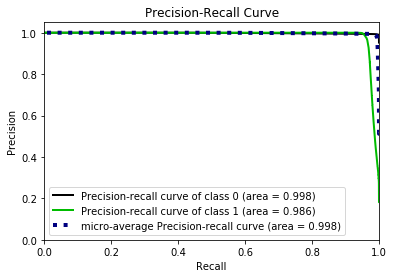

In [134]:
# test data report 
print_report('Test', comb_estimator, test_pool, y_test.label_is_attack, comb_estimator.predict(test_pool), plot_pr=True)

In [73]:
comb_estimator.save_model('GradientBoost')

## 17.1. important features

## 18. Conclusion

Even though the performance of the combined estimator is compelling it can be assumed that the estimator will not generalize well to different network environments because of the observed differences in distributions. as the first dataset collected in AWS cloud environment where cicids2017 in normal LAN environment .


In order to cope with this problem the following suggestions are proposed:
* an estimator has to be trained with more varied attack data originating from different network environments

* an estimator has to be trained with data originating from the network environment it will be deployed in. such as cloud in the case of the cicids-2018 dataset



It is very difficult to obtain real-world network attack datasets of high quality , hence the seconed option seems to be more promising.

The fact that data has to be collected in the target environment can be alleviated by only collecting benign network traffic and using an anomaly detection approach to detect network attacks.which we are going to use in the next phase using nearual network and one class classifcation mahcine learning algorithms .

SHAP analysis provides us with the features that have the highest influence on the predictions of the model:

1. `init_fwd_win_byts`: Number of bytes sent in initial window in the forward direction
2. `fwd_pkt_len_mean`: Mean size of packet in forward direction
3. `init_fwd_win_byts`: Number of bytes sent in initial window in the forward direction
4. `init_bwd_win_byts`: Number of bytes sent in initial window in the backward direction
5. `fwd_seg_size_min`: Minimum segment size observed in the forward direction